In [2]:
import json
import pandas as pd
import os
import numpy as np
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import string
from nltk.stem.snowball import SnowballStemmer
from surprise import Reader, Dataset, SVD, evaluate
from sklearn.metrics import confusion_matrix
import random
pd.set_option('display.max_columns', 500)
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from surprise.model_selection import KFold
from surprise import KNNBasic
from surprise import Dataset
from surprise import accuracy



In [3]:
os.chdir("/home/zhejing/4990")

In [4]:
df=pd.read_csv('df_final.csv')
df_features=pd.read_csv('df_feature.csv')

In [5]:
df.head()

,business_id,name,avg_stars,review_id,stars,text,user_id
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4,KEAHrqN-1DV0gmuNHM6Eww,5,As part of a birthday celebration weekend for ...,xP1IYu2eGfxMWV9tjrurIw
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4,6SgvNWJltnZhW7duJgZ42w,5,This is mine and my fiancé's favorite steakhou...,oFyOUOeGTRZhFPF9uTqrTQ
2,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4,iwx6s6yQxc7yjS7NFANZig,4,Nice atmosphere and wonderful service. I had t...,2aeNFntqY2QDZLADNo8iQQ
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4,UVUMu_bELdA56Ryfbur-DA,5,Every year a group of us (we had 6 this year) ...,gmPP4YFrgYsYQqPYokMgFA
4,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4,Jjz9W-wBkoBoMcB8ZQs5zQ,5,We had early reservations for a party of 9 for...,9bxdPvAhP6cuipD5s2UnCg


In [6]:
len(df['business_id'].unique())

5900

There are 5900 restaurants in Las Vegas in Our dataset.

In [7]:
len(df['user_id'].unique())

337868

There are 337868 users in our dataset.

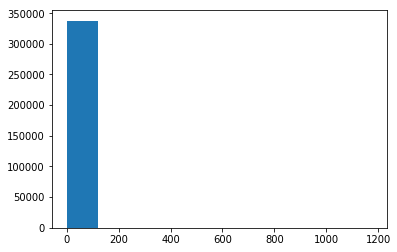

In [8]:
plt.hist(pd.Series.value_counts(df['user_id']))
plt.show()

Lots of users only write a few reviews. A few users write thousands of reviews.

We only choose users who have 10 or more reviews.

In [9]:
re=pd.Series.value_counts(df['user_id']).index[pd.Series.value_counts(df['user_id'])>10]
df1=df[df['user_id'].isin(re.values)]
len(df1['user_id'].unique())

11751

There are 11751 users left.

In [10]:
pd.Series.value_counts(df1['user_id']).quantile([0.1,.25,0.5,0.75,0.9])

0.10    11
0.25    13
0.50    17
0.75    26
0.90    46
Name: user_id, dtype: float64

Then we choose restaurants that have more than 10 reviews.

In [11]:
b_re=pd.Series.value_counts(df1['business_id']).index[pd.Series.value_counts(df1['business_id'])>15]
df2=df1[df1['business_id'].isin(b_re)]

In [12]:
len(df2['business_id'].unique())

3043

In [13]:
pd.Series.value_counts(df2['business_id']).quantile([0.1,.25,0.5,0.75,0.9])

0.10     20
0.25     29
0.50     53
0.75    113
0.90    205
Name: business_id, dtype: float64

In [14]:
len(df2['user_id'].unique())

11751

So there are 11751 unique users and 3043 unique restaurants in our dataset.

In [16]:
df_ratings = df2[['user_id', 'business_id', 'stars']] 
df_name = df2[['business_id','name']]
df_text = df2[['business_id','text']]
category=df_features[df_features['business_id'].isin(df2['business_id'].unique())]

# SVD

In [17]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


In [54]:
reader= Reader()
data = Dataset.load_from_df(df_ratings, reader)
svd = SVD()
kf = KFold(n_splits=5)
svd_train_precision = list()
svd_train_recall = list()
svd_test_recall = list()
svd_test_precision = list()

for i, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold number', i + 1)
    svd.fit(trainset_cv)

    print('On testset,', end='  ')
    predictions = svd.test(testset_cv)
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    svd_test_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    svd_test_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


    print('On trainset,', end=' ')
    predictions = svd.test(trainset_cv.build_testset())
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    svd_train_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    svd_train_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


fold number 1
On testset,  RMSE: 1.0749
Precision: 0.7749066500711375
Recall: 0.7462591135636879
On trainset, RMSE: 0.7626
Precision: 0.95785465066802
Recall: 0.5201690153130416
fold number 2
On testset,  RMSE: 1.0718
Precision: 0.7776886248781042
Recall: 0.748671839476671
On trainset, RMSE: 0.7661
Precision: 0.9551995574844624
Recall: 0.5172757422813251
fold number 3
On testset,  RMSE: 1.0693
Precision: 0.7742158426369071
Recall: 0.7442061555147238
On trainset, RMSE: 0.7626
Precision: 0.9570802484894824
Recall: 0.5178578836420386
fold number 4
On testset,  RMSE: 1.0801
Precision: 0.7763364502470127
Recall: 0.7546537638269868
On trainset, RMSE: 0.7623
Precision: 0.9557470286216677
Recall: 0.5184423446349856
fold number 5
On testset,  RMSE: 1.0735
Precision: 0.7768691519820649
Recall: 0.747793309484248
On trainset, RMSE: 0.7640
Precision: 0.9558250361671216
Recall: 0.5192323085164251


In [55]:
np.mean(svd_test_recall)

0.7483168363732635

In [56]:
np.mean(svd_test_precision)

0.7760033439630453

In [103]:
precisions

{'X5A_vtJh_PTQgQ5pmluCqg': 0.75,
 'URYTvHO6pxKajBt0EOQPUA': 1.0,
 'De4uNnWfd-s8ji1dDPmUyg': 1,
 'AKGBv8iXDMCIPl5I-Ch8lg': 1.0,
 'LLoAH_k07N7Iy47IbQqOkg': 1,
 'zo1HvNifsGJoQC_YCQbQRw': 1.0,
 'E4Y4CmoeE1NQgpgKtoatnA': 1.0,
 'KV95bi9YyriXIo6bsm3BDQ': 1,
 '_wnnUpx_S5G8rGN3rjnzdg': 1,
 '3p7N75LXNWbgXDZpM383HQ': 1.0,
 'QutUSdu-k7Wxt8yaEfkEHg': 1.0,
 'v3in4pF9w0wxtPNF09za5Q': 1.0,
 'wzyGNvArcpUjZauRWFrKHA': 1,
 '6K4wuwPgu6BAd8PefCKpYw': 0.8,
 'SNpi9tKh2EUWdbxAELLMpA': 1.0,
 'NV7Iqq3yQEN1_WWt5qDsCQ': 1.0,
 'AolnyiEB_UMlQtD_dp5E9g': 0.8,
 '_WwIIa9GpoGZQHS5v853KA': 1.0,
 'y5HfM1t4bRG-vRlpcFtPwg': 0.8,
 'dAVGTSsykWzKZHTp3yU_xA': 1.0,
 '-8eWVKFS0XaktfEaSxMWSw': 1.0,
 'dM2Pvd9v-hewm3oZpLczNw': 1,
 'x7XxZlwwicP-3eNPVgiTaQ': 1.0,
 'dEkS9SauP57PP9NSrkHbPA': 1.0,
 '4kThMXF7d6L4gH8NTjpoEQ': 0.8,
 '4AYfs8d7M2H4TBEiHhHTdQ': 0.6,
 'oY7Rpkty_fmFKeLURsLs0Q': 0.6,
 '_jpt07tQlw3KOkTM0fus2g': 1,
 'B1RlmmoKulHBHqmmjA7-jw': 1.0,
 'DBm03EUUIFGOqB_CmWp9FA': 0.6,
 'Vi_qBZBXgkNbsO1qXXkoVw': 0.8,
 '1IAuZhwpbGl8jwN2DTk

In [105]:
recalls

{'X5A_vtJh_PTQgQ5pmluCqg': 0.6,
 'URYTvHO6pxKajBt0EOQPUA': 0.38461538461538464,
 'De4uNnWfd-s8ji1dDPmUyg': 0.0,
 'AKGBv8iXDMCIPl5I-Ch8lg': 1.0,
 'LLoAH_k07N7Iy47IbQqOkg': 0.0,
 'zo1HvNifsGJoQC_YCQbQRw': 0.5555555555555556,
 'E4Y4CmoeE1NQgpgKtoatnA': 0.5555555555555556,
 'KV95bi9YyriXIo6bsm3BDQ': 0.0,
 '_wnnUpx_S5G8rGN3rjnzdg': 0.0,
 '3p7N75LXNWbgXDZpM383HQ': 0.3125,
 'QutUSdu-k7Wxt8yaEfkEHg': 0.625,
 'v3in4pF9w0wxtPNF09za5Q': 0.7142857142857143,
 'wzyGNvArcpUjZauRWFrKHA': 0.0,
 '6K4wuwPgu6BAd8PefCKpYw': 0.4,
 'SNpi9tKh2EUWdbxAELLMpA': 0.625,
 'NV7Iqq3yQEN1_WWt5qDsCQ': 0.45454545454545453,
 'AolnyiEB_UMlQtD_dp5E9g': 0.26666666666666666,
 '_WwIIa9GpoGZQHS5v853KA': 0.4166666666666667,
 'y5HfM1t4bRG-vRlpcFtPwg': 0.5714285714285714,
 'dAVGTSsykWzKZHTp3yU_xA': 1.0,
 '-8eWVKFS0XaktfEaSxMWSw': 0.4166666666666667,
 'dM2Pvd9v-hewm3oZpLczNw': 0.0,
 'x7XxZlwwicP-3eNPVgiTaQ': 0.35714285714285715,
 'dEkS9SauP57PP9NSrkHbPA': 0.625,
 '4kThMXF7d6L4gH8NTjpoEQ': 0.5,
 '4AYfs8d7M2H4TBEiHhHTdQ': 0.25,
 'oY

In [ ]:
{'X5A_vtJh_PTQgQ5pmluCqg': 0.75, 'URYTvHO6pxKajBt0EOQPUA': 1.0, 'De4uNnWfd-s8ji1dDPmUyg': 1, 'AKGBv8iXDMCIPl5I-Ch8lg': 1.0, 'LLoAH_k07N7Iy47IbQqOkg': 1, 'zo1HvNifsGJoQC_YCQbQRw': 1.0, 'E4Y4CmoeE1NQgpgKtoatnA': 1.0, 'KV95bi9YyriXIo6bsm3BDQ': 1, '_wnnUpx_S5G8rGN3rjnzdg': 1, '3p7N75LXNWbgXDZpM383HQ': 1.0, 'QutUSdu-k7Wxt8yaEfkEHg': 1.0, 'v3in4pF9w0wxtPNF09za5Q': 1.0, 'wzyGNvArcpUjZauRWFrKHA': 1, '6K4wuwPgu6BAd8PefCKpYw': 0.8, 'SNpi9tKh2EUWdbxAELLMpA': 1.0, 'NV7Iqq3yQEN1_WWt5qDsCQ': 1.0, 'AolnyiEB_UMlQtD_dp5E9g': 0.8, '_WwIIa9GpoGZQHS5v853KA': 1.0, 'y5HfM1t4bRG-vRlpcFtPwg': 0.8, 'dAVGTSsykWzKZHTp3yU_xA': 1.0, '-8eWVKFS0XaktfEaSxMWSw': 1.0, 'dM2Pvd9v-hewm3oZpLczNw': 1, 'x7XxZlwwicP-3eNPVgiTaQ': 1.0, 'dEkS9SauP57PP9NSrkHbPA': 1.0, '4kThMXF7d6L4gH8NTjpoEQ': 0.8, '4AYfs8d7M2H4TBEiHhHTdQ': 0.6, 'oY7Rpkty_fmFKeLURsLs0Q': 0.6, '_jpt07tQlw3KOkTM0fus2g': 1, 'B1RlmmoKulHBHqmmjA7-jw': 1.0, 'DBm03EUUIFGOqB_CmWp9FA': 0.6, 'Vi_qBZBXgkNbsO1qXXkoVw': 0.8, '1IAuZhwpbGl8jwN2DTkh-w': 0.8, 'EK5Ag1PkZh2gXL79V-fGDw': 1.0, 'Hb2RzG3b9YEBlrwBWzGtCA': 1.0, 'lAZP6KPG7Hr3cDFV6Cj_Lw': 1.0, 'L8P5OWO1Jh4B2HLa1Fnbng': 0.5, 'S6T7uV-WWGFy0ZXuQRH1YQ': 1.0, 'tr2vDE9LagNLZBqCGwYt4w': 1.0, '2M_Jhg12u6yoS2gsMjTbuQ': 1.0, 'HxkvXWdOXhEeGiL0g0Tltg': 1, 'xWCDD4AVIVjDfLZp5Qc5yQ': 1.0, 'vr6yQzmtC1MNM57tjJ-J0Q': 1, 'QDvX9KJ53kt3O7M3k43Iew': 1, 'EmWRBnsaKgpJLT2xmKJgiA': 1.0, 'J3kRWwB7TdfmGrqHFE3lug': 0.6, 'Vr8JAUALxs8lb6_TwuabpA': 1.0, 'G3a8N4o8mdhKPx7gjKghSA': 0.8, 'ZEq0WtRJD9Bl_vYgCsbfOg': 1.0, 'MTbIkJRaRFy32sytodh_kw': 1.0, 'QdPY0W7WIgBZrzRuL1lZMA': 1, '_4fVJIqou00rrhU9OOJm2w': 1, 'zaM1hiWPpC3SZJ5hbOHEQw': 1.0, 'yQuEw5dp9G3Uac5XaSogQg': 1, '4TOydrfx1__SgB-pFvXVCg': 1, 'IgS1X9vrZRTdtEvXWwC4Dw': 1.0, 'v-Js0zGukunlOVEA1pCABw': 1.0, 'NrpzAH3EoNhWUR8OysUhBQ': 1, 'b9DIahYZ6gJDk-GdKbnS9g': 1, 'sWDGavGeP9kMU5rOaNfeUA': 1.0, 'dPG1cOGb7ZnyaUl8M7h4bQ': 1.0, '-k5yFUChotBMGQgHdFZvLQ': 1.0, 'd_TBs6J3twMy9GChqUEXkg': 1, '-go-R_jzvYLYngQbfKN4_A': 1.0, '_v2aCyOxh61FtZo-g1uLPg': 1.0, 'JaqcCU3nxReTW2cBLHounA': 1.0, 'nZL5W1S_pKBV7bmzNr6b9g': 1.0, 'Dq2LXHfErN9LDy3CAQAC1Q': 1.0, '_lqJfN8BVwl6wxfpzkaggg': 1.0, '5Nf8EdeXKFyhcAUmRovsrg': 1.0, 'm1as24R-sWCq6Oh-9oXQNQ': 1.0, 'xl4rsQqpibUNhR8Jqxp4OQ': 1.0, 'mkY4jH-4v0TBP2EdhGN0_g': 0.8, '7q1EFKcjUTQhUrmjY2ZRkw': 1.0, 'GON8Ynfiro1jxnFoWD5jwQ': 1.0, 'XgWHIK-NCDS6Fj_GEW8kvQ': 1, '0qka5xnvBpBm7ZfGsU9oCg': 1.0, 'B2x3kEXXo8iUdtS9FhGO4A': 1.0, 'jOU73K85NeMzBsqwJtfu0A': 1.0, 'pi6vmI4MCR52OBuxxJ3Kiw': 1, 'nKLmmsWN6wJIrDXyMb_9Xw': 1.0, 'Xyv-BdA2Kkktks8SE-Izdw': 1.0, '8j64RTecDqw8hdJuSqJYCw': 1.0, 'bs_FiiqQNyUg6Fh_WqyLyQ': 0.8, 'KpqQMuSO9oQWDPHaahVkJw': 1, 'DYNHc9IxYwdJuGuC4bvpAw': 1.0, '11k3A-_Ifz_86LHvkGRgoQ': 1, 'Yl49udA0AG_bkw0AbDL5vA': 1.0, '82Q9vX7KBbovF4IP4NYT6w': 1.0, 'PmBUb3uoYHL38mxFZvNWmQ': 1, 'TtcKl-FoQoigBXmEexsSOQ': 1.0, '-fVKgpmSu0tDnf_xBPqU4A': 0.8, 'angEr2YcXmCl20s8WQu32w': 1.0, 'sLIn9oBM0aw9q2R9G1oCew': 0.4, 'aK_IdNCJUdk2haKC3GuM_Q': 0.8, 'IE9uhXVGrHZgkrXSsEgR1A': 1.0, 'qy47UXcmGYsPhDSc6iHWPA': 1, 'fxLuB8BFXINKen1uOomyUw': 1.0, 'vNGs6_DP7ZbtPwX7finVIQ': 0.8, 'DZocIJhgckV510-e-Y299A': 1.0, 'zawkTgkeY2hhLN36_8Hf7Q': 1, 'fHnAHkd0rNscAXlWpy7M9Q': 1.0, '55yUF86ECcSxQiiKB6UJgw': 1, 'kKsiXVSMjX3swu1He2326A': 1.0, 'E0hnzH2Kx50pYjIOhMxfuA': 1.0, 'cO9mMV_MpXYOB6LF_TpOqA': 0.8, 'B7ygjO6fbs5IhW2ykL_MQQ': 1, 'eWanvjvMjR-a92JVGAX0BQ': 0.8, 'P7Qt34VblZupUifRJ_5hbA': 1.0, 'awqtQmC1QoUxOdmdQoeirQ': 1, 'iGeYoyoZPrtswhXDIcMlHA': 1.0, 'jXX9P6PQ8Y_3rKRIn_XKOg': 1.0, 'gWxuXLY25gGGZl85Q2rgRw': 1, 'TjH9gxY2jYIVrY-zlplIcA': 1.0, '76crp1vXF1A3LOoNP6zcUQ': 1.0, 'CNjDoNYq0tdwUhsOZyVJ9A': 1.0, 'LbtFyFzsdt-d2XDlIGVsaQ': 1, '9efCzgW1smpgjdjzCxG-Ig': 0.4, 'Tsm8VraTp5OGyVALtUiCeQ': 1, '7snUVhqLSTTuyBqtercSNg': 1.0, 'f587WkOuLAotgXOVAybylA': 1.0, 'TwjiWvK0ZP15lzGC049oIQ': 1.0, 'ssz4_Rj8p1CLgO2WWnIoTA': 1.0, 'KxRf-umHzdz5noKH5Cg6Mg': 1.0, 'XUH5KDiFbLRUk4G4re-jew': 1, 'JaM9f-6k15f82tGGS05LOw': 1.0, 'm7z-tX6XDZ27xGhGjnI21w': 0.6, 'L7d8PGGm6fzXMkxncE8Big': 1.0, 'pngNlr9t4HObDgecGH_jaw': 1.0, 'h0Nhnq4ubn51BcbkliKE8g': 1, '3U1ov60Aw5cc2A39OV-f0w': 1.0, 'VIPGREpbbS782mQBUJ3mjw': 0.8, 'u6wAG4h60a0vOikJ1wtjcg': 1.0, 'zPxPCjABtML-5vmhSRxxpA': 1.0, 'vt5T5mMalP4eCu2iCkjKGA': 1.0, '4sLhuOs4K9mov0bBj7HaYg': 0.8, '7pwQ1TrJPz1eTXnxjhAKHQ': 1, 'jJyCZ8VtE-BOCi7xLnPCdQ': 1.0, 'ghZ5K6OnX_qnMfv5Ud-u7g': 1.0, '3gxJIbx_g1ZvAn5VNYW2oA': 1.0, 'quDu_Z0-i9TCYvdHRnULEw': 1.0, '1bHAJiY4UxGJX4N2bc2kyg': 0.8, 'Fhius40l4G-Dc0Zdou9HSg': 1.0, 'AYGH5HXSHdfOei0y_XdcTg': 0.6, '3Qv2rjPXC2eNKyV5lh3J_g': 1.0, '5KbuK9BThsbDgFeW90AcQA': 0.8, 'bgSZ9Jv3NM44JXi2t3Jxyg': 1, 'q-v8elVPvKz0KvK69QSj1Q': 1.0, 'p0xGJ_-QMWF8Bp6uCC1j5g': 0.8, 'm3FleKsUG-1UNqJsJZid9A': 1.0, 'nuOFlh6xoqikpLbhTbLf0Q': 1, 'iB3iW2re2A4LQEFcpXExFw': 1, 'shVyD312LNnLUvQEPdzo7g': 1, 'xwIeGfv2NAhq9Kofn5qQmg': 1.0, 'rSUD64fcfKhbDv9_J2-DxQ': 0.8, 'VLymZv8WhekXB51jZk5GNg': 1, 'nlQGyti20c07rpTSYYoNZQ': 1, 'pv0LIo9tRU_-gGxh5cBX1A': 1, 'iFYiHJOJBXfrE1yKpMDRTg': 1, 'TQ1_fZ7-Fkwf_gng7yn8Cg': 1.0, 'mUaLIwBQ4drDl8Ih-9rgjw': 1.0, 'h07Tq-a4IeMXlNMZCXAzAg': 0.8, 'C2RTNSaPYu_TKvpHxN41YQ': 0.8, 'JFRjcotNzbj0yM-9FO_r1g': 0.8, 'nPGkPnzMXOLV3k26XLDGZQ': 1.0, 'ftUtg7wBAZ0mPXFne7hdfA': 1.0, '7XtjpwvWhYd08c6qF-YyAA': 1.0, 'scppA9R4nmJOopmVUuqmEw': 1, '02YdTEWFTFr6p71AZJVQ0Q': 0.8, 'V5Th21KjUiYLJQyV-vGtpg': 1, 'HEvyblFw4I-UsMqgPGYY_Q': 1.0, 'cnyCyr5az4YzlQ1oCSYNvQ': 0.8, 'fcWwf97oGGDvZj_OrpAfKA': 1.0, '6VJhaF9hS5vnTJ_1trbmQA': 1.0, 'Q3p1o54pOTAL0TCd50bsBQ': 1.0, 'HVkFgKSM-ijl6XhKhpt2Ww': 1.0, 'uzb2jxTuLTYCk-EH2U-OBg': 1.0, 'CBwPegIptHW0vwGsaxcfHQ': 1, '2l0O1EI1m0yWjFo2zSt71w': 1, 'XAja3Ed6Fa_lwZl_7tb9aw': 1.0, '--WLHsm-AC4jcol2gOkmCQ': 1, '2Na5lgDJwN1dPyvLmKmWgg': 1.0, '1VELa98Vr3hiQ8ezvBEihg': 1, 'FX6SQ1GhLf2O_J1JnrfjkQ': 0.8, 'SpMh4ec4FGiOErd8twue8A': 0.8, 'TOJdp0lYwnJ7bn00umT3yg': 1.0, 'BkWkf3QXlBdPEhJOmYflkw': 1.0, 'VRvD7-JHdWdTQnh1lRCw_A': 1, 'eguB3eXzLRK3h40Oi0Iw3g': 1.0, 'eQwM6edDeV43bBL2WjJL2Q': 1.0, 'PRI5zVOruU_zLitAZl8JDw': 1, 'ckQx64YH_w8o7zT7PXe_BQ': 1.0, 's81YWGDJpgdIfsC3rOtiyQ': 1, 'EcBA3IWe4S8UXqJZySQfeA': 0.8, 'w8UNPUs7bCM2Wqg4OewYFQ': 1.0, '1dWLN4Mr4hKhu8MQUCKqXQ': 1.0, 'WXDj6mmyrJi5q5nHKJ6H7w': 1.0, '8VkGyOMqDRPuLFTbTpXLeg': 1.0, 'pR0vABa2uMrQtzC97ewPtA': 1.0, 'GazHAcJxomM2sHm0hf86jw': 0.8, '-uOQ0icLFyurOi9bcVnHzw': 1.0, 'rtIBgGmyq6nHHPaU1E7Zmg': 1.0, 'p8IDOaEADVMeV65GzHbqKQ': 1.0, 'EySOmRnzTyBbXAfo8d5T3w': 1.0, '-c9G-JHNqrPY0_UU9j7BJA': 0.8, 'gJYrREnFXkESKyMq8WuH3Q': 1, 'anwmW5m3Q_ZvDK50-RMGbw': 1, 'jC5sYBfD27mZwGCsrQXgHQ': 1.0, 'nUDVF24lbFgtCCECp0jCAQ': 1, 'xVxLjKTfBIctvO5XmHKSag': 1.0, 'tHStf1qlliRe8iCcxjwK-Q': 0.8, 'EK4B8i9FJfw539XnWGAV0g': 0.8, 'Mu6wz7_d6OBgRqkl4_NaXw': 1.0, 'KyMkKb5IohKb0S7v4Jv-oA': 1.0, 'Bgfu2QuVV62Hnhw2iZsDEQ': 1.0, '_m3SyztWE_ji0wLxsL2Ycg': 1, 'S156HzsEW-BjCfzu0xLe9A': 1.0, 'bUN4WV-uQds-Z_d4RKOWCw': 0.6, 'uqpB2fiy0acp3yluRyzF6g': 1.0, 'kTny8RFBPj9du2aIRb8V0A': 1, 'VdoTNYWuoXo01umgannw8A': 1.0, 'ox9koLWTaWyZbaEivAv6ZQ': 1, 'R0KVWeN9xR-F6j4z5k9wXQ': 1, 'JnPnjTgmScIQWc4-kswsVA': 1, 'P0eZEdycDIp86NS5tdEORg': 1.0, 'xmNjAckgX7vzFnfqTsR5YQ': 1, 'x2-TP8fd4G0OqkgDyKt3IA': 1.0, 'UYcmGbelzRa0Q6JqzLoguw': 1.0, 'y3IH1jtMxGkSvZYnCnh5Yg': 1.0, '-shHTy1CEmSMPVSehdASaw': 1, 'Ts5nhdsCkR026l_PjDqdUQ': 1.0, 'JabMon5MD5LfG4G7GzUzgw': 1.0, '4yGImSwdU9FZxVQIbZql3w': 1.0, '5YL6ySr3A6cgdGy2Tgr1dA': 1.0, 'eYNLZkBYHTgGUcmgTVOWBQ': 1, 'IFWQZabVG3Thl16TNjXluQ': 0.8, 'uwZw9bPUGDqpZh1vwK68HA': 1.0, 'owkgnjSJgaNCapcOWO3xug': 1.0, 'mISnh1ShUU4befACQinkFw': 1.0, 'pILrj__DvsPCm7w3bsjIsQ': 1, 'ke2LyFezHqxzJ6CPHgseXA': 1.0, 'ic3Lw9nuyESd5wFRH7TFpw': 1, 'JwGg7McIkyz7EFe8rO0cUA': 1.0, 'WUFbwSXTROccCtIAJ8OCVA': 1, 'KlD2U69cqxi01TelonOtxw': 0.8, '1Owxs2scoPFs79j376DPvw': 0.8, '3Hn5PexeY0tir0uFWk4jJg': 1.0, 'lTrFOWPEb_NkbOLNN9Dkrg': 1, 'vcCDxkFQujyIXE4kJXEuMA': 1.0, 'gl_f84zSpQsf4jZ_6S2LIg': 0.8, 'eUiisYNqV2nV7h770bpg2A': 1, 'Ro6tWGZ2Z7UrWlsTw_ve8A': 0.8, 'P4gPkP8uMXq7Zr5PoGTnAA': 1.0, 'utjpVFySRyXGM-X9znTq0Q': 0.75, '45mRoEbA_IvHIyUHpiABBw': 1.0, 'AoAJc0mp6OJWcjj4-cj7Kw': 1, '9dd0C3KQD6Gq-hiE-w9nKA': 1.0, '5pWIJ2ZNWMnYHzybLzpHJw': 1, 'lBPuoOFE7jRMpgvj40A1lQ': 1.0, '-jL7hLAAwOnCAWKQlL9Wew': 1.0, 'L7OVxZtuP_VXnmdaCnA78g': 1.0, 'W6eCwJposL5fN6DK_RewUw': 1.0, '86ij_78wolDsWWwAB1gGFQ': 1.0, 'rKnBrjxYLn0e6a48xH3c4Q': 1.0, 'JmsQ5wqQJHbTG1Ga3iptHg': 0.6, 'uhirQz-txi8034oWsblScw': 0.6, 'UL4bxNpzHk5V-xDrF7H5fA': 1.0, '3HXyXpdkH1rNAEEaSxQucw': 1, '0ppWaUaQu7JvzoMr3fUtjw': 1.0, 'fcb3NvbGr9qaPPLUlSnk6A': 1.0, 'HRZUIaX5fW85du-g5IiPsw': 1.0, 'Dg9VkLxxuN95K9__sX6zeA': 1, 'uPV3OY2OnAVdyER66lktXg': 1.0, '5yGgNgkkNvsv6dYiA_whFw': 1.0, 'uWXAiy960wdZY7ED7NU3Cw': 1.0, 'MyUAcr735ghKrBgaIBdI4w': 1.0, 'dG_vmfRd19RWpUwOx2qu-g': 1.0, 'BCvBvDBD82OFrhz8n-yGUA': 1, 'zvQ7B3KZuFOX7pYLsOxhpA': 0.8, 'nJVS18mJIB1hCHq1YsFbUQ': 0.4, '7UYkPrdGE2w2GCTaCZF95Q': 1, 'oUE-E24uKX9WluyW145ndg': 1.0, '5dM2xdU_MvdVdsl_adHrZQ': 1, 'XnZj6685Gsq7palG7btGug': 1.0, '83Bgz9gPxmJEYBOVKWXH2A': 1, 'ENdnuBDI_6g3Sb-msyS2gA': 1.0, '1UiVMCuVLTm6bOnn9h2R2Q': 1, 'HQlvsUqVhtJDH0ASBzaLsA': 1.0, 'pWmXVpOnQnN03BXEFozf9w': 0.8, 'o0TZ2hroc7DK6CM73ll-1g': 1.0, 'Ir4_vnstzggNRfwODHvLzA': 0.8, '5U0xR6gLovxvnEKfn0eG1Q': 1.0, 'LeQEvE7FjxSVDxXRibfg5g': 1, 'q93KSB8PtxchdgcY17bH8Q': 1.0, 'kHGRDaZt4nHgNSJcjOTDeQ': 1, 'YuwCrRziSKR7KSUCH0EM_w': 1.0, '43_TpE-umAuXoIMwXZg50g': 1.0, '-ELBgtqnuDHoARN3g1n8hQ': 1, 'ejzv7hv_O1YxCJOHDC6AJw': 1.0, 'PY0UMc96SIToqJ9X1WPyoA': 1.0, 'Dpp0gEmuNTnvyPAdrDu2Bw': 1, 'to-2EIRXGkhV3dWcwnllig': 1.0, '7KHbDV08R4p6BkKU4pdZNA': 1.0, '1pqyIOcWh-EEHOR9AHUkWA': 1.0, 'GhnqHTT1vKkLc0Z1rGsQ1A': 1, 'uByIGcI5EJeKNGyBtCkWBw': 1.0, 'VgG_4NU41eZbpidLyfk3vw': 0.8, 'PIT5TwwlMGxntQf_qFHiNg': 0.75, 'HU8KpmF5LxZppkjEOujaoA': 1, 'Jl-0N4zQ6VCbvk7DFpNfJg': 1.0, 'yXzEJJaSRLgXfCzCWxRWGg': 1.0, 'GeRgStFIS3oBxkAiCIgwMA': 1.0, 'EZzV8WIUGWJ7D-e5E7XdjQ': 1.0, 'aU6NXIf-myNFnGpIMMCI6w': 0.75, 'b3DYIU3TFc4gy9H_50_hUA': 1.0, '8q_hQwTR-v-xRt35sexavA': 1.0, 'fNLg_HsUFyK4hQIYa4yecg': 1.0, 'b8RV2F3-H7uCdJB-DAQPUw': 1.0, 'PZy3h5TDD7NXyN0h5w_msg': 1.0, 'uaPJcLEu_MiPyYT7ZcaqHg': 1, '7QRec81IeLgHcG6Tln0D8w': 1.0, '80mCsSAZPUwKmPRWvx8rzg': 0.6, '3o8c_R-Kv5UOoXXuMEOZAw': 1.0, 'hn-mT1rG9FxXvYsII3JiIA': 1.0, 'd63eAOSBa3E5uNYYzD8yzg': 1.0, '0yxN_CmSotv-t1sUZA1zYg': 1.0, '2-PD6df20ge-k9SPHmcxiw': 1.0, 'wdJKGY0xI5jpFrEL4Gm2fQ': 1.0, 'DJuCp6NVHAmfolqDAsSQpQ': 1.0, 'GHt9O2zh_4EgvykRtDP2kw': 1.0, 'V93YZAMFAF4eejiIPRs0zw': 1.0, 'tRIHlMbHe4Hsg-ubVLg8Ow': 0.8, 'wuT2zH7Atq-98BirpB-8Aw': 1, 'OS-XAEbboJ_CiPFBU8yKVw': 1.0, 'SyyYQfNQ4a4Lua5RBlggmQ': 1.0, 'BD_QRLCcl1OMpWBy96BE_A': 1.0, 'ltTLCzM4p-1cnC70SPNfSA': 1.0, 'AQ6AUAyi2WrBtP5gUb1HcA': 1.0, 'osZIl8D537mLeCNhrkfazQ': 1.0, 'ZGMO6stA8AfhWqbjPpvREw': 1, 'AYESvJ2yiikh6pMmfv3qIA': 0.8, 'qwnEd_gFmtBOmKKM1AEleA': 1.0, '_W4y7ku6Q0uGoiI3ePtkgQ': 1.0, 'PoWq4I3BTAk1NpTYqoso5w': 1.0, 'QfFQvV6tcSg2cnbZORK3sg': 1.0, 'iVMfEc7mM58hDlKrTEtn9g': 1.0, 'VdKkGBEXvD6uBUl2k1ljfg': 1.0, 'C-JBJ7GNPUmY1xtqqEXV8w': 1, '8oljN25ZE-qaNjKjMYRYLw': 1.0, '74PkaJqrbHqIDqUcYG7dGA': 1.0, '0zhlKsSUIbO8YOm5_OHCag': 1, 'f5L7eC_epbX9P34klniyLQ': 1.0, 'BeWDEj2Lj9L31HtFfZGn1w': 0.8, '6tbXpUIU6upoeqWNDo9k_A': 1.0, '9fEw9rkoaUvbbk2qu2cQOw': 1, 'Snx8bwlNXf2V1xTTgPdo0w': 1.0, 'p6qMidPaJ96LgB_9z7xZVw': 1, 'w5bnlvDwF-vhsA6ENqxQAA': 1.0, '2e7h0LdZjyCLcpBa9UwBaw': 0.8, 'D5YZ-GDmLUAiy3OpDvnvCQ': 0.6, '_N_P-JFU3avAgle2FuN0MQ': 1.0, '5B7Wq0FrE1gehMwlG2iQtQ': 1.0, 'yLaZk0HDmySN49H5l4niOQ': 0.8, '3RPORizfUAhI9HS-Nd7RJA': 1.0, 'Z4-fGDigomv6Yr6TZ93s1w': 1.0, '1SFfDyD0TA1dnXmbPTRMVQ': 1.0, '_enjdNDnH6MlLIOT6G7Jsw': 1, 'gFWmjc5UED8YaXFhZAm3qw': 1.0, 'moj7DUHkP4j9yfwFm-oOHQ': 1.0, 'khyig4aF00tZsTYw4F4GLg': 1.0, 'QSNzozwTwY9UU3QNvf-3jA': 1.0, 'BL2bwHhZvfLmaEpjziThEw': 1.0, 'leY7FqJ3NKPzpM5awAQ2-Q': 1.0, 'Dgk0Wdoh7HPjhKQEPBU_jQ': 1.0, 'mvq6mTZBd3mdDg_bZRWiuQ': 1.0, 'ElxoM6w2NxZp6amnFUok8Q': 0.8, 'MmeVq6bWhogNpVPuEemrBA': 0.8, '-aV7azrzW2rlAm6G4DA-cw': 1.0, 'SygwXJI8crPvG7owdPSeDA': 0.8, 'ZjL1yzGKmdhPz18m1YR7nQ': 1.0, 'ROK-C4ibaLa6N4ohD4LFfw': 1.0, '5LUfQF-uhCLEeJdv1q01ig': 1.0, '4DY1zLS6qBpBM6EmLOdjwA': 0.6, '_VMGbmIeK71rQGwOBWt_Kg': 1.0, 'ksKSs5Apj5zriDnPtuAuaA': 1, 'LJxEG-zFWfYjkQO7_wIlqA': 1.0, 'Um5bfs5DH6eizgjH3xZsvg': 1.0, 'uDCXh4P5c9vZcoUZU3jcLA': 1.0, 'Gokrer5wvrd5Pm9zuVbRVQ': 1.0, 'xg6IX013gQdwnrc1M9X5JQ': 0.8, 'kFFhw53ZEPoDo6okPU4eRg': 1, 'zAs7476eLIErV2HbaUFhsw': 1, 'bgG0jJyUXta_kczGrQW2Rw': 0.8, 'ETaZG8K0RvT6SSS_HHKzBg': 1.0, 'YB2SZbMgQHBOGOIsBK2Tkg': 0.6, 'n-U5fa4B0hKfmRSZ-M7BMg': 1.0, 'gFcnuwOBT9-C2PQ76kj5KA': 1, 'gk8l75GLFUsFr0kS5uLtkQ': 1.0, 'oaYDS16R5ImgY38SIrEkJA': 1.0, 'AzN4B04BxO5bV1lvSou8Qg': 1.0, 'Aw0x_dXz8rQbP6ZoYE8Y0g': 1.0, 'DBD3NB1ecSF5_OJNsXjK_w': 1, 'F_nfyogXQ69zBfSURKhxQQ': 1, 'J2pvQRBExBaXEe3gfLylnQ': 0.8, 'LC_o79IQTseA2Qi41v_rMg': 1.0, 'byk2vdjqheyYXJzR0zP9CQ': 1.0, 'C0VQBXa3VAtw1sSKamGriw': 1.0, 'Fuekh1vNrATMHlE5k2NFMg': 1.0, '2b--msGiuV5nMJTYyzdS2w': 1.0, 'JMU4hmWtKJ_fYnDgS_RFag': 1.0, 'lFlJGqYcirNXWo1WZ2xqpQ': 1.0, 'KfHt9GZVU34d8evbcSnQhw': 0.8, 'qrOXWSK-bpf24dLWnTx29Q': 1.0, 'vPJ2viVSZ2761UMxYMqwfQ': 1.0, 'SdzcLDgfQp3nu2Z31PEyhw': 1.0, '1zssDk1vmO6dbhDwOY2fzw': 1.0, '4j7C6TbmjysuuF1D3o9xBQ': 1.0, 'e0lV0WyRCYbYs9k6chh8YA': 0.8, 'e0v4eYy3R6jPRWio3F6gxQ': 1.0, 'nrMef8kED1ZwlLkcm1XfzQ': 1.0, '1-2Oed3A3J2lzLnRp12FWw': 1, 'E_1rVCWq4NgbXhEjMC651Q': 1, 'vxtUkIpzjN7xjOao33ilZg': 1, 'PtEQ6LrPT4qO5L7sno95Hw': 1.0, '_jq_veJ1j62iNWW8Ij8veA': 1.0, 'G89MgEpjVkawmL1cMdM66w': 1, 't9-xBrh_1JYcBjwHEJtMgw': 1, 'Ner9deZ2TUFxdiRijBpOjA': 1.0, 'nRfJBg-4MwxtJG4-TgnFow': 1.0, 'G4pBy0nzqqkKgJEHrDNcWQ': 1, 'ZQYNombDho1PYfnEWFZevw': 1.0, 'yX1_CDzyqbNspGApWWKuxQ': 1.0, 'n1B1kiN3WHejdrmHgU5P2A': 1, 'iw_6JAAw9FAIv2YkbLcMFA': 0.8, 'WYSf63EuLpUbSqco5BsSKQ': 1.0, 'aQpbee0jhvIgiMN8HZJPRA': 1.0, 'BkidByf5jyDAy1oN2U4qyA': 1.0, 'P6zpT_1VHl7lpzUlrq2Btw': 0.6, 'pziygTgwFxGWi02ySYk8cg': 1.0, 'IspPe6CmQfT9XvitcDEYNw': 1, 'DbvsnyFKygguMskZEMu6fA': 1.0, 'TSI1MsquZ5txn-1TrcCZBA': 1.0, 'LjDSVQGLLiOO7NCfvmV_MQ': 1.0, 'bYE5X-TTejK1yVMdKfRYdA': 1.0, 'wai1J7wtI5Wp0DUwy3QG2w': 1.0, 'fo1wAKFyb1EeuLY4-bM0Sg': 1, 'UQ524fth4Sj6WVDnJODcYw': 0.8, 'pUQdU4MlkB46jIdYs9oMUA': 1.0, 'QOK_Wgx1hP2cy7E7_ZJs1g': 1, '36_MIzSYEJfGhH_muL9sOQ': 1.0, '-EJorVxe7h2GSxdiRyMmDA': 1.0, 's_JDz1gBlk8nDgwiFj9_cA': 0.8, 'CaajeceFCAYdWW9GoNVZmw': 1, 'k9BCR6Ul0L7jXp9iR-5s3Q': 0.6, 'Gok9V9Pb5iwj9baYjK1x-w': 1.0, '39_8yhWlg9KiHXCpetJUBQ': 1.0, 'cVeJB7E_YE8FrKpZyi2JRw': 1.0, '2YiBYO8n32upYTJnpWgqLg': 0.8, 'PQ6-FZpUn2oFLyBGvdiG3w': 1, 'Scv9HRK2bpXfxIrq6sBI8g': 1.0, '1x-9UrxGrkQsFMev95q5gw': 1.0, 'aSAeSk2JPDvl_tk_wT01nw': 0.8, 'NYDvprxYyDm1dJj8g_G0RA': 1, 'Du9u6dXgWYubbnZuor1KqQ': 1, 'LQJ7jEWxBBLYiaGVWdN5Dg': 0.4, 'oCYxjlqjpnW5WJAo6HNR0A': 1, 'wtnLOataYL7kT3xaz9yccA': 1, 'iJ27OO6S1cvpt9k3ohYd8w': 1, 'd4XoQ9Wb8Csw0oD5dDEZ0g': 1.0, 'eZZyuJDouIg4p-GYB3PV_A': 1.0, '2-gnDYB2aM2xtmYk5R5zoQ': 1.0, '3fhIgNqd1jq_4sTWwA79Xg': 1.0, 'aZtJzH3fRIRzrGnQRIVaRg': 1.0, 'MMx9hAyIVYdFP5mSAoqXog': 1.0, 'GH6XqTz5Jx39SobsTYQJXQ': 1.0, 'ORkAXND__BabybW50QXHfw': 0.8, '_S0218QJWDsiboHDe4UG4w': 1, 'LOONUX6HVC6mGUw5LZtqEA': 1.0, '1o6zgbXkRp5aiGMZPzMEgA': 0.8, 'WJuvgxJyon4kdLcbwhtaJg': 0.6, 'RkAW6kqHiuY8CU1pSC9-LQ': 1.0, 'XMKV4mAR7oQKV0AKH5APpw': 1.0, 'jCUqHcg4xvFtsG6ah6RcRA': 0.6, 'cyFYb0DSjZLlaVUp7dsD3w': 1, 'wn_642CORezTTTjp-03p-A': 1.0, 'kyIrmeTVS0afkTmjZ3B5Mg': 1, '6CvJFjJQRZG64-2yPGb-_w': 1.0, 'sVNpZOuqolyARKdXv-xdKA': 0.8, 'HkkLyvgBjhDenVTK8RDx9w': 1, 'OpI_4AvKXOTJIt23JipmIw': 1.0, 'UXLqTdBeQK1F0eRWDfc5oA': 0.6, 'VbPb2-zOI4poJY8nahkFcw': 1, '8DRmtOX-_DrYNzL5QGULrw': 1.0, 'zMLbjqeTqp83g0uIAk0SWg': 0.8, 'ZYm9D3D1nBcWjDjrxhSqPw': 0.8, 'ZIOCmdFaMIF56FR-nWr_2A': 1.0, 'YFdU73Cu2obA3nXToRVxmw': 1.0, 'lRHKneipYlS2D87Qz-16aA': 1, 'Yvj5Hws7hkHriZZuxsjQcg': 1.0, 'rVxwIq-GU98GC2xMulsSqw': 0.8, 'GYovLBMP-Xb8jAH_ivMaSA': 1, 'ZNCU9UFTa_UWmkwMztkEbA': 1.0, 'vLViu2g_fVFqexb-NBhx4Q': 1.0, '7bwDw99gKkuxr-zBtzqvCg': 1, 'ZcquFyAgYkUyqfVClC1oCg': 1, 'izWbFJZWlagRHrFjqX2DIg': 0.6, 'aIJ-2R1q5G7oqzBSgK_Vvw': 0.8, 'PulC18FdyKlNy1W8L4hEKA': 1.0, 'SgcNTpx_ASfvyQHmLU443A': 1, 'Yj79QbOyYO1q6ythwB3bvQ': 1.0, '5AmFKj_y0OHHZYpIudonRw': 1.0, 'dwmUKBXnTCDuewkCb7QooA': 1.0, 'eTmQbq9ZrL3mvhA55ppmHQ': 1.0, '4wMh3OTCZrzV2OcJ_ey6tQ': 1.0, 'HVJgTH5qu0goywOHNpOjPA': 1.0, 'GftgC-gg-XSEXmvLuL1PXw': 1.0, 'Tb1AFoP1o2a4LN73aCZyzQ': 1.0, 'ZiO2Wr41kZ4Vz64aheBFPQ': 1.0, 'En7f89rLinVHhSUvdGYj5w': 1, 'vgw9YgtImROsCUgveRSL7Q': 0.8, 'yFlu57fNdST7YhizHIFniw': 1, 'LaQGI8hLJ2YCMHW3sZ5XWw': 1.0, 'eWyhZ-114SqkZkG0RyJG9A': 1.0, 'jmp_fELs1lJRptAsiJ-LkQ': 1, 'GQ_2kpEee1KXZCKEtpeEfw': 1, 'RIroUg2XJyrqzfc-waGZcA': 1.0, 'ka8Pk_MXUXNmPy9kPaO43w': 1.0, 'Ir7Z9AjzI5F84UbaVKYSlg': 0.6, 'uWVUjAWiEZL3xtNJnM3fRw': 1.0, '5f4UjxbMJwTPgmrHsB4DSg': 1.0, 'IbHIOqNZQO9RbEROHwkUMg': 1.0, 'aTcai7UJqimgBFR8cxsj6g': 1, 'fIM5z8nnpLWWBdGPQ4FNfA': 1, 'LDu8Kn3k1CZHY5sEq3bLPQ': 0.6, 'R7mPYLXWIxVUwsdO10xzXw': 1.0, 'Wt-gOai_wgs2ZnOrXkzXvA': 1.0, 'R9Acwreuq6Og28hq9dZp4w': 1, 'LLsyjn2GZ715AwIPlWZ4Pg': 1.0, 'nOIaazW2_RJ08O0U79SeWg': 0.8, '9bxdPvAhP6cuipD5s2UnCg': 0.8, 'Anuuo7l9KgAsSvnOHXcE1g': 1.0, 'IdAGS2eUGxBZrOyStzkaeg': 1.0, 'qmVXmbchh1V-PYSpvWU_rw': 1.0, 'C1Gv8MocBrrX4qPQ497J1w': 1, 'xTGpw0x5EUj11YFhwr6m2A': 0.6, '17jifhHyMbYCo8_HSCe95Q': 0.8, '9u9fQhq0hynxjLQgZGpmSA': 1.0, 'G7tQzy6dCkeeUCZ6d9BSjA': 1.0, 'K5mS2ORCuVgluYW9-hguzg': 1, 'T4S0tAaQR6elsMtWTIc__g': 1.0, 'sjzv-c1k_HGGT9vZbfimWw': 1.0, '7NEmI73fmuLghBls4rKM3w': 1.0, 'IRGlZYE_ZG3O_LTwNLmAGw': 1.0, '5bnTeMyT7iAfSculZtYIdQ': 1.0, 'xcouy9WRvPg5y73NkAHbUg': 1.0, 'cQfcLsUFH-txdue1Z7mxbg': 1.0, 'Vjkk51UMDDIH1eHZyXcZtA': 1.0, 'opPpHVIp8SKHMJg3_y5Lew': 0.8, 'OW5dJo-E6j-WaVwyFdwHJA': 0.8, 'za6XHFxAQr6iiJN_bMULDA': 1, 'nq8s9JADXPJBvINdvKG6jg': 1.0, 'gVQadQoIWEqzDuRcrek2Qw': 1.0, '7Xpb51viDdOaV_89olxp5w': 1.0, 'w3UMfW-XuIyKkgXEvK8N8g': 1, 'aaRtXRyDz-EWdwm87ZIDEw': 0.6, 'wXR0Bis9TnbJR1ijE49sfw': 1, 'uaFOvyGPRvSETSS6Lk8-5A': 1.0, 'z984YTUichrj3xQyEwMxcg': 1.0, 'nbCTxeII8DAB__LG-6aU3A': 1.0, 'u4PqNrboclyb_B8ZoIJCfg': 1.0, 'Z6sMdVaYrFoAOL-Kbc7b3Q': 1.0, '3jjiY5D7oIlKeiCIZGHQew': 1.0, '5M9NmFi9zfbFShjmSX6MSA': 0.8, '79Ea49GrBLDPQMewNGtSlw': 1, 'QesDcfDUyN8rF_GWvWWNqg': 1, 'ZefNxXRVAPNy7983Rz5J1w': 1.0, 'pcv-MEpcI6t4_ytr49LFpw': 1, 'RLrXxe0Culi6nSnyaJxinA': 0.8, 'AFidNHs_PGfH5rX6iNRzmQ': 1, 'DcV1UMfsuaz2d1dUrZnS9g': 1.0, 'kddFMjZTWulkLsHCKo3lzw': 1, 'mX-WiYESoNlsndx9XSNklA': 1.0, 'vmExHrVtwZ5WR7tgB1HKRw': 1, 'r9yGXzFLQ7A55Ac-Lu436g': 0.8, 'BakhIY_1AUrrJp6ZfkE6OQ': 1.0, 'HeoolPKjgiQkXMRlJxp0-w': 1, '5PN0bIWGcOYsglHA6cu60A': 1, 'oSN3M4_WKdlTsnpgqPDiBg': 1, 'whINg-cC-FiAv_ATDGMDTg': 1.0, 'DxQeJSiKJUmWIre2XGaKGg': 1, 'cG7-mlCp_cV8gfRC_9LW-Q': 1.0, '_91FxFZYTaUGVIEnQhB5cw': 0.8, 'lNQRXZpPiNRDxCU6Uv7mNg': 1, '-6sK3CL1g1OP1FMawX2hxA': 1.0, 'K8s3SSIoZNcJ8K9Dx2mfTg': 1.0, 'xpaIV92-DStPlBjyfITZqA': 0.4, 'LbzdxzImUy2plFutJ_aH3w': 0.8, 'S-z0epok_cwBx5AQx9ouQQ': 1.0, 'erQM1caBnCLFzT8v_2uEjA': 1, 'UCjsKncHPTmLOH9sCkjQtw': 0.8, '9okCe8TP4eNzW01kocAa_A': 1.0, 'o5NYaP_RA7Eq0juF7tuwgg': 1.0, 'b4bTks98idS6-hx5AT92WQ': 0.8, 'D43OWyfzIQjL8feJpYh2SQ': 1.0, 'Wq0KiNtSBIEwJZ_jAD5FQQ': 0.8, 'i9JyPv8YyngL1Rzl_Cmc8w': 1.0, 'jPhjJnQ2_3_-tu__KTQZlA': 1, 'dA7smMo-z6VNmgNzyd640Q': 1.0, 'XybrvLEZUD6lJpsy5P3gSA': 1, 'EJRsUAUm0CSy5f_c-0G9SQ': 1.0, 'ABG8n-fsKfcdWdJqJkNsQA': 1.0, 'MT4AnzfbdlYM36KgHVIx3Q': 1, 'Nwq0AyciH1n9E9Z3AyasLg': 1.0, 'sMPNFm9hBVT-dhOdUcod5Q': 0.8, '_xpivv6pnLim13KiaHBKqg': 0.8, 'P78ReKnTlf5QmG5TEta5LQ': 1.0, 'pCAQZmAqYxkbg6V-oxZYlQ': 1.0, 'Yl4UUMBcstZFdoWIT2pzhg': 1.0, 'viUJFHb9jIHJYpUv07MeVg': 1.0, '8DGFWco9VeBAxjqsuh1aSw': 1.0, 'gdNqeHBoOsBt4eKJ-0AJTQ': 1, 'FHsy9otB2hl-vyvaT-qh7w': 0.8, '6_5y-kl5rDHfNlYP_MhgEw': 1.0, 'q8rjyleuk_jimFj9SoAm4g': 1.0, 'D3fOi-5w4intrUTWXzIQew': 1.0, 'edTwEJEOdn9i8WDAgMk49w': 1.0, 'yLq9MFu5MhKUWq_I9MuRTQ': 1.0, 'geLlB_Qo_M900dCjxpKu9A': 1.0, 'cb4XnNYBJ6YV1ksngX8HRw': 1, '5hIH-wbJhiZs2Jk1Vy_9ZA': 1, '_d74r_wGLwE4E8MxRKk-FQ': 1, 'fGfs1wP0ENl4oZCqGxH6zA': 1.0, 'Q0BJCTigHIjGifLfj-_N_w': 1.0, 'L7VEJP1RrpXRRRWsYIu3tA': 1.0, 'Z8pXinJSRSfjciAaP4M-ag': 0.8, '5TBWw42-vsMNs0QAXsPwRg': 1.0, 'alr2xk5KBJXHd6zVuEqdDg': 1.0, 'jGc6HEUiQ8FfCSoF3slYeg': 1.0, 'wLh4YepDaBzQ1JMrj5fDzQ': 1.0, 'Sme_0jk0mJPWIMjGzKqBbQ': 1.0, 'erdvrYG2b-YkTfZljgrXIg': 1.0, 'r52bugu98l77gdqTnIJ2oQ': 1.0, 'Eg1T--knapihoR2GV-Dj_w': 1.0, '11Qfaoyg3BiciQ4ffKO0JA': 1.0, 'vhE2GxftfJenqDLkmj6-5w': 1.0, '1tRZCWlt2BEm9FlTaaiGLw': 1.0, 'XQ_nFlUasT_NYksIHDP-kA': 1.0, 'g2_hcKfQW8blEgHcl1mh0A': 0.6, 'YyGhWvyw6mjJFICgq7rUxg': 1.0, 'QqFoLApYNeGSv_ZKPY5E8g': 1, 'ubF5zarbyXJVMTOZrSUFyQ': 1.0, 'Zukq_iyq6bItd9NBiur13g': 1, '9y5NZGmt8fzE7AqEDuNhFg': 1.0, 'nYbLdMOWQnP8cDYIEp5NAA': 1.0, 'bhJ6ivAuSpgXP4JiKWjSZQ': 0.8, 'UcmjgcFV2wTwoNAQTSfffw': 1, 'uU7GIgzs4-5Dtp9Vuymb3A': 1, 't8E9gcxYl3rdrxZq-psepA': 1, 'ijET3u6uJ7Ug7gY5TIDB8A': 1.0, 'NV6b0oTn99n8PMY5V_RAlQ': 1, 'zgV0ZroIF956gw4cul8MHA': 1.0, 'ImVfDOri1NG5UE5MEmqHJg': 1.0, 'aJvNNSBbbaZYAlKGnOXiSQ': 1.0, 'Dxg45fV8RbT7l6parLymQA': 1.0, '7zZOZu02Mir91ikLG1RAnw': 0.8, 'M2whdwvMtNxLllxOvt7cOw': 1, 'kB5kzhYdG-CI1zeuPyyN0Q': 1.0, 'D6TeOro7ypsWUU4YEeOujA': 1, '4J4KrUINsgWJuQFQmDJQuw': 0.6, 'Vi5_3zNqWkLy7U5MqNRgOQ': 0.8, 'c2QDMrUK9B9-vLRqeJ3Eww': 1.0, 'mkbx55W8B8aPLgDqex7qgg': 1.0, 'UqSXH4qa_olqNUW65XuilQ': 1, 'ioAxaAZTOIfa-3AkwixF-Q': 1.0, 'Bt6gmjnWHPERhiOTQOhuEA': 0.8, 'Xde3UEeqDU281Db-3NAxFA': 0.8, '7PVY7A7Top7ButcfLkTJTA': 1.0, '2HPAOqz_79xTD1GgS2SGyw': 1.0, 'e2LtHijFAXy4RNTDL5IELw': 1.0, '9Mxmfj0yMpakOwfg9iY0mg': 1.0, 'H5QUyQ36YlGruUH0OzKTIg': 1, 'GGjzQnNZb4IDGfzACvNquQ': 0.8, 'Nbr4DYLPxURjxelLVTSt8A': 1.0, '5R8SuEzBjcitbPj4RYNi-g': 0.8, '77wo69hNeqoPVBRRLzO1hw': 1.0, 'z908ldotiE_K0-gJv0qk8Q': 1.0, 'ejp_hsI7DKF-fF_jZji9lw': 1.0, 'ANLSKvFmCgRMjxtELq70FQ': 1.0, 'sEx1Ua3yNjxBdJ_vJ9amfA': 1, 'Z128ihQea7BLPh2T9q9sKA': 1, 'k6J9Cd-ZqnF6NkuUgfaJbw': 1.0, 'gm9MU9CqAfMXhrLvpPclQw': 1.0, 'Nbmb4dYsfRBn2x-g-9_K5A': 1.0, 'oKhpMYvIntENZ5UzuoZWUg': 1.0, 'ONCZtP_zZz6gofhnTQeSaw': 1, 'XLNaiWF21OsAf0fMV6kuSg': 1.0, 'q_d9OQfa-t1yeDFDxOsh6A': 1, 'fSFpjl-C0fXY7h7cG8Wxeg': 1, 'uso43PtZRUPcYxgxs12U1g': 1.0, 'Y7D2R1ThyfXMaa4x_CL1hw': 1.0, 'CnfgCTfRwC2SLMDg_lmdNw': 1, 'fMurg3G5cC8C7yN-4AxeuQ': 1.0, '2t6SrtIv2MzxH2SZZuOucQ': 1.0, 'pfMmuVgggj14f9bb16IwXw': 1.0, 'qTllTILQ6JVifkO-5ezm2Q': 1, 'eji0JuMcS89D7k1is8ERSQ': 1, 'DBpG8oDZoBfuuaQZvHVa1Q': 1, '9SiaKMfoX7hsWxqNd-CKaw': 1.0, 'Rr_nsHBbyzbBGEKVnhiMiw': 1.0, 'EJ6_42rw8W73rxm_R4aQ2w': 0.8, 'NI2glfU_qscu4YcxtI8F9Q': 1.0, 's51AI3yeDaZmx8NALVBJFw': 1.0, 'iSCvaQ4hfEGiZ_KFGJ2w3A': 1.0, '4mSdZyA7hut2s5t5WHR1mA': 0.6, 'os-sDQoh-hCt2Lg76z6ZUA': 1.0, 'Z7PaVxobw44iejw3hR0UoQ': 0.8, 'Wwa7RshRpvf5Ob2zeS6fng': 1, 'RXCoHt7BBFQN_vjsb8IDjg': 1.0, 'Vot_trpawdPZoVbFmfAAZw': 1.0, 'WPe2n-x6xBNy2GIC5LcpdA': 1.0, 'tt0Lpzd4m_3IAK4aa-8LpA': 1.0, 'mVA4IeYyVKPUWRrN5oplMA': 1.0, 'Qv0xMxEs9XHEqI_9zb8vcQ': 1.0, 'KVJMmL0YhWwZRUhhMNkpjA': 1, 'YN_wyoau6tTyLeF_ZHIB2Q': 1.0, 'I2KPKbNkuQFc91k-UHbN5w': 1, 'ArWuRnd0homfY1-7m0pYGw': 0.8, 'HixtBO7z5OW5bo_6qo6D_g': 0.8, 'dIaSEqQ90JVjJbPRoQlFWw': 0.8, 'zR6gkXk4UVeyHEjJg-vGiQ': 1.0, 'VjuFpk0IKsCaUI9Lc7vrqg': 1.0, '4NDwhoh7AUtTF5aTJCXBIg': 0.8, '6N8scdRhsaGLZxvqriE7iw': 1.0, 'JNTHN9MKeTnEp2xcpLr-7g': 1.0, 'eZ0WO0H_1CaD4kUeR0Y2TQ': 1.0, 'p6tAhR1A6Ok5oCmXWGLAjQ': 1.0, 'eLDruBQjU3Rv-GzfzdSeDg': 1, 'ylphk4-uCvkRsxkHITjQpw': 0.8, 'eZNm34nCZkQY6jEaEmQMEA': 1.0, 'Se3XL5Opy0e2cHbxxjs2ZQ': 1.0, 'edZ6kTxithgtctw1crIkBA': 1.0, 'uPgj7UUo5BTErhAnzVV4Ww': 1.0, 'YV-6sw3s29CPDilatMaT2Q': 1.0, 'ZpUI9ze0YlA6nMSHwx3ZYQ': 1.0, 'VmJBSxcc03AjqsFNycfMFQ': 1.0, 'toJLjXjSofVNJ1icmMwzfw': 0.8, 'B2F7f8NdlBUESv8cskE-jw': 1.0, '0xzgFN6O0tTb_iyu0uu8bQ': 1.0, 'vRjVhl3ONG2GfWY4NXJZbQ': 1, 'mmAcpelY5OdTLgwjDDB6Lw': 1, '7b5XWYpk9KGVb7TjtDoMKg': 1, 'ybSYhmwjxCAipbgiabIgbg': 1, 'uAJNBvcJA2kIsGx_sSofEw': 0.8, 'XldVMNlrDQ5zLW8zbDbwfQ': 0.8, 'Mv55A30nEcAl3vk4qow5dA': 1.0, 'RBZ_kMjowV0t6_nv2UKaDQ': 1.0, '6Yj3AqBD45SxXChKt35SAQ': 1, 'QrHAOWGkahT2nmvwcHt56w': 1, 'aBeAPFrNONyUwItU3ZcLHg': 1.0, 'A5A34ixb-yy6nwL42iZsnw': 1.0, '_3_4iBgr1JBjBsdwKD2zlg': 1.0, '-mXobpJ3z3X6nMriCklbog': 0.8, 'ZkoNtxgOOMF0gIfi3d5S6A': 1.0, 'U4GksJzlywNtXY5tybgUig': 1.0, 'QvLg2kxqHHahxxOlHlEIZw': 1, 'URb6znpCCVzd1kZvugedwg': 1.0, 'tSdz6ZkR0psn41cCaaTlYw': 1.0, 'jyvmC6G9S0LnkJgHrW_12Q': 0.8, 'BvbJ2SsuLWRj9UQea0tG7g': 1, 'AVOyUpnjZsr6SrSxtFdhiQ': 1.0, 'PD35v-z81UsTSwFQalNCgw': 1, 'VVvPNapOOZi-TwNIM1YnsA': 1.0, '7MLxbXcn0kSbhIpjasvhIQ': 0.8, 'Spgm6HFWgc4YXJlbhg11Pg': 1.0, '2Qc7AAk2xQhxKrD7cJ3kxg': 1.0, 'tG9yE2d6-f2kbDuehlVrWQ': 1.0, 'ILAQ7WNCiKkp3SIVHX_Zdw': 1.0, 'x1paA3aUHJTurbtFkBSOGg': 1, 'EDBTE8HMO-iN5hAi9B382A': 0.8, '12AzaKnyko99WgDYn30u1Q': 1, 'rqLjc2paa5ppOLPXyBry7Q': 0.6, '6LO3hkrSt1-mAU1oR8sbhA': 1, 'EZJgrPBq8sGFjAvyJEJzTQ': 0.8, 'Vy035X7tzX7Nh25UwoQB0w': 1, 'XjqF7ABSlI5xF99LaEUcLA': 1, '9PODl32fViCXhN4NxBdGPQ': 1.0, 'l7_cL_OU4qou-P2fnKCkLA': 1.0, '-Lcp9BDlDDo7j3aIGJWjYg': 1.0, 'dlQk03MstQOBlwqVqMwx7A': 1, 'H1fcbC-WKsbiEo8BBVkHwA': 1, 'Pi5fhGCEoQJO2LFzPXPGTA': 1.0, 'MLhE0P7Q9nMRnueAhrRaHg': 0.6, 'QEHoYKMynY7LaAnzsVXR-w': 1.0, 'hAZEee0Q7APAcerRQ4Ze3g': 0.8, 'CEoMgtYwcskmU6VOeDAwVw': 0.8, '2ybXE3Z9illyhX-eCN1vTQ': 1, 'SoiacX2r2mvHqIh3GgRMUw': 1.0, 'ECZPvbk-sp4V2Yj_tfQERw': 0.8, '8BV5Hm4Nygujx3cdoP_EtA': 1.0, 'xpWTenRR72Bv0RINUov92g': 1, 'h5qf9owtv9q8HjaNcrz3OQ': 1, 'VuNAe_FRVRn348KbM0Fknw': 0.6, 'jylt6aurOs--IviJliM70w': 1.0, '_pMzR6yoPbU98t-NH8TZ3w': 1.0, 'qusjGI2X_RAi2McFeTnNXA': 0.8, 'C349hhMXsGVdxk6u-xf6GQ': 1.0, 'XGBASCLT6qI-3xIjfafMaQ': 1, 'BX-wcnzFpCd3Nm3RjiFzbg': 0.8, '5D0XbEh3Em7os40vxzL-OQ': 1, '1e-YlTcTpYKkCu6d_7kSJQ': 0.8, 'UMlCiOYetl9k6nbixTgYeg': 1.0, 'bClP7vxyjihBkNeHgS8fSA': 1.0, 'm_fkxl6vNU1YxbOdYxtLEQ': 1.0, '53EWBX2QGISTDZJ1NZfyrA': 1.0, 'KBDP0QCHbCuisidKT6GPow': 1.0, 'KKZjXdm4tYtqTXHfI5PQuA': 1, 'ShmDxFOPf2IhLbY54-OVNA': 1.0, 'WcnQOMVllXor2at_5kCrDQ': 1, 'g89D3f_9GnTzHPNoxIpuKQ': 1.0, 'ihTu74HkXnKGuY5v_Z8b0g': 1.0, '-uBmDm-WLzhue5KQUiol9g': 1.0, '8IkPwZloLgHutA4u5DZZOw': 1.0, 'hKbKOL2E6KN_YUCfYP4AEg': 1.0, '-9I98YbNQnLdAmcYfb324Q': 0.8, 'VZfIzNPiO_5eNkGNFSNZDw': 1, 'VE-MQT95EqQePD4zQ8kVwQ': 1.0, '7lBuMxcAaPyIVbH2ce689g': 1, 'TWmb25OuRnWN3gF4cwOPxA': 1.0, '6JehEvdoCvZPJ_XIxnzIIw': 1, 'Bhh-xJxNXdDEgs5BDTAoqQ': 1.0, 'lm0qcv3UMzbUkO0hJ85SbQ': 1.0, 'NsqDhj79N8x5NamFCRLAsA': 1, 'tsRyt3n6pqi-QGGOblKIBg': 1, 'DZMIRjbNLmoX34oU2pf68Q': 0.8, 'YNDGH84LjICg5TOo1HLDWw': 1.0, '4i7538iDdEnaEquBRisKQw': 1.0, 'vhEeqmf9OB0E3XOZg-se9A': 1, 'oRqwTLJVFZw5SAsmsd_L5A': 0.8, 'iuRpRASIRqFaDd_B_IEDbQ': 1.0, 'LPkh_eURB6fOA1w7GSf1qA': 1.0, 'rLrmPfagr7Py0gwvIaqEyQ': 1, '3EPBhYWMcglaqhJYgcofHg': 1, 'ON5mVLjRjBlhCH-GBcdLpw': 0.8, 'fVYJGPWqv_bFqi01JALVeQ': 1.0, 'Nza9TrumxVALFOc3zpPxDg': 1, 'SlOendilVJwP8GhRoxJX_w': 1.0, 'IDVFG1pNSHIHoVuoLuZpcQ': 0.8, 'EE9txZm_zUFqWeYGVGaFNg': 0.4, 'bW2AQqcSPascYvKXsF0S-g': 1.0, 'Sosl51bdhJYt8Yh9B614pw': 0.8, '9zmjZCo_JwGvxz_auIHYZA': 1.0, 'VGbw3AmOYkNgn2VkUNWCfQ': 1.0, 'R67_W_HXmsO-bd872AKw8Q': 1, 'Gpztz4quXP_Eybx9gkLTSQ': 1, 'YNtH9vbkgMxFcDaeMh8rew': 1, 'RGcVLW7Ax6HzJ3wN1C_Lnw': 1, 'uGR5GR0G2KN8TlbijUYx2Q': 1, 'zyMB50UtmEuQf-1VUKxZxQ': 1.0, 'cCeQbEy6NREx2-QIB-GCcA': 1, 'ld0V9rlOR4wllUpGhiFtxQ': 1.0, '757SsX4iVOhVz95OAdslWg': 0.8, '5-t2GXKX1FqW7U9MV2eUWQ': 1.0, 'ag3ltlo6ITMeQxPzD1_4dw': 1.0, '9buV4R83SPaE5THyTNkubg': 0.8, 'nHeB0gl19LY7zdsZjn_qPA': 1, '9FT7TtB8S4u1PwjkZmizkw': 1.0, 'wsc5Aqmsw2imqWlWVJOz9g': 1, 'fcWM-oqjgS94yi1INhZa0g': 1, 'fgnccvVwJi-_BCYye_HRpQ': 1, 'm-2lsMLw6H140wVhGCa-Tw': 0.8, '1hJVutieYDBwGx8INWv3IA': 1.0, 'OrJtep6DewROZMCHOulCaw': 1.0, '6yD8DrSkVCI-u8u5MzLCgA': 1, 'j3Xr0XifJTb43Hdmue8b9A': 0.8, 'o2Or6xqxeWaE46tdzK0UGg': 0.8, 'RGv368-5kXxxEraspYk6zQ': 1.0, 'ws8IZY4rPFeneTcrZvTRNw': 1, 'tFy8QQLH9z9wspHBB1fRiQ': 1.0, 'rl7wFSDSDzdpdFBU0ovw1Q': 1.0, '_ZMD-Abvm-DHCmsOF-f8FA': 1.0, 'DwYGxx13rXJmp9qNzNVFPw': 1.0, 'yZJMu5juqpvH3dvylwUafw': 0.8, '8-S4AUMpk_3ZKQQbWgiwvQ': 0.8, 'csXfzAq3PTwv1iLrWe2iFA': 1.0, 'qOODN0RsLbNQaLPN3srixQ': 0.6, 'RdMD77Uwe8Mjy_EptbPa3g': 1.0, '8JwSmvviX2dEAgaPRZ70nQ': 1.0, 'kittuNN8czCY1AVA_RvExQ': 1.0, 'ry2QwSoOXQCS5K9Sv7wTjw': 1.0, 'KABt0m_4IqRv4-b3dW6M1A': 1, 'i-iLxGOnxkn1BRe0Hq38aw': 1.0, 'QH9i-p3cvlI8G18PE4aVkA': 1.0, 'MYUsHeQNCJZsSeCsahM0gg': 0.8, '4cdPjnXl6DNngTeVDafPkg': 1.0, 'X87BI29HpGXLwjnqbAOctA': 1.0, 'NOs3g2KLfNvuc9dDWy3syg': 1, 's5cPcXcI0-3qBuPp8VPXsg': 1.0, '4vj_0BQeXjCyNB7ESS5mGg': 1, 'oljGa48aGXWwlq8ltcxAMQ': 1.0, '7dAGDV9HiFqCMIg24Rw5dg': 1.0, 'PTX3ps_kEII6VnHPXz2qAg': 1.0, 'l3-iufAUr46hmFiEanW88Q': 1.0, 'I510KttlB4dxqER7AueQnA': 1.0, 'fofvH08aeZ8eg-n-kZDF4A': 1.0, 'C3j8CVHBOSsmwyg6qRlDaA': 1, 'LgnhE7hbMA2BR4DBkUSLSw': 1, '1EHzfDx_pZuhWxdc9XoZog': 1.0, 'wxYE5559PuF_qR-egtGFxA': 1, 'iwXMgCxQD0CVFg1T7y4gng': 1, 'umAGJDrBVOzii_QM-9iKwQ': 1.0, 'swmrfBnaqU0nyJ3pFBfNgQ': 1, 'kpL9GJYRkE_DYV6dsM-Y_g': 1.0, 'HXcPXrqKNQzTypWWmxHR0A': 1.0, 'P8I1j-p6hxYrewXFCdkXLQ': 1.0, '9mZLUPY3fLhBGuU_2OJ0ag': 1.0, 'e7cjjGj6hERQT71xVM7sPg': 1.0, '3ajYEDNvhbmk8AHVObIDhA': 1.0, 'MHf4-xY8Av_lsAfydoB3JQ': 1.0, 'Ae4uXwFHp-5fGrt6OONaXw': 1.0, 'Ab8IzFDTsMI1Fa2lERDllQ': 1.0, '1uO7nwlNX3PRmdN7mxZ-PA': 1.0, 'Fw4UjJ6yBeyPB27Y4wwEUQ': 1.0, 'C962-S3gDtr2AL5FcmS82w': 0.8, '0ojPj3T7Kc2bF6N5q-whXA': 0.8, 'fDZiZqj_gWFcGp0mwplr7A': 1.0, 'GkoESM9G3qJC3PTLgCif8A': 0.8, 'NEN5RFpZp7DE6K1PK2KZzg': 1.0, '97qEu_8WUPsAvpOINUvoEA': 0.6, 'Xv_1QL4QanJGADDG1DQgiQ': 1.0, '3NnPbhmv_vEfPTBp2pnn9Q': 0.8, 'xxMg8OyUtXFNJ2QXDXF4dQ': 1.0, 'HR3qkMgl01pUZZLrQkE8KA': 1.0, '4UndIqny6MWZm4chmzrK5w': 0.8, 'dfYNTBw--CYlZbFz581kYQ': 0.8, 'jKrugcOelqOnUeFoDU5uPA': 1, 'MspXtBLBkKJwEyfJ79YYJw': 1.0, 'jsUZoGioikFh0MRyBfbH2g': 0.8, 'kk2oFTBSU9C2XshIVU7tXQ': 1.0, 'Kkx5z3MkNbmUegNXeZuL8g': 1.0, '9VYLF4cWoicSaX8VnK3nmw': 1, 'BkFn7V7fNc2bCWWyyF_3uA': 1.0, 'Hbc-lEpUQD99_26tP71SWg': 1.0, 'WPcEBAbrPZxvCGlvH9XLsQ': 1.0, 'g8OozJjZwliRYdAZOTILPw': 1.0, 'wa40Yx8wrZfiRqTgZsdd0g': 0.8, '0uEqdNTVj-I7zM83bbcgsg': 1.0, 'fcra9uhtCHmpXdhDamb5cg': 1.0, 'tJwfN0zLXc5e8tDqeIzXuQ': 0.6, 'vXrUBAIN4aoCt7F5p0kU_g': 0.8, '-C9TzyciiJwct30Mwm_o9Q': 1.0, '8kxKstpDxKjCY7QYY3t43A': 1.0, 'JLtvsyu348me_101eC760A': 0.8, 'fL8ujZ89qTyhbjr1Qz5aSg': 0.8, '7B0b2qp-Hdl6f9Igq0XgHA': 1, '8Ut3Md0Pr73aEJhrIbNY3g': 1, 'A2jvkL3yskY_C6zFkmAqiQ': 1.0, 'uqEPHUnpXhb18sXIAccmhw': 0.8, 'FAsoP7gzkDmFdP-eYuysmw': 1, 'CXTEm80fN8V2k4FuD5ub1g': 1.0, 'Cea45bU6zSRZSer822iobw': 1.0, 'pS0h-b_aWVm-drm880T01w': 1, 'UwmtWzBdbi4AAJiuBrXrQA': 1.0, 'H9bT0UAr7k65e_LVFizs6w': 1, 'EW2So0HMefCyxC8S3Lt2pw': 1.0, 'i4J-4MRoLXuc82wggTnsdw': 1.0, 'djb61X-vkg5PF16qM_wI5Q': 0.8, 'UUVbV8XmTzNksBOPaiO3pA': 1.0, '8M4_nA8e9VacrirvCwrl8Q': 1.0, 'je5TJxTHhl6BCvxUbaQuAA': 1.0, '5tFUXNnFh7g1V2waWvQfbA': 1.0, 'Mfmx6DSGOrJjr4jeWmqCuw': 1.0, 'OdhUSNW6TIeYw9rIM1CDUA': 1.0, 'dcpE4CUvtqLf63tRJgNqKQ': 0.8, 'ofiyrb5MRJQY3XJz6UDYnA': 1, 'Q4ksGMVKcTzNi5CDpoAE4Q': 0.8, 'psU9IaROPzivxgO2jDcmJg': 1, 'Ggx8iUdJ7lsQSqXRuclXtg': 1.0, '53dkR4-xyhjsCVHfrwiGaQ': 1.0, 'NFodPTpbWK7dSymxaBiUXg': 1.0, 'gt5NfNrG8e_4TNBZeyBbfw': 1.0, 'SuBUS2f0h_tMmDNa8jIVmA': 1, 'ImVnQqlXwnoiNNi0mbvPtw': 1, 'olGu2s7mGuSDPKcDbJpoaQ': 0.4, 'E9pAj2kRPRwooegWayoC3g': 1.0, '06o1DmiBoiyxI2q3v2QRbg': 1.0, '9sldtsoM9MFEyPEss0L9kA': 1.0, 'lUPSEbFRd3jDOM5agGnjWQ': 1.0, 'Rx-lnDQMrVgqnI0Pcb2Q5w': 1.0, 'l9YOhaPYvTJi_qfD3Y-wBQ': 0.8, 'ehIpQo8mQHxhNIq7WAwKFw': 0.8, 'sCiWf7Kai0t-x25CAz2DEQ': 0.8, 'HGj8FYzkxJ0Uw8vNjbyluA': 0.8, 'NVA5YEBmV_OdgCuI5RGp3A': 1.0, 'CAU5cGUf5FpckKPL7WC4gw': 1.0, 'nR32pDJk9nTeKc0E_DtESg': 1.0, 'TGdnpYdQgPnKAd7JoC37pQ': 1, '96RU_e7Kn-pbDTR0yhY0Lw': 0.8, 'sDlRFzGHzfpFHaxvJ1JtTg': 1.0, 'O9v1HPoV8YGhc3kNDmEPqA': 1.0, 'C85t8w88IT7oeRMjRZkyxw': 1.0, 'bEKWGcfRo60xomglDsDSAQ': 1.0, '1eOJSCb2aDQakloIzVqiYg': 1.0, 'Fr9OjCKLIKrV9zXoyrbSHg': 1.0, 'JA4Rw3qdKuGDCFbexnbN5w': 1, 'qDAnxdD7widZxyXdQT_gOg': 1.0, 'kfKdpGst8x_u6baXsP1G5A': 1.0, 'JfnY0VcP63s5RF1sfOHjBQ': 0.8, '9J7QmEvfvDnvZv8_Baoxzw': 1.0, 'MpQ8K-NFcIB1gvNUwnAYgQ': 1.0, 'RsM1c8oyqWrIFm18bQhKEA': 1, 'W9C7l46Me0iuzbio_0BhdQ': 1, 'tOY3WLorYiO1zBOsl6QYLQ': 1, '4wp4XI9AxKNqJima-xahlg': 1, 'xH9ayUnUDQBjYZxsHSsj1Q': 0.8, 'kiHby7Jotm24QDM3SB32LA': 0.5, 'giVDRHuUk85jhDz17581Fw': 0.6, 'Uac5HZfd1VdTWvEfG4XdsQ': 1, 'HRyFtrmf19GTKEM_kOa2pg': 1.0, '2yumDjS5XEAU-v6xOnQoeA': 0.8, '9quoE4bUcVKbnqTLCaZNzg': 1, '2Hs4XM3ENjn5WTNfjM86-A': 1, '7Sq9MNNDseNy9AobzAms3A': 1.0, 'LOjwhKd3PjmhPipOBPfYvg': 1, 'DAH5NEdYiSl7Cii1_t0Ing': 1.0, 'qba1JQlp5a6kEwRRTGxdkg': 1, 'M-gk1_lMGMP7ZkFQ77ixrQ': 1.0, 'bDJoNpTbgax-3bw_kuMHEQ': 1.0, 'J5m-LAmCPre8r8IYCd1e8Q': 1.0, '8wLaRjY32WtXRoJi6_wBWQ': 1, 'oqTZC9WriodTCby6jl0LfQ': 1.0, 'YIyGnPWNA7rb3hiIgFwb_A': 1.0, 'rtOP1AmOHbZv9yQ7VI8InA': 1.0, '_cZU6HH_PKi4fUnL6SrW7g': 1, 'SDgrUDEdWNFBlC4ufVk1PQ': 1.0, '0BoS5WdAKgdBknusKM-zqg': 1.0, 'b-jWo1HhCWtVGZWARv_pVQ': 1, 'buvchQ89fp29NlUUTiui-w': 1, 'Y7LNldoENmAignc9S37t6g': 1.0, 't6SK8KKmyv2ju7tj8wh6Wg': 1.0, 'INbqkFXtHeCdEP_wPp2dUA': 1.0, 'ElEr37Nl6NLuo0My3F33Eg': 1.0, 'RWYgUZ4_C85_IjO8O5xjkA': 1.0, 'dpvR4LYXr0CYHtHf8BeCKg': 0.8, 'fitXjNnwVB_HzqaBSrIGXQ': 1.0, 'PgrCdD3iPgYzXxO8QsMnew': 1.0, 'PJjpm8Kb4u2DHvj8yBhn0w': 1.0, 'ShxOMknbYAR3hSmMJ_jaLA': 1, 'U8u1jGMpQiFMl5o_ZhOm_g': 1.0, 'r_-YhOstIUFhl_KZWZxflA': 1.0, 'AVQJ6tJp-o-p9gxpw1hkdA': 1, '7wZ9OlGq_DcVq1OCOLKqUg': 1.0, 'TKWx6xcOQA2aOKRjoi45bg': 1.0, '8OuhgVDjoA1qcfTyy2ZIOg': 0.8, 'eurIEcpGa_tTi1LMWa1pUA': 1.0, '3Hd0jC1xoqH4CBao9kW55A': 1, 'S_BD0m7gsYAHqBDqOK5EEA': 0.8, 'fFHGP9OIRzvdW0xKZsvigg': 1.0, 'B7mqXzrSFKM_Wff2tbBagw': 1.0, '7yNG43RgX0hAD-00LpObEA': 0.8, 'o5B6Q0A16I-zkHzcsJ9n1w': 0.8, 'BI4jBJVto2tEQ0NiaR0rNQ': 1.0, 'miYjr7cJ-e0Yjgnr1rYPOg': 1.0, 'Owl0VqpbF9XHjhfE_6Qacw': 1, 'iDfQikdiXnhu03VBFM4rqg': 1, 'CmOjOZEbEceR-GgOPKld1w': 1.0, 'kqNJHycpOMbTLeEpGY5OnA': 1, 'AuvaQaRHBowFaFtoEMqkVg': 1.0, 'mS9SKLAISGxYFlg2Qruepw': 0.8, '-eVBjD2-3MJzIyJwwtcGsg': 1.0, 'kwIhn1_cnQeUaLN0CuWWHw': 1.0, 'Dc4RrBfRJTnzU1_Ev00mzA': 1.0, 'C7qczjBIVlJaUmvSGJdoFA': 1.0, '_Wj3qQYRhu9fpXKfas1sUQ': 1.0, 'dPMW-BVUPFT5r3MgDK3l2Q': 1.0, '0bwmSWsi5WZfcDu61ZMGhg': 0.8, 'ELcQDlf69kb-ihJfxZyL0A': 1, 'TO6JwHYg_qxaZCVQ5FJ7hg': 0.75, 'EwSAQrI-oTl8oFBqRO1o_Q': 1.0, 'M4fA7KFxo-Rd8uwED0_-kQ': 1, 'Y3PQ5P_R7jcgiIS_1dIv-w': 1.0, '8e2KqFt1W67MA3ah09IYbw': 1.0, 'f3d5D2cjCD58o96spmNRqQ': 1.0, 'eQdPtkl2redpgYwdL8d2Jw': 1.0, 'yobIvoK2taIhooUPSrjuiQ': 1.0, 'uHQFG-mzMxF1wc6AhBTmGQ': 1.0, 'aeBNzHpVLhS9zri-4m4Pew': 0.8, 'hhPyIM-HBKIOmgdSdJzTfg': 1.0, 'BI1lmo-4VTbDUdQV2bhWJg': 1.0, 'Uav1HjC3_sZBt3-vN3s6ZA': 1.0, 'awbUZngn1XiQUanQC7Yh-A': 1, 'jgoG_hHqnhZvQEoBK0-82w': 1.0, 'nl8gWLDo6U6MjqzbBmE_9A': 1.0, 'Gzgj3DJ6LHVgKw2QwHPJKg': 1, 'MuhUC0v3qBBTj6D2DO0H_w': 1, '3nIuSCZk5f_2WWYMLN7h3w': 1.0, 'wqhuRhMwwlbuqW9xa1li8A': 1.0, 'HMX00-HC6ZPekKzRG48Clw': 1.0, 'F-eBGfQ_UOa-XVbpm3eQjQ': 1.0, 'DHUfDrzWi0rTSel-14RLoA': 1.0, 'bR8kQ8nSrH1ZkDPW3F-pTQ': 0.8, 'qh6Mkc7Xr-h0QdfY2atfoQ': 1.0, 'QCSsC1iOxQAm4dVui7i76g': 1.0, 'ip6IbczHeYOT9QVLaJVXkg': 1.0, 'wce0tudXf9BCeWhQRr0TiA': 1.0, 'Q7bLDV2RGKF5KJyasrwZ6A': 1.0, 'DqN5P8yF3VKGCQnBpf9DIQ': 1.0, 'oJV6f25IK_UeghoFmalPvA': 1.0, 'xCqqBsp0w0sz6bJWqsCxAg': 1.0, 'BbwldZQM1i89cAvV7fce3A': 1.0, 'kOqcNFcpDl3h8vFNJ7FwWA': 1, 'V2AIZ9ojjsmoTcaDvCtYwA': 1.0, 'gsWRiBYJRrOqUEa_QQ5t3Q': 1, 'DcEt50i1wi9UPfEw7A5g3w': 1.0, '1h_UV-EwzmqZIB8uErf8ow': 1.0, 'f61aOYfvNhlhmvYfDlzqeQ': 1.0, 'tH0uKD-vNwMoEc3Xk3Cbdg': 1.0, 'lxs-i47nJYnOnlIzODG3rQ': 1, 'XKY85nECf8TwedI6GKcvkg': 1, 'zFo--zdHXg6KJ1RYd8r1BA': 1.0, '-rW_Q9pknwudToXWfRNZsg': 1.0, '-qBbw4ubSDWU6n62Opjvsw': 1, 'u8rZU2h95PU2cASiyAIGYg': 1.0, 'rq9IHT9f9vUM5vFs1hlkVw': 1, 'wZEDZtOye6QrQo1wCOHNmA': 1, 'CZnuW6YeZg7ZIiTbmI58BQ': 1.0, 'SZVBKjtG-x0Rmb0TmkHCLw': 0.8, 'SIpBqzGhRM7T5cDFiuIryg': 1.0, 'yh1cYqWWUfwMHp_4a8t51A': 1.0, 'ZxR_9GVmJ2yKPwFaBIWjEA': 1.0, 'T9QzRoP0LZYU7yar41Q7ig': 1.0, 'sZVSl4ZrLvTJtKHZMtvb2w': 0.8, 'TYCkjEHPSJSnFb6m6GDluw': 1, '8HyODWHxD1Vmq5O7HeJe-A': 1.0, 'bkJRLZ9yANhJI6iRU3k4VQ': 1, 'f1fSYK3QRnUZ0QnFXAAbKg': 1.0, 'LqdzWLW0ecmVRxF0gU7Pxw': 1, 'F9bFaCTgLmSySgGdzZq4oQ': 1, 'RyVpd9WTfCC4puHIL8x4CQ': 1, '7cQeGWqTfQcg2O8WmjwIAg': 1, 'lufa4bHQd3XLYQE1zXis0g': 1, 'iAevEfcmtCr2cpd6IRqnTA': 1.0, 'fgvK7qBJuY-8dMOzcqeWOw': 1, 'K7Yt1-O9i2ndalqdIzlunQ': 0.75, 'qCviBQG2QR4I_M0yUHdhDQ': 1.0, '690FpOw-4AV8RP-SgeDwoQ': 1, 'nRdx4w66mzZiCxOthPWy4A': 1.0, 'RO_4PXpV2_KfzKmCkF0ayA': 1.0, 'Ou5obbkoCSZcZIt8Jku4Bw': 1.0, '3gX0SnispHbO2QRdGipt0g': 1.0, '-xDW3gYiYaoeVASXywTPgw': 1.0, '0oFTMDlozZeYtyOgSbeNUA': 0.8, '13f_vtUZEmlzweL91bmVng': 1.0, 'R7_bFyf6OFcySWj55WeuUA': 1, 'r9IzP_cX4fjdX6QBQ3W4RA': 0.8, 'vLMi96JZdgky7H3dP2Gsow': 1, 'eMOpOLfR1Zz5tfHUlzMp_w': 1.0, 'iQd-YQtHh0iNvQLP1xdIYg': 1, 'QiyvjCMCGhqscz26JcfEkw': 1.0, 'kFLdiUvGh4nCPZbJYfYM6Q': 1.0, 't1B18e5ucYFmvg2oHvQ41w': 1, 'bvzwsK8u5i0Kvvyfy7aT1Q': 1.0, 'zH6racrZ7rUqqv_Qy6dZDQ': 1.0, 'mlXLPBayYqjbUMmtFrlw4g': 0.8, 'OXuL4nKwbBUw6lIH5EUngA': 1.0, 'naZhgyS1OJFvHhGUYQh9fQ': 1.0, 'JFOJU09eb2MyaUxq1iz9yQ': 1.0, 'LZ6IVvfitr_eFGxaFmND-A': 0.8, 'O8BcJ8S4JwHHZWnx3Asd1A': 1.0, '-h3OxE2YbWzFXVkBhYtJTw': 1.0, 'z92mH_mzx27KpxWdBK9jog': 1.0, 'FaeY4ILFh6r1WpJDWc19Tw': 0.8, 'pI1mlfKEb8dbhuOuEKj4fA': 1, '6I4fXdYdnw0SmV7wtYdf7g': 1.0, '4ImCl2b0CX1c8tdIju-Ytw': 0.8, 'A8TRpa--43-mbig73xfhrA': 1.0, 'tlY0QMQDyfjQAEwHnzvFnw': 1.0, 'flcNgOf-8hhrI89Rw4P-MA': 1.0, 'XpvqOy4CnhuzqB_o7bwgNQ': 1.0, 'bRzr5YuEIncFzG6_vYSwcw': 1.0, '-SjQXQd-IRfOdUdYYwWGOQ': 1.0, 'hU46otnbSfdU5oI0zhJGoA': 0.8, 'ltyYc01GxxJIML5EZ8cWcQ': 1.0, 'BWl2zAPuzeHOUaaNsc-xdA': 0.6, '39E_O_pLjkJdsDB2B0VXaw': 1, 'ri-yo9C3wVcnflXPfWsFjg': 1.0, '6B9ICWLdY9C7gGPkRX93ZQ': 1.0, '2J7tYNd1tfwNw4iO6Uvfzw': 1.0, '5DFshFQlbQiQTvtzH7qwlA': 1.0, 'SkGhMBBRcvKq3bwjcjbs_w': 1, 'APyq0wRSyU8co-eSQl9FwQ': 1.0, '2r0CnsEbhBo75KYoVF8eGA': 0.8, 'bIsW255vsUMdZYk_IV7Xhw': 1, 'lHFkt91UFwQUywggO8yDHA': 1.0, 'CdKvRVLHbX3pokKhj96X0w': 1, 'qkZECt3Exre0cbv3rBVkEQ': 1.0, '-7IMRsmV-Gt7KAK3yivZGQ': 1, 'Jcvak9IPpRPlk8wynBg57A': 1.0, 'tcUYEM_AwVaMyZvX5z3UmA': 1.0, 'sreN9pXwVsTu1RMY9WnLpQ': 1, 'T696tqfXCrRtmawJUkqfYg': 1.0, 'dKKvpFh7QrplB3e0EEh8Rg': 0.8, 'Mb-X5eEixjv1TkHmo7F36w': 1, 'sRllSaD1Evx4Z8doDDgS0g': 0.8, 'jOX6aVwI9sA-sQFWBZSsFw': 1.0, 'fnREmrNDKsyGEn6CXA4otA': 0.8, 'MGs5cjDYTlp85nAvPZK-JA': 1.0, 'cQzo2WX1TyPEmS5jPzOUoA': 1.0, 'ICq9zgSe4etRlHsbfqQfTg': 0.8, 'mz_S5_V-D7VBDVzt8ihi3g': 1.0, 'AlrKpOQYhDM_kh9QncOsjQ': 1.0, '14D8NcXo_rgdkaO8WAgemA': 0.8, 'G1O-KAFicH00OW14aPfw3g': 1.0, 'zpuYBqZYvZaynELZ9zkKTg': 1.0, 'CyRdNerLyqaEZiU1--lCkQ': 0.4, 'yJd80t7ezRM4DUyyOBJTwg': 1, 'gw6FV2Z07axlDjWhIrczyA': 1, 'FWHbXUCndMVogI5EuH_TTQ': 0.8, 'vPBFIFvF0rQ5gG9NB2ClEA': 0.6, 'vx6BAchvzvetqHOOe3-sQg': 1, 'YSrp4CPdsy6GQKFf62KtWg': 1.0, 'UK_1WY6M9cXpEF-O62hlFA': 1.0, 'c9yABxGxddckfYxH-sVqbA': 0.6, 'fHsKj598myHUrr-SMpeJfA': 1, 'YVAJ4Xddij0Y2Nl48fDdFg': 1, '6FoyjMD7A7ln2iSw6uQ84g': 1, 'UuGIFBDZmwYLxQQMxHp6Yg': 1, 'mmHe5IP-wHiPtxZvQy1ugA': 1.0, 'b0ZGXpc6drGGnV8SyTne4w': 1.0, 'zFAzl90ZPw1foibICO2Ifw': 1.0, 'lxJEVNNn6iGjjxtDE9pOaw': 1, 'yExLpVbCfVqVixYwzMaeZw': 1.0, 'Zn8tgekH0oCfyk4SUtygoA': 0.8, 'BXAUpfqJe24LbHrv-gmKzQ': 1.0, 'bVTu2_lx2j8G8SJZDMDO8g': 1.0, 'Jne7UiKCp_VsSsvh-utyQw': 0.8, '5Af5mVbYDRQ_24dBFfMgmg': 0.6, 'Ijl7OMSDs5MiOhniXDnzcg': 1.0, 'gJFC6DaM5guitce6FSFYxw': 1.0, 'v3g4cKBF--ENLgV_m3xSPg': 0.6, 'FadVpFiSl1SxOfa4zujw5A': 1.0, 'FhkZk24n_Dh-pVLpBKUwEw': 0.8, 'xna2IPMqi3uK43X6_9Wu9g': 1, '6x3aIb8SLZcOFcHEcWBLog': 1.0, 'QuZbJquRtbY9O9JrB9NpxQ': 1, 'ptBRc6my502eVi3PWs50ZQ': 1, 'V8asoNKiCy23Px6d1idkLQ': 1.0, 'j8ZZTMPIY9S3S3HV9862gw': 1.0, 'FTZyZbr1eF7s3Ss7uSLcXQ': 1.0, 'ud8KV_7ZYqa1jOGapI7YFA': 1.0, 'bW2fmK-FnGDvAVQo-PH1Nw': 1, 'gDy6k3AqlkcN4cEIkWnx_A': 0.8, 'FTZdbIhC4Rccd6phcO86Ug': 1.0, 'eICyvIE-ZaXqn9Z2vCVT3A': 1.0, 'nBf6J0DbH1n3UCUZH1uOPw': 1.0, '44KV0ohZtETxdaXOxY2wFw': 1, 'ov9G-Mn1XGFp6m8sFEmEng': 1.0, 'jXIJnnyxXxizxNYEo2ze-A': 0.8, 'G66J4Z0l0kXBKBhbgqm1IA': 1, 'MA3ZOeBjnVPGFx98mXooBg': 1.0, 'W5EkmWx6w8DSW1O4Kpn4NQ': 1.0, 'MLGtl2QKtJqDFeWVDGaFzA': 1.0, 'KBk0LyJxNcXsplUW1BIxFA': 0.8, 'OWlaHLWo5CyCcAacqOKZ5Q': 1, 'Ec7k5Nxp1rohv1f1nMU_ig': 1, 'F9r9fv9Zf0mt3D8QaX3_nQ': 0.8, 'nIV1-sMoRFrnEtO1TUfLZQ': 1.0, 'T4qC5I54Sa69JDXbxL9S6Q': 1.0, 'WLJeZAUfYDgTMl-n77hm3A': 1, 'DQDQmGNweEskv1I224LtiA': 0.8, 'zozSJGVuJoHj-AOQA5wr9Q': 1.0, 'kmE8w5Y785eZmodsx0V6Ag': 1.0, 'PXQIdLhoDY_5c9VZq1H5aA': 1.0, 'VdkAX9khigCjpMGuMNWYMQ': 1.0, 'QHX3NxFAlda3I32taYzI8w': 1.0, 'Qu1s7qhYztgmM4KV2x1yLQ': 1, '_VD870pQZJPqcGd07vxMsg': 1, 'dvXn4fiE6z2dgKSvIO2wXg': 0.8, 'hwez7BvVFnBocw0k3Rp5OA': 1.0, '5p3kWmDzPWQypUn3lCzUGw': 1.0, 'llyK5_o-6L9H5QG2rcROmA': 1, 'XEoLiNhviSEMDhyWEXmLOQ': 1, 'hqTVG-jmbYrw1pFZJa7y7g': 0.8, 'vSTi9G85c5c8RNPFIEMETQ': 0.8, '97bIIVHvtKGJbSwv2Slf9g': 0.8, 'M63uPVZtCv7ReY2RgJRmOw': 0.8, 'rmrDS1VYA6hySyHtiyBKQQ': 0.8, 'lL-wNa0TKK6LXrlcVmjYrQ': 1.0, 'hYrd3Ozj5WLXn3yIi3BZgg': 1.0, '1UZ77YzGbA2FHPqie95vpg': 1.0, 'XwpiEdAKhB2nN4uSVdh-VA': 1, 'z3fuGa0bP6ozAA4Hnymq2Q': 1.0, 'gFIeppbqpTW5R0kquuPl0Q': 0.8, 'dKpztmn0T27N4k1qo6PEZA': 1, 'ZSFvE013RL8Nt57YmRgFQA': 1, 'iQbqQwF6ttvdMbpbqEGIaQ': 0.8, 'cafRiSVWRXlxDEK2YNrJ6g': 1, '6H4Zj-c7FqM9mCsXvwaEQw': 1.0, '8-ycEWbiKEwlE96jfyLjpA': 0.8, 'vASaF47nWvCHEEDA8nfCVw': 1.0, 'tjfNJm2vKNNAahTga01XQg': 1.0, 'tExmUOpGqn5bounGISlOcQ': 1.0, 'HeNrUXWWofX-7rNij8tnkg': 1.0, 'TSZhoVwD1HJxZKzWpW8J5w': 1.0, 'EO4u5xVUf1Bp6hwlTsiDfg': 1.0, '46-qsKjqR4vptCIYrHH1yw': 1.0, 'sAEUJb9C6_ekgc8BIScZ5w': 1.0, 'lK-nDdaTfvhuhUowIyOpmw': 1.0, 'U5vnrSTvaoFLdaFoe5r1Yg': 1.0, 'WIu4IqktLQ6Qm46L5r5Baw': 1, 'IOC3Iuu8t3hhtPMt9ibmpQ': 1, '0jap5J6Rm2SBEDBSH38SSA': 1.0, 'fOmegBn5F8gD6id6PAnePw': 1.0, 'wIH9huA5PCkvoOSycvK5oQ': 0.8, 'Gek8x-Gt3NS8tfWMYjURSA': 1.0, '9q7JonsqZzPja4o5SmjYaw': 1.0, 'wdDLGg9IZ9_tafvKQ7qShg': 1.0, 'fvj2spmDU-WEydyjUd8g4Q': 1.0, '627ihUMdDCxyXw1mOj1MVA': 1.0, 'ost69aKnpG3CmG_mzeSftQ': 1, 'fbXYZk6XoOyFFaHPzHrsTg': 1.0, 'mA279LXXF6BXZ5mBgzSNTQ': 1.0, 'Om356ATSLwmvFBVIp4a6ig': 1.0, '4bI4Iy6UCt9pWgOtaewbIw': 0.8, 'SQ0bBJGgroDZ10Zzd-GyHw': 1, 'LZqp0nX_kOCSS8tybxA4Hg': 1.0, 'MhxsBthhagNlkU9l4H0PcQ': 1.0, 'SmoxFjJ9QE3v38nm0dC1RQ': 1, 'rlqzkFUl_r-YljH601bBwA': 1.0, 'W9MPolPlUiUEXYfGnYiHEQ': 1.0, 'EqXooCH8CV3yzATS-mZvaw': 1.0, 'g4yPg9CHRbl25q7qcV1wGQ': 1, 'KvDSDDkC7ahEbSh1ZC_HoA': 1.0, '2Ly_E_OZnJu8-fmpQEaoDA': 0.8, '6QIeiHVvHLwCdONR3Wp3lQ': 0.6, 'ywI6YzxkoKyKC2JV4_19Sg': 1, 'NBNIUJj60tVBKvWHhy3egg': 1.0, 'Yr2ju67IQb1hUdCf9MEGMw': 1.0, 'EB7cPGf6dSCTNcZ7qOfGQg': 1.0, '3pavDkxevZEENdJ9jvl08w': 1.0, 'fiAIkO371It7iR-BdOHPGQ': 1.0, '-WYbVngIGDQ81MY12UtwnA': 1.0, 'pzwPuIDTpsd_ykGJ0CtuCg': 1.0, 'nAVooYVZA_3tjWE2kGn9ew': 1, 'Wttg6sEf-o9O84AWqgtCIw': 1.0, 'JYcCYNWs8Ul6ewG5kCYW4Q': 1.0, 'rd-1gKPHOgj6Pg9e9GzIqQ': 1.0, 'FAjCZoxiGw9HJKueB8YWTg': 1.0, '6WpmSCTUGV6W7v01TWp9Sw': 1.0, 'BFFDzZR0ixxD3azljG5ysA': 1, 'Z4LjGuS6LGmSijnRB5hZBQ': 1.0, 'rCKLhzDdPofFLK9TC6UTyg': 1, 'PpaIA3DA_0Y_XpGHPxgjLg': 1.0, 'BRb5_XeA5VQsE9U_HM1kGw': 1.0, 'DIadC2ztwyyFsjekVEbSUw': 1.0, 'Vk4tJH7D-XDHf9p5YbVwkg': 1.0, 'QJPkHDiQan02yEZbJG97Bw': 1.0, 'Qn_M0DGu6DJoSiPDCN2vMw': 1, 'BdRi4hquvHsTE_yZxchGtg': 1.0, '5juDL7GbdA618GragKCvsA': 1.0, '6MQutuR4Lsuz9Gal6rjghQ': 1.0, 'rnU1EFMSnVJGrQxrnjaODg': 1.0, '-jpu5KX95HLWJdztLq53uQ': 1.0, '0qX0Ae_5wxd_t33C3BhKYw': 0.8, '6fJl2AIca4tJHynCd4F3Hg': 0.8, 'QS8hvLT-Ks3gHDZBrz8D7w': 1.0, 'A2h-A8htZOfhJlGQNSx8LQ': 0.8, '-sSAFo8QebOhsruMPQZpHw': 1.0, 'X8FXx55SqlUqE4h4vcSLtQ': 1.0, '8bt-bEeZgBsBCCaOao4D7Q': 1.0, 'Ls5_wUZP9gb-RxGI_EbOqw': 1, 'iwytALpVGhyN-cYyewUwrA': 1.0, 'OXSJCjKtvZPf-YPDCXcWZg': 1.0, 'sFIrThbS_cABS6sN7Np8cw': 1.0, 'fnrbFJ3P8bdFK7DMceZ7LQ': 1.0, '-TMDrC66dvClx5Z7Hdzrfw': 1, 'klx8zQ4hu6x7qE9kIML6Vg': 1.0, 'PpSuSHh-_sN-9VPYyQMWAA': 1, 'XGGaFdRRQHuLjkJgg8_0Aw': 1.0, 'lCfvxcfqtWvFr7RF_UedQA': 1, '7lUexXeJodkYmeV5GZGRwA': 1.0, '1ZhcB8kduDlsC3j70GYAOg': 0.8, 'F5IZ8sxDIcEDPqzk3Nv6BQ': 1, '8qsmYLq50FrvChuNrJbLEw': 1.0, '8Fu9GsqxxlG8l_LrodWe9g': 1, 'Jk7sjPeIFcaGO3IJOOQ1Pg': 1.0, 'qy0Ujcv9-t_pnQ1w5QJgcQ': 1, 'dNi1jsDygj1tdrol3I8wtg': 0.8, 'gmM7maEZA7FrV9XbGsThrQ': 0.8, 'fum7fzh93YPuEHHAbaKkXQ': 1.0, 'JdQHM1wAQfDcoORmipkTtw': 0.6666666666666666, 'w-w-k-QXosIKQ8HQVwU6IQ': 1, '__tjTZTk6krolZ-hZ1ZJpw': 1.0, '14eEtVAGaSjPwCuF2uiJlA': 1.0, 'J8_KEdgc9_k9PCLia16DlA': 1.0, 'wmdJLVrtC-WzY0c6eP4n5A': 1, '6s-g2vFu12OemhiK3FJuOQ': 1.0, 'iCYMf_sHRevmzWg8la-LVw': 0.8, 'x_0s_Nn3NFtl17pdZ7FvKg': 1.0, 'nTqTtm-aAJrT2lV6D4wigg': 0.6, 'o68A_3bAJTge-ioGXHdxKA': 1.0, '76Shb8OqeQrckOaD74S_MA': 1.0, 'AylVoBstCLobpop4QkgGzQ': 1.0, 'lYdIJrjX-QgOhQfsvTQlOg': 0.8, 'X4AM6vN3cXY8DYKO59lp-g': 1, '2dLz_y1_rUHj9O3_lJfT9w': 1.0, 'ghwqimFsDVMEUOYVDTdmxg': 0.6, 'qzOcMxAzFYwgWHAurolfmg': 1.0, '75COHfu_drTAx1G9rtZnAA': 0.8, 'HkVnslspLbmATUzBs3ZdKQ': 1.0, 'R5NR-spcs5frYzLr_liadg': 1.0, 'tZuQ7f0Bgj5rLL9TSvZe2w': 1.0, 'gxj0kHOiYzDvQGCvqoTU0Q': 1, 'WEXkES4QG-INtrBMtdFyBQ': 1.0, 'ZJK4BTBWs0LJL9bwRaBxWQ': 1, 'eD2YmdHwXmns0fI9NEOByQ': 1.0, 'j2rFqYXfK8dN-CxULh6aUg': 1, '-Ia1lWvBNdgGySyB2VSgNQ': 1, 'CtlCcf5AacLmJlOdrM17kQ': 1, 'fp2KiLfoIO9OIUV2KHkgEA': 1, 'nc0Tz2DEKEcbuNnwre_igA': 1.0, 'XCNi6raOHuxmI66Cg2Er2Q': 1.0, '5KzHxAaHgG0UCUQiaXH5oQ': 0.8, 'wkrFqNxwTEEkG3mJV88Izw': 1.0, 'ELfzWgdf64VBLi5z1ECItw': 1.0, 'GfBJcMMB6nv2A1w5U_du7A': 1.0, 'eZHCEjr5iJ1iiTm_snGZHQ': 1.0, 'eHagXEBX82yy3dQFCJUTRA': 1.0, 'km4G2uBmegYYv5wBvT0uTw': 1, 'zyLIp7DRFqeIE1Grrh3Zng': 1, '0fG2_hofEnERfJJP8Wc2dA': 1, '9pbOJFanh66_QnIb5Fjblg': 1, 'p3RBAAlzXazZzUG77J0YDw': 1.0, 'Z24wWXLyJ9K1ftiHZrP8Sw': 1.0, 'r6bTtMJ26w3Vy46CxYJu0w': 1.0, 'p5jZLJ6IHRsdWyqdd_X1xg': 1.0, 'rhv1kKMZJlLCC1JyjjyK3w': 1, 'g1_M-7uw6KSGx747Uz16AA': 1, '9Hcm6Sz-YEGTZzVYmlnQog': 0.8, 'IjZ5iHYcy_Ch3wU_3rVjXg': 1.0, 'RfqZhUKaKKRf_wkqWm1JsA': 1, 'ZJi2SntU_4lXtYhm5WKYIg': 1.0, 'RqEy-IrBg2WSUDGOj7JH4w': 0.6, 'rzcE4u18deHXXMjXfDZInw': 1.0, 'miaAbv1x0G7D5aPQfVL53g': 1.0, '3MwccEgTNoXgc-en9e7Qzw': 0.8, '5vJE4ploStTJHi3PH0YqIA': 1.0, 'BG0zVgQri67gOxuf1PQdTA': 0.8, 'WkG9phTuWbhAC0z4354mrg': 0.6, 'dM5kSPCm7vFuAsRyLCWhaA': 1.0, 'eectGb7-g_Xx7ftGqxr5bg': 1.0, 'zyFN0KU7Y9MfTZIROrsKhA': 1.0, '9Dd1fLx93JRGypYC_3i9Zw': 0.8, 'V5AHjcAW-io4gHotD-RNPA': 1, 'ABrS2sgtZA1hSH3YTmNFPA': 1.0, 'n0r_0HkCFaC175vXtIVcaQ': 1.0, 'fK_7LRfU0yWsEiGX4l9z9Q': 1.0, 'HO-OEQgDzGq3fOK5sQP5Lg': 1.0, 'eCErX2uz7AVmYuZu30CBvA': 1.0, 'Mysv9xU__c3T-LqtTr5vqg': 1.0, 'rj10hcbfLHAF7SB9CXEkRA': 1.0, 'Lq2wb-zbpaukZZegefZaww': 1, '2qQ5cII67Ui31nLz03bL2Q': 1.0, '3RTesI_MAwct13LWm4rhLw': 0.8, 'T5vVvAqlZiKcPIXS857kQg': 1.0, 'sCb9265DeUJLDIcvs03Owg': 0.8, 'ccl5JZivv93oVySmX6TBjQ': 1.0, 'mmgiD9RKnAasJorjSqmpNA': 1, 'yvXEJcXRtffR2GuWULbRjg': 1.0, 'jhxvG-f2ucqI3jADzS1ONA': 1.0, 'oGVXjtyrSNedZKvxAyeGvQ': 1, 'VSRtEK_c84oJygZ0OX0Oqg': 1.0, 'wLGfVCgOdNKzJ3TGTzlvLQ': 1.0, '5wvBNFWqPTvMB30jRb-h9A': 0.8, 'JUeGFCsprKVUYok4oLsdEA': 1.0, '0nOIH8qIMnmZdLCTemnRsw': 1.0, 'OGP5eR9Mz-ouqLtt6DF4zg': 1.0, 'tRWt7UdDi4WsKtYbQwu4ew': 1.0, '3zuiM8dt9bq-1oHjpiEfrg': 1.0, 'Wamin4k5s07vLbx_jq4qcQ': 1, 'mRD8eF_TkCZFqsvrBrHbHg': 0.8, 'nTcMFBHZV2vPnig0XLk-Hw': 1.0, 'Jko5XWMXptXCztOtPaqApA': 1.0, 'NGf8elOfHZ3PPmt3UZIBlw': 1.0, '1JAPwm4b8_Knz0JJ_Yrwlw': 1.0, '2kMMpWAhwLxTsP9-AKKp8A': 1, 'nZ6OGzoZVyChxbeTcD1Rqw': 1, 'qDi5XvihmkuTWLhaw3f3Fw': 1.0, 'rYPjqZO89ABei1fsZBSUbA': 1.0, 'DV1B-02kN8F7gTsWF8FBNw': 1.0, 'ERcsc0YO5CCUbkC8EV2INg': 1.0, 'DuzQa5gh0qll2bFRoBpDiQ': 1, 'PiDPwcqd01Wt07dEQIG1kg': 1.0, 'kLm3B6LeboEZWX_4otpILA': 1.0, 'vKzS-ZxQprfPxTxY45ZBRw': 0.8, 'O4QYLOps5SGXbeT294Dcjw': 1, 'zXj4PlDxzh7cVl9wM7x2sA': 1.0, '3Pv_rjPLE7p6mALjtKKyDg': 1.0, 'kLc-KHMaHBhPw6MVOibiOw': 1.0, '3IBIIaiOrzVP-LTOLPBqRw': 1.0, 'zBdfduwvbKUy8tnDLAM9Xg': 1.0, 'l6l3y7aSBKZohlt1CYd48w': 0.6, 'NNgQ8fV5ARQgHw-Ob7l50A': 1.0, 'dIWD89dHoC_rmnjNw5m3eQ': 1.0, 'kdi1S-3EZLboXjnFYMbKpw': 1.0, 'Sw9SnSWl6czwotWfco-O5Q': 1.0, 'Y2Mnmd9Tc2T8q3CAlyJRsg': 1.0, 'HI3eh7nvI5FcJENDysDd0A': 0.8, 'UaA0LPQasyJH99Q6230LJQ': 0.8, '3RexatTOXBi0hEYXykZCIA': 1.0, 'd6EfFj2jofD31Msfq3OEwg': 1.0, 'mG5O5mLj46JttFQsMosbqA': 1.0, 'crX_X0iuDcy2LuzKyXExHA': 1.0, 'VEfJ1H1WJeo_kLM16B6xQA': 1, 'DqfB47fIOTuvVY3ARmDtxg': 1.0, 'QcoXlde39Vuq1leIqAW8LA': 0.8, 'JQIZhoQB-Tg9hdBEj90m4g': 1.0, 'VMaBiUfeCz65dkjLPLkzPQ': 1.0, 'CK-W4WhlmLKOZF-50WmmpQ': 1, '0puKJM07TByU9w-eLqKhYg': 1.0, 'ZvneWq5RacQdzAdci1LkHQ': 1.0, 'w0Yyvns5BCIL5s_7JuFrug': 0.6, 'GwhnN6OAj7i1X9HSj55iLw': 1.0, '6n3aU2lfldd5w4kP15OqpA': 0.8, 'OVnfDg-KuGWyDocYdKkmPQ': 1.0, 'Dj77pkw_EZJvR-F4RIf_BQ': 0.8, 'HYQoxBC1y1DGPq6pGP09Tw': 0.8, 'KifkRh0gGD0voBw4FHFCVA': 1.0, 'N1eblziJZ5N4OcO2HYWZFA': 0.8, 'WQGiKbfq2NFbc8jXCOnUng': 1.0, 'TitajCNNiQAnH_3VTp7gtQ': 0.8, 'Y9MQoKoHkD62iGT1_hikag': 1, 'W3JJN2TKTxLJdJdhYCGdQw': 1.0, 'XduciX-f9ONDZ-rUhs3PfQ': 1.0, 'm-2KR6qlnAwsPiK9l2C6kw': 1, 'P3usQcIegPCl-cdH4IDirg': 0.8, 'sQv5JZiNBgQ_5Ah3nv9VBw': 1.0, 'Nn-hLgYTKNkJQ-G7LSXG3g': 1, 'Lfy3FGYMyOqCyNwJ_6fnyg': 1.0, '2RsN_vPYH3iUaTwvbz_ckw': 0.6, 'gjjVbfQX-YxOfjWbSCgNDw': 1.0, 'KUk_d1uZSblqwA8TPHtgmQ': 1.0, 'Z5bsWhtiGChTfXtHSYwzDg': 1.0, 'MwL8gs1G4bORzdbkIrmE8A': 1, 'zH2XE7kL3F88sNCmBWyoGw': 1.0, '8rYnOC6IU_A_f-o73aDt9g': 1.0, 'Ome9YBGqPyXEEhgP9IS8_g': 1, 'hReKJHrqiehycmFkBKBHPA': 1.0, 'e46dzy4NoNdkWaAJbNQ1vg': 1, 'x_RA0UWWQs_ZfrM3JA5wNg': 1.0, '48vRThjhuhiSQINQ2KV8Sw': 1.0, 'Ig4MBERqYl9fSjQRYSWOlA': 1.0, 'MH9WjTAwXbd3S89fivtoDA': 1.0, 'dqU621Ol6vswgP5BjDPU_w': 1.0, 'ZSm2hYZPrFUiD-CF5ETmVQ': 1.0, 'R_uxlSD2MMkNwA8ers0DhQ': 0.8, 't9g7PCmAoeXTnmLTIIRzvQ': 1.0, 'p8rbNHeEVEFOK7jLvcDxLA': 1.0, 'i6RoTLHeg75swW_BCJSxGg': 1.0, '8Ox2EA8A7FVSzVEM3TRn7Q': 1.0, 'G7U4gV1lnTPdnJKBA0IyHw': 1.0, 'K9N5jNFuJHLv3MvhRHKR6A': 1, 'zm5ZxCeFYT4GD8u4v60D-Q': 1, '-Lq86w0tSzzm-SPG8UORsA': 1, 'cLaqdqWVFeD6xSRvVwd2cg': 0.8, 'XdLQep9R3V7EHwW2fjgK-g': 0.6, 'kd7OUKO-_3O_D34-zo8uoA': 0.8, 'J7ka23aCUNK-v_yLB4AL1Q': 1, '2T1lGCe4C6Yrhe3s3Qqulg': 1.0, '-vBbg7fTK3y8W0PtpzlLWQ': 1.0, 'NWe4dz2u5cMmw4Pmhov0MQ': 1, 'RXjAqzHCAQruP87o99DuDw': 1.0, 'jAY-zJ6QkXKfdeE4SISVLg': 1.0, 'r1Z8dxSnd7T4XEAhVUoA0Q': 1, 'u90s9wJ9pMK2FMpy5F8Wpg': 1.0, 'CqHKoHDDljVdAKq2BGQlKw': 1.0, 'mZRv579CnBtG--OheLP_bQ': 1.0, 'Yf0JwS-Zr2DQlk73TDzVLA': 1, 'WyeDWhTYwtEGSvkXWhn-aQ': 1.0, 'c2ycyOWS2kXqJepFQeQHYw': 1.0, '-KeEr7ZLjbOskY6GGE54hQ': 1, 'zF10BKjK4Lz9U_8Yqw28ww': 0.4, 'P8zNvht_iXkpkv74yrNUEA': 1.0, 'mswloq-IjRr9yXLhBqBPAw': 1.0, 'EHN2fcdsWLMsGbCVS3lZ3Q': 1, 'w5mlm6O6wv-Mgl34Dw4fuQ': 1.0, 'Ayrql2TIGDxIu6Q6P-VPhw': 1.0, '0syC71vtTGGzSeGzfTR6vw': 1.0, 'RdTdVgd9u58BA52d0eHqcQ': 1.0, 'JvjF7VFqyhXuWG3umtXFbQ': 1, 'm1sSPlJi_z1_mCxcN8jZqw': 1.0, 'cD9vAXIG-UQnASjnBjsQLQ': 1.0, 'yi_4YTVS6XL7s5atKPbmpA': 1.0, 'GQLJ8bgrOke0RkEuOXdPsA': 1.0, '5HjilK4MaY1XGzhx6EWzLQ': 1.0, '2oF_oHcerMolLL6jlO-aDA': 1, '3FsP1yT5MHH8rs3ldgtb-Q': 1, '9wfFBzEf-kikxhUTVAgCog': 1.0, 'u4AdE7s34rKaIsBJ1dejaA': 0.8, 'JmCWEzWD1-bFQruzTTFUhg': 1.0, '8cX_Pen0uzuhmJXFt4-wUg': 1.0, 'nLQVkfqEcQH3PemeVqwp0g': 1, 'UoQX6yI-ttURDTGu_UyQkQ': 1.0, 'qIZNrA256rP0x6qkgakFFA': 1, 'Ee3iS0puAl0aQWl76fGLPQ': 1.0, 'qHmLQQZF1GKrU6HFZqZqGA': 1.0, 'MqcfaSdLXh7H1Aey_HPUsw': 1.0, '70FR1a5s5x5EjiYyBf0kiw': 1.0, 'eVufnL_jVKhqqeaAfysgCw': 1, '9HeDzIP2Kg9WzxxPLa7M-w': 0.8, 'Vgh-CjwAl4tFleP39OdzaA': 1, 'ZNQgqENlQhmoyqAdrsv1OA': 1, 'ePUXeZsFYq2WwR2KcF7ZpQ': 1.0, 'CWwIBuK3VMtKrk_OlnWZkA': 1.0, '8RZTbznCSGLYHtAl_gXk3w': 0.6, 'p6jBxxG6TA5mAD6slTQ6sQ': 1.0, 'NShA-TelYCdbGFGHVYFNIg': 1.0, 'DLYdsGbx6fJfoIxXS0nQsg': 0.6, 'Oln1_DSwgmd2AuQRkU-0Yw': 1.0, 'Niaej5pnvtxHsNL3blWVRg': 1.0, 'DyQpYGALYV-WmKfb5rThGw': 0.8, 'iwQsBQDrpQirBmmCxmzLeQ': 1, '9OldY6XDiWJX6KLhGgo6Bw': 1.0, 'ms-e5rZ5wq3odv9sWp97fw': 1.0, 'Lxp-FoPm6e4Q4HlNF96_Fw': 1.0, 'zyICJ6S9l9EKsVnoI-_irQ': 1.0, 'lQGJcwX105k17081f6pulg': 0.8, 'utS9ZAswZZx3QkegS_25SA': 1.0, 'oqi_SbRVgHxR3d_yZxh_pg': 1, 'C-DfyTJjLP6PDP4P__TsBw': 0.8, '02OEHTLPT-OHckqvKsa8GA': 1.0, 'BNTM9x3BIBG1k0Bszu5fWg': 1.0, 'jXyY425X8O5mVY4ZAhhCrw': 1.0, 'wrooWQ-sSFiHkLL8eCctPQ': 1.0, 'xNKjIktegMyHVSXFznJTRg': 1.0, 'BMEmpeosi4LfwRlAMgtjbg': 0.8, 'aiTzsWRE8wV-DodyrHHvMw': 1.0, '3XzhO2aJdvVtYhKOCJsPrg': 1.0, 'iUB66xsWTcZLFlc4kQSxhQ': 0.6, 'ecyDwnihxasoQTn8tg-yNw': 0.8, 'pcT2e-BouAtIkGt78xMrCA': 1.0, 'OK2JrZojMDPwb6veZLC4Gw': 1, 'N3YS4t0RSve4SeO_89Iurg': 1.0, '7P2IdshiNUpQq4FBvuO3pg': 1.0, 'STOEjNx83UTDHvov0C6uXA': 0.8, 'OtZfrVp36gfcY6fNd8lKGQ': 0.8, 'TY7QgNKJEhvo1zCULlT9Rg': 1, 'xWk0I0S9KWMB06wKUEDYxg': 1.0, 'IkK26NMqHgoAx7DJ32jWpQ': 1, 'cAY_gYiIq68RkWhLennaKw': 1.0, 'NKRgQwaKNbRXXSj2Nf9YLw': 0.8, 'IDl8QswIXwI6Fr6KW3TbRw': 1.0, 'GmzwysGSE-gh0-RgG1_QNA': 0.8, 'rAa-LxHwU8IP989kvMUJSA': 1, '97HnoB5G4cjhJvnQPdW3Xw': 1, 'n5kvsYIIPUVrARu0pkaazQ': 1.0, 'pFf8OORkdO298H_7KbuD5w': 1.0, 'iYSAOmjHvsz01yXW612Gaw': 1.0, 'TFfFBvt2GM7uj3LmLie_7w': 1.0, 'M4tyqwsqBRXKAasRrFAD7w': 1.0, 'maWvpPYNCwEGhGmp8moC_A': 1, '7cgp0EXG11v-y4F6sDU1hg': 1.0, 'BaDXGaA7Ul87bo6FbmcOJA': 1.0, 'Fzz-0v1yHLaWuTV64b1miA': 1.0, '03C6zQSWpXTOilMFW1V3Xw': 1, '5Bs1BZcD6_wo_sUiAGe7FA': 1.0, 'wOpzh1RYcz-SLu55NEaaBg': 0.8, 'pcynTq-0cvM1fEW0oBVyww': 1.0, 'WlBQRynXJi8tbrnNh5V84g': 1, 'uutnjYooQZBURPx-BypvHw': 1, 'KUMmlPSp9Mg4Z5Lok760aQ': 1, 'IaOyMay2X9VmPyEnIBFb2A': 0.8, 'tjCIWgSZHBH4R_JBCllG_w': 1, 'KQ_XMjIB5mQS4NRhT5cesQ': 1.0, 'GdqndXu2xA_Kwbqs8MFShA': 1, 'fgkJ6KUlrmbKyLDQervxsw': 1.0, 'wsPi76dAKxTp4YyNHnb8SQ': 1.0, 'wFDewm6fvtVRZ0te5em63A': 1.0, 'jcNhQxZ8LbT0iEc4Z4-QRA': 1.0, 'xceJT1G2Yhel3W2lRxRTDA': 1.0, 'L2qBBB_Psip0mbmsuEETDw': 1.0, 'ZtWi1WgfiiBlKmBA8VS4NQ': 0.8, '7abfd_lfGu0KU1JJJdjV3w': 1, 'KnorPiYBjeCDDz4-7aCI_g': 0.8, 'lpOv0Whjogq1Ca-X55BpFg': 1.0, 'fbbXmHoCfd6wXMHnkjgDTg': 1, 'QPbXBYWCSmw6-NhVWteaWA': 1.0, '-U81P8KvkEbl0-aJBGwetQ': 1, 'UTc3NiWB7ckMybkYXkBkfQ': 1.0, 'fculb8vYYR-85rYS-d10Xg': 1.0, 'A-tUZUgiMNdHeO171rRQdg': 1.0, 'CRlIhFoFQZQPw0GAU65YsQ': 1.0, '7Q8wOifSYDwNDgPjvZSW_w': 0.8, '2ttZShfOh7m_5e_jSrtQQw': 1.0, 'qPEtY2mmyK7GxxLwgDlnLw': 0.8, 'kKRbHSkT2dlGEWQFioXfjw': 0.8, '3hIiYLMjWOyb299-w1KAyQ': 1.0, '_vZFVI5rsjMGwSKN1p_Kbg': 0.8, '-rcRDdO_dQgx24TKlkVMUA': 1.0, 'YE54kKTuqJJPNYWIKIpOEQ': 1.0, 'XPNiTbrKL7f0_6L0lrbZlg': 1.0, '1GxP0FmRLyK6beum9GCAWA': 1.0, '86jm6FduRGHGSlH2qlL9DA': 1, 'Ivj7vKZ_dEH6b6pBcchuRg': 1.0, '7qjAmWmsfyszfERMLO42wA': 0.8, 'LGlk-Zb69sGQwJVu2w4U_Q': 0.6, 'u7FAkfcTd26HR-47xdA8sA': 1.0, 'AuC6R6-F2tZsISm7NIriOw': 1, 'L7ZejjWlBI_izugqol-l3g': 1.0, 's6TLWbDv8YFjJLbLfOUCBw': 0.8, 'ZHvSvEU7l-MZbdetbvDmfQ': 1.0, 'zolJ74a05lmEAbm9KlY7Gg': 1.0, '_oe4m7hUYWZbKexvhwz9CQ': 1, 'eP9HY3ZytJeCc2MbEXqOzA': 1.0, 'kW2dk1CWihmh3g7k9N2G8A': 1.0, 'Xop8tuUgi1wWhZ2UNo8I9Q': 1, 'KDNXgwGM_qEyIj-5NQr-mw': 1.0, '_kS0Ww8UTuK1gj2gEIGPiw': 1.0, 'L3DxG0n3lRq5N2lv1QNrrA': 1.0, 'Fzk6lQcLZrCQWHDF1uLyJA': 1.0, 'oS2O8YQ31HTSTQgPQKc7Cg': 1.0, 'BGZcv3B3mlofVJYG_TTsMw': 0.6, 'MoO8idkERqgfjCHZ3J69Eg': 1, 'U7UZbYMbIBFGnSHpp2tk2A': 1, '55SUT15sxLBRL3UxfW9xHA': 1.0, 'ox1K3lo9drQsO9FnByNr8g': 1.0, 'ZLbHIq6-1WZrMhfuhQQcMQ': 1, '0KeT9NKimYkHN0wlrij-dg': 1.0, 'pe7xOX3y1JDM3F5ym5Re0g': 1.0, '4X2mc4UWuCn0lZPJ-989eQ': 1.0, 'BemKKkZBBmu9GupEwKBj9g': 1, 'oA0vRJAzSOyy1c7f-xTEaA': 1.0, 'HorQ90eiUPfnesQlIraaJA': 1.0, 'BE4fE4R3TaVn8xy4sYYjbg': 1.0, 'N3Dvdpex3kYf4-x0a_KqPw': 1.0, 'pHp0UVnYiRZWm1mSqPiS5g': 1.0, 'YVFa0G4oxNEbYX4U8_nZ8g': 1, 'B0ENvYKQdNNr1Izd2r-BAA': 1, '8tc-ayfCYdAV70fbzu_iJg': 1.0, 'JgW2N6iok_iBytH2A3v5sw': 1.0, 'hu5_loV37o-t8ywLbqdZAQ': 1.0, 'fskXbiwaHEpcv2_8fFRfhw': 1.0, 'jutuG713KcZoiugWHcNiuA': 1.0, '5F0NmbrckzAGIkbJ6lHLlQ': 1.0, 'L27-Dtc1oi3SvMXJB0jIJg': 1.0, 'cSNER_qF_bb1t7kN0kZ44Q': 1, 'xuvMypjj570HB-OOP1rwMg': 1.0, 'mC51mjmCTMwth0g3yYoooQ': 1.0, 'Uk1UKBIAwOqhjZdLm3r9zg': 1.0, 'cMZVJdi_fKG7rp1no_2ZvA': 1.0, 'OQ0-4h_xr9Pn4JGZ9z8qaA': 1.0, 'DASkWfrV6kWHE_4xC7BkYQ': 1.0, 'Aoh6eVfbEb27E0c9UBEIRw': 1.0, 'LR9E4bHOHnYnjLnUGYOV8A': 0.8, 'u0bAtrQrgEoHjFybAl9FeQ': 1.0, 'J2LTw_GMvzPUYZKzn4inpQ': 1, 'XnI-AHs6Sf323o913vXObg': 1.0, 'wt5lSN_WOH27d98bVMTG5Q': 0.8, 'Ll3tesKuGFKE86MiTzwVhw': 0.8, 'rWdT4YGPZRXRFPiBbZ-kJA': 1.0, 'JmZpgxfzVnmfyBKaPGD5wQ': 0.8, 'Igju-tNzMmIn4LRldU5WrA': 1.0, 'rGjpP9NYkBiEHGB9oJJafw': 1, 'Q4fqLPsh2l_7yrRylvw-eg': 1.0, 'e_Syda3y11tgkPXrxZbW3w': 1.0, 'UXd56jH3f76kppekXqui9g': 1.0, '---1lKK3aKOuomHnwAkAow': 1.0, 'UG-W70gTNbU6S29f1-MdYA': 1.0, 'OrzYy9Z16vA7B-jSLjit7Q': 1, 'WpZTKVU09--Fb2qFneqkZg': 1.0, 'CNaaizAUc2c4WIb1M3BBPw': 1.0, 'tX-DzjcF0qLDc99UF1fyrQ': 1.0, '3WHmc6WQ_jk_fIp-dJDKyA': 1.0, 'ItcN87_26NZ50qtTweOMZQ': 1.0, 'PBKu_pE7IjXKCkIOINCeMg': 0.8, 'DoxlwKliGyLiyWoN0akO0g': 1.0, 'MDV0fLY0_-LiLGwXyMhzyg': 1.0, 'Mh_NjIwuiUgj3qKra97-zQ': 1.0, 'LZPtLWnjGZVODlhZk_uPdg': 0.4, '_HcaC3P9pAB3sYr8bIXKOw': 1.0, '2XqETTftamZ56peivVb0Ig': 0.8, '-oD6KmwtQ-1CBCf4CoXCyQ': 1.0, 'kmVxwanI8n9afGto55U-Ig': 1.0, 'BLy4QAUjzBraRRqh_Jdy1Q': 1, 'ZfZCj9pT54yYSRwlzr4CKQ': 0.8, 'fFFTeVrZfTWuvbJXNKb-vQ': 1.0, 'UMKESvks4srjW-zuBzRRbg': 1.0, 'rW3jfs9TLzvm9Xc3d6kaTg': 1.0, '6ZaL6fBlKx5tb8c9opl7rQ': 0.8, 'kO7f_CfDoSDXOFceibXrpQ': 0.8, 'rDbRbHRjHzMvfF_AjXe4tQ': 1.0, '6JXIX6UDWwt7qKcIQ9S6_g': 1, 'Bw9Xlh7M84gY1kBfPZFUxQ': 1.0, 'hOUXgXGHEBbleF01CTULIg': 1, '0E2Q9mJsMdQ0hRkKTVWuag': 1, 'dC9pqTxOJ18Zjh6r5otwSA': 1, 'mY3mROf28N-vY1fpR-FFUw': 1.0, '7KdlpelpDl-uvbQ2QsNCLw': 1.0, 'Z0GA65zCMI4ska4iHRr8Bg': 1.0, '3zczu4YDXk5M27xMQl-Few': 1.0, 'oJRxTO6HiQf8C06gwwd-nw': 1.0, 'uOUVsZEvBPnDyTAG_Ta3aQ': 0.8, 'JCBBmqUxWeEX8Y0tmYgD8g': 0.8, 'ytsz3KGny2NoWxPepTOqTA': 1.0, 'JZsDEj8EnFppjzoAFKm-mQ': 1.0, 'yJkoNjjOY84SphW8umNMmA': 0.8, '5vFZ15MXySh_ggS7REdA2w': 1.0, 'sk_x-5iUw_TQAA4KcIgKEQ': 1, 'Ptv3b4b_nbpF0SlTWlUdWg': 0.8, 'PcmsD3rA01ZW2I2B3KUn1Q': 0.6, '9wPgNP8nzUXdChRLFzcnFQ': 0.8, 'Jbd1x8jj3EgOkQMZ3RImKw': 1.0, '76x0cKJ50Djj4xo76u4b3A': 1.0, 'Nnngjc-X-S7_9OVE_jn70A': 0.8, 'n0ipqJw5oCqKYsjJqs--_A': 1.0, '9z3W4AzWHFv_Ba5qE26WQw': 1.0, 'ZSTbrHTOcTQaf59Qp46EtQ': 1.0, 'buCuVZ0dywS3mVyPHnz6Gw': 1, 'u9BhiR7IO6sz41YBLxVryg': 1.0, 'zI0cogkqx4WQArqzTHXd-Q': 1.0, 'l5zOnSKFEz0CYeHBFAaslA': 1, 'p5YSVJLB3NGmFhiYf2HXSw': 1.0, 'rTSBDuGLi3rKojaeEwzZ9w': 1.0, 'uYYfk-SL-9zb5Jvj-rncNg': 1.0, 'eOIMO2wT_WbNqmavhnCRxw': 1.0, 'bGUs2VtGoIj2ri_5hNSh-g': 0.8, 'tvgBi7fTY-Ni6RVnxNurbg': 1, 'H7bJDtGzhdg1fsmBL4KZWg': 1, 'ybcBGlRG0qYHI9DbXjfznA': 1, 'QJW33YrUGp-wVMI8M5mObg': 1, 'ShPNNs-sbMvrjTT0BuPvcA': 1.0, 'w4Ibbjtgrch3Yd0HfqHTrQ': 1.0, 'YGPSb7fJqaAESZpqgZ6urg': 1, 'JOpWgW2Xn60P12_Pegu_sg': 1, 'dJGFAOy1nx1iVeVN4CCP0w': 1.0, '8oYMqhC5fhqAK_yxRjE7dQ': 1.0, '0YBJMg4H0SGqYZbZTxnSOg': 1.0, '_GVuekgh-rXB-NkAQb513A': 1.0, '4aRespr3mEIxRRoW9tio2A': 0.8, 'k9HKNDzvBVbrg7JFQJbFlw': 1.0, 'l3XM00qUjRu7gnj2OKo9qA': 1.0, '35swCvsvOPxkvJfm5WlWRg': 1, 'pgMxiwSL7Hhz98jxCkYqHA': 1.0, 'P5ghAq6A3VrYPgCdUpWVOA': 1.0, 'lzgEUPNFGboDm1U7aO8gTQ': 0.8, 'ggQII8VO5kFDeZn_6oa-VQ': 1, 'Kb10XYMUFlv4oXGoROH_xw': 1.0, 'Wxd-EKF2Z4RHZUmwQ6Eeew': 1, 'q0nrt3fePvXJQFM4ykGYqg': 1.0, 'Wm06i_jsQddrCqsEnrCfRw': 1, 'HFQN8T3LXYqNhOgq5n_gjg': 1, 'DgS1_iYo9Y_8bOlBeJl6DA': 1.0, 'g9_6aLmVcRAy4eWawYwcmQ': 1, 'snhxNKux90_nAlK-VDG0UQ': 1.0, 'lYg8Hm2SZb74hHhF2ubzrw': 0.6, 'TGl6Qqk1NUWo__YMqLAlgw': 1, 'rt7gmCNCALr8bqQPluxeOQ': 1, 'xBb1iJZi9kn5bCawCOM1Cg': 1.0, '1x89yXeDnFTcx0L_z0kvQA': 1.0, 'sAOdKC09kMqFfnVCrJRWvQ': 0.8, 'X9actWsKQhcZ2dh-ToH7wQ': 1.0, '9A0BjnrnYdEg4uRgfFhppw': 0.8, 'pqyHD34VRdt6okJajkY1_w': 1.0, 'kzcV915OiYfusuKaS84hig': 1.0, '0IbSetaXJgHMMc4ViRkDxA': 1, '7yn5gB9qSLON_gF_n32Fbg': 1.0, 'nw-xhnHsse5BHZK886laKQ': 1.0, 'dtu9RvQWl8sOlatXAxWReA': 1.0, 'tl2TdrTlFy8Tnqpz_vvY_w': 1.0, 'F3m_Zh406V8GBShYuZtsuA': 0.6, 'KlYPKE5RqKbw-TBzCEiGIA': 1, 'bzU8Cl6B9nqV1i5NReobvw': 1.0, 'kgZQtmcWR2m3Pz6t3UPQSQ': 0.6, 'WG0kTEJJNfT1egnunxpsvQ': 0.8, 'CEzX4YwAGc5rm75ME1vEyw': 1.0, 'at41ymjb1OVu34ii08bCEw': 1.0, '68MNNErzHS3h-HZyMDp5Ng': 0.8, 'ss_Vle2x9Tm722QtzuR92Q': 0.6, 'P1JqTh13dpAZ16U1ZPw_IA': 1.0, '1mLyt-XSTwU5gUJWkCQ9fA': 1.0, 'F7V-J4rJjWGwtLOcl6hFFA': 1.0, 'eM8loR2QzGuFlwE2bXJb2A': 1.0, 'OKRdWt2E71hmD8Mt3p1K5A': 1, 'pvo1x8mK0E9q5-q-F_pGtA': 0.8, 'RKfETgoe0wuZds8EMDBw0Q': 1.0, 'Tuaw5sbmKm7NuXY6r3RJ8g': 1.0, '0wkrIyA7beFsaYNrDsX2qw': 0.8, 'eAJ3Ip0vh-zuk_BmcmchYA': 0.6, 'uWNc0Q4sypEmEpuv5Qd7tQ': 1.0, 'cVuf3kbZIq0TNpdF3Tr9jw': 1.0, 'FV_c1I4P1Mn9TMMWmdaD4g': 1, '5rL-YgU3CXHbQA3Txzdd9g': 1.0, '4FCAQiQLvjTkt0oG4s4BgA': 1.0, 'LgSDLBk-mCMdX8nza2rutQ': 1.0, 'f1jxV8xQ-R7mI4Uw8O4Q7w': 1, 's1DSkbdFEuO3ODbMWQqSvw': 0.8, 'eO1ZCFWJCZcETr9dfSydRg': 1.0, 'Y76nS3L426UCz7N_1pUfUQ': 1.0, 'ztAjPFZezR1Yd7syCQp60Q': 1, '_FaY6Tr0EE5KKylpPjw1xw': 1.0, 'cEHbniP-Cj6Yl8kbSrPGGQ': 1, 'O7t9GbtERsewRDS-t9cv5g': 1.0, 'PvBGeJiEAIIh_2puTDSmHQ': 1.0, 'EYEqeHvcHhYvijj4ZX4SJw': 1.0, 'rW33zAX5Ot3tSAx4uM5KxQ': 1.0, 'KE429z8SymByrMVk9_OK0Q': 1.0, 'oUFV7lUgf5KKZCV1C7NKiA': 1.0, 'BDoSVFfwpGqluwxpIkFtRQ': 1.0, '4iMzkb26_UFJeoV9qiPYhA': 1, '1he_r7kQnK5MXOYqXD-Gkg': 1.0, '_WDhO6yeZQoVo5agXH3Tbw': 0.6, 'cMek0znt-hd77vItCifitw': 0.8, 'dQmkOHSHFcXrvFKZ0h09rg': 1.0, '0NAqalSTSwlMeKYrc1q59A': 1.0, 'D86zT4klAF6Em3UpljEBaA': 1.0, 'mLtaUzSjIFO_3BmfPNUKqg': 1, 'Tk6GBteWESMezm8EDPwo8g': 0.8, '1kr9EZFV3T_l-8KBkfPo5Q': 1.0, '2N692MSW2fVTGiWB-793FQ': 1.0, 'Vip3CX1S9Ed6C57JLAeqHA': 1, 'E9IlgNIKYTcu3E3kXz3rXw': 1.0, 'z8wN6EQuw_JF-zTjcNgsLw': 1.0, 'uQEA-cGCJ5oqKWrbK1QPyg': 1.0, 'chGzVdLUcWgHHXOcsfGNzQ': 1.0, 'zTK1nPD2Hpa-ksSXsE-JzQ': 1.0, 'PSI7wvuqEhhV9Jh_fP2eZQ': 1.0, '4K4Hhmcd_KXgYI3RXT6lTw': 1.0, 'oUv5DXjWYzMH3ljAa7Dfgw': 1, 'fdGKC7Pm77iZnL1Impd74A': 1, 'xrvyW1ruKS0uz9RtFewC0Q': 1.0, 'ufn1IPTJP7mRlmQP3a5dIQ': 0.8, 'Hc0v8M1RP6sUuFQ2_zLP6Q': 1.0, 'TX9sluY-YVY4iZrJmg26fQ': 1.0, 'L0hIDvoJUMNHSK_vEWGiFA': 1.0, 'NldrfbuV8pxS6-8Zzb0jlg': 1.0, 'VCVdxfFNqq43m71nrX_XpQ': 0.8, 'tyPhJy0OMJqf9k9Xzck3uA': 1.0, 'FzCEMuQZBD712YD2OvPJng': 1, 'F-MU8IZC03c8QP1B1bvqmw': 1.0, 'Ulu30-Gz32RBggy_x8b-dA': 1.0, 'u69_aHDTcGpLTAxwxFPHsw': 1.0, 'mdCAsnSP3uCH2859UYW66A': 1, 'cBrXXLUvACzsI4Y02x9cJw': 1.0, 'M5YKfsYqQY8QFLot1iYX6A': 1.0, '635IZ9fLyetirOde-G8X-g': 1.0, 'C2uPDBzST_e1RBLDmgRtWg': 1.0, 'RUa2_2yuSwJtU7sTXz-omA': 1.0, 'Jy3MoHeefnYoUWNrWii_Ow': 0.8, '0uCWbprsjcEwotwKRVKpWQ': 1, 'NeXRy1C7PxS7bvIcQ3SymA': 1, 'wwZS9vGCeA7HJbDzXbG8bg': 0.8, 'JY8zWgPoaQiFZD5B-0gIfQ': 1.0, 'SnW3DwEKu_LWeuYnS1AMaw': 1, 'lSKKtZBmD0GIYbirCMUKtw': 1.0, 'B_zDauhADQ_uZElcapzaow': 1.0, '_xIxrX3wWq8N_jtbWOldaA': 1.0, 'neEH9W1Gve1sEfRxbzooKA': 1.0, '715N9CM6qrRp_lLzgp79rw': 1.0, 'CH1lpklO6EOAkzC1SLVV6A': 0.8, 'MZINn-irLWvJKe7jd0_ctg': 1.0, 'Jn5ledPkHp5-GP5B-jvytA': 0.8, 'Ohj8YP_62HjqKEyb8O3VHw': 1, 'giLqffkbxbhOCqxfzB8O8A': 1.0, 'GYOwonGDYPAhJjOzN9Zalg': 1.0, 'GelfFty1_TeqtED1TGEdMg': 1, 'oOlzp2cnVaDzRDazuSYPPg': 1, 'sBKIikRseeUdlJAuQtvnYA': 1, 'vTds9xa_AEH-ZS5FhinTRg': 1.0, 'oFyOUOeGTRZhFPF9uTqrTQ': 1.0, 'XOSjRes1mDv5H2e3mWKCOw': 1.0, 'r79QdFrVcIwO4mxNNCjfEg': 1, 'a2cPSPOgHSSsrMtqYBjk0w': 1.0, 'Qm8sb1gUelRaALEPbHgj3A': 1.0, '4dXaa4uHrVqpOn1f1zkCYQ': 0.6, 'zwhty_ZmxbHAHoDfMjNbag': 1.0, 'kmhGLUyByh_apgVTFulC2g': 1, 'ET0LJijxJ3x1GoVKO-RCLg': 1, '8bdxZyVvPuH-Ics5y1k_9g': 0.8, '5R9VJ0GDts6-w8WAv5iD9g': 1, 'OOqCI5ODiiLwWh-6wNchdQ': 1, 'fwcfgdbBpv8qUD-46NIviw': 0.6, 'wKzF0OJzv7XSldTdT_famw': 0.8, 'xf05MTuWj2iLaSwLbhU0dw': 1.0, 'gZBAENqjq7Lq6TwO5lcFZg': 1, 'g-9ICC4ywmO9u5YGzs1RIw': 1.0, 'nxUKTm5XpynIINQQLgcH9A': 1.0, 'P-UWiAAmWSHHknR3lOWGCA': 1, '_O6Q4ScLO4-FVieEzCibXA': 1.0, 'yQiFb3kzronkldMDomOAWg': 1.0, 'oQ0m7zCcppNT-8jMbPC6DQ': 1.0, 'cYXPnVBFmggagWbE3jYXKw': 1.0, 'A6eI3xr2S5uQq6qZjRFWKw': 1, 'eo6M3TiHoLfYspj7RP_HLQ': 1, '7NCrYl4uH9Nx3jp7HGbOYw': 1, 'hFGYC-wjaZCSuhMdO8K_Tw': 1.0, '51Dg7npqsTegnd1ZDxVb3w': 0.8, 'K13Ty9e1hnskD--_DykWMQ': 1, 'U4O7UNvGfwsy22fwAjquWw': 1.0, 'A7r47-Z0jkCM1iNB8EjpFw': 1, 'kV4k-CJnHcPfw_cXydXAkg': 0.8, 'j8bhSD379qzoVa15RSCBUw': 1.0, 'wV9H-Zk-FcAp748HQpwzsw': 1.0, 'ybnJoXphDsVeg299y5A3hQ': 1, 'PcTpJtpIc3qwcxh10KRDIQ': 0.8, 'ns0rK7adREikI6hwFA71Xg': 0.8, 'uqZS6pYPSpGBp4Jh1jqOzQ': 1.0, 'jd0SNCNmfk1NQGm9ux0Hew': 1, 'yqa2qWN6acpmDuDL3U61UA': 1.0, 'VQriMYuWKY4RETg_iGreww': 0.8, 'HEaplFuRQF9ztUpAvr1bgA': 1.0, 'F47atsRPw-KHmRVk5exBFw': 1.0, 'ACevyfccyNxXntWld8hvmg': 1.0, 'xYuJAH8j6ExWEyP00819SA': 1, 'EN_GC97QtYi3vBZnc-t56Q': 0.6, 'zMi8OJkMPyhhJY0FssTFMw': 1.0, 'kKy2XrlFbQxtbukkFYMiPA': 1.0, '1Co-zYolv5AmjKlsISMepQ': 0.8, 'WwoM6hQbgPnzcX3taqK-xQ': 1.0, 'Ll_IZTr6GnZC8SfpEU-dKg': 1.0, 'qAdAdIMD0AsrmCAKd9uiEg': 1.0, 'PWR1pzxJysOQsc3eG7SkDg': 1, 'HwodZGDA0-u9PRZx8a-1VQ': 1.0, 'oisQ6O_uV70PhWLqaNhbIg': 1, 'tU7OJ0GIoWtS25tcy84LxQ': 1.0, 'SGy6GdzJZo27Ugh3ZZhMaw': 1.0, '2gMUxhbPxfKCFQBkkgtB9w': 1.0, 'rrTmcv7FtbwgjAinmS9uTA': 1.0, 'K0YWL6MJImHPlSY10Eq4fg': 1, 'ftttLxXB10LtHJ7v0j2hDA': 1.0, 'KrT4LHYdRt-m1DMPtVKN4w': 1.0, 'iG-V0nBbeD-pnIcquXH5YQ': 1.0, 'ERb2hZxyCN9Wz999z4a7Cg': 1.0, 'qrcqFhxGKQYyi-_rXgLFtg': 1.0, 'Cm3jrFTO6vQghQMc52MDvQ': 1.0, 'n1iRT2yACe-SBK22CJJyZQ': 1.0, 'LS5bB39El2G35zEj1bcVyA': 1.0, 'aJi0MOGkXfHmCg2XvIifWw': 1, 'zwo4S612wfakZodLQ8aMIQ': 1, 'DWuWyk4GV0ntPd-0ia_HxA': 0.75, 'CcDDOchJQ3z40v8TlSwWZw': 1.0, 'wTVl4owjHa278i-fxmYcCw': 1, 'K5EatrMmGvSFigQw_Uhavw': 1.0, 'nauNqUG6kLSW_hBnH0MxWg': 1, 'hO4udcR5A5WJRzVDWAWqsw': 1.0, 'fIrdxywQxiL0BP141dQqeA': 1.0, '7gNtYzygF7dB8e7k1mWdjA': 0.8, '1_aWNbm6gEgV_Lme_lZ3NQ': 1, 'iJc4HHs0uYnDFHqcv62CTw': 1, 'DpT4ed85EGsNBOEZvdhfsw': 0.8, 'hd343st7cOIUSfAd5r0U7A': 1.0, 'gwXobKRw1ihYiKPqwUE9xQ': 1.0, 'exrhmN7te3DWgay2m6fZBw': 1.0, 'augJQotyLB503iq1gVJ_tg': 0.8, 'dKA5pV924YpE3zmAzShLcw': 1.0, 'FIb0WMMGQOW3zMbSf8YQFA': 1.0, 'nmqX1cxPOYHwql5e4U9LuA': 0.6, '82GOQIPlSzLvRphl9MzRhw': 1.0, 'sYamOYimhU8sHXI3aM9hXg': 1, 'XopP_70iyfC3iCPAY-sz4Q': 1.0, 'XbrgwqwKyCUAVeQMSE7Lvg': 1, '0RS9T_2NPdt2NniR08CL8Q': 1.0, 'piwpMecYS83-1cx5-RJmhw': 1.0, '1dM27ursYQBTH2NR2ggtSw': 0.8, 'WYCv0Q-QIKCSIo8IqOLOfw': 1.0, 'I2DspHc-W29hp6d3JqgNrQ': 1.0, '3nFTpnd1gGRR6Tj0G5mQ1w': 0.8, 'fi2OkieWqY5IAzqRERS0Hw': 1.0, '_QE072YTybSSsUPFgxT7ow': 1.0, 'cWO7W9pWbcZpcmV8pSjczw': 1.0, 'ONqYv2Re2sLPdspqjsHfsg': 1, 'n4ZBxNksdzcFhAopOusZnQ': 1.0, 'Y2oT6Gzlerlw6sQw9NTSXA': 1, '6YYpJ59jfFCUHkGOpu2NTA': 0.6, 'NF6-RIYueQv81aB3vJ7WMw': 0.8, 'OPhVpM01HYdi4q27JKzYDw': 0.8, '1DVCkL1W6TGzXcu8ZbBptA': 1.0, 'J0RI_oPRk893mJW86756ww': 1, 'xTBUId9XTSXh6ZNgz_GPjQ': 1.0, '4j5syz3FV5yPuWRSZA_-rQ': 1.0, 'rqb5abV146wcU-Z7JxfEIQ': 1.0, 'VabJnFi9mkPPi9EC9rjINw': 1.0, '5AJRqMc0y4yYW-YEz3FEuQ': 1.0, 'dUkpWNTUZ52bZ-TaFRO7OQ': 0.8, 'T2y6TokoIIhXniks0ifCTA': 1.0, 'bjsZPthav8K7sRKGqvX6ug': 1, 'y1hBRVR8kVx6htQsAa1mYA': 1, 'CcJAs3QyoPdnTTKKpsbA_A': 1, '_ciGAS7wUviQ0RPO2GWGYA': 1, '_GX0dMS_5sJoaKmDfY8SwA': 1.0, 'LyA1tVZd3d_-0nytdLO2TQ': 1, 't2nPIKI2iy8VG_cfFD0Vmg': 1.0, 'n78PhLGZAiBiQIErPNMn2g': 1.0, '5I6-yegWr4p1mtUMwNkVtg': 1.0, 'tuCE0__ZY_Yc3UIVe4JYlg': 0.8, '__O_vpFaO1E3Ham_pnB0VA': 1.0, '8aMmtA-0kiW0mnb-66VQbQ': 1.0, '0zDHiDbj79uBOy3OAcE25A': 1, '_elcfpLgcSGYISI0MlYONQ': 0.8, 'uL0-qCTIi21KWQPZZCzmzQ': 1.0, '9qBP4jYrhZVrXd-b4Tr6mw': 1, 'WjitTYyu1ab10jKi9b-fIA': 1, 'gmb3kMUn6PQUhercsSQKDg': 1.0, '7lXJ1xfcuVNk-i1B48oGvA': 1.0, '82kxXl_1K8M3cU66dhB8lw': 1.0, '47-nM4VOQRwu86nJ4r3dEw': 1.0, 'IeAkQITvWLsAsxCXHOdjBA': 0.6, 'PYnnzS_3-0oDAT3cmcfs9Q': 1, 'hyL8xZ-94jXcaqQt5hS14Q': 0.6, 'SiKidCx57lIVwjjSygvRqg': 1.0, 'Oz6DTbeD6m3z5LmnDdZdXw': 1.0, 'PFGKh12660u0AesoQwNTbA': 1, 'aF40FvNF2eX9ghU6CDJ70A': 1, 'Nrxse9AoBKKLGHrf7I2fKQ': 0.6, 'rE4q3lTnVoyR95_Ikgs9Hg': 1, '__RoSKn4Y5gImPoRkwJACQ': 1.0, 'aOukjotODuXd2bQIOS7ngA': 1, 'Pstaq3a0m58jBDkoT5HtOw': 1.0, '6K9SLnHo3quISAH_O2SuMQ': 1, 'xczZYPorpzE8AqhNSJsJEA': 1.0, 'geQNS__22w8hgN6PXgd5WQ': 1.0, 'QRwpR5gQrUhSb5w-rys1nw': 1, 'kzcq8pE-zDHE2Y7YaKkqqQ': 1.0, 'a48HhwcmjFLApZhiax41IA': 1.0, 'RoJCMSycQZGEefAh8-OHJg': 1.0, 'bGBp3ptS25gzxmFhVfB7WA': 1.0, '92xbY5gwCbi-vO4VxDHQ7Q': 1, 'YTY682zNMooqbJ36n3IOTQ': 1.0, 'KBqiO0ppy31pAbG6MYcqzQ': 1, 'rRTiErFDV7nLTT9nzI4luA': 1.0, 'EfnzVzqWJUVEv8ft3fW2sQ': 0.8, 'yllrQbOM_fHuP_0ntKctVw': 1.0, 'EPa3uxyyGfRMpPX47lKwvQ': 1.0, 'm-NNxM_VbaRSukHsqS1OsA': 1.0, '_vKhEM3emmNsUfCXULpUmA': 1.0, 'XjyTxD6wAINeTsclXB6LeQ': 1, 'Nh03alEHDnzEQwjpCAFk3w': 0.8, 'lT5z4hKmg0WWfrtT7dN1Yg': 1.0, 'nPYTEB1aABKNzRpjrMMhsw': 1.0, 'NXn0RBMGCkKN_lIy7vkmIw': 0.8, '0AZLxgFGPYZ2wDztF5uZ6g': 1.0, '3SGQKsO1J-jcRIp3WNxCeA': 1.0, 'NnRw7bdSHviQe5swWCv9iA': 1.0, 'KCPbwBz6YiNDP4rSjsDZdA': 1, 'IY0zs4-DzwRs_W2NOYtz3Q': 1.0, 'ZNsu_WJmmxVzdiWuP86FZQ': 1, 'c_HRWeQtTIyT1ICK09C6FQ': 1.0, 'dZEHT05Eh2s9OtxRbvxnBg': 1.0, '9BUET2JfBTrQOX4yaAZl-g': 1.0, 'gNLc1atcn7jw9jxvHbDvKw': 1.0, 'uqKG8ef8fXPijR-8gi3BSw': 1.0, 'BmlwF7AX5gTpSXtyNdqpfg': 1, '8zYKGwL-ynB8OuHCm2Px4g': 1.0, 'ZYk_xFVRlpKs2lNZvw3IPg': 1.0, 'cVa8JxDJl_ax-vtibVpERg': 1, 'ULs7M5Soyl0Js0rYAdY2kQ': 1.0, 'swqSj4zuamI_HFfPTj63Hg': 1, 'qmhwPmkoWzjXspconrTCZQ': 0.8, 'cdB_dIYHieklXNyvmrXweA': 1.0, 'PS8j7C-9Spi4J9ZHuZF60A': 0.8, '7ulpuMz8Tz80bDssQ_uxVw': 1.0, '1TMET735B8WOzpDZtj3miA': 1, 'euA_g-YKXQVXAnXz7LBLZA': 1.0, 'xb6wXsO1tnH6fX-eVO3_Vg': 1.0, 'cJCYCEfDL4n5TgU9y8RTWg': 0.8, 'cLFOKo3WRtsK4oB6yAPw8A': 1.0, '76vIFZcC7owykCBjMfGVXg': 1, 'eyyq2aQQ8OuaAP-jljQi0w': 1.0, 'LTD2NAIin8vBRFHv9CKrfw': 1.0, 'QZDS5x8YE7KWsOBhXmw0Fg': 1, 'jxyn_AhI_DY36Nd8KId36w': 1.0, 'f7Q14HePdG1vZpx28PpDRg': 1.0, '4HvIzTHB9o-aI6M8IO3SPQ': 0.8, 't7LwGCCew0LYbkpjoT_OZw': 1, 'kDGhswMrYIOaFJAViW_nCA': 1.0, 'ICaHk2r6H5Lyt2v2OZcLAg': 1.0, 'EvaDj_B5cw3f8CySVYikDw': 1.0, 'lRiHxjjK79a_gPY_wpSYAA': 0.6, '5Q3J19sYxOMqXtQklNo50g': 0.8, 'NsHeN5dKRmYfJTmTxMITmQ': 1.0, 'oJD717iX5hsMcVwSb04axw': 1.0, '-PXJEs_9T0lRKpssxf3otg': 1.0, 'olnTacPoKxP_uFRS-__4bQ': 1, '_-2PGU7neHKs6aQyKWi33g': 1, 'meaCNpch1HveOc4gxYzaLg': 1.0, 'uCNo-Hk4Kqid4MMAqQxk_g': 1.0, 'ylCz0y57-aVG_Y9rGC6xTA': 1.0, 'abNi4mf0ezXa87eQwxvdWw': 1.0, 'ZGiK6QMhRKxmrjy-bHfpGw': 1.0, 'rNjgVKaBh1PlUA6dYB6EUw': 1.0, 'MyOH75RSsjvpWKQ3N37C8Q': 1, 'JwoMEL4XF5zBB9Auhj6VBQ': 1.0, '0G9BcXSQscv_GnhlNwFfjw': 1.0, '0EFYgOrxPiWkr5TPmMvqnA': 0.8, 'tIjhXTwrkDJCo070eUIuhA': 1, 'tApSYL9Amzkar8wHj0yy5g': 1.0, 'hVXJ8ag9djpzQqvd6jvNTw': 1.0, 'PhmMWBBQda24K9z6b9R-sA': 1, '0SpK7eVn5TrpyQKPaohVBw': 0.8, 'GHZo_Pp4jBCXTPh4oXKYSg': 1.0, '2YDBDfg3vPCifHHmcKU4tg': 1, 'lGYlH8ejr8hl3rKmHvuqMg': 0.75, 'g_zeVgyExnemji9VPX0dgg': 1, 'ECIFR_AbNvYWq8OgC43udw': 1.0, 'LHT4AADPgWT0BM4tZKCz2Q': 1, 'fTt_rcnc-nNpjWaDrbvEow': 1.0, '4wpV4DZlNxQ2xG_O3Y9lSg': 1.0, 'JKIkdVqAJLEXTq92gF98bA': 1, 'uEvusDwoSymbJJ0auR3muQ': 1.0, '9s-zos6G3X-QcZbcUBmZMw': 1.0, 'DB8eZawJlQxbWc2I7aJ_vQ': 1, '-tuB5PlfknSGNvDCKBLbnA': 1.0, 'QKfZqCzMdAz9CTYrhC5DjQ': 1, 'WXaREepn5cjdovdbNdPvrg': 1.0, 'DR6dNFhKppNrSyRZn1CWLg': 1.0, 'Jdx_u3PxmXLCOyP_Pkn7Sg': 1.0, 'l_fCnDWlT6UFLxwqguI_2g': 0.8, 'FTbs_GQLZ3Uq1K-9Zf7T8g': 1.0, 'aJ-eXDPePJ6ZsY-7kMBfVQ': 1.0, '_czM6RfIAeFa4doHBXzzsQ': 0.8, '93B4ayOGLg7Kx2T9Oul1DA': 1.0, 'H5Asta4LpiKmRhSjWaogIg': 1.0, '7MesIapALZxCD0_IQfz_Gw': 1.0, 'YQPDBJKKFFseQybsvo2rog': 1.0, 'V7cGEFexpXTY-jKWhqkHcw': 1.0, 'mfRZZpGWwFxBRFL8wWhbVw': 1, '-UtSFRnsdUgC_R1OzGZVhA': 1.0, 'k57uihfxBJLeRqIjrCgPHw': 0.6, 'P0pFmBdgsP4_ceJuRaMbBA': 1.0, 'BwkF9_GjzmH_nyqbb1NA_Q': 1, 'xip61aj0Qh2hDqy-Brq6TA': 1.0, '9iox_UzLC-81so8d5vceww': 0.8, 'YBWeFCP1Ou28KBXb-mFjkw': 1.0, 'aJBamBsfjrLaFleUJdxCWw': 1.0, '1Qs3e8KhL4gQQwvJlNIZ4Q': 0.4, 'x2PZyTgaTY2Vw84-Wc5gNw': 1, 'SIZOfo7jTjCXnL8ZtpM2aw': 1.0, 'jDKlkP3gqb0Smi6pRXLWbA': 1.0, '3xESvNr3bkJikpjLRqcBcA': 0.8, 'FH4wHvhB95Yo7EBspN5Ulg': 0.6, '5sDwUoGQqGh_Xsn7yZR0QA': 1, 'qolJVR7HE5vbvzQppINCCQ': 1.0, 'sr3ePDrr2mZTUKEa-u_6Jw': 1.0, 'CyrRjt_7iJ8_lSHeH1_TlA': 1.0, 'AS6DmJbyz3Hs2kdImApE8g': 1.0, '8NNaJaSD60s1rDHPo4laNQ': 1.0, '8CRdokGFu_Y6ym5XnaKZVw': 1.0, 'El4ASqeULxEUgPYfzJbbBQ': 1, 'I3XJNDCe50zG7ddKDCDqAA': 1, 'TwUqavuMpDWCw9iCva3KXA': 1.0, 'ozP0nc9QghWujHjxs6QuKg': 1.0, '0pipGS0dkdxjP-YcyU6Opw': 1.0, '5NuUJ6X00hGIN5_EvIrbdg': 1.0, 'ufc9zliXelhOkQm_qlCVaw': 0.8, 'HxiPjEsicsdChnARYjZdnw': 1.0, '_mMGDi9ZSY-r85GAEcsksg': 1.0, 'U1XB9-3lh8Z3Eki6qU-v2g': 1.0, 'sDjLntGYVuhp4FlKz33P_w': 1.0, 'Y9Feqi0voIL4mreMFcmNkg': 1.0, '8DUBy2yBwrtgQ3kwd71_pw': 1, 'hjfppBJVzp5v1gHNme_iVw': 0.6, 'FnmRCTxZRqkN1UJB7egHZg': 0.3333333333333333, 'nBTk93i1C__uQ8_-Vdj5_w': 1, 'LKP0Yq9T7Ss6oiDZnVtQwQ': 1.0, 'uXd-tA7nboj-9nV0vLTh8g': 1.0, 'P35whJ9z0__HUjfSrRmIww': 1.0, 'pmy2Y7CazBa3t_469KYAbw': 1.0, 'G8v7M7eQyRAjGE_cVD6thQ': 1.0, 'fw4Xb2VJYg80XQ3HlHC1cA': 1.0, 'qwONwL783a0hvPQl2TVWjg': 1.0, 'klHHSCnS585M05uACWK5nw': 0.8, 'VJ6gRN2AGplIhnyVA_mMxg': 0.8, 'JCGKwnxoZXveFiWhpKe6iw': 1, 'aBMgdtHYfs3MnMz6tS32GA': 1, '2bGFRUV6U06p3GxpzuHaUQ': 1.0, 'HQtXIf4bJ7nhYyM0utZUuA': 1.0, 'r6L-5woBXYLTj_yzw5sjTw': 1.0, 'EXs7a-WkNBckTZ0R7OykcQ': 1.0, 'Ii1PkdRpONUNwKC3lmhl1A': 1.0, 'KQrxa3RFlpFEYZEqmI9ySA': 1, 'AXBsPgSbyjGkAqPLSwiTYg': 1.0, '9NJoRJdqhiJhgMoOflzmSQ': 0.8, 'eynu0uJEon1ORH1nIf4pTA': 1.0, 'XI3Oyv7-Rhf9gy6slGcFAA': 1.0, 'Xvwb8R5_pl_smDIH7I3Vww': 1.0, 'tfkUeoQyyqjs28q2mtba5g': 1, '42D-hgfYwmWsNCvX81ujjg': 1.0, 'eKGygT4p52hk_DyIHgD6GQ': 1.0, 'jPcrABeWgWlTPi-E0Op_aA': 1, 'f_z_JtNybp_0d0eWO75JUQ': 1.0, 'TwC9BUdIZ6KoqoQeL0RyKw': 0.8, 'jKrYE0ls8o2zCFYHubihsw': 1, 'EBW16o-gGF1mzGC1LgjF_w': 1, 'TmniT8S5d1rPL_6w7U7-Sg': 1, 'LkOt2myFN5osm5HjgxsNeQ': 1.0, '7ks5gnxM_o4XEJK4j6QnoQ': 1, 'eBvrTvDr3UjlAwQRtVVOOw': 0.8, 'QdfFtp430K_-BP1GTPNnDg': 1.0, 'ItgAvMKDuOODW-rvCMLp9Q': 0.8, 'iGtInQDTZ89mKnkhFWdlfA': 1, 'kLQmqXOB3-71jR6STtVZ2A': 1.0, '-lCMo6oeRPQVOBu-27qsQQ': 1.0, 'JFsh8inJ9oEG-e2KMV_zwQ': 0.8, 'IX8mam81dgMmRS9TZWRLyQ': 1.0, 'I2LqdDguUbkh22hc06dgWQ': 1, 'UKAEc75siVnUbt89eDKeKg': 1, 'tQPk4JiBPsx7NSIDbW49Vg': 1.0, 'xEbCNG-3GTw-OxFusnVP9g': 0.8, 'GSFPIa6z67OT21kPW4TBxA': 1.0, 'OJA-15Qvh9OqSRqwrdGNeQ': 1, 'QhB8hx9t-01qNA1Xd1x5-Q': 0.6, 'ftim8Jl7IOS53p0XxR3D_A': 1.0, 'BQkC6RneYfvfG6wRe0hsvQ': 1.0, '275LU0YLfAQPNsamNql4mA': 0.6, 'DhSJTeU9Zh0lxTVeZFBJKA': 1.0, 'FEJhYnXdFHhBqPwhAxsGmQ': 1.0, 'xicAM28uKUgma3fE22OfFg': 0.8, 'eteU71BreWIONFxtIsCP9Q': 0.8, 'IEQjRwcXUJQ4J-x4H6Nfsg': 1.0, 'n1KSxddfvMuRpRpymZh7JQ': 0.6, 'NppW9SFDMKioUAx_87QQhw': 1.0, 'dktCjJYFYroBsuqUGiU_tA': 1.0, 'Mp8B8Zc-Cj_tk83_VXNTDQ': 1.0, '8ZyPQ_XBKPwmKS0toS8rqg': 0.8, '5WiR90Af3ru32ctRbtAEgg': 1.0, 'd8KR5c1ievS0C53h4fhEeQ': 1.0, 'Qd24g0e7TkdUykQJdhBmhw': 1, 'FUWE8Lj11KRmLST2ToAXbg': 1.0, 'W3fshc9xGnrYuA1QwF4sLw': 1, 'Q4MifOHlmTYOE6VPQesNng': 0.5, '2AeFO_hmQFMQflvuxYv91g': 1.0, 'Qe9_XZzYNCIIj_VcMxYcmg': 1, 's2qjBy6AxZI29zaKqaqJHA': 1.0, '_ir8NHMtV7KPTwmBmlkmQw': 1.0, 'AeQbL7ZA-dbMLf4I--l2_A': 0.8, '5G0RQ4kAsBOPSJsKwWnaSg': 1.0, 'QRXsIlJoL_Ar7IRzU94jzg': 1.0, 'Lqa-U3bSO1wtYXnHLLjXCg': 0.6, 'TvsPmBJt_Ei1RdOtVhjjiQ': 1.0, 'Xb4aKpOlHkp9dmgTa__Q4g': 1.0, 'rvVoA0LRk78csKFPxMHUNQ': 1.0, 'Iattb3BeJkbdFEvCAqsrdg': 1.0, 'DLFsh9efiyvubidumNb54g': 1, '-RA9NLalwmRTOX_8UMHnVQ': 1.0, '9zEKnW2djJ3eWUhgSI_p2Q': 0.8, 'sT1QAsSzEY7r45nCYxCtTA': 1.0, 'ImPKYrgX0kBaS3U5zfpjGw': 1.0, '5xrHnV-8-TotHbT-dq21WA': 1.0, '-j3PQicmtfQz6RyaK0S1-w': 0.8, '8XmIIleAnuhOwB7EJjSaGQ': 1, 'lyIwECTGiPb2SNrryJFPmg': 1.0, 'q5afJ8gTV5TPEOkzyeJ_WQ': 1.0, 'STbBnK6lTbowg8jtSaYK6g': 1, 'LTWwc5SMKVd5UHN7Y-sxsw': 1.0, 'cjr1LELLivsTgksEJnuasg': 0.8, 'eeM9-pLSz73A-CpdNmmIjw': 1.0, 'kFYEp9HvN-yTStS7YD_bVQ': 1.0, 'HOdFpiXVeEZMYWgEirdl1w': 0.8, 'yc7ac4qqHXqmRIgycmWzLw': 1.0, 'wDr3M9aocVZiZ0mAX2n83w': 1.0, 'JgN3dI6NRrPHplQOVHC8Kg': 0.8, 'LMoosxMf3I4ZOZhqCBRQ_Q': 1.0, 'IGmZAHsZ-NH4VaZh3XYvAQ': 1.0, 'rYGi5DJ_54qeoWkkqB21jA': 0.8, 'mTKxmZMvI0_5JLJe3dMsCQ': 1.0, 'Jmx3acL7JIgB3vY2qrQNWA': 1, 'wcpH1pP0DCJvPKe5tjGopg': 1.0, '8m_Z5WrNv_Kjpv4T0yihnA': 1.0, 'pjF0bsc228VVT2YDH4EcKw': 1, 'GxaLeadp3cIQpKy8DgHb8g': 0.8, 'msOVLjTebf51njN6n22CiQ': 1, 'oKVp4qQsJZhjK2Vz6OnTxg': 1.0, 'pg0sl4BEI1bPHMpiwH9Ukg': 1.0, 'yz0s55qwi_WqVjmbyZ9ICw': 0.6, 'LBnjYRrpTKgtGkW0ea7Ecg': 1.0, '-YLiMJ0xeWxqny9O9YKzoA': 1.0, 'CyW_PQkBQ6Wxz71goEICsg': 1, 'JfMPNCJ_DqnX06SSrx0ZTg': 1, 'gAXTCHUEaQp6UaRmnyyxxg': 1.0, 'xDGHlxXxXg7GZI048lmo0Q': 1.0, '-mzS8ZrsN5vIhAM22gcS3Q': 1, 'f3670JXvEcEbTvqBc1Igrw': 1.0, 'tuW0YBJyIlkinO_v73V5ZQ': 1.0, 'TESKhJp4c8cXmJwh5wXkXQ': 1.0, 'Rdt-JiAN7Qlw3dJ7UVdNtw': 1.0, 'QtGXr3Y74fnWfdWpGJIldw': 0.8, '7c_VMI1wTQgkoPhHDOt_tQ': 0.6, '7eXW0KClU3J1ehd-QHO3Sg': 1.0, 'WncRlWeGULv3rGIGEqtOqQ': 1, '3UY0P5vAPTavFNTqqE2nVw': 1, 'v2HxTx0A8MkJ1oM1yJ4www': 1, 'vtqFTMUq-oCn30GCgWqMsg': 1.0, 'Jb2F3GuqF8Doa0TK7yXnGw': 1, 'o5WZkkTuNwMvDhfYuzT-5A': 0.8, 'KjOhQyC6kocsEih0T2Uc6A': 1.0, '8e4JERABKuhcNGH4uhRVHw': 1.0, 'GKQgCULAuiVur--lP_0tkQ': 1.0, 'X7UvHxkMl-uuV9BafReIPw': 1, 'Tx2vXXhnepDfdIcvn6kRkg': 1.0, '-HAHTQeOzHX5TCDb7qs9Yw': 1.0, '2Z29fLaeLtGnNroTuHyJ2A': 1.0, 'x1Jfbf19yZ9CZaBtV8Rr-w': 1.0, 'sfQXLZGk6beiSuNZYb8iSQ': 1.0, 'eg7ZVmUQSSTwuLhkdU8y5w': 1.0, 'kbZymWEB--UFsy5ql3cizg': 1.0, 'hMh9r-pOrNV0FT0uV_h81w': 1.0, 'Q1s8saWck0a5pGbi4Xe0cA': 0.8, '9auFKOnjngvpgL4h3iwO4Q': 1.0, 'bEhO6RG2rgf-jFAv0th0gA': 1, '_0sr_IIJ6kMDAYwQBCtIgA': 1, 'Cs0z3IrpOGqRbDOp0Zo2bg': 0.8, 'F_0Rf6KGokgemEBep0v3Tg': 1.0, 'yiARUkC0DORf2IGsSwAAMA': 1, 'Biv-1xBbKeUXe2kAVoJGLg': 1.0, 'i5IzRJLwLU9GfZYCFJEbTA': 0.4, 'UrlyEv4A1gXsBhZ24c6mBw': 1.0, 'cCrvuyZCRMTLGmx63TlYyA': 0.8, '7uYBZPZeGd0cdjFldJEHog': 1.0, 'TuJ36Sl8zSEzZccwMYX2LA': 1.0, 'bbynRPhP7GltgCL-dOIpDg': 0.6, 'WA6BO2vP9eWjcfWRDEPZGA': 1.0, 'AdxhlxXSGjRsCQxG6ZjfTw': 1.0, 'nujF3eFdIpWpeocomusfWQ': 1.0, 'CHqZdjldkKccPeC33u53Kw': 1, 'AQqOzSNf_5rmmOPxGgqSJw': 1.0, 'Nat2gxuiLisLNdo-5ZtOtA': 1.0, 'ZuWAof5l6yKeft-F1QCWSQ': 1.0, '535H0AVY41CWfHGjYhEoKQ': 1, 'yNE1NON4YGUp9Aqa6tzloA': 1.0, 'MA9i2_he1pcmGYe1BvYfjA': 1, '9u8D55VqYWZWdgTO0FxuYA': 0.8, 'zujmA3kx6yU4tkXCYQwqeQ': 1.0, 'NplEVcB7S4qElE7eMresfQ': 0.8, 'qk8QmOYo0-hlX5CMwpW2uA': 1.0, 'OBHCC3Vctm4jYBLm60s4Zw': 1.0, 'HCDHif81Skv2z1f-9y2Vaw': 1, 'SdyD3VeFsrzeR6WoOhhq4Q': 0.8, 'rBr-dKg-gZm3hTBXgZ76uQ': 1.0, 'QrgNwyMbkdSmO4VvUv7MJQ': 1.0, '4JJ219TUlRPO4fW0HK6xeA': 1.0, 'HWye3JP0TVrW1QrvAMisOQ': 1, 'EogqX5ZVx3l49ntnV272zQ': 0.8, 'jsRjSlPZ67OR4YEgoucbtg': 1.0, 'cL2Z7EPl91f0VOFSCngWJQ': 1, 'qb-8RrNbVj-3WkXYuxpi3w': 1.0, 'SPAHpsrB2g2gaXuKq8f1uA': 1.0, 'p7_sJUPcljGYXmPZifVFLQ': 1.0, 'XOCyTfXy26xi4gZeun9v9w': 1.0, 'CYs8MNCKgX58xBUm2aAX9Q': 1.0, 'YwaKGmRNnSa3R3N4Hf9jLw': 1.0, 'UgygXfSXt-siIXQUlq550A': 0.8, 'btk3ZCxMwLxVU5iQNJ8JNA': 1, 'S2tfbnjoCzMX0U0B_cTXVw': 1.0, 'ZKU_DLUBriBbz7Ea_0i-Hg': 1.0, 'il9YGi12gRza4IcfskDcRw': 1.0, 'qOoB2zw9iRWfwzFzqhhthg': 1.0, 'hi6yeUWb8xOLWlHw7bgdXw': 1.0, 'RfINmpF81jUmeXkW_KmB1w': 1.0, '65Bcz8_Rbbrcz_HGpq9Y-g': 1, 'MQciyEW0cWflRuLOdLvK7w': 1, 'oJXh6bJfAM7krX5MyxCf7w': 1.0, 'NTuvVb-ZwQ_rFn6W9Krm7A': 1.0, 'EMYiOdeS_-rZrLJ8Kizbqg': 1.0, 'IRMEgNiP4IMRqw8i00ZMug': 1.0, 'x7b_X7RGXds47C3BKdJbXA': 1, 'aFmzRbHCpcqGntKhuXXisg': 1.0, 'oZO9qcfhy3NMUuFbFy0TmQ': 1.0, 'NUtVG7jNPLJR2cxMXMH2-A': 1.0, '3xO3nx-p5xbBgWJImDAlLg': 0.6, '-fzqv_NhAkmh4Wu0F9qxDw': 1, 'JQlzHruOqwMuueStY_9_DA': 1.0, 'gCiyPyXnwTNpmee9krJfxQ': 1.0, 'ky0dJLtppP01DvQ5WnK7fw': 1.0, 'iQ_eoxiHkogUcAo00tjBHg': 1, '5_KlM3katS2FIvSVqI0DIA': 0.8, 'qnF-Fo5VDP5Tp2PxFsBNkQ': 1.0, 'IamJ-OX89_P-i-xkknwpPA': 0.8, 'didQq47ggh7iAxd5_wkuQQ': 1.0, '_eUb7UGsUoSfi9n2ieF5ow': 1.0, 'k-35KEBzHxuchfV8Y2WdjQ': 0.8, '41cqQBcvWmSEYKDk2gp71g': 1.0, 'ILvXe0EWKAH45eyUUxlv0g': 0.8, 'Ryxj0u0AW3mRsRypdYli2A': 1.0, 'bmLvrVhMvzjChtrt0rEANg': 1.0, 'uj4iopBWA0RjpqoJ5xz_vQ': 0.8, 'w3izOrjKX12NYJAdexrOsg': 1.0, 'JnGtgOPpkjyWOvWM0SYEXg': 1, 'esyj0rVb_yIxHe6IBSMLgQ': 0.8, 'ZMS5bGXARL0XLF09Kz9kSg': 1, 'q36T1j7w_XUKjVaV7q4rYg': 1.0, 'VAOIFFySx4iz3Z4_ZmgLug': 1.0, 'FN7ZYDpdCxwliulmxTlHyA': 1.0, 'hPMXayVPQiaTdHiWQ1stOA': 1.0, '8hArQSZwt80ct7fDPn16MA': 1.0, 'x_eztqDB2mvZ5uTP5v3NUA': 1, 'FycUYNTz4fswU8PE62Ybtg': 1.0, 'rbymNSXD5t2t0IA05iQnIQ': 1.0, 'YMgZqBUAddmFErxLtCfK_w': 0.8, 'Bhc91b8DfAYeceqhHRnqHA': 1, 'bHufZ2OTlC-OUxBDRXxViw': 1.0, 'l1CtGHiqB349YrmxjIcgng': 1.0, 'dgcVExoR_Gpo_tmzY5HpGQ': 1.0, 'X21PenoIOsBQB4gQyAJ8DQ': 1.0, 'fKqMqB36iwQuskyXB1kOtw': 1, 'iblCaA2vrVchrGgTsKoaXg': 0.8, 'Y2JRKLzdPMkwO3zEYu-g3A': 1, '8HSPqescPcwOmQ6sQ3-TTg': 1.0, 'EXx__0SOew8Is7CpFZ8DLA': 1.0, 'D5Cmz4luMLa0WD4LjYgpKQ': 1.0, 'dD2F-Gp4srPRGVpBJNiSag': 1.0, 'WNly4HJku_yWLBfdXpxyUQ': 1, 'yvqGJqrjeC0AwYs6Oecp0g': 1.0, 'AOFDB60pjiXby08lx5HHYQ': 1, 'pIekRRbcZvQbwYobu7f6sA': 1.0, 'XkF3_q7-ZCX8xGRsWOzRSQ': 1.0, 'fefbZ3J59Ca4WMmLKa-D-Q': 1.0, 'ae7zi8F0B6l_JCITh1mXDg': 1, 'cpTI82o7Ki4IlTNsVJ07OA': 1.0, '5lyRtA4uRP7U13zPUr3I4g': 1, 'FN2cZinUjAqPT8qoogQnzg': 1.0, 'g6oRihnQNJbHA1BFGCjK9g': 1.0, 'cEZvNv7G9N5VsmiGhfKfwA': 1, '1x-bIGit-peU_INGEfcKoQ': 1.0, 'PLulK0lmQWW_uyBP9A6_9g': 1.0, '6VMw8gkDa0iVjSbew_h0cw': 1.0, 'xj4kmVaAsLVr5o_6WYj5LA': 1.0, 'cs9RcqCH_TR5rY9nse1Xnw': 1.0, 'T7Z2doTYuahGQCYSMzydqw': 1, 'DsVnd4PH2nkbxo8UeGW3Mw': 1.0, '4CWRpGKgBTSM7xYq1-SFVQ': 1.0, 'JADdo9NEeO5Az9aOYbyvZA': 1.0, 'S_7OkmN0BicgWEt2oMmzIQ': 1.0, '4t0vIl2HtqeF-DHa9YgG3Q': 1, 'U6tZwpRVjUfx-fwDbMAlPA': 1, 'Dda8Jce8KHLcppdZ6-gmZg': 0.6, 'De2wRGuNIuqij42DHVtVuQ': 1, 'F7poxH-y8vInyzs2NKBzRw': 1.0, 'Ema6BjcUJz7GEafLaSsjVw': 1.0, 'nMuvLs1c-Q5akdtGsBsiHw': 1.0, 'Ig4SpbxDIZwkQR2IPxxnLw': 0.8, 'iY5zak08RKdDz5gfEyGrZw': 1.0, '3mhdWROwjuXm5RlH-VuwHg': 1.0, 'MPlMQddB2VlkpE7DtxJh9Q': 1, 'OSeAO0c2l3aMEOkHq7angw': 1, 'xBm34pBNRkqwzQa1kKmqhg': 1.0, 'UkeDbSHVa8v1wZ_Ox0W9Eg': 1.0, 'jleiKR82OhRbCsjnGf1ymQ': 1.0, 'hjHsvhrS6AJfx0rrEAWAIg': 0.8, 'iR_1zT6KsyQjPQybcbBpdA': 1.0, 'U3njyeQMkrysobeo0QIn9w': 1.0, 'LVT0AbAlo-kF0uDKEOjxcQ': 1, '7Xbgbb6-zHxeRrUYqyMSdQ': 1, 'uK2aSODYFfgfbGx78aZl5Q': 1, 'RNKwQjJ3cKRUnsaTjB7NrQ': 1.0, '98HvglFYLcE4Sl93OeGFTQ': 0.8, 'vuP33DbcEAtfhRXTUoK_-g': 1.0, 'GUCac_iRt07wvgwCt9Y3Fw': 0.8, 'ZbD30uJ2vojjTn-OBX1SGg': 1.0, 'GaTWkVy-pY6phZOqW6ykuw': 0.8, 'JlwWHBFT76iSJe5mWIcZ4A': 1.0, 'm1IVpXClMox1VGw5hO2LhQ': 1.0, 'v8QVTSPCW1LBzE_j_jT7YQ': 1.0, '38oqUN0J2QgTBaFO6kTmEw': 1.0, 'IyeakrwiGO4epQSoH7X_8g': 1.0, 'n2HyyuQ18NnsB2slsxt37Q': 1, '82dCHyU-ANOgdhxUgZsUeg': 1.0, 'HwexopWCOQyeykMLsLdFAQ': 1.0, '4suJsf9Q2uruOwKlnBixow': 1.0, 'M-xJMhi-HphpWaD2992K3A': 1.0, 'IxEMT9rqzG6n4EJhqXSMvw': 0.8, '7ziWZULyiZv2TesYNMFf4g': 1.0, 'KLagO2pMvhtifsE-S3JAZw': 1, 'negKOc8duSqhqEeI32iayA': 0.6, 'TXbIl_9ogHdALGlqYl3NvA': 1.0, 'AOsb45lNP7AzQwwWLUQxEg': 1, 'q2r7WflTzObbmu52wx2oRA': 1.0, 'KmBPYlD00BupKSwWxOWA6w': 1.0, '0FyAD8YM5fi5VwOdnUAZDA': 1.0, 'Db80SCez0BdYaHdC0xmzoQ': 1.0, 'ENtSjbekFHjltp2TFkstHg': 1, 'gQXF36BOUVKGz6wCsqpTZw': 1.0, 'plLPOMp3k7h8-B9NBDA00A': 1, '5v6LjnZ5rzl-ZBNvuMezSQ': 1.0, 'wnO99pBbGqwqOoTQM25iCw': 1.0, '2ilL2Dbkxx7adjgBJLPROw': 1, 'mucXK1c1etmh5TlQbtSJcg': 1.0, 'jfG6Tgnw3xFfIOaSZakSUQ': 1.0, 'y6v0WKg8pcQAYMjYJE1cxg': 1, '9v83UksZrkThOiE584GRBQ': 1.0, 'bWavcIJp3L3aTCH82y6bRA': 1.0, 'PqKT6qOR1s5wolJUSqPl2Q': 1.0, 'AQGV3k1i3lshCi0_Voiy4Q': 1.0, 'UzcvzQlG7jsVGIsI4H7cIg': 0.8, 'Nqyt9hbngXXdOw9dS5Up7A': 1.0, 'bP1IhlkLx_8xv0B5l6TqlQ': 1, 'V0sUXQGkH-_uotiLhyxSZw': 1, 'j9mS4pKdg9U3wk4YcVMl4g': 1, 'gtEjMgcW74ZcG0zzMctmKg': 1.0, 'hNjvSiHLX4SoCmR-d-N8ew': 1.0, 'LbSMqzQ6BiAFcJUHBPNldw': 1, 'xwxhvfWs_ycXzhRc335Dag': 1, 'putDIQFiBXhEJCe-AYe_YA': 1, 'MmHCNElMsS8wgKOW5EU94g': 1.0, '8VZVynKwkqKcFSRxAIpgBA': 0.8, 'Gab1_sLsjJLAJojoFd-d-g': 1.0, 'dkwVTiFDVIwTJplmw7wwdw': 1.0, 'P3gYzJ2UxK5mQlcRhQTq3A': 1.0, '_pRMWvbHS_cnUjiP9lLF_A': 1.0, 'xIFQ-658Sn6U1htgbLo6_w': 1, '9nURiqdhQRkaotvTkSm_Vg': 0.8, 'hV9bI1Qe5WquAoDNHCllXg': 1, '2oZEuBYhqekiyTk9P7Ikyg': 1, 'G5p94leEkq4CcOTkYBvFiQ': 1, '6rMF96h_c1UJWCW3WptSlA': 1, 'sW5b9NR-vV1ypVS1Gd_1TQ': 1.0, '_LZ_xEirLHQa2NZfEK1f7Q': 1.0, 'zd1EpwQAHSW9hs-7TVN03A': 1, 'QUts6zOOAW-m7hA7RIUF6A': 0.8, 'CjtMEqTcgh4moa764_Jtew': 1.0, 't4UQLKHArLbcpWUSWXrFDQ': 0.2, 'KoZtrrJRH3ukUjciyi3sVQ': 1.0, '4rmVt6jJeDnCb12H6YN4YA': 0.6, 'VwtocvViCk7kx8JMvOVciQ': 1, 'A0hxaeKlrnObsikUUMVO8Q': 1, 'JqjAthJThuVYgTh4iWDZ2A': 1.0, 'UGU7tw4NkiqGlOt77_o5mQ': 1, '40V_mrP1nOcGVnh6VoVKmA': 1.0, 'Te18TxvzfLomGE56N7s3Dw': 1, 'XEqQG61fetXhuEV9RPslIA': 1.0, 'BA1cvK6jvpZaXODjUMHhYQ': 1, 'l46RFzV1zwUFlUlDC5fnBw': 1.0, 'v6_J130jAdP37G_LQ70eXg': 1.0, 'i_gbQdvN135NZbSn9oMS8w': 1, '5LU8ejCPg88auLUHatSz_w': 1.0, 'U5hGl2vTIXG8CABB71BOwQ': 1.0, '6_AugSHouBMud2ngS-RoqQ': 1.0, 'yDlntG93BSE8WFGowEmo2Q': 1.0, 'cMTyN2F2zm3jAflW12Wiig': 0.4, 'lrs8ZmzaHvy4Wj6u1pcX9w': 1.0, 'RAuNLybPSUqeCj1kn2B86g': 1.0, 'Q4Qfu-3vYtL1LRm2X1b0Gg': 1, 'eOz2IdGXU6NqU_wcaelkDQ': 1, 'ssa3XHNw-VMA7zqFir3qUA': 1.0, 'jvVsbyQG7vHm_Vxx4CuBGw': 0.8, 'GABWrw5Et9jubriKwMUDbw': 0.8, 'F5YcdVMqhDAfhGZsMCXDTA': 1.0, 'W5UE4LllnPipYa0470mIwA': 1, 'MMsy9Oc3VH6PbSw-hqPPcQ': 1.0, 'tN6OXDT6sWm0gddQyb1HUw': 1, 'V6Cjj3SVmMqCrr6uJqvlPw': 1.0, 'p0zeyErYua98RrCLHH8P9w': 0.8, 'OVdJ1t7Z6rR12gKSYr3TdA': 1.0, '0pnITZyMrKR80ZjNjYzl3A': 1.0, 'eRbltlME4wp6OjOMaIPlWw': 1, 'ryqJ5re09J5u94jDVImCew': 0.8, 'GkhjsgQ8SxShVeD-PZhI0A': 1.0, '43JU_n9LO7sr8N-8hNcs3A': 1, 'S7ni_i4DEGL7LZk3Tm65yQ': 1.0, '9IShz_2gHJWW9ke8zjsuQQ': 1.0, 'LaFfXvrcgWQXH1YqswREgA': 1, 'a6edJQpI-MEg-OUTKDp3HA': 1.0, 'kWG0hUypjMx-M_Wa6wvKeQ': 1, 'Ye3o_zp2H1k7N8QRusWV4g': 0.6, '9M8PtXcHhP5y4wgcR_Iv8w': 1, '9kV4tmBcE-l5tJqzgKjZRA': 1, 'Yw5LynmZmKjSb4cuzgHptw': 1.0, 'LgFDWZTLi1w9OGi5BtKORg': 1.0, 'Pub1A9LA1NSg7jNJjbUPJA': 1.0, 'aC-rW559lqI33SwW9TE4ig': 1.0, 'XX--i6RiqjGGTUg4XFNxfQ': 0.8, 'NpPmD7ROoz2uw-dU-WB0_Q': 1.0, 'h9RUaaHa5kcQKqtJ-sgS0Q': 1.0, 'WKjJxl9Zt99hXUEq8zCLkg': 1.0, '78c_llOEjlJ5lW35bL137w': 1.0, 'NzdarpPuQ6-U7zjM2qxvbA': 1.0, 'XAmL8Jsa42oIKBK9tAUsNg': 1.0, 'SaCb2s1SnXuOgG6OCMLurQ': 1.0, 'JRqMFKGxx6DnTGZrxwQZaA': 1, '3ZCS3niZj8GjbZY6Dx7uqw': 0.6, 'jJDEwznWHQIaT4Z0lIFl5A': 1.0, 'y2651Fx4BMalRcfINMWniA': 1.0, '0oCX_noDIESiIHKf7Sly1w': 1.0, 'NczaVD37aynQYWwjG4ErOg': 1.0, 'yURhNqFoegduErdFFi8gUA': 1.0, 'L4S915BUVypnswOLWUWlYw': 0.8, 'SI0B9MRW_x3O9ua-L3gvPA': 0.6, '-ZEKvTTWmSCdRJam9YfB1Q': 1.0, 'sEpOSEvfLgatlavQKYE7GA': 1.0, 'PvUnXsUf52tQMvyd8FCZ4w': 1.0, '75ZIgkBYYTvHdeUHcg3tMg': 1, 'n-Hit0Y3O6FxTiEhdEEsZw': 1.0, 'mCi2wQESgbIHGHeACME12g': 0.8, 'KK2DAj7IfHc49cUhNLYKCQ': 1.0, '2-EvmyN8yZ5MYlc_G5CrGQ': 0.8, 'snMnFg2KebIxkhcVHJ8r-w': 1.0, 'c33Z36u5N8h5JgYsnweXlw': 1, 'VMVGukgapRtx3MIydAibkQ': 1.0, 'GpULAQqNdCCpZG0Ly6-5gA': 1, 'Ta9LFVuDqpEx3NzFjNpvRw': 0.6, 'my2QdiHb5c9i67otCSL-bA': 1, 'SV2DCtUho1XkzDPV9yiOsg': 0.8, 'Q6ZnvzUlu3SfW_uUuNBz5w': 1.0, 'SuyRUCI27QjQnQk7RNCu6Q': 1.0, 'FpHnc5Ok40acxiiHm4zWkw': 1.0, 'f0TN5yZ7JBMKIzr3hSuwFQ': 1.0, '9K7rn-ALII1cPUQVxlBA5Q': 1.0, 'ZXJ80SFdNBIIoKyTYHZ-Xg': 1.0, '8xev0Avovx_jp7LEw8JqvA': 0.8, 'zc6cucEAy6Qxkxr9ZUkqbw': 1.0, '8ydnqYbyrsl-Ri0TRxgSjA': 1.0, 'gwPkwNRsTt_rtLwgdYdvwA': 1, 'gK_8yeYFU5A_rjL7Kfx70g': 1, 'BssQd5w-zGAyDHgzWEHJ7w': 0.8, 'sMm9HOXmBgsBmCKnOmLwyA': 0.8, 'q2b4pAo_6tP7jNFKI5Hztw': 1.0, 'YjkKxc-4YUpocSV0ieWmew': 1.0, 'cPcStFGBlk-6lWWsttIfVQ': 1.0, 'Y61y11_nYsbc2UWjDh8ZEA': 1.0, 'g3jRSCYw95SjYLkvDzVcIQ': 1.0, 'PomQayG1WhMxeSl1zohAUA': 1.0, 'gfGRtiOpLgJBatmcHbqVsw': 1, 'EI8C77ht9bTtp_27daGhvg': 1.0, 'zc1tkew_l8-INmYk7TAPmg': 0.8, '9mzLB5pqK0tAVPuqWDOjSA': 1.0, 'RHhvvRSsj85q8MhQbG-DkA': 1.0, 'xSswLVAmW9bZ1-aVCfJyww': 1, 'INKXOZhtBqUyQm4N27nA_Q': 0.4, 'T-bbNiVDbGVxxdbQX52KTA': 0.8, 'sF1okJwZYz8l1Esy3ONE7w': 1.0, 'TnhTyk1qfJ8jL2bHpeTrhQ': 0.8, 'VeYSD3Xgxd-R4yowet51tA': 1.0, 'PDuj-aBXEId6npAFM1qaKQ': 1, 'tVZ4TWEs8N9kNeD81V1_PQ': 1, '-Cr_udl8Bf-35w5E_5NoHA': 1.0, 'LBD7yJez6snerKLrfJ8zcw': 1.0, 'ZZimZSy0xo1orxXlqWPtIg': 1, 'uUkYprg5GP-ExpexAP2s_g': 1.0, 'DhZMsFXWHmxsRSwSi9RD7g': 1, 'VUatcI8qj9bsH_0nKHemvA': 1.0, 'lXsDfxQJA5ow392zfYR2Gg': 1.0, 'rwUo0-Bh2ASxO4mNMWWadg': 0.6, 'DuKiq3MPeLXESTZXRhJPHw': 1.0, 'B3cnDvPeb283t-tNj8bYZw': 0.6666666666666666, '5axLA9GqQ5I7oogL9qT94A': 1.0, 'VgJO9J7VcfOSYbbY66XE4A': 1.0, 'RBzuT_RHgKFwBaU_-AdnAg': 1, 'STPMW3_6Uk1CGCStvJkn4A': 1.0, '4_mc5xJhrxqUxHsqyDZqRw': 1, 'iUds9-iyxd4PFW0jMh15TA': 0.6, 'xiI5xCJhNLXUY1_8Y-Ehew': 1, 'a_5PHpKHFQYtVgEr4QTUMA': 1.0, 'KyCJW_tKT7jpAyc7vjZ_Dw': 0.8, 'N1sKQSVAll7UurvCz7-RYQ': 1.0, '-URAJU5BQAM2F1_SNna81g': 1.0, 'jrpqhsciB08u4agiYuzADA': 0.6, 'nGGTEoAQ214j3ReN8Pwy4g': 1.0, 'aXf5xoGRB9c1MEsG8keZyw': 1, 'CSMPQpkIMUmj06_CfMXARw': 1, '65qbB9h_uLvS5JTiC-g-0A': 1.0, 'lKT4U1-Nz0g5kMcKSiSk6w': 1.0, 'ztJWCATVXFxkF2aDsq60Hw': 1.0, 'rZgyfOgzn4rFvLPE8S--5Q': 1.0, 'fExN2DDZwoH8D3oNR4bEyQ': 1.0, 'mmUsLiQDb--7BBAxA6wKrA': 1.0, 'bWTIMv6FKnkOEfxw7yR5jw': 1, 'hnhs-uzv_eoE6Pq8nXyufA': 1.0, '0E3zMPX6TWMUJ1NKkJNNBA': 1, 's3kRi7b8t2sdtYcsMbqlJA': 1, 'ta_mSUw_BZnij91tTdQsDw': 1.0, 'KU4rq40j_4h6qVY1E6ZG7g': 0.8, 'Oq2e4Gh2kbuhc_Q2_ygLaQ': 1, 'MiiDmAzwoI0k2X_yu2Coug': 1.0, 'AH_WzLsz4UbVPzstzq3UUg': 1.0, 'BNYZLcDPCfb8FtAq5FgUtw': 1.0, '3A80C5JYpR83o-DqmemK1Q': 1.0, 'LrKg5LXV2ZUu0GEddeD0zQ': 0.8, '7xL92njxQtQTchzRw5m5Xg': 0.8, '3dbkO9K5vcvJXuKrVu4BMA': 1.0, 'GRTdXjXvU7525d3hyRWqdg': 1.0, 'gESYKUY1rpYgDVcPPVY7ew': 1, 'oH8VRfBM32i8hfmgliQPmg': 0.8, 'qmYullp32aXFUr8WMVFrOA': 1.0, 'VkNTtWR7YFG_QZfRO3vU7Q': 1, '2deY1gUzAGgZ5zz8M0tfkQ': 1.0, 'cKqZk06hmnX3UrEzzfFVkg': 1, 'BgTEmV6LRcbtb-TK9JI6vA': 1, '-XvB5TvlGahyamqIsJO-fg': 1, 'q50PWB-QR1YCHa60kagzgw': 1.0, 'WC1QjEVkGosEW1dmX3ZGrA': 1.0, 'TQifqbmeO0Zc0Pg6jqZdsg': 0.8, 'j2b3L64z8OAwn5EqwDRQaw': 1.0, 'vKbRbgAEYDCdl-xjPIWLfQ': 1.0, 'kVAy8nol_GefMbR7awm5TA': 0.6, 'JqP9_2Ky-X1MRro0pBPPNQ': 1.0, 'foI26DVq1aI0E-DYWzXeSQ': 0.8, '6sgJfHy6lUY9xWP7uCMA3Q': 1.0, 'TUOj8sUc4eyEe35ZUZN4ZQ': 1.0, '903YwVSoAKyzudc8LH_HMA': 0.8, 'HTWdjjq5jrxCWE9SAv01Mg': 1.0, '7mkRAms7Nvxgmg-3O_h_pQ': 1, 'm07sy7eLtOjVdZ8oN9JKag': 1, '9df8KToLljo-v--Wke2W1w': 1.0, 'dh_2BNnKPlvp3OW3TLTDNQ': 1.0, '8prr02BTumjFLYSLmMpO1Q': 1, '8t3A9bQl_VM3om85dgIFCg': 1.0, '6NYDXzkyYW3O2zYjzPRMsg': 1.0, '0rfZ8lsynvvNULKDC5ktAg': 1.0, 'BEE2u5krVuRG7kaAfx4cMw': 1, '6v1HlPjl5GANhCCbk6Hs6Q': 1, 'ZGoIAIfTuJeR0pwWDRL6sA': 1.0, 'Qqwe5RtRgxwfOVP4Kzn-9w': 1.0, 'wRqOw05E-gDiNYsWkzmDqg': 1.0, 'A9AM8NH3ToduRvYDvDSADA': 1, 'wgjJscOfwun1jozTFPCRLg': 1.0, '_9ahnqiGkHKOEDIlibAT2g': 1, 'yhJ1SVBSjC_R2viEh5AbUA': 1, 'KmmkFcTezAsFY7Dsg-IoYg': 1.0, 'sC1ZpecksB6-hmIB6if1yg': 1.0, 'w6DoAYVMd5r0vXPbSZcU5Q': 1.0, 'udDk0WyB7z4RqnJdo-dUAg': 1.0, 's01liMq8lG4G3f3AvJMi5w': 1.0, 'jZUpqurVtlrN2QrgLxQzZw': 1.0, 'zD1T8JFx3O1Rf9aNu49rpQ': 0.8, 'GYz2-BBolFD5h_D6S5gi3w': 1, 'wAYR3oO-JM8yVVTMw23QgQ': 1, '4ZY7RIubYWrGWJEDAlqa3Q': 1.0, 'pkZuWyCuc_OD46YpdA8O5A': 1.0, 'FzT-ujff-c11Wa_WdItwig': 0.8, 'awB0KEeF9mq_eb-l6tvEKw': 1.0, '6DbvYyAvTtXTmVOAG32Djw': 1, 'ncIXTTY8MUTXnovkpUn0yg': 1, 'KWdKeC_ePHdVSW43PcVpJA': 1.0, 'ft8zU9vAMp4FkcxB43ysTA': 1.0, 'J-WfsRmH4VPsycArml_G9Q': 1.0, '5dbffI6wKacqZukCusmqGA': 1.0, 'g___xKNTo_ScsgvJ3cAe-Q': 1.0, 'qd34MHzXBCHHcVmIFR6l3w': 0.6, 'EEroldbqNNjuSf2pZw5kYg': 1.0, 'wDnBtsulJJ9tMVBCS7p5IA': 1, 'ZzvTSO2mD07orsFS035hTA': 1, 'OG8HE8xgs7C2p7XG150MCw': 1, 'C08jt2QLW1ZjTcpTZHB9xw': 0.4, 'q6XnQNNOEgvZaeizUgHTSw': 0.8, '0jSMXhnaRhdXcOIEBfCmDA': 1, 'krNslQdMxKdyP7GJdLF-zA': 0.8, 'jPQL982KfxkC6iojpwAcpw': 1, 'Rsez5iSKBDgkqt6yU62o2A': 1.0, 'fVILhIglx6RNOXQba5t4kQ': 1.0, 'f1OS508EEZlS4RPprk6yhQ': 1.0, 'HuL7Us48pCToBZ9K-ccz_g': 1.0, 'WXA_4WVO1tpD0So3pZOQQQ': 1, 'UbLiuMRsJ-Whr_x-87Do7A': 1.0, 'nDtpiiDnicPLXmnZQiTYew': 1, '9QvO3REQDaiacQLLnWxUiA': 1, 'GtFd_J-G5fLpKU27NbGuAg': 1.0, '-qj9ouN0bzMXz1vfEslG-A': 0.8, 'tXLPnjti2Y8Wat3exIT97g': 1.0, 'A8BriVFBGgGzp28AZUAi7A': 0.6, 'vNqJm3mlYnqxFrLBi_NViQ': 1.0, 'fMBA_z1hwURKp9uArgSmKA': 1.0, 'eH8-DE48eh6xXnoKc6_lnw': 1.0, 'ZQrn7sxUB96MONABlzdExg': 1.0, 'k3IAPrS-Pc9iwr_Z2FEbEg': 1, 'hAmZmC48eCWzX3ggBD9Qcg': 1.0, '4wpZiDawbO6n4ZSFrRt-Rw': 1.0, 'FVeD1j9SeczVz-jZyPxBJg': 1, 'Fe2Qj597Ou36kIDX7pmZRg': 1.0, 'BvxKENu8F6jqE6uuR7lGOA': 1, 'qGNl5O3N8_HxUVvltk7jvg': 1.0, 'FyCYpFiwLnDxwewnYWJoLA': 1.0, 'Ct25jCAjdFEaq_uzgZ_M6A': 1.0, 'H-hgpOaBKD6JNfDCfqfBRw': 1.0, 'IVhd52S1wRToLVNPFQaipA': 1.0, '2bHSZhM0huV8LRh3YHaOSQ': 1, 'gUkqdzdD0jhqsjM-AZAWVw': 1, 'KXqaoBNfPHsPXEGVk_v1qQ': 1, 'ymwuG7mqMGC3FXD3wYT1kA': 0.8, 'z1tGfRDgfhfkV8ehNLiJrQ': 1.0, 'Jt7fo57PoiIv3dAxzcvdCw': 1, 'qyYWwiFivHOc8X0Qd3PxqQ': 1.0, 'fpiirm8MU_hSJBjHpbtIUA': 1.0, '8FpOYsX0xvWRlKkl6sKnBA': 1.0, 'b5pekr1ZBq878laH68PAmw': 1.0, 'iXeF0jsnkBjs2UYE6Lm7ag': 1.0, 'E3LyTOlYe0KmB25bqKAWlw': 1.0, 'zx5rdBK9NFZrAglIXF1LiQ': 1.0, 'n_Vzepb6aEwmPDtz-ISshA': 1.0, 'hshz0EF4E6rWEj1lZe_b_g': 1, 'O9pMFJSPg80YVzpMfNikxw': 1.0, 'pL1Vfx5Vdf4WBrCxzdxADA': 1.0, 'jL42OFPRCPb98379nku6AQ': 0.8, 'pFnRSBFyU7IEF-9Z-UHP7A': 1, '864uMSFGP4_muuDV6hJsbQ': 1, 'rW-iz5OKzzp2WOHh-CC9uQ': 1, '03WfZImLqzK_FC3uU41Pgg': 1.0, 'Vf1Gdk2gVCP9xZrLTD9Y0g': 1.0, '-_lw9mjGf-92eC90JPW2_w': 0.8, 'dfSYbfNcN2xV4IoR2QqDCw': 1, 'xTuARYZMQ95v5PIpCdwITw': 1.0, '2pQr8PAytNx15O3NUwIYJg': 1.0, 'Ti5Bpj0eRmRYTBnep63S1Q': 1.0, 'tPufvUuxXLJOMYQ7gzsMVA': 1.0, 'NjdSu39MECzi9ZKWJ4N2qA': 1.0, 'yu3vMi8XbG3w7iVWStdCTA': 1.0, 'v-HcprOKPC1_F5_15t4JDw': 1.0, 'BO-vEt-yHGoGvuGbxjrIxA': 0.8, 'OR_cr8j3QjYb3seAiYxKtA': 1.0, 'ZiGRJAfPCE4u2mSo1Zi06w': 1.0, 'yQSb5pj4tXzslWlgysqhzw': 0.8, 'evDmfYHbxqDAy8_27bAUNg': 0.8, 'za-IbCfVT7g9j9woa3uAkw': 1.0, 'M5ObnTdBl384-SWwICAaaA': 1.0, 'lCmKYOdM5JV2UUmkVMwlKw': 1.0, 'g2ne7kPY3ttcd3uf0vqz-Q': 0.8, '_1uJIv2vWnEX8UA-jMrBGQ': 1.0, 'TGYVnlAY0R8WX4IagRiuRw': 1.0, 'AXToqRIfh_TF8PkZkQkw1g': 0.0, 'B8SYB5r6wbFqWKfaKQQFBg': 1.0, 'dOBVvU3YFkGjlAAtyKO2dQ': 1.0, 'jOW3BGthCDL3l7Dd6AWZtA': 1.0, 'ftceHYZavO63KRL8I41-2Q': 1.0, '18xIAA444UuAWwEWiPCW-A': 1.0, 'b8Q_YyNnwkcX2pTsyGYbTA': 1.0, '29-ta7zWYAa8iA-rFrTEqQ': 0.8, 'YVecsoyN-nlHin6T-NPMTg': 1.0, 'zFZV8lyG0WbGC05PP0sxug': 1, 'SvX5vxFsra0q7fGMUVQXEA': 0.8, 'Oi0G3jFm2jtG2W02dZTdEQ': 1.0, 'yW6MoCSRNnqyehn3_EXnSg': 1.0, 'JsNkp-ZpmFCLjWgFfu_FFg': 1.0, 'fkk83Fpz8b37YdhFxVBwVw': 1.0, 'f9xHtDot9Yjqalc1x_8-0g': 1.0, 'NIK3r8YVdU2qRsow3EtFTA': 1, 'l1iJezfdzT6jOBJVbAK-Kg': 1, 'okiq7DjXqd_Ojq97fIUvMQ': 1, 'gTXm49OTYsy46UAQjotXvA': 1.0, '8euCyEtOwwtPw_sJ2VEeRg': 1.0, 'vlKVmCHhTY5J-I8e2hB7qg': 1, '_sPNv8mKDUlh20Pg8gVvcA': 1, 'PSkAxz3AEqL9bTQRprPeAw': 1.0, 'G42xhGptP7jIofchHUmWDQ': 1.0, 'wLFHlNW1VXHIxHMmvzSpVA': 1.0, 'l1GpVhRU4TB9GTyxo4ZTvQ': 1.0, 'y-dpL5Iun_Drej8DFGfAgg': 0.8, 'GE1jkFIZE92kvgRh3qtJ7A': 1.0, 'aEVQbWnMCUV7ZzC9DoCpJA': 1.0, 'kp4J0Aw6uQ0T2WSn0_uDng': 0.8, 'sGRO77GbTidOGvsI0eWraQ': 1, 'GEmaBgrBPzUs92tUkIM2VA': 0.6, 'm8nDqQ7a3zQWfkNK1_vwnQ': 1.0, '9cGVREDE62j47aSVlxHhjw': 0.8, '0ObIfSgndeeR_kGlo1S7Ww': 0.8, '7O7eI1AflfiRuwtTTyH65A': 1.0, '5ArMzPUBncPqDrB7PmZBCg': 1.0, 'R494UCWNG5FSg_yhndq1hw': 0.6, 'YTxLorIFxbeBs5hJ2PvL9A': 1.0, 'dnv5UpldAE6UITDcMleLVA': 0.8, 'xC6VR87rJiQLFZJMZM5EBA': 1.0, 'KQm9OgdujLZiMRTksmj83w': 1.0, '7hlF-dR-m-e8nFZMWao8cQ': 1.0, 'Md2bUrniJot5L0GouoEzmA': 1.0, 'NdHGV2JmZmhYG1tSCRwrBg': 1, 'kUJNYL1GwT-K6gdlsa3KLQ': 1.0, 'TEu0-O9zELyZZcNdFEehEg': 1.0, '9UaQnSBUgItgJy-yZKK_CA': 1.0, 'x3FKlbZU-cy2Q3wHnnH-vA': 1.0, 'cnVxeco9iKF0et5YZvKrsg': 1.0, 'hzKQOJI8-7TM-BstJpSVCA': 1, 'E24K96prdwpGXFPk-dC9rA': 1.0, 'ywgGlGLRmvCIu6iCtJnODQ': 0.6, 'gv_FV7gsMjQQe7MVWkciWA': 1.0, 'z8tnaRCshhjfJHMDfjhFsQ': 0.8, 'ZmoMcOktwJNNZbYssCPQTg': 1, 'KMddoqBFJ2h9AYbaetprFg': 1.0, '9ks-80ZxeCZWNObzEbW4-Q': 1.0, 'NoONN8dswjSPnPKhtHgPjQ': 1, 'uUdEiuXFLAZZ5Xhe1JhwYw': 1.0, 'UzCTKd37AryngWVdGNeItQ': 1, 'XMgSvrWrkuVRua-M2XPRqg': 0.8, 'W1RXN13QRcnnMQImd2rhKw': 0.8, 'K46q0_b75J_-oJ-wHZ13lQ': 1.0, 'YIrP8hs_zKsHJOUlOFcAug': 0.8, 'IXdmrbRu0veA-OuaP0URwQ': 1, '9SqPSd2HnDJIM3v4_j9LYA': 1.0, '_7PfR6Tvh2xTbiVi1GELoQ': 1.0, 'VKFejSaYwg9BEPzQ1n8OTA': 1.0, 'pTfYqd5MaTTIRHyoUZbu1Q': 1.0, 'hbF8TACKA2WsyBPdqtYGTQ': 0.8, 'yh8_9Ix1wp9dekvyOZbilQ': 1.0, 'Rq59JxpeI4c5QiXIVEWJzQ': 0.8, '-Rdc_Yz1WL16lBv7S3PUMg': 1, 'W6iqpnFvnKUtQGY4kfHOaw': 1, 'LzM_f-GeQFhKFvEnBKfJPg': 1.0, 'cm7ozmKG3REWXdmpeGmKww': 1, 's6lIsLlPcjaHDhXxTV9kKQ': 1.0, 'rFeuV4U0vfls21N4ROgPKw': 0.8, '4qPsVoJvyu_8cVnrXXxkJQ': 0.8, 'lv7gWb0r-dvZKwCOizGD9w': 1, 'hBLPLzTW6j7zHDd0Rk1xww': 0.8, '36ptq9SUR_2S1lLOWn7BIw': 1.0, 'hvtJyz3YQ_O5vBdqpzLI5A': 1.0, 'Mppb0nBTgUVeqMvQUsjvsQ': 1.0, 'lSZdRFG1RDcOMqGGMz-vtg': 1.0, 'UP4aJni9_MAuBvnpQqZxWQ': 1.0, 'OwXcuIvZVX4LAHIaM0X6OA': 1.0, 'fjEukWsKu9k8E0gJuRwf7w': 1, 'GIAu7utkTWoEKrMkO1tG3w': 0.8, 'C2etMd_i_ZRR3T-4zE_L4w': 1.0, 'BuKN22G8IY_rIuLLZ1Z9Xw': 1.0, 'yH3Jyu5vRTAJ8uMAD2bLGQ': 1.0, 'VcTP24h95x8TffmefpdZsg': 1, 'du_OxhtAQvjAz1LZAN0xEg': 1, 'VkUNno5rJqPExJVpD2olcA': 0.8, 's-L1HJD6z_Mw16HPWdqaDQ': 1.0, 'bQCHF5rn5lMI9c5kEwCaNA': 0.8, 'eCwl6zWjwj3ypgPbjom6gw': 0.8, 'k_jT8pil4kUt9M7DtdoVfQ': 1.0, 'ol4WxweKYfn2ncAXHrFh6g': 1.0, 'ZZy5l8czsXm1T7TmLfBBjA': 0.8, 'uEQ3nCdOBNOeJ0ow4Ds1vA': 1.0, 'qScNHIQnewxlyc_GPupPww': 1.0, 'W1AFbtC37Q1RzdrKS51NmQ': 1.0, 'NjVjJIDdtU_ceOLHV_6vuw': 1.0, 'AaCUrnB9ma-ZhytPj3Fh1Q': 1.0, 'lgxCqDMnowyx1Q5fLdLPCA': 1.0, 'kWvLJBYMh6WTBTXHwpLQ6Q': 0.8, '8DBH3BpLINfTAK_Up5BtUQ': 1.0, 'knkq_Tqy6hn3zh-7JO_jyA': 1, 'KY2oU40Lf4GBwVh-rgk9rg': 1.0, '1wz1YTNiw9FJye3FRhj1AQ': 1.0, '5cUVYZlmUCwqlOxBVP15Lw': 0.8, 'cpyf07RSNpjfSIg-pA99TA': 0.8, 'w15NByGsVedQLmpydJ7gPg': 1.0, 'ewDNa_FRoG71UFm56eTGkw': 1.0, 'i5MlesN2FAeZjR9ECjISPA': 1, '3oGISnKmbJtjxKxzUEMPnA': 0.8, 'Kdw_YdRebcR8v4ZYz_fMEA': 1, '13L_l5JE_tYqt4UpmCNm1g': 1.0, 'U2f_VCU5GrfOZlZHsJjetg': 0.8, 'FKUr_OkaTDjFK4Dgl7vXiQ': 1.0, 'rX0fsKdObXS1IuHQSPhNbQ': 0.6, 'lm3uz31GvKyMQKqAilBkoA': 1, 'gtuRablOmw5O08QoKbn0fQ': 1.0, '9uMPHJMy0jdXS5AKW0IQ6A': 0.8, 'k4M43lXJuQMpQW65DTqzIQ': 1.0, 'Tx9YmzkGh2F-VT_c_Xcm2w': 1.0, 'XVg61hCmAPAhyPMMDcNEWw': 1.0, 'nM1ZPdb2H__j-uJCiXpddg': 1.0, 'pkq41Qh9yGOI_4pwdVmmDg': 1.0, 'MnYfi2DODiZkLIwJFuwB2g': 0.6, 'sN8cZ86HU9KV_aXe7IxV_Q': 0.8, 'OLd25x0N_CgF5053Iqs8xA': 1.0, 'ZG4nF-SjTHh9z7yIka4cEQ': 1, 'koLBQXns8MqF0G6piF4wDw': 1, '3gq1d-Qiyajk5TWq9jNytA': 0.6, '4_f4_KVJgzKb94t6xJTZHA': 0.8, 'zQTEbn5nWGPypxOf2uRPmg': 1.0, 'LUpPyHnDlQOm9F4GCKcuHA': 0.6, '7mjpX2eYbcCt1pcNnN3Hrw': 1.0, 'zh7sSdnM3CefK8RBRWahZQ': 1.0, 'yU3Fjjta3OYMuK2YHQaGsA': 0.8, 'k9dPWLh91nj46fEsMrPxYA': 1.0, 'V2xcgiGpyiid7p155Y4uKQ': 1, '3_ZXnwgmEMJx2ZRwp_nl6w': 1, 'yLQqSwepH9NkQjH4luKQug': 1.0, 'sBswn4u5KkmMyWVCV8mTrA': 1.0, 'iQsUYmyScZOKMS1jafc42w': 1, '5bI67_CVxFy8PPL7E3BLqw': 1.0, 'l8qVKPPcUMQvfy1jgsKQlw': 0.8, '-DlNrkkd5iUXwdfmSGx5ew': 1.0, 'j_TSUybr0hoAu7r_wyehEg': 1, '_P7CUSecUMs8nqHWrZ5Y4Q': 1.0, 'YWeqJUSojyAak7SxRRPwnA': 1.0, 'YApG_XpSXamn_itlOXQCBw': 1.0, '5oiqsyik4YwMVLT6THEdTQ': 1.0, 'Ry4Qxi__pgkvL2Dqdlolww': 1, 'jmBcmM9spQ5ir-cEGspTqw': 0.8, 'vhNJa8QzWsyy3s7Azd3HEw': 1, 'WZojlBpeuNhNew_EjB7GLA': 1.0, 'QjrXAMNandAVrD0Eb3awyg': 1.0, 'G3L-DWwDiVUcXcKNo4LYNA': 0.8, 'oliH71SozUmTwL9i7I1jPA': 1.0, 'V26EHxCEXhJ0Ziv3GR-Vkg': 1.0, '8totjCs0BfYLqOF_T13Mlg': 1.0, 'yUhk_R4nvAPrlyENpKGmww': 1.0, 'uV6Ry7aorCg3s-azJTLqNQ': 0.8, 'c7fb0XUAQvd7DJJ6ok5spQ': 1, '-gSz76_bKNJsKM2adr12yw': 0.8, 'zwmN35aqBLXSuLKCsbfWzw': 1.0, 'gzbGggMOpApMuZaysJSJyA': 1.0, '5xK23U5Rskfpo6PZY2pAfQ': 1, 'IM-8qmASL463BCTAq8ktYw': 1.0, 'JFRRsy8gy__2sIeSW4Hoxw': 1, 'qJgae_Bqpwx1qm8-bXA_cA': 1.0, '5RhE6tDc2xH6ySYGiSjiGQ': 1, '9SkCxhSPFVr28xkPXFAPCA': 1.0, 'zPkIijSBtc3xX44cu1aT8A': 1.0, '9R66qSElDudAvga9x91D9Q': 1.0, 'G8Eyf9zTP6lI7dx5wL64zw': 1, '5xocv5IT2LYD1ZtA85rRSA': 1.0, 'jWNooyYAuHWUpxnZGTRpeA': 1.0, 'M6uDHCxhZybBdngFuBmrHg': 1.0, 'O2M4ivz2YgPRAopuud-4iA': 1.0, '5NkJez-b7RbFb5FBTW9AzA': 1.0, 'qVj7JaSwDgDBkDyxhwBTBQ': 1.0, 'wkJK82LnHU2T8z-d385P4Q': 1, 'BDmxm7aeWFOLT35gSvkmig': 1.0, 'Z-ayxxMWER5u4-cbXvlQEg': 0.8, '-ycSxNIXm1IcfMbbTItRCA': 1.0, 'xR-QCGdqlcUqrGIxExs_lA': 1.0, 'w7RP1MZad3YO7Vjgp3s3Dg': 1.0, 'IlAPxPq18qdsNGsjLWCDoA': 1.0, 'ROnoORJwbdtuoDkwydKPdw': 1.0, 'jP4YUD-fWcf6j4bqZ13ikQ': 1.0, 'awQhT121Pe0R33sukfTyuA': 1, 'XPkOo_1forYmF5DHhH4oGQ': 1.0, 'twkMzQGzP3umqj3VjoiZKQ': 1.0, 'gRciKaIcEKCKMg2UTMz4-Q': 1.0, 'PZp5F0b7QbaBLjNqf9VFyQ': 1.0, '5fL6uefHlmYUbHrrH9qpaQ': 0.8, '3Vd_ATdvvuVVgn_YCpz8fw': 1.0, 'LZ2ZLnVfGBgAP4w9ia8N9g': 1.0, 'SWSLkXIvHxd0lH9VO1ISeQ': 0.6, '1vKfqPnc7-eNhYFouRY8eA': 0.6666666666666666, 'Ar3bat-NGasrXDiS7WF8OA': 0.8, '0g6ybTC6x-C73HHAB9zjew': 1, 'wt57fkTOcSCYNb2fNAOlyg': 0.8, '9OINz4LTpib4PJdshEjgJA': 1.0, 'gHxlM71E1K9ukz8ruDbJQw': 1.0, '6TSQGF2-pSITBb9aXVCNAA': 0.6, '2hI4YR1xP3Fb80ggdhWo8g': 1.0, 'Gx9pLh2qefTtvsS1VQ3-cw': 1.0, 'QPgAgjzE_uEHBEgm4Q0WEg': 0.8, 'tXhscxwFTd-ayLTdPx_2yA': 1.0, 'aG0vPChXgRiesWM1lY8Rzg': 1.0, 'W_HwGW3zoda31p1FmlcgbA': 1.0, 'oBr8Hn68ecfX1DwvmjCtjw': 1.0, 'O9rxR9_ReC1ZE2v_CjFgVw': 1.0, 'ZIqkcApOQh8QfiydYSiLaQ': 1.0, 'cMva3C2QbmmvW1flAwsNVQ': 1.0, 'Ox1utlAGQYv9qRq2GmMJFg': 1.0, 'USoDds58VsEJXyVmfp7kBg': 1.0, 'yJLvkgnT2KJHBkgHPKoxWg': 0.8, 'C4KfHQbd-cP9SyvgJYNY1w': 1.0, 'HlWWoRGrfNJ7lzPTam5SXA': 1, 'qnqvQpW2FVuI8KLKA1UNug': 1, 'wOPx3CP-3bkZiewMU7Y3gA': 1.0, 'cK1uFSknf-Xtf1mMM0O0tQ': 1, 'Mjo5sR_RxmV7hk_2UwUWsA': 0.8, 'Gg3K7jsyWEl6TlGmhodODg': 1.0, 'UgMW8bLE0QMJDCkQ1Ax5Mg': 1.0, '9j2EDEvHL6m6vzITBUlvvA': 1.0, 'O9qq7z1dgyTi1bxdEIoVJA': 1.0, 'ETGRhvDSYHw-hoz2nA_ewQ': 1.0, 'Nm53VqrrE6cHZi9cdLCPiQ': 1.0, 'iChrn349gyWB-8UGyn8a6Q': 0.8, 'yQ44W_VJchcAGkH4JYn5hg': 0.4, 'xBBc2fyJnx7jpQl2KEav4g': 1.0, 'LgiBFHIsRWIduc7HTq2rkA': 1.0, 'FLZDQWWr2UCwuyFbfVKs8A': 0.8, 'FeaOjUwDzX-AbDMcJk6lEg': 1.0, 'ffarmP6gowdXoTxQARKU7A': 0.6, 'I27oeyiA_r2zEKetds7QCA': 1.0, 'XW7LSSGZKFFurIcpIOwSdA': 0.8, 'j8Dts8irvVBwEhEEae_-wA': 1.0, 'vEay6zOjx7wwLywhJULMGg': 1, 'zMKFlb9Rn5sQjnQ3PsEavA': 1.0, 'GY_SZq9oDnnVhLt38f-4HQ': 1.0, 'N8exo2MQZ0N4NQuyeQj1NQ': 0.6, 'hN03Wim4nDQ-824277aEsQ': 0.8, 'RfKH2hVBSoaovmW9WwDn2Q': 1.0, 'taPq7IxYskEWH7Vfc261pQ': 1, 'li5pwULg5kwUf7CjN7uvCA': 1, '4tVcD5mDy63PfbKrnOOJrA': 1.0, 'ti8AwS65jCtXDsCCHIg-Yw': 1, 'm89y8wH339JKIb6hxVFdrg': 1.0, 'pnrG47iwW26dDyHCwEr8UQ': 0.8, '40m0541Z_KexYkdvvqHJIQ': 1.0, 'zFvW-hvtKJ7AAj_kZNXsBw': 1.0, 'Lgknndzb2nfGcHrLMySQBw': 1.0, 'pz1HWfUdT4JPwh7HiynyEA': 0.8, 'uFoLXDuKKbM6knOiQedVzw': 0.6, '0YrC_H_8WrfulHJbeKqrNw': 1.0, 'kliMN6j9GjLvkg-81Fb77g': 0.8, 'PoMSgPEu9vqR2Dx4WpbXrg': 1.0, 'yWeMW4CzbdZ9A0FWaBsobw': 1, 'oUCaxUBcruhxU4XhCF523w': 0.8, '0Kz8_kEnQcnztdGrovnWFw': 1.0, 'ypm9IB9iZkwY71FKkYeLkg': 1, 'bvHu6kqz44z9obSCQDLPfQ': 1.0, '4N-HU_T32hLENLntsNKNBg': 1.0, '-gi3QTLxpER5LqqPXYEsMw': 1.0, 'jPDf-2aTnIPm8jDMJ4I8MA': 1, '1q6K81JT5eing3VlloekvA': 1, 'j-IctuokxTHbkzNl_b1Xng': 0.8, '0cXkwC3EYInuhcqOIS0yDQ': 1.0, 'FHPISEfn0xvbjo_E7y0bPg': 1.0, 'hSTQa4VovgWTil21ONgCng': 1.0, 'Q7Pkf7GtXtplV41c8xwPxQ': 1.0, 'vlc6EN9zb66D01fLE8ehPQ': 1.0, 'G0hKae1fj3M3CGz7EpTqEQ': 1.0, 'gwFDKT3MoW3mBm0n9P_ATQ': 1.0, 'eyHW_diFXlqqL9EMu4LeHg': 1.0, 'u9w4LOoKYsM00Scb0HCH1w': 0.8, 'wkHQoxEthiAyQE_B9tkAmw': 0.8, '0uIGx_NZmzLVrToCD9bTjw': 1.0, 'HRQ30lahUuN77wPB4iGAIg': 0.8, 'Wu5W5iu_LwptOvE9-pn0JA': 1.0, 'k54pgAD0yXDlPQ3OTJzqYA': 1, '4bQqil4770ey8GfhBgEGuw': 1.0, 'GyfQPmcTJlj_6fz0a3s6lg': 1.0, 'v1OOC6q-KrgViAR8w6ykUw': 1, 'VTbkwu0nGwtD6xiIdtD00Q': 1.0, '0gvetX-CZwk85wvHU_gJ5A': 0.8, 'BUUVBNP9wjeSiCANok7N_Q': 1.0, 'LAs0dLp7ntWXbwNfqYgIPA': 1.0, '7Sh0R1UnnOwXLEPhHy1mqA': 1.0, 'XZGhDl475T95mxFgdWdYfA': 1, '9PE_67alJWvEcnZMcFZ2SA': 1.0, 'lEEYctFjdxJ8eOq_F7OK0Q': 0.8, 'IKdub0kHXhCS_5EG84ivuw': 1.0, '8rs4SZ1giQcRuLQ5hAbFyA': 1.0, 'eP9g0ucAhIff4ZwdYrqcGg': 1, '1r-1hH9ewwQnVilyhJv5fw': 1.0, 'WFvijUkbM_OdIFDzpIWW7A': 1.0, 'OImNglJgmAjqCkJvIwgpbg': 1, '6prF0WhmTxT99_tIlkFOiQ': 1, 'EAhCYdZwwlB6OH6gt5ehNA': 1.0, 'ctWAuzS04Xu0lke2Rop4lQ': 1.0, 'JuQYDgSXjUzZ5PqgvxnOZA': 1.0, 'aG6Q_IKp5qLu0uV7LHaR_A': 1.0, 'W5iGpA5vgaWRyt4nY4cYBQ': 0.8, 's00s3sKWVElGqyRJ8QRcGw': 1.0, 'G1J-MuWmwt3PMfkSga1k-A': 1.0, 'H6wRKRGN7k13GgFvE_-P3A': 0.6, 'cvAOBUm7f8cNgOMvl2JZfQ': 1, 'yLW8OrR8Ns4X1oXJmkKYgg': 1.0, 'ZudkicrwpsA--yZhSdx8ZQ': 1, 'q_CAgG4x-1K0jTRUtzJz2Q': 1, '_GVfHFESIDKYO-WX3332ig': 0.6, 'OKX-V5j_qfuOebeHeWGrHg': 1, 'LSw5J-mDFXr75jmYmRnWow': 1, 'zzPvEodjvLPe-5NvV0U_cg': 1.0, 'cFKt6c5KUj6NQS0Nb9LB_w': 0.8, 'HbgmPqN0xzVur0AUDRXyNQ': 1.0, 'yxGrYOXacy1HRIMuR_uUOw': 1.0, 'Tl1j8FIZTlcF_mONUHP5RQ': 1.0, 'IduEiOzDSIMlAGnOMPfSvw': 0.75, 'vkxKfc-S4X7AvlMSL64ngw': 1.0, 'NeGTqV0y8eRZoo-gRQ1ATA': 1.0, 'YG-Vg20GYIA6dHRg5SRJZg': 1.0, 'lFFIpfkox55FQ-wZD6BBVw': 0.8, 'yWyGiP9ut49-l7zxAumHTg': 0.8, 'zD7nzkNvZHEA64yaE8uc2A': 1.0, 'epkRB3J_oBEiyiwahvdmGg': 1.0, 'F_JPU4dW3V8fd9o9cg4tTQ': 1, '0XVzm4kVIAaH4eQAxWbhvw': 1, '7dnh9OrD8LekBwvachGH5Q': 1, 'YKM6zeTuXF0yWBsIcr8mmg': 0.8, '0WvV1TUtmMuGkzb0Iu37AQ': 1.0, '-dDBNkNgZYyHagrYW60wxg': 1, '63uhCg3WISdx-SIdCc6Ckw': 1.0, 'gvKlBHFA6VXb9AksWcPMjw': 1.0, 'DJy0V-YTYVpxQaxOpTbNdg': 1.0, 'gtJsj5RpF4dfE7uPVDRfDQ': 0.8, 'yIQZ6tcNsacLOyTbZJN6bQ': 0.8, 'zUftxbDN37tL_ghulwdwFA': 1.0, 'QTeq4wLhXlN4Dr0obpLnbQ': 1.0, 'B03t0m4ucpwjrIILRqec4g': 1, 'uNGpUVl1T5NaJBf5P4Il4w': 1.0, '_ZfspWZBVzlXlSEESofrMQ': 0.6, 's_1DvYa9LULeMNFviqPQlg': 1.0, 'rhBT5AQi8LPTc3Mk2Qpxpw': 1.0, 'oK1v-yP9ygKWg6M19wWYIQ': 1.0, 'Wj9iQtXCUAO63nExF6Ya6Q': 1.0, 'UNYfF9090EsoEqoS4nGDZg': 1.0, 'kEXwXvFLXRkijKQpKca_ew': 1.0, 'fLNmJ6hk0OgfTpUMXeSusA': 1, 'I1CWI5kEY0FujXnmMAB2pQ': 1.0, 'HkgxlKEdsdEK-qsiBgrq6Q': 1.0, 'cGY3BfrfJZLH3l3ETTQzeg': 1.0, 'U2gabfuKerBmJG3JfVg7Rw': 1.0, '3Dm9eo_9VxNJnKcQyq1Keg': 0.75, '14UnRoEiLipkKZyQTmTfWw': 1, 'BSTUa43K1sqiFf1Pp76vGA': 1.0, 'XPfXdNbzKQbaobsOBnvXgg': 1, '25NDlYy0wzjq7mh3IiCp0Q': 1.0, 'wgUYHGNoo0ulwwZpMox7dg': 0.8, 'jodPtzKf6CrxxlubsFyyIQ': 1.0, 'w_csxmLvuE17DOtMWrssDA': 1.0, 'W_GX-Y-dbmS5WWMcvP3RYg': 1, 'VsL7I-dRjo4eToDC7Un_3Q': 1.0, '3JJGEQ6nV3edLA9Aso2mNA': 1.0, 'FzBt6pSciU5RYPKPssoNig': 0.8, '8dxkcmAXY4ttrVFD1GhbdQ': 0.8, 'jp1cDthqcWX62NtL1oAKlQ': 1.0, 'tGnRCFvDip0lerDKtRSa6A': 1.0, 'PKR1-xDFOdot2fIoDsvRsg': 1.0, 'Pi0l64sVG69_ov2j6MwePw': 1, 'jVjuv-C8oMuD6n-MhgsMHg': 1.0, '5oTpQGLCjwIaQXm5spF7vA': 1, 'Se9TrKv9HpKzxRDn_Y15zw': 0.8, 'Hv_Sk1QTTBgOScage3uiqw': 1, 'VrAo40MP-MaHzJb9aSypnA': 1, '5I8NAntem913UCiEliWS7g': 1.0, 'Tup7BEHsdCoggPxvKJC13Q': 0.6, 'TOj5yZZEwS3J3fLgo3V3yQ': 1.0, 'XOCXW96-T0_ekYt22z_4VQ': 1.0, 'EEHLxTpReQkpmkQX2U9I_A': 1.0, 'GPQEegLxfYuCew6HD5ff0w': 1, '-50XWnmQGqBgEI-9ANvLlg': 1.0, 'UH6RCH9K1o2VW3CU8PY5iQ': 1, 'CNEPJXHEpXHwMt4T4uoDFg': 1.0, '5_GZPSAc1svAih8-a8hFmg': 0.6, 'uYlzvshOSWCTwNLFBELTug': 1.0, 'otKujbNhJ6-YgkrtTOKz-w': 1.0, 'GA40olKHiIPkGzqnH4Mjlg': 1, 'J9HamWsxKorlPGUAXy-M9Q': 0.8, 'iyhqoE49PTX2VNITzpDw6w': 1, 'ER4VikNscGAqk8O2pX61WQ': 1.0, 'gyPipYT3q5n-7C_AfvAvww': 1.0, '65QJbqsxQcz80zcg7-KL7Q': 1, '453V8MlGr8y61PpsDAFjKQ': 1.0, '_r-Ocwuj6Pm3MHker6hzcA': 1.0, 'FTPe7VVwGDM8j9csFhShWA': 1.0, 'eM1cff4mZXlFxuEzMYi3lw': 1.0, 'COO0J8CcfhU3SWPxqOBnPA': 0.8, 'K0zrsXqu55JPwT4dnvNUDg': 1, '6Ht-9PNjcIU4EnDLLhEHkw': 0.8, 'Znid_azpcHmdRMHGicmkWA': 1.0, '0JgjdJUgsMxh8U9-RWSomw': 1.0, 'qtOCfMTrozmUSHWIcohc6Q': 1.0, 'OHVhLKw_uIE7saIt_S-udw': 0.8, 'N5cTSxPNGm012ozk1xA1Xw': 0.8, 'rhH1Cqta8lb3n-t0fTRm5w': 1.0, 'wDdh7cLIFK08KtJhj5q9uA': 0.8, '2JUW4ay9IEcJSxMDSm-HBQ': 1.0, 'I3E0WQMyDhkvfrLHVot00w': 1.0, '5bgsQymr8HDT3tyC1N3Uhg': 1, '5Bf2aAJdmZxmkZPDxEDCMw': 1.0, 'aHlqPZFzzUcl1_seJOFT1A': 1.0, 'w8zIDmVgAFs7xtsN88cQIg': 1.0, 'b44ccm_16-zValUuSpVuRQ': 1, 'JnN7fWESKk3MXR2zfD_XKw': 1.0, 'Pn4W0F3wc6B5fAEwpKY0rQ': 1.0, '_JNI4tbgJKLG2kFQtXxy5w': 0.8, 'yTV3KHOm4-RQpClyYKGnkw': 0.8, '7YkAI5_NfbcwhQeKMSZRwg': 0.8, '-lORwg9gjWI6q3-2-J7dLw': 0.6, 'a5CLdqfMZtg8h4jx2CFl9g': 1, '4m9NXICYBC5i9t4aTt-I6w': 1, 'zbRjeEkON8EXFk_VrcTAiA': 1.0, 'IcJxvIDNFqwi6_4qHxVy6w': 1.0, 'rn2DB_YX0BvToYe50RNr_Q': 1, 'HyWefmJIsc4SpAF8yjevfw': 1.0, 'acF0Prc1ZMBd9rgEv70eYA': 1, 'kxYYCmcGVvU4idDu5hj5qQ': 1.0, '-gzqF2ucnXwHf64_k2Hoxg': 1.0, 'lPHd-pYXhLLS-M0-5NdYeg': 1.0, 'f1GbK3goucU0hUN_E-5uJw': 1, 'kJx2pW9SJdB4MAEpors46g': 0.8, '-gQZ1BfxbXEN8XuoYBJd2g': 1.0, 'RQlnSCjuqMnhR3Qk6j4KoA': 1.0, 'S0qvyDeY7HP7MKaxneLRpA': 1.0, 'knst3K5kSWNFhUYNY1jqEA': 0.6, 'cBuulx2XmLgK1UdxBH-F6Q': 1.0, 'PsF-A4zQ2n7o1SF6oUNjcw': 1, 'bLbSNkLggFnqwNNzzq-Ijw': 1.0, '7BUvGUx_AAUTjwsQFTEhuw': 1, 'popIaW2lRj-UTgfEwZqGlw': 1.0, 'PweT8hEJbciB6CxTS1IDNA': 1, 'v63s_QngaH6ywFMNM_YclA': 1, 'MxnNT3MSGco7hQN6-pCNow': 1.0, 'V_H-8S6m6G3ogk8qsE7C-A': 1.0, 'HO35wso-psqx0GF--QSwGA': 1.0, '6y3XgANQ4YGtR8Tv0pgl8Q': 1.0, 'df616h7n58jbHfYO5OdbvA': 1, 'v6CKIUCUQYm4LZPFxgvMww': 1, 'v-hYwuyfBRoRMW-j2w-oFg': 0.8, '3IJBR4zpeHtYxzRFuBMCxw': 0.6, 'Ls_ftnkT9FTSDyWl3BTgtg': 0.8, '9m2_9wTiATczzA77xNM7-A': 1, 'mvK1pv-x0Z5rP4Hz9cWBWw': 1.0, 'L8cvMZLWmM4qWTl9SkxJ8g': 1.0, 'CIfb8avje6UhqQZaF74VVg': 1.0, '_msI30l45R5-jWxVqR4eIw': 1.0, 'yLCsv3QheMmnZJyKgDdSqg': 1.0, 'BCfzyrMne5E9SKo6YT6aiw': 1.0, 'l_8nAD1xpgYZu3ILOgL5Tg': 1.0, 'T5ZF-ZHOxUK7ww4k0-saJg': 0.8, 'RZQmYqEslutiWMhmv6C42Q': 1.0, '76QD5BNu4nVSTSJtFnfQJQ': 1.0, 'FhmErJANfSlct6DbmYnJWg': 1.0, 'KLYgDnsQcZeIGPrTEFI6uQ': 1, 'QVrLRR_Q-gPq4EinMochpw': 1.0, 'nrUQRMx6K-KJnoC15rMO2g': 1.0, 'Ucn8yabLDIiDasbLkNy0Ng': 1.0, 'LA6fq9dhiV_5pIzfPV31jw': 1.0, 'OaiL5zyYntlvvxTkxzWgvg': 0.8, 'hd-S4mtrPY9Q6iuBJegnOQ': 1.0, 'FvlSEpJ37U97EmIlbrUitg': 1.0, 'xfFbRSH1T609k_aR_D99FQ': 1.0, 'cV5sye-jYv9_SH0L06mwlA': 1.0, '85uM-cor3VXCUyVFEe0YNg': 1.0, 'BXvHuKaER8UUE7EoXsSHFw': 1, 'Jt9NqGyuZkBsDp3sjYFe4g': 1.0, 'KQqDOlCMgVbdfLWUpFjQeg': 1, 'FeW49Ek9g7v7nxtaTFjQBw': 0.8, 'F_N4NyoMJWzBYFspeYfH3A': 1, 'xupztCUCevabjyJ3LCt5cA': 0.8, '53bZ_EsXH71L7iFs5MP9_w': 1.0, 'tt388DQMt1hhvnmyLbwvNA': 1, 'jJrB8Mp3qAPRfejLuSI38Q': 0.8, 'yab1cq5yzrTHzoyz8LYqYQ': 1.0, 'GatewE0UcoilcZTc2en0Iw': 1.0, 'KdxrZutJCb9ToArv6jCE1A': 1, '4Zqh0-Db39qpGEHCIll9hw': 1, 'W7wzsmg-XOKAHHZda9-Pgw': 1, 'f_5VRh79aew1cVWUmC1PJA': 1.0, '5guGdvueiuyhLOyRKJG8lQ': 1.0, 'wm97KC6G0resSDXTmNIMKw': 1.0, 'JDPIGmTkpZrIQhdFqbo78Q': 1.0, 'uKGTMvlduAItImA5DCEfTg': 1.0, 'pcA1OAR30sMQFgl_7YWOpQ': 1.0, 'cMMNiFwCfPbWQUHJWfTVdg': 1.0, 'zRcgTyJBqFNeGYH2TSzSIw': 1, '_Q7yi_5LzFIb1ny2hpfyYg': 1.0, 'O67h8ifS9tbSV1gkYEZJkA': 1, 'KdQq5g7AjZyCrB2gzwHsmQ': 1.0, 't2lcYmcuoNUWCeQLCyO5Fg': 0.8, 'OktfRbV9zJb4WoJafRMthQ': 0.6, 'w2glC5U-MFr3Uk90lRbGIw': 0.8, '7PD0EuTfz4S-F7L73XkheQ': 1.0, '9kIcMeveJXxWGVOVdXyQyg': 1.0, '4BN6fq_Glvkgx6Su8dUiAQ': 1, 'oDiq1W7oaJtmqy9aWXdMfg': 1, 'rypcWiSNGM0suWsiSLh9xA': 1.0, 'bvryrBoqfM_LDEN1boxjBg': 1, 'lXG7Mbhi6_nXaTZojpneUg': 1, '5nr8mg_kwaBK3z52Q13IUg': 1, 'p7YdXcQC8Jinl0OWsNxafA': 1.0, 'GCLl6W2v0FGsbG8fEpvXQg': 0.6, 'KFWOn7x19RmrO6kzTJYmrQ': 1.0, 'ZqtXeDIs5NdLMob8I1QkSQ': 1.0, 'ROAxSxVCvTi0emzIsUIjbg': 1.0, 'dwswTG5kjWrSFOztwbPS2Q': 1.0, 'hJWF8jlRJteHDceAwtw15g': 1.0, 'NBhDx8iEnVmxO27oMHt5kg': 1.0, 'w9ILwon6_sWYdNrgz9n6Qw': 1, '5Qxmn_yIbFxUFMFVMWbi_A': 1.0, '7AKWPQLa4QxKOVE_FBRtUA': 1.0, '-guyVbrMJxVeBcfdRQc6xw': 0.8, 'ldkOeC_ionczQdTTv7954g': 1, 'NzqJBFA6QdOKBv1dIkTLDA': 1.0, 'jpDUNXMjQZaefCc_eLFxkQ': 1.0, '1pYaKw-hSbi9pHP06TJzNg': 1, 'RTcuhbxDIWFBUN335JPhsw': 1.0, 'YvtTd9Xax8RLeV6vS7LhMA': 1.0, '6CtC7rVQqvB-GwTuINvbog': 0.8, 'xtHn0bafbHfeTsBq3xs-wg': 1.0, 'Q-OjhGANbNxpJf1s0gO3JA': 1.0, 'XNx-zJzcdfxZHcStYcruQQ': 1, 'hYmIm9L0MUT5afUqYQuX0A': 1.0, 'vf4vSva7sCI0K4UAjHrJgw': 1.0, 'xl81GZ-r0DFMri80I5KNEw': 1.0, 'Brw7-A1E96XZl5fV9WoQqg': 1.0, 'vH_e5gsm44SGfdbQVFtBDw': 1, 'hvxjFb2DYkwGenigavDHUw': 1, 'UaGKqcjVs-CORc6Tdw_62A': 1.0, 'bjroYktIOEuBZAqx-Cuppg': 1.0, 'J1lRNbVrX8_9r42gcnNnDQ': 0.8, 'tyxHAvvKzvXmqOhZAnwxRA': 1.0, 'b3xm-Pb4J2Nwx--FXKhBog': 0.8, 'mAhty2OHDTtLm00quB5Xjw': 1.0, 'IIQjl4ckL2lWPrqV2ZGAtA': 1.0, 'Os_u1VHoESbCIHmHclF0CQ': 1.0, '3P22ft7DcKaYy_F07FmVGQ': 1.0, 'zJS_ey_boNB0cj6Bc-WZ-g': 1.0, '37GTo06k6YUmjRgBqVaZBw': 0.8, 'E2TO40ByT-ejdPPNxvNnFQ': 1, 'S9Jw00eZHVj5_0sOM_C5Rg': 0.8, 'TyepNPbEnMCy1_IhsT0YAg': 1, 'N4_3LzKYZcLIBBjg2-0SAw': 0.8, 'suwM7BzyUaFaxALt9kMi0A': 1, 'gFuwuhN5RIVr38Zu4_TQig': 1, 'qQecSd0lynfB4g-LPa9JCw': 1.0, 'd5Zda1xm1OM_REAIuTRCAg': 1, 'ezDakmqFxGBZHELkyiWhGg': 0.8, 'P5zo78XMAvQrJys4b5N5PA': 1.0, '_ZTxKzraWRNVCo0QpfNuxQ': 1.0, '9nFf9SoGBA_fsxYzF71JhQ': 1.0, 'Z88N6qly3Dp5C06XbZ9IMQ': 0.4, 'cR8ZhSTdh8JQ1x9yQmmpUw': 1, 'hR8LdFd3hskR0eZbuMT31Q': 1, 'BoeoaSuMSGMmMq_JA9UH-w': 1.0, 'xUIbE87guZ6l2DM00fbChA': 1.0, 'YUNzd4DX-KpCRWyLQ0WmtQ': 0.6, 'MX-tkJ1XClGPKrDj8aJhIg': 0.4, 'rD2cVcP4YPCSjMR5-eqMjA': 1.0, 'MRT-ATaxazcfwD0AwDd3Lg': 1, 'gm8nNoA3uB4In5o_Hxpq3g': 1.0, 'uV6-H5zZmGdCOYnOvf5FlA': 1, '2qG875EzMfFMDcqaDvIjkw': 1, '5WIJnQFfP0zbKJd4BYXVGQ': 1, 'CSOgLykZuZUfVvGORTNNEA': 1.0, 'NQffx45eJaeqhFcMadKUQA': 1.0, 'H0tfWQsGjEBuhXD4WUtpHw': 1.0, 'jK5IzbH2qQNKmxjkk5C7pw': 0.8, 'CmPjoba7N2ZSa3goSsSN6Q': 1.0, 'nEfgsjRDRmxx7nNFVZi0jw': 1.0, 'GkK2CrXnHq0mIEcW4TPceQ': 1.0, 'Yg08tRMxm0eaL-rXyNIAHw': 1.0, 'FkbFKe71I9nIEKn9CbrxQg': 1.0, 'AQRqMBHwZd_hDBxnTshmKA': 1.0, 'bNDNAnynGFLqDsJhSO_U1w': 1.0, 'T2_RfLMqw8v_UbObfvP1xw': 1.0, 'CBRLYbUM_t6YQte7LUaRwQ': 1.0, 'ibvANuQ5EfR4djKG7oltfg': 1.0, 'zVldd49Xt6AUFWso0oY8hA': 1, 'WfePuaS_iXGNGU6bfDe3JQ': 1, '1yA117LUO9TJyeJxeKm8iA': 1, 'Okm-pl6F63KF-CZd25lL9g': 1, 'FVRAb6vqzkPfr1DyM-8kGA': 0.8, 'In4Skfd8yQbfCYWtjdDbcQ': 1.0, 'U2OB6OngndDXcYML0dlq-Q': 1.0, 'JtdQVsiKWRrghAPepxjYQg': 1, 'rdysF0ymVkMX82Bu_8x3nA': 1.0, 'VRQ5EvonQH9PUaq3KUITLw': 1.0, 'daFmmMy1Jy1d6sVqMWSZgA': 1.0, 'Ozmf732ox-TNhfKrjWBXpg': 1.0, '8g-IA2xZoWkt2Ui4ThQ90g': 1.0, 'DkCIL93oNibJqtC1vETucA': 1.0, 'EFiTyZivXL2M3UFooggNqw': 0.6, 'VDqP7RluIWZhmv4vtJ1Y8g': 1.0, 'GqzoKYXv6F1O85bhywyoSA': 1, '6nv5QrURt3_9nGHdY3zCRA': 0.8, '52MmAohG2B0tKt4KCu7L2A': 1.0, '-8BrIcsVPbGhv6EAEqbBfA': 1.0, 'zFszUTKwfFIWK6EAYCyR7Q': 0.6, 'SigsctLKME5VJF_siTQ_5A': 1.0, 'Dvl_86XAXIquxV_ufN5JTg': 1.0, '-SWRw9-1ARVKLAWE0Sxw1Q': 1.0, 'gWefMkkLKh2dXlSigZHnnQ': 1, 'xjwDz-APpDdpHE4Nrspx-A': 1, 'o5o4lNPxZmGpgTGLTdIRqQ': 0.8, 'Nhk0jTP2gkU12G4LHJVR3A': 1.0, 'bN25cOkFDluT1NjMNkWqAQ': 0.8, 'uIB8qFzG5E3PUGfiCiUmqg': 1, '-iBUZFbX7m2IrnraAhhQHg': 1, 'Big6v3kgoqVixTnz8cFSlw': 0.8, 'cbbtc42Npv226ZrG6bt5Aw': 1.0, 'hQ1TGSXeIfIkRvppBTf4vA': 1, 'xOCTfCwrxTECbGOX6uD_KA': 1.0, '_b9CQb4fPUo0sM0tdmhq5A': 0.8, 'p6nBKyT9Y_pFJ1WxVEowwA': 1, 'lvGlIBv4xkHiQBnNOuRYZQ': 1, 'dgMOxFJ_DeoReN7oSKte-w': 1.0, 'e57n35DoD25rSVMNkfTvYQ': 1.0, '8aXyfFUFrypoE6PkUQBtmg': 0.8, 'xA_upwVTOVtXkS0NGISGng': 0.8, 'MbJbdgr_ft3rjiFC1sju1Q': 1.0, 'L0AoWLv7jUmM_rfDlq_Msg': 0.8, 'czQDNrcmzlEbzMzh08Xtjw': 1.0, '5wRCMyU9dEdkja_mO0qfeQ': 1.0, 'noFVvuCHyROTY66KTkA6bA': 0.8, 'RxAwucQ-bEOmlovEtEFUwg': 1.0, 'x-WX7YV_2HQU_IL4hGIrPw': 1, 'lv5TnHGfrSb_CIisOw0irg': 1.0, 'o7sVRYWSskPEv9veCYes-g': 1.0, 'SMRaBsJyWw2yAF7NOaD1_w': 1.0, '_eakVyQkDGAco6Y38dJpgA': 0.8, 'Zemr8otoe_xhutAI62rWqQ': 1.0, 'nipGPmPj966iLJQCf9P8tg': 1, 'l2c7iXkl7iydE03V0hXglQ': 0.8, '048mif2uzPN800T90sAmyw': 1.0, 'nTn9X1UjMwcHge0q3d2xzg': 1.0, 'iCJMQp3WZuRON4AmzXJmZA': 1, '_t2D0Cf9gI8bIY3JeuwxJA': 1, 'fM_UsuFAYu2TVUqJiYAKsg': 1.0, 'SRyezHQYEo_3xrHbYHFBEQ': 1, 'eLhTrUCkafMZUrbtqvB78g': 1, 'JzyyElowPtkBwjLaWtdwTg': 1.0, 'NPi15vfyZ-Xeqgr0BT_yOA': 0.8, '7AU9Di3jrXhMam-UQMK2Cg': 1.0, 'Ez8ifxrtOUT5TM4817scOQ': 1.0, 'EMqsN7DTFnR_VywY1SEc5w': 1.0, 'D_JXcH4VKHQpKIuJgsw0hQ': 1.0, 'NIfsLZ9qaxenKGN7iTUWxg': 1.0, 'fF2bbPBF6GV9kQ_oY5fZcw': 1.0, 'dHO_ZOSwDSgsmRt5PYlQNQ': 1, 'YNl36C4-GsawIu2AlcvUlQ': 0.8, '4-ut9noMzEf0is9W-8CPnQ': 1.0, 'Jn5hv5T5biR56PW_DPj7JQ': 1, 'Onuu7uWNgkKtg0hCg-VnJQ': 1.0, 'WZANPBUlzpieAtygw67mZg': 0.6, 'Z0yHptbS93271s_h6LJOMw': 1, '-hYYjAXSAa657rY0ANtTGQ': 0.6, 'TvhmBjJ-Tq_CEScxQAfe7A': 1.0, '3it0wAXTsItGgyLoSpPVGw': 1.0, 'ACMYTmlycF2-HgSZ8lyC0A': 1.0, 'No5P-cOQQEf0Atgc9Vi84g': 1.0, '0d7gFJUi4cV3I7j1dHn9fQ': 1.0, 'KgB4y_s_vrAgsrCbKbS8oQ': 1.0, 'fDSFrpf8949UJVNbG3rGgQ': 1.0, 'zuopKcPI1VBVFG8ynCHIMA': 1.0, 'ACZauHUxS5MXq7_RTDDppQ': 1.0, 'sXnw6JMtCRFCiWRWCcM-bA': 1, 'TgCLIZJnI4k0KFgt6hGQeg': 0.8, 'q9594bQPMpTHNxTbE7uEzw': 1, 'UsDHF9gU5v-hQN-V6t4L4A': 1, 'X_liEerKb33-EogeagGqzQ': 1.0, '4MTxNW9PCF_QOnb3EB-Fzg': 1.0, 'NQWxwP6PoL_l2u2u90MFpQ': 1.0, 'apXG1chGeeH9jDVmRBwSIw': 1.0, '1dXlJqv4YG0pb10Je66MPQ': 1, 'ut5MlK6QXP2vDgfFMg4VtA': 1.0, 'DDIMiC69en1Gl3t7EM8MQQ': 1.0, 'ayOp6qKdplAs2ByKyAYiug': 1.0, 'qrjoN017IOJbcHWmKy7Wag': 0.8, 'xRh1hiVs92563tupN662zg': 1.0, 'o4sfrn1ziZ-7yasx2127xw': 1, 'JFaG1UJ-M4ovmkC6gKjbJQ': 1.0, '59yalGU6Srsgv3-AYL--OQ': 1.0, 'R4YXvhVGkS92y605kqmSwQ': 1, 'YbOobskXJVvuYheKHN2Scg': 1, 'IjgzF9swWThw46rz-Fx0bw': 1, 'spceyljVwAJ8vKjlI5wllQ': 0.8, '-9B3OS9cH8jIwIjYdqn8xQ': 1.0, 'jb2uYHxo9AvU1HMoT0Qn3A': 1.0, 'Ddl3e0igk2aI_VD4e0gL4g': 1.0, '6kR2tbwocCtgha0uFL4E7A': 1, 's9kjuJKYXRDNtzM3lUeUdg': 1.0, '3nDUQBjKyVor5wV0reJChg': 1.0, '705jaiZrlRdSidwGEIGFsA': 0.4, 'Ao7slMlBOME6fMe6KMzOLg': 1.0, 'm8LtB4wEarC2_RiXlkJIFA': 1, 'ikEbNrDG-0Qtmo9FFb2qwg': 1.0, 'wGCIzYUugIYOds35_Qzagw': 1.0, '2Z6aPuR3ASjn0vkWdV_oGA': 0.6, 'zzMJLd3cWBM6HT8eMbOGbA': 1, 'kaz6NL11d2XgmIFLfDtx_w': 0.8, '-vxTGquw8aZ54Xu_BkGH_w': 1.0, '9qaJPwTOLw0Im-xntRgiww': 0.8, '_ez5GNEEW1eW6cRh8PdtXw': 1, 'LCiduUXjr5eKYc70AlJAiQ': 1.0, 'dXUOCkS0H41o6bEq3Pxwpw': 1.0, 'PVVfyLlj11wwa9sjmKQb0g': 1.0, 'JB4rLq5wIn3CmvAOFDS2Xg': 1, '8nSAbI-nUi0GavThHTEkJQ': 1.0, '4C_JFKgEo15R2eJa1s4vTw': 1.0, 'OC8sqB-gP_ZKAQbO4XwGBw': 1.0, 'GMyeEaiXMLIg712fG-v5yQ': 1.0, 'DBfgUKhAzSri9GKPZkcBtw': 1.0, 'dYXkcwz6Xs8cFCtGfihE7A': 1.0, 'Q2SqwNL1m9Wt7mlOh5NR_Q': 1.0, '1Jj7LukYTA7oisUSC1o_fg': 0.8, 'RIqkpqP_OobEoShoJcQtXg': 1.0, 'VWmuhCSYSJyAuXRyckp1tA': 1, 'geXGwOaHx9WVsgk4bRE8-g': 1, 'syp2NKiNDA8Lfj6ArV3bJg': 1.0, 'NcUMNz6tAahD6mDmuKwYIA': 1.0, 'nVZLzic8X9VhDbTsXlmgRQ': 1, 'jXAUlTxzp27pOPaINXlc8w': 1, 'kMcB1IXls0gqcGPbC6jmZA': 1, 'tdszIQ2EFumhpX3NvJ2jog': 1, '2l5Pt9zUT1NI9309L-AGgg': 0.8, 'XMN0nIXjW_wEyKQZCIyIYQ': 1.0, 'Q1MSqlemsO43eKL_gjiAFA': 1.0, 'wIqehbvcb5FDTZ7n26TMxg': 1, '7_EXcW2umdoi9T8KpjqrDA': 1, '4X8lCiza6p1FS5pZ12jv-w': 1, 'JDSaFzi7BqXyEQL5l0BqhQ': 1, '75CRW4BDuCx1vrY4vbjPWQ': 1.0, 'JVh1vxfHySEA30mm6ymhjQ': 1.0, '-bj4evSejxRDuvYnmcGNrg': 1.0, '7i5Jeswvu4m9n_ZWghInog': 1.0, 'Y0G6LS-BRNLq8Is6OGr1Jw': 1.0, 'sPbKpor4w91rp5Dw2EhIbw': 1.0, 'u5r53zerLzYfDymhtmZlUA': 1.0, 'qTI_7p2Ms7yXhcngbAdzpQ': 1.0, 'je7jNOQaoOeauvgIQWQrvw': 1.0, '2krGQJ6P0hm_s6NxA09IMw': 1.0, '7sTlqVT13DC0qwTEirxA2w': 1.0, 'wczP8ehoY_SWCRRLFuSNrg': 1, 'UD1ENQnxnx5vfAQX6hg_sQ': 1.0, 'JY0rvs_4HBjXKdRB07aEnQ': 1.0, 'zuJwiAXFGQ4_Dfozybx5kg': 1.0, 'D9m4JQ7bM-or5sw54L5Dhg': 1.0, 'Yy0CAv2eIy-X1BDbtzXykQ': 1.0, 'HcT3BZLc25R9eekoHBA1MQ': 0.8, 'sf8w4vCA_ppXUAje04FjOQ': 1, 'K536-wsQXCN7bZaPM0RDng': 1.0, 'DPtOaWemjBPvFiZJBi0m8A': 0.8, 'mE6-B9YhbbVTEolfYO_t8g': 1.0, 'fe7cNj_ySXNEnpTcsNhnUA': 1.0, 'hX0-0jfbXUNUTzyGtg090g': 1.0, 'v0EpMF9gSH31Brr3PXpVcg': 1.0, 'm2hYaPVP9DOWdHmKjsf84w': 0.8, '3UgGboSPyfThvsHNt9O0kg': 1, 'U2Zysz5TsKftsETEdq7J0g': 1.0, 'y_4Dq1MCwbsTOEgbaoMQXA': 1, 'dVYmwFWuFwuV3ay2VK5UbA': 1.0, 'Bri2w25qn-LSKRpM2wqyoQ': 1, 'oKLcAAnGUtt-iBZdDibj1w': 1.0, 'mgytZAasaiBf-END4aZD9w': 0.6, 'Zvc6nSaAN1WusH_sf8PjBw': 1.0, 'ofZzcj1oiHS64f7jbGCXxQ': 1, 'nyrKpx9xOwEcCi_fLO3kVw': 0.6, 'jbeyWyl-5_YMbpcppdTZ9w': 1.0, 'FvrhTgynif2ejsqF9nhkZA': 1.0, '3ak7bAhOeBWBJyfsMDR48A': 1, 'Gr-MqCunME2K_KmsAwjpTA': 1.0, 'kSyhGgF0uuFDleLcgyTSgw': 1.0, 'bW0U6kuc1rBPRBmavZdZqg': 1.0, 'ysCBsXWPB-LAiewVS3jZfQ': 1, '0mvmUHuGQL2kRRkX14CkTw': 1.0, 'MuVOGzMSeytUvr6FAU6hLw': 1.0, 'KANWuzz4Gz2gNQH4xC53cA': 1, 'WgRKynZBQSdrSYOCAf3JXg': 1.0, 'C8HJdSggJI_MC58vTDBE3g': 1.0, 'F80__aVCvtswxqCcflp27Q': 1.0, 'j97PtHlFcx7jhmV_1eQdtw': 1, 'L4wssW3_b2UAnI6uErOggA': 1.0, 'q2Mv09kRLrMQATwHcjapxQ': 0.8, 'vSBfyd4ghB0dEC69rwbc0g': 1, 'hUNHMxt_5B5x8vN7TwXVDw': 1.0, '6unrV-TH4GQs_9g9BSqKtA': 1, 'OWk9jdNK2Qy9Ziu9VTT69A': 1, 'XB3jLxGXzD7euz3cGKdkMw': 1.0, 'kkYsGbpZadE9skXgf9m9lw': 0.6, 'HktpxyNS2B2E4tFts6Qh-g': 1.0, '5DuZbOCtUECYoWX7HPfMoA': 1.0, 'qGi0xjK3HM3Lfr6kSwKZdw': 1, 'gtwM4ijo65AN4DvXdgCu_w': 1.0, 'Ft9JD-wENqPRjxzKdtW8nw': 1.0, 'o94O3WM5YALHda4Mxo91Bw': 1.0, 'sPWFV7_alyJI4lHJN4ODtQ': 1.0, 'bnw9Oe3oMMOPRzkH71p-nA': 1.0, 'EzjLARgz3Jmb4L1t3lBy1A': 1.0, 'eoclNgxfpc0e4xOjWQE0Zg': 1.0, 'vef-mhDgJP7FzFCdTTds-w': 1.0, 'fIVNJ73Q3FxoFaf6m3KV4Q': 1, '7y7zD8-ktgj2faQ3ZLHnnQ': 0.8, 'qd16czwFUVHICKF7A4qWsQ': 1.0, 'TPMr9gc-tCSA2dwVM2eWyA': 1.0, 'moozlVjVleZAe95gtfwlaQ': 1.0, 'rqKCE0ASDODEd3IHlRI-OA': 1.0, 'TMr715sCsKg-22WcMnjUlQ': 1, 'm9LlKOpkMwEa7LPyugFiZw': 0.8, 'NgCsOSNMdQ-WHkuDxXbujg': 1, 'osSzFkfeMP417i9Qb4rmEw': 1.0, 'ThkRYqLyPL9pdethCPs8Bw': 1.0, 'OeSfTJ84q7zOZTXuaSOCpQ': 1, '2-RlTk9dJNpj85MR2B46Cg': 1, '8DBjMJyIVhyY0g2pS5rdiQ': 1.0, 'SSlZXVox-7YGRIKu6OIgeg': 1.0, 'Os6jPiS_9R2L4_MLfNh7kw': 1, 's51lP2trxzOoGT-WuzKtbg': 1.0, '--ZNfWKj1VyVElRx6-g1fg': 1.0, '62KnH1Pw2MqAjVwIvTjt8w': 0.8, 'P0Zd9BjnCgbfzsHiQFdhoA': 1.0, '2kbW1E0kGjtAJktLU_17NA': 1.0, 'un5LELsWFeTx8-B8hcArRg': 0.6, 'yFelAlXODSB_Hy2PyHXViA': 1.0, 'fquTEV93jh82JYob6u0CEA': 1.0, 'WvntDWMQnaEV8agu3gcTug': 1, 'Kq_Cg-INSv4i8wNo1kDF-w': 1.0, 't1yb5o_GzvAc2M2LHlzulg': 0.6, 'OJEe-_8YdU71GkbuGt0CDg': 0.8, 'UM4WR_-RwRTrRm2PLcxdQQ': 1, 'UOM1TCOUqT2UD19p-yxWLA': 1.0, 'oP_W33ZQojlrfbg1sKfeGQ': 0.8, 'p9V1lqCHXWbwUM0xsHliBw': 1.0, 'd5WLqmTMvmL7-RmUDVKqqQ': 1, 'O5HTtmTZ9RHMkWPwXvyKRA': 1.0, 'mfDU3uNcVWWCroxg_9WBdA': 1.0, 'QXk9phQ0wgGuSqla-CHlqQ': 1.0, 'WpLDTv1dx5419PDHI1VpeQ': 0.8, 'Kf6TUdOF0UIgWFskun3CbQ': 1.0, 'mzPZ3CYK-cExbBBeg8IreQ': 0.8, 'jIRgbpHbalnlcHMLEFQ9fg': 1.0, 'upQW7sPfOfh0brmyq2byEg': 1, 'Pis8OEdKzyF8M46ShGWWgQ': 1.0, 'PMpg8jDm0SdFERrl-BwWtw': 1.0, 'xPqMjZrlX8BKRAyREd5WuA': 1.0, 'renPzRDqMZpMaHiCD_e1_A': 1.0, 'LwVUO_5jjHuJRhvl6hlHVg': 1.0, '3EKm38imhyCk3xcVVQbdZg': 1.0, 'c55ONBsSZBfaUN5Uhy-qGw': 1.0, 'FbN4sKq9n6j00st25Mc1PA': 1.0, 'ehJZ9rmtXQk-SI5XJkYSGA': 0.8, '7ZSjntRADa_sV8vbTk_j5g': 0.8, 'ArvvWxALAQwZYfrD6w3lrw': 1, '1y1T-gONnhnC68JlR6RNgA': 1.0, '3Z0qWxM8ZCoDLzErwZyaWA': 1, '4cZD-pAOFt1k3VdTzW5R5Q': 1.0, '99bS1fvL9NYBXJJfeSFr_Q': 1.0, 'GnbkuE6mWWBHr2UQR2KMnA': 0.4, 'UGMNixisDJ5DJ8XC2HlGgg': 1, 'mDaH7DXo3iicLJbmmlU0gA': 1.0, 'EiIAnrHEeghCf0rXwju1gA': 1.0, '0aQKQVqcGM_uIw3ICY4ERA': 1.0, 'mygRfdgerWkgiGwszzVfPw': 1.0, 'sRVGjJaShaddfKK7Y1bhMw': 0.6, 'SJuSiO27FTKi5qKrNDa8Lg': 1.0, 'R2UDgsb8MD8XtiWYLp8ljQ': 1.0, 'ik3YuDGRcNo9G24U0eG19A': 1, 'H154YfLkI98qALi_vm-v5w': 1.0, 'Hv3Wc3Fn1EecCLsddrdwfw': 1.0, 'YrCZjdJ6jU2tQQCB6P0Dsw': 1, '0daa3lYsz2iFumNX-Ay3Qg': 1, 'evS0cCehNU_EiDiD3286Jw': 1.0, 'QCXBBkDaAKhU_nayO3DABw': 1.0, '9BuTUHt6Zlm-UCjaGD6aJQ': 1, 'm33gSTi0Fyo3W2Qw6WVdtA': 1.0, 'hk6B1ZdzI62jMGo6e2IuuA': 1.0, 'xQdMNaLHMEZEFLRM10TtIQ': 0.8, 'gQ-UAUitdH1BwSHQFQOPXA': 1.0, 'G0BxLN3TDXA9n2TlMwvxfw': 1.0, 'xmy1y1htU7UfPy_T5AgrEw': 1.0, '4AjocDGdZNPyhBLQpxpa_Q': 1.0, 'v3YOx9T4jRSw8XP9Rd9H4g': 1.0, 'SbbcXsw9OSUimS3pNM3Vvw': 1, 'PCh486d3OzWRh6NoPMm0XA': 1, 'ugNQV0isqQSAuuGzoK87sQ': 1.0, 'pDtf2NtkXaBzY-eEMVo35g': 1.0, 'M1CwX0U13SHlSBeHd5DSkw': 1, 'ng0ehgaFxEQhKdhJPg316A': 1.0, '0fG7akW_GqoA3iWMD8_wNg': 1, 'BioAFnx1elzi8DLq_Zra3w': 0.8, 'FQHdS67O9x0pXZBtAk39tQ': 1.0, 'CRF5c-Vo90Ulzd2vJhuprQ': 1.0, 'o5PjjS1IxZ8rvBKSFZeM7Q': 1.0, 'doGsaahbqD7ePHP19UsDsg': 1.0, 'SDkerzLiAgzyjwkA9XuCfA': 1.0, 'tbwm5iT2uK-Hz4sEYgJdLA': 1.0, 'UYoakf0Mnpa3-eQUasnJEw': 1, 'uwRd0buZlfjPWbmNK7kGhQ': 1, 'n40YfWI2l-SFWZbnTFh_cw': 0.6, 'hv51yH3Kts7BryCseRwEXQ': 0.6, 'jU_kQ7X478evtV7JmyMYTA': 1.0, '8W4969tAJqsmzQVeCRnRZQ': 1.0, 'UQB87Neb-M6xbxT6hi9rcw': 1.0, 'EpD7gvvA7z0XhksxIqe9vg': 1, 'IPGCGImT5tsLWWpLbvmLZQ': 1, 'Vn98sXFU7h65icFwH3tNSQ': 1.0, 'ZzC-ngWslLIw2hZbWFs3VQ': 1, 'W6Wg7_qRzpnY4sZTyDj7Tg': 1.0, 'vFTWPOBuSvwKniNureeCjQ': 1.0, 'QqrYeEwhgCoHOHyxJh54yw': 1.0, 'WHpHghXp9EkIHyljDgjNeA': 1.0, '06g5pqdYhsLIc43_1mMYGQ': 1.0, 'T0HWgeviH7722ZJpWFrB4Q': 0.8, 'i_jyzR3NhOldcHa2K1UqtQ': 1.0, 'jXGO-W5XY_lFj0qH_JhyRQ': 0.8, '1rhmtfH_D7HBIzndwX91tA': 1.0, 't_9U_94WuP_HUSEXnBgL1A': 0.6, 'J_-69KRB_HcMC5jCC1jLxg': 1.0, 'IxrkMwtW1emHp7cifyq40A': 1, 'H_KCkMeFblrh_owAYU9GmQ': 0.4, '7Svg9Ywfbm7T9VuFpb1gCQ': 1.0, '39YU0apC83xG6jdcO1O4gw': 0.8, 'x_hmLAM2KUSmci3JqGWH0g': 1.0, '54zqyneshZvyWymZLE6mJw': 0.8, 'XEjmxsAlZXpCJOuzSHIN0Q': 1, 'HH7iiWvBqV-20lA7JlSRWQ': 1.0, '6Ct6xwJt7AJD9amnMkNckA': 1, 'OR_rfqfqV3WQSrqu71gFyg': 1.0, 'GTcKUjRulTRN_XxehMgSZQ': 0.8, 'qS_nLMJ1jc_0Y3BFsPcJAQ': 1.0, 'St-BJl91Y8k1MUborKBRhA': 1.0, 'JR7AYVUJ1_Nq36UBW3XHYw': 1.0, '0BoO48jZw2kjJjwgwIjbLw': 1, 'cu8-dvhrCgJgHp9m8dvcRQ': 1.0, 'Fqwdif719qwPOKTf_Ad6iw': 0.8, 'j9WRXv8KavNF8OZF0KyHdw': 1.0, 'cc6XcRAXcPkAW9C15VvBmg': 1.0, 'vwLV4TkRMoghs86tB1Ke8Q': 1.0, 'g-HFMffU6L2nH4bwv04FIw': 1.0, 'kxlDX16wSk0Oo1V93GjpwA': 1.0, 'IJBKi0BxcJ7M1jeBrUwjzw': 1.0, 'gfY-BGAJMINto1WK8w6orw': 1, '-LUmRqjZdJGLB45pDaqdWA': 1, 'qvin_pYaNyLidXR3N2T27Q': 1.0, 'WAb5zPq711dVH7GzxZpLNw': 1.0, '2whkW2pgmRULelSTLR9eIw': 0.6, 'mphvb6MRmPgnIT8pmU-x0w': 1.0, 'CJrEq1Y8dPPPJLXARb3Wfg': 1.0, '4FnosmTZU4Kq3110Ykt7ZA': 1.0, 'wumGR88hKlOin5c8Ubsfrw': 1.0, '0h-BTqPKUzSpkJu0jqoXQg': 1.0, 'caqy8VV1OnNja10LM9QnVA': 1.0, 'VjmDfDsK9iogVNuaGIBMvw': 1.0, 'VwjalVuMTfQcmSoUhZ2vyw': 0.6, 'Yv469OcUPAS9fpLWtdHMWw': 1.0, 'TpEUaUEu-7y3_9Wkvly8FA': 1, 'JOR6G--IM6p9ltgyU25gWg': 1.0, '2mof3UPy9zNJK0cN5t4_NA': 1, 'al1MV2pYcjxKmc09tIRoHA': 1.0, 'QdQWkr7T-SCkklEQPCS9jA': 1, '8_oH1VFYgmF6FVPXfU-_uA': 1.0, 'Vs98NQzv1_vcRoVJadFDcg': 1.0, 'NbcKaDL1fZeSGj8g5EJR6Q': 1, '6lmpr-WllUmPk094mpvQ_w': 0.8, 'sXCTBL0SfvucNjNnGejIEA': 1.0, 'bTUqFF4i4zQ8x2x5lTYslw': 0.8, 'o2rgo7amwFR9NGQkMGxrgg': 1.0, 'LtORBLxUc1cMxD7kvN7KXQ': 1, 'JKPp_C4d9JJlxbmnbKU7gg': 1.0, 'BTGQRGhvMNff9GD0Im59Qg': 1.0, 'n4LfuFD2z5seBOSsKkmZcQ': 1, '0kVTI6YwlwU-lfQ-Fvk5yg': 1.0, 'WlWgl1aWl-8wGZYUncV-2A': 1.0, '_2rRSDaeAmn3v4YOaS1PLg': 1.0, 'erRGui8jU3cZNg4_tkgqdA': 1.0, 'GDY-w1OO_nzLfe9AAVzgGA': 1, 'Tz7sOM6PYX2BgRM5hP0dQw': 0.8, 'jAkrf88NBkvCSBLB4iwVDQ': 0.8, 'mMp1Gy28MEsZgZzGAo7diw': 1.0, 'XYSMRBNxdOOvJCkWyCZUfw': 1, 'gRj8Vb81WOFWDQzN3qMnWA': 1.0, 'rONMYLVdSph8OQBb27wDKQ': 1.0, '9y6uvoIMZaJDLgQZoIu2BA': 1.0, 'IPZMvdGvMmiUOAjAiGZvlg': 1.0, 'xicUX7Z7LNVzaUQluEW26w': 0.8, 'kFtpOzWygqAENd6oKrkefw': 1.0, 'yuhu7mu_VZeCOvKLRT-G0g': 1.0, '3AWA4lLJJESedTxP1begWQ': 1.0, 'NohOpIwdV45ogbP0RGV4rg': 1, 'gvC9vVIQbTSPOpXvtiUbUg': 1, 'xdQKvjzjH9JOnEKwhxoqQg': 1, 'ozUSmeWq8jChBBws6GMUDw': 1.0, 'd-r2DiqbY3cR-GI2F13vAw': 1.0, 'LyrAjv8V6HWkceuTB4Xtkw': 0.4, 'zgR1qppUiE3_HGWbRIYOJA': 0.8, 'TSamC_J_XBRMwjqSl6ckNw': 0.8, 'e03iPZLuSJ5_3LY4TOp2iQ': 0.8, 'Iz1OjH-QHe-r9a7gm2sOLA': 1, '7pWqqaAH1JVflLV8R4FepA': 1.0, '2_2fOLZJ8F-wdyKagRRS_Q': 0.8, 'dLoUSe9E25agXphQjx8Svg': 1.0, '7o2ZPijGOxaUncf5FEkCRA': 1.0, 'ORJnGXXkS9tQBTNyPQJF9A': 1.0, 'lhPuskGXTRSjCwKOOOYeoA': 1, 'CU_37xjkHTzvXu01sCKf_A': 0.6, 'AgvjzJ7iNd3XysmRxe3u3Q': 1, '2Rpn2WsiGARhja0Psp16_Q': 1.0, 'ZsjuEgOdvx9l5GKZdtwYIw': 1.0, '3CJUJILq7CLHk_9OrvpvQg': 1, '6A7Yvlv9khTViR2QkKdipQ': 0.8, '1o8vB0WKHfV7omrYWB_OLg': 1.0, 'pBhaCEcdbdDv76kMwm8Nng': 1.0, 'nsZquYOxe6b_6x8MOKC-lA': 1, 'WIBLUOk_-Q3tn_Dkqw73FQ': 1.0, 'HUX1p0y71x_j-5VWz4tB0w': 1.0, 'OMO9ECRjOAI3W05RflfRHw': 1.0, 'cHH08OXLpHyHTkBRAwiJOA': 1.0, 'rrXLVzHuhiHEgovSlk78cw': 1.0, 'BwpJ_b_cUX4XB71J4wm3qA': 0.6, 'yTirpcbzvPtK5pCni5Op3Q': 0.6, 'd4HROB_w5bl2p6esvLSerw': 0.8, 'z2Ycbm3OIpGAKJ3xrElnMQ': 1.0, 'rIOPG5c0UWQzxkw9SDvE2A': 1, 'qv_bHH2bJ2hNxniS6bxJmQ': 1.0, 'HoH6SgtKLt5Fj8hn3tkJHA': 1.0, 'bFzfIButYeb46C8g_hcn0Q': 1.0, 'ykUilvBuuNKSPQ2Ff0xTtA': 0.8, '39GNj-qiHPpDAXQ4gyvO4g': 1.0, 'LEEYYM95LvVPRCTRWq_ADw': 1.0, 'RlLgB1KEx29dUllGSmuKaA': 0.8, 'TXZRWst2LMfaKRGF4DAxDA': 1, 'qe1GaPBOSOXqCVIuQRYvKA': 1.0, '9poAce4B7L8ixuV3O_6XyQ': 1.0, 'vhDL0RHifIgEdWytB1yrSg': 1.0, 'zwLq4aVDSH7HyMbVjKfkRg': 0.8, '5m8YcaW-DvyMVJBPiHIq2A': 1.0, 'jo8vV5iUZLHp617cTKZ7mA': 0.8, '_8qu8GfnQCv0yae2i-OU5A': 1, 'HBXO10S8-vKkEBTuhdiuDg': 1, 'sYt4ov3Hjp44CG7kbHOobA': 1.0, '8xauBMcpppb7PVvmPSz8Qg': 1.0, 'v8PQFv3Gqqopmg9RDjxP1A': 1.0, 'AN9y_ctlxODtNOhwk2mx-Q': 0.6, 'xRbBt5MVKZ5-_8HhhfI26g': 1.0, 'cMts4uQI_MvF6Smk2erBLA': 1.0, 'h-_4_Iypoj6_tbmHbBpq3A': 1.0, 'men42e6XlJo8xSA1p1KMsg': 0.8, 'OWJ-4cZ-zjyQCjcEaVJFfA': 1.0, 'f3x6dINZolXO3OVbjKhiAw': 1, 'kwV24XuUKN5ncelesciW-A': 1.0, '5y-Q2-FbFLp8n3FgLidUhA': 1, 'AGraTma9eEgsiJFDIy6tbg': 0.8, 'FEwPxhjdVKxSPVQQAHX2gg': 0.8, 'BZBh-zqH5HDvOz3iQZXQQw': 1, '-267Yx8RmdP6io2-qI4UcQ': 1.0, 'zFYs8gSUYDvXkb6O7YkRkw': 1.0, 'NcUPsHsnF7HBbVjjmoYElw': 1.0, 'lLWkiKb9j7EDz1Nfq7-Xvg': 0.8, 'qPvCy_pWDWion_2KQbDsQw': 1.0, '7cgz6Fv7LVkEH_bfrs2DWw': 1.0, 'JXHrhT72U6sZJQSkFfNzjw': 1.0, '6EX02WhE9qj4UDfPSh-viw': 1.0, 'zHjIMyyKIHYiue6WRSZrHg': 1, 'AJXBvoS7NQb28I7ykhovdQ': 0.8, 'lv4lkHcCH2nVBfR9TyQG4A': 1.0, '4EvACtqnwh1Sgqqt3mu63A': 1, 'CmdAdoH8xaxwaT96TthraA': 1, 'Q-8B2GGUMkC-PuT-e_8Vww': 1, 'IlRmSTn19xM2Vi7xtjzAhw': 1, 'SNkfplcira2UobEeF6ToCA': 1.0, 'eM09Q7l7akt2w-rLOQ19fQ': 1.0, 'ekOaUb__N9fRxf-2uypKtg': 0.8, 'Ic3jEMWCNre1Dpr3NdUdXg': 1.0, 'x6mfVdfRU7LqOaIKgoaBxA': 1, '1GCZfavvSEdqWhrcJQC-kA': 1.0, 'Q_lFU4jK5DM9-FpoNbB6Kg': 1.0, 'seYOavuhdAX5XECqWA9jMA': 1, 'dnsghJnxnVNohVH_iTubug': 1.0, 'BFzG9m666WT4u3uHUQYe-A': 1.0, '_PogIvICTS-uaZLXLX-OnQ': 0.8, 'zA12DnH8zntG3HzXpmrYBg': 0.8, 'PIcxwnQUeWHJ67tG5pkWxg': 1.0, 'aWtij20vVUm0uglJViiCxQ': 1.0, 'pccVFYA5Qnw5-b2eY2_BCg': 0.8, 'JcaPe4PsuIHS-2FGDgB76Q': 1.0, 's8tBt1w0X0z7yrYXl1pI2w': 1.0, 'fwZZucynx0ugwJQXCmiKLQ': 1, 'WJhQpdUHoFCtpU6gHFjVlQ': 1.0, 'utZdZNv82NHQh3sfYwsMWQ': 1, 'orHVoIN1Oj_rK3KDqcGBIQ': 1, 'bOHx6q63sD0jhtV3CLolhA': 1.0, 'aJVKcsPdLB8hcjtXjHDylQ': 0.6, 'yEmeRQb4WH6NN0IAaTX_lw': 1.0, '18AjAXsR5IaERUdxsyDo7A': 1.0, 'b8V5cHFgV61NDM8JK45x2g': 1.0, 'EWQil1sWe23p9uoEU5AZlg': 1.0, 'asQtwsXyymwd2t7PLICNHw': 1.0, 'ZmF_PNjeXr27qP3ebYFxRQ': 1.0, 'E5jvcjh1N_S0n_SrLVYYuw': 0.8, 'T78axJ1cQbBg5f5bz4tn1g': 1.0, 'tLINWs_M06A3vxg4AUnDFw': 1.0, 'f_XbedlMxvDOU5kKXaTFXQ': 1, 'wIxxsEizdA6I0bD4B8ooiA': 1.0, 'EBveE4oDk6AYWNUEs937mg': 1.0, 'YAqtXfrK4XoGaIYBRkllQw': 1.0, 'G7t5azc6VIUNGyLWozlG3g': 1.0, 'jyLVLoMey5Zf9oDpWt_1NA': 1, '_ydMM3RQ9aC_u6Rnso4LmQ': 1.0, 'AJH3p70Ozi2eSmDdtMBZhg': 1.0, 'SdtE24_Guxsdme_w6gRfjQ': 1.0, 'ko06Ptkr1YtZWR6FIDqubA': 1.0, 'xGCwNSlYnWWyZwmr_iB7vQ': 1.0, 'zyNDt8ZVMxL27jUzUhhYHw': 1.0, 'kZnSGYEx0mLVGroGtZiXIA': 1.0, 'Y2jRTW_yFPwd1Nhu5fCCPg': 0.8, 'AQmtiFRx-2P9Xuu2G7XRGw': 1, 'zDi3KsdJ7NkR9y0AxG5JSA': 1.0, '1O638BDK_fWuxgTVJwff-A': 1.0, 'wmE7kY21MnhX2_wQdeKz7A': 0.8, 'E6C-y4TjrnQOuBmep2Lvig': 1, '7g9IDqWCpd3UACkYy6Mmog': 1, '0gpFaPgAeR78Cxeo9gd4KQ': 1.0, 'ltX3MWLQybLDsbcerIt9EA': 1.0, '3sBwgZwlReW5koErzBFhLw': 1.0, 'mBEwJXNl_iyhVjxpZyKm0Q': 1.0, 'lxZtTYv-q06dZvkY2nWovw': 0.8, 'jKsZCgIlR2t49hEo8b94ZA': 1.0, 'm-BZLIIh5PCAKnzH0qj_0Q': 1.0, '_eyR2TOvlwWFa_z29bsZJA': 1.0, 'UbgKHx_4oAqNOIV0ymeu5g': 1.0, 'gg8kwYYE-Wyhc3GHYvxq4w': 1, 'H7fr4A3OlKtDr-sNn8BIlw': 1.0, 'WCCTAN6Ws1t4CrMlFWS17g': 1.0, '3xmsld7B7blgGr4MGh0oiQ': 1.0, '66ix4MMfGUOOM-iPbZWY6Q': 1.0, 'QE5FUQxWckBO6J82-1gNXg': 1.0, 'iYeLvhAGiUgKeNkZV19_IQ': 1, 'W0lexs4nx5MYFstcSvzrhg': 1.0, 'A0-og2FYVt8yRdGIh4DS8g': 0.4, '4XfdRdy0umATT-LBBtkszA': 1, 'p9c15C0TiryLJKobzwPt1A': 1.0, '8Jm9fFWM9rVH-jylv3tYDg': 0.8, '3CMiTAhq_o_GP1tLs-ihbg': 1.0, '0CFCZuSPfbmmELYVAtMa2g': 1.0, '1B-y0vJqZCDbyNjVgK6lFQ': 0.4, 'la8agHqCk1halDA8DAX7Ng': 1, 'owRJSf6XpxG0d9vBl04uAQ': 1, 'CwYLTJU9eKbQOTlzYO9FdA': 0.6, '7l9Ryk-FKry2S6zduf60tg': 1.0, 'KVN1eio-4QU3zlkPmZHRFQ': 0.8, 'XU-JR0vGW1_O5GmNwZ0bfQ': 1.0, '8IArCBeNftW8PjL3JOmA5g': 0.8, '5nx6NaAdV9-w5AEfzFAFbA': 1.0, 'oIXYObVqeyc-ECd4lJAZWQ': 1, 'VGRHpcbC4RMgugELt96E0w': 1.0, 'x7tsmp5lbgWXQ72pkwEWPg': 1.0, 'WDm0OqWQoLuqFo36woMiEA': 1.0, 'GOTjwdXD6bNZ-_qjY7GYYw': 1.0, 'q3HGWlYwDXi7Lry7S6TKdg': 1.0, 'XXsceULT_gpfDOcUxAsPOA': 1.0, 'YKkP5Ubob4g6ux7nADpEkw': 1.0, 'ygT1tO9wVsz3x_Rf2Yzzeg': 1.0, 'EQ5MuZRXZ0fJA66sMIVSDg': 0.8, 'is5vAvanYvmF-28i9no2LQ': 0.8, 'pKDRpXm4QMyiL0uzltcbJw': 1, 'rcZmGvLPPnzgPLd-JQqf8A': 1.0, '1RY4HwJ5c42ieHkGTcpHTA': 1, 'KcBC-1eQ5ycshERutvKccw': 1.0, 'YIMeEHUYm69m-Mqf-NjPHw': 1.0, 'y8jJV4AeH6ZEBagQ_ys8KQ': 1.0, 'kBlma2kzCdtKXOzO4xhKFA': 1, '5ufXAWf50X4IlORgHZOK3g': 1.0, 'V4Sk7bhDCtWXXlU1B6m1Qw': 1.0, 'rtNEzfuN8fJULB7r1lgQOQ': 1.0, 'h-_7eL4MCaXavXKJZOFeEg': 1.0, '9VUBm41ZyGrLo4seD7Iqgg': 1.0, 'HdrdiwMYkhWI49lmNPeziA': 1, '8a0GHVSVs3rSRtNIIR4rlw': 0.8, 'DWfos3PxcrkqAJoAZHEg3A': 1.0, 'XYZw8rWQ0wjMWQChRCU8Hg': 1.0, 'W9FHkM87FbySA8C7aWSuag': 1.0, 'edUZrrlq57RhK-n2Q24yxg': 0.8, 'Ei22-dnNo0xPXx472sQJGA': 1.0, 'jOJl4LHuIVDubcNlNGHahQ': 1.0, 'b3tK3CkLOfrWpSuvn9Yo1g': 1.0, 'BRkfT1_6dVouyUVfN4R-Pw': 1, '4E1WzSMDp46y__maH8SKMw': 1, 'wYP2xfUU1TvbbmNG3QKMYg': 1.0, 'RJVpaFHx3MwynTM8TNjz0A': 0.8, 'EMMzx-gGDKsU4enmbae6dw': 1.0, '6YmRpoIuiq8I19Q8dHKTHw': 1.0, '9tyUFs6YEfzJ0MIG3ClkRQ': 1, 'u-XPmzToRCZGrdVylu-Ypg': 1.0, 'At-3AxCYN8zd-Dk6enkLtQ': 1.0, 'loHW3nLm8Ex5BbCu7QOVaA': 1.0, 'bWJWcQyDKtFSvsTW2tR3hw': 1.0, 'kh4RiUu2BSl78wGbzZb7XQ': 1, 'VsMwT9BTa445fN01-VQpMw': 1.0, 'kmC8nIGdQeLUOBCgRDzS8g': 1.0, 'RiEo6fAuvM-3D6mTNtc9FQ': 0.8, 'cDIr-GpMeIuUHjrqU-0Pkw': 1.0, 'rd_oqRCEmuyTrO96Qw6A1g': 1.0, 'PTbKv5hX3lC9jqwwDfh8rA': 1.0, '37S80IUIfb8yMsSwWWDsFA': 1.0, 'My4-FKTO7xW-cDkZXtixqQ': 0.8, 'U4INQZOPSUaj8hMjLlZ3KA': 1.0, 'JBCk2YsWc6rY7tN7uWsaqg': 1.0, 'z_jxPMFMJXcSogoH602Xpg': 1.0, 's7gMQwX2zansoCEXzvulvQ': 1, 'WAHDqdC96ZzF19FBeMPdbg': 1.0, '2_MSk0PTCyFLdlkVy0RVpw': 1.0, 'UMD7kQkVPOvjiaFS6Z0CKQ': 1, 'rLDEhyDfBKA0AebyAzb-vA': 1, '_c00FGm0ZMgQK60fxBS6Lg': 0.5, 'zaQ3CFl3fuld4X4vZrpP9A': 1.0, 'eU-xStTG6IQeb23jU7gRoA': 0.8, 'FhqheMMVbq1gqaE3FyB5Pg': 1, 'P5neFGzLzxsvFLFEhxKx3w': 1.0, 'ZOXLXDo1C8nlW5a_2RpvKg': 0.8, 'uP8qLiZr5zH_5ziDL37S5A': 1.0, 'rGyxhmfO0lvOHswUndr0xQ': 1.0, '-5McD_r7-sbeZeuIAvnOJg': 1.0, 'XB8WvUh9Od3pBAi8ygOeBA': 1, 'N-tPxTivIxVUtiiqy9tKuA': 0.8, 'LyxDn4h1myaMt9RGPsk39Q': 1.0, 'YhIFyn5Z6xTvZT7FHC_70w': 0.8, 'Lq3c5Mu3Ymu6MiXwf0muSg': 1.0, 'j3i9cNSQ8_Rj-6OQhRCt9w': 1.0, 'jcbHQm4igKvudLWadr-Pzw': 0.8, 'hp7a4dDL0px7qoxy-wunrw': 1.0, '6KHEBDYDXGcsyIgYVAOL8A': 1.0, 'XSTrK_qYAMKcdgQj_-BZvA': 1.0, '-PAOMIe7lqq1x5GB1pcKMg': 1, 'Ovzxb1n5FzpCSaGM7j0wdA': 0.8, 'GAg6-691Wn5YLENh4tmQxw': 1, '0C65lVj_ujVYDs7b2yYBAA': 1.0, 'F2av57ztcbYiPADtT-YpdA': 1.0, 'SWZVd0NDQL8RXKWPsXiD_A': 1.0, 'QmH5O1JHDOBvUqzr4vz5-Q': 1.0, 'OfKSNsVA70DXvQCEl30DKw': 1, 'tAhCP_baI-20IFf4CXoOFw': 1.0, 'UnQLjpww7BZXstRcmKWheQ': 1.0, 'jJKpuzHFvv7rb_PIWr0ZLQ': 1.0, 'B1Qm60sIMqahwkOl1l5eIQ': 1, 'bnPpoAsVbULVN8EsUYGGCA': 0.8, 'BgF9Iy2wKPLYAcU-1Kfq_w': 1.0, 'I2qJvA0tbGdZJ3XrwzwfzA': 1, '0ZOt5C0H0HgOIJ3fBj361g': 1.0, 'IkOg7-HKbBb2Sjuh48xzSg': 1.0, '30Pch18LE63MyRYOC34-8g': 1.0, 'Unhr6Ut9xQowzzohevNdxg': 1.0, 'HNre-jTKjEtqaVwscf3JyA': 1.0, 'aKFwfD1OJ1Hj8h89vSUj5g': 1.0, 'OfBxv_lindDyWpqyvK_pzw': 1.0, 'or80c6AIaubbsk2daap3Fw': 1.0, 'bnKo6L4MgcUbLZH7fmnkrA': 1.0, 'bP1-iaqAuy4tEoviQaxJrA': 1.0, '-tnodf38uCXjogMhZtcWxw': 1, '_Bt3LewB0c1smELLqrE1KQ': 1.0, 'x-W0OQiUdNLsoMhg6GfXSg': 1.0, 'RxiXBOrHALvaAIgE0c_gUg': 0.8, 'ShmXY90SPzBXUoQMGOQLUA': 0.8, 'ks-THNW260klKVtl4-BQVQ': 1.0, 'Y5Hl2fhl4OKvIckphulpEg': 1.0, '2s27wyX1hn2lL1jv5Sn36w': 1, 'AqNZpf9MxHwOVxckwQe-2A': 1, '1KQi8Ymatd4ySAd4fhSfaw': 0.8, 'Q_5X6fW5FIpWWRcxn0kgHw': 1, 'cRDQuBEgxaYQoSPHAiEgHQ': 0.2, 'MOfbW27o3-EC-s0jJV7fvQ': 1, 'VMB2Q7zGzuoi1RDTa8xuWw': 0.8, 'JurdZVY9sBSeOCa4VI2OUQ': 1.0, 'cDvCOuch46wYCNB7gzORiw': 1, 'jk_jaNf4FEkh51mQWdGQrQ': 1, 'n2-EgeV6kiMK1GiKWSavgA': 1.0, '5AlOIOMTzNhU1tSOtQ6mDw': 1, '2hvRUj7K1HCrPyqicuS7gw': 1, 'WBmDeZG_dGUwhG1DtotLcw': 1.0, 'ERQFnnQ-JDx2MqCOp2oaCA': 1, 'QeTQEQniqwaMf_ZsGBhaSQ': 1.0, 'Ir__fU1m6dBqgTrP3aLP9A': 1.0, 'DbmXjpZFA2UI0lo3fO81KA': 1.0, 'r5GARC8nZaJQYzsmx9MVEA': 1.0, 'xKD6xH0ga9KsMXDIwz2MCw': 1.0, 'lm3UnOSB7cdRAxfhsZAjSg': 1.0, 'CFZK6gTLDVuv4dnXaHI8qA': 1.0, 'y4xrOPXEB75lJaLjr7Rtaw': 1.0, '5XAXkk6WENi0OW_HSSXRWA': 1.0, '2ILZbU0ZcFUpj9ITzfe-wQ': 1.0, 'MyRkSyp5BwHqfu58FZ6Iyw': 0.8, 'hnhTHPE9_6OQrEZocNw4gQ': 1, 'HUUOllovCmPyzcgBwUM1vA': 0.8, 'iaadcn2lPkv-NDVacmVaFw': 1.0, '965QDYAn8jXQ9Wj7whuHsA': 1, 'N_OpnbPJAakJrVch8VBQ9Q': 1, 'cTf5rrUd253mkJtUW0DYKQ': 1, 'HyAAsCY79JtNBjjU7pn_dQ': 1.0, 'pgHydP7mJBryEw5_Ldp36Q': 1, 'so9GrvH-XELGdMt0qwhgng': 0.8, 'qzkA4pdGVtQOxYUOdQtuKA': 1.0, 'cfal6-bQGmfkZO7Jw6y-6Q': 1.0, '4lWQjFGyGQZa61AfdcRr_Q': 0.8, 'O5Dh496HSFj9UW32CqDkfw': 0.8, 'KYYhfAZjF71gkPTahkxGbA': 1.0, 'ucJleZcOyUepk5WC6E-ZiQ': 1.0, 'g70uaoPooqCX_3TJzUjlHg': 1, 'rr5zzVWVu0u-P5P1rHIV-Q': 0.6, 'nyyOcAt3-y4GiqAsalyY0w': 1.0, 'X7zysG3Cja6G2blwDyE76Q': 1.0, 'vOCRkTZuYNnGqzoaPwQFGg': 0.8, 'tyohoEOOrmJJgTchgo_0nQ': 1.0, 'upNep4Q2mMownruMWtUVGA': 1.0, 'sO8A8Vltrn-7HPlIvGwXTQ': 1.0, 'g6vlfVVx_N0-_MeFc4HA8g': 1, 'oVf_KD7B1aLGqINy5Dlw4w': 1.0, '-HdbkVr80PlnsNSLbgW-7g': 1.0, 'tPIK3B7-Epk1JKe9GSJx2w': 0.8, 'QJI9OSEn6ujRCtrX06vs1w': 0.8, 'Lq9dxr7zDjkRfI4TXw1R7g': 1.0, 'w1uEa7272-ZXdiTm0aDM8A': 0.8, 'f5szCSFmRjImalx5PRnovw': 0.8, '1h3ojqjHLEIJm9HJKqX5fQ': 1.0, 'ENgL9AxV7uu-v5EUCpF69Q': 1.0, 'GvIr0XyO-s48GoRzndpw4w': 1.0, '3UkPgOhbqhAqJfaWkGAvXA': 1, 'kc8X2sAnmEpZL0V757yj2Q': 1.0, '96q951DUuDC_Gxm8Yq9-AQ': 1, 'rzIy4JY0QxnOSrgnAQwdoA': 1, '6kJ9Jt8jN8ACnEsQJhwcwg': 0.8, '3n23Nizc3ZLQ4tOB6K4dHA': 1.0, 'aBk7XEmxhc1RE0Gcgeofvw': 1.0, 'y4O_c6UUAAtPb3Uk-T4t8A': 1.0, 'Ad-v2Z4vvuzxZxbpywIm0A': 1.0, 'me7RdUuFmpOqrTIlFlmXtg': 1.0, '32nanCzZylhyhEMa7WpzGA': 1.0, 'nxWrhF_hyX0wwjrEkQX8uQ': 1.0, 'qdDyo1cgo0Zh9IkSSVjGSA': 0.6, '8DEyKVyplnOcSKx39vatbg': 1.0, '48P0qBCNRNT9IltKZDNdZg': 1, 'yfiCKqdrk_i9Pa7ochyWtg': 0.8, 'eoVTW6VyUQ68Wq2EF4j2-A': 1, 'ubM9XlhrDxsAg4WIOTnsXg': 0.6, 'EpAkqFJLjztmlAscrTfh_Q': 1.0, 'v7HnmxdlpwaD7Gn_-eb8bA': 1, 'VHjR5F6mdnLrQcCb0nqCYg': 0.8, 'esbI2Agd2CiotrR7n59K-w': 1.0, 'G917VZT12pVqinRFdNpFlA': 1.0, 'F8_RFApBCBsXG3N4kGo0vQ': 1.0, 'iS4NVHLQDt1IzmmMKqwy5A': 1.0, '_SVfoi3YUFNHswsfZUO9mg': 1, '1sghNitdObSPFhxqS5Othg': 1.0, 'Sdz4oDRGXRLwdgFUBJutMw': 1, 'c9S6nVI4Hw7jcXy-S34YVw': 1.0, 'pW6UR8gtcmO_Zf6pmaprnw': 1, 'WM7MFrRP-7YFuGBAJ6quRQ': 0.8, 'kQBm9uDYVv_1cg34uu802g': 1, 'P10AO6I-4C3-zuN9zU9rmw': 0.8, 'NHKZNjGtbkVWRncQrEKHTQ': 1, 'YLiNhJUwogXgIwCa3wrWKg': 1.0, '6oJbI9foIjh7XwlvQ1y_Mw': 1.0, '26SE5Kfqh2669tKw3MHptA': 1, '4oUjcsnWbU13Ap8l05WF3g': 1.0, 'ABaDXhzUa0UFFB9YSrbGhQ': 1, 'dIHHaoF-yyIvBFEOyEQ8Pw': 1.0, '4TWaeMtDSJv_3W-8e_qOug': 1, 'JIlOxJ6FKu7CHmW3paWI0Q': 1, 'tgtxpCbE7TW8S0osD4v9ew': 1, 'zDqWH9b_a89gkydFT6wt8Q': 1.0, 'n07KEGMaD0_nhoa_6nTthw': 1.0, 'lFcmHJTpCXLY_RtMQHS1BQ': 1.0, 'fwStqPnr2ks06nwFbZv0zw': 1, 'eVnQ9ZJeOarD5YxJdpJAMg': 1.0, '1edJIzC8Vi_XfiBeDmEikA': 1.0, '-AXCpsIGp5Wq1e6wVX4YlA': 1, 'j3ZRIArCfioGC5aeeRdaog': 1, 'Fpfw1dtekpW1beAH8T1cwQ': 1.0, 'GOm06gmRYt2Pckfmc2eZkA': 1.0, 'Il2l0zODB-QDOynyDjor-A': 1, 'FRW6n7zbGf71AivSxS93RA': 1.0, 'PemAGpIKTHpBVRaRkDwJKQ': 1.0, '-ZQknHztP6Kpf2DKtCF51w': 1, 'sL9dYZyNLpzLD3cfTWwyOQ': 1.0, '8KH0cKAXRaCf0pNG51waFw': 1.0, 'Nlphx7eTuAsIwAq56l42ZQ': 1, 'mmpuZFDBTa_0OMGr9_fiJA': 1.0, 'RLgSA2hTGD0ymc4BljPd0g': 1, 'A7oKJ90PiHr9AVxZgelIxQ': 1, 'fYBwTpuyK5ujW2vZs9OWlQ': 1, 'DAbc7OsqoRwEomJEaBYDuQ': 1.0, 'JJUz4Uxz2HtZSVgzhjF9gA': 0.8, '2njM4kzfPN_OJauyg7JRCg': 0.8, 'ZRnsUs9q6DbeJbOLjCY4ZA': 1.0, '9KedzFFaQSK06pl25KcjhQ': 1.0, 'rx6TW2QmrfImGX0dvLyPQg': 1, 'DoRCeCcJbrsM2BiAKj3trA': 1.0, 'fH3EC8mf_fi6eB8OraRj3Q': 1.0, 'a58EbU4jYlnPuEWUME0lWQ': 1.0, '2M1b87l2YeSRbsF-HDTrDw': 1.0, '3BpcGQ5WZs1ki0HUmsqkoA': 1.0, 'hQ4E5Do650x1OypMDZer4Q': 1, '8fsZcLADFrPTbGrFqMACpg': 0.8, 'dx4PmJGcHxL6Z8Sh8Xt28Q': 1.0, 'owBS5ySvwvM4lXSRQfdRqg': 1.0, 'FISzlNZgrFylvgX3Nl_a5w': 1.0, 'xymN6nkSGPL4A2D3C2DuaQ': 1, 'LwtKrQPMN78mkSIozJK3Lg': 1, '8V4y5czt5cn2ioVBjz78UQ': 1.0, 'gyXhihy6SoaAIQr49MEUsA': 1.0, 'hkOhF-YeyDIyHr1f52indg': 1.0, 'PcvbBOCOcs6_suRDH7TSTg': 0.8, 'aIZMN-Sn90rpxOUaXAxKaA': 1.0, 'w-92U0za7XEY5b12t2qCJw': 1, 'OsuVFZhf40dpNz-rFYCH7g': 1.0, 'HTTn15w4c5Yfp4YzrZqd3g': 1.0, 'AJ9zd2_eHoXMrSux9AzgCQ': 1.0, 'GrDUx2wk-sb7S736XLWTfA': 1, 'lEyJ9dXfkYeYt8DobMzyiQ': 1.0, 'h0wxG2EiDLhgKjIzI8j2Mg': 1.0, 'OLn8EvPsu4hNug8V5PF2jA': 1, 'wIp5sGsCunMbPqF-w_Yy5g': 1.0, 'Z9a1tDT8fVI75qXYwNhPpw': 1.0, 'PdKwaZczlFHOL267EZff9g': 1.0, 'G69bboYuOJtlV_XFvxVfmQ': 1.0, 'a3-bvUbIUA38TkpyIOHSAQ': 1, '6A7VpHmaUcUWOZLHz3Oipg': 1.0, 'J-7LjaCYzRi6CkkUVeiMQQ': 1.0, 'QSMsF78PxVYiAwwwHeZ7xA': 1.0, 'y50GvlDbkacUJZ7d8Vao9g': 1.0, 'sb4c-3hnt6qnPNdczp84rQ': 1.0, 'Ay6uoEQ60Xn1mxdImBTPEA': 1, 'rwxysHWeugwQ1sJFI4AQdw': 1.0, 'xIx619k3xJq_UwpSrWsyWg': 0.8, 'bgPPK4HoRils7gACkHmh-Q': 1.0, 'NpdBHY6rGDMQljRWrRx6eg': 1.0, 'Um-3UHQVVCtrX1m3chK5Bg': 1.0, 'j9Jh0lv2_U552_i649PIVQ': 1, 'JhXu0gRA4R8ZWwGFoBDqvw': 1, 'b3L68_hF3aZBQKXCFoG0PQ': 1.0, 'dufqlARe4oS7KwlYTzwdsw': 1.0, '-QViqz6QGfMLUYLY73lysg': 1.0, 'pkqUOk4cM4t6W8c4o3ySSw': 0.8, 'GRfwtMaNbGLictaiaQnFhg': 1.0, 'lwhksSpgIyeYZor_HlN93w': 1.0, 'bW6VMyB5r05Yze44Ora0pA': 1, 'rWlnarjGyIkSwOBcbyqzrw': 1, 'V33eN85b4PvAsPIQRaaecg': 1, 'OOqodUCjAypPqn9a69xxWA': 1.0, 'y1b_9KmwNUWG1AS3CazFLA': 1.0, 'l9FhTx_Q8VtWmGc2IdN3Vg': 1.0, 'qN3bsY-OnkYNy3zQfpRQsA': 1.0, 'xBvDrnp8Kl45aXkuRTeRvA': 1.0, 'IMp6bc7PwIeU0X2lTMRAgA': 1.0, 'KnzboKNnJ4OBTHUbq1cBgQ': 1, '1soJrazO_8OFGQ0e4XOCSQ': 1.0, 'qAuZ9Qi7iSqukH40iQdWXg': 0.8, 'McDGTZ5J4ViG46PNrkPOfA': 0.6, 'KKNnYagjyoR4ZCJhrEs1PA': 1.0, 'hHIs94pydO1bKz-kfaEibQ': 1, 'xXdEnTdGaAuYGV7XKxxuSw': 1.0, 'KtIh1kjkVESCqd2CCsQnhA': 1, 'HwmeT0Rq9OI4ox04WlNdAg': 1.0, 'guUCJCKcLcCrmOjqspyycQ': 1.0, 'K0mFbYeHkpA6MME2lllwgw': 1, 'cee_8_lznPifCmOodouwEw': 1.0, 'bu3qhZXlxkWir0EzC2txBQ': 1.0, 'K5j99o2s2vFbEbplvGYu4Q': 0.8, '9lhZd8oHmdpHI-narT6pOA': 1, '22OBHgW9aANX3vG87A-RSA': 0.8, 'vWJESEddVMUhM5m-2jC0tA': 0.8, 'gWXHcnt5uCSG4afTLOSJEg': 0.8, 'BuyhJjFRLIXhp6WrTJfTUQ': 1.0, 'WU9eoIz9KCcSB4bAxhOHXQ': 1.0, 'ywa54DWkl27dlSMlPlkrYw': 1.0, 'cKJ0r01eF7E-tYp2FQOyRA': 1.0, 'fE9Q_msIL5OusD4tXbOFsg': 1.0, 'PVB0ggrspa1wWUECI7BN6w': 0.8, 'YmuHitzT-bWAptpd1QY0YA': 1, '2hMNc8G87MGYw4PomxT8AQ': 1, '65qB0ibVi_6mMu87ioZR3w': 1.0, 'ATbClROKzPaAfjnq7dT3Yg': 0.4, 'a4cwm6GSU-i33ko4UlDMvA': 0.8, 'kG2muG7eit_AzZMcBCMArQ': 1.0, 'GiC_S3Hhfh02Yy6c9prDvg': 1.0, 'ERFbDSU0bg-dY6Pzgjl_Rg': 1, 'MtdSCXtmrSxj_uZOJ5ZycQ': 1, 'Jy7BwojX8fRcq14_Lmigcg': 1.0, 'LnGDsxHFPhoCKT8sFGaViA': 1.0, 'IrrulcUUCHg3deMsrdF_xg': 0.6, 'kQGIMp_2UEgGq0IPETFQSQ': 1.0, '9LX0aIyVbmhfEjqJEbt4ZA': 1.0, 'kiifWjFj0hjdMST9ly_AUQ': 1.0, 'gd-K4VtP9pmyRV6MspFxdQ': 1, 'XKyrb54tiFG_8FB-DWyNqg': 1.0, '3CVT71cTx_fLbLr9JFr-Cw': 0.8, 'rCmnApNqRK36uzdrnzXm0g': 1, 'xxB5F6TJ4J1MlNufCdqz2Q': 0.8, '_WYaKcttTZozFqv8NXGO3w': 1.0, 'uw3MVkLgUpVKncunVFSktA': 1, 'EnkN58MPWLAydD1Q8d1LZQ': 1.0, 'b1M1M84HFN8_obj_5RBWeA': 0.6, 'XEH2VtVx5ZYATKEM4jZOXg': 1.0, 'BogZbRhjBdjzx9lILJTA-g': 1.0, 'KYGqNb0JSKkQSJfaWiyJCg': 0.8, 'B8t54H7I8r_Nt_vsJE6lZQ': 1, '40uz-D4oMh9j_qzqRHemmg': 1.0, 'xcdT5GxG7oGEWEBH4uM-Cw': 1.0, 'hYWwocw-J4KdyGLrUlOYXA': 1, 'tAcY4S3vIuNlAoRlCcz5VA': 1, 'zulBnf95Ji1_LAcQKyhi8w': 1.0, 'GnrIfjY8iab3Bfo1zRkc_w': 0.6, 'ji1DuHs-9AfVHSiWmyKdvQ': 1.0, 'brgZzmFWnMcXvANMtT-CWg': 1.0, 'BlN159yMZqj5fTfNRjdang': 1, 'Y2jaBiziIx5nd6xnzLZOUg': 1.0, 'X1Cy1xsDawDiH0o9dmDIXA': 1.0, 'GLFFf8XbOoRJuxZxGfUd8g': 1.0, 'IaygbbuFy-GI4-JBHr56Lw': 1.0, 'qewG3X2O4X6JKskxyyqFwQ': 1.0, 'aWXGwath_dSGPwNdFiy9BQ': 1.0, 'YttDgOC9AlM4HcAlDsbB2A': 1, 'BX-tpDEsVDXwE8ZatbZmRg': 1.0, 'DpAk34vPISjIGYlBUyAdPw': 1.0, 'EjTuHWrmBJcxJM6XoKsAeQ': 0.6, 'rrqZOXKtPQc4Z5XcTpsgow': 1.0, '9xlwSCtOABq2CuzY_REQpw': 1.0, 'uQEqsxqT3U6Ll1dsnqst-w': 1.0, 'p9LcLbklaDdgKG3ErfLGfg': 1.0, 'N3oNEwh0qgPqPP3Em6wJXw': 1.0, '2vxY26nvvFxSGEGxTWX4Og': 1.0, 'oGkWRSFBhVJgXn37KBy1cA': 1, 'Hlmr1pEVgPGg86ZOw-T0Dw': 1, 'kFuqgoQCKs19a8-o2JvbYg': 1, 'ssgRnGGXxigWTEXM-n92lg': 1.0, 'IYk2DG_yBByVXxrVTo-BOg': 1.0, 'bnutgEgHaiDXdIoU5NhUbA': 0.8, '1vXJWH7L0IMEz5-8aU3SOA': 0.8, 'WbD7L34UwGrxIMHNCZqi5g': 1.0, 'f46BhcX-pxmm4Bk8g9I6vA': 1.0, '5-NXq6ovKAZRyPrNrKVpHw': 1.0, 'eGL0SQGrvLrodXRl-QH4Qg': 0.8, 'gP41WaMGvgVn2TbGMhtGcQ': 1, 'n21bnVqYVY6g1W9ca90jRg': 1.0, 'Ahdo2T-uQ-qO-6FM88M4mg': 1, '9e-zfLz93Liz1qEiRr8X1g': 1, 'fMkEU4uJLYcquC-c-XdQjA': 1.0, 'oDzGIJ78utjfAoWFybZgOA': 1, 'gIcpEY34kKVvbHlQJcooQA': 1, 'qU4ihnWVtnmneUnTPCLA0w': 1.0, '0Qg75JqVqdKlLMggvuHrmw': 1, 'c-hfLhNWxgMlww002apw5g': 1.0, '8fPLd5smpwZpx4M-NE6TpA': 1.0, 'ND8d7Stcq5RnF_U2lgfP1Q': 1.0, 'W2WVinNXzhx0OK4Zy2nS4g': 1.0, 'GvUG04nim2dt7ohTuAAr0g': 1.0, 'XXCS_jLbbOvH5g0JQvey-w': 1.0, 'UPqqA46Mek7gsJbJoNeMWQ': 1.0, 'vZ-MSIB-HMO3YGNwiJak9A': 1.0, 'EC5nxNCWCmjHg1F14WrlxQ': 1, 'T_RiQ-TOeZf8N2kiCNCiSg': 1.0, 'WlpCeF330vCEpZe-3S8O7g': 1, 'P32cMRhAgn2hR_-Re6lfRQ': 1.0, 'E5xx_Z_kMAlzbIS72zY8Hw': 0.75, 'veLWPGA-1MMtcRNDYWm-BA': 1, 'OAKWWShaL9Qe2eAE29fetA': 1.0, 'gYUB5x8kfsTUIEBwsQ1CZg': 1, 'G-uVT9JxNMbrPApvuVO6pg': 1.0, 'AEowRtLGb_AdqFAZ8e6C9A': 1.0, '9unlBkftcCxEuOzPliukQw': 0.8, 'hilL60vuuh06sMxs6Ckkog': 1.0, 'ZUShG75J0pkHhSNoU_4LGg': 0.6, 'n4R4zGSQqYiewr7mR-_2Xw': 0.8, 'zLiMsSMhcr_lVXdmDy7_NA': 1, 'zDBOdWtl2PsNY38IeoE5cQ': 1.0, 'GcehfWw15mMaOzvqOdEHuA': 1, '_ccnMRHkWbX7TfmtIh5k_w': 1, 'ID7ccpPgEZ-BdqO0lSFqnQ': 0.8, 'oi8vFIkiPyXuKUBFwBFtZg': 1.0, 'lOfY_vMcs-H5EiKTNBiQXg': 1.0, 'T73Lidd3gxrDC8jAd2KPuw': 1.0, 'APdqZ02n-0L0jKpQ9hn-BA': 0.8, 'Ni-OwsMtwmeOSib8n7TszA': 1.0, 'KCD6daAp293FoOUoTjT_YA': 1.0, '-VOylYXNq7sG6As966yTxA': 0.8, 'aAzs-qxXuRV1iROjfWpTUw': 1, 'DquHHYio5bIqZ5vQlC95_w': 0.8, 'Op-qHM7eaYqyk9gnvyQ5vA': 1.0, '2Gy7OX3zFVfNeeHLhmpzJw': 1.0, 'X5WzIKBDaojE3XhGk5504g': 1.0, 'zKCAyo1rdFKu8xQGivJeUw': 0.8, 'DZOA0yCbH4kDS0s-dHXWFg': 1, '8RcEwGrFIgkt9WQ35E6SnQ': 1.0, 'WetvR1QGw87S3Wtp2X9INA': 1.0, '0LgV-_8me-jsYh88NVpMTw': 1.0, 'NC7rJju47IS8OprG-clXvQ': 0.8, 'gABvk6IN4ajT52jCTUlfhA': 1.0, 'sR4XtDXV80RTdHTbsxnwTA': 1.0, 'ESCcbvs_p55nukBzCSCFaQ': 0.6, 'hDzgJUST9jdBrtnUK5085w': 0.8, 'lFt24ItwS0O4Qo8OHKeO8g': 1, 'iYpP1bb2LN5RJaucO4Azlg': 0.6, 'rMwMXCEMn9i1wpAJj1S3dg': 1.0, 'CC9nN2EMh7INGDDJf1gQVg': 0.8, 'r4_XcrRt08sADOdIT5ex3A': 1, 'd6A8O1HbjJ0QfOequw1VTA': 1.0, 'aEv2W5IQrIMOFKviqtEzXQ': 1, 'nysL4JwA8Y_iPYAo2kBNDA': 1, '77AINqnwAWPggLVMmz5qxQ': 1.0, '4RfpLt6TJi1x1mGrPakovA': 1.0, 'p_azadim_uWFOXAhhKB3ag': 1, 'ezxZV_SknCxs_0tmUGRNTA': 0.6, '-pO5LlWbcnG-VK3V6jz5CA': 1.0, 'Sak0skdf9ljI8DTEw31QUg': 1.0, 'cR6O4Cov_ncfIHsgFkeh_A': 1.0, 'jSG4AdBZatas_plK7LkGUw': 1, 'OyjtPbo-1GL2ZsX96424Vw': 1.0, 'SQOOovfWX7GGmDkHl-FzGQ': 1.0, 'QChMiHDB8sfiKk6vqumDSg': 1.0, 'MpMywCuPz-5D4UmWP6cT5w': 1.0, 'oKITb4jU8DBlZfGk1AwFmg': 1.0, 'qT4Tnxde6kNokU5G4Fhv4A': 1.0, 'h3qsloXjw2piJM3Cp2qMeQ': 1, 'E5ElI7-HZc1xL0ATSIWTyw': 1.0, 'Y6otbk7H7mDMbXBVKL9yeA': 1.0, 'ByIMZrqficXy9bhztQbJRw': 1.0, 'p30VbeNZC6mzRUTL6lg69w': 1.0, 'E8H_hk94xpKuBDrsyPaAfg': 0.6, 'EhMqNhy7u4cl_hHHfuBrpg': 1, 'JMg2J3Z23o623Wn9bn4wpg': 1.0, 'txu_KwZOGYG6O3yYHjztbg': 1, 'FW5Raewi1iYCr2fF6gEciw': 1.0, 'btUugfufQAe-QD6gC_Ckmw': 1.0, '-21ooEUDqBkCF0hr94Pvgg': 1.0, 'YANbbv5ua4nxId8vv2gOKw': 1.0, 'JN-F23BIngBKd9MSaXoI8w': 1, '2DECrukmumziXTBI20idTA': 1.0, 'yeV3nVEuPK1RV8kjjKmZkg': 1.0, 'Ekp7bv1c2FjzR9nuH1uTFg': 0.8, 'nNMUtoyV7_kuP2Bfg-dQZA': 1.0, 'KZL3i6mKCOKSgHLz7IEENQ': 1, 'S6QB1zPmeTNOKktO8nrS0A': 1.0, 'xTpT-S4PfY5ZA1ZHq5Of2w': 1.0, 'b3tvRfgph2LzYvxejCjU_w': 1.0, '54ANhcwkZm0zK-bEuEfnpw': 1.0, 'ZiPvmRI-aUfvjd9qabu5cQ': 1.0, 'UrQw8IyTOAAlokN-SMK3_Q': 1.0, 'iqsUoSxTpzAxt8AX8OgSZA': 1.0, 'XNo1t-nDl_mN4B34uSHifA': 1.0, 'v_dCx5CN1SMx_UUdUaGuJQ': 1.0, 'CCWeUsUzgoF8XLenbNeICA': 1.0, 'sewgJ0eLSAiX-NmHzw4Yfw': 1.0, 'ziOjDPCLIVC-UBKkeZkDpw': 1, 'vpBFIUvet7puRb-YcdKBNQ': 1.0, 'RlM6cIrCoRgi_nYXMBpa6Q': 1.0, 'l4Sz5ZpPiHBVsXJwXWhhAg': 1.0, 'ZzfT6gVliP7hVKX7mH6oEw': 1.0, 'GDeoUHALgyqK13ewN92Jnw': 1, 'A1_45irWt7CcWmptXsqRZQ': 0.8, 'zk_JYm9AXFuP2AJgjMWExQ': 1.0, 'hHNO8Yk1ljB6Iaeb-Nl2RA': 1, 'ipZQKv2MQVjl1z4gpUhyZA': 1.0, 'zxmIKyEX89aY0QLC1JJksA': 1, '_Ix0imjISj59nrjy25y0OQ': 1.0, 'qNqL1xP2_E-elfTmRdigcg': 0.8, '3zb6GO3NLQzatWt3qrmrGA': 1.0, 'jzUMLxjcSDN3dR7XWiKUyA': 1.0, '90ZI2l_9kvK3_snex6E5rw': 0.8, 'foR_7zeMNZWmxtRB2CdxVg': 1.0, 'tR2ogmPd9slOx4C4R0mTIw': 1.0, 'D-L_Td3SNak9zJ7GZhBHbg': 1.0, 'J2ZTcQhg6_RJzOIiF_F3-A': 0.8, 'INTuUWrobi-dK2oyko8Dpw': 1, '3eUPfBdVr1BexmC0bGgCvQ': 1.0, 'iMEUit3Dg6mbmPogt-PN5A': 1.0, '5uFncIskfmLIV1FI-dNY5Q': 1.0, '2Ll2lZlyXQCr3NBusJy0vQ': 1.0, 'CiYRhDyFbsDbWR45uv822w': 0.8, 'HNAx-bdgj2_z023_kUoYnA': 1.0, '6aJ_WRWa3C3o0A3EXYyEmw': 1, 'b4t9cwSUG4FRamK4G8FTSg': 1.0, 'Z050g0t-eFGMJot7RJa6Bw': 1, 'w-_md1Qslb7r6098SHydlg': 0.8, 'BY45YF-_MrVSwbqMpCXVPQ': 1.0, 'SR4CmWUWN7S-YQetNRDmIw': 1, 'waDvmAl78R3Ke5Ube5cXkw': 1, '9xgTU7KxnPEwOKXkaPSY4A': 1, 'DhnIbV9MbI90oFUNX8Cmnw': 0.6, 'RuqMLvQEYbPL06152nuLJw': 0.8, 'cFi7o039_xwe7s53yKPdAg': 1, '3jAgjZPRHCQzThRvxwnbCQ': 0.8, '4I2W5ZQpm90z0oqva7qsbw': 1.0, 'xDk84KnY8Gc-2uTb3U2_9w': 0.8, '82USQ2rB9TLt3Fq0DVjzFw': 1.0, 'cJEbTP-MLVA5Y489pCp4pQ': 1.0, 'tbD_1kl-YGNgGvU3tYKdVQ': 1, 'bReos_ajF3I5lKoAx5AiMQ': 1.0, 'z4RytucxI_XfcMFaEI2DRg': 1.0, 'p85Lq9SorEmHjhLZg3l0cw': 1, '8NPnK5h5Te91Ot6nbX9a5g': 1.0, '32YgqDZjqijDz7k8n9G7sQ': 1.0, '825Ol4rTvAZnUyFMke37jA': 0.8, 'a8gTsX6gBLgt0eG9ecu77Q': 1, 'S5Eld1fZx6D8d9i5YbFOaA': 1.0, '7vHv7vZdc_3h9oj7jOiONQ': 0.8, 'L2j8Ci1d30tDU4-kbeOr4g': 1, 'TZhIAnp1m3RzWevju1mp1g': 1.0, '_NSNcam96fXaA3aZohaKkQ': 1, 's0RnqdmL6tObfdke8BIqlA': 1, 'DThNvUdFQ88ol3-P7aOHpg': 1.0, 'jtIT-nVgQazeRUTCoRspug': 1, '6BjjbdDxyYPGg4uyAhcELQ': 1, 'g_VYtZv_3w03LIJbvYodZg': 0.8, 'NPQ02JmTFmloNHRB6F8mpA': 1.0, 'huXqrSaGyNO1aZKiM55EUg': 1.0, 'RekZuJgKrbpoXW0TyDyVLQ': 1.0, 'cU5RvTkvVC5ppYR-edOSvQ': 1.0, 'v6oGFvXjuJ5DMT3pUqMXnw': 1, 'ixg9slI38gXsxT3CCfhU_A': 1, '3MpzuK6s93p3pIX2GfZCWg': 0.6, 'c8kNzhsoB2_YEn4gMWNyFw': 0.8, 'UgbD11PPoJID7w6vRxxuHw': 1.0, 'eBnedff2L15dAxfD_btx-Q': 0.6, '-oA7Jp8N-3zKnNGRFb2-Yw': 0.8, 'syA7uYoDjohc7gWBWaEZmw': 1.0, 'IEWQSIS56R_p_TLgnSS4zw': 1.0, 'fiAoyQHLa9Mz8QvsXzqVzw': 1, 'KQmepf5sIFipW5IW1HokMg': 0.8, 'yvbC0AxPifl4U_u0OT9Ubg': 1, 'sILEA5_pp6-wrV2NOhcx0Q': 1, 'VTFF6eaJTKpf7kK-HRV3xA': 1.0, 'A-vdL0z8gcyJgcIxNbNXig': 1, '1TAa3rcRk8jf7Vb0yodXJA': 1, 'AQ0NRRasg_FA403S5gKEDA': 1.0, 'zIj-0Aa0bLomrCIsveQ8PA': 1.0, 'NYopDmSU6Uv-YuDJ4orWCA': 1.0, 'JHFuMHQBLuQ3TtkWwx1bmQ': 0.6, 'NPmKodK-FMd7jsql8E9Tbg': 1, 'ir689oBNmrJXOspb4yq_Jg': 1, '4cmQkgteQe8kyQ0X_PrN0g': 0.8, 'z0_DSeiCJgTkyMFiW4d9Rw': 1.0, 'F_5_UNX-wrAFCXuAkBZRDw': 0.8, '3uzniDXUWWosoCorUTyOWA': 1.0, 'AzcB-NUs6hOxbq-BVqzd-Q': 0.8, 'O11n5wP5sq_NtxEGF6dwMA': 1.0, 'IBfXie3My8uh8aYmynC3Sw': 1.0, 'PWS6InBVkMcPLJoOVMqwcQ': 1.0, '-WCWlsVGhxaLQMfpKuuKhw': 1.0, 'l5Y0xliDOiP1ZAV2dLj9sg': 1.0, 'T0mGEgCx0M6Axr0_O6VgOA': 1.0, 'OVBoQ6NIsullZL04j-Nmjw': 1, 'dEp7BNFhnjaMYWcJ_KqsyQ': 0.8, 'awy6e3ebc1DRhEyOn4h56g': 1, 'icjbGrWlNnkFl_jjSodsEg': 1.0, '1kbHR5IroDiZD0npir8OLw': 1.0, 'zAZ2FuRxCDZdVBTHjaFSKA': 1.0, 'w6l99f7WRFMPWb7fsPUH7A': 1.0, 'C3-__jJNxwbR5Rvr-CaW1g': 1, 'GtAPF7QTFQSo7ewPIS6nTg': 1, '5JY40klkhTY1tapwAL394Q': 0.6666666666666666, '_scb0Wm-0SkBPLm0c-3Skg': 1.0, 'Ka2VMEwLf_uZuRAxGSRZlg': 1, 'WRiS2BiHblDHN-9SQlR_BA': 1.0, 'BiDYCJxpp6t12KgH3QMb1g': 1, 'Uit6vvFxthHbwOHIYI0sfQ': 0.4, 'Zp2PAbqHrJSE4-L4X_iB-A': 1.0, 'Y-gppXOl_BUxRxGNxRpinQ': 1, 'miDc8Po6mLqWxyvXIQ4meg': 1.0, 'g8_8roieVRwGJVTpNOgbYw': 1.0, 'sX_PPJHVCo6P0Jbm7jxd6A': 1.0, 'YaMrVffzaw58DujFJWDZew': 1, '-PfcLYFMW9ZXc1DEWSqw-g': 1.0, 'aDyFHCWqeZLjJ2RvjelBeQ': 0.8, 'b7ppmK1yIvK5vx5IcdE-3g': 1, 'xozBOvi6cWO_p1OdteF9zw': 0.8, 'OhkYqFQ_dKGnVFn4k9GR-g': 1.0, 'NHY10VfJ_0mDnL59B1R7Ww': 1.0, '5ovUhL_BwwDJIFrad4frlw': 1.0, 'BrKoAfW32omNcaFqW9pKsA': 1.0, 'oxMkebNDLeRsvYib0t0W-A': 1, 'VdUjcjZeSF7sH8Z-OZfIag': 1.0, 'TS5K8k7Rs6KPxv7OUjscrQ': 1.0, 'BdRMVROS1MXOHxr-bdZv0g': 1.0, 'GHoBAN6v5zprtUeOi4iicg': 1.0, 'BrXvHCjzVyQPlW-LnchcLA': 1.0, '4_x6qrBcYNhXwWm9UZBUOg': 1.0, 'FSIHRhlSbyEHRFHRzuuWbw': 1, 'Xs4wlPwWUCdQSqqFDG1b_A': 1, 'IKi5cCvrzNqF1RqqXQ5E3Q': 0.8, '6VhDHuE8RsB0iBG_zSKy1Q': 1.0, 'aLttBVQXDtaUzawaR0mTig': 0.6, 'I0JqG0FOL1FXDTTi_VVJhg': 1.0, 'kAgpoxo1iw1vkSlWBPAmNg': 1.0, '-rDddCUrjlWRq48-zObjwQ': 1.0, 'ibvH1Y7Rh_tstiWgH0OFTA': 1.0, '3yPrXlvbECGKHSZTy9usWA': 1.0, 'yCfgnFtmOQijmRzTP3adzw': 0.8, 'GawyLibaMGt3PCsv-hI5sA': 1.0, 'Ws1k3isDsv8P1R5n7T1TKQ': 1.0, 'aKHRHlG-MQVImPAEak8qiQ': 1, '7znuQ3Vay1oGBYvUvM6kyw': 1.0, 'OD6wbZ1jQOW30wYCDD6X3Q': 1.0, '9yPITTB_nUpXkau8IqfPqQ': 0.8, 'qr9hmaIxq1z9ycgT28PpRw': 1, 'DmtgMXZTKmTILg6OyzhJbQ': 1.0, 'mgOgzP0SsxNzTVxvIWgjWA': 1, 'mR6zlGK5I-MZeyD1y_KHjA': 0.8, '27eZAOJjn9QWOUb0cM2FGw': 1, '4wHbcKixm6Mh_PpjnaDTeQ': 1, 'jlb8zu0hOuYgcBM4BRSBog': 1, 'LU7ikPXZ5R8tv4oNQZQkKw': 0.8, '4Yi0dPpaBIz_hBudSFKdMg': 1.0, 'to5QXyxyI84QCR9JJMXrSw': 1.0, 'r4ieiOnj62KYwxD_KVWGXQ': 1, 'aUJtydqd5OFyLTGVg_45Ww': 1, 'afPCWrV8oLpfFYs5hPZWtg': 1, 'G9Vb6yQ047TC3O_-GG4WZA': 1.0, 'YzCRr11c7KVCK4nF9sIeog': 1, 'TMhtsBPE-L57Hogxhsg9Mw': 1, 'II8eB5mYk200GW-m-wpsug': 1, 'LExKqFQSCV989IhHr08z8g': 1.0, 'fHOBGmtI1VdGKWIxrFH0kA': 1, 'y-0Nshj21iCw5Q9mS_N23A': 1.0, 'MlpSVfLgNIK4_8qxfYzU5A': 1.0, 'VtiE3eXNYtH-tb0aFCF1Pw': 0.8, 'uLzk5Oujh_V-VW_9duatsw': 0.8, 'rBBQbHErcvNH916VHw0gZA': 1.0, '8MCPA2HbOLScDu80ptHHjQ': 1.0, 'q_USfyQ11AKAA-wFryKjaw': 0.8, '8Fr2Jx2vTTo7e0mUb02g0A': 1.0, 'beFqDUfYeLMUBtNJOvEqqA': 0.8, '8o6oWQsJ6mcDgks4EgOXug': 1.0, 'OJHW3xgqAFGSDu2sWppTCA': 0.8, '5p7fIgmWgP6yWdqJbSrlig': 1.0, 'c2MQ_LPuvtiiKFR_-OY9pg': 1.0, 'E3pXvQwKsPBQGQ7RkLrN3g': 1, 'ZRPyDrpVhfAwQKzGQUGAPA': 0.8, 'jsAz6rOPcvu66brpllkZAg': 0.8, 'ErMtGvaBd3nnhZHGjsn-Jg': 1.0, 'dAfdS9l7DOMze3orptDxiQ': 1.0, 'ACwN_B8nl4yJ4FlqCGR9yg': 1.0, 'VKr0ll3NOeXyshHMc3tihg': 1.0, 'ROsAs833CTExJfWotUyY9Q': 1, 'gyZpuluO9_oUkJo5rFblDQ': 0.8, 'V8zmwUhNWn1T2K08iLA7JA': 1, 'lt9vlWEaHsILoBBOEwX4MA': 1.0, 'paNtPIcJtA_7TqwC8q27-g': 1.0, '3rC6h6TvlR_veGqC8QUNAQ': 1.0, 'CF4cpK1gkAf756lhgis1eQ': 0.8, 'ITNVSsPgUIWOwgKMSqwZ2w': 1.0, '5y6otJ_lfwY4oSEh1hqC8A': 1.0, 'p2lzjUMFdYAx77KNVkZSfA': 1, '7gqbDjXzG5zYHfSZWEyNpA': 0.8, 'LuFNX3TMX2cvm-lNJXyyZA': 1.0, 'r-BStHfrLUjGID8m1I2Zog': 1.0, 'ltUb21ZilinnvIjGbO9FAQ': 0.8, 'mGZbjJh9l4IMN-tUO1f1VQ': 0.8, 'hazFjLv3rVO_9V9wSQ55Gw': 1, 'QKHm5bsOcd8Dl7f_8vOzug': 1.0, 'NSS0m8Qz6-XCTK8RCI6RKA': 0.6, 'NOv_XacbNj2q6QrvsEaH3w': 1.0, 'Qhs5nJ5efW3HpXTGFahXlA': 1.0, 'l-3u90M46tO9bqE_Dt9kAQ': 1.0, 'IzJ36jX6V6ky5BtoN-Agng': 0.8, '8CH4lHq431mi_OEDDgQ1-A': 1.0, '_AwABkxw1joJPXn-j9dNiA': 1.0, 'k_RAP79mZjpwQw2NMDJrJQ': 1, 'UayTfnRs0g7gwk4i-VepeQ': 1.0, 'CpEINVMeAHd3XCcLyAKrzA': 1, 'ltBVRx7tRA5SPRFFQCORCg': 1, 'qQC7w7AEGJAsYAfzDip24w': 1.0, 'n_HMBasYWRQxVjts_QyF9w': 1.0, '4nJ2003fbau_6SZalX9LMg': 1, 'ZRZCGSbYFKJj_16gA7d-Nw': 1.0, '0wWhRqX2UC1qFp5sFJm48A': 1.0, 'dp79Rl08gLQaMXVz1cDz2Q': 1.0, 'gmYU_SLgpWgafgSejWdzTg': 1.0, 'F1_WWxCjdHhMKBjPS9ljvQ': 0.8, 'qLko-_CqMaztJfbmOgO14g': 1.0, 'hsJLv8er94o9S_6Z9w-nHw': 0.6, 'rXSTTSDOhcjLrv16kWsM2w': 1.0, '_wm1-EVOU4TswfF_tfIpaA': 1, '1gEzF_sgGxgIb0w-ONBtBw': 1.0, 'Vmcy9xc46BXF6zM-XdvsdA': 1, 'VUrTgQhEB4Vo04xbnNiNyQ': 1, 'a2E7Knfh7jEW8rupPafP3g': 1.0, 'yi9h2W3IUV81Fr_4df6kAQ': 1.0, 'khdYDPUrYv9ZSxHIZprYEg': 0.8, 'NOG_yNwOMpDLpzbOF5uIdg': 1, 'yvWZJA-h-UEC_Xf51eE0OQ': 1, 'Mxw5FCfuqgZmMtuqK9Uc_A': 1.0, 'y80788j8cq_WZu3AmR68Gg': 1.0, 'D5AvEOx6uwwPvRuOb8sWPw': 1.0, 'Wa7zFIUEI7KLgxLbUVrjJg': 1.0, 'bIhhH7SURXRZzI4RVOG91g': 1.0, 'IVCKb8qFsbrzsdaRjW06Dw': 0.8, '7YOVtML-Ghzc69Ww2BptDw': 0.6, 'm2gIW3qe18scLqPw2JP2BQ': 1, 'RjeVrZtWBs7hmwNzlU_BVg': 1.0, '55bAo20xQNIA2CfMKIDtPA': 1.0, 'ptqOIs3ZwYPMU466assCQg': 1.0, '7gYMLfv12KnJ4BIECghFug': 1.0, 'qJNulU74iMWmMqlGI7-GKg': 1.0, 'cMEtAiW60I5wE_vLfTxoJQ': 1.0, 'NQy3JvKSi-3BTRMZmQM3ag': 0.8, '5dkShpB3hmAkvOWMIi-KEw': 0.8, '-onC-AjB6FVFY5PhZ9cpLQ': 1, 'fGRzUxh3oDdLbhkr1Lr8Cw': 0.6, 'AZDWH9VYor9iQC9sKbEcdA': 1.0, 'i7K3PDFJzXJSebzCj8UYJw': 1.0, 'PTfIcx4u7-VaDRaGp0mAdQ': 1.0, '-1ksPJf0Eppmxj9ZNCkMRw': 1.0, 'HQnfONrTQKBdHPV7iebtxQ': 1, 'gczcslKnGPvJ5xcGUThWVw': 1.0, 'MHmKe1NQ1pCpIrbK4XREDw': 1, 's7D1OXrMarssqHuMSgZ0Og': 1, 'WtDFbn3YLJ5eUkiQ6Yx_Cw': 1.0, 'jtM-lajwSwW65wJRaMuFxg': 1.0, '9qFJOY7CcgCWuUFMVRttNg': 1.0, 'eW7qAZxv1A4046LfeGJ_hw': 1, 'gzJZ1DzOMw_IgfjfTKt6Yw': 1.0, 'gWs7Oeer3zL3wvbehkbQEg': 1.0, 'riETmgv8NnaNfTWhXc-XDA': 1.0, 'JkyZ_0wVGoyYka5Pbw6Z6w': 1, 'qRbNMbcMkQa16GSlnotbzA': 1.0, 'pA9NXgASl86RImkdBtydrA': 1.0, 'Zt045qHBdc5LbqH_V16ixw': 1, 'Wb8lMDtprs0Xf5avCP4U1g': 1.0, 'MZIknLSHYLXpToF-C-fPhw': 1.0, 'kuU3-xGe6-7YfyUoD58z-A': 1.0, 'DhZnSoyq3mVUsADMJw6JDw': 1.0, 'Sd357RRT7uLQ3v52aQaLqw': 0.6, 'DGDlpOVeUNEkBDYkJLvdBQ': 1.0, 'bvnu6ts51ICEPI0p3HMm8g': 1, 'LGPV67b5ZORt6RScj1korw': 0.6, 'KxuNoB6BaSboVkYQ0T4w7A': 1.0, 'oeAhRa8yFa9jtrhaHnOyxQ': 1.0, 'xzvTed9al7cOEc0S57kb3w': 1, '0QeJC2inz6P-OVzROU_LNw': 1, 'DA0oRdFTUOOtOepwa1SOvw': 1.0, 'n6_omiRPyUthZMlpevRgdQ': 1.0, 'C6kw0Rny7jZAGjTj0MWA3Q': 1.0, 'I4ws4WEFapnoZjcGrp6Eyg': 0.8, '6YAPZtzvMCAtqc6RIBKC2Q': 1, 'r0tJtR8mIq8TVC3ZMD2rOA': 1, 'LvLaYXjvzdrPDXC3Zv3XoA': 1.0, 'BhwaJuqrwt_Stlf4XndzzQ': 1.0, 'VhGXvejRYATwaTLrxRAIZA': 1, 'mHp4g3_z2dmD9UPXzuE8bQ': 1.0, 'pN6pzJR6mK7549M0azoaxg': 1.0, 'aPe3uyDXSps0Grt7lchXAw': 1.0, 'lsl_Le9iVqmt17IcRPEzGA': 1, 'wctS9-zOeqzdAoWixTxvwA': 1, 'JG14MunYSo-He0cSQ3nmTg': 1, 'a9P22cg8hMh85q3Scn8gSA': 0.8, 'fHg6TfYRQ2X00jyOMH08fA': 1, 'rgLBQ5jdRJ7gpZwp-aQqZw': 1, 'xOZa9HXmkBbBwrhN6nm-GA': 1, 'pu_AQig2fw40PshvtgONPQ': 0.8, '1XwTUZxhh8rHqU7xNBOMkw': 1, 'SmHCmowr7X1LvOKs7z4nyQ': 1, 'runIV_idgvT6jeNcT1CyMQ': 1.0, 'lK6vU1_UCK1owB6VEIOZPQ': 1.0, 'YCkRZrpcLi177y5wUSQX2w': 1.0, 'zk_mInlLMmLLqMk6IvXm9g': 1.0, '4EKW1EdJpoB-RMcuhbxqQA': 1.0, 'BeitdSC8JuthwhzjGrObwA': 1, 'y6To06jltp9_C0SHy48sSw': 1.0, 'RQqfT8WQlmFHmPp9X8G9jA': 1, 'Qk3jMHizziXjj7jfwVO1Sw': 1, 'XYWjjklyITIAEBgnZtU-Mw': 1, 'DNmGVmGPvwr88suI7P3lCQ': 1.0, 'dY6GK465j-kLlrXalgdsNA': 1.0, 'nuMPCVF6YFEVgnysW7rZGQ': 1, 'RQACRddbY3n_XbIzr3vOSg': 1.0, 'lyfYBqtDGJJ1c98pfLUcLQ': 1.0, '5KCGV5ZuRSwJX20YQ7P8Jw': 1.0, '1bKViE447MdvO_r0AiDEJQ': 1, 'vfc5cJiFOCKwox5R6pO0UQ': 1.0, 'RkfQX8dSJNzkAAItX326Og': 1.0, 'vRbNNlNKkglChlyFjZS5fg': 1.0, 'SIf5rJUlAa73ZlDCtNWTcw': 1.0, 'B0NEUzIXpAVBqFh2XYxfIQ': 1.0, 'iuoWUmvleAusz0_T5iHNHg': 1.0, 'RZIqOfRoDhDYFnsmMXj9Cg': 1, 'B3T9gFiY3UN9YbpahMU35w': 1.0, 'J2sXNzMZQpnAtqAgIqVVIw': 1.0, 'HBW06N6QIm6021QCS_ugtQ': 1, 'NlZacWoKEtCQWRafokAshw': 0.8, 'iboD-HEmzhLnqAbLYN-Qhw': 1.0, 'KIss0NROnhtSaxi3yU91FA': 1.0, 'vh1A3q-ev3MuNxtcCd8ADQ': 1.0, '0V4Ra6jCmSAgFtCiORr4QA': 1.0, 'dRLqHBA0Z-jnlTvWJ4aoZQ': 1.0, 'jY1shXf_LQVhSoUyoXqQRQ': 1.0, 'yctYv9E1rK6AYTx1FHU3gw': 1, 'seR0RklSV0nbfXv31LtSxg': 1, 'xV5hrI1JP5pf1z7Iot8epw': 1.0, 'lOdPa2iTgNrhCy8ImOwhNg': 1, 'jhT9r_NBORDB2Fa5mBXWTA': 0.8, 'Td1NThcz0d_WASMSNiiePg': 1, '4LbWbATVK-ybc8vGMOMNhA': 0.8, 'IlzXT_dFrwlAc1GWp5yJpg': 1, 'd19dJ2Dp4sy2p55ppgQaCQ': 1.0, 'ssTOI7wBj5jJlBmBjr2bbA': 1.0, 'MrUuSAKBXHf5MJ75LVlOGw': 1, 'Z1GgCKPoLpLLgsThuzakHw': 1, 'ryZYa2v5Df0CTjUlqW-cnA': 1, '4wSQtIUTcogmff31YW265Q': 1.0, 'Z1Ce1N6F7vw9pKnsv8MtRA': 0.8, 'aiXUOTp7d9lG5PWzck5Rfg': 0.8, '0OsruYSIF1UaVfEx-jnLlg': 1.0, '141TS0OZ_FKd3o9LS8_m2w': 1, 'VUk3lcb1RzT5QrM6sXtfyw': 1.0, 'CSOE-bxNDt7zlK84KisBjw': 0.6, '1WgU_94dK_2xgOEYvjOMVA': 1, 'Nhp4YAFbMJYU3gFZCDxYeA': 1.0, 'owlUazXSDLaxlOV7z8181g': 1.0, 'HxmGJWAnwx0yb128UjQq3Q': 1.0, 'swocJWD8R1iH20-lveXh0Q': 1, 'PYxHpeTz2ZxZNJEBIAJgvg': 0.8, '0lCYr2gf5EPIFwlepq4h_w': 1, 'iO71kL4mkIYB_9TexWga_w': 1.0, 'Vp5DzIiP_MmaMZMZVFFltA': 0.8, 'L9kyfPFGhW9wL7TWsQLruQ': 0.8, 'wLc6l8v7O9hXjrDi3Q7tyw': 0.8, 'rp3f9BRQeJPIE0jMd4OGBg': 1.0, 'YHU8CYdBOXk2IwkKYjEGPQ': 0.8, 'Ic2wLF5mxzu6VrcV46gCOA': 1.0, 'rhwUQUWGuzhyCMfcSsCHCg': 1.0, 'QjZN6x1hGm2Edj95FfpKUA': 1.0, 'ugpGI6jgFq_gDyaGBn1Cmw': 1.0, 'j18uEQfl68ZL-Xa5KlunLQ': 1.0, 'eqPV0V5QmWkWAmKK6IDzqg': 1.0, '7Nm51v1DgqNfrx4Njieqaw': 1, '08mOpJRCpZe3D8UHszP4FA': 1, 'x6kTIV7HAy1iIqxPgs1pdw': 0.8, 'BXpWiTI8gGC5ZS2Xfk0hTg': 1, 'TJZ773c6IobB29sEwkBAyg': 1.0, '7Oe6ikklTjVBbEFw9emLcA': 1.0, 'u1nKqe3vDY8iI13xa4B1Pw': 0.4, '9HZSqrJhVZkjJxKVaOICbg': 0.6, 'izLeU7SgRLNA0QLiBEYbYA': 1, 'S8u8HDbrZvKn6TyxwzJnHA': 1.0, 'uaDuEUElim16e8KNXqU0Bw': 1.0, 'mrPUDzaxNQDc-JXG3JmuFw': 0.8, 'tqIJV0lrKZbN37mHUNflEw': 1.0, 'PVMVYUoA3R8MFlq2w6aupw': 1.0, '0M4x1qpXH1-SsueppsxpIQ': 1.0, 'AZUF5EVwh-W08nrFTbKM4A': 0.8, 'JdmOsiCK_bJIip9EeUZoMg': 1.0, 'qbq4zC9SrZuaQ4-J-wtRuw': 1.0, '3zQB0occCSGJgkT05ae3vg': 1, 'l7E5dQmzqg_X_oUI8x_88g': 1.0, 'ssFTVNGtLpOERJO8_rx-gA': 0.8, 'm7zhLQyIiaDR1Q9r__rp6Q': 1, '-Z0uXJn_uP3U0h-e31sTKw': 1.0, 'cyItO-lduFUNgyGIajaRIg': 1.0, 'ZjTzwlXBbg6-I4vtXTLHHQ': 1.0, 'EEmb61yI7Nit55CHflV0Gw': 0.6, 'MjuZV5DMV87iDhkNrqQkPQ': 1, '4qXTMirb3noPUosWj_Pfvw': 1.0, 'H2z5UMwtZUp9e9PorsooHA': 1.0, 'FILIqMIJorfO8jqtk5gNKg': 1.0, '2jaFhftqpph7X3bB1_fYHw': 1.0, 'wYnyxIFrtpD3PmtRXWQT1A': 1.0, 'ODcbpTiTkzUhQPQSfR6Fcw': 1.0, 'Nv3PWqYZ47GQuG0p8u4uQg': 1, 'M_s5D3zATfNTpR_T2p7I5g': 0.8, 'FzRxr6E-3kjOb9wpsSOJ4Q': 0.8, 'iZtRupRBT3pGaZEixIcu6A': 1, '0CRdDT9v9kNDDQ69AIqwZA': 1.0, '3Kn4WUjRW4mktpYa0El3IQ': 1.0, 'bl_ShhYxra-J1q_Bds3i2A': 1, 'UL5K2rnSYIPD1LcqPgbmDQ': 1.0, 'KUZnTHpElBX0AbL_lEpXIQ': 1, 'YVQFzWm0H72mLUh-8gzd5w': 1.0, 'AgfwqflEQL1VTDF3IMw9Og': 1.0, '04LrRZewrT_xMLfF4wSv-g': 1.0, 'IhmBr-yHC8xLjdnoq7O37w': 0.75, 'DKm7CyodCUrOO_v3IScDvA': 1.0, '6gVYnRSIC-ylfnBu03h-zQ': 1.0, 'jSD05fFrAFa5gX3ZQae1tw': 1, 'tfg1Nhwx94Y4GdQHLVawbw': 1, '6FzZoth__bmBvW6nxq5pFg': 1.0, 'oDyEexUT09e3XhxIp0-Wxg': 1.0, 'lsZlV02ZdqEzR-qILdT7Cw': 1.0, 'pIgPxKMoAhRqZboAAi1_iA': 1, 'bXq3gieHC4jry6c_jgihpQ': 1, 'IE3BLREAGJ3y5SJLxeVciA': 1.0, 'fOut10lknIp64tm3z6UTNg': 1, 'i3dgAM1hWY9UdUCNMDnLXQ': 0.8, '5vo2P2YS7RjqKW8upH1r4g': 0.8, 'WwQJvUfeUkXu82-ejqW_sg': 1.0, 'juwaoI6oWOWFROG988OMcw': 1.0, 'DURSuU5TYOy-7ya77gzb9w': 1.0, 'ciS2XOo391iRUR2DUmSEWw': 0.8, 'tOLIRcDqQzWc2CEyXk2zyg': 1.0, 'SjX_4tpusPeZd_5a7txkXQ': 1, 'miFeoTfTfRCU9OWnnFwKcQ': 1, 'HLgjFpxKuvjJ7MCLCw6rHg': 1, '3UIa8YVjETNwJwnOl4SEdg': 1.0, 'rHcUWmQ3nKJuT7G0z5kdug': 1, 'r9lOq3ubP9ZlDDitFWomyQ': 0.8, '31S2OLWUDVVP7FJoowTBkg': 1.0, 'nT9hrb0nJ0CIox17zsyd9w': 0.6, '2oxqbck3MJErUffBa6JIew': 1, 'gqa4neXrgtxFCpoefA7FtA': 1.0, 'KyieFxrQxDx6ncUVLaCPAQ': 1.0, 'vsycMyAF-KPR7jsMJXbIEw': 0.8, 'zOgqmJ32bratkjomq9bMQQ': 1, 'fcaikKJAYxlwO_RAiZm5Qg': 1, '7RqZUtbytHzdBUzKQ4U9Pg': 0.8, 'dDe8K-gvBXuqp2zXmUFotg': 0.8, 'A3Rahgq3ufx81IjbEfAbGg': 1, 'i7Q-KhliGRWd9vIMxeWotA': 1.0, 'QMqSgBqSrlRhz2B0UiORjw': 0.6, '6SK_vCkbIFC8xQ-vSSoK4A': 1, 'SUnbwW60dJZnxciYgtTGYQ': 1, 'xsZ4s7a4MaBIh48MdMkkPw': 1.0, 'gOzJVkvo0vENdju_3_-mFg': 1, '-ouzfV5nm0Fmv3JRLXegmQ': 1, '3yiV2rfZv1bx2gpLqfOk4Q': 1, '0DrOgFbLUwMvQySYfIYBsg': 1, 'p9TNT6pNKRuvBSzNf27JkQ': 1.0, 'WSxaTtNfAf398_OeXc-v2A': 1.0, '3b5EsiTkqgdbxPXz7LfBpA': 1.0, '-zWAApe_-ZLX5HfyAsaLQg': 0.6, '3VhgucLK8pxeJeGdKX0qLA': 1.0, 'Rq9GgEisa8MpORaBbJBcKQ': 1, '-XN6b7pqV2lghQgrIgu3vQ': 1.0, '0VferJTifP7KGV7vyX1PvA': 0.6, 'IQ1c1pePjdru5pc8hdsdVQ': 1.0, '7EeBxspAPtgKGWCBKaPsIA': 1.0, 'fMfOeUAMvmRigE78zhPluA': 1, 'U1X40ljjABlj1UlZzHUQhg': 1.0, 'hJqBNS5Tdo9Du-s3DDpMqw': 1.0, 'SlCXIWAYwL_itoM_gHuzQw': 1, '9UhFXaFVNQ9q4tTtR55vUw': 1.0, 'VPKTHALFvhikO8tzEohGDQ': 0.8, 'aaO0SvyNh8sOLmFFRonlkw': 1.0, 'MUIoOSt5n9F6hcnQ4aUYRQ': 0.8, 'liDy_VOjCGwHeN1t5HT6bg': 1, 'n1hloN3sc9DMg71hBX7zzA': 1.0, 'KVYJN6dR6NBo8FoPpJVN6w': 1, 'mvCj6kjmLJSsgvqpD36sIQ': 0.8, 'dcSLz5d9xiSFb8zsqn2zKQ': 1.0, '41hC-Wuw5229lYdog_kUHw': 0.8, 'AP_Znwu7gfrV065FWdvldQ': 1.0, 'EQTQ4uv7bwI_Q5s2cSDAmA': 1.0, 'WnheFaHC4RyDNTf6scisyg': 1.0, 'tmtxmSuqeVvypNF8lp564g': 0.6, 'Q_DTTi0hrfE2PPPQ7r5x1Q': 1, 'A_dC3FJOqvlsDEiDyMrzlA': 1.0, 'NciZAStzBA8hWGuzd2RqZQ': 0.8, 'UmxTbJGYdAhZzBHSFIJ1sw': 1.0, 'z72bj7TDPCi0Sovmsm4KOw': 0.8, 'ZJDvoG6iMtYYQhrzN4POFw': 1.0, 'kwS_MjOUs1Jd_4X7B5t2yQ': 1, 'EA-UgJmd-hQ8RBn1odmDJg': 1, 'uUO65LtFuUbpBALUh0-7Jw': 1.0, 'Dp8XPHRHByk_5y35aqMNRA': 1, 'JB4_tH5U_oN7Xl3MA4aeHw': 1.0, 'XszsZOTE72wHCLcebcpeyQ': 1, 'rRSX6CLmQryEQFUvOTlYrw': 1.0, 'EMMKdK1cGrLSo08wgSYHJQ': 1.0, 'BLqRthBLY22d5WWBkl6drw': 1, 'xPXHraGdyp5JDt5LHjm5wQ': 0.8, 'q0wcFMDeV57s-Xi-eXZmFg': 1.0, '0cyp4yH4XUkOKcQuP3_G7A': 1, 'xVfK4hxPqr57SRleHT1U5w': 1.0, 'P62V2QfGKaubelwcdFbquA': 1.0, '7lfpsv5vEqs5ljuiRHXdtw': 1.0, 'JoFFcYCgMDibrkowAqqaVA': 1, 'DPpZ986wDjVE-NcdGC-MOw': 0.8, 'yY36C-WyVUCFIhwUJA1Ufw': 1, 'AmwIIooGA9lbcXafML5xzQ': 1, 'yqAtmK6qfBFWx4reqwEh7w': 1.0, 'IzKc0jBJnmEbmOA9F5VyDA': 1.0, 'kgGYqH5_wCWr3EK1rxllGw': 1, 'HdIjMHe6FtvTtJZt7vBKIw': 1.0, '6hDaFJ_BBtd5uDeFvcWM_A': 1.0, 'kGOi18CpE0CnavSAQmSg_g': 1, 'xHcUltnWy6HRMn0ZFUHrjg': 1.0, '-PP2PBPpbrYdITLHJzNb4A': 1.0, 'im1piwjKBavmW1-tbqhqEw': 1, 'eMpfBfTjsarX4sS3udrUdQ': 1.0, 'SnfOcGYcpgeWWPnjNgz1Sg': 1.0, '6EkKNethtfVdQLLJroKuqQ': 1.0, 'ZqIcKvcz6S6ms9iUWcAGgw': 1, 'RGfkr5KznIbSiblOcCpQOw': 1, 'o2b3y3m4-sT4jUllCn2-oA': 1.0, 'd5q0qsqcZFgWRJw7Lq4PjA': 1.0, '4tBboKZrkVWp4IZES_wqug': 1.0, 'RR6e9Flzur-FRBXq3x912g': 1.0, 'sETYASnpiOX7mDZX2Icccw': 1.0, 'zKAwyRCGNpZ0fHu67YBUrg': 1.0, 'NDhDMKqSiBc0L06jKlFnmg': 1.0, 'xECpt0seSDbTmt1mGcfffA': 1.0, '9aHS1o9JVm04buXN9PgE4Q': 1, 'Thc2zV-K-KLcvJn3fMPdqQ': 1.0, '3YAsLpbykHxYKunBpIjGNQ': 1, 'HMoBOezcr39lOQwZXKT_6w': 1.0, 'AkIZlaQe7GUXttx_epYcfg': 1.0, 'Ey_-5w0btBMtkn4zH4SzNQ': 0.8, 'ojm3HCwqtj8-ynJapABuTQ': 1.0, 'petI7A3LKHD6SeyDVYktmQ': 1.0, 'z-b7WZ32qAcz_KzBmAnTrg': 1, '7QtG-zrFlaNSaEs00cjOkA': 1, '6J5CwW4lqGMWJ-8ogwTWWw': 0.2, '750rhwO7D_Cul7_GtO9Jsg': 1, '_txhy3UvyGffFh8FLO2_qw': 1.0, 'k11BY-pXEaFb2ajVnLOLJA': 0.8, 'BoA83SDJI9HV3lJzFs8laQ': 1.0, '1GbtKqRpDAfv13fUYIBBmA': 0.4, 'yHXjOm96H6JXvx1GUbHikg': 0.4, 'F_WfNGoYHAHDQy2abIYoNg': 1, 'UG4EKu13JRwzRix6ESINdg': 1.0, 'OR1ZAPnhXRxPm1GTY1F7Tg': 1, 'AStHl7m__BTiheHzpXvmRQ': 1.0, 'pvaELJvaxTGN-h-YRSsGUQ': 1.0, 'xzMwqspXXlpykTdv3qkHlA': 1, 'eL_SY1rDKisHB-3nbZ1Lfg': 0.8, 'baCER6Oo5rMVK9ruvVjL4w': 1.0, 'RETvTuAAmHHT9HGO-m5Y9w': 1.0, 'E2CuwvUZdhvrAvvNdmmN8A': 1, 'nxjsL1Ytfbmu2g2IU-qg7g': 0.8, 'xHjnurpdO-tCYtqVEy3peQ': 1, '_uO9Uo2GpxgjxG-FPezEhw': 1.0, '1pZhDrKyN9ni4oc_xrO_oQ': 1.0, 'OCZAp9xpuIzX8VKvpS-Zvg': 0.8, '8Sdo9NL9imYlVrMx4bh8MA': 1.0, 'UyIY70WUem0Ka3o0Hjqtqw': 1.0, 'UVxY0iyPaqY7s4BSFtt-xA': 1, '4b6cHH3_mjTaMVt-VYVvow': 1.0, 'AecCa1h0RgEcvx6l8aziHQ': 1, '4ARwcluRdI346WJhMB5eBw': 1.0, 'DiYvn7x5C_z27IcpEf3HAw': 0.6, 'r2R9t9_0Je8wP-wh4-xM3w': 1.0, 'PqTz1gaHSV_Z9PugxrZgwQ': 0.8, '5IcWONw-ccqKjPI3_vNa0Q': 0.8, 'iipaDtoA1zHFkbAF3Gn5Rg': 0.6, 'rIO31NNwFsdAi3ard96l6A': 1.0, 'KuVh3gvIUojjZUfABiDnYg': 1.0, 'NWptkEoaBCDoMRUlisMu6Q': 0.8, 'dJtFy2jc1R5cSBab4BLORQ': 1, 'Rw1QE99aazERB_z3S8D8nA': 1.0, 'HKsgJ9ctVGimAas54_jBlg': 0.8, 'ZXPUxdvBc4hSt3oyw10dTA': 1.0, '3XSBHH432euFfSq9TBXXXg': 1, 'bkd9MfWBfIpl83ugJr7V6Q': 1, '602rKAvUqV6uMGI7OwHNxQ': 1, 'QAi70BZYqo6LuW6vszDDAw': 1.0, 'Z1Ec5_dMwyx3QX9sUmDdEg': 1, 'BWJqa8B86pwaxK3N7wgs2w': 1.0, 'DM4xUG5-1_1nNiCOGrR6gA': 1.0, '-d1-LUHXVOw2t3bdJHg26Q': 0.6666666666666666, 'VZRxANvyTm2ixS6jYDGgEw': 1.0, '09TLMTWynFwmHwcUl53ytg': 1.0, 'Uxpfk7emPvYESdWnwE1GWA': 1.0, 'rJMIama58eWH9kpkBZPkBA': 1.0, 'UVVzF9WtTkTODPBTetJUDw': 1.0, 'K6a_FGhUbj59Aw84gcI-cg': 1.0, 'xHCzJ_9wvGrAuODGeYvQ7w': 1.0, '_8y-kAoK4BQ_MmzawRpQFw': 1.0, 'A_n8VaF8cv8-eBNz84no7w': 1.0, 'RRVRqO1uFRv70t-OKvzo0A': 1.0, 'K4aeNS7bZneL43EVXnjvJQ': 0.8, '0oSaWZX0uSkYTDD4ZF_YYA': 1.0, 'trO6aQpnXxRXqIyKQ_ryrQ': 1.0, 'm5TrSqDv9QU3y1W2kPJPRA': 1.0, 'zAcpQnH_20ZHZIaqu169yw': 0.8, '1M8Z2vfebMGq1GG_W4_XzQ': 1, 'j7yDFhbyYf9JDJRdbCTHZg': 1, 'PHW4Ixb3yO6dFECILUnZnQ': 1, 'C1BzxH6JVK28gnUX731W-A': 0.8, 'OGjXGh5Nb2Ly53MObm6PcA': 1.0, 'xgVj5MjSlyDyPZN55APadQ': 1.0, '1J2YLZC0rAZ09vJeZ8UhFw': 1, 'msIJhX2FRRgzqjQHUJaoGA': 1.0, 'taiJeRv3uvHs2vVlOT2M-A': 0.8, '43zg6n3HecGVywBioZ2ipA': 0.8, 'jjogE_kPPMjxKvDEFlct6w': 1.0, 'EdHAQPSE0TXFz5u6-5qoVQ': 1, 'ChshgCKJTdIDg17JKtFuJw': 0.8, 'ZXK6wSoYbrcG9xf4ZlaR6g': 1.0, '9G-iVpUwnPUz8rbcQmKajw': 1.0, 'fJDI8EeFM0LzCSrKi1pfng': 0.8, '0kSXMbNFo7mdwTPj4iQv9A': 0.8, 'OF9gus15zboR9d8Xb-C83w': 1, 'M_JB5tiXDnpoBTXYwzyIvQ': 1, 'dhVxOfKeUZDsi6S5IUb3CQ': 1, 'Vy1sCEcJlXyVZyy3CRsFkA': 1.0, 'mMdQvwWGrNeqPs3xARHezQ': 0.8, 'Rl_Xp1f4c0_ej5w_vjwZUA': 1.0, '1XrB44t6fDgSabcsWbI0Qw': 1, '3uRHeHgeqlyXKj1NkDtMjA': 1.0, '8DowVI3Z-ybUic4TNCvJAw': 1.0, 'XT06McUUgrEVvkJZyN26WQ': 1, 'VaLjgsupVctTCm86mfxd0Q': 1.0, '9HBhAEu9PuLm_P8pW4AYIw': 0.8, 'DQqhH87Evk47oBUO0hN-ug': 1.0, 'jXxDRz-ol7Idz6MLIkqsiw': 1.0, 'kbJeRTki8F984KdOlibxzA': 1.0, 'rwxIAhvgoYQZr6VNz1lvhA': 1.0, 'uZXbI_tBHtEt0Y0UEAYz3g': 1.0, 'sT24I2klqh6_KUwcfRGNUA': 1.0, 'hFJjawjIXxJq_d3qE1eClA': 1.0, 'PkBdGCCUZwXIpGg6h69sJQ': 1.0, '4eR6hYFJcBHoAqhuOS07ww': 1, 'qjcQD7_-4C5Ig9q_B7dp-Q': 1.0, 'DxQQUd-gbiMCzYznptFjog': 1, 'kWCkJR_xj2av_tS29q-QWA': 1.0, 'eJBDhJRZhuL49rCNh_QnMQ': 1.0, 'nYIH8IHzWp3j33L3qsAz5Q': 1, 'rgdQX3eUpTvS9TLVUD7Dqw': 1.0, 'Jl1zWNk5i3AwGVN1AacaUQ': 0.6, '1_HnR4RLzw5Q1fjEA2Lkwg': 1.0, 'IHz36PLiI98RDkTcI5VdEQ': 0.8, 'wbEgnipltXcc9oCGn0t-ng': 1, '1PaEnmMlndFCKAMfXknW7A': 0.8, '_oEWe8fnyAif0sBYrju-Lw': 1, 'WyMuUvqsJN1-s6LsNIeAlQ': 1.0, 'AfE9gOJCFceyHLbWE2UAPA': 1.0, 'EiT_pSuIb08oRn4CfwfMJg': 1.0, 'QFYT4jsU_MYEjBIhvHNQGw': 1, 'Tdv7HZa4Hyjm-X0MtNmeag': 1.0, '8D4jmSsMutGwnphZ1BktOg': 1, '1B65LAHB8Eeo6xcP4vbNhw': 1.0, 'p19pm66I-2T3UQUaNh02Cg': 1.0, '_50EXPLguCJR8o454dtD3w': 0.8, 'iHGsi2zgjGEm2zEQg8w0og': 1, '7ucnlBo4m0fzDMn5s9bafA': 1.0, 'msxc1VlPTD6E-0Kns7bIFw': 1.0, 'c5tvQ7RYTYd8BQ1VMqVqNw': 1, 'sFDrO4Bn32Xb_0QMkVTIUA': 0.8, 'RVBhvRfflhkasj1lE3NLWw': 1.0, 'xFTwjBMXHJwp8MSTUD-rlQ': 1.0, 'qJXoA6sxmiJ357nLeAIlGQ': 1.0, 'WTE4gtyCs1eJDSCj2Afo_A': 1.0, 's-tYluswb2xphRwdctOTvA': 1, 'UQa9RqoJZWAawzqN-2pT2Q': 1, 'Ik8PLdmfOR7j3WaQzP1PJQ': 1.0, 'qGSUC1LJLOrR4iN4BauTSg': 1.0, 'J6Jz3UXH1oab79JShMaLGw': 0.8, 'peAhCsbYA2fxYIUHk_EPDQ': 1.0, 'iWuBuSndPxPQYzQMF5L_lw': 1, 'y6UplUH72gl3eBtG6ACa1w': 1.0, 'UT0XxfqA9q673cRAB1H22g': 1.0, 'vrYY6ByqCS-2We-raSqjXQ': 1.0, '6I6DIjwiFEXfseDwToI4bA': 1, 'InxaL8hCQrs6XmLtbkcjSA': 1, 'TvUe4KBLF87f6h0gAG8Jxg': 1.0, 'QmgL33ib5baPmYREggqoug': 1.0, 'L15JCA18Ib_vMUVJILxiSw': 1.0, 'xOvh1uO89QIad0mWIrzZMQ': 1.0, 'RFwh_YX-UtHsEf7yZkcuKQ': 1.0, 'yG00-Dcv5iFS2SaezGu-Kw': 1, 'tDrttwGnXgRP5xdAFUrnjg': 1.0, 'HblGRAV0ckocEktlY21tMQ': 1.0, 'xFJ5Ja8y40CdMa1sfC4-gg': 1, 's75d8PSqVbCJtclvBdne3Q': 1.0, 'N8bPJNrqCGuUAazxqO9vHA': 1.0, 'Roo5xp66Ky7Su7I8cy03ng': 1.0, 'imlCHqBuZU96o3KFKb19yQ': 1.0, 'q6mqVoPaqViEFjAInSKtuQ': 1.0, 'bjcKhXmbSJISNMe_6CYhcw': 1, 'PMzMA8lz3TSQGnSSxbg3yA': 0.8, 'pZIO0vPDlUapdm7U1JMA5w': 1.0, 'SqjP1cV8JwDdN0K9QULzog': 1.0, 'YUggK_5ACYREZAxvhPhlCQ': 1.0, '9RcUw63xGgV1pkirCD47zw': 1.0, 'LPSNKZWCOweiPHNiJgafng': 1.0, 'LkWNo83Lg92C5V4JEyxOZA': 1, 'cVbH5ByNPoSzoaxNcpw35w': 1.0, 'CimpqIGXgpfyTA3PBJimmg': 1.0, '0jh6FM1kd6ecYs1ESjFZKA': 1, '4TDIYnzB4qfBsmP4RWapZQ': 1.0, 'QQAC9qyS9eQrdz1vDunkYw': 0.6, 'tQBeDnrViwX_UfDwdL1Jyg': 1.0, '0nq8V_FcjlQ6WoQQjdhn9w': 1, 'gH0dJQhyKUOVCKQA6sqAnw': 1.0, '-Q4e76IjAqixOEKXkWYxlQ': 1.0, 'X5j9PkwEHsg-17xxTGn9fQ': 1.0, 'DgZ-_dpdjpJBjCwVdxmLFA': 1.0, '7Qk88ijeivHpumbh4f8xig': 1, 'TmRKppBexBYGHtHaWE1w4w': 1.0, 'vUGGy8srbZP5J_gbf6ICRA': 1, '5lOtqU-BVcGdangJNy9kXw': 1.0, '9lU5zOPluc6Y8JZUL9nzsQ': 1.0, 'k2kC7t_TYbe7XvcC3Mdrkw': 0.8, 'oQcZyhHFmzuTM75EoUWKtg': 0.8, '0nqshyLgABOSyTfJUTthjQ': 1.0, '6vdAvRZtRMz8UdmG_xIFTQ': 1.0, 'U_xPSiusfTDi4QALaTr2uQ': 1.0, '_oLFnD44LBsLHtcfs825fQ': 1, 'UJ4uCYEppIIo9IRGMx5E1A': 0.8, 'UvY0E6Wuhv_0Bita52RPOw': 1.0, 'dFfxx9stebwqptF5zPWceQ': 1.0, '74sdrfg2SFhH3kAslZjjrg': 1.0, 'hHF33kqRnTGoUqbz4vrapA': 1.0, 'mxtalrN7VHVQwGjv8ln5yg': 1, 'CNeLD04fV2_t2Ohj4pBlHg': 1, 'bQABQSWl_wvqYZ6CHhJ1zQ': 1, '4d14iYYxxaVrlAWVh8sbFQ': 1, 'Bpj4JTIMoz4YsNTm3aBxig': 1, 'GLPlsxMjClSUqikpXVnZ1w': 1.0, 'Tjuwm4XdQjlmGdKVgEHx-A': 1.0, '72MFMTNp6nd31APzHe3xFQ': 0.8, 'rUF1kmoZWeRb4Bgr2grFzQ': 1.0, 'lhtpdfsox0u1yGCV04DxvA': 1, 'b-2TyfMsO656cS1wvov_cw': 1.0, 'tAR1pR6op7xz5bdW69PE_Q': 0.8, 'ifN4zDOzYHt3RxEKW6Rc0Q': 1, 'ktfKLUEddKApbenCdrO8tQ': 1.0, '834vg5H4ZeNnnwEfUrpJzA': 1.0, 'uBz44ymhDZE1w6Xjgx1e7w': 1.0, 'JHzp0yjiUhbG0ce-vWQs4A': 1, 'zn2jJvhshrv0jAP3Kiy_HA': 1.0, '3apExJeTLKT7cmpQDmxrZQ': 0.8, 'CGRkejdGiNtvX-lhcOFUZQ': 1, '_BjA6dgKK2Jeo4_Jm8B4eg': 1, '7LdHbcbVImxsnRFjWooYkQ': 1.0, 'U4RVxbj8DxG68fI-qZbZzw': 1, 'otNRht2ljG8beP6NNwwVLg': 1.0, 'lbomijqM_BT-6mtBaFyGWw': 1, 'ST74s3O3TGREMDHQWMFNQg': 1, '2ROPwk1-AX2L4dr_F0FeRQ': 0.8, 'DYOP7Aa3krx8I5_TcKj0Lg': 0.8, 'DwS5fvL_BR1-uUaafGTkOQ': 1.0, 'kZJWAY828P8QZTqVYzhTCg': 1, 'i5YEKrqrb5BV6shOVZlGuw': 0.8, '8tQZLrlqRBbdayCR6AknUw': 1.0, 'YM053Px-v4iuuYL4F6iIIg': 1.0, 'VCmBfsoFYiIP2gr0mwKgbg': 1, '8mHiw7zXtammstn6OHmhtw': 1.0, 'JA1iXUGIBKeCLE2Vvjis1w': 0.8, '43unbqCPH45X-60Gn0W0YA': 1, 'VLvEB01Gd_079C6ElG4L7w': 1.0, 'UKFgwgNM1a7Gmr0UIGPzpw': 0.8, 'B9lDn4yYQrazBbAeb4Zn5w': 1, 'cdCvHUFdssePxowTHIo3dQ': 1.0, '6QmLTkRhQaY3WXTGHeL5vQ': 1.0, '_k7CkiTMd2CqVbwaeC9qEg': 1.0, 'ugrjJvGInSal5ajB4MhrYg': 0.8, '56fP-02ya5JdCcL--IpifA': 0.8, 'LnX7-WmpML5bY6Fzlz468g': 1.0, 'EQqor5tO_1L8lseEhpDYPA': 0.8, '8oNbx_xxll_oNUh-x-s16g': 1.0, 'oOEWwHliyB4JfRqOVa0guQ': 1.0, 'pOW7B6P5O2pnG0nOiIU3zQ': 0.6, 'KcnOCYCtaDE_gaGQYx5o7g': 1.0, 'RtC8n4vvQvlNG9mDDqxk7A': 1.0, 'PVVIVG2HJHXWTkgR9fTfIQ': 0.6, 'diUZbMNTuRcUWX4-ML4-dg': 1.0, 'q40jW3GsJi2RnPjBGjxayQ': 1.0, 'AkBtT43dYcttxQ3qOzPBAg': 1, 'HEtJsyLYSkxOQiH0GUOuTQ': 1.0, 'niYfi4PFvKJDyvACEPNm3g': 1.0, '7PG2Q23MWsFKobBJLUSJmQ': 1.0, 'MIyk7EehR0HUumHyJECaOg': 1.0, '7YaOXKbdN8jjBn4jje5GOw': 1, 'FLnezz8xtPAP1c4-RHfREw': 1.0, '1dETlpxJwNFKiQtRFtKTUw': 1.0, 'Y6pycfvqxt_ILVq3UE-KTA': 1.0, '9YONaQWkkrYgwNpXM-MbYA': 1.0, 'h4o8e_Xbca2kXQO_vzOqgg': 1.0, 'bWzl8y3rE_l9QdEOQMFvew': 1.0, '-ne-7caCLAk2j3kD7tzBGw': 1, '8ymlt8ygqjoV18IXVIcT8A': 0.8, '0PCLXm980h0xa_VNspWHiw': 0.6, '6pzA8EDhHgW3A5-rBObhBA': 1.0, '-p2ISrtcOFS87T2pkyIaNw': 1.0, 'H3yXN4G5ABqBhTWDWEyyxw': 1.0, 'l5J_HyR1xn8PkqZO3CVV1A': 1.0, 'tKWTNMd-R3G6VKVKxk2DVw': 1.0, 't-U2sPUNmhJ-YqN7fquK6w': 0.8, '6nl5XzW1rCXhVD_mOFivdA': 0.8, '1RCo1B8YVPtzRDTrm3AyDw': 0.8, 'rUzp2KsuzpjXy_D-LfjDzA': 1, 'QizYwKW_DPWEwMQNduQ2QA': 1.0, 'Y5oH9VlzH0IfhCQ3SSESoQ': 1.0, '53hTHxGUy7AC8Oz7BE7-3g': 0.8, 'ZztSdVB-ryMbQp1amckV9Q': 0.8, 'KOWl_ZhqhYqY33-CbaJubw': 1.0, 'Yq9TPm0y8Q-ACPAt4OB6jg': 1.0, 'fLnkI1uHtXEsjtF6KoBHbQ': 1, 'Jq7EIyTOf1nnAG8VoHfXSg': 1.0, 'gugUpNPEyl54jCNc3kBlWQ': 0.8, 'bo8-dxZgXE9oPLBzGhTmnA': 1, 'go6_sJR5aqCO1AcwrzOrUg': 1.0, 'dWS7ISk4GIn8Pv_FuHirFw': 1.0, 'BvZ_u2z-qILTXPtVNblklQ': 1, '5fZk-aijjsRehb_jZJRXag': 1.0, 'rFJA3TzGXIGOl7dQcyGvCg': 1, '_jNJSY3GP7bIhPmXgPs6lg': 1.0, 'sCelgwFoaNLMC_A7Y8usCw': 1.0, '4IVaASzU7yAYwPpLh8SMwg': 1, 'DAras3WY2ubz2idUU-g8Tw': 1.0, 'w-fkht6rk_MszTx6g9zqXg': 1, '6EdfElu9BdsecacShHIpTQ': 0.8, '8UDJkq8BpSFWJM91CSa4Yw': 1.0, 'asUY-T1jmdCh0PaygLuDTg': 1.0, 'KG-h42RKqWYdsOT0CVJWyg': 1.0, '09hDsd1WLEmRPHEzgvY9hA': 1.0, 'Aq1mWb2K3b-Rpko5HG5TSw': 0.8, 'sKiHN8YAavBvWC0DsT5UOw': 1.0, 'EVC-FuZbO9hTRroyPGv-ng': 1.0, 'R2UMz-jpSXj_bqkNC2gq3g': 0.8, '45tYBtzRSaGa8TsukQE0Lg': 1.0, 'vHOyGH1kcLYURvwgdoSI9g': 0.8, '0FDPuQzE0VC7PdrTT5yBXA': 1.0, 'mMK3y_QlUlneZmh9belgCA': 1.0, '1lad9hCBGpHAS2uMSrKCPw': 0.8, 'W5GNz_rDc9r37Uav1mdocg': 1.0, 'I9JUnvQe3WFJmDnZWVvzkw': 1.0, 'T08jK5066jdpOompsr_oeA': 1.0, 'LpXdVseZ-S0K27z9i1FUCQ': 1.0, '6BG-geUq96Q5j_sbG0fqlQ': 1.0, '3ivh_z8qXjym3rAM_28xjQ': 1, 'SmS3lS6Xlttc1hi3Qbwf-Q': 0.8, 'Pu-4yLGnwjaNZUA0mAIigQ': 1.0, 'W92S95QwdQERvx7lvxmeKg': 0.4, '7qsSe-2XHTl7RqlrqwPTQg': 1.0, 'v3fFpEtBOD787utMa2LxrQ': 1.0, 'tbivfqTrnwTp7mSKSz1j0g': 1.0, 'VA2gp4caW45l6Vo6RD04bQ': 1, 'Gu-ZUPjk7cNqySqh3jHceQ': 1.0, '0nkYjIAMO4MYPtE-rEuXfw': 1.0, 'YrlH8p-BIadJpE5cx2wYrg': 1, 'oFlxLe2fkuoKCSDtx64wHQ': 1.0, 'VLZJeBCDmNuZ5ZvraLuAOg': 1.0, 'lnmLIwiQHzGQHt5R9Yq-6w': 1.0, '2LXlZrxzAyotCst00AwHeA': 1.0, 'XrrQVZ6mv-YY82MwafaEfA': 1, 'xCKxtq_ltJBirBMjYVq9NA': 0.4, 'FzsAwqRGE5GvVpbJ7LfuEw': 0.6, 'JvjWVp1PuZRUphl8HMrJig': 1, 'KCSQem6cE0ScOhkQPxbJew': 1.0, 'TpcvBq7OfI0M5TB3g_b0lQ': 1.0, 'URIBtJsoDkPL8SjrLwfaGQ': 1.0, 'SmebMhNXiBW052kgGyIDIQ': 1, '5fQ9P6kbQM_E0dx8DL6JWA': 1, 'ljBH91Qi0Xe53CzJWcsO_g': 0.8, '5ky17PzUUdl1K8HXboVAlg': 1.0, '64nPpjg0BrxvHwzqzJO3Dw': 0.8, 'H4EQn0rjFuGRgIm6c9NFLg': 1, 'AjyjpkhcU2IWdgD8VTwN7g': 0.8, '_ReALUaGu7Qayk4ULX9wnQ': 1.0, 'wZZVvGVOn3GcBhKbAUAnkQ': 1.0, 'iJeIb0kx40tFGUp-lTIevQ': 1.0, 'bXCOHfm2PK-L2c0mH8Iy1A': 1.0, 'u5BVBiS1l0VPD4JCx8NKiw': 1.0, 'lj7WAl_w0gIjzza-zTx1XQ': 1.0, 'GbgZe-K60mcKGehXjaFUAg': 1.0, 'zUKeZNu4tCG56xjwWH54Vw': 1.0, 'Xwnf20FKuikiHcSpcEbpKQ': 1, 'Mln71x70ZKNA7EDxtK9EpQ': 1, 'iMhVuRE1QSGBFtOtE1L-jQ': 0.4, 'Zb10UXC7hYFl0Hli-KOY4A': 1.0, 'l-LzAObEKKpzxQZsqKzddA': 1, 'pkVHQ9SxLdMRiHloWqDKcw': 0.8, 'bX0ZrqsZ6ZyQ_Xgxvo9-Qg': 1, 'xF7Ugkw7NV8U12Uf6dj8pw': 1.0, 'HQYq_ZvS3aoTHMjxsk8y-A': 1.0, 'xCZqsOmWG6nDpPRERBR5UA': 1.0, 'EZmocAborM6z66rTzeZxzQ': 1, 'hOf1XFyRoFiEXHCAZ1bwKw': 1, 'XYp5bVmz-bmW9Yuerc8DUg': 1.0, 'KefuZdgU_o1A6GM95T39Nw': 1.0, 'RoDHuFS54UO8uw8Xw9Wk3Q': 1.0, 'lf1m4CbheuUR7fFZoLGRvA': 0.8, '0GU9JFK9fASruSxxkHjGgQ': 1, 'DxLeV9DjaiKwcbvYFvHv-A': 1.0, 'jQPKcrKfywAPpG_Nfh549A': 1.0, 'z2FfBClLQHtlC9708E6lwQ': 1, '9IX2jJzDNvODLA9EzSKV5A': 1.0, 'n6WDNm9c0kCoPu794hvC8A': 1.0, 'Pd2ivw5zHU1rYSWV2_l28g': 1.0, 'mH17XhHw7LK0RXe6fhJi8Q': 1, 'VgrHqQfQyiri-heodvqHBg': 1, '_PcyxpbkS507OjTxwItkXg': 1.0, 'gghILjgmnEXTuq3PH8oYtg': 1.0, '6KWsC9r8s7aJZV4YUSuphQ': 1.0, 'GH38M8OQfvM-tZLZn3t1Gw': 1, 'n-xYvlrFyhTmPBUObkW-AQ': 1.0, 'VqOVUpvSDzc2rNSa0abYSg': 1.0, 'pSoe4XBftnJiTgG1fPw52g': 1, 'I03hNXzmM7DhBg3kOapLnQ': 0.8, '0yeivpX5ESfDO7djvhi6lg': 1.0, 'R6oSn1jeP0xuGlhk1ZPmgw': 1.0, 'd_-ypwVYiP-DswClkAg8Iw': 1.0, 'Dto0VDsSLg0ycVKwFylh2Q': 1.0, '9ktB1WEZx6ytMsRxRIMiJg': 1.0, 'OmXSelfYlZs7L4uVywuluQ': 1.0, 'CLiR2am6jKkL9Wg-fnf0zA': 1.0, 'Ovmw7wC78-PD8BUDS3xM5Q': 1.0, '7ZZbQnHJ-BzTEzewEnj9kQ': 1.0, 'gJpvYNvxsyJxN-uiznbl6Q': 1, 'Ua7GbcjWRl5SFvQXCIEYsw': 1.0, 'YNA6bV_yHQ9Sn9Fich8rIQ': 1.0, 'ZcLaiOcWRKBztaHkWuEUmg': 1, 'C9uFU8rbWvQmCtk_3GAqUg': 1, '-pm-6Ma8PxYYE1ef0B7fKA': 0.8, 'Lb5a2VJFaH1w48GewaZctw': 0.6666666666666666, 'w3iXYLy7b89aoDxfU96i5g': 1.0, 'AVegkpnPVnmDOREOa37BAQ': 1.0, 'XxTf-dF1lfOBgLGV-mbyfg': 1.0, 'E4UUqPlwClhSZ_JaRHvXPQ': 1, 'UdCr03BnMrRZj_19Ez7wcA': 1, 'zYPhmewU6M-NAvbqIOTM4w': 1.0, 'ggl6fl-PM5O1WrdReL0l4A': 1.0, 'SIGQgzGkVb_EHsRIvskmmA': 0.8, 'Bh6e3oeMTM3oGs1h4PWlhw': 0.8, 'WU3XkIdG8qZwFW2wAFxsCw': 1.0, '8z_EK_OYXGOR4cd5qiEBHw': 1, 'acIm1t76GjS63KxT0c2G2g': 1.0, 'O-nFhs8UBvWaCkgkOTynDw': 1.0, 'scQBrQJbxWZ6telqJTc6Kw': 1.0, 'f4NdDEdefqJWe7MRMUDnig': 0.8, 'wilYYikurjPDtA-0sTQ5vw': 1.0, 'yA-DHPclVdxF4PZ3oEFS1A': 1.0, 'r8Le5P12KVWRCtyad0XcKQ': 1.0, 'jSGqF7dICGAN1LdVwSOl6g': 1, 'e4nQ0pAm1gRVcTfhMkJq1w': 1.0, 'n_a826hPtfMFnucaVwnqIg': 1.0, 'TzMlvuLT3qYtlMbhfH4LJg': 1.0, 'xd2VcBI0z39mLk8eOhGaWw': 1.0, 'fCuYmuSOW3hX8JRQyqXm1w': 1, 'V0GV8oGj4G_u5MBZEZt18Q': 1.0, 'pZ4Co7mZ4h6ghEFP2Vs5RA': 1.0, '_KJRnZAxwEPyPhgJzQOxYA': 1.0, 'GqPN5hvqv7Nx2sxfEwZKmA': 1.0, 'tCRv_1b6S71vuym5gmzYxA': 1, 'lgh7a1Qey0bbmv5JIQ1beQ': 1, 'MSUWIPbEKGM6SFfZfsDHkg': 1, 'zO-2Bb2TFX_H608XUZaPxA': 1.0, 'yGGGUYCGXm2UKVNYKT1U3g': 1, 'L37Sl7MNYnyugc-682LQwA': 1.0, 'YEUpvvy_aUUZTWMT2hYuYg': 1, 'QiDtS54JwTGeH81c-a84WQ': 1.0, '4mRn8s8SnFnqxFeb0jKZoA': 1.0, 'pJP3wahfq3WE7E9VmD3-yw': 1.0, 'gZHCbDOkHdHIk2d02FN3kw': 0.8, 'v64eqmT1I31v83dViWZLWg': 1, 'COllio9e_alx3f-qCV7ELg': 1, 'uFww5fsOH9KEj5hnhSgNTw': 1.0, 'KEQgB7YNM8PIl0tq1W8WNA': 1.0, 'A0kENtCCoVT3m7T35zb2Vg': 1.0, 'ecnOLqpg4qVfZLThBdhONg': 1, 'aCBQdKDOmadx9oOE6RlhTw': 1.0, '-lh59ko3dxChBSZ9U7LfUw': 1.0, '3hjRqQPXejPJLlSVJdqoWA': 0.8, 'xbI2Dd5mVfu5cAaQXlpayw': 1.0, 'yS1kK5EGcwatp6D6hFGvlw': 1.0, 'Sv_kkjEu-9CBiD0YD7bqkQ': 0.8, 'Ct4TsWWqon3E6DYx2GrF8g': 1.0, '4FQzC-R_dQKKLDsIUTJyVA': 1, '-XouWRfq24qMx37oJcXXmg': 0.4, '6YiVVeOualrJ3OG1z3ZCjQ': 1, 'jE8f3q6WxJnU_dW-rjdHeQ': 1.0, 'qWMUWDjI1wXWnmzlQc2BuA': 1, 'sxxL6TjvDolUE7GeWBRZrg': 1.0, 'Qwaz48YnqehiAtWHr_-6DA': 0.8, '_tpzswb4NTS4bniz9aM1nQ': 1, 'IfLTw-yFMpuiqAdYRxLv8Q': 0.8, 'zaE6VkvJwU1_TTwEyUlBDQ': 1.0, 'ovfFjvK_etNHZfX0CdwjhQ': 1.0, '1ykmQDBiCbm6xi1HTNV-BA': 1, 'xaBLkvnxhRJl39ykKw8vfw': 1.0, '4EkDs9ZvbnmwGhmm6bGH7A': 1, '2BVSjX0-XonYpEAKMRHocg': 1.0, 'mWO83vm3cEFPG4lez0z9Vg': 1.0, 'b7rchNJEp6Gaw0bHR-4s4g': 1.0, 'bwlmi_7Erpyoz5u-3nDwxg': 1, 'GfTyalM_cl67jz5GOTExiQ': 1.0, 'BKlx7SQO-88Yx5kLmAE9hA': 0.8, 'mJLRvqLOKhqEdkgt9iEaCQ': 1.0, 'YD58b0ZxmB6a2pdX4yjziw': 1.0, 'Pnq50tokS1YaKnC7Qyc7OA': 1, 'yec3Irw1_ESKnA4f61dLFg': 0.8, 'TVoxBBZgJ38kCO1fQA6Orw': 1.0, 'WkIB83EfRZX6kNJk2eHVcw': 1.0, 'R3jMcisnWU-gjjSXgWNXvw': 1, 'U-lHUPZbG8R7Bqxzq8X_lQ': 1.0, 'Q8_NyRxJYb2ROPYasOIdAQ': 1.0, 'UQFE3BT1rsIYrcDvu_XVow': 1.0, 'M0mONsg1ZJIKA30ad1qE1w': 1.0, '1i6KoGjzSkKo4iDZ5LhkEw': 0.8, '8G7wFBuYnV4fZph6iprW5A': 1, 's0wOwU_bkxfTMW2oFnM_tQ': 1.0, 'c8YOUQ1Lz645fopLMNEAnw': 0.8, '23_DfS0ojdNS-MFGF_SjsQ': 1.0, 'AJcici429Ou2jGtI2xeesw': 1.0, 'OavRjwdv4tuAbp-4B7PqBQ': 1, 'NSvSnv5h5IxG7NUFKG7FYg': 1.0, 'JUe3l0XxEAp0n6MR-I6OXg': 0.4, '65w6GtrNNlZDowVDAYGZFQ': 1.0, '5Eo9TdRJt9YXMy4kfdUbcQ': 1, 'Aivr8enm7xbpJeUxopO5EA': 1, 'W1QxwIMGofpu967q_typlw': 1.0, 'MDsrQ8PtiYWkcGvlVqb8sw': 1.0, 'PFENoZUD77aioJGrnllIKA': 1.0, 'gpp5zhpelMOctx__C7V9KA': 1, 'Vh3ADfgEMv4uWdrIwM235A': 1.0, 'h50Y3gsoChBnSTUh9ONDwA': 1.0, 'FnFVXfthkDNFy33a-ATBAQ': 1.0, 't0P78kiKPvSQefAOCSF5Ag': 1.0, 'b8en6OORzlUR1vATZwUK3g': 1.0, 'F3St4qtWbljWfhmb6Da_wg': 1.0, 'x-8ZMKKNycT3782Kqf9loA': 1.0, 'aBrClQ9GLt8G-5DRdCI_5w': 1.0, '-uGw83ETdmiD-4tuDjlWTg': 0.6, 'FPEDwrWxK-CPjlgJM8r3fQ': 0.8, 'lkQyHMWMoqyqKcG0cWk7KA': 1.0, 'QIrJKF0cJ04Vasv-rxOQ3Q': 0.8, 'SlOGoN84Ls-PUTCxMwPH3g': 1.0, 'VzlX5LJ7__pl6AaBWBiw9w': 1.0, 'TEjjF9HcoR1hH017gWChjg': 1, '4EiFaBpiifBhGbPwQ7O-bg': 1.0, 's3eSESpsY0Y7mhHE-3t0-Q': 1.0, 'vLAYtY8GWMBkDLrLW7wu7Q': 1, 'zzK05ZbEva9FGAjEFWlGFg': 1.0, 'J3OIm59Uhfmd0pVVNDd2IA': 1, '0qygXXommGkgLpqF9k3keQ': 0.8, 'S5gjc86AhOZPWcD0czN5IA': 1.0, 'T4QZ-z3IbMg-4FmuBt8Idg': 0.8, '3hWJxx8-gMutgaKY2T7IKQ': 1.0, '87LhHHXbQYWr5wlo5W7_QQ': 0.8, 'IzWYXfu3NVpacb_i7259qw': 1, 'jdSRCAHmzo50RfPYge_ECQ': 1.0, 'XhnCfewrrlVDJMMYf5nohw': 1, '37HswRimgBEf7_US-c3CDA': 1, '42SfNWwMcYt1VJAnIN3QDQ': 1.0, '-5ye1ya0wRQhNRF9NfQ1fA': 0.8, 'CGCDnRwWHbsx3p6yRUE4Hg': 1.0, 'mm3LSCcGr9F0z7dQSH4TqA': 1.0, '9_sTt4rHW_7LYbkpgVMuDg': 1.0, 'XTBfnHWtAgq2YauG06HIig': 1.0, 'YUzqKt7hmG5BkRykHeZ0gg': 0.8, 'maN_EaMVU5UpAu1SKGL0qA': 1.0, 'F1iqe4P-wgJ2zBHgZqtXUA': 0.75, '3awKurUYtea_AiaSjpFB4g': 1.0, 'bKyr0djegEmmrXniaWE5Dg': 1, '8iAvDinrt9kY4Zza3tyUJg': 1.0, '3MuxtbJf63r1IzOoedGh7A': 0.8, 'iVV5kQz-uNrxKLJZQq2wUA': 1.0, 'MHCLwCG6bB7P6CmGhIyngw': 1, '6sWJUuZR8LEtRoTlgLTYyA': 1.0, 'Fhq39N8vP7c72BVyzhbsgg': 1.0, 'F5lXwAV60yA0axrJ-l0s3A': 0.8, 'o25dXNU4LB2Q12dz7eheYg': 1, 'VnwAkLCq_Xx2YlJck3AxTg': 1.0, 'YSTbwV4F7r--bqIrHhKtTA': 1.0, 'zvoDcHLURhJpHDIItLlJxQ': 1.0, 'n6MHPdHIirF0qDboxcDvIw': 1, 'HlZWeFB-VBfeY5NNcXsC6g': 1.0, '7YWkpjUb-YWbfpN7d7sRqg': 1.0, 'ZAfQEyVZ9yerd7lgRKlGkQ': 1, 'e7o1IGApDU8ZmFfGWOepbA': 1.0, 'F9-XAOkD8qMvdTgv1NtpQQ': 1, 'Ym7bOXL1F0w520gkL4FzDQ': 0.8, '_k8tFQTm73SEC3NfGg-sEQ': 0.8, '9qifJFihPDTSJ-aGiT8b0w': 0.6, '67DNUfIkkRUD9MYAQ_piiQ': 1.0, 'yx-IGx7ZI3L8Y0w9NsJtKg': 1.0, '83FDtYczOV7slpCCVcqaVw': 1.0, 'kaqlSjOjI8YW7PcLdanK-w': 1.0, 'nr2QuEyY_ZKicxnF4eCmLQ': 1.0, 'eDdQbUwwkoE_TZeqQ_1NNA': 0.8, 'JZN05HIpwX6-ZZBHPVUimA': 0.8, 'mKl0XBCWrNQEMgaHHmcNPg': 1, 'Dgx185t0xrXT8nboVCNBqA': 0.8, 'E7sk9jsImePqLT4roNgotg': 0.6, '7L8utEpYiVj3pNNjZkQaLQ': 1.0, 'fG-K5NglgWxHg8PNu62afg': 1, 'BB9UbkH2MJxzPxprMEws7A': 0.8, 'ZmKGF8ZZUo16g2ISrz4ahw': 1.0, 'dfQ1NTHZy0KZhOfeFK_nng': 0.8, 'tL3iZDuWKXP6wh4IOrw62w': 0.8, 'tiqFIgoFbLPkpy3zBFpKTw': 1.0, 'A0UtIwTkkH2GHcVePPBgtQ': 1, 'DcY70IPWXm6w5ays04TLiQ': 1, 'r5Df9Md3Uq-jTpVcS5bndg': 1.0, 'vgHrJWuR3ZBBmWW9AN0oKw': 1.0, 'iH5YQPtx1qrNG4t2-DjI3Q': 1.0, 'xU4silHWZGOWz92hPIdFpQ': 1.0, 'CdJMYUdSAYu6ZjpgOenvnw': 1.0, 'yV5GOIgaB2U2ilb7kj1ybg': 1.0, 'Zm-ExeZR3ivGW3NhAHwV6w': 1, 'Qw8l9KkfUe_S9R3_lswwTg': 1.0, 'Z9iUbPeI25jCZ1SW4hD2cA': 0.8, '9eRRQL3JwekCLFPY25tO2A': 1.0, '3KK7L2Q6NMfJA1Ky4Ntmdg': 1.0, 'ZHGe95epPdgbLpbKxgs4IA': 1.0, '3vDLoG_wYNUhyD5cauxyrw': 1.0, '78i6xRFI7235Q7d-kE3tIw': 0.6, 'z6vN2RkLbY8cv3QUw0EDiA': 1.0, 'or9VwGPVMkBPS1ReXcg6kA': 1.0, 'KuGQIxKfGiHLNRuWLuPpXA': 0.8, 'Z_9QjR-uhKfAWvrzX0JPRA': 0.8, 'HQ3NvIPOL0gACvGSWqnEbw': 0.6, 'ejPlmOEPDsl0wHTqGau6Mw': 1.0, 'd5BpyRtd03vpxguCa8NmFg': 1.0, 'IcFuq5YY_m6WxTpL5Uqolg': 1.0, '9Xc7vla9JStodqfaYdJTow': 1.0, 'GSTf4SKV1HjZBfWFapea0Q': 1.0, 'gjKaeGUL2GbSPAa_RpvaiQ': 1, 'Nh75diBuPgSSBMNoT5IGDA': 1.0, 'BqfuGe5WArDlecdotCE7WA': 1.0, 'rvq5rl5TVabnR3D9gudfcA': 1, 'LvYnN2EbDEyaIWduLBIZPg': 1, 'DNxBV9OfvwNkNWZwLCyDkg': 1, '1Bn90QO4jP5QTSazfsB8Fw': 1.0, 'YfwBiRftj-mMTW5XZBNFmw': 1.0, 'MGScVll8Z5RWfvZTuT8G3g': 1, 'IMguz1Z9dp8HG0UfeLEdEg': 1.0, 'l1I9od-xVGYfH1xtME2RJw': 0.6, 'PcfwKJJA9-H6ZNXAqNke9A': 1.0, 'daxMpxw1lCuvpWSc3kN6ew': 1, 'zPNjog8GalqF7L_UWK7WQw': 1.0, '3rsZCoTmr8EM7DwtGm_RsQ': 1, 'lUSv8o7IQI1wp5ZEnxhvpQ': 1.0, 'MWpLsv5mSSHhoX3T-QSMXw': 1.0, 'm8d1HYOCF8WCfO3AuwiJSw': 1.0, '_Ym_SaC-SI1AJr1uT8TOXw': 1.0, 'QfCfgc5PyNVwd_DgPzmeuA': 1.0, 'isQxsxlCjj6P8GQ_uuFwew': 1.0, 'sEyHTyMF3nQ0kMjAEZx6Tg': 1.0, 'NBUBjS50tVvX5umoTXbjAA': 1.0, '__05rytNjsye9MBhqB0DMA': 1.0, 'iU7aLjrEtD4U7PudC95vcg': 0.6, 'CLBDMeEs5mONY5uXZ2QRNQ': 0.8, '-NIopdD4X-FX7V0ucTg2Vg': 1.0, 'M6id0az7Q4wJUZyZHibkTg': 1.0, 'dCipnCeaDSuIvKW20_jpxA': 1.0, 'Y8adrWFzckrjuC11aAs9Og': 1.0, '5O0ejMUB7XHzyTf1rLu2zQ': 0.5, 'SjKbDhgkiGJn8oXf2AXpRw': 1.0, '_zIU-ddU6IuCcp-YQ5u3mQ': 1.0, '2AmyrQ0f7ErlXYdkXKLGPg': 0.3333333333333333, '_n1lAWEDLmxx43K87B-KPA': 0.8, 'NMQtnyYFjUjJqW3e51oTTQ': 1.0, 'NZ_MNakh_nK6zmxNmYg5Gw': 1.0, 'uERlyO-ASZag6XXouCrkhg': 1.0, '_jORWwtXLjrwc5heCc0kOA': 1, 'OcbZej0r02CcL8Vi8lm4Cw': 1.0, 'Lu1diju1ppwXEbg7BYGh-w': 1.0, '53-0CIUo-pd5ysfvHXb2yQ': 1.0, '9Kgz60mivLD10Xrs5WB5Zw': 0.6, 'UyKDOVGcGMpjwC8_8PCnRw': 1, 'HElsVjE9lWOTJrNleEQamw': 1.0, 'QUYbGl1DL-9faG150MQ7zA': 1, 'qIOCztyFIOMm4oryf3xcZQ': 1, 'n_TY6rd1wXZBczBaOaK6Rw': 1.0, 'voNl6rXo9c-NuYIBIj5AQg': 1.0, 'KlU35KQ1_D5XOhM7Yjjvdw': 1, 'bxRQIGQNkvxrmZ1i_cAnKQ': 1.0, 'KLB3wIYUwKDPMbijIE92vg': 1.0, 'DI1wpZbtWlu9Y9jRewYK5g': 1, 'FgyvflZtqRF03j5bIrlnlA': 1.0, '8RpcFdRXQMb1iZnfBg_01g': 1.0, 'bygcf8KCjLoYPxWm2G3tNA': 1.0, 'VMCYQFBhNCaJX44LK1jHUg': 1.0, '5fypH2zeQfFmfVqgV3UdvA': 0.8, 'nh4xURBFqZbBaP1Lzem_Uw': 1.0, 'jES8lgAZwe4uPRWEs-NF2g': 1, 'qYjTUXZs2h-dW6DWs-8Ajw': 0.8, '-e372MSRHw6vvxliWcxBOA': 1, 'x_ReVySYPFuyKSKve2yKPw': 1.0, 'YlOaRF1YpOdvUtm4foQlaQ': 1.0, 'VbDcmWHOEPd-ODx45V32HA': 0.8, '3zf53USnWVkoESWD-RswJA': 0.8, 'XYk552OWzrYviwebRCgEJA': 0.6, 'Bob5M1qDM9d20HZtOFnKrw': 1, 'xXDYa_irvrCYyavLS7-nuw': 1.0, 'T1ECVGXE_vwCoCOY5s4esg': 1.0, 'XaMwHlRaUfsSjBewVAbiQw': 0.8, 'wFL2RrJvTsOVRU6gnRd2WQ': 0.8, 'keEO_xQHO_CSWNGejWhH-w': 1.0, 'A9qy3Iy-a8dxmDn6Z9bdSA': 1, '4NI-cVqqGop0wdhMrmVU7Q': 1, 'cDrNm3ybIQF24wm-lr672g': 1.0, 'rDwbpyG1J7o4Jt5WEy1Ceg': 1.0, 's07kSB4LD1Ml9Sj7E7lPpw': 1, 'SxrGc9Qv8b_DWo6DZOeyng': 1, 'NrB-XGbjBEkZ7sEMSzOAMQ': 1.0, '3vTf1xay9Oewde1BzakcQw': 1.0, 'BIcfTJw4-76b9NuZUgpKIA': 1.0, 'IVTJIQEWwgZZBZjVtguJDQ': 0.6, 'PRykkvbjY4gPWXldeyevmw': 1.0, 'yuhS7MZY5A0w13CkZiSgpQ': 1.0, 'nRdfX_I0CaOq7lJunJMPpA': 0.8, '8kcB2VEKgwVptdhdtC3EHA': 1, 'oTLY1xiJBheerlvuulXocQ': 1, '8gKghmlYNPxPyjh64Ectlg': 1, 'IhrH2sAY_Lt67caqV8Wq3A': 1.0, '-pG4fm6eWoGLP6fIsFBvzw': 0.8, 'nMeCE5-xsdleyxYuNZ_7rA': 0.8, 'kDUoBp9SgJSeS7-5443k5A': 1.0, 'mt3caAKCW_4kvXJuKGR7OA': 1, 'uekiXeniqx43bayM644Qrg': 1.0, 'UjaFrJyZh9b-NtWzW-luGQ': 1.0, 'K_b3RL36r6VvxOd2zrh71Q': 1.0, '3jGAIGtktbbv3rMpU08Sew': 1.0, 'bZ83DePJrP2RssHabyKXRg': 1, 'k8I8La2Wj-cEPgKsz3sO7g': 1.0, 'yTMQ33T1mvZF1jmTIwX8_Q': 1.0, 'LArGAkoEnwcmyE0OrESkFQ': 1.0, 'bpgbVPJcG-wQ4cNBcPPIxw': 0.6, 'b4aIMeXOx4cn3bjtdIOo6Q': 1, '2OpbFwtYNa5mvzuhWIZwvQ': 0.8, 'x0cbvislTvwFrzbYMXM3Gw': 1.0, '1f2kUrQtW834E_KoR__fiw': 1.0, 'ANXa9HKFOSBwKsIOp5E54A': 1.0, 't8d6cQ2VR7192Iuu6JAw0A': 1.0, 'rYbYxbTST-kcYPUQS1X8pQ': 0.6, 'kcIzgzkrnbY2mX0kYd0p3g': 1.0, '67Ua259FarN8xR_FKL30pA': 1.0, 'meNwwy5rQlGFl6oD3qpZBA': 1, 'rUnA4AJnSZWLRVsvWmoypg': 1.0, 'BW6y9Y9yM79DZO7E31Ri_Q': 1.0, 'J4LGq7xYlHDfbfHbwbyK8Q': 0.8, '-PUQqO7rbjmdQ0KwYcbGAg': 1.0, 'iimX6RwTcZSADAm-J6yPdQ': 1, 'g1LSU2xhU0qIkf29cY1ywQ': 1, '0AlnetQ_-a4f7kY0Sker2w': 1, 'UKv5imCvBbxEeGFlphx8pQ': 1, 'Xl8DWmA8eaE7ygCGPfz8sQ': 1, 'TQcycwYMygQ8SvgXvgW3oQ': 1, 'B35E00wmkrovU2OyKNSE7g': 1, 'tlinZoSGN9tavRnhBsAIBw': 1, 'SM0Xp-MXq-afA-wZ8qkk5g': 1, '4BSBPB2hy8CDXZA0yfC7TA': 0.8, 'slrH6zwPlP8GHbm4lbGLkw': 1.0, 'Jrz3WTHWYA4GzIVKnG5Fpg': 1.0, 'taHuVRFi8NPNHP6VQYZgfg': 1.0, 'XKeuPLLtzQN_avH-Tp9CzA': 1.0, 'NvXEwQfq4Tj47MhRELNKzw': 1, 'bLExVDNKxXMjjZcx3YG36Q': 1.0, 'RDrh4sAzqxY4MQUfCmcPUQ': 1.0, '8fpiTkK4MO5jJIXHFV4t5Q': 0.8, 'lTCoQHHKXywCZhvIICsSUA': 1, 'QevYjxVahffbvVM53g9a0w': 0.8, 'KiIZW1ucr8Yxl4rW3IO34w': 1.0, 'tt9Ribp--2ddSLKc2pIXvQ': 1.0, 'c-YbKFuw-vhEOBLad_NMBA': 1, 'GFZ7XSAx0hUXTbKG_FvHwg': 1.0, 'gy8tGCVYlqohm1eO_39SKQ': 1.0, '4MHFQcFfHzVe4ISx3lvHlw': 1.0, 'Hb6LUSM-JH5JV5jV3GqVoQ': 1.0, 'ia9WOAZ6eXMbNgr4wvmJ1g': 1.0, 'cFGAElozHTdQDfHimOiSBQ': 1, 'ijZFexcPDZ_BOgXOR-N5sA': 0.6, '5xGO2SXrxv5_sYDrwXvh2g': 1.0, 'XxyyTYuL7KrrBFg8a14bEA': 1, 'oknzpMgHOnbijayveG-PKQ': 1.0, 'kkTOV5bnE9hHb5V_zd9b9g': 1.0, '45M5omomIiT6Xbj6Zs583w': 1.0, 'U4IDCV3MDia5iadFy_ml3g': 0.8, 'aGNvO5rjmeHspcpGZNOoQw': 1.0, 'VSD_oL-HXoIxhJRe5adHvA': 1.0, 'cyFN4LyugoFq0XGGLFPb3A': 0.6, 'QfaN145UaxN742IN7x6wMg': 0.8, 'CO-hrvV8pwxWufDqgtVrdw': 1.0, 'dEsZgvt_zmerjpZeKFj9SA': 1.0, '0_J-edyZgAkDPHjpZKmiMg': 1, '1-SOnEuoLwq0mk_naLx66g': 0.8, 'B3b42NmqmcuGgFzOoYuRCg': 1, 'CmaFYyhgk8DJBxHFND0jGw': 1.0, 'PhUqhfyk3jdaS0Xb619RJQ': 0.8, 'ZKIqjJH1M-F_oj9z4YD-3g': 1, '3CGGvC-FAfo0AMwGVDrkNQ': 1, 'jTaoWC_OuB-H0CPtXrjFjQ': 1.0, 'mLGx6HAHxgWLv4pwYpZDcw': 1.0, 'jJtMKVIUzdDG4xagIOSraA': 1.0, 'rQ5Zv1fa_Dp5OxAxQtn1Lg': 1.0, 'aiLktcB9pmGTSpGdfQrLQw': 1.0, 'DvcAC_nlKaTDsHcA8Slagw': 1.0, 'tduMSflg1bhAFDgWOr4MPg': 1.0, '4a8gIW8HD8L2IGyK-O5mYA': 0.6, '2XKlUjHGk9z-2ckFMcBEHw': 1.0, 'dnp-e7SBVygsGo0TQXGTWQ': 1.0, 'SXeMGP5lNgc03z7cl9Xihg': 1, 'GGSfLyM88SbFGhnm46ykXQ': 1, 'JV0IPjRyMhZEDlEfS3M-wg': 1.0, 'eipO40vDyfHFXug2ElJ7Yg': 0.6, '1GMwr7IYO7jY_JOS3cKF7g': 0.8, 'eo775Ge7MXWqqHpOBDI5IQ': 1.0, 'nUgneBH3fWjt2kMAHvNIww': 1, 'TvlF66MQoYhUjhkDcc6N4A': 0.8, 'scVLvrjywgzCbpUVS0xgug': 1.0, '2EuPAGalYnP7eSxPgFCNDg': 1.0, 'BMkwtpuA41Xwgo1-40GpTQ': 1.0, 'C23IQ8Ww_UCgy_TwiIZtAw': 0.8, 'We3OtSP2uyHf_uBOl2ixOg': 1.0, 'XfoD6h0fmAIZo_yoP9ZnDQ': 1.0, 'l_6G8IPmJmWipXjc3_AlMQ': 1.0, '5NUPktDZC1P7JRQufBSusw': 1, '1wLCq_1Gy6ingAE4uBSV2g': 1.0, 'fPjOYRRJPzsCO9t3NEPrKQ': 1.0, 'clojQUUigwE9ADbNFvdzTw': 1.0, 'wfN6tTTTnRcym5JhtHhQpA': 1.0, 'RPgxx0yCxGXvWx8KKpc1DQ': 1.0, 'QZXASwZ2RYTexiY0J0xAcw': 1.0, 'lQMPY34fKGIZvcgnRyl6lA': 1, 'Sdai6ywiZCa7q46ghuoVYQ': 1, 'ZyJD2v2-BcSDWVW4IkQMrA': 1, '3tLPT5PzOemSed-ERxwSQg': 1.0, 'x_kJi2ozLPgXhckevtjStA': 1.0, '7SUXr3dr1hnclTNoph-QjA': 1, 'D5ETbJC0dptWR07sbTlqRg': 1.0, 'BybcTvf0el88wkvchX0fZg': 1, 'RUrhCN8ReQcqYDKsW7sBBQ': 1.0, 'PspDTd6CrF1aUtdC_k73-w': 0.6, 'NWqTF-Vm4Rm5qDVuOira9A': 1, 'ZApCAOHduXde1ZFiY1QT3g': 1, 'aHlInGQfBBsNADjXl2AUTQ': 1.0, 'WubpjuDIAkwuDvN08SvMdw': 1.0, 'XqxfND6MnnWCy-4Y3Hf7wg': 1, 'mYNZLYcnZol-oSfU-WP4CQ': 1, 'VhFpC73FTGBCGW6SPg2RrQ': 1, 'LMPWMy_kvHjlUzVQ_9jz6A': 1, 'iCu-ywfSK_ykCJss5wfd0g': 1.0, 'eLi1gwb6vuwvkhPQb6ZqKA': 1.0, '_fhzdFHFXpCKg5ECtQdW0Q': 0.6, 'Dqyilw6XaxiXxGSU_b-X8g': 1.0, 'ZjGCExG23UcQdQyLPYZX4A': 1.0, 'boqxGXXD1_roAd7RSYwAYg': 1.0, 'c-zLdUAfhgMvw57ATblheg': 1.0, 'a5YjafiQ4FozrGoTG_2f5Q': 1.0, 'NdEoQxmAig_vp7ZYPMhAXw': 0.8, 'i7vdmvgR3nam-Qo96-Cu7A': 1.0, '96xXuvVkvyt8IoQES21-GQ': 1.0, 'Gv_-mtOKhWFtCjn9xFe0SQ': 0.6, 'Dw36lKvjYEfa6BDgeMs61Q': 0.8, 'OVyUyT1M4PI-3W6cO-F2MA': 1.0, 'CDZWiihsmtiP-cgBRSSljA': 1.0, 'Gl7K_hBwLsTMuff0k2v46g': 0.8, 'uocYGE8tosU7caXmZl3sxw': 0.6, 'Ozk5VXvLLhjSrQ5hV8MjFQ': 1.0, 'RAHuHTvRsS4cuMJXtM1oEA': 1.0, 'DiLkVqNWMjWMynzy9726Qw': 1.0, 'e8Y8NIX1fTmM9kAan859Kw': 1, 'ZKwO9lkpAnOnQlBL1fXf1w': 1, '8hDnAB36ePyQfgHTBdd0_Q': 1, 'RI_k6G5Gi1gqWykHkQoMLg': 1, 'dOfw4EqYemgl21qtJ8D9jQ': 1.0, '09Jn_afJxwZ20eukds1nxA': 1.0, 'VgNPZASnWwdsx8cMb5Su4g': 0.8, '6gb0T4_MngSXukRUbIMEfQ': 1.0, 'CVlGVvlR436OH8Q1pHfz-Q': 1, 'ZakXMnPmK6GESBS-zC_eAg': 1.0, 'U6Bi44pwgiIt-IEK2GhiGQ': 1.0, '5elDILcQojTsX7GtU_N1Og': 1, 'svomY-1rRLOLttpAW7NoWQ': 1, '7VsihmrVZJzUSL_VqjEfzA': 1.0, 'xz81pPXEuon4-7yRg2ptDQ': 1.0, '7MQH65XPunh-oZvtK99s_g': 1.0, 's8v5KKrZShVK29M4XP8Q3A': 1.0, 'togwFqr0eHwect2P2eZXZQ': 1.0, 'DHRupjFv4GyD0tEdj-QNjQ': 0.8, 'T88y73qdOSutuvzLlhWtqQ': 1.0, 'gyTYQo6Cn4BYB4z-McRDaA': 1, 'i1zH7hGJs_accdfjEzrwUQ': 1.0, 'T9WkOx1h6EvgFEg8kM2aMw': 1.0, 'qAOROZi7wi_UjQr6-uvjOQ': 0.8, 'YbiBC-LYzb4b6kSHBpjwPQ': 1.0, 'glgkT_ak3JSnMt9t6m2mJw': 1.0, 'MZ70U0pR16IiZEfxVmkyyA': 0.8, 'Z2MVU8WnvuCHindRj6AwDw': 1.0, 'MtTUHCozXxjcESOcAPqbow': 1.0, 'vnfzCOi1ldx8lDMar1lh_A': 0.8, 'tBfHYEXmeHRxW_AvM61IJg': 1.0, 'ybJkYYEBvFGVb-or4i9_oA': 1, 'LrqHY2HzP9yAFrbR__vi4w': 1.0, 'vg5nkkwchEPASXDSQsNHwg': 1.0, 'xgcxhbbnokR-ZBazUrtXnA': 1.0, 'EMo6jQHr_VyMfwg_9BQosw': 1, 'UE1bsVY8You01ufabmDv8g': 1.0, 'giZgTnDxds-FQLi7nBxsBA': 1.0, 'HmrLyqR8skk7ReB2vwJ4HQ': 1.0, 'HG2Q5IgDp1vc-SDrFr_hMQ': 1.0, 'pUofCoZApW7uhPN8k8PHag': 1.0, 'ihqfOa0RpyhsU8zXOJpC_A': 0.8, 'LZMRnTP24Xole0EHS136lA': 0.8, '9uNNW9wmDrQ9DfI-fsuHow': 1.0, 'LfcuPHi2qGKZK6EqGJLjMQ': 1.0, 'g_cpzvSOFcJkDj4liJUyVw': 1.0, '3H2VbXZ8upvCFncbi5xTcg': 1.0, 'ZlPIH7AlzBc2rDlK7Cas9A': 1.0, 'sOPmVW0bmbb8vwEH5C7FzA': 1.0, 'K5W2_WsDQVCvs5zrmdTGig': 1.0, 'GiqgOShn2usBTk_b0KH1oA': 1.0, 'NVvm8H9U_nzXkjrhPXkg5w': 1.0, '3j35C29kfldcXJHmfMQ7pA': 1.0, 'U-05lj3UvME4JQ6mQ1rREA': 0.8, 'D4Yywoe-WrRw-evn48vWng': 1.0, 'S-dfqUtbu7JybeU6mOTWmQ': 0.6, 'e336oNvU26amR71Ibo5AZQ': 1.0, '3LNCN_aMHo97xvEFR4PhDw': 1, 'HpivLAodxcQlmncyc6swXg': 1, '7gSwABACGPVrRvWlO5ORGA': 0.8, '24EXLW0iKaEBJkEReb3t4A': 1, 'jUZW1alRK8QvdZ-pH1OquQ': 1.0, 'LL6Ao1JidSt_jYCSPpzZOw': 1.0, 'FaPrtK-SB9sygQuxndPm3Q': 0.6, 'GmQR50bIII7gDNRYEgfXfA': 1.0, 'M35OHuAdJ-9j0ICAmFKfrQ': 1, 'kWj6AdUtkvbzhdsqRifwLQ': 1.0, 'A-iq0FLoFkuZ-ZG2P9LlXA': 1.0, '5xX0l9g9tCIdmEyE-8291Q': 0.8, '1dwa6Wkp0chKBcrRuO05lA': 0.8, 'BsfZ3P6huGAVXG1TdZpQ6A': 1.0, 'dTW_kKKAKyX2fgaYhNtTQA': 0.8, 'jqTa-RtGU26q3TFTmMZOAw': 0.75, 'Hv_q_ZnSIoZwdcoH0CyV2Q': 1, '-FFqZupwGHf-vrsUHMr_vw': 1.0, 'QlER6wIC8NjPA49S6rpj5Q': 0.6, 'pXKT_UKT2JCgTGuw0OBhbw': 1, 'SAdmlwTOxA9p-1GLamEssw': 1.0, 'h827fG4CThVc44229PMWIA': 0.8, 'hkSTeVnKsPM_dQeD5GWsTQ': 1, 'rpWCcNQD7nGVUYoU6vzCFw': 1.0, 'f9wA_vAdyRGNX1TmqYVJtA': 1.0, 'DT5JuPKzBEyJCN3EwZV9KQ': 1, 'b3xBVUUx7EddntGDmWLXMw': 1, 'n9qd2GsOBzQf4pBCLcZ8CQ': 1.0, 'JzxY6VQfi1APVsImAUw-YQ': 0.8, '2HchhLgGj16aITZGVy0hqA': 1.0, 'qeemN4slMyao8ZE6Pc9Iww': 0.8, 'xQDRytksJkMPErWHvC1xjA': 1, 'tuHli40Q0WQdIPjOvklUXA': 1.0, 'Y2ouu8jfY-yMqqYxJYAyUg': 1, '86Z8-q5IpUybkquCBG1XHg': 1, 'GpgBEengSGt1SDH67ATF8Q': 1, 'B6wnNghKgXmIrbn5k1pKBQ': 1.0, 'Mv6ZWELl7M5d1GCa6cDPJA': 1, 'h2Ph6OQiFTY1J6CtRWJzLg': 1, 'gq8dZgJConBUANpSFzKKjg': 1.0, 'hM3oEy9HoC_uQExSdwUysg': 1.0, 'N8JIVlrbIV2-FkTetAkbnw': 1.0, 'rcaeJEmZyT305cFXlTsiig': 1.0, '3vVyzNzz4zkvyWtGjJ37tA': 0.75, 'JTqq1_23RwkEg6sh6qp8RQ': 1.0, 'YSDJnpPocWMT2aX34K3sFQ': 0.6666666666666666, 'X3s3SEPRcWpUPRTF8ieuJg': 1, 'rSMTp4LuRd3dQP91AfDUVQ': 1, 'r44P55J0EMSkyJG68pvB2A': 1.0, 'TyB3r6rpeLhZNDi5AKgLkQ': 1.0, 'x3azRbv5vtqywPaGmSkVdg': 1.0, 'P-qkBhjs4mkSE5JC-wTwOA': 1, 'JteQGisqOf_pklq7GA0Rww': 1.0, 'BYs5lSU8-QDQ5_5THQTrnA': 1.0, 'NUL6OqBc9EpvaroZlMQiPw': 1.0, 'YLlOU89RwpRfvk4H5tOQAA': 1.0, 'XoKJgmuHPMwd_C4x7cUqWg': 0.8, 'rS65JR99Rm5Al8RsHbm2Rg': 1.0, '3cnIyELXdZa9C9nFH5NXtg': 1.0, 'q-vntOfaAW3lzPA1WdEzGg': 1.0, 'VB2uUIaBOBiciafGFIqmAQ': 1.0, 'PYRIiQilTl1rkx83hm8ttA': 1, 'CHRClRVBSeVrGtn6pAEbAQ': 1.0, '1pKOc55fFx09J5t2rPzTxw': 1, 'Y0qhtu7hHefyYctCLpExTA': 0.8, 'RKMpQsjuQxw_nyiux91PZw': 1.0, 'tijY6q1RKwXi3yG8ckF2EA': 1.0, 'oxbl0jmkrqeB21y1ytMkEQ': 1.0, '3r9BVzKJ7jA4SCDgjhBzZQ': 1, 'XFhyeDMz4MSYuub2hRVOpQ': 1.0, 'OxPD_8rZ-igPjzGW3W5KHw': 0.8, 'VFXKRVzEMbnsDcYFdwiiuA': 1, 'ah79NiXK2fHYyPVeWAo_fw': 1.0, 'znpuWlUd8i3UefN4KSyXcQ': 1.0, 'hCYHQQ154bBOGRcQdsenpQ': 1, '9Ixh1zUIon6M51k_3kd9Dw': 0.8, 'ruduqSWpb84v2VCXJKrOPA': 1, 'Zwl6hxBDRZEmMMVvJxfu2w': 1.0, 'LInWMI8D5QKYBVJVS_uKTA': 1.0, 'hmc_WzMC0OlxTWs_HGeSbA': 1, 'x9txomt_2I-48pZWgt-uTg': 1.0, '7HfB-_decLkQCC8yC5glag': 0.8, 'otgJn5Z4Ka7xTO2Pn8QKKQ': 0.8, 'PV1Uwnh4TEDZ55Jyud5yRw': 1.0, 'asoUInYtHoO0ANRKlta9DA': 1, 'vhQGIeBNIBCdoFi6hcvPsA': 1.0, 'jmyunODJvYT7n7LCgotAyQ': 1.0, '35sxzW8p-FGCN4_XB78FCQ': 1, '7qO5K6xaAalfEKCtmcQX7A': 1.0, 'vkge5uvm7sQiUvJ-QaB3WQ': 1.0, 'jAazHTXIY8MtCUWEMNbPJg': 1, 'x-lzTL-p_gpCuv_IrKimnw': 1, 'LOhPtNsOYUqYQlTL5t9TQQ': 0.6, 'XS9MxXLAHJz6HWSdUfA4qA': 0.6, 'f5k5UJgCqcYQ99h9R0iphA': 1, '5-LXxNNX8hH0Qk16BlPU3A': 0.8, 'I3yal3GxNH6Xuz-DvJB3Yg': 1, '4q4r8qOTgZ_L9N-hg5XnYg': 1, 'LsxDiDuhLzRWTHomWrEXBw': 1.0, '0yTIzVZAQw7DiyzqSKdn_w': 1, '5XMkhq_xbycJYlOtsSwCEA': 1.0, 'XI6H8T2gF5Ujvf3K4rUWvg': 1.0, 'U1e7IE9A_358yG4pNBjmMw': 1.0, 'l31uOLHpOVVY0a5ayUCTXA': 0.8, 'bJQgJdeqvE7njsTZomhaoQ': 1, 'eCvAJt65wLit2S_MTnMNoQ': 1.0, '95xLmZcOEUl1VWp_ERmTFA': 1.0, 'hZR7YvZK5KiJnF2b2YsrHQ': 1.0, 'yfOThLCMhjoCn3AD8VmHoQ': 1, 'K-XSCHj73i2eeZLvCVrh-Q': 1.0, 'B856VSGCvHAB-mil7JVprA': 1.0, 'HES3qnlL8xhnLLhTD4RWPQ': 1, '3AsIgaYLJjGmHyumt5oGog': 1.0, '_i3IZYU28R3xgV4hxkmKjw': 1.0, 'gH3B42lDH_lkwQfkZB7U4A': 1.0, 'gijqnKe5syCZj7al4kgxFQ': 0.8, 'D0orvBrDn0qGEVWMJKymjg': 0.8, '_1yX19oCwPyfDUHe2HZOKA': 1.0, 'xL4EOIKW6ZRM06T1lMjb_w': 1.0, 'skSrUPhvET6dE-tnmFYaRw': 0.8, 'xTimtxT3p1zKrtfP9JRuZA': 1, '1csYUsGUX4vwHH-YmRTgQg': 1.0, 'KSMCCu1p3NCN6nZupOE7JQ': 1, 'Gy6W9VtYtsYObtiNe1C4EA': 1.0, 'T52SQsL2K8MZ00Bq7NK8eA': 1.0, '5KF-uP9WqzdK-Z5womhSXg': 0.8, 'NO5e0WtLAOYcjheLU6OEVg': 1.0, 'OVdToPHAp_AhNOAbYiijww': 0.8, 'i25At3OIPk1hzEpyUQQ4ww': 1.0, 'aZ2DKwGjjTfrGn4AOSI34w': 1, 'UqgmkQuYXFrJ--vOgN_IRA': 1.0, 'UdFI8AMvY6aGMhVHDvgZlQ': 1.0, 'cy4CP4shM8hCXnU7BOwxSg': 1, '75GS1krojLBSmw_xMi12Bw': 1.0, 'esPXtAl00zgU4ORJpx2SaA': 1.0, 'dLuNvprTH04p6ZNCyjIq9g': 1, 'gtVx0wYZ0z0iozzst7Gm5A': 0.8, 'XWyrqgF-BlVjg8289RCXoA': 1.0, 'o93hiDD08_q6F5A5EjQyyA': 1.0, 'iiMGd03G_RXzXFfRsyPAMg': 1, 'BLaAsCSh6WI4pSnb1N3IYw': 1.0, 'Kx4RtLVvwFuH2F4hWKB0ig': 1.0, 'adKonsQWY64vJYglPotH5Q': 0.8, 'tRZBRXuLj7-BRtRZolDHtw': 1.0, 'GaYBiJBzyVwICioclMluRg': 0.6, 'tMmGMiagt8gBYSu5lmqeCw': 1, '_BDZjlCfY10JaAcDYRFjGA': 1.0, 'qLMT6tS074Opsaz4qkbjVg': 1.0, 'FL_bKudUujsgFPDHKkqyNg': 0.8, 'PAyIG3CgOoK72cd-vgaZxA': 0.8, '0f_0XfO2qcgNwSJAHwfR9g': 0.8, 'FmoHNtcIw6reY7IX5eV97g': 1.0, '4PAbEV_aep8BYVZPzVGrnw': 1, 'u4BHxiH2fBlH6bRJxDl8Xw': 1, 'bqJNDwrpF-vULjAVAh_LyQ': 1.0, 'a-PyYzTVrisNpDQ0bwbyvA': 1.0, 'DJw9TpoF9ADvljEbgzKsyg': 1.0, 'CLhwqxLbc4GsNLDUC0gaww': 1, 'NXaIkd4sEMDiXlfHOJkO8Q': 1, 'iRuVZPnyeBpPeLBNZNFtjg': 1, '4-Sx8oZ4hwXR5YNWJHnAMw': 1.0, 'ZBwahIJTmpN0wXmL96Bqyw': 1.0, 'KrVYG-epnMWhfv1QPV2UFA': 1.0, 'xexR8IBR9aj86iAtO__r7g': 1.0, 'tXqVduTJHLbrrwVEO8JX6w': 1.0, 'F3egUvup1QxG_vJqBH-ZAA': 0.8, 'KZF4MDkTEUZiXmUcL2SEUQ': 1.0, 'Ed20T0T3jkAqVBBiyXju6A': 0.8, 'xSt--5JG6QqTEOwXJj_pRw': 1.0, '_1QGhpdm_voJVqOvJJ3-gA': 1.0, 'iSFnLrF8vHZW_bkfwKFBCw': 0.8, 'WG3w_73scm_JUWJ_3Lgn0Q': 0.75, 'Ec58JQSmmdcgFKY79MMS0g': 1.0, 'VDjzt6N--TMXH4E7Y6ialQ': 1.0, 'wj_DODQ43_J8NPwQJ1qkVg': 1.0, 'qLPKvGwppBMyqfduvuHORA': 1, 'N6PAVmnVS24YDjvZgaXkmQ': 1.0, 'o7oDOkJMky50DpaQ4-D5wg': 1, '9TnL8QQvDfbkrzfYvuA7mw': 1, 'TgrVKPnxaY6gloj8Dg_Jcw': 1, '8kblFESkorfP00ryDTBuRQ': 1.0, '1H_dFThL-mPlCAqgOWN6JQ': 0.8, '7m6eMVvrMx1DKiXxocYaNg': 1.0, '0oYT4_OuVmN_4XWNBt8ypw': 0.8, 'tpq10k8caBbqMbqNwpaE7Q': 1.0, 'BVKJF0OYYy9uqOEmEL37bw': 1.0, 'XcYOTqbY3Yr678gwWaHTJw': 1, 'M4KH_eINRCAnxS6PwOjfDw': 1.0, 'IpI4NsEHYeAPLTRLppcHNQ': 1.0, '6_OsfMU6GhlnhKE1g28r9g': 1, 'm1-HNN4pghUqDIKr2FUcmw': 1, 'uB666GvPZNllGaQOXaTdhA': 0.8, 'BQLc7jSHfPXDvleNFJ6lyg': 1.0, '5eL7rlY6Ux7q3GrJpNjYGA': 1.0, 'uT88e0NuTpxcqcv3cAyUKA': 0.6, 'j4oWAVprCdwAjyI3VGATBw': 1, 'ZhFAXDUMgy5M7KB1Zd69FQ': 1.0, 'elLQ96dM29T2Qa6Q7YK6sQ': 1.0, '1afPtEJkkXDrdXSr7ftf-g': 1.0, 'SiXUv1oE6uTAbbHXOaXy4Q': 1.0, 'PHVKBI-niJcEdQIMv7EsVA': 1.0, '_PThbLGMJYcBxil2HZeaiw': 1, 'nd9Zs0viCYCSNxw1wWl9mQ': 1, 'umJ54bzxoDsY2DSKlSrDaw': 1, 'HaPtQKTZmtIDjyKzjaCmqA': 1.0, 'cPifBB7Qbjs9PntPGOY9iQ': 1.0, '7cvjHo31wdK_GOUDhjsUkQ': 1.0, 'srQSI63O2v0Yju_Y-1teFA': 1.0, '0Md3sO3sRR3GE4eQLtqZbw': 1.0, 'Qj5kDFiv-S1gCNHHZisy_g': 0.8, 'HpY0DHQVKnoGR2FeKwPWHw': 0.8, '2VdGfa8vkkTG63pKPbpKZQ': 1.0, 'xkGP6IEypSiyGziN7w1KAw': 0.8, 'AqjHX0IIywNWw0vqy3RvxQ': 1.0, 'aFvIbgExZEJpvJVCA9WJmA': 1.0, 'qtWYsp3Fagzr-yWtJvO8JQ': 0.8, 'fgoTS5v3LKDsLwwgJQaeYg': 1, 'hRzmJCPmV1_ggM5jSxq2bA': 1.0, '9zoQR_pQ5SgIixQFyhBDhQ': 1.0, 'sJ0PxiYyMkOCy1VCIEWs1Q': 1, 'aEMadd3c9ufio64ngrDu8A': 0.8, 'Y3A5aF0d-rbWK8bk48h3Lw': 1, 'OMQzkqe1qt-mkwNnKnGMkQ': 1, 'SOWR3ivu12q6chZ_-0I6Ow': 0.8, 'KKLWlqtaspsWHYGQLfUl1w': 1.0, 'ZgzRXqtwueWeHW_-nCWeXA': 1.0, 'WoE8rLUh8Pu76lWw8soohQ': 1.0, '44faC3qch9dPNOucJI4ccQ': 0.8, 'dJ_AhP3TpmZblvuLgz_r5Q': 1.0, 'ccP6MDVeqt5osB4XALISFw': 1, 'XAsTftSdKLetN-g6hD_i7w': 1.0, 'uIZWBUF9ovbXWG2dVJ6Zfw': 1.0, 'zYwpJGFLFwncmSc8U8TFrQ': 0.8, 'GnD6NXrc6JM1a19eJZTkaA': 1.0, 'Bet1qVniQY7FX8UFuUCVMw': 1.0, '_Ud2sCb9hXFaKudsvz5mpw': 1.0, 'nBDVESRgWFUDSKD0qVDtcA': 1.0, 'JbNE1B8ZYo5mVXTxsTUsag': 1.0, 'lHNGUjdHYTn8yLswK-zOdQ': 1, 'R0vxRtjRrbiTDcQ5qe4ecg': 1.0, 'oNMSGUU0g8zFfpfSh--xyQ': 1, 'Z6QMLvzwiFKhFe_AYO0Csg': 1.0, 'cMWeZtfwyCOiV1VbH98Bwg': 0.4, 'ynK_4lHrkqdXSHdrtQdq6g': 1.0, 'krdKDJfXT4EKZwWcOrW2wQ': 1, '3kKfcfYKpNjQAOhhB5l7Vw': 1, '2_JZcBO_KLAgxDQosHnt5Q': 1, '8HyQ9LsoilNMOG2q9BCuFA': 1.0, 'Fbb0xtV33sBhrWD2B6L3SQ': 1.0, 'Xj4NPAq2efs4mzS4kFHGyQ': 1, 'cOsrJBNjyEiOecMS0imutQ': 1, 'm7H3pTs9yaaY3R9ML98X4g': 1.0, 'BjTabf62vN0c35MsUSINJA': 1.0, 'NHVPAyLpKc7rBZLd1rw21A': 0.4, 'eXVdbhzZGvIVbqVJzP2bxQ': 1, 'WstpcZuGllb1aeonbhQ3CQ': 1, 'Rvxm-vJn68NvBm26TiJ2PQ': 1.0, 'hXqQJtoa9kJpJC2EP6QlIQ': 1.0, 'caeBwAutRRMSVA2aHPQ4Eg': 1.0, 'QNSL8oCbpiukOFIiX4cwmQ': 1.0, 'nZpSxSHct3faGgonk0nmdw': 1, 'tGvJAy7uzAHJsPneHxd_rQ': 0.6, 'g5ihTl7F8VmVuKHtpPYCaw': 1, 'LHidQ8TCAuKIo0du9t8xlg': 1, 's29zPllOQxEjBaS0-lHUhA': 1.0, '6BLLyZDiR0pb-h2E5qvLXw': 1.0, 'skJch9dfwtOSqJ-rVeRr6g': 1, 'LAdHVZOBp3wg5DHUCjy0hA': 0.8, 'EBBgXGmiWU9Yt6kkYNfZ_A': 1.0, '8XKSiMpMxgdwI3qjuqmXFg': 1.0, 'cR-WtxBFjLheWKckpFBkiQ': 1.0, '1AYTQ-XpQwvbbShaXorsQA': 1.0, '-edOrcdWGnNLodyAEadUKA': 1, 'Xxvz5g67eaCr3emnkY5M6w': 1.0, 'x00GbHWf3R20AJJfiHC5zQ': 1.0, '7UZ5w4eoo3dJOWRbHEaYwg': 1.0, '9KCoXFS7alSJsGfFsZANFQ': 0.8, 'WoVbfeVPVrJdPxQbI4HkXQ': 0.8, '-vjSUjoYYROCHImyLenDNA': 1.0, '1HtGcjZehXY8odctlBSIiQ': 1.0, 'ptV1D9IDdFVE1wQ7_BYYdw': 1.0, 'g41llyGP9QhTBZop7KnFpA': 1.0, '-fUARDNuXAfrOn4WLSZLgA': 0.8, 'bydI3xl_ZpDZRbAQMAPITQ': 1.0, 'fzM6LdoYN5OhLxA4uIGn0g': 0.8, 'cglyQq_IWXEuAFKXYhNXgg': 1.0, 'zfP7JESA_WfKvNQzYJDa7g': 1.0, 'k1VrwDJi2OOrmRfkiIzNug': 1.0, 'Eh61WMRGttAWksS9EQeTuQ': 1, 'ocaGKV_D3WsXnjm2T33pVQ': 1.0, '4SzBoG7EbYhsynUNXyDB1w': 1.0, 'CqeLXgQUpMZNbz4GwBz87w': 0.8, '8HfsL_1Ne6ldx3dyvMWu6Q': 1.0, 'bP_yim2oJZya_OZF9s4HUw': 1.0, 'XbJrFk5MpYwMjgQUplJTbA': 1, 'wZzFxuhEUv5cyd_iE23I8A': 1.0, 'CjvFxl6_7AK3lw5O49MN8g': 0.4, 'MCNSEMtULCIMOr_Z84T81Q': 0.8, '_ijx1PqANQVFLGNWCibdig': 1.0, 'nGZ0R4vvpZwOr37JdMldXQ': 1.0, '43mw4n9eZA5o8_hiwZIulQ': 1.0, 'sukLuxQtlGluDNhFHG4fpg': 0.8, 'JFZrw9D1Ao1T2GkQz3oBDA': 1.0, 'j9vih1KD2r-NLlaHfZPkRA': 0.8, 'NoEI3raAUBkZKZMczZVlaQ': 1.0, 'MxFNcMUjU5FXG2uqFYiP_g': 1.0, '60skTN6p8SdQ2sGNKL0vRQ': 1.0, '_UUmslYG8Y-IYFf8rHl0Ww': 1.0, '8QeQKFEcnF38etRidzdPsw': 1.0, 'Kp5KHBSmV-Htc9NeSjJfPA': 1.0, '_Rwjy0YmGB4W0KUrfSUlOQ': 1, 'yvAYprNnakItO2O4zjDHtw': 1.0, 'EWJMLFFl9po0E8dRWuHOOA': 1.0, 'zWm22VdQMQQNZxRua5W51g': 1, 'V1HdEDa9ox0F1_R6ClkRkA': 1.0, 'fLJETbq1vVAKDH6TUbfPJQ': 1.0, 'bwcUMtYn7iBpio4j0cFtDA': 1.0, 'bPtH-ssKZ1vO_uiItA1JAw': 0.8, 'EVaW-GGDEbYrYhgGUmO0DQ': 1.0, 'rnyXRlwc0ZxkxdbbG-ToLw': 1, '1VdgEyIQmC_ke3JZsx65Zg': 1.0, '7A7FOLZZKL0iokQVOAEbgA': 1.0, '1rlB-SWvDU5TnDnym2qeDw': 1.0, 'EG6qatWgJ2WTJnzBCCH_Dg': 1.0, 'S7R4-Ns-5_TaODSQsazCxg': 1, 'hVSsN5EGe2-h2uW1v_VUdA': 1, 'blx3mxaRMYwc_lC1NsE9Iw': 0.8, 'SHaD3Xf6anwY8hIRoYeDXQ': 1, 'w6kgmxGdoUtQhNmxOVvPyw': 1.0, 'aat7AAw1PVLaM2AhHd9MAQ': 1.0, 'TmKW9WZyvRXv7v9e9GORPg': 1.0, 'nXMEEyj75ir7Y7Xb1-mUTw': 0.8, 'GWLoXwI7-HS7V7_Wmaq3ZQ': 1.0, 'bVXiurwz0tO5Zun-0cKcwQ': 1.0, 'wreclInQD4nxRsnTlaNTiw': 0.8, 'kX8MjMSXB1tg-3ipmilBYg': 1.0, 'OpzqHzqod7FZusRzin5KRg': 1.0, 'l8C_2LLgP7Hv9gLyfq4QXg': 1.0, 'PNa2-EjHe_ApIgZXD6kxBg': 0.6, 'VmlShd8k2tq7-O4TVx5R1Q': 1.0, '5jhjntvVWlbHuXhMQ4-X_g': 1.0, 'K3pn8ImP4Q31ZrthJXJRHA': 1.0, 'dAc8XwuTkLZibyWTFAYgVw': 1.0, 'HJj82f-csBI7jjgenwqhvw': 1.0, 'DHwKz0OuGUuvSpbAilTVrw': 1, 'UhW9bxvCy3LgJx4y-1X5bg': 1.0, 'oMyeLanQROPsGHkGovJg1g': 1.0, 'IDcYXJpo3B62HS40bEXCpw': 1, '_kDvNx3EpWaalOuOt4ed0A': 1.0, 'I70jgmMpKH7qgqr9va28Og': 1.0, 'L81XheMK8cTbA5fa6KuGTQ': 1.0, 'FCg8iEZeg6VOMncIMU2GzA': 1.0, 'X3MKJnUhFNfa9ZGXjG_nEQ': 1.0, 'rKbHJVoreU_p_Hj1JVqHaw': 1.0, 'O4gCYmCCE4Fxw4pBqJku5g': 1, 'PbYyhY9x6ETJ5Gn5xTaOdQ': 1, 'U57tEkjNpqlFCEEPRbx4DQ': 1, '5JIRtOLYy5ZFSCwGbB3VFA': 1.0, 'TDenGI2F_W89MDT3mxU81g': 1.0, 'WKaMMaZO5ThNDzJZj2_vzg': 1.0, 'Y7yuNThJFQFJ1Jgx-T11WA': 0.8, 'Rdric7cZ3E_OnLTYd45yTA': 1.0, 'RwbQvEN2WoFOhMjLnIY3ug': 1.0, 'Ws4PEHZHZQ13_sovIIDUsQ': 1.0, 'tORKMQQnMJLzCEsRXQikyg': 0.6, '3uhU_DdYjI0tmB9iOfXPrQ': 1, 'srgK-1P-SxkEkLYGW2WHQA': 1.0, 'kC5AE7e1O5ugQaOgkCmlng': 1.0, 'lyqGsGMchZCA8rc1uX1gsA': 1, 'TfaNjaJFkK9Dz9zPfKm8YQ': 1.0, '5RLxzxLIY3ZXUUksr_dtXA': 0.8, '1Auvpbcrrg0XCPAlKFS-zw': 1.0, 'pVYMW4TVpvsnUqQBgIjCEg': 1.0, 'w6IbR_xC6tvlIEJcUqtKuQ': 1.0, 'wckSgfyJWLy-wO3dRoH2PA': 1.0, 'jwvmw22-y4eMq2rzi0wAeQ': 1, 'ANzR73RKDqk4w5jTCDWyug': 1, 'A7cHIYhG0WQHv6ZtOVNLgA': 1.0, 'TLxRUxTQhWTD_WrU22S06A': 0.8, 'wIrNAd6D8y8WFCAWfJl23Q': 1, 'nwwizmz6DeJHkS0r2EVfoA': 1.0, 'c7tkuOoLCrBzfkdC1bvwLQ': 1.0, 'bNlXPLpRck9ckk8M4w-AVA': 1.0, 'XUEwSGOGARxW-3gPiGJKUg': 1.0, 'rfLdtyLjaBTHjM2-mKr_jQ': 1.0, '0DGh3LaLFDDES3OtOqGq1w': 1, 'd2MoY4QvD_15RFnFjpV8FQ': 1.0, 'acoVn9Vbp0fnuc3n-1M2EA': 1, 'neGH9zU2RG1F3fD-c4_ykg': 0.8, 'WMVI4_zByzQFElF838WWEw': 1.0, 'N1SRDhbaevbQZc0NleHUCA': 1, 'nhSxB72PI_uxg9vwKxPpkg': 1.0, 'dbgLIHKW2lEmsxqWHKmyHg': 1.0, 'ju5QIg3E6QbcZhtG-gF6Qw': 1.0, 'WVNa4msBxwnkVZJ9IXdemA': 1.0, 'j5ezF5mEGpnDwdTmAHci7Q': 1.0, 'WjwWxbIT1w8WQH-h512vDA': 1.0, 'vpvW58vXP9xuOsWg-OCFxg': 1.0, 'UlsZJ618qrY5W6NIcHk8pA': 0.8, 'Zt2JCPh9On7vAsiwxk1Ozw': 1.0, 'HYvgq_KSOK91vK8YHQtIjw': 1, 'XEfci56jGpDmnMr5FM9UKw': 1.0, 'Cai3vLmgIaKv22dzJa_VlA': 0.8, 'g06aLB-fH8TK5nozz23BQA': 1.0, 'XqsuWJIwdy0OXYvUX1I2-Q': 0.8, 'G40odYEY9J4iWOZvfRT_xA': 0.8, 'DjsS89nD3eaoUuFhrkc5Ig': 1.0, 'WbkebLrBIAbri3RW2XaNnQ': 1.0, 'j1tqWHCnEG9kTbTeipojDQ': 1, 'W7ugM1NqQeB1Wj0DYE8TYw': 1.0, 'XazPQl-Zwb1tbkKD8Hts_w': 1.0, 'ULUhb_FrcmL0BAp1b34DUA': 1, 'SFeJIeDP3HOI2nFk906Wyg': 1, '0CiUNjNlq4EfycFBxLN5IA': 1.0, 'YshEkGvjWClHLCuC3W_d9A': 0.8, 'yh9p4dczduuXkYYyKwydbA': 1.0, '8K-GdEg3NZ8LS-OiDh3L4Q': 1, 'sjZ3ScfAJ2bjDVI6MmSNGA': 1.0, '6HYmy9AWEdp-rfTtCKZUVw': 0.8, 'hLdd68fn1VP1s7BAZElNhQ': 1.0, 'F_PGwNib2ntDfosxfCzciw': 1, 'AI5Kw9B2D0JRCISl765g6Q': 0.8, '-K3I3SCFvPS_Aw8B4gBtVQ': 1.0, 'U_ocWuKYVev4OvcA7xIGwQ': 1.0, '1vDKvGmVkThjIGrb8B-siA': 1, '2QQfGe6INZkwdZWS-HFzbg': 1, 'HcC-EdNjPu1Fh4dims7Dvg': 0.8, 'vSnYdIYsF6SJ7mHS9ESSjQ': 1.0, '4XjLQWDGPAUelvz0A7_PzA': 1.0, 'P-CRYltpvp4aABRctIZWtg': 1, '37muZxUZDqPKUmCYg5931w': 0.8, 'FNYZr60b6aOL2YjhXcEerg': 1.0, 'zTJuO3-aHV9Z8tMPnmfjow': 1.0, 'On07LboilFAEaDARXKOQCA': 0.8, 'VtLdzz_1olnpRU6AuSsEVg': 1.0, '5bT16QvBp6t33vIfqtJahg': 1.0, '-dD3Oo1tDZYUSecu8Gxq9Q': 1.0, 'BUrjFIE7Rpd7HESbvCKtaQ': 1.0, 'RxLjjz6QiWaSx1GEjI4Whg': 1, 'HOwaLgwPKy0caLrwkPr80A': 1.0, 'PZUyrqmsC57y9w1BWVFugg': 1.0, 'JTnEvxSPaKYjjHyYsUsB1Q': 1.0, 'Q6HblBn7DSlmpskcSWcgyg': 0.8, 'hcPBLs247nlV8nT5XAc9KQ': 1.0, 'bwTeAl593lY6Fzo67Y874w': 1.0, 'SDaZcu01uGH4iAM6qOQ_Cg': 0.8, 'K0Z7FWg_upEODtAZWgdTwA': 1.0, 'PeLGa5vUR8_mcsn-fn42Jg': 0.8, 'N26-dXhOoB3gHhX6meMMNw': 1.0, 'H-QtPvPgVNUcuPKq8yAyCQ': 1, 'rwsz4-xScU0KwwRArsHZhQ': 1.0, 'dF6j86LQWN3RS0r-Oz5Q2A': 1.0, 'ibJb_abK_o19V28_MB33qA': 1.0, 'QcVn9-ZawjQCeBji6XgA_Q': 1.0, 'yVwTKNsyh-QXbN9WVHEhww': 0.6, 'nqFACS2XdgoNkBsarHpqoQ': 0.8, '1FPrIJ7TASO595N8oRXAzg': 1.0, 'hu-zRvfB81eM-Js5DRGDxg': 1.0, 'GamSKK0ERfkLlhkSnJc7SQ': 1.0, '0CU01mNzL1CpmzFm1Ym_Ag': 1, 'DzvNp22yLgs4fGjI9ExbYQ': 1.0, 'BJrI-2O8ZvhIxuHcMcv5Mg': 1.0, 'Ab4Dsop8MzwiYNTIf3PAxQ': 1, 'HK-TlD0yVA_tpTXZxfzu2w': 1, 'Wi_NbwKoKJIhxhj9-YM13g': 1.0, 'QrP_raiHSZLCX41iWfyLUQ': 1, 'WlhETinld_UJHcFp6F8C0Q': 0.8, '-CxzWyvRj3b3tvFdelf38w': 1.0, 'MmwkOc11hWZI2RK67JG3tQ': 0.8, '_IcrRgXW1gtVNruseNHAJQ': 1.0, '1jIlvLV10nOhwqcvWNQnQw': 1, 'HjZ8lW6OIQHqj_zL9DCkoA': 1, '0c0d6-jwJoAlwMVcOowEQg': 1, '7e4CioqxGMByqh0lJP5FZg': 1.0, 'chmWVpPMEyXcx8tgWdIcVQ': 0.8, '3Nn6oTTT_nW0P4tv_HMVew': 1.0, 'RnGUBhZekRILJfbUAB8_TA': 1.0, 'YU24GT3wA0gst_n7wqG49A': 1, 'DAnLQFqWVhDfVaveqXITng': 1.0, 'sMucPWK3Q6GsYG4IuZJGLQ': 1.0, 'NSHN9hkBkzngPhVkIGAtpA': 1, 'AizvEltxCaJOFNwIFpAuFA': 1.0, '5LJAsGHJvLgGLX8s5MvoEQ': 1.0, '_ABftW6CZdx4iMdHaCkiZA': 1.0, '1Iwv__c8_gBzefWBwmkCnA': 1, 'm3qH3d97shbvSCtmUrpDFA': 1, 'AAMzs4VybW5j8qKvwji_TQ': 1.0, 'JuqT1raFYX6Eq7-EV_mgXg': 1.0, 'G1VfJemcpgyFrAKMVzFNeA': 0.8, 'HxSxxtGRRLt9QDSSmEQ4zg': 1, 'IuiiFNh3ATUTWy-p8EiQyg': 1.0, 'y0yjngIzeIevhpYKJXjkCA': 0.6, 'jNsPTMmg9EcqY7q2Q-Rm6A': 0.2, 'u9OMTyNfiUqIUBO3cCybXA': 1.0, 'TDE8d2Z3BXugqVOYzGOX3w': 1.0, 'Z29ZHBc9Rf23nxYLIkG_lw': 1, 's-591-mtIyP7F1Lffw98jw': 1.0, 'ReUEEksV8RQvcG49PeJj9w': 1.0, '7BOLcPyH4YmXGKm4sWaYKA': 1.0, 'enNgSlVFfjDtegqVsVUYKw': 0.8, 'AdfOx9qzUe3htq-02yscaw': 1.0, 'Hm0diOkWwpo9zotlJlqMUQ': 0.6, '1_mpimJhpY2NOI-t7Wwk3Q': 1.0, '0gXtDaDscQPs8tp-gckMiA': 1.0, 'IU6Q4D8e7MiErTNOaiFkKA': 1.0, 'x16Fl_5h9aX4tn38kKSGHw': 0.6, 'VNYmMD-TYQM0qXdrA_Omhg': 1, '2jB95AYOb2cIslURwnHZsw': 1, '3fvZdZGNi_87rm5aq_a80w': 0.8, 'IuEb-wEFXIGSSH1ctOSX3w': 1.0, 'WKPG2IvcLFB9SA7MERCzUQ': 1, 'I5mR8nQz41ttMZ-GEl6MVQ': 1.0, '0EJNWlsatHyfSr2jJ3BJ6g': 1.0, '-X8saOIinN36j-Z5_s767Q': 1.0, 'TUFzqkWN8R6-Xx4kp8NXow': 1.0, 'pVU2DdtBFppBAX5G5t3rcw': 0.8, 'psKRpWOgivhxO0-bCvLR_A': 1, '67zOuDms6nAJDFXdOaJpyA': 1.0, 'f5gw3C3jHrytKt69RB9eDA': 1.0, 'WNYh-sPCh9Ch-736BUDJxw': 1, 'BN_azmr7N43F_ofUgW0z-Q': 1.0, '3v57e2zHGg9GLhgG8D_YXw': 0.6, 'RD7-9IV8U5SVJhq8ddWY0g': 1.0, 'BOU25_BWQnLdFJBKUe2XdQ': 1, '80qYPp6Fk_jmO3334DKGGg': 1.0, 'KLOAIlB-1wIbzOiYvjbIIw': 0.6, 'BBIYzdyYPRUkZZMOuAcCeQ': 1.0, 'c2cPbYj-9lpy-aou4OkhdA': 0.6, 'jvQix35Kd5UYDCjSpam9FA': 1, 'UusvR5Hh2ft2NW1vws-Z9A': 0.8, 'd_DPeh-LX77efXj6fiMLhw': 1, 'TBEiWGQoVXCq5sYuOzeBkw': 1, 'mG-eqESNaIc8xnAqH7xxFw': 1.0, 'Qx9A4RekGA95S1_5BL04NQ': 0.8, 't1iaOuRXk6oEW3vKt58wfg': 1.0, '203ouoqdHcFPksNGpCMVNA': 1.0, 'EdbeBDYmDR2txDvEZS5-kA': 0.8, 'J2PX0ubuImg0YL10IHuW5Q': 1.0, 'vc4mkEa6Ug5cQudS0EfytQ': 0.6, '8P8dgzKDQg7OSlEiAUUqlQ': 0.8, 'q7tOvJ0rZrDm3ilPdt0POw': 1, 'sADnfWdDNhHnrox8vc4Kkg': 1.0, 'NMQkcmLkqJdw7EdNbbElcQ': 1.0, 'RJXWEWZS6ZYT6wJ_EOBf2Q': 1.0, '2Te9qXzv4YRhjQtSFHBk1g': 1, 'KL3BdqIlJD34CFBnEpPhXA': 0.8, 'eYcZQIF8LXFEoi0JQZfCCg': 1, 'UrRiyL_sFC-R8kw7Bz6bNw': 1, '1HvVTMBEs8ZArJ62IGMbCw': 1, 'zAaSoPQXHNx0bcSZG27JHA': 1, 'tIP5tmJzK2jFKJh6lE-_Ag': 0.8, 'vX4zE6Plk7lOlSme_U2lKw': 1, 'XKvbfNylF6Yq8hpwqaZrhA': 1, 'msfCLLzdLG6BEV6o1mvJ0Q': 1.0, 'CRV6UAcbOLb4tTR_WNUwzw': 1.0, 'ab8nKSbStj0AtR5gVHLsAQ': 1.0, 'm5u_N6u7dPwJigoRtjc1Xg': 1.0, 'sLCVE32lUjPit-kUvlZg2w': 1.0, 'HItxQKPMF5aRSRgAH8pafA': 1, 'S_6pIhoNUG6QVUmOQUCq-w': 1, 'JWlvgGFHOcduoiMSriq_lg': 1.0, 'hPoyOGAnbjJ6IKbJQ1UABQ': 1.0, '0k2UHwH241QP3f_QzvLmQw': 1.0, 'HxdCh7lvfe86M8eQ7qeb8A': 1.0, 'WWnhqRnWWjutMqh-2SzEuQ': 1.0, 'grVXly0b1mINhsOQwFGaBw': 0.8, 'URi7c1KVcokzjhtYR6Iksw': 1.0, '4SJS_m-JXc0oASx6x5Mjkw': 1, 'RJrGgtBXkpX2oEHM4hSqXg': 0.8, 'o-fwa4PH7k7rRjLIUSvAFw': 1, '8JnKfxdonJ8hCrDFOeV7pQ': 0.8, 'aTFO07pamSxg5T3VMWMH5Q': 1, 'TprC8sujz8MkwuomrqUSiw': 1.0, 'PQAR1z013WjtH6bMl5295A': 1.0, 'C4OkiPljZ3z2XUa7onmihQ': 0.8, 'mJEgcdJj2Bw8T60BHvKvNQ': 1.0, '_FsDGvewO3u8oJ2y8Uw5OA': 1.0, 'KbwOwQZTOfrtaeJdmucALQ': 1.0, 'O9Iud811gCWJEe4IVY4YoA': 1.0, '-4JDJeFS0YAYSiSvIshGLQ': 1.0, 'PuGbpsCJPp3CtpuFzCGMfQ': 1.0, 'vgSiBVyjyfVSU0v7hHlcew': 1.0, 'mRyxVfR-GEC72wS0zKtgxA': 1.0, 'V5rSusyViI7WZ8C6t20FfQ': 1.0, 'iAibPwQkuU03w6-5tJKfkA': 1, 's0Yxy0hdLBfvYJrLRb7mdg': 1.0, '5wQrUNttU_OWWNo9N3Gq6w': 1.0, '1ArdBetF-pM3Y4eP1pgNPA': 0.8, 'nQISFpDan6XZ-TWJ-F5UhQ': 1.0, 'tP23n9LMs-IeGqlnvmo27g': 1.0, '42LUxWiXgD6P4FHYZ3K9tA': 1.0, 't_MSaS2GwN2VV_3s2gTAcQ': 1.0, 'd0ECF-_v__P1dMGhA7rdNw': 1.0, 'ZFZB-acrqGQol0PXCgd3pg': 0.6, 'jVc5OJb5qniYKdUWP70Zqg': 1, 'vGKzagg5cLslu_t2FwhyRA': 1, 'gm0V0GmBBlUlTqoZHsjWqw': 1.0, 'yYEIePWZlDWuHWxUlir_oQ': 1.0, 'Y_j4ei_aF5SXvL5HxYx5Tg': 0.8, '77lef7kKkoOVupY-7AmieQ': 1.0, 's03bOoLuxBHK5PvUdRTQrQ': 1, 'rTydTPQKKXoysaVPC0CLxw': 1.0, 'u6ZhyLayoG2zRM-PlWI5NA': 1, 'P2ZK_uDduvKbKgmNuyZQ4w': 0.8, 'zXHDiYVR81wQXSl4EECMLQ': 1.0, '7wOMzYCST8yJ4vicwAwaHg': 1, 'mmxoCDB8KGxaZo6LdOwlCQ': 0.8, 'TdTz8Zs5NrE1bGGEjP8UdQ': 1.0, '0LzxzSM6oqOilJ_Tx8AXzg': 0.8, 'jPRmiThUODYcju6jtusAcw': 1, 'doZ4x9QCuFgfMGb1sQ3mIw': 1, 'p9H8AED2iZo6qVyNxW6fww': 0.6, 'PfF3Up5sDwqtX_JnnoUQoQ': 1.0, 'Ia1AKS-6bNjBXvT_y03GUw': 1.0, 'rVtyIHzNHeLeLtUv0gLjHw': 1.0, 'ypsoE_3CuwpkHjdghL9bzw': 1, 'WXNi47QBnu0CkMBRsnKEqg': 0.8, 'WpCYjnLXcFA8GkmUVPEynQ': 1.0, 'yZ7hMvKPi05tre3gYdhKHQ': 1.0, 'y5BKRu0acAkWD4n0Ky8vZQ': 1.0, 'KETa97Knz4ZJZPv53CHGcg': 0.4, 'vOI8EqgsLSIjlrCUiJATRw': 1, 'mNxjE1iEFc_AKRcAmiLyoQ': 1, 'nWaIQ2NALlncIuhoUDDC3A': 1.0, 'J7cAmGH9AM5nGg7fdag0Pg': 1, 'XlW0fpO5JN2CxKswMoiT2A': 1.0, 'zD9d3HcNU-C9BLUc7GUNvg': 1.0, 'HaJT3TVBPe0ZKb5lkGJTwQ': 1.0, 'EipwmwToR90iinI5aCQoxQ': 0.8, 'MYaRBm62rymuqCSHAKlAWA': 1.0, 'Yx1JT5Re_Zs0pWnNw9CtkA': 1.0, 'HaoPeg2ySVEbQKN3gySxHQ': 1.0, 'OtVckwOeYOgo4OBxtCS2-Q': 1.0, 'GBsu7V76SXVvx1gwJVXilg': 0.8, 'cpQLUmF3_inyBki9trgO4g': 1.0, 'NKAn3fP97h8O_nJwvzM1GQ': 1.0, '0l_0KpelMBhHzflxt8PkqA': 0.8, 'rg9BnWtWbEusg8GBnS8JsQ': 1.0, 'UHhCOW58UTDbNlnpHCBmzg': 1, 'bVwxvvdwH0ECm8ohpWbdfw': 1.0, 'rtaYWXufRS7zFZyC9VMwhg': 1.0, 'YfcXpAQtz0n84aqw_CtNvw': 1.0, 'dQfQok80y8YNwkZCh99Yeg': 1.0, 'WD8jE11b1jaXaGgrMM-gnQ': 1.0, 'qXV12m_U8rewItBwCJ8HmQ': 1.0, 'W1Cey68uEuG4PKaXuJ4WsA': 1, 'Hzt4UPkvv7VXHXVBAlfIqw': 1, '1ixlC0Lr_kTQc1I0EmlYgg': 1.0, 'Tu0xZqGMIbJ_RrV4S5P07w': 1.0, '2Po44-yd5qQAc7eL7DwpRQ': 1.0, 'f4GXSyxFoHFNW7Og0J3WXw': 1.0, 'FrjqtQxqOOQnIqp8jjDXcQ': 1, 'DQmOsTD5NPx5mXwEqb82LQ': 1, '2YFC7b8YgD9WgsgRq0wt_A': 1, 'TZCPXnoK4UeUBrgH7oxxhw': 1, 'EcYPCwJtFcQ-Ih9BG6mcUA': 1.0, 'O-Poc185PV7QFGxcZc0vfg': 1, 'q9HapiurPoqco0eeRxaKxA': 1.0, 'OkvmeKgsF_KTP1PhcIDBmA': 0.8, 'No-z4NfZSN7kOdSucW6eaQ': 1, 'vXeRpN3f6IKTew2vNw2c2g': 1.0, 'tj20M7mdwjxMNfq2GfYluw': 1.0, 'h9stsH2vvCmhwHdfkc_1kw': 1, 'PePWIBvMyZ529fhrJLzgJQ': 1, 'mloua2rXvKQuayyY9KqEhg': 0.8, 'J84vJg20-hJVTuuqJxzBmA': 0.6, 'HjSh2O1PKmOpftqai4e4-A': 1.0, 'P4XUvN_8alI6dpTC_3LMkg': 0.8, 'jVJ340tNODVCPKp-IMFQdw': 1.0, 'Ao2X4BBYO8ibQE8_5Me6_g': 0.8, 'hjou4Tcftqgd2peMPECmeA': 1.0, 'ep8NBpLx5cfwy2CaE7cG4A': 1.0, '0gEDwhSUIWIBz23MbLYMig': 1.0, 'SJgmheatxekeWszhInvqVw': 1.0, 'RijJ1GeiTxJcWKR1IpO49g': 1.0, 'i6YHXZfcdtDzZSeEF9Wo3w': 1.0, 'rUW7_B9pBNdDR3Y2bBz9TQ': 1.0, '2JDWKHpR0g4QA4MHmFDprg': 1, 'cJVqHvDLN9g3GE4VfxDbZQ': 1, 'tr7HesAyzh_wUMYUOz2wBQ': 1.0, 'R_xjmz2nZgyOkqFKPmkjnA': 1.0, 'xSjplM7QywApbaw8ILo5pA': 0.8, 'ZiMiC7Jkm4lOOL1-fcQpMQ': 1.0, 'p9942XebvxZ9ubHm4SXmMQ': 1.0, '06gL9VaAyAl6WoYVu_nPuA': 1, 'WPNYp3IyJpOSJ4bhFbYAcw': 1.0, 'F2LC_giO1-Ce6018sjfZow': 1.0, 'iN5505977Li8XYZ3FnzWJQ': 1.0, 'gY2kIp7-sb0lwBLAiJR6kw': 1.0, '9K0fZeOG8onVzG5JZRwQkA': 1, 'jHHRH62tCYNZnh85uMzkJg': 0.8, 'u5lzUAnMRYCSgxGCKmFkug': 1, 'ZsAw2e4Vdq88-yDCtZJPlg': 0.8, '9wCf_htfipOl80iljteukg': 1.0, 'r3qlozEoiGoU_vNVcDYxOg': 1.0, 'ipqEcqA1MMWPE9QR4izj-w': 1.0, 'FBtWEeoBAfaYQbjgFVakFQ': 1, '4b4tZehvmY1rOfXYXxjNnw': 0.6, 'lIVymKJg3S8lEMXDiVmB6A': 1.0, '3cBVCNsm273EJ_GM4FVvJg': 1.0, 'O_3ceyOjYpXxLxboGfusYA': 1.0, 'DpGRP2GXrAaFZWJ4gro1yQ': 1.0, 'e3T9PP79lQCfu5luDoJDIw': 0.8, '5POgpnBZUZhXjADHZl30Gg': 1, 'bbYxiZgMl2CNw_VvBqNZeQ': 1.0, 'TSsEprcX7Df32FVbyQKNLg': 0.8, 'L7xRncCG-irmaFlDNhMHiA': 0.8, 'euqDhXqWZQ5CO2c0eMyPHg': 0.8, 'leyNDNVu09Ldbg5ujPWMhQ': 1.0, 'Gap65780O9PI3Ui7Zj6Avw': 1.0, 'i4eQXKpWn7E-SU0wDAHEMA': 1.0, 'xcW5lXyjxODJQATvB8xN5A': 1, 'USpN4MpgR9RpwT7eKUA3aw': 1, '3EPUtsHjL6qH84LbkEgqdw': 1.0, 'QczrLM3r8iPCfaKLYRe2-A': 1.0, 'nS36RRnJJH-tZRJJ0Ovqzg': 1.0, '0T1i3YN60sbV4Ogs7NL9Zw': 0.8, 'pMnlla9ehrbxepunH4ojug': 1, '0qudMTxSYOg0b8oZxOX-og': 1, 'CMdFQ0y0zvzBS2x6tjZcWA': 1, 'QAnhm232DMdQGP9Lax7fyA': 1, 'Z8H2jOfwmeDOuU111hcUOQ': 1.0, 'OfBF_6IvMnCjE9dfAKOBlQ': 1.0, 'XVzcjajl8LPkjx05vUJZ1w': 1.0, '356MCNyR6C0IIYGRfjb1Ww': 1, 'b2cHs86NqfrNymSZbeVZoA': 1.0, 'P1pv4IKC8MTGvH3H--xgtA': 1, '-thQg7NP1GhQOgCdI2xjkw': 1.0, 'CmDnJnPuIjJwtPLcrQCMNw': 1.0, 'vp93T_AshEE9blhTGtJWLg': 1.0, 'lOfHY9T2w8IhAltewSVXdA': 1.0, 'PBU_IB-SGK5FRsOUFAVQEA': 1.0, 'Sm9x596MhO6DHqaznBrpLg': 1.0, 'eytpwJXgg5nWU6jrlQ6qAA': 1.0, 'vH8UjE__eQzUUdDRu0fUMw': 1.0, 'O8G7YD1ohYIiqpq6e67nVA': 1.0, 'M4uGs-0Fskn48t9icYk_Tw': 1.0, '577yFF9Pj8_zKZ2rxWTa8g': 0.8, 'nbLYmUvi9uYIZy64TvcRyw': 1.0, '14xZr6DVhM5mHj-Y3dZspw': 1.0, 'zblbAz9PqlVlZ3Hqm38k4Q': 1.0, 'JddUKeXfP0lhsxrEkoCBPQ': 0.8, '3GDylcSG6OB2Ujn8m002Jg': 1.0, 'woLSJl4U1Un0lfYTYpCUwg': 1.0, 'Wkov9p6qK-ZN_zU0XJoFOg': 1.0, 'bSY04kIrbB3J9cyNBiKfcQ': 0.6, 'xTgvgt1KPHMSqFPlKcLofQ': 1.0, 'E6k_L6ngqiaI1l5R2bs8Fg': 1, 'Sv48jgljDP-CRfXmU8uSgA': 1.0, 'Ffeg7Fl5-tes6kxBDVEX1g': 1.0, 'PAXmjKY_nnXF-m-CF04BDw': 1.0, 'sVy5pmUN2J0sE2AzmgoBvw': 1.0, 'kTUt6q3-fnR6v3DUAiqNfg': 1.0, 'ewH8GueGBJJNEOUooWHu3g': 0.8, 'GnbNgH-wuU8JJmu0v6uiGg': 1.0, '3m190IWHASheEZ-j9zOqCQ': 1.0, 'rqMYol4ZfvLm9WmIMtV4IA': 1, '5lXLfyND3naSNHEuiHsjmw': 1.0, 'yh_HDtWbTA2V-RgT9QC6kQ': 1, 'RWL5F5XJOzLT2CVtjHSNSw': 1.0, '-ki-qIZHP4zZ2D49-b8ZzA': 1.0, 'cYtmZ8m4FMnwADlAfCtEJQ': 1.0, 'XRSdeFZosqxyykWA1Ii3HA': 1.0, '-Tj4e-zW67MXj9Z7-Zkzpw': 0.8, 'xGJOl-p-_fMs3DoiRTmC2Q': 1.0, 'PkNs-Rw6MHQfu6j5pBZMMw': 0.8, 'BoRDC7m0JP1pm1OapkDG7A': 0.6, 'KbSnmZHZ1wo-3MYMlFYHJQ': 0.8, 'EXLQpXJDGmcN-7_douwqZw': 1.0, 'LHHq-2XWGvNhcICF30JCkA': 1.0, 'VFiSo5T76-0Xp4oULkv-lQ': 0.6, 'FSx-U-k-73LF-Bs6kFzMYQ': 0.6, '6Idx4fbm1ZLx4sYFltVwxQ': 1.0, 'Qqj8XMca49wsU1JXiWWwdQ': 0.8, 'FV09hP2Nq6s_AwUWSkGJeQ': 0.8, '3fHpaLIiRBf1NiI4ZarmKg': 1, 'ktSM4r3bnyQvHUhkgITyFg': 1.0, 'WMLrJpSqeQU9us9FTKJFew': 1, '03nieTr0oSbvr9Ma-BBa-A': 1.0, 'euauAX1RAwea1-U6uh4AGw': 1.0, 'Vd9G-SeTKdDyjehdkLfnLw': 1, 'FNv3ohtMyCuY0eBEkZ6g8Q': 0.8, '7P6t9qnhKLOa8SqGb85B7w': 0.6, 'TbQrK7xLI7U1D_KLLeWgYA': 0.8, 'ptiCI0NFeyDwz4RTk8RGhw': 1.0, 'FZ1Ae-z0zarctxDvrUepSA': 1, 'GLp5vueztLtd8HtcvqvhBw': 1, 'dEiKPMxq8wCiGe-fgU0_OQ': 1.0, 'j_xdpXxPdSVhlwTJ7roKag': 1.0, 'wmem9gMnkyg9WE1f1Ahn1w': 1.0, 'EsPErKV3vyeXabGT4kpHIQ': 1.0, 'vqNqAUEy-oEOEI6EE1FfUw': 1.0, 'uhzu6cpBNkV-lxUwv-kGuA': 1.0, 'INHFOcLzPBFAEO9QHbQ6Pw': 0.8, '86RJ2VAQoUypqdf7ZEpEXg': 1.0, 'DaGbnK-Iuqd4rALEOphiLQ': 1.0, 'kBoCLXsjzpSTpOKC9J6FUg': 1, 'QyyCQb7i4YHZeHLPeLfYLQ': 1.0, '5dlicDH2o5XvO6Kj2c4s1A': 1, 'O9Dbdo2LZut3e8VqIY9gtg': 1, 'hHhSmytOPwOfbsIPQrbtzg': 1, 'FlCrMRu7FOjhrwmbeqIaIw': 1.0, 'YICX5A3ZM_AQvEAd8a0zyA': 1.0, '997IGpZr4G1gIhMFI6fI0w': 1.0, '-R_hd3xKlnUIi_m-IZsY9Q': 1, '_-COrcfb061akiNl9uCxzA': 1.0, 'SkUjCvDBA2VNnJWj8DNcdg': 0.8, 'QD5wdwC5B1OD6vjYfnMzHg': 1.0, 'EWEmxT_Mnp_B-54vUmsmYg': 1.0, 'rdBgTExp0PJGcXXejLPxmA': 1.0, 'Y8akYgxl9PkE5LsZxwqRfg': 0.8, 'MGRNCiPHnzBhcDULy8OSuQ': 1, 'ZWTR80zMUGlfcYMjTSQm0A': 1.0, '2GUjO7NU88cPXpoffYCU8w': 1.0, '_vv5SIsWpZJ3NZ-jPDq5Ew': 0.8, '49K6GNShDqaodhkYR8E0gQ': 0.8, 'fEcMFwTS4YUh1JzOSvgjxQ': 0.8, '08wSFRGYhdMsWOS4yMTlPw': 1, 'C1K9VHWJuBInQTNBEfWqhw': 1.0, 'v2WrKPkRI1TikXDKAi8VFw': 1.0, '2UuT9LYjYliIdxqslrkpOA': 0.8, 'E57wz7vsLNPtRPYmYqI1ag': 1.0, 'yeeTZiNtPyd54rOXLOJXdg': 1.0, 'baW-EBVOGmLMuUgUdsiUpw': 1.0, '1T-rePv-lLJDO5gVGFyfFQ': 0.8, 'E9yRSEtayhAKwnje3B4lDA': 0.8, 'yN4_omG3SfhS1rDPVN3eEQ': 0.8, 'pmWrP89IllBRkGf7ZUeCcw': 1.0, '_RlWNkoiLYpijlb89V-CyA': 1, '8owyWxJtfYUOiDPXV6tr_g': 1.0, 'xlynctesxBjMACgpoYqEmg': 1.0, 'hgR33J9Rte8FjddLQu6npw': 1.0, 'r6zCA77Y1BIa-bt_FT-5fQ': 1.0, 'Os4xct_bJoake5XrAncZ6Q': 0.8, '4KZ97AwDHqOMA-BEDBkEfw': 1, 'sjl8z9XTo0cQGnUedkzIPQ': 1.0, 'mt9mKxvSo1c_8DarT29RGw': 0.8, 'XQOWYd0VM9gDEepzzcRNEg': 1.0, 'IUMZPb307ORS9YcWb6xYMw': 1.0, '2C35gD-_d4qgN2EkBo7e0w': 1.0, 'xKQ1qs55RYhicqYA8jG9Vg': 1.0, 'wXL309gBNcRUCvV4jim8GA': 0.8, 'qXn9y0Dq0DWF9Q6_t9t6qQ': 1, 'hyhvm_7sZV_zBqFicN7v5A': 1.0, 'stDatz4crlUvKKbzvpX6Jw': 1.0, 'iMtieSkBmK3y_gnWyWzXLA': 0.8, 'WgbocVhRcRXHwVyi9kfI4w': 1.0, 'M46t0gV5doOlr87TZHPfrw': 1.0, 'VN_n0Ddxny0J6Z0ehMsvUw': 0.0, 'moZwCsPxywSt_yBq0hSGJQ': 1.0, 'i-DWCn1Xk5-exHi0mBDO1g': 1.0, 'URaxlDzJ-7h-DzahxPcU0Q': 1.0, '8M4TrpX2jPcz4_Wd7S4qcQ': 1.0, 'ObKZ3m8W8nobuI6rH0tTQA': 0.8, '1vRoyzTRcnTDbWXr9e5gsw': 0.8, 'qlaVQkSxKcqfHJhoZU3rKg': 1, 'a4mO387_O77ebmv8AlQB3A': 1.0, 'qMm0KPZwkv74kscog7wcUA': 1.0, 'iaQZQj_FRlQ9HJCQtgJb2Q': 0.8, 'AWjkzpWvoL0UAT55ldvBuw': 1, 'Eypq5gLLjCapBVVnMw_MyA': 1, 'GQ1FJxhowR9Qf4a5QuqcOw': 1, '8Ae52apMLbD3jhHcaQ_Zzw': 1.0, '0ePeMB0AFjG6AewZhL2abQ': 1.0, 'aaCmZn6N-zLTyx1aakeVzg': 1, 'zlqbbhAujrMla0eDiK7mIw': 1.0, '5x6x5Gwsr2QAh-nkujDMrg': 1, 't8mdnPdc2n5YO_sdtJc43A': 1.0, '41kMyI1BfOTyIIAenUSaTQ': 1, 'UKU5x7fgNWzzdpCh3PqS0A': 1, 'LkP5uU4ncr5MgNp8ercSCA': 0.8, '90Go9OZhKs-5jpagYY8N3Q': 1.0, 'EruLYDd5XMWX--aT2l3MTQ': 1.0, 'c4CDRASAWhb4otOPSmZiZw': 1.0, '0cpukhKaxa0GuWpVT64jOw': 1.0, 'X2DmLKiWZXmxm5NAGAO6Lg': 1, 'YBa116q7RFrXZq6a0yVlCQ': 1.0, 'E7xnRr6BKDVss8KcE28Ucw': 1, 'HSMzwZ3FbuQ1aLECOv8FtQ': 1.0, 'XLmCXdAuKhm105fOIc71hw': 1, '2LaXC_AW4I0EBU9FhzpOgg': 0.8, '-2UOdDlzg7XLuUuyOrldhA': 1, '5-99aUMBliOEck_w13YD_Q': 1.0, 'T1F_QZDwRoth02ufRu2R3w': 0.8, 'CeQh69cx7UEcAcqM-zFMuw': 1.0, '4lng77gRdpRb24o91sSihA': 1, 'm2a1WvdBx9tCohxvhPaTyQ': 1, 'RCgfxH5PclsgSKRWDGJ86A': 0.8, 'UtSla-0fuM31jRsKUZ-qIA': 0.8, 'aGUZKSRPA-MHHj6b8GhOww': 1.0, 'ECY7iCCT-rWua69IbvlrYA': 1, 'ZGT9H35Edi4y8rHYSqSKfg': 0.8, 'qXWXlA7x0n7jQS3pQtF3fQ': 1.0, 'vla4hHqPml6ITOGYUqCABw': 1.0, 'E7x6hdEptNRlcTsgFpC5Kw': 1.0, 'U6LgkUFWmmmfMTrzh5o6Nw': 1, '_pBzBgtCTN9PNUPfgPDI8A': 0.8, 'ROXy7nX-Z1S11btsuQRl8g': 1, 'cRLezm4_emnwsJ41o237KQ': 1.0, 'r0j4IpUbcdC1-HfoMYae4w': 1.0, 'sYSRSJVuZcLEM-_kQfIRNw': 0.6, '0guV-tXB82pi2stV7a5g5Q': 1.0, '6fh175INr4nvJrfsuGiiuA': 1.0, 'Mf90AMkdyEp-1ma8YQNWgQ': 1.0, 'z7Z4yaqrM62_4U2JURPmGA': 1.0, 'Vth2iRVJE6rnovR2OcdNog': 1.0, 'zpnDr3EBaVU8QPNHE3eDbg': 1.0, '5M6MLVulfGvRJpbHZazLWw': 1, 'YD7Akcx9ZmsCYJv7WlN5gw': 1.0, 'iS4m_LE7f2oEzYl09HiIuw': 1.0, 'IgFS6DZRcePxecF17YA3Qg': 0.8, 'np_PA4ejejVhk4klYvnMDA': 1, 'MwpK7PqQX7fgTFM2Pfy61w': 0.6, 'ZJZvc7aN1Uevr8-sjQ8D-Q': 1, 'o9D90Dr6z27JL6AlivsoFw': 0.4, 'u7t0AEo7nJsV3bLGY_ndTQ': 1, 'VFr6lODPXmakSm4BFebKww': 1.0, 'KykUsR7VgyCna2OTMW-eSQ': 1.0, 'DD5tEd3TFrq91C9yUBFmMg': 1.0, 'pU6GoRTcl1rIOi6zMynjog': 1.0, 'kv3yrDkT6ylqC01NlMDuzQ': 0.8, 'Mu5-XuedcXU8P7ecoTuUdA': 1.0, 'i-eK62OxbmXGJ6i2N4p4MQ': 0.8, 'qRYwodYPMMkl7QKnpmc39Q': 1.0, 'BDfqDNyVp0fyDadZOTXEVw': 1.0, 'cwvMTQ1sOxzS2vfuxjcJuw': 0.8, 'qxFeoBgxgkKh6IBmaRHU2w': 1, 'G_AgCfpYj4pBHauR4fwYJg': 1.0, '8s0WOSPxU77J4v_va5m4jQ': 1, 'F4dfncYAZdlJw-YTEHEi6A': 0.8, 'HmhjcPCVr0TbPsPhXV-Trw': 1.0, 'ajMm_rBqbKYALu-I8-__Kg': 1, '9ZXaiRPUbjBscTY5F2Kf_A': 1.0, 'J9LYbG5nH2pw_F_0kyUVZg': 1.0, 'VTMoL4UWFlJqJo5-Cl1AgQ': 1, 'htP6k1eOkLhtlmG0vnt7DQ': 1, 'UFsyXBooYnP0hDQskQTCfA': 1.0, 'kZzwW0hGHZo00PS2gWFmYA': 1, '0gpRLwUPcsuuDeagQQvGHQ': 1.0, '4bQp5jnqpoQpNfxMg1y_xQ': 1.0, '61zbqpiFM6wy0Cw5w5SCIA': 0.8, 'lT49-Xggq_VAB2E9dce0yA': 1.0, 'NqlkQqUqgnzHMxn-lXq9dA': 0.8, 'SyfftyG4GQFJn8RUHTHPww': 1, '175gTU9zDo-mEhoz40lI8A': 0.8, 'VdOri3HR8Y3cOwa9yBFagg': 1.0, '85v1KB9pdxXGRGofblaMSA': 1.0, 'KZx_n-uAllzDMaIbiZM_Ew': 1.0, 'TA86D8aHueRu1tIag_lK2Q': 1.0, 'n1cGg7NpJspFPUcyYO4lzw': 1.0, 'dM1HHK4szA5Qs6NSAaEk1Q': 1.0, '8CgqWXWhH5xRGeYF7jZjfA': 1.0, '4BtkVtNbmym_mIHdu5eiZw': 1, 'JcrtggkQaXPHwPsIBnrULw': 1, 'iunqPk0qgGMwO6O5_Neh9g': 1.0, 'MEBWqqaUOnxVLjvEcNZJWA': 1, 'pJUzdorsC5BpC3q5ECi4Lg': 0.8, 'ltszS93IpYxdL6X7TioW1A': 1.0, 'Ub5-3cClw3jBRC2e9GdMXw': 1.0, 'gNTWnKqdsub0uYjQhb9PxQ': 1.0, '373V7hqE-KP6VuBTwHXcVw': 1.0, 'XupV5ITB_PDyaaXEn7CY9A': 1.0, 'r24oTVLC3Tlv4OC4YCnLUQ': 1.0, 'hvZ5o9YNJJ-TVCcdT42VoQ': 1.0, 'PIqY8tBBbRIWmdpW7EFEUw': 1.0, 'LS6zQ4mqEemkXOhZhVckuw': 1.0, 'Ty8coWPVwmabfBcF7GexGg': 1.0, 'ygkpsZ-JKp8p8hiX4PWx0w': 1.0, 'V-FI5ytm8ZAe8Lo6wdTdBg': 1, 'HzXgXdrD2_VDYQZGl_oJmg': 1, 'oZ9NBQVAIXhTAUlUIPRBsQ': 1.0, '5v2i1lqsqGxQv8XV94Uclg': 1.0, '-sIsgLLcH4m1exAh5zyprg': 1, '5LmkMThC_4thKD_I-siAvA': 1.0, 'OLR4DvqFxCKLOEHqfAxpqQ': 1.0, 'QNYWkECXA9X4xK97fjz93w': 1, 'DppLDUOJjiIRuxjpZETrsg': 0.8, 'k35XOPT9cZeUSUC9OnlLdg': 1, 'PH7HEuAqSQgOGDi7Ygnulg': 1.0, 'DMDVj6wxYTWtaOgRd6UuGQ': 1, '8wfyiMvIRALmje2hAXv9Qg': 1, 'VYOQLKuR0Ugy9lU-QiOuLw': 0.6666666666666666, 'f1XbbdfPcBz7JeF1RzMG_A': 1.0, '4RUXeyp_Af2C5t9JFyJlBQ': 0.6, '_4YSZRyqkHHAqe6dslQUng': 1, 'VrwoQzkEDhgvCPHa04HYcg': 1.0, 'VYKFMUH5af83nvDw2cD20Q': 1.0, 'j8m6Qn1aCwSYEBbXlVGgGA': 0.4, 'deL6e_z9xqZTIODKqnvRXQ': 1.0, 'Y9oOzZmaXE-iVC7u0I6TJA': 1.0, 'DQJ0x5p1Mo6ZjWuICyWgFw': 1.0, 'OapLWhQI4_Gm32-nYbHmUA': 1.0, '6tIRMyxm3xxNTbyilfUrVQ': 0.8, 'kpZNOAe-A3f8t8RTOjOs0w': 1.0, 'jRyO2V1pA4CdVVqCIOPc1Q': 1, 'pWQlH7_Ytc0BekMh-XJanA': 1.0, 'NJVvh5XZwb7x4pVcNlcFSg': 1.0, '1oBWrKCDvH221hueHla2Rg': 1.0, 'R12GCq7XczBpP99KzenLAQ': 0.8, 'xzLpOmG-9TRpAp8Wd6HLSA': 1.0, 'VigsAph76fP7pechJ743EA': 1.0, 'WgavxzpJ79SafwOXaO3HAw': 1.0, 'omtZLg0ryIeaJfLTM7JPIA': 1, 'ryf4jg4g3xweyIjkGOY3vg': 1.0, 'Kez5MabViniF-HUZ166HFw': 1.0, 'cjS00PPesJ80Vvr8b9gcIA': 1.0, 'ShpEmWgg_O6WWpHseZkHEQ': 1, 'QOPynttPn0m-AWqTEa_zpw': 1, 'iMGU922NhQRo_c2QWFJ-hw': 1.0, 'VRTETBtNpg6mc4_qa36RPw': 1.0, 'dOxch7C1XaE4aRivX9kJuw': 0.8, '3UW_-mt_Ed0v4y3bMMQcoA': 1, '3ZD_4uyt1luAfA5TZOsZJQ': 1.0, 'ubYKfi5Ck91P2dB_lxpc7Q': 1.0, 'uPpEyJRHUSQ-AtBMZVW3jQ': 1.0, 'HKekqZPv8ivxFMVQdOurig': 1, 'KjLjePO5TKKhmdo4ZwxKHA': 1, 'SIEXigX-Kzc9Er2GgKBJbg': 1, 'yX1LvlV2qHiPx-LxT_vd6Q': 0.8, 'btsevcupx6Cj-gbFHALUlg': 1.0, 'QotsNecIJWCOr_ZAywE8Gw': 1.0, '0l_mc4dHJm9kg1PqaO77qQ': 1, 's5tu89p6tsTcjNP4HVbN7w': 1, '9stdfPJbEMcl-FBnqTHTkQ': 1.0, 'ZZc-pFlOH85eRoUqbtz2Nw': 1.0, 'Q1_Yo6MEXZYoDiTMm01Z2A': 1.0, 'YslR3U1iwphOFYqvwSZ4cQ': 1.0, 'gDmAxtID6dyGkzmrVTNDDQ': 1.0, 'W_pPF_bKVNtA8m7lRqdZdw': 1.0, 'omYjiX9WyiBhyjX-0EEKUQ': 0.8, '8-dMSM5RsZVlQyuJ7PEhYQ': 1.0, 'eFQPgNR6wbHFZNgGqNP04A': 1.0, 'os-Hnd4LEis9maZwEIOy0g': 1.0, '3DwWP7zwCbGo7iRANpwyig': 1.0, '7m4hy4IKBCuwNNzvM_aY4g': 1.0, 'W-La-8pnqIYBk2eyfoA4Gw': 1, 'khKXHTYzcbQO8WyrtQy5og': 0.8, 'gvVqmHPMPm4kp_zwW2fVmw': 1, '9hcLpiIrwVlAS5vkBLOFpA': 1, 'idkiOWam_lobHnIeZEs1rg': 1.0, 'nwvnNIixvyYTg4JS8g3Xgg': 1, 'OPN-dDUBkH7uH-G8nOnskg': 0.8, 'RIbBl9J2tDRJ8aJAVNFWhg': 1.0, 'gaV5Q3k7POeDAgfx-O_f5w': 1.0, '-LEJFq5RC0rQAG831uYRKg': 1.0, 'xtYloiG83VMlDgEZX6Cohw': 1.0, 'C6uxJzwfCS-EsGACRocTBg': 1.0, 'vFiwwcmzSEXNKMsTdvWVhg': 1.0, 'EaOWhmJs40sJLVbh9ygScg': 1.0, 'ttzHVh4PCqY9ywvZf5e41g': 0.8, '8GFBTeCtMekSkveNIIKHGg': 1.0, 'fQ9owsz3ap05vrGrTLPa4Q': 1, 'YDJt8mDMIdqYzMf2F-gNqg': 1.0, 'jWruwjGAwmBSFX7UNAGobQ': 1.0, 'iBcGfYnZIIZie_LxUJxSIA': 0.8, 'Ew2y3jL11uooMQxSwwL6tw': 0.8, 'DgDZavYPGtZKSDSrWCdFLQ': 1.0, 'PkWAYvkhhn03NBB_6i2TkQ': 0.8, 'teA312LX3JJ9oNrYlcySmA': 1.0, 'Crh9gnrLT1YvOM4l_VdweQ': 1.0, 'tEcUrOeTabyFkUxdGECAkQ': 1.0, 'mIEuWv7fqPzCqzPe3JkC6Q': 1.0, 'l6nCrx7263tb9Mvmc3yaFQ': 0.6, 'foB_TANFO4A1Yp3X3mWefQ': 1.0, 'EpOp-olt_rjZRaVuPUKG-A': 1.0, 'h9paMdkJXIe7nFlQwan1Zg': 1, 'z_9oeZ5aN8g8AzPNENht8w': 1, 'wdBa3hQVQJAx_X-dOFfepw': 1, 'DiEBu0Fob4Hrcsxn6BFbAw': 1, '7HOBCw1pTaZU5qcqwwNy3w': 1.0, '8XrXgqWBhVOFIFQHwsUwDg': 1.0, 'kFFbseYgzd_1iGVoTw7hPg': 1.0, 'aJNqwJJVNcUk4Qh-p6e3NQ': 1.0, '-0HhZbPBlB1YZx3BhAfaEA': 1.0, 'M-OyDg7UU0RKJh70GkDuHQ': 1.0, 'HE1C_JR8rF8Oht4W0mGgmw': 1.0, '2eChTlLhQm_BVwfki6ahjQ': 0.2, 'qPMX0LylFc65ZXkivCRPsQ': 0.8, 'bWiBDkA_O9MA0NCgkGdJ7Q': 1, 'uS2rQ9oyAJ1nOMbL0YL2lg': 0.8, 'h9GVLf7Crm4kNuLFBDnEIw': 1.0, 'as2sAPAr1Li-RSXI1ywbhA': 1, 'd7RYSQi4GjjYWli3e1HcMA': 1.0, '-pCIK2f47lHXiAw-uiD-aQ': 1.0, 'iBuWNB9koLWgT0bMPg3eBg': 1.0, 'C-UdxCmXMCRajhqHhffkPQ': 1.0, '97TjZvvXtVZY91NEPZXZBQ': 1.0, 'q2QekVEQKhNuvKMr_xr2qQ': 1, 'kpYT2aG5IDjNG4wbg3emAA': 1.0, 'Y8ix6_U_R3qcOsZcLvzHdg': 1.0, 'WQpeT1nnsGa5_E06aORvWQ': 1.0, '19ZvQNKbKKjlmj8v8JyAjw': 1.0, 'TdPkpZf5puPvGcxdNxgd3w': 1.0, '-7bM_DeL2Kj2CuYuVDsLNg': 1.0, 'DlzrAmLBu-g8XrnH7A2WHw': 1.0, '1OrTk41FsYJkFYD8zdxsFQ': 1, 'S2ygaci0w6EM0tuQU_erwQ': 1.0, 'b0QeQfebyzP1C_q-GLVFxQ': 1, '34iOCMd14ZJ5dXpjRXq_hA': 1.0, 'Gjv3ERasrRJqtEPa7ZMUSw': 1.0, 'TZelLnaGbHgaG7LBI6rfgg': 1.0, 'ny5uD7wcIZ01hUXE50Qz2Q': 1.0, 'lRZtDXG4ijBqyIlQAno5cA': 1.0, '2Ko7ZWDuyI8tbURr5f0zeg': 1.0, 'bRynp8ENDTBSzSBNGhgqcw': 1, 'Wnp7fqAsWbbIekmDXENbqw': 1, 'hyIVFPfm3TyPWQf0Xh9u1Q': 1.0, 'nBenF2ly5Ig285-9u_1EXA': 1, 'S8nyk8xt0MHrdwilzCKjgA': 1.0, 'u6Rb0yrjDvYpAFOgXL8WXQ': 1.0, 'iuUZnXKdjeTnsFaIJapyaw': 1.0, 'l6WUAAIsnX6DJIxyRNCfcA': 1, 'AsYBFmnMZMm9FOJi6o0seA': 1.0, 'ydnVxzUbQyadw941ZewwyA': 0.8, 'eHgvaxXZ-Cr0yIKN544d1A': 1.0, '00GL6kQ5KZquQvRKF7OQXw': 1, '0shsnwv_bUseoK0AMAlRRw': 1, 'wFdvn2LuVHmyJgBvssqssw': 1, '1wznt1BOXSQBuJnQcLHLiw': 0.8, 'nPok1xbHXYMlGBQbuhN8Xw': 1.0, 'e4CCD4D7iA4SCxryHNtzUQ': 1.0, 'GRK_ujL4bH3Y2Bh_LKOTsQ': 1.0, '3mPd_wjjGJWQvgux6GMsBQ': 1.0, 'xEVzArJnvg8w0F77SmLF5w': 1, 'IISdCEnlZEvRl-v2HO6XgA': 1.0, 'n28qz1Lt9ROormO7eCooOg': 1.0, 'OXwmkyamQ5H6Ed0xZo_kQA': 1, 'tS6uLu_8x4Tn_BzXYSKQgg': 1.0, 'XKy3ZCemn8ZCinxGKz7JQw': 1.0, 'fuMLnjEjt3_GM5rc0XJY2Q': 1.0, 'twd0jgFiUVCCcvVHOgfv4Q': 1, '5j7G5NV6AK0yWyQX3qK8lg': 1.0, 'HwmTzORmEfa9HgSfmA0RQw': 1.0, 'lP5v16VPRceQTQHqEdG4_Q': 1.0, 'gOvUaiujBlICb8woURn-cg': 0.8, 'i2GG027_zrb6GytWSyACSg': 1, '3uwYs15x7OJ6k3uUXMZscA': 1.0, 'tw0A3slIPPQoGTNF8yRJcg': 0.8, 'BFaQvJf3Om6rON2I9tCOQw': 1.0, 'rEenvDYITeFhVUnIajnWtQ': 1.0, 'h-ajC_UHD0QAyAzySN6g2A': 1, 'zUI8zW4R4vLhTwxITbr_WQ': 0.8, 'P6_r7O8zEjnxTSBkS6WYfg': 1.0, '2k8OVAPxlXHsA5X6EIoQpQ': 1.0, 'w9WmBotuUdQlmuLa3XUkFQ': 1.0, 'mVbPY_kcvQ5Mm26Z-m_n2Q': 1.0, '0fUYMEE0lrVKYhcxA_3ktA': 1, 'qPl-N02MuGtYBZsFigBRnQ': 1.0, 'AeGPePY0FG7_Mu0CHck3GA': 1.0, 'SiC0D4xwdaSSE-BPobASog': 0.8, 'fKYjGV2OSkSFD1_vdFhh0Q': 1.0, '-pzlhxN6-DtuvpX4blnTxw': 1.0, 'MmEYowrsA4j3K4gc9Th53g': 1, 'wfV05cpejcwjiqf1IrgeXQ': 1, 'dE06ZauqS1mMdTsnaSxvlA': 1, '0lgFn1R8F2AswXHFgM3F6g': 1, 'Zxc9L-3pMaKTtYhaXWGfRA': 1.0, 'rqPVoJoiUAsGmHhFnaPwmQ': 1.0, 'Hd5h-uSjhGzSmH2GwFybXA': 1.0, 'GzQAGFM4UeXAv7twkVw5-w': 1, 'BlXJPQUD9iHp4q44pB8TsA': 1.0, 'UIdX_cI1awxvPH7kIFKpXw': 0.8, '9E_LCRdvbhUAEgXa8VpGYg': 0.8, 'nWQZkvuWYtFjgw9GxQL8JQ': 1.0, 'Cn7GAty_r4vN5xs17XB91Q': 1.0, '2gw3JlPBq2Q6owtmNcE0Rw': 1, 'FBlKK57447Wt-EUR1TfENw': 1, '7tpZVkiYuMbDP4-NufK2Iw': 1.0, 'vENR70IrUsDNTDebbuxyQA': 1.0, 'zZtC3Sx0wUCT0ilBKnkyHg': 1.0, 'jX7n6KfNZ22kBh6AHhxRbA': 1.0, 'HXwc6YOOq6hcZl0ovFeHiQ': 1.0, '6n5JvhRD403_-rFQob_Vyw': 0.8, 'Si3aMsOVGSVlsc54iuiPwA': 1.0, 'HI3CVYpg_GXNl0P-dC8KDA': 1, 'n9zwrWp8EeB9ODTitKZYsw': 1.0, 'XlnJaTkb-jrL-GUw-09hjw': 0.8, 'BgAL7CCy38LTO6Pm58Os5A': 1.0, 'BD6wfWTT--CGMzfOJPv1cg': 1.0, 'C2C0GPKvzWWnP57Os9eQ0w': 0.8, 'PadmV2GEoA6mWpQUpPh7Ig': 0.6, 'Hj5TpJNOXqNt62Gbpr5WYw': 1.0, 'DiJpFejfyeULrFQ2PGP5kg': 1.0, 'IZ69bDkna2mmffvoTuyEUA': 1, '7J6Hb7VuTsJq50iiNwqvCg': 1.0, '1TmIDS1GOIel7DVsRKgr7w': 1.0, '3sO8B1d0NjK_3djy0Fs0lg': 0.8, 'fNFot7D1YeUghbbML0Ua4g': 1.0, '_JX4VEtLYC_armYTxzr_pw': 1, 'EZbvMdvCA2D9vF6VjILYXA': 1.0, '3J1zT17J07X5OUeFq0lgMQ': 1, 'lyYEqqCgxrNQYJLX_yi8IA': 1, 'TuoqT1x5SY6RvJ4LLGCKmQ': 1, 'rGlI5Q6RGLRXIATUIZ3DhA': 1, 'HMrdhoMQoAkh_5rrmFvSfw': 1.0, 'zgFpxIm2_I86lhtHOdmjsQ': 1.0, 'F3LTQuYhtZhvK3ZzEuh4Sg': 1, 'ssxT4uuvcQuK_cNaSleJxA': 1, 'JECVipu_fSuvA4ckqskYXw': 1.0, 'IQ-Mt-LI6SsVzgqSl4IwNQ': 1, 'R5i-8R4vBov0wfNBGg2MwA': 0.8, 'YxU52SebUE3h_DoemeseCg': 1.0, '_qkI_vYa8ZtFCxMNTEyxjQ': 1.0, '3EUpmimFxx1enxaF0BqffQ': 1, 'pj4NKEZZbh4dTWbl3b983g': 0.6, 'JcoUGopq2fKid-TPf2-U_w': 1, 'K1ZCH_OpHd20b7-u7Ee2qw': 1.0, '5GKyq26mStA4bfjakyfzsg': 1.0, 'tGgTIueZy1JNTzQD9rkZLQ': 1.0, 'JBG3yQOFlM45A-QzVDfGxw': 1.0, '9r-Z59v4Hj5InNu01kSdtQ': 1.0, 'pEZV4kxPysOdUzrwS9--0g': 1.0, 'IOXZVTwpeAeFOcaxo5tphg': 1.0, 'Ev3PJYYmcHxf-S-9Qs-e5g': 1.0, 'E19IMURE4WEoCnvDx-bylg': 1.0, 'GagmAVaCu_kvQJUFP8SXrg': 1.0, 'lXpb2r2wc_gvJ-QWe8KS4w': 0.8, 'CLuD87erZsfqbFpmFICNLg': 1.0, 'k7ytYuNCl9BfIQFgKz8y6g': 1.0, '0KueQxXgax9GlbZ0UNaGlg': 1.0, 'mteJOlja359dj7XYQnKzCg': 1.0, 'Tj58A0_D-WsD-UirmpYSEQ': 1.0, 'rq3S_5Yg0E8ur0xWyZBczw': 1.0, '9NmyPV_MuUn3AwcLhkafXw': 1.0, 'Q2yHsjbqNstrnsLijp1LCA': 1, 'NmygL6zSMEvDM3Y9dS5cyw': 1.0, 'pUKAjAaSMkxiJ1WCIFSsBQ': 1, 'Bu-Ig31R1amjBZLyq0FICA': 1, 'Bmn3g0gKsOcG7c0WWRE_xQ': 1.0, 'Z2BrOYB0rPhBdD5dm3wb1A': 1.0, 'AJcMGNI_3CFHfhOZfUEfBw': 0.8, 'mqUFhpuDLCKv2WJIfGFR4A': 1.0, 'LlZhpU7q-93Sx12rFv_E2Q': 1.0, 'TtV527nQhO9ziCMEIhGEKg': 0.6, 'xvbZKK1cjlDlsveY2ucF5A': 1, 'DNqPa732Sx8dPIuBDwGXcw': 1.0, 'P0rGN5mDue55uIiAzkrRlw': 1.0, 'c-2ycXb0gddd-d6UGGxgNQ': 1.0, 'SkJGYxmfRNxEhnIdQ6y8PA': 0.6, 'dhzFU-vli6AoXk3gaoGM_w': 1, 'ewtQEd1zTuP3K45-RZZ6PA': 1.0, 'DC9yjg6hluUKtBdmvVWiVg': 0.8, 'ukeHDAApDzfTw4-NLpDvpw': 0.8, 'tp77HGAm4JVX3BL50v7Ajg': 1.0, 'qgsR5yc72v8v1rN8q5oKxw': 1.0, '-uk4wYCSmjWz8vH9XkqroA': 1.0, 'JtpZw-NLL5m6BNjd0LPQVQ': 1.0, 'vRJxRdfQ1JJnFtgDhICKcA': 1, 'pzcsv281pQBVNYqLi4q6xw': 1.0, 'T-8cwk0EBHalAw5F7u1QsA': 1.0, '60hsRVLj-JTlZETg3JX9Sw': 0.8, 'CScKVOGaZ-kbdJXOgt8l8A': 0.8, 'ZtSzW0n2gSqWRAmQ_stkXQ': 1, 'lBYr_iY0idEpsVEQkaEBmg': 1.0, 'LJLoIfcfsaRnizaKCPBx6A': 1.0, 'GtNv09dubo1TvNNImfraSg': 1.0, '3kPlRvPWvjxekVt0TKpVPQ': 1, 'Oal5c9YXcqgbsvh7PkUqFg': 1.0, '1yv6GXttiII_-od7HaUcfA': 1, 'yP9UmCxs1PSqljLfpR9R5g': 1, 'wcP7630BoTv4qB_8Mr6-lQ': 1.0, 'onw3c6uQ_gWnyJc24iNmCg': 0.8, 'nlFiF0gCM9Tet3D-EYrH5A': 0.6, 'nTGPIseYL1KiIpi7ZelVNQ': 1, 'shTVQJhu-NftZfRTUxYxrg': 1, 'pI_njybTKxqScZ0-60mI5Q': 1.0, 'z8ie74vdxx-28KPHA5EVlg': 1, 'LN3XzwNGGxXqYoIGtz4SbA': 1.0, '6mMk9hO_RAbdGMEGeg3oWQ': 1.0, 'Jiw8Gd0ZCekHBDK74fyHMg': 1.0, 'Hhh8BJslNhXWGrHxYoknFg': 1, 'zmFRHyeRAGagONM5hyVWeg': 1.0, 'Rs2bBWj0f4EBVk6t5eXCYw': 1.0, 'wEnNhKTWaIh_zlngQ7S-TQ': 1.0, '6ehZ3X1gaHe-fxzndNRweA': 1.0, 'uyqE8kvAq2LxPnm385T6NA': 1.0, 'T3_Maz72KRLYWY9a1qWYQg': 1, '6InyxxWLYI0J9y4342o12Q': 1.0, 'bxPlCsoHCIOrBl0wmno4Wg': 1.0, 'NlZvnZhS3USKo4co7GLH8Q': 1.0, 'zouz2tXuSkWhzQ8hp2OV_A': 0.75, 'nwnF2xOWZbdp_8Z3TT29Yw': 1.0, 'uN6W7YOFxliLukmXQymz2A': 1.0, 'GFPx32mip-47kDOGYeJzog': 1.0, 'U7uMEqtDM9nho1CaxmU7Sg': 1.0, 'XIqU5ZETUxALemsHGPQOrg': 1.0, '6vCfxynGA5cZkrLsWMgyvw': 1, 'iF5FuC-6n618DMkg1PaXkQ': 1.0, 'W5NduvWX04nIazbmgBtpEw': 1.0, 'tQVTyovdm4doXxDSkfYUUw': 1.0, 'hMWX2HUTPcP7a-aFBbv-bg': 1.0, 'EP1NoVmABdRHVPB0i3zr9g': 1, 'uU5xH0JEqlhOxJ9srnbOVg': 1.0, 'EwXTFlhKft8XR7rvLeLoYg': 0.8, 'nVABOUEqyjESfnLIxuZwmg': 1.0, 'aT_AzbpcsbodNNtFzPqRVg': 1.0, '1y2dLZg2l3dtLc1nzU2qzg': 1.0, '3Dl4CLF_0EtuYvSWB6Q37w': 1.0, 'L8UG1hRtsVZ62cYBzwJDFw': 1.0, 'tL4NRC4uraCxjF8ZQ6GTTw': 1.0, 'k1FxBPNVosnWJHttRNdvPQ': 1.0, 'MrakHVm0BtBp5yUh4F1j0A': 1.0, 'mcWeMHDPVSr-IFfDm5F_rQ': 1.0, 'rzpbbpb_oBW42aJxL6ixlQ': 1.0, 'nT65il2bu4tst1ljshsIKw': 1.0, 'm2hoX1s_gfhmWm82ipNW3w': 1.0, '52A0u8H83ajmIO_gAgZjKg': 1.0, 'DI0P1F8W0sOJElK-Z1Y7aA': 0.8, 'R38mW_Uyp46JHToxobXQXg': 1.0, 'v9NLnZg7lei5AWLcQOL9DQ': 1.0, 'xoZvMJPDW6Q9pDAXI0e_Ww': 1.0, '7nA9P6EukhTwZi67JB-UTg': 1.0, 'LEXKyVpF1Utm6eJOsQIz8A': 1.0, 'M6ceu8Yqi13TEEQ8XuGnZQ': 1.0, 'Fv0aM7cvx0jD4ekkl2QTuw': 1.0, 'ndPy_lR84KSnJjuplziNaQ': 1, '6DLbgqTCRDRhizvzJ0TWvg': 1, 'hwAMnxtNgN8kGNjjS4oczg': 1, 'qZ3sJPn5NqSVFMLYGAJH_A': 0.8, 'fhK-Jjx-W23JhI9_YFymzw': 0.8, 'jDxifg3K9uzzXW4hFK3XQA': 1, '294JYnZ3oUQSmRs8QMN8ug': 1.0, 'DwC83r9nBAHbjbHad3v0qg': 1.0, '6ImN7CLRvsDnrAx6DF4nIw': 0.8, 'tFLFrEjD9omSqs0gqSYxvA': 1, 'Qxn7cHf8VtW_UWwyuYmKkg': 0.8, 'P4Df9eB4HAiMXn3Oz8VYUA': 1.0, 'LniV8mGWGuWLoJ96dhNVIw': 1.0, 'VtkoLm-CvtlF6ORUUx-xSw': 1.0, 'ap_uxhcfZ6_0US3VwFN8MA': 1.0, 'zZu_XJiWi6lzls6O82HZqA': 1.0, 'i3bLA4sEdFk8j3Pq6tx8wQ': 1.0, '5YrWia0SrM0su4YvNn78LQ': 1.0, 'kI4CXqRmDLD06dG2xD5Vuw': 1, 'pwQ8E-hbDUJe3qtKt_IBBg': 1, 'HmN7p502YMJGkBNv5bzi1w': 1.0, 'ai57zt7xeWoTvXSezvAJtA': 1, 'Gex2BjHU0b-lotctK5bVbA': 1.0, 'ikaBIGV31VZd1ipFBALORw': 1.0, '4u8zZaT5m7nO1WazdKA2sw': 1, 'BRGnIsVAClYJ8nNZWSZPMg': 1, 'GWOf1oB2mTalRY_A-EjSiQ': 1.0, 'VtUx5OMo20r7jXyqyMM1Eg': 1.0, 'mTZIZkzVGBBQVSub9nlLwQ': 1, '_XcsG3krzuXLXaLDncBITQ': 1.0, 'SSND0Kb6qB-xmezVedCE_g': 1.0, 'n9UivJ4DJZmuXg_PMM9-AQ': 1.0, 'Epu165O9lGjvY6QTJpDp9g': 1.0, 'tKCVcw59eH1-JtJNiK7LhQ': 1.0, 'IAhOlCvSJVDyDkRqfOSScA': 0.8, 'QHWEZV4RvMVpU-EuG74FjQ': 1.0, 'Ff2ltip33PhPSj8iQuOswQ': 0.8, 'rsJOqNzLREmoYdKK_MwaVA': 1, 'M4YEi9-KcBV5qJmG1_LGdA': 0.8, 'g_4zySOI_HisK5rG_2dw6Q': 1.0, '5a_eQcyqpO2HvWY6Y6krvA': 1.0, 'fAcZVZg5AcXNDbDazbzkiA': 1.0, 'viwKpVVaOhWur77Sh4L4cw': 1, 'pkyX-J7RvQVIvFTZJKtpEQ': 0.8, 'w0MyJVANBUAyV1aHXr2Y2A': 1, 'imYyJVnA38Z5NgMljHh0qw': 1.0, 'tbuQQqyB_rBN8kqru5IFUw': 0.6, 'Br8LOacyANG7nI9r0DRqLQ': 1, 'ZMBIjbnvatw6Z6JNPlS99Q': 0.8, 'fi4s-k6jR-4KGDJTptF1hQ': 1.0, '7ITKX-WWuOXTXFVdJVxgSA': 1.0, 'WwORJZIzZG0L5zFf0D1hIA': 1.0, 'WRnqI0l71Bi9wK2wsnETSQ': 1.0, 'PWgcYLgF2iO86dEVQFxH9g': 1.0, 'sdiGHP8vk3QuMTYaVsmanw': 0.8, 'iN9ussjAnJ1CPfgjCkZwTg': 1.0, 'y3BRV9BnG7OZTJ7mRcMP_A': 1.0, 'oAxPndll-w5wqhd8nHMDPg': 1.0, 'mxwMqra7TEZ6K4ML3DgPmA': 1.0, 'Z_zB1b27zubxH02xGEpuXw': 0.8, 'KklIJ4SvLfpYj9Z4VywYQw': 1, 'a-02Rln64uUTXQKdc2dt4g': 1.0, 'pUIcgAIyy-FWe0HrTpG_Yg': 1, 'b04v2r8jaHlKTsPaZJ8exg': 1.0, 'udSgW1BGOjP4lw9_Fsqqpg': 1, '8GOrinzSGFIefx9LWeOfYQ': 1, 'y7sVB3e6a5ESVlnqWC0gNA': 1, 'rRrFcSEZOTw6iZagsIwTFQ': 0.8, 'z30l6lrUl5htn6Br4Cmd4g': 1, 'PAmYtNeU_cVjcfWRF7opVA': 1, 'lbJd5Rg7_7DXar9FEIg-Nw': 1.0, 'lOw9h8fSSrps618O6Nn_IA': 1, 'jWU2mB4POVOdqFd2mMIYSg': 1, '2quguRdKBzul3GpRi9e1mA': 1.0, '4ZfcCa4m5RWvO4EFzfYm1A': 1, 'quKrIeTxBULpFEVcqGLX1g': 1.0, 'A5IJXjA8QYVfR1wHwy23rg': 0.8, 'v7GAmYsErvET9nrTReIguQ': 1.0, 'APADRUvjy2nYd2171oaJTw': 1.0, 'MsZutzmEM_6wgCB1TjD09w': 1.0, '9Bx2NUx1KYpNH_S9ZGOYyA': 1.0, 'wV4uhvJGok8nOR56Ex5mAg': 0.8, 'D4lK3pICfQExkoJa0HevBA': 0.8, 'UBnmI0Ee3wPF2SmDCVKk8w': 1.0, '1DLvCQ0vQ87BPp3iqYgRZQ': 1.0, 'F4qvQtMnlxyoafeBTUDUDA': 1.0, 't2aNfYJb9JYK8dsunfIZ0A': 1.0, 'vJU7VP831iKtwdwdD49MWw': 1.0, 'Lm98gts_yO0eeVYnwYny3g': 0.8, 'YSGUCqerQCEHOL8HdWxAeQ': 1.0, 'yA0J-CHx9_8sVXB9jtZlnw': 1.0, 'GyYInrWOVwPEqECKOC9T3g': 0.6, 'rfD1rP1mwozBj7pJ1eS88Q': 1.0, 'lIMA29eEeNsYWF5VaflG_g': 0.8, 'Hj2bC9FUrj2NbCn2noproQ': 1.0, 'hA2Z5UVPMcuUT4mz-o6T3w': 1.0, 'Fv9_fweDg4bJsoYq_Fu96g': 1.0, '1JNqxJr8cDb689up53NGig': 1, '2Fu4xzc4Z4SvRGDcfC0qfA': 0.8, '0rsY9WPCzRh3uE6mx582MA': 1.0, 'zMawEyXlXlznuU5I9lRy8w': 1, 'fo7KIcXhZf1FA-yiI8TesQ': 1.0, 'D9mgcl6MFE3vRKTVadFFdQ': 1.0, '1st2ltGKJ00ZcRsev-Ieew': 1.0, 'jNI9GYFHzInokLpoZ_OPBA': 1.0, 'tEv8eMgg4bWOyN47ni2wuQ': 1, 'oIWTNrRgegZqTDPVicNjkw': 1.0, 'zD0BHN6u0-nyy_B1pBXxEA': 1.0, 'bdRS6ZRxf6CNrnULnMI1cg': 1.0, '-VNv58eLhbQpz787rcD8VA': 1.0, 'EQRtLkHgOVA1jf_mkmsyfQ': 1.0, 'GTSv5QBAjgtTzWX1vB6gpw': 1, 'oH-pRxI7Q-qZbZaoVQHeTw': 1.0, 'mTo7mLiCasJ5TAmWpIpqeg': 0.8, '9qjLfaAqMxgfqdtTlPwRUQ': 1.0, '1EvZSNmhYmyPIElblCeMdA': 1, '_ReaelzjXLsmi1BTbvCINA': 1.0, '6l787K7GA77hV8Ym8yXlqA': 1.0, 'A1260f7xjSSujYqT2ImiHg': 1.0, '4hBhtCSgoxkrFgHa4YAD-w': 0.6, 'nisyPjTvbCHSQxnFVyL9OA': 0.6, 'HbEqM1xhXU4azm_QguRYSQ': 1, 'kNV9dPP9EQod-x0SSVaV5Q': 1.0, 'osQ4bMibJLmMPAtovvEkJw': 1.0, 'D-ZyQ4iT1XRFkcOAWXnxCQ': 1.0, '-RApyq06DMBii7ovXtQnfw': 1, '4hetE9pQKPXesVF4KB2c8A': 1.0, '3iVGRQ8l5TV_kiEUOJicsw': 0.6, '98rLDXbloLXekGjieuQSlA': 1.0, '3NojrX9_wXD9lpoJrJFw4Q': 1.0, 'CMW-yrCQrRnhAg0yvRajvA': 0.8, '-ZCGdGLtETgNEaOtqHQmSQ': 1.0, '0hL2l77z1TO4_qbGyrdHvg': 0.8, 'yyDp7MZ2st7p0fOQuFYpcA': 0.8, 'PPBAZSIvh27e_mkj0DZfXw': 1.0, '2wyP8DL1isAG-6ApKbvDSw': 1.0, 'wGD3H-uSkyhJtJnWaIvJBQ': 1.0, 'KAdPUgHNHtR0n1OMBxSIMw': 1, '6UQlnFvSr5dUJuy0RA-M2Q': 1.0, '-b4O2A-ntjSla1bPnfxU1Q': 1, 'IhY66GZIeA9jTjwPRVhpLQ': 1.0, 'XTEmaVwAkdRyrYP45zd7iw': 0.6, '0hZfE2He1YssM_wEvKhfcA': 1.0, 'toPxlDaZEtL9I2YGSncBuw': 1.0, 'r6awYzzKuW3VDIq7A3gC0A': 1.0, 'GjBmRX9_tyRDy1fcq3sQxA': 1, 'MC0aQHT7mQ1WJknOD6u8pg': 1.0, 'Sv3Sk9ML5bukO7O75SBrAA': 1, 'A8hDu7xzn0pefcIY29rXHA': 1.0, 'mg8z-d-4ziWnCGyw8veuxQ': 0.8, '8OjhIQZAOBCEvMhHCnn2pw': 1.0, 'fiGqQ7pIGKyZ9G0RqWLMpg': 1.0, 'N6YdY_4dM_KN4ilzeU2Dig': 1.0, 'tCe79OyXbkQxnuRrNpZ4Kg': 1, 'mLJ3zQwiEzAIBaXb-7iXBw': 1, 'rqly1timjbLPIViOLtRhaw': 1.0, 'twsAXHgKNrLjrOS363tdOw': 1.0, '-gN7r8iOBKGeh4LJkn2QeQ': 1.0, '9W8qRyAS1z_5ohfHKvCs2Q': 1.0, '_UU2xBhC0AdcMjUrH7hirw': 1.0, 'noZoIj8rHPHsNzMsn1HojA': 1.0, '7fZu8ud7JXFthU0jPxVf4g': 1.0, 's6y8nt5JKTno20gLAvfrzA': 0.6, 'mTcP_4sV434OoVWwUv_Z6A': 1, 'WprLWLMfdlbstGuCQvUHJQ': 0.8, 'QPgXLWsDRplZilp2OciAiw': 0.8, 'Kpgc6qNkjpEfgQ9-zYWQsg': 1, '9PLDiKZqqVmelPMrBfAgwQ': 0.75, 'IFUrsqSCAzC3ZCnqH8WIkw': 0.8, 'tt1T87hrD7VnFN3LppfOJA': 1.0, '6gr4tzMbWRv_nJUk7-zi3w': 1.0, 'ZF6pafgFFywXpHz3bSfqAA': 1, 'sqJZt_Z144RWGk4bdKTpSw': 1.0, 'Vkj42md-5O3VoOD9pBg6Sw': 1, 'SAPltgfFSgI1K9aUuOWcXw': 1.0, 'F85Fe16McFDJFK0vnLy7Iw': 1.0, '4Y5fFIcJ1omQlr4wsCpw1w': 1.0, 'y5qkluQDupcecpA3huZ2LQ': 1.0, 'qvWEXDJj5ctSuj4A5B5EvQ': 1.0, 'vWP8-aQX0rYJszqkWVL7Ew': 0.8, 'pZ6P_1V-bTSoYG1fg1TXzw': 1.0, 'Qh4-Rne1vfwFwTwcV2_lBA': 1.0, 'gUu0uaiU7UEUVIgCdnqPVQ': 1.0, 'akEFRm7rqlxIANKyTlaTOg': 1.0, 'bEVFXdlFYzZzXsYY1DmXQg': 1.0, 'wQY6P6-1mlRBza7PpNtCag': 1.0, '4C0_8xsuHpX4oSLisZ01Ww': 1, 'dArzYnlZh0gBLjA6YkJeoQ': 1.0, 'U7aDAUUc9HphAuBeG9sfmA': 1, 'uQcITIhiQB1mwUXQZuEamQ': 1, 'xhhE0txKwQtRzgQVVdKkvg': 1.0, 'CwS_zAYgjmyPrV6fL1cS1A': 1.0, '9yaA8hGIxFubvf1XbL9h9A': 1.0, 'L5_8oviH2I6ltKqH517unA': 1, 'dxCce2EdLOAy78Y3fAXCgw': 0.8, 'ie9WxbC4xDrj-KKJXkzWVg': 1, 'cvVMmlU1ouS3I5fhutaryQ': 0.8, 'jOokMNvq3EbRVimNiwCrgg': 1.0, 'NDWXMczMOcR20febmuM88w': 0.4, 'HVOA8lVvoZBUibJe743uQQ': 0.8, 'N044aCKJv3G5WuvwT5AJcA': 1.0, 'Bj_MarPEKBe2xN12YimekQ': 1.0, 'iwsMC_mnykZl-pQEj93rHQ': 1, 'TZlOWTAxjSwVxZSDzJXhdQ': 1.0, 'fj-cFMD2qheCcv3FNvMcEg': 1.0, 'dW8VyCd9gkVyKkmBPYOlmg': 1.0, 'ZlbhrqZMbRGq6qVeV0AISg': 1.0, 'y_IaE3HKJKEsw5Cg62D1RA': 1.0, 'NNklGb0h57QRsx-2KoYZIw': 1.0, 'kS1MQHYwIfD0462PE61IBw': 0.8, 'lfX4Ay6lYeWQ2kSdAxJaDg': 1.0, 'pm7K54T6OmsDHREtiVBWGQ': 0.8, 'UrZSYgSCmBRtGxXjNxV3Ug': 1.0, 'dlakiiEemBIOdZGwbnlE-A': 1.0, 'F8sy4L7RBF_Y-pRoHRPpFQ': 1.0, 'yXqD9UU_RvU4jfP1UmKW9Q': 1.0, 'ldSocJvfHDBX5491WNcjVg': 1, '3QCugmCSsCOHsC3fE0NBjg': 1, 'hgfqysg2htnJI5bvtIIUjg': 1.0, 'bgb3M74BW_BVJT4dJqnnWA': 1.0, 'MEhBmoVFiiv9LZVq5NTMGQ': 1, 'GZsDson951e0NKvWWMukGg': 1, '0fAd93gaK3JOeAF0sCZT9Q': 1.0, '24-3ri7FV2rB22C9AhTwNA': 0.6, 'U4ERp63gvcIeOis8UdtxvA': 1.0, 'w7eOdRGtzksfy4xtFXCxTg': 1.0, 'BUcI9HUM-JEZZnJmXJKvpg': 1, 'P79ijKQZHb_0fg3sx-DuqQ': 1, 'xrK1fNVQMFgAxNHhvyQhgg': 1.0, 'jkfYfwtJBUamD-j5-QOvEQ': 0.6, 'KdKQkszkXOhs0OtiauOdMQ': 1, 'KyN4EIRmhHeAbo5nmYZCGw': 1.0, 'BOTYV_esRVl-eBH0xej0Qw': 1.0, 'IoYDE-q9bSsVFcUtQOz7hA': 1, 'Ta0ki1Fi2fcDpOjiQcR1Qw': 1, 'mCd7pk8FqvlUD4Tkh8wiKw': 1, '7DCxYg4b_1Qz8BIPtPbsoA': 1.0, 'WulPkSRP10_9PI1k6mJE8g': 1.0, '4k9-LoufKfGflVzQfmkrdw': 1.0, 'AIMpuIxZMTPDBGFieAiWSA': 1, 'BvTLv0op4UeyGm9cSJ2ckg': 0.8, 'm1kO3bG4UaDoJqGamlOC-w': 1, 'GdAT9SHZ_IOJYrzG2AuIgA': 0.8, 'vD9hqKHYXezL1ONv5G2unQ': 1, 'OyRL2O3rigUFfpWGK9uNFw': 1, 'Oo6jh0W9J_R8Fjes3G7jsQ': 1.0, '-HLWgeG3dM_SlcS-vvjEqA': 1, 'V3Dt4BX_hhxGodgjgKrRAQ': 0.8, 'v4WB-qGb4mSIOilHK6i-xg': 1.0, 'soGHuqJLl9bIB8-EljyBpQ': 0.8, 'WRWvu_McOkXguooZftZJmw': 1.0, 'WcmMeT_3fnjJniILAg7jHA': 1.0, 'BjfFklJflzvpZpJC30ecRA': 1.0, 'ERA4e6rMOLbKP58OM2NuFQ': 0.8, 'HnAmBMTOKRFSrQce3zJVzg': 1.0, 'zNxDpjMhSjlbE8Gp7HFsfw': 1.0, 'DVXyzEsbFM9nfkvDP6-2IA': 1.0, '8MMkcPuIdEYIDQQaBblxCw': 1.0, '_BzYlXWInGT3ouIvIWqYfQ': 1.0, 'cg_GpiWsO0xKbk1864eKaA': 1.0, '-vTyk14-nNsK_ELozcNz8g': 1, '_DHmHPcNRjAlJhyN3uuG8g': 1.0, '6FyCo_qm9V8fDP3DeZgotg': 1.0, '3DzBS_izyH5vxNwWhUd1EQ': 0.8, 'WbKKJNRPIHB6l7csIV-2qQ': 1.0, 'abzIJZ1HBSsCh3X7xUAZ0w': 1.0, 'CtH2DyUL40c-n4y2wcSeHg': 1.0, 'aA-kQeG86xMsxjKgF14pcQ': 0.8, '14LJRp9bgwbsmlyEq-3JxA': 0.8, 'b4necRC4ra6rlQFinve3YQ': 0.8, 'lXAIuBWT0fvt3uAw-shh8A': 1, 'WFcDOsTSZwOHE77H_bL1fA': 1, 'JM0GL6Dx4EuZ1mprLk5Gyg': 0.6, 'hulIBBzPsCaQDcoh_JgSBA': 1, 'dSRi67BJeAHgQSLv3uj3uA': 1.0, 'poCp9Fr6WBXqgG21xFKxLw': 1.0, 'agTG39Xuad2batlT3m-y5A': 0.6, 'vS4AxqL42Y7r741YOJ62_A': 1.0, 'uuscKYelhweXn_fLVtcf5A': 0.8, 'ntlvfPzc8eglqvk92iDIAw': 1, 'B8D9WyakYaObjA2icM7GGw': 1.0, 'FOy0Qrkw54VKDEWIw7T-jw': 1.0, 'lwDRTzOx8_qnR8xt05_Law': 1.0, 'tYD-v5M_3mfKVe5-xesKmw': 1.0, 'HScnoJ4NlKNRzm47aOGCRA': 1, 'aahxmN1tsvlufuU_y4OT1A': 1, 'DjcRgZ0cJbf6-W2TxvFlBA': 1.0, 'bGPaNsTLxN6n4kbQwCPkew': 1.0, 'aQJtyvmZg3kCd-tfZ6PLeg': 1.0, '_vUC1P0GfLAD5UrMPAEwjA': 1, '6ol_Jj9Wj1njSoy0TZBiXA': 1.0, 'YJsjA7msCI4-Dh8_pDcSYQ': 1.0, 'x4RzXDLErZHF3a7w_8KiMA': 1.0, 'TkXGMjczu5FcQFooyhYNpA': 0.8, 'G_bJdUPCnL1x6dvRhyHNyw': 0.8, 'qC7VGU9-GWwm0F1bD1mfMQ': 0.8, '6J8koMq6k0GM437QWMHRSw': 1.0, '9-29omBZ5o3GV90o-edStg': 1.0, 'Ob4q5bWCB5PZcsSdAbDngQ': 1.0, 'V2XFafPs2Ha7kgqW7zvJfA': 1.0, 'EcJO3nTZHhlt5dtObdK9TQ': 0.4, 'Yez7wH8iXYWq9Pi7hV9zDA': 0.8, 'KEAP--MnBZtQ9kjjMU-RiA': 1, 'CXl9uMlh4PTold4MxVku2g': 1.0, 'ouk36OGbx25nO23b10L5jw': 1.0, 'EfOhaQ-J5s9t2EmH0uBELw': 1.0, '68SZpGCrih_qGxH_VO6Afw': 1, 'hrUAjnkW9PyqcRxuQU1kPw': 1.0, 'QJMOgjRYeogK43kyfX6PKw': 1.0, 'PcqqldYB1hi0Mb6cwb2caA': 1.0, 'LyV-6nAIilntnUUk5T1B_Q': 1.0, 'dxzENIwnxH6wnc6zueYnVA': 1, 'GdFg5NgRA3D3EnliNKcAow': 1.0, 'r0PIAIRRsaxpF7z9SRCT1g': 0.8, 'eKxOcK0FaV7HYzr1Y7Qm-w': 1, 'fFlY3v8WI79ksbwUEhQVuQ': 1.0, 'kJOkmWQoL0Jy8iTea_V6og': 1.0, 'PLOYtrCMUFPHQe2IbYAd5g': 1, 'ZXTQMztQAMhkprG3i0-uxA': 1.0, '7zStKhvH1ceXZSicBs9Y8Q': 1.0, '1JW3rbxP2WpnXYOeMyKEWg': 1, 'Kr-koi5p-66pf4rmNZ9iMw': 1.0, 'vh8v72MaEqUCsNwWsslibg': 1.0, '5PTZFJ0etDjWN3BvbqNDVg': 1.0, 'clB2hRkXTO6Jgsk65C-KJA': 0.8, 'K5FrmVM70cJDbMiZ9ywMag': 0.6, 'T_GMstoNARN-98TKCZmung': 1.0, '_ykg4Fp8j_tU83q2tYC2FQ': 1.0, '8nqcdY9b-zolA3DgfeHSxw': 1, 'zT3Xa5VA-u_wjBh479gqGw': 1, 'bujkzCOLCTHW2z1DrH9Ugw': 1.0, 'x2KHPyEmsg0VL3B40-xfDQ': 1, 'GotC75cfDKLGrWcklZ0AYA': 1.0, 'uDAkWQBAykimVv73MyMe_g': 1, 'N5cztzA5-EH9_Een0q1J-Q': 1.0, 'qRqCqhGKoXaRJpUyKH5ifA': 1.0, 'OyzLvEgoA-fCLUiX8L3Pjg': 1, 'AQxVItFh-WdH366ZfVNlWQ': 1.0, 'FibmeuO6ByCHICMAJoMpEg': 1.0, 'WaAOt_eG0_-yLpG3fI--3g': 1.0, 'wJWTjNLKFZIhq0OTXGQrsQ': 1.0, 'Rx7DNBmPPShVjlcQidGuTw': 1.0, 'hS6bWv-RoSweQsjfItOUbQ': 1, 'Q0qo1Gi99LihNjitnpfCAw': 0.8, '6SUTx2gc5zdBI8_k6S3cXQ': 1.0, 'fv2dTpkYO7O0Ct8z7pmsdg': 1, 'uZ4z-4ftg7LbGR_blmZTow': 1.0, '0kZ_WFf52u52ksqfnP20ig': 0.6, 'lnNbXpgbyvORdiWkA38HsA': 1.0, 'gSXfiZwKNcFuEBo2qWrZjg': 1, 'HQF6pQ9mC52J3BEEDSevOw': 1.0, 'd9fjOKkIhUZlexF6t1cQ7A': 1, 'a0sgMKeIPNqSGeNF-nmLuA': 1.0, 'BwFEjsr9yLqdszAmAxFYQg': 1.0, 'sGJvx1MTsetDzsnrHfJHLg': 0.8, '1IANPV5oU7gXvoItNBrwDg': 1.0, 'gVmUR8rqUFdbSeZbsg6z_w': 0.8, 'C6VK9A_gg-3iMFnlNPUHWw': 1.0, 'NVbXd4SoaSZvP7Qjhr2GGg': 0.8, 'gESYd9f7ZqERmL1rFxYFsQ': 0.8, '6KG5fzM_GwdiGhqTeMkT4Q': 1.0, 'm9zEdp6EFnu4J34ddvTGDw': 1.0, 'I7a310ZBwdxxKreeqYXGqg': 1.0, 'AtxeZQgui91oDAjokS5Kdw': 1.0, 'hiakjDddWXWh5BCDv9I4ZA': 1, 'jUwcsxFnqXToqpANCpWJgg': 1, 'Rejpx97WKxJHT_t48jMA0Q': 1.0, '4guhHcnzrximsz-DeEvskg': 1.0, 'cN3O3npQUfpAyaw7rWl_uQ': 0.8, 'liWnObQxCckRGAyFbaI7oQ': 0.8, 'AIjcKcovAnFuVIjLz7oA3w': 1.0, 'LkcrdEk9-SOBbLXt0-Mvwg': 1, 'Zs7St-HSA6-NA526MCrYiA': 0.75, 'N1TyFoXe4cUQ9E03fxiPMg': 1, 'cqy-OvaSX5fCiL6F6_Rffw': 1.0, '0uo7LHVMFaDf1PkcGZprNg': 1.0, 'WAE06HmNbNs1E-FGpmaMmQ': 1.0, 'vrtwR7XZO6yq35zaxEZ6fA': 1.0, 'Vda6MY-EPTF9CFlSx8-R9A': 0.8, 'RaY5jlYs-wmWpybD81q4_A': 1.0, 'c2wGkrX311rMD9vUH23FvQ': 1, 'O6WqQLOsLDBEG99yQ6rDQA': 1, '6XVsgKzY4-04u9QthFZF0Q': 1.0, 'U5I9zUXzeBjlssmWevdZSg': 1.0, 'ao1mBK2Wvwd-L0FiyC_lKw': 1.0, 'JumU1enAh-hYo0dYW43gUg': 1.0, 'trAgaopRYs3-yNpSdnAvTg': 1, 'nVaEKWMYWVGdJKsSx0Bb_Q': 1.0, '9jInruOKdpf20R5un0TxAA': 1.0, 'GjVAyY5axHFdHLnRNgC3PQ': 1.0, 'iQO8o_ezeybBwOY4Y_QOPA': 1.0, 'CZz9iFuILPC9FDYVG_zunQ': 1.0, 'NRGJ4IvauajqqCbhT640cw': 1.0, 'iluhUML2Uf8ubwJG4riUtQ': 1, 'shux03KqDQumOn_lzTwHeQ': 1.0, 'yqalu0DaW5gH5UU8UHsHyA': 1.0, 'cQrnxjgVBhjAcOJttw48aw': 1.0, 't1XqFax8auTUDfe4kxBJDQ': 1.0, 'XNyM1fjtYmFeF1KkG_446g': 1.0, 'OI-h0R6CoJtR5LK6zLrvww': 1.0, '7fyAtRSYYqOKZPr39L2UYg': 1, '4frlPHL8mLWW5vG0TOksDA': 1.0, 'DUF9LYMMCCawUcnzzXDf4Q': 1.0, '3rPCqSkn2Mzuhr6LWaDRpQ': 1, 'pWEzY3YY0zEAJLlGSSucrQ': 1.0, '94YwuBX_cJyH6tzzgEDmyg': 1.0, '9d2nHTp-txs4INOyKDrf-A': 1.0, 'bJ_CWJ55ZLgwNvo-OAW2Og': 0.8, 'FzA6wYMmV6O5C1VmngZfTw': 1.0, 'bBxm5CRxNuj1EJpQ4Go0bA': 1, 'owShUTxaIdgqHaS0p_ZXqw': 0.8, 'aMEUgCLUF7HnEwq4URrkGA': 1.0, 'Aofw4GTSxQeYtbhUwD2ZJg': 1, 'acsJgmoaAbK89xSSZnEwqA': 0.8, 'h5bp8gnhYGF23GIlvMyQ1A': 0.8, 'PAch-abVDQ3Sg9nX7V5OzQ': 1, '3w-Mto6hHy5XxXO163bHTg': 0.6, 'Dd0Y5Gk5nyw1pRIpUb7XdA': 1.0, 'KcEfVfc5nTPBDonYjJ3wOw': 1, 'WW8jaGsBh9_rYcVSbEjLiQ': 1.0, '4sIFAq7glmGpZXb5cqI7Pw': 0.6, 'eBWDX4a5iURWg-MA97hFpg': 1.0, 'bDrPkXK56VWtNnSX0cO6NA': 1.0, '-j-8EX-ebLXybLAdDQOGzw': 1.0, 'A0Sy2srGc-AhXEuFoErDkw': 1.0, '2IEfINYRpdETW_KQQjtGfw': 1.0, 'IfX18Uxx_zjipapPOG7CwQ': 1.0, 'diRpvxTOJ2nj4wCO2dfE9w': 0.8, 'NAlxhRJMWsQQhTXjxvVSQw': 0.8, 'L-LV6nUVCqpZu8VNmIH7dw': 1, 'HvF7r559pXSPUWIaa4cicw': 0.8, 'ImJzPTxC6yBzLidJmTCqlQ': 1.0, 'ddZffVYvHsCIhylU5UG-dA': 1.0, 'BdMDq5SXlDU07wxErRohTw': 1, 'wWjM6sgMiwjsCE8SjlM9ZQ': 1.0, 'yvMQhKw2_dq-bgf3lOCjEg': 0.2, '9FKJ6Ai7XPgYKWvhkaDh5A': 1.0, 'E_STVA_3_auV7rxDzYOJRw': 0.8, 'WMRws-sY3VFdyme2tVyc9Q': 1.0, 'ZcFB7xOpJufgX9hHPFh9mQ': 0.8, 'RiU99Ze8UEoUutHMl73HIg': 0.8, 'J4sI9iOi0ZmB7Q1t1vSqPA': 1.0, 'NG5iNOVlqEiU9LBa144Iog': 0.8, 'UNPmsDGDC13zTkGEKMVwdg': 1.0, '1M7qbeQoL8O5r_cUVEuKEw': 0.8, 'HxeiKWNQhp1QD7oImwzIxw': 1.0, 'bhmJrMRVc2sbk8XP00ravw': 1, '2ixXe9RjUe3cSLlUC-aK-w': 1, 'K2FhZJO-Ud6qnbFgA87NWw': 1, 'pzMvoRhpuwwC3jHZtZSCeg': 1, 'c4MvfaMB9Cfujtm27V3bUg': 1.0, '6k3Ykm2LPvr19_cWBxYIug': 1.0, 'xUTqAVBHCjCIykoUAKBodw': 1.0, 'Uh6DToB8too37cPVwbkHEw': 1, 'cGtyYLQStwUhgxhAd_eBvg': 0.8, 'cZ16H_Fc3s2-2AYrs-LEJg': 1, 'HoemKQuNW-0J8X5VqDip6Q': 1.0, '8nlC7IIHJYSddnc75o5xmw': 1, 'MYWI6QqFTvhLozpGeiD2xQ': 1.0, '3DjTbhg_HndAxtRnRBt0aQ': 1.0, '-PbPi3wYwpLHs6bM7pwFrA': 1.0, '5YZ_GAtYVU6NXv7QiwNlwA': 1, 'O70j6FC1Bq09T0xkVNsstA': 1.0, '86JX_xYfGKXIngxEcDnUog': 0.8, 'I6amR7obmvnJWT-D-J6u7A': 1.0, 'dRSjRFwleJegYzGnhv0XPQ': 1, 'BteXQNRy2HQMtJpDwkjQTQ': 1.0, 'sD_uLJBHHozK-poMkY2l7w': 1.0, 'Hd6pD2G26ObK3gtvdhyHGg': 1.0, 'VVMqxCARIOdUzpqngpFMgA': 1, 'P4Td3m5oMGZGTfDVZzgztg': 0.8, 'Udr7knsoHqDz6rC2ZRLeEg': 1.0, 'Z3vY6CM1aSJcyDMrFfhPIw': 1.0, 'NMstkWn7OYLQhiMKo9ZpuA': 1.0, 'eIs903qIpxuYvKM2Kmas-A': 1.0, 'bEZjkjMe1HDWjec-R5O8bw': 1.0, 'LNPyE5X1K5B_flcTCH9StQ': 1.0, 'ucCLtkXuDqjjN7gjjiOWBw': 1.0, 'lCYC5Ei9tIFBaW1AQfRu7A': 1.0, 'mEzc6LeTNiQgIVsq3poMbg': 1.0, 'lMTCG3qG5prxSzLTArZV3g': 0.8, 'c72nKRCJ8f4afpUE1tGciQ': 1.0, 'dIxV5EuD0l__-tMhHoE79g': 0.6, '8L1ocB4SU5xMt7GxkhDWxA': 1.0, 'Hze9r06sEb-EXEFPwwBTIA': 1.0, 'zlo2SXZBwhbx6JlsVHme5Q': 1.0, 'PRF9DLpIv5z1TjRKl35W5w': 0.8, 'YoIcoP8zV6HJaJyV922QVw': 1, 'l8N9a8BG2G1PHazbieOqng': 1.0, 'lMpEj892FujXVk5ISmAGVg': 1.0, 'sjz3a4F9XyhhYHemhBqtzA': 1.0, 'nVNOFUAs82OTe0Mi6di35w': 1.0, 'k8CwFA5FbQ24kbmSR7u-eA': 0.6, 'tUJJr2fvXDLbo34i3UGAvg': 1.0, '58IIfnSCxKOEtQp3-dpeYw': 1, 'OKDEyRXR-eOt-wUZAT8MfQ': 1.0, 'J7sOFHpKmQWlcsxf0dO2TQ': 1.0, '7xQ5DkRxO4DfG59H1Xbw-g': 1.0, '_3m4l05G2p-dHZ2N6p4rqQ': 1.0, 'RArQt74He3Ok8asTRUw2FQ': 1.0, 'loOoIBFpGbkx8WaIpQndiA': 1.0, 'n2ljjj4W8NNQoK0_KLR5OQ': 1, 'tD8jeSWfwTCP9R92QmGxhQ': 1.0, 'YLV32AcgLvRLm9QjhHmz-Q': 1.0, 'JlkHKBnHKdK8Tpls0AF5Aw': 1, '9sEjRiknrIK5lkeUUatiPg': 1, 'FIYkwZ_OCj5h57wbHnuBrw': 0.6, 'CZs1Eq7t1fqpXV1yox-CVg': 1.0, '6M3JpBXoCAXff38xjPJmAw': 1, 'Oo6YVVhcgL2gT8lR-a-SAA': 0.8, 'KJ0a-KChFN-SRZSJqZ04Wg': 1.0, 'qtnz9vqMX5NhvAi4OUkR4A': 1, '-pK19DQpcR5mSFlHG0d-6w': 0.8, 'TlgI6AkLasd8f4cXkK4xbQ': 1.0, 'nRicr5sDYwpDUM9s2bjS4w': 1.0, 'WKnDQ3K1BpBuP6sR2QpLdQ': 1.0, 'b4hKq2XFGFTQiI3Qj26W2A': 0.8, 'yZpzRSK00hFeLNnwOf8R1g': 1.0, '-QeO_KlWX19xZUmuv0eXjw': 0.8, 'H3wPBzQCKCKiHcV7GZK4kg': 1.0, 'k_eKYlkhI11VGzb5RxHmOA': 1, '4_cGIuyL3HG3-65RrXU_lw': 1.0, 'RHkNEB3nixpJrEXu3PDltw': 1, 'wHicb1gwW4aTvcG1uKql4Q': 1, '7YazTTuWmUOp2dEvSqLEuQ': 0.8, 'gY-kSc4yTiq19Js2UhAB2w': 1.0, '5n-q5h4xYeJVSNk1TKMMeQ': 1.0, 'eT_2Npy-ymSQjqj0tUUGlQ': 1.0, '4krT9JxgkdxLKo7slwOKkA': 1.0, 'DjS5_t2p4XVuyu9Y4_TZ5A': 1.0, 'vKPEH0q3m8TBkrkNLAurQQ': 1.0, 'PXCMOkJIWIP_seF55l3FPg': 1, 'QmdHwJ0IfhdeOLOyA6mqrw': 1.0, 'xDKZdAN37c9OZyZ0jR9ZfA': 1, 'o1_sfJ71nrq5QrF00v3Icw': 1.0, 'CQZpblGIHeMlD7KqNP7J7Q': 1.0, 'uo_pVsOEkfe-6LwsWGOnkg': 1.0, 'MsFzmAB-i4xYeawXnGR7rg': 1.0, 'HgbQqUyMAp_Q7I-ZlkyfWw': 0.8, 'eigZw_Tn4TWJPSZ9UO9Auw': 1, 'L6nrDwHJDyV0KThjON-Kog': 1.0, 'dFGImj3lcFersf432rn7GA': 1.0, '5zzP3HvPaGjtVYiIvRd6Mg': 1.0, '-Vrb0dmE3AxJuJ0dyVY4NA': 1, 'wwKQ3KG83TB3va3rUfIbTg': 1.0, 'xPSXDnjJ_oXoVSlkvmDItA': 1.0, 'zsJLk34mTDMyuVS_EaBLxw': 1.0, 'OCvJlFXTM4EUCgiBVutqGA': 0.8, 'tilVfA96HboviIrz80wQsg': 1.0, 'c0VLfFUo2PRzCdiMfVZi3A': 1, 'aniG1llDsJxzt19ZBoNWaA': 1.0, '2F85gDF9iwYHBk010CgIVA': 1.0, '79hDZ2Bf8fjChM2g3t8j3A': 1.0, 'hcew27vWHQJMqvACAg-xxg': 1, 'q46P4WXcdOeIx0yE5keY9Q': 1.0, 'b7qDvcH9rC9r8iLDiHMlsw': 1, 'Cn-qcD1gZI7wW8hn748z0g': 1, '0FyfxrAMHm7AlrAkAXZQ9Q': 1, '9eC6IBujBQxr5fbVoq8ZkQ': 0.4, '_9dmaq_V3JAJYI5Mpyr30w': 1.0, '8_UHqQm4dI3JU6sd9-G2RQ': 1.0, 'wvB9Rzn3BHzUUMUzLL4u2w': 0.8, '_fFpucW8mSKvFJ46zSJCrg': 1, 'w00CVxUrk-s7e1V7r0QJvA': 1, 'yP7isaqdIfvz_nPdpSNKJA': 0.75, 'eiSIwHugjw9GlbqCgbER8A': 1, 'kjxfZDGWnHM_x4ERmJhGnQ': 1.0, 'EqJuRq0akNlRy1gaZyN-2A': 1.0, 'VJwvYLnmFOOY5TnXRSuQ8Q': 1, 'sfLTjzc1ceEpzZRnXz512Q': 0.6, 'GvAc-axxNt817YfptzASEg': 1.0, 'BJg5U_pK2oOLiPp7iGhQDA': 1, '_vy7K2Q9X8p7Jl1OkY_JOQ': 1.0, 'JhVMhYNceJUt369RODruDg': 1, 'A0wA5x2BMj-5l2sWn1hxYQ': 0.8, '-dxDfwn30JSChQmO1Bmpeg': 1, 'wzMXdjM-_DlDBkpg3xKnGQ': 1.0, 'yD1aRxezQ8XjrKogEfuShw': 1.0, 'TjgjuPSXy-mr43okGX49gg': 1.0, 'qCr6cLbNFJsr9U26DspXwQ': 1.0, 'kHmXUEOAsIbguUrPoX6Tkg': 1.0, 'o22x7tpqwrTPIDUpnrR4lg': 1.0, 'Itzy1C-zulmAH0lPKpmZzA': 1.0, 'G10fcUsnR5j1ptvYW8oqjg': 1.0, '-PHC1ulwHkY4LEmMqmFwPg': 1.0, 'kxKL3lwgCHFzqMUnt37pkA': 1.0, 'OVYP73aNQaEKLf4w4_40SA': 0.8, '4yd6yR9t0LDUx_shHCMGlw': 1.0, '0H-zIyvxf94D11173f63xg': 1.0, 'hbWqS4234MM4FmGxYAqvtw': 1, '-fzk0slIjoFQD1eWjx1uWw': 1, 'VD8Ox-akHloK3-QV3FxY-g': 0.8, 'kYKL1VvoI8bHjuOyq2_yUg': 1, 'uZdFsE_aHbFBChgN6Xa8tw': 1, 'oyXIV-9GRBBZrFydPCaR2w': 0.6, 'iMYz7rdyhma74hK6SyYQVg': 1.0, 'QaY3yCoNcEBVMkahaprXTA': 1, 'iobFqj0M8OR3iSc_anl8jQ': 1.0, 'loHq4MfAzNeWidlVBK3k9g': 1.0, 'rHgT6lBbZ2PaHt0UWfTMtw': 1.0, 'Ajxo_jYrugrE2lWf9AiNMA': 0.8, 'u-7G0YFJtokOG-_8EoV4kg': 1, 'YcaO4xCNgt123pNHsJkS_Q': 1.0, 'swN7rC5IiuT576pEJeG6Cw': 1.0, 'Zb2T6JhcBGzgc6RWmldbDg': 1.0, 'UV0AVm6_NSEVHXuL8ytWPA': 1, 'FI6XRKMM4Kc2XNI7BkXlbg': 1.0, 'X8nGV6Xm2lQBxR68K_Qdag': 1.0, 'nx7hGb1sjJFtmdNh5RHYQg': 1.0, 'pqeKwWu7n2hJuvh1I7DMZA': 1.0, 'KYLjpEwx00XBx-lwGfkhOg': 1.0, 'e28OHTOdIyQ7VB-qpQID2w': 0.8, '7weuSPSSqYLUFga6IYP4pg': 1.0, 'yXWbfXVGjegNL1nRSkL1Pw': 1.0, 'NCF8_lVpX0sHy9p9Cvft4g': 1.0, 'XXKjsdglgwSs9kWtK6ZWUQ': 1.0, 'c5oYE9tK0Rb0lSUREw1lxQ': 1, 'fUwATAa9b5904oB77rAdvw': 1, 'EM1FfPFEsJRI6S8E_3HM_w': 0.8, 'YNcoHYzUtspTXbZXV6kblQ': 1, 'jH_lJxeeU5vVYX7ffzR5Vw': 1.0, 'MoDBPHjeHwFIJfYkjNuTrA': 1.0, 'XrzkP-EPpql8cis-GlQ57A': 1.0, 'vb4Y_Kw9JGS6DKgSQE_XrQ': 1.0, 'Bbar1EB4JEviStEAqUEFOg': 0.8, 'UsalxWCBMAFkIv6K2psvCA': 1.0, 'dU1rhDcqbfqy6qyQKiba2A': 0.8, '38u6Umpnj9s4QobruUH0nA': 1.0, 'dRJbxMiYsBstEJTagPaKvQ': 1.0, 'GdnJtqYWVSBAjya-WdN5RQ': 1, '_P3tk-EWWGe5Eln_Ajd4lg': 1.0, 'hkzoIEuMQ7FWeoVtX4XB5Q': 0.8, 'ePWsbOWDTJcgIus-BFuKpg': 1.0, 'jebRUeydPTvwq1q_2ZI1-g': 1, 'OCBlmyO1xLb2hSE7KQqm6w': 1, 'KAIG8_R5vcBt-CGUi4bkPA': 1.0, 'Y1SK3o-zbMM85lnn-1ZL4w': 1.0, 'ckEWeEE6SaWYqFRAnhFHnQ': 0.6, 'SjlOVEa7uj5an6kroRYuJg': 0.6, 'EO_P54j0zb4oCempJoRaJw': 0.8, 'ltSn1gx1zqumSEGO4I8lmA': 1, 'TRFWHI2vJzVC9LNIvXHJiA': 1.0, '5aP7I_IRRct_7Jdp-AQAVw': 1.0, 'D7S9uXQszuD2owSPTTkQ2w': 1, '1NbFusAiFMOLT1vOUyVr8Q': 1, 'okgTPcVGlOgoooTV_KzeDA': 1.0, '6-q1xOKkfMozjz3lh24Tiw': 0.8, 'ImZc52ZicES415YW8eBNjg': 1.0, 'p_kIPC4Dyx2yYNQXFat5fA': 1, 'KMdZYf77IF_9YxlP5I8_Tg': 1, 'XlxT1xS4p0MT45Xb5GyCFQ': 0.6, 'lLfcbYGTeVxQN5Ig0ompJg': 0.4, 'AvlcCUhYaOldKwa4DAKy6Q': 1, 'B2x9i-9H_qWFolMiq-aFSg': 1.0, 'Melrmh3hwQ0BFYqYjIhz3g': 1.0, '_FBFGIcazgiM4j700y_XVg': 1.0, 'jtr7eDYhtZdpEvIcZMLLbw': 0.8, 'bNV6Xu-V4rfeqJnkpUodIg': 1.0, 't0AWZbvewKX1djPIdSpqOQ': 0.4, 'YWFbTcVnun8i03XnEU7kVg': 1.0, 'HpBCV9XRZQOAxvW3mJQ6vw': 1.0, 'YOkPFHz-18zS1Odp2NdeNg': 1, 'vx88RfwUBWX4cwhEwWhXjw': 1.0, 'FAf4gaxpWe2dM4ehN3NtbQ': 0.8, 'pLk7GPpRVHxl4Rch8z5r_w': 1.0, 'NcYAAsxBG0Ypxva-0UN7dA': 1.0, 'Sz2MVKUAGsq8zfbI-amiYA': 1.0, 'H1DdXT2zGzAylXeiI67gGA': 1, 'sPksYz22qDXP2Zh475Pi1g': 1.0, 'zXFyGQuMZ6zVaj4yP92vQQ': 1, 'FCGCxiXBrj1p_8cscTeQXg': 1, '-NbeVN5tnwdyYAvdNkKMjw': 1.0, 'VQecZ-mrtF29hDD_AJbDHw': 1.0, '0y0MLiSBzjl7s58ittq8iA': 1.0, 'xo52yknqFCvyH8OB-NHn2w': 0.8, 'Nq1XTW0XbaIfJypnnkBWVw': 1.0, 'eCjQpniDmsnw3Hc9qP0ASw': 1.0, 'd6zzpuwXcmkAN7o9Np-kWA': 0.5, 'g3N88UTPrawbOaFvBt5MPA': 1.0, 'IyppjkPOT3pZHzwSQzPQ9A': 1.0, '3i48mMo0ydcfJd1-7_Iieg': 1.0, 'v6J_GeMsl6XTT-ZsV6ApHA': 0.6, '7Vfy39A_totC-w70qZi0MA': 1.0, 'o-NyPP5v3xbGOPPUGmm4Xg': 1.0, '0l6UtGM200Eijtb1AgoXnw': 1.0, 'Nf_Jw_W_CwOz5WJ7ApSMxg': 1.0, '6pNftAvuCGpkaXBgL-4QdQ': 0.8, 'hFCUoOVs1rA4FX9Vps9fsg': 0.8, 'SM6qMCO1BLfuRbJkFLaAAA': 1, 'bqfNy2mLQKRAI3N5s1oJ_g': 1.0, 'gm20Rasn38z5xdnd7_iM4g': 1.0, '2KXR93JrBu2FOjFIhy0QzA': 1.0, 'ffknU3Jt63V2IkAmH_DpOA': 1.0, 'u10yZbzBHkG-toqxGy9RqQ': 1.0, 'gl_oSQJuvxhI1Z4ci58Zdw': 1, 'a9UymHuKxZKMnHXOo3nLKA': 0.8, '2MtL65B0hy5L41TFBRIdYg': 1.0, 'SWCLYANLMiXiPhW0mzicVQ': 0.8, 'ywEB0MB_2U11NIGPs35pew': 1.0, '2v48a6qYAdZdynQeB-qAMA': 1.0, 'c2r_CEB4ILXopKezppg66w': 1.0, 'AL4hosjTZzsLt99egmBszA': 1.0, 'Wdm3hCNmJwD689wD6-Bb0w': 1, 'fdwVdy6TuY1kjYeEPMZKVw': 0.6, 'F1V99_cvuFFYzXpyumWboQ': 1.0, 'xxOrNm6ntvKJe3h4isSfeA': 0.8, 'akiIhaV0vVVfDwEozKZxEw': 1, '5iOHz6pHmXi9SoB5qomRWQ': 0.8, 'NfiCjguOWoyec_EyP02n8g': 1, '4aCl7tEWJCCTrtjxXajgaA': 1, 'Or2-61utFzG9yF0ys67RUg': 1.0, 'rKkpHJkJ27xOwnhy_bMkvA': 1.0, 'n1UBXoiXMyQxwRapupMHqA': 1, 'SssXdhbeYJOCF6sfSFwC-Q': 0.6, 'CEQsj9pdpmCZ8xY81o60xQ': 1, 'C397DxEVZj18rsCXR_sFPA': 1.0, 'X3bHsxAa0fg2Gs-Fc0VlSA': 1, 'Bb40rBe_1BJ5oclrFY0CDQ': 1.0, 'MaxlLd0HZmCtdZ3yJ9pyJQ': 1.0, 'WcHGqH9kwTKsvsN_w12cgQ': 1.0, 'MqDgSw9wZFsaFFPRKh-k8A': 1.0, 'kurUXo2sypqC27QZmyaO4Q': 1, 'u2jYb3GGDT2LuQt08xA6TQ': 1.0, 'pY8HETTYFEgQZUTTdGBwhA': 1.0, 'q_GNUKJXBlMnuezCaxTNOw': 1.0, 'GJKjd0cF2RvczlDjekRNPg': 1.0, 'Q3eM3xS_tWr56GrRDJO8Ag': 1.0, '-bt7uzN1JCGauBR64cNupg': 1.0, '6qTJVWJ9RmVuoHi1CNcb_g': 1.0, '6FHHrEdx8Gnq4f3rBSc5PQ': 0.8, '1yOggRAhSYA6_CrxyoFH7g': 1.0, '-zuV9Du1HFHaQ6GnVyGWsQ': 1, 'X7zJJcWcyP9o52P2C9VeVQ': 0.8, 'Kp7aAuDOerBmIo3zgvWQTQ': 1.0, 'sDmLuolKwjDGK6AJxoJ89w': 1.0, 'pD4c0eVE0ImAgcag4w4-lA': 1.0, 'itOFYby5IutSiW0rLukKog': 1.0, 'De7x0fPw3SAac2e82KO4Tg': 1.0, 'nNDFxvn8e1dCvApGIyfb9w': 1.0, 'qnd1NDzHGKNYCoFL2g9G7w': 1.0, 'iMVHqFAY79af29FgZceOGA': 1.0, 'h9HcpA7sDfs41v7w-4vC-Q': 1, 'XrlYaTPoZTpi-iluryFNcg': 1, 'fCExFIeu2BT35FSx2Yz2aA': 1, 'wY8MDB3lmk7NVYH2F-LYNA': 1, 'uIBhZTxEdOw1FRVpSJ45mQ': 1.0, '_Y3Zp3WbMgAzB23L4LX4rA': 1.0, '8Kjf1ulh1ox5RiO42UI4IQ': 0.8, 'srm0YUaJubOLxs4ByEZpwg': 1, 'wvyaM-o_DA8CsPTUsUTHOg': 1.0, '9jOz2cdzELAYxkZ6cVd-Kg': 0.8, 'b2Vh1q4rKvWPakdMw1nJlw': 0.8, 'dnZGacL1BXD7nlKN6badPw': 1.0, '3r8q_-bP39zLjxiI3k0a4A': 1.0, 'A0Z_UchZuzddAJjnay2f0g': 1.0, 'vv2wq6FTQWcsgcAnhauBPA': 1.0, '2zECk1X9jyJwV3nYsQwujA': 0.8, 'UkS_5nMknRwJWW6gm0L7EA': 1.0, 'YBkCwoiWhXpIcS4xbwFDpg': 0.8, '0SK0qX_6yWYO6xQ35rPHjg': 0.8, 'vvxIVr_OR6sHBzGPG9dRXg': 0.8, 'jFstakj1H7l3zuVESp0Ygw': 1.0, 'ShE-cXiI7VwJ8GMixw6JOw': 1.0, 'MuLPdU0GYhdGWV71PTJW-Q': 0.8, 'MgQ_8HDXUWCAMSUHsOSjLA': 1.0, '9WIeWh90iyB_tgvhe1hlWA': 0.8, 'Qa67LO6dGw1mKTy7R3YgwQ': 1.0, 'F1VzIrmM2sEGA3lP7asrMQ': 1, 'rFSFudIRrw08NXOY-B8O5A': 1.0, 'aRo6zfre7CXAkloqNwAAJg': 1.0, 'Dp5OlBr36QA-0e8ZNtczpw': 1.0, 'AHjL9W6zA4g_8rrI-zeAEQ': 1.0, 'Cfwvos6oFlDquGiI2Qy1gQ': 1.0, 'LubOvS08WwKTWugQ2V9_1Q': 1.0, 'q-j11rYzZZ_OnwI_5WaOKg': 0.8, '3YK7REruC4FwDTOj8zUYcQ': 1, 'tL2pS5UOmN6aAOi3Z-qFGg': 1.0, '3qRovLbdNAPbrRwL4I7MNA': 0.8, 'xAWA2aheTP6YwcFWgmeLaQ': 1.0, 'GyW0BwVoxsE3sS-yQyOgjg': 1.0, 'rE8zEf8_M6OYCabKvE6Ylw': 1.0, 'QHTLXssB64NIsWDUPZBPFQ': 0.6, 'iufAxuBimB_OyeMYk8CYCw': 0.6, 'k2zuwaAne-FhHd8M6bXnyQ': 1.0, 'I7lFT93wu6D25fWVXRUsDw': 1.0, 'g3HFkZgloxLQCvoJ5Zs5gg': 1.0, 'UMZDvA497e1Y12-0ZtFgUw': 1.0, 'KavG2RBt77vRLqG1_6RBvQ': 1, '8UJFLOgTuq0tw_bkKiKbEA': 1, 'Nfu7BbEYFxP4Vf2feQ33ig': 1.0, '-qVp8jEndaIU20g58ixeaQ': 1.0, 's1ycNwrpYQb2AYHJhhLNBA': 1.0, 'Plq-ECmdLbLUrrSlld_Vig': 0.8, 'n6n3RnhXjdFKxVntanRGWw': 0.4, 'f14WqzSOoZKLEN1iDceq2w': 1.0, '5lhisOo609Mymwf9-4MOlA': 1.0, 'LP59kBNEHmASJZWynra29g': 1.0, '_f2gLN3JSI-WYpgakE66aw': 0.8, 'U3sCAJc4_E3MGC1jGi19gQ': 1.0, 'mX84lBw8jwS2uQqdgKu_aA': 1.0, 'cuCf5ydDSmXAgAeCf8ELtA': 1.0, '1Qo3Pw-XRPaaNfpGPmmORA': 1, 'vrjI_urdez08BO-3a6MuMg': 1.0, 'ajxohdcsKhRGFlEvHZDyTw': 1.0, 'SEYmHinZRVXiOFfqWCkuFA': 1, 'Y6yg0sxJjZg7m2UdF9eGZA': 0.6, 'uDUjigr6CXJrOSh4Yz1lKw': 1.0, 'llWp9CUGgO1U92G16CBJ9w': 1.0, '2vB-TT0KRGuIYlpWOgIPHw': 1.0, 'bZ_h3I3mkYYdZVwmvE1z_Q': 1.0, 'SDwZjkvUvSNkvnH_cpY5Vw': 1.0, 'Qb8sDTzr54wRtT9hm1ZBCg': 1.0, 'qnJEn88UBRXh8kTCggNOWQ': 1, 'IPlLcdNG426qOopHH4EwkQ': 1, 'e8VMhCCX9fLH0a9AwWytEQ': 1.0, '6PH8anfFrgBIYweonS-U_g': 0.8, 'ZDKmjIEYBaJuyi3-m9CYNg': 1.0, 'umpKz5SA6UPEs0_bsuFKfA': 0.4, 'rK06kArsshL_Iz6llLCQzw': 1, '9uOSUESmNyaZQ21gx72tiA': 0.8, 'O-m_9oMnS45NrnxQ6JlNEA': 0.8, 'n19tYG7tHbX6rHhAjJ8PPA': 1.0, 'xnvSINQTEVg8jnkN8DbKgw': 0.8, 'bcxc4OF5SDiJ4xnNMBZUQQ': 1, 'E7wn_-kRX5FjTeK1yzQw0A': 1.0, '9LxrQZ1HIlzrArvaHmGazg': 1.0, 'rzcuN6-bBV2CSNalODR0oA': 0.8, 'cATjrFm75NRPyUWtQ2YEYw': 1.0, 'lVdGpjiv1-r5HUTlrlgvcA': 1.0, 'mYgIBr7o6pjjxJIW3GiBqA': 1.0, 'xK3LfgHZuV8-Ps4Qkr4Hvw': 1.0, '5mog-DEw97elBQb9NQjisg': 1.0, 'JQ_Xrl-x6vpQZJEaauj7PQ': 1.0, 'o1Y7kEsQk6GaloUlLn3OOQ': 1, 'yv430in7Z0zUk59LVBKSqw': 1, 'x7MB0mq8jrfE6uXAi-qP6A': 1, 'hVPyu7QWaSQgOlz0rppmkg': 0.8, '20D021OBLC2j5JH39FaF8g': 1.0, 'thi-jmMx-himXfCw_EuDSw': 1, 'CraD64NnSX2Zt4kCPrS6Hw': 1.0, '1KTOdG4HltlP5GwGD3jJ-w': 1, '3VPVQ4fCNF1vYayTJUxKNA': 1, 'dP2vQRFB0xK5bD-aCGZM1w': 1.0, 'o5RQvOlSjTk5AHqrTRoXNw': 0.8, 'zT-5xnkEwhyCmWi2lUorrg': 1, 'XE4wk6F4Kma9No2lM7y2Ew': 1, 'SHEziY_V4G60mVyLNvjLSQ': 1, 'W6pHfnwxbzRvkKtGh0Vnxg': 1.0, 'HKxcc61WX6ZqW5Khx7NWGA': 0.8, 'i_DR3vdE73nVm2GlMbGpGA': 1.0, 'bmE5Yv3q5TF0wx6SmWgIUg': 0.6, 'DwqeOda--uc6WaGJbBtEMA': 1, 'GVYg18F-Rkuk63hvtHoG5Q': 1.0, '7wFpWiJMxePaaGiL_c-_IQ': 1.0, '5XKjVehgGzb5dJocdI-36Q': 1, 't7TqwkvfImkNdALu-L7x7w': 1, 'l21khBIapW4KoSQ4EJgUbw': 1.0, '59R7bDsTxoQFmQBFDGW2cA': 1.0, 'YTnwsIRvreabnO00xbBO0w': 1.0, '6sevi2Wr-TrCi4KANT7XeA': 1, 'JW7BqtiCgIKVlH-lidXZ6A': 1.0, '8M4NSs7I3rB10C8YPPwVAg': 1.0, '-hxUwfo3cMnLTv-CAaP69A': 1, 'aZg019PkWURjSnC7-CH0Bw': 1.0, 'EY8h9IJimXDNbPXVFpYF3A': 1, 'OBVMNGYWbsPYFaPyQJfbzA': 1.0, 'Tcmy93fRGlLS_NJgZDV3xA': 1, 'v5o9TUIvJnXkCMeSkSfP8A': 1.0, '4PFwh5zbgyPhTGRtxkSZZA': 1.0, 'CrtpnkrmyrG6ZcJf_zEi4g': 1.0, 'yHWbxOR8E2u69BUE7sLiBQ': 0.4, '64WaWNeYSmN45a1MdiFv5w': 1.0, 'S2ldOPPEo_CvygbHP3P8zQ': 1.0, 'De_o3sqqab8wQdPrvbMq3w': 1.0, 'XcpzKui10q0eRYqSJrWw5w': 1.0, 'vxR_YV0atFxIxfOnF9uHjQ': 1.0, '_U8xifC6Eg2yB_jMWMY0hw': 0.8, 'qVP2sSbQRjJgmN4Qx9Nkow': 1.0, 'DgqEttPLuKTuXEpzixT1Jw': 1.0, 'gK9x80p6d-3c_gpMO5SxJQ': 1.0, 'CrTY-pr1BeFaxys2M7Y-tg': 0.8, 'A2N4y0VeZ-3TtmBVCSVVnQ': 0.8, 'sZCLIvqhKPXZimcpey5p7g': 1, 't7oIAwdWbrZCHeaQNqvNIg': 1.0, 'aD263WOD4RShoqgvVhcKqQ': 1.0, '1JEXL5K6VTx01tAs6Jskkg': 1.0, 'r45-ZWkRzYk8_FnN4Wgnfw': 1.0, 'XBxmubKfzh3pkDHry6kskw': 1, '8hJM27VoDr3rrOqWSQfrLw': 0.8, 'uMhzdm1afqMkNM_MkYHNxw': 1.0, 'fjDC4nvFCx7So-oScD_ckQ': 0.6, 'VmF-fUv-f7qZsGGUt4J4gA': 1.0, '0-hb63A9uWjR1YIyVMu6rg': 1.0, 'sm6AzP6HSQhI9j9V_oiPWA': 1, 'JXVDGeVS_av8BCrzyNGNPg': 0.8, 'FjIu5bf6dPW7_V_-0Jg4kQ': 1.0, 'n_UcypOj7YW8gdR43XIUSQ': 1.0, '4IZxXA8XxeUXEjNf6yZamw': 1.0, 'F30hW73J1qOctAv46kznGA': 1.0, 'sVR6XQh9MZc2cpiZmK_lpg': 1, 'McNKOCNVIhN-UBug2hOysQ': 1, 'xAVKUd1MPLVMlpgzbJgK0A': 1, 'Fv0e9RIV9jw5TX3ctA1WbA': 1.0, 'gakhurT9xcjCdPCBY541Gg': 1.0, 'DpCaNBUezeOmVW6LEER2tQ': 1, 'FNT65-MXWQIAuh7vzuwKWQ': 1, 'l_yEb3Q-q7C5Eq1HReCrzw': 1.0, 't_450bBsfT4gjs1j_EJ4Gw': 1.0, 'XNTuT_gfOsRm6V5NqRWSxA': 1.0, 'tkXqjDH2_3SvEn8QVaJavA': 1.0, 'FG7pjfHdjG26A4lhKlLHpQ': 1.0, 'DF9te4gmEKtjiCMC6uYEUw': 1, 'nxtqjMAPbIyJT2-0rYFUbA': 1.0, 'jL-qSB8CAKrAdF6fKJNCxQ': 1, 'gj4tQ7TvK_qHKvNgIljqNg': 1.0, 'kTOmXwcdV-rcZH5Q4nU6wg': 1, 'dHxvSPU6PZqX1LQRXajGDQ': 0.8, 'surYJl8z-WOxqroyYgvmYg': 1.0, 'TSY0sRp-YE3u5GkmzteCYw': 1.0, 'cK8i_MCJqZnH-5sApREJ6A': 1.0, 'JRY4fnjbaDrevDOLktpqkA': 1.0, 'xkmwzqyy4ZSMsEIejwq41w': 0.8, 'aT5fUNQsTTPHHP6t1O4Ymw': 1.0, 'h40hmNhISzFdXbqH1tJZcQ': 1.0, 'K63S1t-sB00sSr6dEEXPYQ': 0.8, 'XAcqLJnFQRLUUdiu51jjzw': 1.0, 'kp4ES15mhsPHR1uIx2AYHA': 1.0, 'mQd6SSQkITwZYSBVcNO32w': 1.0, 'Z55Xlzeb1Gh34qPSuwgEDg': 1, 'xAGAy6XHcRjkDz_dQKkguA': 1.0, 'rfis8G7PBMTu-IjKnnKokw': 0.8, 'NAd6QWoKzSMVcDRKUM4iBw': 1.0, 'Sw69CeTA03hsCR_UqJTlvA': 1, 'Pinnqw9LFBBlrtpFL7tQxg': 1.0, 'bvPS4vrfiO7ZZ4KAo8KBTw': 1.0, 'TiUCOKMc-B5LCWciEg2MLg': 1.0, 'AFNmXav79eOXttbfiYc-rg': 1.0, 'wl3BnGZs0KnOts4M5YLBjw': 1.0, '41HLwXnR0Lm3NUp01cIOQg': 1, 'yv9jvt_58q9ZQzl9i8xUmw': 0.8, 'tkAjiVsQEhcVjc-0CKzcNg': 1.0, 'fovP1E2wGBXS7JEkX9CqmA': 1, 'Dg-zyDhsVxQbEbDW3lP9gw': 1, 'fEcLSgQkmFyy61xBYkvAhw': 1.0, 'F-f3-h-A1zrh5hevXbW3HQ': 1.0, 'qMmP-83xP6jg_hJ3vpbnug': 0.6, 'Lo0GIJ5H9p3vwUTIcraNwA': 1.0, 's03Hbpkhb2uklGs9y6k9DQ': 1, 'GUnoE4eMWwnB2B777S-Jdg': 0.8, 'jJfAnO3IDsa3NjPuKnHYjw': 1, 'g1T8FwcVhMuPhwp0SQRVgw': 1, '6oYSZsRlbd2Mr1Sc2UF_ew': 0.8, 'u7FLaIoCOAE7MsZ2uh-Sfg': 1.0, '3hWhXTkU83jsm3jIA-rkIg': 1.0, 'sys6XtOZVLDzwn3qistBKw': 0.8, 'Z-bTLSYSJL1qIPEusyHQUQ': 1.0, 'vQxahO21JB6-C32lYgcHaQ': 1.0, '6_51CQPE5GyIX29t_DkRYw': 1.0, 'C_DFGgxjfciqbOvlMLGTHQ': 1.0, 'vA-q5dCmK75Ox5YkU9ADRA': 1.0, '611MiIXJkXM82I1y3Hg9eA': 1, 'XKXRT7rzIeJn5m3X5tj3tQ': 0.8, 'KBLW4RujERLotEYjU5LKew': 1.0, 'jehmOADYYSSLuKL7u72Nwg': 1, 'Xb0NtBLY-2GfJ8DT_4noAg': 1.0, 'BNIaIprs77ORSW7sy5cLDQ': 1, 'vKpaQOWAe3GJbgoV1ePctg': 1.0, '75-UkmS4uTfpsRsQ-cdcxA': 0.4, '-r2tywPFg7lCw9hPpHsk_w': 0.75, 'mRQzFZMGurB-3bP4CGTNpQ': 1, 'ZC0v-coaz3wUgXL6yjphjg': 1.0, 'tJfrTG8C-cGP7jgUcvr1BQ': 1.0, 'erJ1HQwavgZx4996SMIxrA': 1.0, 'EsQTlU8Q5SXOZd9X5V0rzA': 1.0, 'c-qrRoGAoVkTgMEBRSPJ5Q': 0.8, 'Te7_l78PIzdfiu9ki3Jrbg': 1.0, 'ztgrRuhMQsrqnQw8XHhTVg': 0.8, 'dGJXtk2ymXjMi4XueKLYEA': 1.0, 'QPREECpJrp8Dj3_TK22oqg': 1.0, 'Zr4N9sG31fybEa-l3a_46Q': 1, 'U6Yb2BFi-5tDyqD_9aeSlA': 1, 'DIckqqZNAQwL5ySdqWIJyw': 0.8, 'KtMBaPrHLPwbvzPnlUHT_g': 1.0, '6HM3Hm3gP0MJ8XN7IkRcRg': 1.0, '-Q4HGzcXSCeiqvmY2mg-aQ': 1.0, 'qamRoR0tadQ0DcEBisR1yQ': 0.8, '-XPUcrd6F2wHVUITFAlOYA': 1.0, 'lWeTtxym6jZztQcumO1f0w': 1, 'ZMYfuCbaQSDsz03amcUTZA': 1.0, 'ukJIYNNYujvZa5bO4ONvPQ': 0.8, '3wDRFdjpeq36Es97Zj2iVw': 1.0, 'nTFHW94an19CGFGeWCScBA': 0.6, 'AizlLNBn83FJh29KXigCLw': 1.0, 'okRZtLfI7tlfGqQxUo53fg': 1.0, 'feX4HQ9YmRgd0Y-4oqvh8A': 0.8, 'v1KY9k-a8Bfxz9szI1be_Q': 1.0, 'wYcY7pDjH9cKzvPxMZBhqw': 1.0, '4DM34I6xEqJsdAXcfwmHGg': 1.0, 'F7hOtSTmtfYTML5vBlaYpQ': 1.0, 'QsznkLEL_ljuk6UUMd1ukg': 1.0, 'EkAAxp_VeF1YOXqow0F_Rg': 0.6, 'jhaT21VWZVtW2zXPVmzeyg': 1.0, '0H50qxdwgVYNROTBA3OQLw': 1.0, 'mXH3l-bubewIl5X3aCrIPg': 1.0, 'XwaM3J0igbwbFy8zpGB15w': 1.0, 'FkegsNK9eKI2S57YdxtaQw': 1, 'OLlEcNtC_pxIXgDdNAML-g': 1.0, 'gCEltNi70JtsFPbbvGkorg': 1.0, 'dRixPis_gxuZQtJ_Gj9P9g': 0.6, 'sfD1zmstTOpSoVMHYB7kYw': 0.8, 'qPVtjjp8sNQ32p9860SR9Q': 1.0, 'B1829_hxXSEpDPEDJtYeIw': 1.0, '0VmwgCwrHp47x0sPrvzquQ': 1.0, 'kzd8RMZKbDoZF133UjNRVA': 1.0, 'I_Ya_aIkNNtJ46XsmKEk-Q': 1, 'ElUiVmEMoQgyWcnYeR560w': 1.0, 'rTIVsxvTEm5b94C2th5xQQ': 1.0, '7qHdKWyag6ldmk0NQCrSwg': 1.0, 'c5_--wxGmiVl1kZwzkPH3A': 1, 'xZzgLUz1FDhFDm01FLUBbA': 1, 'YoaQY0EZmhYCgTLtz5sd2w': 1, 'AQaDEFPvOpT9gYRb2MaR_g': 0.8, 'T2ilHwdJz9hwexRZZPvDLQ': 1.0, 'CPK8Qf91TGM03iNlE_aAFA': 1.0, '-0MXmdIs75oSWmp8XlQKIw': 1.0, 'eSo5hmAF_UW1N5XFsx0q7Q': 1.0, 'rZQa3JrFbM4IvDxGOcM_qA': 1.0, 'kycmV0BwP4-rPd1tEHWMDQ': 1, 'kP9Vy4l13mp-XOwuS8DYvQ': 1.0, 'Udp69kMFUVO5EvbmfmcSCQ': 1.0, 'vzu1WkTq_5bRAl-sFxqA8w': 1, 'lHHsKDz-iNn3XI9MPZ5uGA': 1.0, 'WyUb68AGKoN1SOw-KeTSZw': 1.0, 'A-5DQIIb1YfQEBmabv-6Fw': 1, '5Wg5OanfZ4-2dCxEo-qjsw': 1.0, 'wOGfOjBaP-lCS1NW_En2LQ': 1.0, 'UHHraFRu5NKvZqIHp2O02w': 1.0, 'Zqk-ye_OHeH_sS1JsdsLgg': 0.8, 'Y6vjvB86Uc7isMoowPkU8A': 1.0, '36Vr9BASkR2v9NKNoZtiSA': 1, 'N4tc7CY17z2UwwVea9X5Ow': 1.0, 'fZY97UjlP-iv35beOl_OfQ': 1.0, '4ZkQwaOoLT2eJWux9fE1Jw': 0.8, '5BpJEC8YVi80ecWT5CtlfQ': 1.0, '-u_PHSe7PYi4RnarqtVLGw': 1.0, 's6Uq2hE5NC3APyyYB-ndZQ': 0.6, 'jboF7bnLXKCe2d9U5Sz6qw': 0.8, 'qoU4uUNGFp_iKHx3FlVTSA': 1.0, 'xfABd5q-3WBjz-DGVZXc8g': 1.0, 'Bfrpp7haKXwi9oDAxgSJEA': 1.0, 'bjxqhJy19cKeEt7ZxXs3lA': 0.8, 'RfSCladjX660OpmPFxmV7A': 1.0, '-Ak9LVDH8GYyWtIMnNo5Ug': 1.0, 'X3frtPLMgwXJAlGxcJvEDQ': 1.0, 'FzWVxfXdUbKw4u3Adyr_pw': 1, 'iodnC866bRnni5dKhI0VKg': 1.0, 'wIRzuNxl0vjRi9rBDsj93w': 0.8, 'hFUhKQ67U7JxCIHUFPQ8gQ': 1, 'VBQFmsO5HoBRFQxuTx4wIA': 1.0, 'mFHbNX5qhG5CREr9PqQqGQ': 1.0, 'xOjeLU-hAnFiQMr43b6iWg': 0.8, '23cjtl3AWJtxKL3O78-Djw': 1, 'eTa9_Q6j_F0aq4JrLp2Wuw': 1.0, 'QTXeJ0TmEoeb2nRUemWpZA': 1.0, 'pgd_9yrmeH9ckQwIrjZYWQ': 1.0, 'o1fXOzXXj6zkbnCzJfwB6A': 1.0, '_FJgqWDOVwz39L2DM1KNQA': 1.0, 'lxkl0HVUuefl1Xcwf96UGQ': 1.0, 'hHgNg6u9P_Ym5wLXmnoBcw': 0.8, 'zwzB0nCc-dzNMR_qewcogw': 1, 'Y626w8Sq96zclfWf0fbGhA': 1, 'VDrwwTUBukgD1yAaQw1-cw': 1, 'duymKKwUruH8GwbvcaFd0w': 1.0, 'MG8BlMvNED_r40jPxpqArA': 0.8, '1eAvrr2S3qaStjx9tP0QNw': 0.6, '1ZxQe_ZeUG24aEL1r6gTcA': 1, 'BZPycUvKS65gIgftMF9pCQ': 0.8, 'AN0pN-i4NITZYtPKIr5vXQ': 0.8, 'Zr35L4XoRimzGA7w1LX7aQ': 1, 'OA4qBwe_f-166YohzKhcmA': 0.8, 'E63DvbIQptvI05F63F1Bdg': 1.0, 'uiHiOP9JKdVrd2kBJ-htxQ': 0.8, 'qdMtH4R4_0YIPHMqwqsjbQ': 0.4, 'BMm9-bo1Xar-Vm8VMnQ88g': 0.8, 'c00HmVrQtz9ffXmI0nMbWg': 1.0, 'xvtBlzl5ZPgrGiWLA97bGQ': 1, 'pHQcEJbsYThyl_861tc8ug': 1, 'QJdraewm6Gh24mbHIudzHg': 1.0, 'lUGiHH2La_BuHoBrR1aGlg': 1.0, 'NnNdqH3DaleFtQk60UT-og': 1.0, 'Jed-PEquPj78qyejkevQyQ': 1, 'QBzswob0srR2mj8K4549lw': 1, '4QbBRaY_L1OhS-CfYIKBmw': 1.0, 'jWgueH87pyZADiZV42sSaw': 0.4, 'u6vkDavGOpGOWM7VdPwMjw': 1.0, 'zTB0HibY3tnwltqB7v3c3g': 1, 'zuTAidIgHHV-4qg1UyeAGQ': 1.0, 'LbE5rlNhEG1y0swPKnvTbg': 1.0, '0tvCcnfJnSs55iB6mqPk3w': 1.0, 'mS8Nd6X3M8Wb_auu2-kMJA': 0.8, '91OffSkHKrOu9x76iD7Teg': 1.0, 'oEvsA_IvL0yRyI7d4lT-IA': 1.0, '7VhXchEryix_jrWv3ziRZg': 1, 'TBqZJ0AL1Bik65RjjzQYjQ': 0.8, 'APJZG-Mt2VklE63dJOiiZQ': 0.8, 'iCqpb2C3TZrB5gdMASf8LQ': 0.8, 'z72-arTJkduONFATfOZLVg': 1.0, 'y5rqDe6uO06WKZ26-Pla8g': 1.0, 'mC-Nq-FfHJb-8OTWOh0pxw': 1, 'QcckMs29Z47tuSyWDCMUlA': 1.0, '4MGyj-WIFzAGIL4I-b91gg': 1, '9kMi8dCXhj0i08a41DSVqw': 1.0, 'smcntJvBuWr_J_NhlSyHeA': 0.8, 'pnfVIB7UhvCQ7X2K0Q2XIw': 0.8, 'mU45slngHxgFkmx40yI8gQ': 1.0, 'JSe0JmCMMNY2ce0KdNBTMw': 1.0, 'sdnjNnQNpGB9OsX9fyJ0FQ': 1.0, 'kMCHJZS9tE7vNf0G9pNptw': 1.0, 'qEjm0_ivRn8WlfJipeFAgg': 1.0, 'yNH3Z0MvqpjXq1NbFsDLFg': 1.0, 'UEKG996TTiwonMpXwH-ixQ': 0.8, 'hqr0F0tU7CFCISxfEpuk1Q': 0.8, 'hHEqhNgpBhj9AoHJeW-PnQ': 1.0, 'HwFOmwRTlCTnr-nXi0YV1Q': 1.0, 'PrduXDwtX7zRCiuIwYYRRQ': 1.0, 'O_CJTNcF9iO_wfsdWDD-1w': 1.0, 'Vwwp4QxVhmP7uNJz4pdkDA': 1, 'jgaEUrQtOnLwbm05zyoA0w': 1.0, 'wVkekb8v7bFRMKAYYHrLOg': 1.0, 'KRcarrlaABmgM-EzofCh_g': 1, '5OPBsw8CorvUX4zRo4MdeA': 1, 'uc3dt0mxsebnUYA_RIrNwQ': 0.8, 'Rg2J4V438Tmpl5W317D3oQ': 0.8, 'FIk4lQQu1eTe2EpzQ4xhBA': 1.0, 'NEpRRdK0vgo5eL3F8peFAQ': 1.0, 'wZPizeBxMAyOSl0M0zuCjg': 1.0, 'pOGoWnHqeV_XkW1IEH0TsQ': 0.8, 'lWnQlEd3hJSgM3ivTKMyUQ': 0.8, 'RajSojRxTWY2PYrCWF9gBQ': 1, 'vPqCe2zg_lNrvzBDT9MpLw': 1.0, '1jwTqZYsjnY5f9c46YUArg': 1.0, 'f4_MRNHvN-yRn7EA8YWRxg': 1.0, 'RdrvkrzDbXEXhxPxSp9GDA': 0.6, '21KWy-JENq6xVEly5xki0A': 1, 'UHjQYBu8OpydRFCyXkR9KQ': 1.0, 'cEJGXB63KhROA-XmE_jgXw': 1.0, 'URcgb1mDiMe3tOIxfXM_gw': 1.0, 'mvpQ8wOKGMVM4naLtGqNqw': 0.6, 'CfGtdsu0Npd1Zjx43rXIqQ': 1, 'lcl2t97_tGDTr-9c-6sBWw': 1, 'cgAhU-Vi4yV2ncQOf5ECZA': 1, '96GpOsmTQa0UJSo_9JEOog': 0.8, 'ogRm-uuihmOZIrGg_IhR4A': 1, 'aTp1P-hgpI1bXnS-nN0bKw': 1.0, '87NkN5TITEUKG4UUsvg2sQ': 1.0, 'cqjRzEUUGfFVvNodtHNKRw': 1.0, 'nvy_iLAKfNoMHPBEj8QhFw': 1.0, '7QXtasoVTQJuEjbmbLsDGA': 1.0, 'vrZbq8XOQL83kZqUtmrQYg': 0.8, '7Pxx2FehELyKthPj0OY1sg': 1.0, 'tP_U5XrgF7Fv4Fg6YyOOww': 0.8, 'GosVWmEi8tClv9zFxjy0eg': 1, '5QHBApQWyZ2Rlp-BGzYg7A': 1.0, 'JjkEIRpAzESph_QOky1fYQ': 1.0, 'oILYRm2V6nr8K3ZphgKmAw': 1.0, 'nHc2XXcOLpeUH_mkgUeWDQ': 1.0, 'uI3VBoVH7PzcCc2_TucQDw': 0.8, 'UiGjeRQyDE8rxgE-0hisaw': 1.0, 'lX_j1NZA0xpJ9E1tu7SsIQ': 1.0, 'zl_-zhvO1SrTywpQ0pDphg': 1, 'jx7w1ztxqpRrA7pBoOfu6w': 0.8, 'KnKv_9yEE4pTn7M_CrawHw': 1.0, 'BlmH9A3KVAGZV_E12SgVRQ': 0.6, 'uf-rLLS-7FfV6TzMOXVjkw': 1, 'pDvDLpD7CiMlIebsDPCRSQ': 1.0, 'IzbOz9Dt-Xu1jfu-fa9x2A': 0.8, '3dPjKulIKmW2NXUkrfgbHw': 1.0, 'q9jCDNZDRUYl2Pwlgxocig': 1.0, 'kxGmX1lBXJAv-4mI_QduWg': 0.6, '2Nc1W2f-Dyn2_-XGVDhNxw': 1.0, 'KCwfAJkgpi3-J1Es1qlLyg': 1, '7FGaox4G5LG361eZkx4o_Q': 1.0, 'kiLnPsmsXVRZa-pyb_9VpQ': 1.0, 'NxnZP9mgWaWG5bKbgmbYzA': 1, 'VFtQI1mODorJr_mHIglsCA': 1, 'QLTRaK92CWXDrZwbI46KOg': 1.0, 'K7TwsKP-uvnzIoij7CqzjQ': 0.6, 'ex5yG8gpjLnDi3wyrG_2sw': 0.8, 'Xj0O2l0bp633ebmG468aZw': 1.0, 'VacS9fgNkuZ3gDqDHViKuw': 1, 'Io5GxWjhtxqiWnoA-6Fh-w': 1.0, '2VOWNrWndTG-og33u5t7hg': 1.0, 'vkTlI0k3HqS1axQS1z8whg': 1, 'vwW4XpHF_VYzy6BWdnlN6A': 1.0, '4UAqdgiCe1jwI1IQl96MIA': 1.0, 'wlvyqW9J2ivNj-9lW0pkUw': 1, 'kakuNmR0XTQl6ucjY7Eg9g': 1.0, 'qhIOUvPospej_syMHYnxyw': 1, '6X1D7uMgjvk1xAVdfqO5bg': 1.0, 'c7KRpENpwni-RfjRNrYfRA': 0.6, '1FAw8eUl9Dkmub6L-esSWw': 1.0, 'd4XCDUWioKG1XxzSzCkbTA': 0.8, '0k_JN9feAn6hop6GzhaGOg': 1, 'JL51vYTySetpIUc6ljtBaw': 1.0, '4IvBFoLH1HOpDcZBY-NpJg': 1.0, '-8syaSLDbMXW2F2FApVgig': 1, 'WcUgAsVEW-6Rlkikm-xIKA': 0.8, 'KFZISl5mOUJ6bu3qCUrO-g': 1.0, 'qK5GQYyckJx_5tyqDtqrXw': 1, 'LaNC8-1OyFAZZH1HU-z9BA': 1.0, 'es15UP55rfli8OTgYr7cZA': 1.0, 'mg6g4WHtPRwYapINHXVl7w': 1.0, 'KVG9Sx0OZu-8FKaS6w3ybA': 1, 'nffEoRhzQYVIL3Y6bFhcGA': 1.0, 'C8irw69IcDsvgQ7vCOW9rA': 1.0, 'Kw4lH6C5wSrYVxaDP68pfA': 1.0, 'cBSYFg0yZ7ua5Fl_xcsfNQ': 1, 'N-jLtUfESMkX9b7iqXtP_g': 0.6, 'WIFb-G9x9Z7uTF7hi-qQJw': 0.8, '98LIv5G3-aWBLvqG2AZBGA': 0.8, 'rp6IwU1sKXc0ztB-VQTXbg': 1, '2oG7947njY--Qfby87nr3g': 1.0, '9iJ29GkIcO9p5Zz1ul67EA': 1, '9DL4S1q1ENHTJzIeEajs2A': 1, '9ffVMijah43tMk3ldi5TLA': 1.0, 'vbU0uZ4Qil8KsQCF-SCnfA': 1.0, 'SHlrZSn5dwHP4UAhTwWM3Q': 1.0, 'x_Men2agHTy6ao9YGFQv-A': 1.0, '19uBC840gZ-BrIfI3Fae4w': 1.0, 'GYnP9_1iqQngWZ-7cZbWHg': 0.6, 'vy65Z-_ZWuUTIvx7564tLA': 1.0, 'Yi2sBdWFBdHmoPmF-3Kr2g': 1.0, 'CQUDh80m48xnzUkx-X5NAw': 1.0, 'aF0x_jysPRIkR9O-qq8xuw': 1.0, 'tQvoC8V-kvw6t0VIBbrd9A': 0.8, 'CG7vDoa2iGGrYQonSVn4Bw': 1.0, 'BlCUcLsQwaRBfNDcDs6VpQ': 1.0, '4_nkCmwN4bjeSIMs5nkoQQ': 1.0, 'EJzA85fh8eEdnTQr_TSwyg': 1.0, '2xSFduxuFICNORP05awjdw': 1, '5O6HRUgdLN110tkIKLTd2A': 1.0, 'OazFg6xrm03jqMbc1ofH9Q': 0.8, 'zE7DxGeVNLkRobO4i_A38A': 1.0, 'l6UvOfQW8WwyfAac6EVC7Q': 0.4, 'oQ7irCudwDr73-938pXQIg': 1.0, '6QFyYvYgN1XcVfxMMMWxGw': 1.0, 'T8J027sFoRJn7506ctdIrQ': 1.0, 'FBelk4JGoO0ZCFlfJzW3aQ': 1.0, 'tUShFCNl4Mb2-kJ5J__w0Q': 1, 'qFKZoe-_3qxk-iCKp1qfaA': 1.0, '_j1KnsWLVz3AU1mmm0G0JQ': 1, '5GDXk5Y3QhXBL0BCm6plPQ': 1, 'dL4_drDAJAPCsiw1y-xPNg': 1.0, 'MV3Pfu7x205_3OBtyRIusg': 1.0, 'RfVRucUlCXap81XPh0BhiA': 1, 'utb6bhr1Fx7_Z5hZnPq_dQ': 1.0, 'dw12y9EXcrddiRg_9n3qSg': 0.8, 'ieRD9mnzLbZdAzyFptNxZQ': 1.0, 'M3qIP9DM-nzyzvEndNm14Q': 0.8, 'XCt2YsumxosamY6fvHwbyw': 1, 'WjJiRyXYyEwUrNh8qvrNCQ': 1.0, 'B9B0MkFmQNCfXjdiXndqxg': 1.0, 'tzXuVHY6IsKCp-05cjRBQw': 1.0, '5PhGjB3gaWXgdOjZb3UyGA': 1.0, 'cVHGXQFo2roQGH0wvZeWHA': 1.0, 'GclkUDo-Kjv7Sug0R3cwGw': 1.0, 'HfaT1zkgTnBEnqcrMZ4hrQ': 1.0, '3jCgfOvgfzYa2iXEywceAA': 1.0, 'gvuvcjAVl1ElyXTgU80VRg': 1.0, '3pLWe6nVAfbb8YajQwRPag': 1.0, 'LgdmczjO47SjwwTrAjqJcw': 1, 'r9Wii37p0kEDIUt2e2_LqQ': 1.0, 'd2JRE-YQgW4hBvuhIYVxDA': 1, '1PAYxBmN4iOcrh5p-vS2Ag': 0.6, 'FHO9N6ZKAhBLc_OHSRGcSg': 0.8, 'hoEejJj-caMz5sne1RrU1w': 1.0, '_sOpJdGOlTiCcfDw9BYSRA': 1.0, 'Bim-SoK8wItqFC5NqnN_Sw': 1.0, 'EdrZZEfl6CHkgw-BjDcHsA': 1.0, '9MF-l8xgyWN9dm2-r2mF9w': 0.8, '2VABkVdFhHGMo7wAqfofGA': 1.0, '2-01LlVLrCujcL1kT2Xchw': 1, 'OLXQbtFoIMob7kDr6AL0ZA': 1, '8eCdHkO63OQnwWt6ITSD3Q': 1, 'ir4WO771GAEfvUEr1nfo0Q': 1, '4Ch_27GkNV5p7I7ewlX3DQ': 1.0, 'ESYjsGtaKBGFJ2pREBdRoQ': 0.8, 'tEy1MNP7tHJlZgP7xqF4yA': 1, 'hkSiQAfl6w3882JJQzRTlQ': 0.8, 'WcxbtSZlF4DT41TIaz0Itg': 1, '6dbxYDannyK-3j-3GcGZLg': 0.6, 'K1eMK0qdfqjzVpqwN8dDJA': 1, 'U98mZaQAsHXym6FyhGCZdA': 1, '01prx46XR0mMJpNjpGeS6Q': 1.0, '2WnXYQFK0hXEoTxPtV2zvg': 1.0, 'dfm69NWJMqvLbQBKlaFd7w': 1.0, 'y5YNzZwQuYxgE-jSDcZLxA': 1, 'ql0mzE-9YVs42QIKgcemuw': 1.0, 'WfbJKGJWj2yQ50XRku-OzQ': 1.0, 'OberW6P_lUSrt1jbNpLHvw': 1.0, 'LNLMsRqQ3Rx9VzJ7LbaRkQ': 1, 'X-NuzqOxc4HS2cUrapSt4A': 1, 'ZdUFyF5eNyZxete-T4bmZA': 1, 'OR3sLwbiF1mnNpJeYY3XPw': 1.0, 'vepRbwKOq3KuN7VSB3PEcA': 1.0, 'oG9VFtr_ye8v2tDnS3NOYw': 1.0, 'lkpByR5Jv9eTx8Z3beFwdg': 0.8, 'KxrTQnzr83z0HZnrAkkeGQ': 1, 'QIy3iLXjBUBqRzwd2lnWGQ': 0.6, 'YNdR-ob_7Sm147JtVdPS0g': 1, 'qxmdrMmjTzgQhyHXKuyy3Q': 1, 'dICsM5cQk6gCMVc9CRSEVA': 1.0, 'AGa2B5Hna8j52-pevohH-A': 0.8, '4beJnHnO6LH-bOBDEL6mEA': 0.8, 'xnzzwxdTAxhl2yXySTe9aQ': 1, '4Y_Mo5HjkG_FHt4ZCNSruQ': 1, 'UUXpD55BsnpeXN6HKo-XUw': 0.8, 'ChRpi0qtrDHAY95LA3Zmhw': 0.8, 'haSh72Q0MsQZUpWPeVgp0Q': 1.0, '0dHBPR0U2pKU5r2DTCbPuQ': 0.6, 'QzXS25_FwIUrYTyDMZkUQA': 1.0, 'tyaqaJlJkrqqHiCoUg2WCw': 1, 'QmCInXUI3gRz15CuQchITA': 1.0, 'qSymKMc9KMMR1_XkM6JA1g': 1.0, '6Q6K4v6U5i0UC1IzXmGTpw': 1.0, 'dXCcQD7RyStWmmG-8hkiPA': 0.8, 'RYXMrb12VzDY1hhDj_hkHw': 1.0, 'Mq2vvgs1khvGzaS3LvNkPQ': 0.8, 'ZsUSGU1-L1ImomLZjXxxTg': 1.0, 'QGtuYyH2w_R1r-X5BGmgzw': 1.0, 'mroiEu_625UKU4jqOop1qQ': 1.0, '8YaFdh5fGg-M6KPIHv7ivw': 1, '86Oe8OA4QG2bGcsFek_C4A': 1.0, 'v0yHkj_3Ew9zFo268mbH7g': 0.8, 'npuXT8e8XaKiTVnbvpXwEA': 1.0, 'BeeOV-pyDvxP7c6ZwH7bKg': 1.0, '1OSyXBUB78C7vnHgDiRlXw': 0.8, 'JMMb379O40Q8-BomOeZMSw': 1.0, '6kvGowEk1AvUUwWHLkJyNg': 1.0, '1PvDk9-siiBuDSt73Jgi-Q': 1.0, 'wyyQYq8k_PsfYas8J1lRIw': 1.0, 'KMI7IFZqgrqz4sfjUQSncg': 1.0, 'W8kK7Ntnrk_kY3b7PNX9IQ': 0.8, 'JSrP-dUmLlwZiI7Dp3PQ2A': 1.0, 'GVn_BhCNwJsQzvPy5ECYvA': 1, 'sWupZi-am9yrHpIpcCC2kA': 1, 'DaEuyn1GgLeZ3Jn-bcZnvA': 1.0, 'd0yPidFLXxYInBxZ9adZ2g': 1.0, 'wD5cNaaNSyVorLtn0Dx_GA': 1.0, 'A0UVmr5DAVr6rQJYIfNsDA': 1, 'wBlPw4V9P-ZXklyJ0lwBxw': 1.0, 'jo-QaZCV9kdew4-Bz2U3sQ': 0.8, 'fnX7pZxdjjTnnvkETrbdWA': 1.0, 'ld6Y4P4lntLEgMvVe81-2A': 1.0, 'YJNVwDdzwjwhptzh9y2vBg': 1, 'tP7iWkIA8-Y7C763JLyaPg': 1, '8G8L3qgQOk_z-Q_7dLs5Dw': 0.8, '7hnwrH20r6IiJOAlNOPgcw': 1.0, 'eT1fMtFjONhOpB30yfAJeQ': 1.0, 'WzXOzgnHRIyoQx07E3nu_A': 1.0, 'OM_vkyg08Y-BbhJ8wffvVA': 1.0, 'jipgimnSNp3qdK2dKUQvBg': 1.0, 'QsFLoCLnYt84qAsCySjjaw': 0.8, '9eZEaWihFgafxPQ5V_3EHA': 1.0, '5QjxYqp5nYKqfbSMjv1ztQ': 1.0, 'iYefY4IwXjVUT5yWeX1sIA': 1.0, 'qnoXQsDOTOFwJEYXSCnHEQ': 1.0, '_xuWz_ABhVJ4DtJYzC6ayw': 0.8, 'i4SBiZHVK3vTYqie4M8P6Q': 1.0, 's5FMlSB4QBTX75K1wDHJiw': 1, 'zjdNmQTjA6IXQaJZUYYwHg': 1.0, 'S6TvDZGLWHXjjCbGufE1QQ': 1.0, 'c2uNdZrnA1jpiaFwr9VpHw': 0.8, 'LnC93etRS5OZG-VDZHdSkw': 1, 'h-yMohvv5EUcp-VvOQdeEg': 0.8, 'FLX6lEQdjFv5-mhAo0X1Jg': 1.0, '4k1d_QuXtkRVaFPDtaGgbA': 1.0, 'nU8ba8CIqcE4Yix9igXsUQ': 0.8, 'OVzD-LzAjABffv08NqP7WQ': 1, 'zpE_l-246q5K9rNvs5jc5Q': 1, 'f5IFcFHro5_fgXDFTs6khg': 1, '4Lih7V69TZ1VTNziz8rs9w': 1.0, 'xY-_P4jUJD4zs4agSjWbrg': 1.0, 'x9g-i1DsB-VjSDGVOdRonA': 1.0, 'Hf-jGNS9it5_fcfiH44Qgw': 1.0, 'hvZlL2KogIcBfYmmXS18CQ': 1.0, 'ntMEMTFEOtiZmny6946Etg': 1.0, '1N4z5Okxbl9Bz6Min-ZYTQ': 0.6, '8Bgbvy0asjaOlbHee2E4-g': 1.0, 'Dwx44Sw5xMzFyxIIlWV73g': 1, '8bRfSEzLoDoa8cjHOWOljw': 1.0, 'bnSpVCIgj0D5fBIwEbo_SA': 1.0, 'vZU7MwdI8beVwyY8SBQGNw': 1.0, 'mwc8rVfuwgfh13HB6hxYmw': 1, 'F5sYaQH4yDx8ngjKRs4V-g': 1, 'INpqqLi1ihKQC07ylBAHPA': 1.0, 'CMu9FmdK8xpiawJowJuGQg': 1.0, '3wB-JjsUjkvdNUDRnChsVg': 0.8, '9x8o-z3LQ2mIk0X9sQOTZQ': 1.0, 'RVQfHQ15IQzSjmmTMxoSzg': 1.0, 'e-0zEgp_EK9oBbyQpyI71w': 1, 's5WLV6XqkOQr9c1TqDcTpw': 1, 'qpuYp31W89tq6vaGY6wLVg': 1.0, '3htgxntzJVRMCJbVI-fR_g': 1.0, 'pabMYegF28KjHQ5hybAJ0A': 1, 'E0sm4Ve7ifanFYeQMcV8Eg': 1.0, 'JnGjZVSlfCkKHErvO5ts4g': 0.0, '_O34OQgnyeJ-9w3VnjDR1Q': 1.0, 'OVl5qDO42B5Tf5PeGLo7jQ': 1.0, 'cVHtZVFWksqKy2nAgAwm_w': 1.0, 'ldqh2aWLTW6D2RHDCj_2TA': 1.0, 's1S5Z30mZPwN7-gFGgDa5A': 1.0, 'Q7IoE5m2heQKThuVq3SYFA': 1.0, 'l1gxFu0NUC28wRFjiIInlg': 1.0, '55JSQKPBoZP9GHf6squqIA': 1, 'lxOcZ1VZ58nSCFgcunecjw': 0.8, 'dpPffiVpyLqkV3aeoZqd6Q': 1.0, 'Q6XWRxT2CeCkovLcoBKlWQ': 1.0, '9j0uWpVWgOcgrJqy6VwUkQ': 1.0, 'u75L5cco6mPpBz4rbyxTEQ': 1, 'cajlPtBnHaI06Tq7iuovyA': 1.0, 'TL01sciidCuV8Q1nYJu9kQ': 1.0, '5G7hz3klRng9I_KCIf-UGg': 1.0, 'Du1jDSLZLotiC8Z3WMuMzg': 0.8, 'VJEws35jtbhiZ4-lYLbiSw': 0.8, '-Wd_SCRLmBeRH8c-TmJ55A': 1, '682YJyQcrRHSjthmf9a_ZQ': 1.0, 'Vd24R1OnKzw8WjHLrrDTtw': 1.0, '9VD6GJgSiXo0GIlMtRpJ0Q': 1.0, 'WhBwqZeQ7Xte3Tof9DrdPg': 1, 'T1XUUXIEU5uj3NmdWAdIlA': 1.0, '7nEnXfmm3ICIJtGtFAMMuQ': 1.0, 'h30qj2pHseSUAt083tEkCQ': 1.0, 'BYii9aApb__ZCOxSBOTlbg': 1.0, 'TMvI60qEyZDgBdsG93TsHA': 1, '3UFZc9uwcHlTkmsvBzEJDg': 1, '6ivd2u_gj1f42Ep5WKue4Q': 1, 'RhpaXVpwiMoVs4gQMehauQ': 1.0, 'XMV1L5NNButqMCxmWCFOkg': 1, 'LRQTlvVNh1u-vVEg_2-Nag': 1.0, 'Fd7LLTSXDfffYFA2DjJD1g': 1.0, 'UmpKTuYxZSSxQUd-XMIKcg': 1.0, 'QMo7BDncb54YJVKeRHx6zA': 0.6, 'TLLpIA8b69CvkXMulbz5mQ': 1, 'AHLo70IP6JXHnNsd9UKjJw': 0.8, 'KwyGp3h55CGBBGS-6eQB-w': 1.0, 't4iVnHPd9lDKI9MDFkS4Hg': 1.0, 'z9MwKFs-CFzMQdwSOgHleA': 1.0, 'myql3o3x22_ygECb8gVo7A': 0.8, 'icl8trgFuiUJcHIhdllpnw': 1.0, 'g5czf__WW0nQO_PUMHTFEA': 1.0, 'kq61kSviGeXBsqOv3-xiAA': 1.0, '83dge8B00WK0BXvb4tSdnQ': 1, 'MXiX78_hw0cGkpEdegZu-w': 1.0, 'r4-FmTvOMcbk0SarReZtCw': 0.8, 'rMHT2KKiv1AJ6VFpzy8GIA': 0.8, 'cOtuyeootGhoNQJVyVmcDg': 1.0, 'C6Xf_UzV_RpbT3j42Lweiw': 1, 'T-7AzxQMocOW0FdmDY5tnw': 1.0, '4V6vZgVCfEfYwXFK3tnTQQ': 1.0, 'o49BMRuk6Vzl8oCCK6EUFQ': 1.0, '_vvbaZI6JlE3uZIcFdT28A': 1.0, 'ltU4nG3fK3b69yPTIInS3A': 1.0, 'xLoEhU6zvFzcc0erH7gfyg': 1.0, 'BnBQ0UU9uSiI_0cbCZ4lsw': 1.0, 'kmXn7iEJWGDGbWUiEmZ_kA': 1.0, 'oXHnLe-GM_6uvQx-w6YJVQ': 1.0, 'fccMIyBd6ZhFUVAhvSqsrw': 1.0, 'vqZCDJ8RpOU6nPJhUWi2jw': 1, 'r0rbHEB7kWJKhzweCOeyeQ': 1, 'uNxXIIFzjHm5r62UTyVjrQ': 1.0, 'q448ePtKZhlma-AqG_Z97g': 1.0, 'miuLlOYWfT6hIJuoe1PkQg': 1.0, 'mbM5D3t1KEnATvSln84C9g': 0.8, '9UfZhqfDptllFTKgHAhMYQ': 1.0, 'kEi9IImtSsz2Kg2x5bfucQ': 1, 'H0uhBVqMajZcL_uREKKcrw': 0.8, 'ALw8EN21lby0vWtfD6JfIw': 1.0, 'QSTHCHorsaIELEPefOOF_A': 1.0, 'gWTOYTdpcm0xsgY6k57PGg': 1.0, 'a69W0w2h-1Q_YpEebzwt7g': 1.0, '_JAm0kcN5V4NrMnuLC7pbQ': 1.0, 'gG3DGEcWxRH4Ik2_7hW4Hw': 1, '73-u0a3G9Le4GWG7zLYWtg': 1, '1J2zVswrcASag0M34sVsFw': 1, 'QqRSNjWhfUFv1ZU0OnYKZQ': 1.0, 'BpJWttiu9h5cgxtVkQZGXw': 1.0, 'CdDb4LTbCQC0ArJCqzYIiA': 1.0, 'XY5-gTujP5XpohzC_9jHEw': 1, 'T7wGe2rsUtDfUrLYwU3d4w': 1, '4MZUTr9RCqs0_G9MSRIW3w': 1.0, 'Wl0rCaMI8y4QuXIFfegd2A': 1, '-lLEwwXKARlLhAd05tfmVA': 0.8, '6Zx7YiKFYXwqWXQBqSxoYg': 1.0, 'ziiMYejVJAjbkRjSeAzrbQ': 1.0, 'HgmpXWF_p1WfG_Kq90jUkg': 1, 'CCyWl4OREpPiZiSylFphaw': 1.0, 'nmWtX_nwRL3Cnl1fTiI_Og': 1.0, '0m8n4al8qpSYoAhQfSDpHA': 1.0, '42vQwk1xnjDks1w9iYq0pQ': 1.0, 'WJjUk1-gib1AD4u-q2VNYA': 0.6, 'kjeX2RXvW7RhBbD2QLd5jA': 1.0, 'UCGMccnBlKtqFhS-sDRCYQ': 1.0, 'WB-ivH1N3Jew0oFs98NqYQ': 1.0, 'wrZ81OY3ss8YpWSa4HgIYQ': 0.6, '5VHWTXocEYwxoJe0vG1BJA': 1.0, 'kK0QDyfeSwcZl4gGilnW7w': 0.8, 'BzEf4f8nNYz3SCb_qA66DA': 1.0, 'WiQHSpdBZksrc6jCvU6yXw': 1.0, 'WtaQg7CMNUeCrPh0LlAdUw': 1, 'A56LwaBHeC61nwZQEP6dnA': 1.0, '12oju1uZ2BdI7naEEM7wNg': 0.8, 'brt4G_5syXSGBLoiZE6lsQ': 1, 'IegXTpaLReHvm2PSH7sGZw': 1, '8GPawaR9HpjfP7tnjBuyMw': 1.0, 'dodh2M1s6cD0ar-ugdS2Kw': 1.0, 'AWt-4_RGNqz9u2T8XfOy9g': 1.0, 'I9vkjKs1O5Ctf5gy0ry4yg': 0.8, 'cB1pgndvG47P8XkeDa-7PQ': 1, 'hYjQ8wDqC-VCD2eUim9P1Q': 1.0, 'IeVYKQZObeFnKTa04oB5Gg': 1.0, 's6F579ooLepPTV1OJjJ2YA': 0.8, 'xxJbaAt-_1JL7SOlrz1lrw': 1.0, 'k37qR4b5jGfE4UHIBzBWiw': 1, 'mWVcpeBiamFlbTj2kJMm5Q': 1, 'a0PH_2zKVQExMP5w-OJQKw': 0.8, 'rzatTfGhdFwgyfAP9yhPLg': 1.0, 'ROMD11t9rLV-FuNJPRoY1g': 1.0, 'tO8C0fsWJ_ylxNCQlITAPg': 1.0, 'o13TDFHPul3BXlCIWX3kyg': 1.0, '5gbkhlWANGVzQYi_0m3vOQ': 1, 'G3OquvCW5wpD2SvdNM-K_Q': 1.0, '5TiaveVq7Ws1F2LuROcz9w': 1.0, '53JHz4dbMg9JfuzakOZK4A': 1, 'eMAmkqtFhhqkzTWKcsARSw': 0.8, 'RL5OZnoBzXZLlVlMMQ5PxA': 1, 'TEHiUF-e8pa37rByg15MmA': 1, 'N6llta3D8IVSPQ2k_rvWbA': 0.6, 'h-nw7NECMw5qo1LEmpXxeQ': 1.0, '7KsXJ8MvU9VIG78W10s0SQ': 0.8, 'vbG9-F7u-WUbY9lfvadIJw': 1.0, 'eqf73ESNk8UrVCVJvlW5tA': 1, '29PE0SAW30CVFNEIs3WwTg': 1, 'fb_nXRS-sPEM2Eg_yvPS0w': 0.8, 'dpMrcWC2KSF2s2ABl_s1Sw': 1.0, '5fxjUT0sLg9ueMAYtn2PZw': 1.0, 'i6w0VfTvvvbPk6Rj2gsBdw': 0.8, 'EtaJMHr1Df_8B9ODxhqhvQ': 1.0, '5cUQkRcy5hG-sAq_MlqV3A': 0.8, '1Oa4dj8Bcmtf5178NO7U8Q': 0.8, 'MOcQx-Mh70Ry3aMV8jccew': 1.0, 'hq5en1N5_OKK3Wx6RU2MTw': 1.0, 'zyJWc8oW8JpPg2xXMQsnAA': 1.0, 'icDPVdDIBLWSX_8hClrM9Q': 1.0, 'eIQn7RWhvYRji-XNxRbBug': 1.0, 'vxrdGO5QVQkRfIU-ds2uyQ': 1, 'RpLeX_kRHbrW5v5YH-R0nQ': 1.0, 'ITLSRLh8eqSm6F2ek_VNjg': 1.0, '8OeTLey-p-WaL9ErNEci1Q': 1.0, 'LoycNCjl1uFoQRV0pCwanA': 1, 'dwmciE9bB4Naug5SvM8KZA': 1.0, 'TuAuPTDZEldXkOt0a-n4Xg': 1.0, '8FyXIcePhSljqN7VYYte8Q': 1.0, 'W4SVZz55F8_9vWoau1iWDQ': 1.0, 'p6cRIzB1bczIrGo1HQ4C1g': 1.0, 'AbMjnKOwg736fcIu8apuyQ': 1.0, 'm4VAw2u8gHrANfXP7CW2mg': 1.0, 'LRv--ZITTTiKRXC171WHtg': 1.0, 'zg7PG_AEaCupikuKVVM_4w': 1.0, 'tw1YfWwGJffPlUNTl_w1fw': 0.8, 'IIumEd4NKdw9Iglfx6NjWA': 1.0, '7j06R8z6M8jTI8anwfjemA': 0.8, '6mYfeB7ZxsgNq0Peyt_eFg': 1.0, 'iC5JO52dGKJNxfzp3OVLPw': 1, 'Q04qHUOhPlqDM4mjZJf4FQ': 1.0, 'nTaKM5c-KeTPrKlq75w0jQ': 1.0, 'BJRL058JIgpHJq4dRFLAog': 1, 'Tr1ulYYAHAw5FzEQQwZEJQ': 1.0, 'fT2yry9VgSa3EY-mpSahlA': 1.0, '57ET42DHl88aIZFtTBcW4Q': 1.0, 'wqAGSxMie6Q0OD4Qll9Nug': 1.0, 'YWWDhFvemd93HKof8D-QoA': 1.0, 'atNP656PjOpmBLC9BQC9uA': 1.0, 'WdD8hWn-NjSyDYoHqin_tQ': 1.0, 'ALi-f4sN83HdCDDfwSxf6w': 1.0, 'eYW6HKDCOLAf1COkxhVG5g': 1.0, '51UaY_JKrEOzA1CeEbuDNg': 0.8, 'lDKbTlZqjIn2gn490gU2HQ': 1.0, '-f--l4tZ2F7S0SmoO6wyaA': 1, 'Ly-ZEgIHT6imBIGMDwNX8w': 1.0, 'yH1rIEvxXPb_YCmRQVRdBw': 0.8, 'Lk3XQ-abvgG_oE3Q3o1DPA': 1.0, 'uLAXgk7m_gtB6gMV_kR7Ng': 1.0, 'qSnmCCljHPJ4BhbYBFbG3Q': 1.0, 'vJ9UB9QpSbSkvTZnS-dsyQ': 1.0, '8lr-awp0CVVCRuuB1q1fGw': 1, 'SVH0qJBvYGLxrt6YuUdyyw': 1.0, 'MoKQthJiJxDSqykltxZCDg': 1.0, '_wWlaDeQ_zPhO8_n1KToJQ': 0.4, 'kKTcYPz47sCDH1_ylnE4ZQ': 1.0, 'eyt40SUZ8VWXyqxCxGfZTA': 1.0, 'OQqBdDPBXYXQY0qRL20Dew': 1.0, 'p_2daiuEk774FFHsKrCAlg': 1, 'Wnet-0dXJnFVGikKJ_cfgw': 1.0, 'TiYg4M3L7jN-ac-72Cfb6g': 1.0, '46MciGU_hQ3G04CqSBeFxw': 1.0, 'sCZSLYytjHKyFiKDd80-3Q': 0.8, 'LFFXFozA_xmeXf7i3N-gew': 1.0, '2EmXMRaEsMxaA_uYHollaQ': 1, 'TdYKJgSgY2GF_YJnwsi5yQ': 1.0, 'ACUVZ4SiN0gni7dzVDm9EQ': 1.0, 'tOZSL8plD7JGsa_A-ZKiNg': 1.0, 'zB1GFKkXqn-vgoIgkjhPYg': 1.0, '0VQVvNFgQAJXgk-QVxJXVQ': 1.0, '4kKngcDGjuzo18pxx5jHog': 0.8, 'BwxiAVdxqxZplzNZzZYfQQ': 1.0, 'C0f9S2Ftf88roFx3qwO2uw': 1.0, 'T5KBc5QbwZ-Oj9ApE4vZJA': 1.0, '5WfQRase7TmG7wyDyAvxCw': 1.0, 'Oixv0VgElz8pxQFp2lkdJg': 1.0, 'anncIwNAUrLWwjs8tVC65Q': 0.8, 'Nid4TY_aKEUpvH42ymLFZA': 1.0, 'rCTVWx_Tws2jWi-K89iEyw': 1, 'O4Umo8Sa9OfzYN2FypPcXA': 1.0, 'H0Dq_zK4Ceepkd1KdDK7BQ': 1.0, 'WX1k1QLhG6_kmbK-R2YQiQ': 1, '3skUlmSTSp7S1yugXXvcaQ': 1.0, '9hFid3EZ64e1c53ej1q9MQ': 1.0, 'p3rQEm0gp2UsR4Rwh6FirA': 1, 'jpaBV6e6Sf3_CgvShteDSQ': 1.0, '1t3I8ePVDI7iFeJ4Z5xFAQ': 1, 'OH93UQIpOSHdYH86UEflhw': 1.0, 'xcabB0FKJ6eijAXdbTadfg': 1.0, 'cQU8IWVEJYcklBJbW9CzdQ': 1.0, 'ZoS896pPw9YuVKo4mD0RGQ': 1.0, '_tFquA65cSXC98QrQgOJug': 1.0, 'Hr7QwO6GHx34PFdCMraqHA': 0.8, 'CyAl5D-GjX-ZtqdQqG4_ew': 0.8, 'xhF16fDpg4BvC_7yJOjsig': 0.6, '63iCO5Ncl5E3Bq23qHZBAQ': 1.0, 'KLUvRyRDUftXgFvUx50Kyg': 1.0, 'GOJxcojcS17xc-inAb7isw': 1.0, 'npaDTu4Kx6ubVKkOrYDPiA': 1.0, 'EyMQbF09s17-iBPY6TWwVA': 1.0, 'h-brvh9UKmAOKb0Q-VZpgg': 0.8, '2j4FDQFkjGwjCREtUSJfsQ': 1.0, '2tiVR0V-KMiK429O_JyGBA': 1.0, 'nMufnLSs_wV_hl_PgNd_Og': 1, 'l-fe24FmqxPW1i0Jaii3ZA': 1.0, 'wpazdZ37epyyUslec-ujcg': 0.8, 'Qci35se57c5foS0hq_imVw': 1.0, 'idJ35gltZ90eFFCm2YvtXQ': 0.8, 'yHbrIShhhHkkl20_KGP4OA': 1.0, 'lluNN1aQlFN7NQQ2BxFBUQ': 1.0, '1vMmzy_K5sdoK9P-mNFJXA': 1.0, '-bg2NzPGRxVbyftAzaTLiQ': 1.0, 'OgT2n-48xiUHTRELqYBfCQ': 1.0, 'Xr63tSoQeUWpgdzSIQnFYA': 1, 'uLsdhDdFfPGA9NFsZQN2PA': 1.0, 'scu1qTGz6xsVKgW_-0Gmjw': 1.0, '83hGjT-0qeA-x3wKM7X5Zw': 0.8, 'wDc4RxHpfwB49EpNZu1jfg': 1, 'KZazFlBu4RSzfRbn9t1Q4w': 1.0, '4N06WFg6SMzW54gUA9elFg': 1, 'zmC3gPQr0KPmsL3BinasJg': 0.6, 'qQxpmxc9wM8qzzKHtiUgJg': 0.8, 'MPpSR0KCdQie-A78X_epvA': 1.0, 'Zj5ql4z8nWnhdiQr8O3saA': 1.0, 'JqGY0RuoTDMLxgsD49rkaw': 1.0, '2whE8HIcvEy7ib5ssNzCHw': 0.8, 'rJb-liHhfKNdOLai03KIVg': 0.8, 'IAaueJCBg66SDHIshEBb1w': 1.0, 'bOq4guZajZee1bn_SVtHtA': 1.0, 'ZIlZhl7xT9gztKRlWk8Uvg': 1, 'JktkPizuRAA32z-m1UCsBw': 1.0, 'uLp2Rz4Jpy4FA3NsTnOZ6A': 1.0, 'uU2B1vrqkpWJI30xoooabw': 1.0, 'DI_UG-rvI0XQkv8fDfBcMQ': 1, 'Gu-rR-zYcWo3mPPkUHXUrA': 0.8, '5KHPXP_fsqjnvTuBteh1jg': 1, 'YaqtV-TMrF6_DSyWuu-L7w': 1.0, 'sE20ljFFImmOLuhNTYHDqA': 1, '-gc1y2tmDyOJXnMbV_wKpA': 1.0, 'b0UcRHvNzY9oce0Zd5feDA': 0.8, 'btgZWY-IciTg4q61saeJ9Q': 0.8, 'dQ9QCke91gPqdzAzoGWUYA': 1.0, 'pxR8HQ1e3CCRTo8SdKJShg': 1.0, 'kzRq4H_nSf4b3F_sdymWSw': 1.0, 'F3rdSK5aXGIk8vDcl1ryog': 1.0, 'Cg189N5utFD_4VxXImPZjg': 1.0, 'vMpozky4O6Z4uszXIxstdw': 0.8, 'Vug2Akn65dza1JLCfAGugA': 1.0, 'WtNUpRqWgWQ8FfiEAMaoYw': 1, 's7eI04en5to4udzesyRNPg': 1, 'RCpuxT8sMB4-NjnQeimXog': 1.0, '8J0O5GCTXAGZNf2uKqstQg': 1.0, 'Rg5nSgIU0bKVy4A-t9-Usg': 0.8, 'baTCzW-LOgYeeTdRmaFduA': 1, 'CY9iLsE2z_yLhLqJdD1WGw': 1.0, 'NCRGj36ihdwX-VUCYEX41g': 1.0, 'CYkGQCbOiDHlGtxxN0V4fw': 1.0, 'D-KX6N7hepq1jFj5ka0SHQ': 1, '3GpGgUCFrcM7JJbMIUhYSQ': 1, 'f81Y2EzuRqefayCrL1Ra3Q': 1, 'Y-MZ52J82c0culy39QM_VQ': 1.0, 'HHxkcUhkbDc7Gaw8PK70lA': 1.0, '5KdL4XOoV2tiXOWpHrVphw': 1.0, 'Nrtn_xc4XYzjiE89DncuZQ': 1.0, '7SI-nxQ-WiGSpJlnVc3xeg': 1, 'ReEsgGUwwHG5616YbjAjAw': 1, '8rzqG5NLuDlnqE49USzvTw': 1.0, 'r2nsOzqb5srozsalr7jNsg': 1, 'CT0eM6ERMiZ1VgVBHtSuHg': 0.8, 'DqNgAUKmZEFnLJcREzd5SA': 1.0, '2-AQhftohFmWd1sjjDVhPw': 0.8, 'VUhjF104dI_nS0wRkW3c6w': 1.0, 'JjTusdmnjHxKe-Kqwr0YGA': 1.0, 'pHk6gWq3gFPNG0smjd9cRQ': 1.0, 'Clj5WdwsjRRBvN5byPvdlA': 1, '0hMC8tPtc_K_ACAj7pss_Q': 1.0, 'cxseKTNEephn-M8CAaykiw': 0.8, 'yIwZjbMGqWTpwhkaqagdGw': 1.0, 'yOADvvEUHheLZs1BSoxTDw': 1.0, 'q3OfsFHCJq3pAe-oAdBAgQ': 1, '3nVaTBpC-Rz0KIBreSN-CQ': 1.0, 'WptCfZ_h6pdnkBJx4ha8Aw': 0.8, '0guhLbbLNCGLZLtg69FI4A': 1.0, '4qmjySJprpPSKDoxHLIuEQ': 1, 'hbcly0mXyRrTwlLUTmTuMQ': 1.0, 'ADIMCaJqpUy97l8LMOtHYA': 0.6, 'omzK_8C8RdZoulHbC8t3Ug': 1.0, 'hbM-YKHw04LWLFzArOAnWA': 1.0, 'qu-r6QIV46StPjPYKt51Og': 1, 'rx0HxEsHYyaLovoXn9NXNQ': 1.0, 'dZBXRw0BtYd-C3MEjtHUFw': 1.0, 'cvwNVNGo7Kg3SptTPMBnFQ': 1.0, 'jHN9V2Wr54ItVRrLBRaJQw': 1.0, '4NZIX6mgNfA5c0AA5uWhFg': 0.6, 'I5PaiOdOl0lQKhDJbpc8pA': 1, 'Nu9B5a2b8Lwfm-8ki9ONWg': 1.0, 'ytVf6Ar_QwqFiL08plIfOQ': 0.8, 'mjbTKcJyynlmqOH-EuBY4Q': 1.0, 'b8JS6Y8VJ-Nfr27Azg_vKw': 1.0, 'e6yFPwZVrQ2FmgCF3ZO0_g': 1.0, 'loPwt5IGMFQabqfo0T09mw': 1.0, 'j6Bdnlcu3mwrDmDIOPXbSg': 1.0, 'lsSiIjAKVl-QRxKjRErBeg': 1.0, 'Y6qBDFNgdIYwabFT8Vby5w': 1, '_bPcvvWjdvvanjcEAF2OOQ': 1.0, 'SIrzzcfgC6Rx5A8DUa7S5A': 1, 'PnaEwJPxwuYVIO269NZE0A': 1.0, '0ZpApT0cq3Kg0SIwSUKyNQ': 0.8, 'YZ0OVOEwAKp3ylp4TiOelw': 1.0, 'pNMMh1tzYetMlzUwwO1VPg': 0.8, 'SgmSM_MqHZIYfH7py8UFdA': 1.0, '7zOxJUeYQEu0P_BU2lCITQ': 1.0, 'pbdjFv3bZv7J8oX5JWsIUQ': 1.0, '29DWe8SD_RCeZ_A6ihxnhQ': 1.0, 'F6PMC_fOgHwhXPYxlceT1Q': 1, 'dsaj_eA71FvpUh49zzKcGA': 1, 'pzBvMuniDbDy5xp-xo-PRA': 1.0, 'm96igVtonhN98jfF63lr8Q': 1.0, '5iobkQjUBj3N2EEr4WFN2w': 1.0, 'nMi6OA6_ZaEW855eobZ9Vw': 1, 'g6pwf1E-CylnZQRoaZGGdw': 1, '4x3x0oGs9gcHCoQpqoI9hw': 0.8, 'OfFFtQlIoXVseWeNLm-qcg': 1, '-LhU9PZZKaP_xFa_rjo9jQ': 0.8, 'YTDM5iqsTFIyi1oUBhE1aA': 1.0, 'XNqIs9x4VDWt-yKfcOmJ-A': 1, 'u5HGHKg9T4KCkSygxdpxng': 1.0, 'DO87qPRsSWpRjSxgr7yeyg': 1, 'WbFk1imKyG8zg8jRFpXMAw': 1.0, 'K2-KRkqecWxmwqPHQWVZbA': 1.0, 'KYX7kJDSnT2nDBH7SctIfQ': 1.0, '8qnHcAlkimpch0RTThOF0Q': 1, 'QFWVSSPbMOk-PN0bdG3lMg': 1, 'WSJJF_FyRz0osgBQgndlDg': 1, 'Goeb2D2E99xss3tMrX--FQ': 1.0, 'z8QYW74u3yD7lRWzbhmONQ': 0.8, 'uuSO_wrdjEdeiozTxqZrGg': 1.0, 'COjPTDD-tFr73Gly2xL3gw': 0.8, 'KS406vDnG_ihtCRhtwldkA': 1.0, 'Y8Sl5rn2CFCI2KvGzCEWJw': 0.8, 'l2uNHbNrt6dmW7PNklJRdg': 0.8, 'cLmiO1blDy2vDLO4Y0QCSQ': 1.0, 'ks1mktI5fNyc0gpINDqFeA': 1.0, 'uPCA1BS0LxlTg68BTyEQpg': 0.6, 'XbMMfaLlyvCfrVdgLMGcGg': 1.0, 'cJh4F1zFNJb2wXCNT1uNWQ': 1.0, 'LPn2OWtlRXMySdxmHJAOlw': 0.8, '5OllWsrKJsYo3XQK6siRKA': 1.0, 'UMGnafF4u1UYQZFOa2wioA': 0.8, 'u2kUEnt88S7iumV-3Vdmbg': 1, 'ZlgmfdzsNpa8zD6NmSrcVA': 1.0, 'OIISpLC25I8Nmuy3AMGlBQ': 1.0, 'CvwJnFmJ5NMidSAXHc118Q': 1.0, 'rUZjcflekmf7Igd2UNFrUg': 1, 'G9JyXOw1Z3oW5lmoawaVXQ': 1.0, 'DIdq2t1_ra6g5JcexYHuOQ': 1.0, 'p_V_zLZgw7nvR5XDeilU_w': 1.0, 'fqvk3zRgL-zFcQAVdTkqxw': 0.8, 'I4uZM6PqMKFDK3qrh_KLvA': 1.0, 'KPd62L9KA35TB56SJWUHtw': 1.0, 'Pm1bHgmnkOJOFkHPAr7PjQ': 1.0, '3mfYOXGi98d_heab6KZLtA': 1.0, 'kcLuh-ck_Zj07TsodaaNUA': 1.0, 'hucjWOHZ0YgEnITtv4iVQA': 0.6, 'a3yOeL5b0lzbo1ORHF2yHg': 1.0, 'osV9QU56p0fauBNRDvy70Q': 1, 'vgo78cXa0MbiQy9coFdRbA': 1.0, 'BOQ_p0wtX8Xl9k2R9FBiBg': 1.0, 'o4tYl3Hz0oDfpNn4k02DCw': 1.0, 'I0308gyHW2ttiepqN-BZeA': 1.0, 'rSwiA7uSKAcsvrlantfStQ': 1.0, 'C0m8JV9YjQ6i1cCUojLLLg': 0.6, 'QeZmjeEefdJ3bdbAeIHfWA': 1.0, 'kroQYWSj-BhIEXT4VwLRHA': 1.0, '8G8A7B9rcYroQRl3NxOh5g': 0.8, 'KMyARv0J3NZpHH5Vbx0pLg': 1.0, '8sdI6ez5FnEbhOiWSvaLVA': 0.6, 'A5ymNYLMb6ky0rCUKCdS-g': 0.8, 'BdV-cf3LScmb8kZ7iiBcMA': 0.6, 'DrXR0USL9mCIoiE3bSoHbQ': 1.0, 'QR8XFFHYU-X0epXOrDbrXw': 1.0, 'kA_2r29X2gksiWYOo8p9Mg': 1.0, 'wM1cuy_w6qsdWLeqQFWqVA': 1, 'LYTMPdWWXA9lhimymvmd1w': 1.0, 'fTWtXca0hmdjLQFvkrNDPw': 1.0, 'dzGuZ0k2RoEEaaXbZNZviQ': 1, 'VmElOWbxMkw2BIRjIW0omA': 0.8, 'wmyoMUiW6YU9Audm0lACDg': 1.0, 'NPBN9i3MyKLs-bgxcrEjaA': 1, 'F_AhT_7m6OG67SZVzLPsbQ': 1.0, 'hDEXWIEfieW5e0SzpJ2Okw': 1.0, 'DSrNApiZMI2uR8IY3LBL4A': 0.75, 'TMd_Jg0qhBL3PWqje9lnPA': 1, '-N0xFiL7wxv07F11bfLOvQ': 1.0, 'P9tsVSYF79fwRvMEjtTvWg': 1.0, 'mvfrw_g5SQR-PlSwBpeNUw': 0.8, 'CwzhFRwIkYFGkaggG0sTlA': 1.0, 'JSJSk90GRUeqBdQxzQ3jUg': 0.8, 'ZSxrOliinraUSicPRiv2xQ': 1.0, 'ju3HIitwo4seyPGiZIc40w': 1, 'bf-MBZUzp-arMSKvcp_3AA': 1.0, 'Ve6Yq7F9Chf8N0JuJ7cQ2g': 0.8, 'Dkb-TJFNSWl4PYR8wEcWcw': 1.0, 'bCHuMhmxFtkppY9DqIbbhQ': 0.6, 'gjhzKWsqCIrpEd9pevbKZw': 1.0, 'AE8nHSRPFlB4nh7CP8PlGQ': 1.0, 'cKTwpQOnnu2KjfINPRhRTw': 1.0, 'jUf5YNRcCgZqHrThOneDGw': 1.0, 'upOyOZM4fj4oxgMYWPHqsA': 1.0, 'YGhfM-MzZ10FQuMyWqh4Vg': 1.0, 'PV0VEhlmhc2BjzMZEbpWlg': 1.0, 'ncgljo2zIOHdxisN7_6B0w': 1.0, 'oiBTrfymtRfqJus6AI9yGA': 1, 'vWJ3EHkMc0qRV9x5d0diqg': 1.0, 'F7jcJIwAspQZ9VLrabZDiw': 1.0, 'EPjdKhCmMOKYGrKIs_E1tg': 1.0, 'opKXdKqe10Lu__s9z35M7g': 1, 'G5HJ8ojD6Dx515m-eJYaXQ': 1.0, '2YOWAF4_uQZ3ToABzRh4hA': 1.0, 'o9QdxRbZ_N1gpttCZRzOsA': 0.8, 'sELpZpITOy9abQB3YY2Ugg': 1.0, '6NO7Xo2DPrMGja5fCgqVIw': 0.8, 'p6yNiW7yzh5Nt6UllaWnnQ': 1.0, 'iTymR0IcgnSZ5z_pd3uoZw': 1, 'pOz8G2ezXNRx-yCyRi-0Dg': 1, 'QUGK3WduEPsZ3TSrfyRcGw': 1.0, '9UlK7XuhddVzQSRTDsp2Fw': 1.0, '18VM2ZzpysuMpK3nIlZ2kw': 1, 'FcWu03iLuGYGHbFXO556pA': 1.0, 'Ql0LPk8wwgP3Hc7hJR4q4w': 1, 'oVRLlrG37sYRZlo_NgF3_A': 1.0, 'FgHMbc54PO0zBPW279HJYQ': 1.0, 'QN3LkHBPcUN2B1lXFf_wKQ': 1.0, '4TJF62R5ytolOmiMWKtjGA': 1, 'fedAekHhSixCtv_2NKE1bQ': 1.0, '3MO--ENqKScLFQFuW1751g': 1.0, 'V8qGbMOkXQNOCXn3omZCuA': 1.0, 'e3MFrnqdQICYViIbGvowAA': 1.0, 'Grer2CtCAJHhTRzpsuAhnA': 1.0, 'ZudG3YIMP-6xda4yT0OeEQ': 0.8, 'VOq7QFrmRc96rchnJUxudA': 1, '8j4q3HUOXDTVPpAz5Y7ZzA': 1, 'uzReH7zIh5tJX9ICBgTwNQ': 1, 'r905xy2uPX52rh8uaQEfoA': 1.0, 'rTpsaH0Hz7XW92_tES1B2Q': 0.8, 'fBbXdPEp_Ql75gsQqoBPJA': 0.8, 'Tw3_-eahwaTZJjEsos1gpg': 1, '4bgpE8kMw8cQCaMin_dcww': 1, '5oQZbpVli6LetUh29pjYgA': 0.8, 'Tk_FWXueutKii3f9yJFsdw': 0.8, 'dEgO4_n8thLMbG1dKfFMHg': 1.0, 'qnOkZ1mOfLVCIBPMfyOStg': 1.0, 'u0rtwf5MJ-N_Ecay3gxlQA': 0.8, 'M0QwqtKi6jQI45IeJjKaeg': 1.0, 'KUr6lXUmRC6jrQSPH9ei7g': 1.0, 'ugK0UL1zQwR4zJDqP454PQ': 0.6, 'X8EaFdIcMn3hYdlH0hJQ7w': 1, '2i4n1dxsxQL2C2eRTJwdmQ': 1, 'tKFex-Twu-W2s52WrRMseQ': 0.8, 'HRP5zLOrhXgLYAlaBt-HgA': 1.0, 'GDqaTXCyz1_Rdh51vdbkOw': 1.0, '2xoQviFaWZyVtvcxUsD1Xw': 1.0, 'RWLPDx-LY-Pml4hKZyeCkg': 1, 'G5aqrt4Mt-xqQXOwA0Uyxg': 1, 'MDsiGeWigr_8_Lf55AvjNQ': 1.0, 'VomrqwTbz1hxmZpL69u5XQ': 1.0, '-lWYDxgOF99Hpxc0hrAuFQ': 1, 'IJfJlr0BIu-dH1ie__MbNg': 0.8, 'DfOj2Jf4MlTQiF5TMHCm2g': 1.0, 'HvZQ9qFkRSxRCI0tMQ6nLA': 1.0, 'yhsWUWex0RtJvOwdRnZLuA': 1.0, 'zV4SB8GGlU_eXcBniXl6BQ': 1.0, '1MaQxqVqJTM3Lyc7Hu6TVg': 1.0, 'AM3NGe9wtZDiwUyB31DZ2g': 0.8, '8kC0JZq9sKpWjMewWjpx-A': 1.0, 'hTYvdK5ji_W_DFEFWOuzMA': 1.0, 'r1M84A56bViGJKKuxr1_PA': 1, '6MIlN2zR41j3IZNEJVjhiA': 1.0, 'jydo_BcxCa4pl1lrm21OyQ': 1.0, 'aGgNm24n_jpgD52nhbJiHw': 0.8, 'szUqQBw8Xl5RExjRqTQsoQ': 1.0, '2yPRCQMd2u0ka7r5IdITBQ': 1.0, 'peuxbSQwXed-81cSqL7Ykw': 1.0, 'WPl2gULxrrh_GoypMzHF-A': 1.0, 'KV8YcH0JBaynbC1M-RM4PQ': 1.0, 'V-Y2bJWLjKlxr_gn-YIkUQ': 1, 'f7pbQuon-3GbyNbzcNSQdQ': 0.8, 'Uwlm6u10dSFvYSpppbehAg': 1.0, 'GQQieareg5cwIAHw7stigA': 1.0, '1PHVlRRHZmGTQQt4_zEBAA': 1, 'lrr1RKm8mIwB3LJ3Z2b-Eg': 0.8, 'dyasNvlRh290wLZ3XqKmxQ': 1.0, 'syn1bkO-gO0DdKSmkXSjOQ': 1.0, 'dNHV23Xr5o_U0pQhrDQ5Xg': 0.8, 'LiwugQEw5hKWfv89SwCRcQ': 1, 'J5sIbdcAwx-Gg-tZPk7pJg': 1, 'QiVO1CAXajUamfYhjimaew': 1.0, 'q3wOBk8hlmX854V_dDGcqw': 1.0, 'GF-UBIwA0gEcUbAkve6s3A': 0.8, 'MHCerAmy_1TGc85p4Qr-5A': 1.0, 'FXX7BWlsh2Vt8jkpAOEFyg': 0.8, 'FI9JO5Kk08nBuBhcaYElTg': 1.0, 'nEABfoTu6n6qvLRD2_mX1w': 1.0, 'NZPsR2iwu2aL-x6g44BDtQ': 1, 'qfc45SoRX4d8cRQ-4kvXkA': 1, 'RSwe_5BVM5bnjQMrdSb_fg': 1.0, 'q99Qxm5x9MOudDX9_SGMsw': 0.8, 'u6OIc9ndbqrd6fO_jU2xcw': 1.0, 'hPCanQMW8QvhRN6gOowxDQ': 1.0, 'YemFlrpKCyxdrLpjtEnk-Q': 1, 'oxQY2r3yNkEEhvVq6sU0Mg': 1, 'o0p-iTC5yTBV5Yab_7es4g': 0.8, 'B7MAJ5WzAlnrIJZTPqmVoA': 1, 'zpwWpno3U-oZaG3AJuKqSQ': 1.0, 'f8pr3jhnzvOTA7xoDz2Xxg': 1.0, 'KZW0c_75fvmZ5_9iHeJAkg': 1.0, 'gf4tyQgQOtVMkOdvveRHVA': 1.0, 'Mho2GibREwsPesKEyQbt8w': 1.0, 'WLNAJUlGmHUI5OEoYdLSog': 1.0, 'w7zNJtM6GdmNWev47EzLIA': 1, 'pQ5hlmFEMlJDWmjEGbWZ3g': 1, 'Fr1AHwaEhj1zryGBR49Z5Q': 1.0, 'gqpnDoFx42U5NdtejYfKOg': 1, '4PIcs3X-Ro_KoczDJ3y4ZQ': 1.0, 'bc8mJG5B-QWCOJPF4qn-0w': 1.0, 'RxhhGRyinyMbuBXAQrmf_g': 1.0, '7OhoKWhJ-lQrriDhe-QZkw': 0.8, '7svBs9qqPJHPRXZ56Q3ZuQ': 1.0, 'Xo1IpSNvNhOwyFm_tN4sug': 1.0, 'zbahX7xiLbjWWM4_L43lhg': 0.8, 'N5ICqTttK-2jLJp3vW2VKQ': 0.4, 'yBbhNiEwzSf8T8xWvfTLhA': 0.8, '84DM1UZGdfeHmE95SqqqKg': 1.0, '8zp4gAptFQbmJTHszbntLQ': 1, 'JiqUeiXgugNrmvJEOx7NyA': 1.0, '0e-zYPlxy1sBL4KgesG5MA': 1.0, '1PXnLUrHW9rj9pbeJFRe9Q': 1.0, 'iVOtbQRAah1u57UVtpdiBw': 1.0, 'YMG37osXwAL7pphRCZReYQ': 1.0, 'k8CdJifEtdx34TwOZK5lJg': 1.0, 'Hmjo4sLUIHpuBs5aenOT7w': 1.0, '4OC4NuteeJkPSQeSiJLvRQ': 1.0, 'xS4eeHlnIyGdyo2qnI9d4Q': 0.6, 'Ker7FQc1DW3RK_WnqfwFBw': 0.8, '1YRgw91MWE-pd8UCttF2yQ': 0.8, 'PHfmvyVcxoccNyyMBUD3sw': 1.0, '8O6YdO7ZntA8nQhlUDubsw': 0.8, 'aWvAiCOoZSEmDGirktdykw': 1.0, 'ot3m-jIwFMFFCMG1bkLZgQ': 1, '8-piwy8F7mtBHoUY6El3zg': 1.0, '2Dzdq8nmh_47A5BD9hMfHA': 1.0, '28GvL338IP1NZHmQMrK6gg': 1, 'YjicrmL4dzPty6S861jqcQ': 1, 'dqoVCK-Pk-PrRv0kfyPJnQ': 1, 'BP652XN-JNMhMWzNgZHSRg': 1.0, '48Ip5iJtWNvxo9QrdX07Og': 1.0, 'QEQYldM0S2uvjhbjJAuH3w': 0.6, '0cD3qzBX-jPynTHzg9oc3g': 1.0, '91qLUJP_nljeOi8G4uQzWw': 1, 's-0LhRxWAHsF9-GKOtJJHg': 1.0, 'TTU7vlNSRyfv0iBeYkh_yQ': 1.0, 'PhSGXS7Ly2UWLSSIePVxtw': 1.0, 'FlDSnlfoSg5qhedmb0u4hA': 1.0, 'i6nzTfZ8TRckJOGgZIpr5Q': 1.0, 'kuifhNNBHwmgvKx6Xe98SA': 1.0, 't53ww2-uT12pbpAhlHsH6A': 1.0, 'Bo0soDu85goIEHefGDJQ-A': 1.0, 'CyI-D0XwY5uYnyhfV-BhRQ': 1.0, 'vMYKQeuuC9py7VkRCdAquQ': 1, 'Tvk5HuAzmYDJPN9d6fBiiA': 1, 'GVXIGDbs9RGJWfKNbAmruA': 0.8, 'pAUcdHTJxwPNeOK43K1_Cg': 1, 'JGfWnTP-MWjEe4Cqdb2ocg': 1, '22guc0RON4M9xJa0u0wdCQ': 1.0, 'AtQYz6I10rcXoSN4SrgW1w': 1.0, 'YCQXtbHA45lQd9gibcSElg': 1, 'p-xQUBvVKIssxJgkZeBX_Q': 1.0, 'JZAcsMtcALSYw3YVVJ272w': 1, 'OANqlc3WlyJzuLV9UtdABg': 1.0, '65dRqbsRfwQvc9GxH5kbBA': 1, 'rqv9mIc9pj9R_b0MIm_fzg': 1, 'PsQE8GI6ZybxZDUxOmrLSA': 0.8, '31GGdW0v1NsQoD5xkHlsxQ': 1.0, '1J6BCaok21pUEtse-mtS5w': 1.0, 'G_uxSslzefy1gxbdARwg6A': 1.0, 'hkHkvgNklP236_fs4d9iCQ': 1, '92QbGGM9PAyqtW_WVlehiw': 1.0, '3okrWrDZxfMrF3_thV3Kmg': 1.0, 'BwTPj8XS_iqdSTLPBVMs1w': 1.0, 'L5uRYpL9arVGueEetKjmpw': 1, '4vWCH3m7RNeB4mlsSK1HMg': 1.0, '2GNEzgkAKu7T1l3hdxjovQ': 1.0, '-nuKSqlNyZv7AVuV6m8iVQ': 1.0, '0KjqHIouprEuBr_8A9BJ_Q': 0.6, 'tnSVm_tdM5zthKgmGF5d1A': 1.0, 'ZbkA2bI3HGqQmy_z-YWAmg': 0.8, 'BPHu5UGiGtsPupnq5UITHQ': 1.0, 'JqJs0ck7MsTnF833pB8aZw': 1.0, 'a5aAfojhrYjlTdwi3-cFAg': 1.0, 'LGoYq9EufN34Es2r9i5mpg': 0.8, 'a7Oby4yiZ8wHKvu2zhoC5Q': 1.0, 'McGxalb8WuuXrf1a6vTnWQ': 1, 'djxnI8Ux8ZYQJhiOQkrRhA': 0.8, 'm2gyh-W4wdVEAPmp6pkV0A': 1.0, 'BDFgyvmmYWVxdMMcUae5aA': 1.0, 'PGnYUd2HXuQa3letLLmpcA': 1.0, 'hZfzVrhsCQ9JDAb2jYoJNQ': 1.0, 'r365iah2e1Zm2ickWhHhCw': 1.0, 'q5j3gxZbF_qCviRctL9wzg': 1, 'f46fg7BtcF5VOdqpPD6INw': 1.0, 'bKhfZoTppbT2cnnP38wiUw': 0.8, 'jy-Y3qvqrPmghYyhHOh6kw': 1.0, 'B55mxy8G9RidvJdZJ-RvRA': 1.0, 'W81-CPVrM9c6F8XiNuEUvA': 0.8, 'qcmxfx2nWxpH2XtADyCrDg': 0.8, '-yQ5tp-artaRI42NVcsUag': 1.0, 'S7VG3vBUtJDLKX_ewbc15A': 1.0, 'l680vffdpqZ_1kSaEYjAwg': 1.0, 'eV6wMkE_VIJDUrRTHOnTVQ': 0.8, 'XiFzYeOUdkL1HxVFlPsHSA': 1.0, 'YzjsknYAU95hM3mS0HJljQ': 1.0, 'SNBX_-OaklunfC-4IwfyOQ': 1.0, 'zE0jF7myt58ADtZO5QVIOg': 1.0, 'iiQAk1fM5_WqngmNYQwrmQ': 1.0, '1IMyRISO6_VgWA2GamCw5w': 1, 'HLxTwrrNrEfLNNsw2liSuA': 1, 'srbiq7yzJhh4vlIsXAWvKA': 0.6, 'wwRR3-IqU79m7Au7lbX8pQ': 0.8, 'VehPPTKsJ4dwmHZj94duMA': 0.8, 'DlDGcxQZqGyzx5dLXiYXaA': 0.8, '-8FDlhUsu5_lVONV_aOnGA': 1, 'jCVLlr4DGms1uYbUXNpkaA': 0.8, '1IDGT7RHqYF76jm7CRuXdQ': 1.0, 'P9yweXls2Pg-EMipYr45XA': 0.8, 'cI6HPks1hNrzI5VKtdpzrA': 1, 'r4sY-L0PSxG5i379gzqCbQ': 1, 'zrqRMV25BiyaQkaff5l0yA': 0.6666666666666666, 'e3c6w6sM8sJ_g0IlF6CSog': 1.0, 'avXvMybPionb-Kt_MX5Grg': 1.0, 'V_JMMYKw5RE9taNe8owAgw': 0.6, 'ETcumjPCkLLvb7xSsqLOuA': 1.0, 'ffPY_bHX8vLebHu8LBEqfg': 0.8, 'svg_vZv5aRaMzulEwW11GA': 1, '5ZxXCGvKBWfDZCKk-_FRNg': 1, '-qv15umOnYQbStOD5o1ySg': 1.0, '3iXddQztzXtJY9Fvf60Jyw': 1.0, 'RM7Spl6bORgnOwLO8SiaJg': 1.0, '-R-Z97qJK3E1S8lQSda8Gg': 1.0, 'GSN8e5lLwqlYxBJ5NxOqeQ': 1.0, 'dG-J0IG122Nwqp0Co21Rkw': 1.0, 'tWbHcG7yKqFIhmTrFCvOCA': 1.0, '-brNcfzn5EaIYORDy4Xj8g': 0.8, 'lxf_9ap6K75XdSn97V8_Mw': 1, 'hA2X9akTxboda17YqbF20g': 0.8, 'snxZrAxtcDFm7PLWmVkEug': 1.0, 'lHnMp5AxsBHyky2RG238Uw': 0.6, 'VvYC7DUlWds5H2fs8nyeUQ': 1.0, 'OvHYa3jg6ZJceNH1XU772w': 1.0, '0h0-bFPDFyQDZHC9uCuigw': 1.0, '6wDAbhEs89DsWsSrnTozAw': 1.0, 'sg5Djj61dR1cuhqj7P9hrw': 1.0, 'ukOaHneyO8PFo2Dkld9Lxw': 1.0, 'ZPhKlpS80fdKizePntfcDQ': 1, '9g4U0ie1gnGAQnVLHUQGig': 1.0, 'yWQ8cCUa6_fGR5wTWVmF4w': 1, 'st5rpCdvHaBJ6XW7axsRfA': 0.0, 'MqsyAnejtAnyqatxEhXP3g': 1.0, 'qZfMILmXeiTGiZQXJ15iBw': 1, 'hYIX-Hh1jMWb__EJ3Vwwfw': 1, 'OPJ0TW8tt5UanY2_YpCgIQ': 1.0, 'FWYjGKHmbjxrkXROctTGYA': 1.0, '0fKCfLixNcnickTwCfwf0Q': 1, 'ibom0z21KPu46kzMO2pqsw': 1, '8syPcftnuHX-e98qYy-1YQ': 1.0, 'dwl0NrgPtTZWT_AKJ0ezjQ': 1.0, 'n8YKNoz1xJHJDe-_jxfbcQ': 1, '1GdHFA1yLrV8qgjs7duR_A': 0.8, '12I0wU8oMqJqFSDOfCK-eg': 1.0, '9qBfSIplRqBRaH0c8DVV4Q': 1.0, '7WeFN0VZTQof1zIk9lkqFg': 1.0, '-rmPWXNPHznNuGBJXYQXHg': 1.0, 'x9I1IuOkMkIxs9IHF8FvFw': 1.0, 'Dl05etq6qzMf5NOskjb7Ag': 1, 'b73b8fk2MkHuZtcTlCcb_A': 1.0, 'SwbADifd3CLsWSHyOJ_BiQ': 1.0, 'Gd_t3A5xCfxJ2ggTcS9yCA': 1.0, 'TsXpCfmY3N5ItjVjRvNRKg': 0.8, '_Y1CZq2b8T9T3d2N3PNfkA': 1.0, 'B7_4IcWNdRq2VZozF34BZQ': 1, 'wEKz17-8up1VLYqYJBPWEA': 0.8, '_5VyC9QOdtManMMLUeSusQ': 0.4, 'dLBdb-efIEkfaftYinQryw': 1, 'iczcUVYWT4Rdl7gHtmtjLA': 1.0, '8XlZ4F-ZhtAa_YHbhBPibg': 1.0, 'MYzWA_yx-zK0FI3LiJmSfw': 1.0, 'ffxJtLOxDomnZIJo-GgHcA': 1.0, 'CQ77WZwcvcuxnXkbuxPdnA': 1.0, 'pFjLJc13YfQJ54Uvr5imrg': 1, 'CDvhiRiczAq0M5pktyiyog': 1.0, '_E1i0Hzko-jE4whky_ds1A': 1.0, 'MC9iNZdA2TPGRqL4UL95ww': 1.0, 'IprKHet03baoU8heBOYuwQ': 1.0, 'lhJ3s-KIiCdxeZlWoPcIew': 1.0, 'bTTZzC8RvTxTOeGMvJ5icQ': 0.8, 'Cwkkowhq9MZue1Xyk57BMg': 1.0, 'AAUPbv9rhQs8LDeqGgWVCQ': 1.0, 'zd0kqixHUQ067wS7LstovQ': 1.0, 'ESBXYiZQJcXNNAvRki-IiQ': 1.0, 'HA8021u0OmrhbZsiudB_7Q': 1, 'ooGJc6Nbq57Ku7OQ7EXPOA': 1.0, 'soXCrtlQ3_z_kBC7OrT-_Q': 1.0, 'qKJEQrFtW33HWqKzvn3U4A': 1.0, '8KWR1qLgN2rTZ4VSGW9yvg': 1, 'akgMrTkbtc80Coh4t5Kzpg': 1.0, 'Fra8PgJtJBZtznxu6Eg52A': 1, 'mDz5OiBN8kaD8mMXZvwOgg': 0.8, 'OoyQYSeYNyRVOmdO3tsxYA': 1.0, 'wi0d3o8tU6ahnUllJ3332w': 1.0, '6jJaCmz5-mm1KpMhK4XsGA': 1, '3sf8xx4cH8K888a8ryaQIA': 1.0, 'jGKMAlMNbgonyeZBdqMpEg': 0.8, 'RYtoB7pAerYmTFxlXBnKYg': 0.8, '7V-UcQ6kTFaYgE51-T5esw': 1, 'OHH18hww_n6etjhWmHrd7A': 1.0, 'Wo_ASbM3pzJ4r1Qf6CcNOA': 1.0, 'xBMH3N0Fbua5pDtG1Y1mYQ': 0.8, 'vLUHU5KxoB_CzLSHLkwz-g': 1.0, 'tQp2i4ZYGDHCSHfWC18SdA': 1.0, 'Jql0kDX77dWUZcRzGjPXLg': 1, 'mtEkF85GXAQIFEuP95SNuw': 1.0, 'dfiDlK4LyBkCo0rtaX_8lQ': 0.8, '_VOxmPH8tdGQS3D7TMGFQg': 1, '6FWLtLbbjIRA-jzYukQMiA': 1, 'wO-i1HIHsILWAQVu3Fnstw': 1.0, 'qF1sK_bORnDFZPeag7CiqQ': 1.0, '5P4J6isIOngEkFsT17Gh7w': 0.8, 'kgtBZKbNTQrGMDPog3ASdg': 0.6, 'jZN2u4UF_i9cPFicdqF9dg': 0.8, 'KzEHXFjbayCxD12DR8ficA': 1, 'sD1x_sGKbyR7ToCxdIY5-w': 1, 'VxvFf0NeKk5lT-4Wdp9qkw': 1, 'WP9NaEgjvpsjTtZESisRLA': 1.0, 'QxOicMG68dJO9gvMd_Xydw': 1.0, '5iC8ACfjj_4wwCQ8vkj3og': 0.8, 'wWa6PPXxPa2l0-SZPFB0mw': 1.0, 'LdYJuINfCqEG3v4YsPlKFA': 0.8, '2Q96iowmMaWfibiWrsJiIw': 1, 'cSXoVIpsNDPAsO-5neeiPg': 0.8, 'KUD-mSjSMizsVsZOUdcaQA': 1.0, 'eZ5I1bHkdXoGOFKn_oOFFQ': 1.0, 'pmKnNkGVgzhMkwJaTU5apA': 0.8, 'Jvp2Z-Hb0NhQP_n_PrS_Rw': 1.0, 'TaVGX_tjR7_KTy3kbN7fnQ': 1.0, 'PAzgMhSXGokkOw2CMZUI1w': 1.0, 'VZdjfp53dguI6xDjz7AQxg': 1.0, 'r7jYpGLND0bDIqzFTSdk8Q': 0.8, '-rBffbCNbqp83eyD_IKrgQ': 1, 'QtuzG4-zmGTdB0jSMC54tg': 1.0, 'U0bFgAe0KKUpagsnvddX1g': 1.0, 'sM0FJN2NfXBmPjOgz7tv-g': 1.0, 'pQIADDOm1H1Yd04VDQfUbA': 0.8, 'nx4TnP7R05Z0sYkFMV4xPA': 0.8, '2-V9dclHMYG0U8TEIWD5jw': 1.0, 'YQoY_ygdtOaYgmdj3cNi1Q': 1.0, 'uvkN1gf9VyVArxB-8qAaoQ': 1.0, 'dh89cS09n0337wTvdX8YLg': 1.0, 'CrEBVkzIQs7tS-wWfaCjNQ': 1.0, 'bWGg5KbAZHGJHeqvC71PuA': 1.0, '6nvUppVogRTTwZCgaYCPjw': 1, 'o2OJI1mHZJcYEiEb6LI4WA': 1.0, 'qBkh0wlumV0uI5T4fEYVtw': 1.0, 'o7Vg4OzPU7yq_JDusJ1qnA': 1.0, 'm5cBT7OYfn0HM0d-RCsdZQ': 1.0, 'NzPU4fkC3sEXztOogNDHpg': 0.8, 'F84ATLjgbPRlg3rq2y3kdQ': 1, '-IM1qwYck6nqKizjCzR_ww': 1.0, 'aj2pS6AFVlzKDDUrisIRaA': 0.8, 'mCz4AYDBzpXs8wEIEcoa0A': 1.0, 'cwmozH0btTWP1a84TLoSJQ': 1, '6ZC-0LfOAGwaFc5XPke74w': 1.0, 'dbPErDhuH1dfO1k8me3XBQ': 1.0, 'dHeLBBQS5wUAlEgSyFhiHg': 1, 'ruqe3slVDfXdXVMPtM976g': 1, 'FNnb4b4GolPiShkO025S3A': 1.0, 'SyX94Qkpowm_9dsn1SDrCQ': 1.0, 'ePERWULHzOTlJYrqG3k1pA': 1.0, 'dk4HooDrAm5BmXpya_ZHOQ': 1, 'NmJdxBB81JduuoalTUjqNQ': 0.6, 'hYjzYrSRNwHif4v2RTvAlg': 1.0, 'SPI7O1GKZTvJhiXNFj81Eg': 1.0, '90wlZyvIK48a-74fDThhMA': 1.0, 'Kqm3SBGL62LRjcblHELlCw': 1, 'I9TSSFY4BAuKRFHbra0u8w': 0.8, 'pvIJiROj_2BamtavC9r0wQ': 1.0, 'Im_pTCVCm-xCvvim1JtdPg': 1, 'g2uNtyAV9cX4ZyDJ3ygQcw': 0.8, 'Uqe97PzejrqTfm4cH-HeAg': 1.0, 'E7SNJmkznqEChusdrp25aQ': 1.0, 'rixvesOF28vnsNuG9dB7gg': 1.0, 'R4lYGpGd1cVRNut7nH0muA': 1, '-mGJPKC0owz3HTrrZfgFUg': 1.0, 'mlwMf_eRrT7-W_nWqqH6Nw': 1, '6s9h-D41Hb7h5oQ7mq3izw': 1.0, 'GmXOSEbXy8JXmvo9hM5WWQ': 1.0, 'IdnbvI-jYalwwSdLldiw0w': 1, 'vEzX6GA2r9V-ExFdAO9L8A': 1.0, 'ePmANGkTI2ikdmLuSrQUwQ': 1.0, '_TcrcoVvfSz8T0xkEIYT7w': 1.0, 'TZV5GikexuvOnLfqaCCHAg': 0.8, 'OygAGE7jdqmMKjpx-sh9Wg': 0.3333333333333333, 'shBEMbvhDv2spo1o4J29Yg': 1.0, 'tbXhMtRaWgscqbD6U_PV5A': 1, 'nRUkftRs2wHBLe90trrZYw': 1.0, 'fxrQSMhHlBv6eJVRdchG9Q': 1.0, 'v10dHdqf42tUkxbYVnFW6w': 1, 'akLIKSw5zGxxWtWkNCYrJg': 1.0, '5iizOuKy4xK5eXjIS4R5OQ': 1, 'vHSm0P2ty5WXeCgjA2W6Cw': 0.8, 'gKaDD6UtLYdLfoKhnB7V2w': 0.8, 'h_c7PjnpUnF_-LAegBv7CA': 1.0, 'gT4Ag_0aVU4THSSOrbPoXA': 1.0, 'Qqvt9tENw_qvSdeDM3ifoQ': 1, 'QCGi-M-5vceWRUWwZcGrKA': 1, 'vYTbjkxJuZBb5VrnIzwFOw': 1.0, 'LT1Lsa0zLR7RkPUGsLiy3w': 1, '2qroiapf-4fKRpkYRhxejw': 1, 'Dzulg9bbCxxk54NNAOZ_Sg': 1.0, 'nY9FUScv1oLEo-XNjOcr4g': 1, 'RYjt1X8Plwayx0cf6aLobA': 1, 'i8O9HI9mZZI1MRK2LrJmFA': 1.0, 'I8_iXLcpYHAb_xi2vShgOg': 1, 'IiHDfnz4kkz9Se_B0y2Qiw': 1.0, 'cviyGIyg_hAa8_BZ9FIFRw': 1.0, 'HoPbdqGo8nV0ookg0rbKvA': 1.0, 'Qo2mAl5VoNU8JXP0Y5tf7A': 1, 'VzBoi7n5pee-iLx5dc5BHA': 1.0, '4EqSIkaLkCmF7KkcaKe99A': 1, 'KtaJviWA2xfa5vCmQQd5zg': 1.0, 'YTl5q-1rvWGqtPs1bX7-hQ': 1.0, 'EuWNFj1s2Z88DbZxptZF7A': 1.0, 'aBNY0ESv9NqIHNW2h24HYg': 1.0, 'olilkogLmuKWp00F_8Au3g': 1.0, 'm-I2uTU5Y1sQIaZ5l8yytQ': 1.0, 'tHjAg9Fy3TUB564rKBn0bw': 1.0, '0vDhTzPuthUI_34EUH6v_Q': 1.0, '6ZUqLWRcu1ZuhUyZK1REgA': 1.0, '7mG79qLYU_CJ_HLr8B4hbQ': 1.0, 'g4GA0o1DRARHKGhmxkiSBQ': 1, 'x-YCGHmhyq18E3F0JQUpng': 1.0, '0urjI2eySUkIjs1oDi9_mQ': 1, 'Fk8c0UqT0cTBp265DHfwSQ': 1.0, '4kBDBcr6sPe2sPkK7ibgtw': 0.8, '_vPkRSH0K9XB5xAxgT05cQ': 1.0, '6C2JsO9dQ87SyDw5YCnItA': 1.0, 'Xs4tpuE-LguwJI9SxB-nHw': 1.0, 'DvAgq4PL7axasu8qZgDyUw': 1, 'CidTnTmSYL8l8iYyQkRJbw': 1, 'kq26a-rrp4O7PZbhG3eHpQ': 1.0, 'K7W2UaUGJvpbqiqObRhQQQ': 1.0, '9cOyDUT20H7iTxU9CU8I6Q': 1.0, 'dm3w8THn2cnsx_TdggwhYQ': 0.8, '53Kvaf0YUnz2cscmhxsw7w': 1.0, 'TSE_ZF_QxXXv7DlCtRCacQ': 1.0, 'U-blmCm_qUbibUUgqDSB_g': 1.0, 'PcBKCHMhV0pxmYjzGUKmYg': 1.0, 'rzVvjG60SH0mWRecW44SXQ': 1, '7k5I6nL-4ywRFEjrvr8FBQ': 0.8, '43nXxZLfX8nPUNzQlPpUeA': 1, 'p4ot_tZ-6e0M-OHcsNlMcA': 1.0, 'dq4MLIMiPDzfEuhxJ72U7A': 1, 'BjHK42BK2TV7CCBRFxW3Ew': 1, 'D2epirooWNjvwTI6MFhNGw': 0.8, 'hfab1UOC0ngf9h0KJzYHeA': 1, 'L6-_EsiHFy3a1K2kGOdm1g': 0.8, 'ODW1a9Kz522Ltv6eK8_Gmg': 1, '51EWjI3WKVl8tZlWDKd-Mw': 1.0, 'LdW-MijQGpEZbOyNTf-CWQ': 0.8, 'u_wqt9RshdZsoj8ikLqoEQ': 1.0, 'v-MO-EStxVV1kNlMbV-Olg': 1, 'bgJLZAEaB04x9UQIm3sATQ': 1.0, 'MMxRLgkd-MgwowmggmR2Dg': 1.0, 'AKL7WxhILHa-06_F9rUKmA': 1.0, 'U_v8mw7fFh3rGTT_r0NGWg': 0.6, 'xtB67YuRwbbNFAuwbolqfg': 1, '1Qca4FtV1tUp-WZz9APgzA': 1, '9akppeqi5dnaIqPyJ75aCw': 1, 'paDnxFU-HdceQ9fhNEn6Ow': 1.0, 'cgUCtSaxZ4Mt_3k691UU2A': 1.0, 'm305_uyUl6G65VXYJGCv0w': 0.8, '90yTgvb2Eyh3acicXFgEMg': 1.0, 'tgV6tsYQ66DZ3LQKvtC6cw': 1, 'H4BiIX0gU-Fc2S487g7z1Q': 0.8, 'Zb3vuqduBa-2U6w4WsMCQg': 0.8, 't9v6UouxwzRwl8tslACGLg': 1.0, '9YD1pRfZvpDZ2K9GSgObZg': 1.0, 'yKAIxV3KCxBKK5ezsry_0Q': 1.0, 'See00dpRtW9-Ah2a22SEWQ': 1.0, 'dQr6bJooK0RZaEgm0r2Mcw': 1.0, 'UW9dY5C1rzzZTaIlGbUv8A': 1.0, 'w-kN5hI24NLoKFPrrLX-Xw': 1.0, 'M-E7_NatXfxNiQeFy8V4pQ': 1.0, 'lnMz0MZIAmCbclLJf7W9zQ': 0.8, 'K5xAeBlczIN9oBgRBw0MsQ': 0.8, '3jZ7W7ZPXBCX7opq1IUdPw': 1.0, 'mlbSHnOC6Vsk1U1aVfj_Xg': 1.0, 'tI7hrrkhSHbDzXFf_awgKQ': 1.0, 'ejzke1gX5spaR-NcrGMn3A': 1.0, 'hXaRCEtK7175XyLPSDM-Kg': 1, 'q1tWF2G2BRcxFPcXjSft6g': 1.0, 's_bTn_EEMfdmZlfO-hRD9A': 1.0, 'CP5LrgP2QievrtjgZGY6zQ': 1.0, 'f--ona4DuvVKoKoumX4Tyg': 1, 'LUrMJLH1GfNXUWYR458mVw': 1.0, 'FqrJdXN2hmKOurdNsKU5Nw': 1.0, 'Q8_OTPwyg3H1E5kaYv5A5A': 1.0, '6VGY4RRd-najo6dQhL3mdw': 1.0, 'a68E-rWxvnqTxKsvYvC_pQ': 1, 'csEL3VrnnX-T2rWX16v3nA': 1, 'oDul78mjMnUw98BBuyPs3g': 1, 'D5SRmkUhF_fHLBhdY-Tyhg': 0.8, '_n9XdwgtuyI_5BCGIEYstw': 1.0, 'K8byELF3mfZxbVA_FPVo9w': 0.8, 'HM8mOekJ028ck9yfTpldPw': 1, 'I909hOzS1vw2Y5w-vZ6ZIw': 1.0, '48Jn_3tJ8iGI-FotO7pWVw': 1.0, 'wwAfMjITOu4jL6XnhTBmIQ': 1.0, 'Z-1RtSKYQHmqEGpaphnygg': 1.0, '-E4Smvof6DdBHCnZNyxNMw': 1.0, '69CCS-_2tXwOFAepksrXug': 1, 'zL2wX9mGV1p1nUSOk5mKxg': 0.6, 'I_51hkFtV8Bbgcrunns9-Q': 1.0, 'kn4lbh5vEsqeo5SbHWS_HA': 1.0, '6NlUuoTeWNgNqwpGqk3LrQ': 1.0, '-SISdpV3Q202NW50EISxWQ': 1.0, 'vMGSO3INkAa0SdFs7SwuIQ': 1.0, 'LEPULBfMm4zKr_3vITYXzA': 1.0, 'kOPRX94rDBXEPmLBZNG7RQ': 1.0, 'KomLUbYR1ApIvPSjCfeOdQ': 1.0, 'vGi1Y7cGGVYME22JtiZM7A': 0.8, '5_Q-AAqa34GX4UfFrqBREQ': 1.0, '7LmJ87EijrHcoYRu9WgoHg': 1, 'ff218ATsyJf9uxCn6l6ygw': 1.0, 'LTCxnnAQGaGZPHZx4KbvGA': 1.0, 'C4oqtVKdmS19fkMZo9fe9w': 1.0, 'rAAT39HF4khu-OdxBSr0jg': 1.0, 'mfh0N8JSVtLudPZ_tC_Ofg': 1, 'mgk1pzgEKhZlaG4yntMKRA': 1, 'R-g3cqN7xQJMfP7coYECoQ': 1.0, 'wtNopFY2ybprzk4FuEbWJQ': 1.0, 'SwmkKJHIgV3A-nU_eZsukQ': 0.6, 'JfatK-v8qux1Pd-KcYnXWg': 1.0, 'Zyq2pltYHvIFTqRReZestw': 1, 'OfdX0DGrAET9jqn_7gkXww': 1, 'TSau-zVexrB0dVxm73f0Yg': 1, 'CzZ7E7TYPJVsj0pXdHxR0g': 1.0, 'xOjtlIjWS0djtoYhjBDgxA': 1.0, 'BJOLgnc5gtHlkwhBIqNW5Q': 1, 'lCmvpQfFpdxhbWVM59eUCg': 1, 'Nw-RuNh3HKIiQ5xb8sXSQQ': 1.0, 'uNuPyXHbbtHnhWhPLamESQ': 0.6, '7S2wwOSVSRn4CEZdtQKG_Q': 1.0, 'iSC96O2NjQc3JExGUHQG0Q': 0.8, 'neMVTHC6x9zSA45wqRfdyg': 1, 'Lvp_FSEpxTLSDeM9yFjvqw': 1.0, 'fF141DglsFFtpa0-O8V-oQ': 1.0, 'kwIcRKiQ85ColSfKgfkHfg': 0.8, '-ApvB2uyNYkLCvSfwgLF7g': 1.0, 'NS3B17yHv2lBJfGuwSmVNw': 1.0, 'TPnUIDk4QajkCshM-rsjSQ': 1.0, 'JIZgx3I65P0YO_zP40--Ng': 0.8, 'ZdkzBEMzY1DL4-snIRZThQ': 1.0, 'Y8O0dlUOU43qpzz6soRaRg': 1.0, 'Zk7XnX8tVvJncQKa-9298A': 1.0, 'Sz84_SyrNYi4wsX__6haLQ': 0.8, 'TGSi0e7-ovol_PBIQgodOg': 0.6, 'j0S6WR4tkM50fVZJcTH7rg': 1, 'OpXfAiFvy1M9GKCJrYezqA': 0.6, 'KihHTdsF29j_8rUHY9NmOw': 1.0, '__d3AvbtFvdKFPEgQlYQaQ': 0.8, 'fES_Ws1CDBUw7vcTJzr8CA': 0.6, 'wnx05jzn4cs41S9HxC3OUw': 1, 'dQ0iMvqmHqCUziItnb4n1w': 1, 'lk6OQLAmzperSQkHTld-7w': 1, 'Oz8Bp1NY-Szz4lvSbVsV4Q': 1.0, 'MRuvfNxU0Y1pbLq0HnpqnA': 1.0, '5hwj7sIw2FC8yrS90Qjrgg': 0.8, 'C98hH7QA0FzYxY4mTkhW2w': 0.8, 'IzBQ-tzwG2GIPcb-Uo5gVg': 0.8, 'NhgU7RhuYYFmpkb1jlYJ6Q': 1.0, '7Ve-99plKvmlP7s8I-9tYA': 1.0, 'lIM5d1HsNmdkn9LzV8gKNw': 0.0, 'ZCLfS9-99Hl5ALlJmZa08Q': 1.0, 'XiA038PHn_fq-s7p38S00g': 0.8, 'nW8ujzozMdCPeEhD-_QRcA': 0.8, 'bMGXNeeymFqyaISCKJjCkA': 1.0, '9bZRfbCsuqatVXJzbYSrzQ': 1, '2ZI7f2CRul38wb_1X1lR7g': 1.0, 'O8M-LETl8rMBPwr9E8HxXg': 1.0, 'F4Jj_4WC0UUyxa-aOvN31w': 0.6, 'W4rTVigYN6rz57AXCgQuAQ': 1, 'Rhy6vXbpQZOG9ryD4B7Shg': 1.0, '-QmmHtp57b3zT79APvRONA': 1.0, 'Cq0XdCjGFhzWMnVx8cb4Og': 1, 'r_1rSYAPVPPeKT9wcpgHXQ': 1.0, 'aCTSiWi33br5tt5ghfk7rA': 1.0, '8X1yYVqGXuhHW65oEVwBsw': 1.0, '5dBKAgQE7F7CF-N6qRDkEQ': 0.6, '2t8y3wBAzW15qAgu9PiQ6g': 1.0, 'ocqqvO_ZlKy6rdxB09P3aw': 0.8, 'KRUfX3aZdOV2sLigsTpAAw': 0.8, '_l8CpSSrCJ6PPBVo5PjmqQ': 1.0, 'Bdyx3BeICnQWHjWGS_TCPA': 1, '1BuQV4vMW3ZI3ukZUIAGyg': 1.0, 'eZGoPMRfq2hw5LfwJg0uTA': 1, 'wmoODifgWZhc3fANRufUkw': 1.0, 'JjarhVHb3O74q6Cle2_EuQ': 1.0, 'eLxR9WkbmMfRKLOKDabr_w': 0.8, 'Q3Y0AjsTpuJuQ-TWZOlVzg': 1.0, 'wfi0T-xq_P5sKQvwQitlYg': 0.8, '9PqSFGnlFC7QodpDWqy1Kw': 1.0, 'a2aLsf3MvvX9-nuOiQRdUQ': 0.8, '15mlHys5OHEtcc1sznJ4-A': 0.6, 'Lp3YKesc6hahMLgXcv3L2w': 1.0, 'e1WA0YE3JpTg2Zb_lrHKQA': 1.0, 'DYDQiwWAiKnPe1C8mwDv-A': 1.0, 'bcNNMNfxXhUN2NZDNEl76w': 1.0, 'Bl7f80PfVAZ6kWK7aJfRuQ': 1.0, 'D7eFj3LrJN3dsQQWSpJepg': 1, 'gFas5Wb3Dbica0a3ov70Og': 1, 'xxRwBDJmKPXMqMRz-fEElg': 1.0, 'lXZ7aziyUJyA6V0FlIR1Wg': 1.0, 'h0CvRLRx8grsteP6qYTdnw': 1.0, '_6liPeMF9EGehbV75-ixVw': 1, '6n0zHhe9S8a5USbpDG_fKA': 1, 'Nw6Jza_cb0aqd4PT769Vzw': 1.0, 'h2nJxjwZlC8aXNEh_puMpw': 0.8, 'vO0b1QHrL_EPt4IwGNdx8Q': 0.8, 'S0CoIlPKRmijNgC9v649xw': 1, 'YjLZPGQwY0OEXGqzVuaKoA': 1.0, 'Kw8ziiUHe4Kbti4mQTLZ-g': 1, 'zyVe-VJfVPTzUHNDn4reBw': 1, 'bEmxAQwyABDeew5fYNDTwQ': 1, 'W93Xpp1j2nWHC-adopGeUA': 1.0, 'w6-4FvBzgZ7s75s_4iD6pg': 1.0, '-gQm-IoK2_BMEMx9OgtQnw': 1.0, 'J-eSXIpp0wdZ4N7pwV7k1w': 0.8, 'D_5OkaRgODit2zc0PSC2ig': 1.0, 'lf4Jm4BIG07cQCZyS9jAvQ': 1.0, 'ahuJxbUiME7ZgKRBWPj5fg': 1.0, 'Giyb4IIUm07S1sZexzVcrg': 1.0, 'dmx5Aryrq50rZ4Q22DcZ_w': 1, 'l--K3xQWVqs93iFhAoEYag': 0.6, 'g8E-RUZZGAHwnQoelG1K6w': 0.6, 'PPYZQDoyQ4Wfg6oL80MVFQ': 1.0, '9kcmuaqb8Xy1Ovf9BFtpVg': 1.0, 'uA3Y2vJdcfNCQBr-4zm6eQ': 1.0, 'AOQ0yHh-QGTX6H3bgFR16A': 1, 'DPswOikKjBepBJVZOECQng': 1.0, 'T4rXSHtNUOA47GXS63S6mg': 1.0, '1PfEtkSwdXiyeIqExpeKOA': 1, 'HUXgan4Zm5W_xyy27RiCEA': 1, 'pEvhyxL7YAGrYsKB29VJvg': 1.0, '1a60tzkZy_9iruwRZl9nyQ': 1.0, '8B188riM26vd9B2uGqV3cg': 1.0, 'kHEQu2K4TIiXdw7Onj9TIw': 1.0, 'RUqvnc5mWvj_c_DPqd5jVg': 1.0, 'nC4x02Sv0YYT9CV0UcMSxw': 1.0, 'wQCiczL6MRfBNeW1lCGCiw': 1, '0qIelmM4NjI5Y5b_VQI-Qg': 0.8, 'Y_t5q-UsgTwUEnzAQ73u1g': 0.8, 'ERTkE78ZRV7VjSuyQkUtrg': 1, 'B6ywe-1bgxV4geJY2zh-mQ': 1, 'oZb2wijVK27NeSbBoy_oFQ': 1.0, 'SEzZkjAKSRcJGJ48cUwFig': 1.0, 'zRGtyW374pq0fNGcc-yTNQ': 1.0, '8v3aEuuHEJU_8h0OgmsfDA': 1.0, 'Yz-4Mf1rkzAlMieoqLOsMg': 1.0, '_PN5byES4XWl2vTKLAN6dw': 1.0, '7z-Crwkwo3wyngtjFhdJ9A': 1.0, 'sa5zd7bwBQzajQB48Y9SUw': 1.0, 'bkcWR-bVxx4wjRkjZdUfNQ': 1.0, 'uY9Q_Vw7YAJtJQA0FQJR7g': 1.0, 'rTB2UhWGpsLMQo5kCzX39A': 1.0, '7Q6nBHl6NJ9gbJ900FkkAg': 1.0, 'VZDdJXseXVMRIeYiDmdZWA': 1.0, '2JTQi5Nj3irAknH9X1sCEQ': 1.0, 'idxdnn_cRg1sOk_Lpcv7kA': 1, 'zBL5ewvoVOjlM6WcnHvlxA': 1.0, 'WylywSEkQqmNGYRQayihgA': 0.8, '9kuyYoJ11qJdRDVZBNEuUg': 1.0, 'vO_IdCy9U3LKVYAM9gPG1w': 1, 'IGBilULpgNHfKitLfrs7Hw': 1.0, 'PNWBrddca2TomDWw8n-UJw': 1.0, 'cg_BJB0x-Vv4qYVqowWyLw': 1.0, 'M9RyXJM_nnav0JYWP4TWLw': 1.0, 'QDxlTKRvvUdxOZkCE55XvQ': 1, '-kO6984fXByyZm3_6z2JYg': 0.8, 'UsyfgPYRH5iiIaMRFpf5LQ': 1.0, 'J7g_rAtEt8kCVVI0WbEF2Q': 1.0, 'OmSz8hJI5tbG7Ww0Q9IkNQ': 1, 's8dvQmDbohDlg9mRPfb25Q': 1.0, 'GUgo7Dg6-cSh--1VS7XCZQ': 1.0, 'z1iihEUZ-Q1oVr0MdzY56g': 1, 'NPLCLcsJbxpwjphfOoZTpQ': 1.0, 'AUFmCNPlEeQ16ao2EhMLew': 1.0, 'Yxj8O3t-szlSK6zGETYUSQ': 1.0, 'p5RcabsU9DXQEDef9RiRlQ': 1.0, '2QKg3LZWOCWNZhKNulShHA': 1.0, 'TNiHgUW9V1bAnxaDp2WkQw': 0.8, 'b1wjZL3EBm4h2vbeXjfcTA': 1.0, 'uMsCaotR_fqqGWA2v8sC8g': 1.0, 'ylNoap5vLFZCPIjwBIdnYA': 0.8, '8xUzj8aCDOWrhykVcWggXA': 1.0, '7gcDkii2VD22uM0TI1Ap7A': 1.0, 'DWpDDBJvO_fLqhwEwY2joQ': 1.0, 'tuiR8GCh5eX-Z8twljeueg': 1, '59WyVbDKkaWftg3u8DnjBQ': 1.0, '4tM75oNg3JJuRP0n73b4Tw': 1, 'eLHTQ12V_TDQZmsPigNveA': 1.0, 'r2wK-bxWTIRTupmbOcrEWg': 1.0, 'PDKeV8unuC9uKH1EK3OEPg': 1, 'W-OZPeKh4R0GlywUsl09PA': 1.0, 'pgTz-Ds6WvS8qFOsRekG9A': 1, 'DK57YibC5ShBmqQl97CKog': 1.0, 'uc5SI7_91nonDnujTB7tug': 1, '0URpICC5-RDn1mrRfwWyzA': 1.0, 'LjNxxzu4C0Xxt2AqdFbcNg': 1.0, 'd9GraD1OjVyTEd1zPjp7Yg': 1.0, 'YfYas8wdkrrvbqXcBH9x9w': 1.0, 'lGj7s42BJx_Xg7ZgaO_dmA': 1, 'TmzFE4aDhIXc86aKGdDQfw': 1.0, 'tvCFNvnZ9HC9y-Koa_12dw': 1.0, '4arRGEGcg5vIAFCg7kbOgQ': 1.0, 'wxDM6hqyW5OPp5cXzn6F0w': 1, 'KqTnIUfwUto4Ka74JnzE8A': 1, 'K57Or8FN_mQI2QVa8Z0HyQ': 0.8, '3a8JVsABTdbJ8pLVX-Dcsw': 1, 'Y8_yCJ7N7LyqqJ-rSxd4iQ': 0.8, 'rBPnmUllzAlOFRkQLDq2sg': 1.0, 'ewAF0n1WprmjJgHefrb24A': 1, 'txm5xr3_m-ohMye9YR7iRQ': 1.0, 'Q7xxvMVhns_CZ7G0b4Cxrg': 1, 'Hj_GF8MnikDy4BQzf0B8Dg': 1, 'J0HY6uvoRL2Rh7bc8mvfqA': 1.0, '8BGl261AJRO7pJNiQJ8Tsw': 0.8, 'yarG7vywbhM-3OjGZjmNFw': 1.0, 'p3e9i4tlHM7EhvvUKJyqzg': 1.0, 'ic-tyi1jElL_umxZVh8KNA': 1, '1Q5Nf077W0g3GTRgrSraug': 1.0, '5GPJYhFS9h71eb2Ow7Gj5w': 1, '0gVZ1P_TkOUwwcaYVAScPw': 1.0, 'nNlRYWO00FvLVQx9Hp6_dw': 1, 'DCAi-GeI94fiDLC3l3acEQ': 1.0, 'Wwza9sx8iS-VbIHEWt-RIg': 1.0, 'fm2npkf_1BNUPRZQbvJA0Q': 0.6, 'I6bmF5reohuwlJZYXUa-mA': 1, '0Fhcuf1rKxSZOWQ4J56udw': 1.0, '2Xv3RPbhSpiI-LTQ8lmZfw': 0.6, 'jX52sZoojxyYV2viWNyO7A': 1.0, '9JSCHAgXnzQnna1a3crJOA': 1, 'vpSruwUEfZw_TyaTDHEFDA': 1.0, '17Y-0c0x6ytLDv98_uQa9g': 1, 'p0hlNNwzFxKxt7feNvbN7Q': 0.8, 'kKbGPQ1Cn-6J1XRkdA50Uw': 1, 'hH3B1_kB4RPwJllDuiy06w': 1, '7OOX5InHJ9fVDiJqX7WfNA': 1, '03iMNggjXP2tOkfih15ccA': 1.0, 'uJqy8uK0js_OGkBgOi1WSg': 1.0, 'kodN4VHOHqvq8Zu2LSbxLg': 1, 'owbC7FP8SNAlwv6f9S5Stw': 1.0, 'umZPUpLSJuCTXLckxA4nmg': 1.0, '3CwMwbY9UgP-qvTDxNs_0g': 0.8, 'ABIU44l-g4Ipa8lzMGp7JQ': 1.0, 'c4_JCsqCNgwTlzwTK5RF5w': 1.0, 'Uw-v0UN_g_oFvldC7HWXMg': 1.0, 'XmswMFM9CeBi0sOfqjw_zA': 1, 'Rl9tRa2QlcjGSvIfUVFwSQ': 1.0, 'osVEsHm9NKohuLOac-KUgA': 1.0, '3VtCb0IY5Acx16NJLKLoIA': 1.0, 'HMhkj1hsA6MzVyzwraRzng': 1.0, 'Wu-yg4k0EgOeU2xuG6tcyw': 1, 'O5VAQ-dbR2Bk0OZLL1L0Ig': 1.0, 'qp0jdiDO-czs101-gt4CvA': 1.0, 'v5xxch_TbSV9ZTxHkd6jHQ': 1, 'vKsoRog51j2820WF8LV9YA': 1.0, 'DgBdPzHx8JtfNPDpirYOug': 1.0, 'TP84hS-tDZGv0vEDSowrxQ': 1.0, 'C4Q8HL0pDMUTj5ioWeEsjQ': 1.0, 'ukkRTJLkQTx95fCalVn6BA': 1.0, '4ywi4cK7V4CZNtrL1XqfJQ': 1.0, 'rt3PC7WCgCKsoufmQJELfw': 1.0, 'KjMt33U4VCs84CQAEn3XUg': 1.0, 'HEzVlIJeVpwjiNCPXNM-aA': 1.0, '3i0mRUVNSFo38u_-0yEyxA': 1.0, 'ix_tXZM570tHdTdwsAhkqw': 1.0, 'OueXAik2P-eUcXbd1qGXKw': 1.0, 'naWOT0hrWBoWt_Xx2CmzhA': 1.0, 'rqHmh0RpDqW4rHkd5JajxQ': 1.0, 'QG6MUKkHhC5XneLz5JfUYA': 1.0, '0DnQxBz82tU--KsevUFCTw': 1.0, 'wJVC3-1FPyMIidaD4tVPdA': 1, 'FNz6Zbj7rv3JBH24ePZZfA': 0.8, 'hMwPqwbNQV94fWSBhM4QaQ': 1.0, 'Rd6U3o__ng6xOdram9HjoQ': 0.8, 'IVMyXI7PoDXcp2mc8Qsaxw': 1.0, 'fS86t0IvNj-kDBae2mJHSQ': 1.0, '-9da1xk7zgnnfO1uTVYGkA': 0.6, 'GIdxt2kbbQcCstXkza5qKA': 1.0, 'qunxFdBDVl0ordRJEPVNtQ': 0.8, 'ZsikTPf34zSkWnldqISDVg': 1.0, '5fefSJ8gFQd_nANLezdfpw': 1.0, 'onXW3feeMlULCH5z-ebyEA': 1.0, 'qfP7mVenCRYqijLiWOIWUQ': 1.0, 'Jy9LdvAHx39Jk8mZS6bm0g': 1, 'cKbUZxnwvNyXuQQXWCpeRA': 0.6, 'SYkJgGz0FWIsP2XmFbX0vw': 1.0, 'AimNBjjD7Pg9ykWBT_pjjg': 1, 'ia8TiqYNNkJezXIFoiP7BQ': 1.0, 'P1trsPbBmYldh8-Q4JbVjQ': 1.0, 'adL9b6aDtgbhsccGw_kI5Q': 1, 'IMIQKNoF-6QvQjF8wEACPw': 1.0, 'cGn3B71bNKlVigJLjHVNzg': 1.0, '9c2aZ7RtqUE6vrXbbpYFtg': 1.0, 'mfVpQYxtYiRcnLoa3M7X5Q': 1.0, 'XneX1XTFfs9USFKdGj2T5Q': 1.0, '458K2RHHWQTrKHpXj6u9_g': 1, 'mYcRL0cJtHeXRBup5wwppQ': 1.0, '-NHgxN7b9H4g9IIDA1XTVg': 1, 'y8J7NoPHUMJq2ZzNEFfN8w': 1.0, 'Zm2rOksCSgNK_o0U1Vt-qQ': 1.0, 'dgVJzkjTHapHRloRKYv4bA': 1, 'j5kD6MSrT63G2i6q9P2eaQ': 1.0, 'y3FcL4bLy0eLlkb0SDPnBQ': 1.0, 'ZlDBSzKymLIDJ0YTr6kIeA': 1.0, '3vgOj19yd0Wim-eQZbC5nA': 1.0, 'QtMgqKY_GF3XkOpXonaExA': 1.0, 'mknO8nhepIPqPjtodatX9g': 1.0, 'X6sVuBNrwkn8_R-qt9lYIg': 1.0, 'G3h8pIclwUbuu3itJqF7ug': 1.0, 'N7IW50jr40YocM-Z55hvFQ': 1.0, 'INpmwC_IDbmGNU-HIITJDw': 1, 'QRH4egFEOOY439K1Sq5vkg': 1.0, 'MzIzsHa1kssFkviGufm-dw': 1.0, '_Mz4d66zzJUX830jTwCgIQ': 1.0, 'FANt14cGQpOJskxQUQBK1g': 1.0, 'UrfsVABrFs_Vu1HGrm37QA': 1, 'msNpN-t_2oRMx-sM3lwK7A': 1.0, '0XQUGlil2YwXx4jGSx8hXA': 1.0, '8YthHr0sh7o3aNjE1Ghf9w': 1, '0o8HUzggoNKay9-ZMj3HqQ': 1.0, 'TIrOT3y33xydiOnNSqDvOA': 0.6, 'iSPFpeSUjK-E38N_FLJWjw': 1.0, 'owzPNL0Uw7LnhL3sYTYm_g': 0.8, 'rl64kysIAlSg7zwCvGzjzw': 1.0, '-MqEeaw31xIn1U8mSPWG-Q': 1.0, 'gvYrTjB3FuMZ_qkrm5cpeA': 1, '93N6wLupUiu4k0bMjNBHqA': 1.0, 'UHMSpGrIVfO8z0UiyS6oYg': 1, 'T4eMtWvgX0T_5LHbUdKrmQ': 1.0, 'UvFhbG9eHJNNxYiHGluJSA': 1.0, 'dKitWq6oQ4t_UyUHWMbzzw': 1, 'jVsWBaVdvVYT9mMYvM0Zjg': 1.0, '-IcuwptriARnTWf_EaqgrA': 1.0, '48z1YZU7rZVBPnEespGPRw': 1.0, 'hPXEy_P3LMG1apJwpTgrMg': 1, 'nLzTX0cRlTNj87qLTm6j7A': 0.6, 'qF1V8GyuLL5Fpv40Cyturw': 1.0, 'B855Q1HFe8HKZ9zytQONYw': 1.0, 'cs0KKAZICsJGhHc-BODN3A': 0.8, '5ITCh67SVNyaqxY4Veb0CA': 0.6, '_BHTC7nyCBoZcfiiD5cOXg': 1.0, 'MghRQ6h95OSD5so41-SPBA': 1.0, 'DgrkaxfNoMP1nGGrDcpkOw': 1.0, 'yy_KQA1FtwilaG-7LB4BgA': 0.8, 'p8ECGW0TzHUk7xnlSSLaMQ': 0.8, 'SHJo1dtnlOIfndhBcon-xg': 0.8, 'iI-0NJqVKifrZnSr6Zj5WA': 1, '24a7xwHNCR2t0ZDl80-DaA': 1.0, 'V4D4x4QtDB-tmXkwdxgwDA': 0.8, 'p5nLjLUiVLMVVBRryzg28Q': 1.0, 'ENQW8N8q50dvBaoPzQ9g4A': 1, 'ATwKhh6I02oRdIFvTEkcog': 0.8, 'ObQl16Vuc4sHPGKtzSGNUw': 1.0, 'oBhQMjrT0zdSLdlybWRA_w': 1, 'O7AjVhZWhZx82jHybQDjwQ': 1, 'aeKobdzjVtTqQD-Rdwq9yA': 1, 'VEMNTjBgo7E5rltYJeG8ZA': 1.0, 'fr4OQ2auMlLQouRsXISXfw': 1, '-Ng6kNjzZee-hT-RZYg_Eg': 1, 'grnJwZM1tCkPe8EVTMlmsQ': 1, 'WUbIK69vpDlFnSDgxzB_Kg': 1.0, 'Oz_ZFRrYVbUKmqVy1MRauA': 1.0, 'YLRhuGso3nlntbcamthnZg': 1.0, '9s-lHcMIHo_Oodz33LE6gw': 1.0, 'TOrRfYRFuxx0k9HH7OC6pQ': 1.0, 'lo5M9BR308nsj-V6SU2Tog': 1.0, 'hu1sIACDSqZ_TyP3K6nrsQ': 1, 'CkqT3yGUeM_9vSbFES_O5w': 1.0, 'aq7PsU-EerT2gSPsBc_FCw': 1.0, 'phNbotgL0yBgW_UtdkPvcQ': 1.0, 'm39jrJtfShk8Svgp_GKkKw': 1, 'gqimocAPnvr9V-YjYhfElg': 1.0, 'HZVcSn_GL7bb7ldMzcMKuA': 1, 'Fzrrhkbh1H-aMwYSh9lHrw': 1.0, '9c_pBXCur57U294IPGg77w': 0.8, 'C_hUvw2z0R-Rv0yZb6QCZA': 1.0, 'HHy_wohyc7I6SZGPAr9hKQ': 1.0, 'vXSw50X6SurDHp8MpOSvjw': 1.0, 'DmS31Jk9fq7Msl5fNSLjkA': 1.0, 'w2PyT_BYJSHOlCyxh8LzzQ': 0.8, 'P49ulSRSHLNnIP-efK-qhw': 1.0, 'xZXEBvQuvTrkdfEkrYlLcw': 1.0, '3pCH8DInBNtn2LKa56yVyg': 1, 'Htx0bjQtOsoEIVBoSbjh5g': 1, 'tPJ1g7cErzV4Rlfpaef4Zw': 1.0, '_nlkFHs7VHalNlrEevNn8Q': 1.0, 'IYukmVuHXA96nh0KUxY9DQ': 1, 'gHBMX2oTgxcPQr3KKrn3Xg': 1.0, 'gzhuCV5AMFnHsGf3ajWAeQ': 1.0, 'trUFnQXasV8l2iJSzZKXrg': 1.0, 'lQBZo8_mm80dbwI5bo5c_w': 0.8, 'rJX-MVc0xDHtwYrDY7VpTQ': 0.6, 'ZTCmye3tIZTDsEY2F63NMA': 1.0, '4lZSIjLR8iYmtFUO4EiHzA': 1.0, '89jyGlrPsoHF074gqtIbXQ': 1.0, 'FKH6bgsPuaoH_cQJopBEBg': 1, 'eh9uc8xHYR9-rki7fWggQQ': 1.0, 'UlNR5x1kgycKwlEQSQezAg': 1, 'aTvtDvisSGpNiJfNkp0KPQ': 1.0, 'pABTi8ahNq8LDkCO8TXr7A': 1.0, 'ub5yA93d2pWc0VMPE8Dn1A': 1, '5fo3lOYYyAnrAAaqfynMsQ': 0.8, '_5IirRPPnEl2NvrTUmMgKw': 1.0, 'mR8RPtwika8d2bt_6F5sWw': 0.6, '62OHTL6ZocdL4hcyvW09sA': 1.0, 'vWUj8ed8ojO8CctKP-mwxQ': 1.0, '0DRa4GSTSml7vpwAFfRXjQ': 1.0, 'QFvxjeMpAKhYqVeLXCX_uw': 1.0, 'NR8hSGOUqD-iY8rQPw4UAg': 1.0, 'fIIiGUaUwxMEPLyuV3ZIrg': 1.0, 'qwBzdApvDLOu5wxDyPj3SQ': 1.0, '9GGxCNGtjsqRKQU0As3ldA': 1.0, '92e_B3VDY5TqxVYsKuNzKg': 0.8, 'keBv05MsMFBd0Hu98vXThQ': 1.0, 'Vld1TcG3LbabN1f0SUYAYQ': 1.0, 'D4bRlxV6XaP7eqCeB5iAhg': 1.0, '3i8VO5_mher30m0OcdqD9g': 1.0, 'cImvLb3Wvd5EZ8SRjKAPsw': 1.0, 'jyk4whBmKIkIYYAAD89yng': 1.0, 'gipgMGX89Jp0jLqJ-y4rhg': 1.0, 'jknOtizX1pOfGeNCRyh_GQ': 1.0, 'Zt_z6uOk0fPXjsFvCO29AQ': 1.0, 'jATnB_mVxI0_Dxa8IjrxJA': 0.8, 'sBa-YOrYCNlURx7U2PbbZw': 0.8, 'NjNJ1JLnMlOfnDI6Oz6Qew': 1.0, 'nJRtRgvelFCcyzKyT3wfrg': 0.6, 'mnoe2vwouRADn97dTDkw4A': 1.0, 'a3aysc4PAP5FP1xfW-72jQ': 1, 'CzCaoUWu_y_z6rUvJwTsIw': 1, 'cSvwgRq74ElhrE6AQEm3DQ': 1.0, 'JEwo8vAdGFX14pcbkNDm3w': 0.8, '2iu0ciezoxRVlwI7llgicQ': 1.0, 'vhMMA4vymXwtoTbIrD1g6A': 0.8, 'pxzs-Dy2hXTis-PuNCV37Q': 1.0, 'tHOlY4oUl5RjQj1HZFk43g': 0.8, '_smN4T75sW_D4M2X2e2L2w': 0.8, 'my4q3Sy6Ei45V58N2l8VGw': 0.8, '416uX1dOkO0kj8tkCfhnCw': 1, '12JeXRPdg3WVCKZFRyO5CQ': 0.8, '9ZYBrsh827Wr2nhvWjQ8bg': 0.8, 'U3MsNj_Y9QJR3zet2Qie8w': 1.0, 'tj6BkHtt8WATGIUbzFQ33A': 1, 'OjR656gnSf_nVpDxTFl_7g': 1, 'B6cG3i52V1kaWqS2GyVZiA': 1.0, 'kRmKBM9Sv0ijnxS5QRGfUw': 1.0, 'vxKTtij9eIGgzDK5kDNegA': 1, 'OWV1TZ22QUAA5-Pf9VIoIQ': 1.0, 'OPYmBf1gJI02aLWH40nHog': 0.6, 'bOVks84IqfVzdh6Vx2LUeQ': 1.0, 'pMOoq0Nh5PhJHNsnHzZ5Og': 1.0, 'RQ79msEPTJQ3hfUiNQblTg': 1.0, 'xEfWrET-mCCeoN4dSOLwNQ': 0.8, 'ScAkGG5VXHNpnMYsGtaadg': 1, 'dA0QWjx56wIVbGaL_r52mQ': 1.0, 'r8w6lzdOye_84x1p7NPHWg': 1.0, '6iyfCZlCiIOm1vi6dGitqA': 1.0, 'jP6DSjkBCn5GGwGF2SRS8Q': 1, 'YdAALf7jVVdSgqzzo0AOdQ': 1.0, 'HtiUZIY9trRu7_H74MAm4w': 1.0, 'AJxfFzUNH4mlP5duXi-ZCw': 1.0, 'dkUvsmSLSU2RTZh5mQG14g': 1.0, 'iTG0XVQHyCSKm87gfuUfZw': 0.8, '0HuYmSeNfDwBJGHmTJa8rg': 1.0, 'Nh-ztLj1IxS8ROHQqDFSiQ': 1.0, 'AlDOhL4Cl1GaBeUv32VYTA': 1.0, 'QN12UEqpcoJky1qHMQLq_Q': 1.0, '2_v3cWaTjauIeQH2bOWa2A': 1.0, 'Y9kqjPcj-QCsH48PWATQ3g': 1.0, 'my36mJlxoSwNoA_rgLkLAQ': 1.0, '1iQGOcmSxO2pX5gW9uJevw': 0.8, 'iy_5Xnu9KrXDSF4T5v-7qQ': 1.0, 'cMAiTrM0Fxm8vKLQag53jg': 1.0, 'y975lu1oBjpW47TT1QdFHQ': 1.0, 'qoTcnHrS3_GbeatBvzWOUQ': 1.0, 'RC3ivbIpbge-cKbwe3jClQ': 1.0, 'FQbVI3UyKlL-HfQGcRF8aA': 1.0, 'MBd-YGLXC3CsVioZ6vfFew': 1, 'Ae6FP-TugnU03AP6PyLyNg': 1.0, 'u0rMrAa9kOj6c1WZ5hcpPw': 1, 'yWHhNCtTULI5CwkowHT27g': 1.0, 'zP5QP7B_kCralBZyQfsNpQ': 1, 'eXb64jE75fF7Pgz-Gm3ntQ': 1.0, 'YIT4R21U0Lnr2JiPKrqUPg': 0.8, 'jEBySjq6tgL-_R3P7LHq0w': 1.0, '7jrhS2KtnpBfewdn1mNFzw': 1, '5CBB0gYVCBlXOA87J3LIIA': 1.0, 'ALRot_rgv3j0Y_hbuAa5yw': 1.0, 'M93JanUg7AYZPqgu5aDX5Q': 1.0, 'ySrIMoSjXYb-qI6Awy76uw': 1, 'WnzRueYdRWNSbkXB0_0i4Q': 1.0, 'XCJ7LH6OlRRwUQeLrHKr4Q': 1, 'UQm8Cib9mvQpxHE07sAhFA': 1.0, 'cCPh1ulPU1887UAeb7jawA': 1.0, 'Q3rnQKcqny95tXnWFgZ7NA': 1.0, 'cxjTyQwZoRETvxjH7ojjKA': 0.8, '3fqjtPCoXYzHSvSXKYP16A': 1.0, 'QP1R1yG1YeOwsamlE9aOfw': 1.0, 'jF3rtH3bvtlhlV80KBA-IQ': 1.0, 'XAHW6O7Ti-03vBIP0dUW_g': 1, '0Q-F7_msOEOwnNlE8WsQuQ': 1.0, '_4K-TPguj8W8U_NIsp0r1A': 1.0, 'rXfYHqMaAILSvAOzHInefA': 1.0, 'Bz1kW9-YSBA0kGWRFS0sjA': 0.8, 'g-cGhCYwQ0azyPqNBbT1nA': 1.0, '7G8w2SnaC-qDVQ7_GqTxMg': 1.0, '4eEHF1IaEl8eTWS8YrMn8g': 1.0, 'g29RyErDwzQx3JTPDs5UUQ': 0.8, 'C_Kv6zg_kWTXxJzRQx3hdg': 1.0, 'EoWvfs7oWq3GZVDr7pghTA': 1.0, 'ZcU3nVejaJJ7UhYRtZMNNQ': 1.0, 'AkSd4bV8E1aOswL-IcNB4w': 1, 'R2XaXGhJalXesrHLfVKEAg': 0.8, 'sjl1GfsiMjiadYqKXepqZw': 1, 'q8N6_hs_6CeJrr2HLunAKQ': 1.0, '-s_3V_7IrkVBcsi-gWxKog': 1.0, '49_0pBoLFXuAoFz0uNlO7A': 1, 'vheTNQrAvgUakavSp-jSQA': 1.0, 'dR_rEskmBSyY3AuI-84dUQ': 0.8, '2IZGKF1hZaVfEPZ6D-kXXQ': 1.0, '1z01NwSTBMUae8Fjw2rQog': 1, '5XXg3gm8HGq7g7ZNe8X_kw': 1.0, 'XnuuGtEl7E8syck0QhjO3w': 1.0, 'JJwiUX1W617cGN2sWcesRQ': 0.8, '0iMjPSJCMDCPk6bgujDn1w': 0.8, 'V-BbqKqO8anwplGRx9Q5aQ': 1.0, '8tX-EprIfJarL2n88bnqkw': 1.0, '2t__HKqBFV1-2eIW2Nom9g': 1.0, '0xYHrm3Eq2jt4Yc4wT4TsQ': 1, 'BYnnHEwIPRMnjpNVH7fEPA': 1, 'uz1_cds7yyehTPYnrArdYA': 1.0, 'V4un04Lcyek7jVWy4mEqfw': 0.8, 'T0ua11LxP335TfFsuawbNw': 1.0, 'Hb6DDF_9I6JoIL_Hk-qAnQ': 1.0, 'UyjOsdvAPTqwUvy581k8Tw': 1.0, '-M9PGXdiElWSm4Edm0lEqg': 1.0, 'HtvCanVKlvBxblg1kGIbMQ': 1.0, 'nVNG_EGrrES_KaZx3USxZg': 1.0, 'FdJ8gTaslWk_RskkubPOkg': 0.8, 'aAbrmVEgX6NusJhVDEU3ZA': 0.8, 'oGUSlyu6pp2er4wAo6MXQw': 1.0, 'SY1A9bpeEYHiVIDZtsrj4Q': 1, '456sZ9lPis-4EliHsWtQlw': 0.4, 'GMwzhtFsI6zCqU8DMCKx_w': 1, 'zoyb93pskMhDgXZgv-DKtA': 1, 'FRxGcIRukrH5lW2SQSxstg': 1.0, '57nPVrSrvaUTmurnAYvqeA': 1.0, 'MyWCzJni6WWfd2_BYZmHiQ': 1.0, 'eh9iuzICK2tEJ4mM6KSqDA': 1, 'lOiJBKYO4sVF9eAIj4233A': 1.0, 'qw6w0dLPA6miMjcCAWc7BQ': 0.8, 'Fy71pENHo8QeE39MO55ZDw': 1.0, 'VspYKWl6zVM4zQL9DWLqxA': 1.0, 'pCpWHjAiEf6ptK_W6Qb2jw': 1, 'HiKDQz-yPvda0kNV8LgC3A': 1, 'BcyDvvrwz9VcGe-JA0_CKQ': 1.0, 'I-FmdvI28N7OIIt4JZOgIg': 1.0, 'oSBMTgBvaLzA9RxzOlt6Fg': 1.0, '0knL9QPQ1DHBJoOTT-Az-w': 1, 'flxyHLLQraTnd_z0_OmTvw': 1.0, 'Z202VYJ8Na3c7EVbZ_gtkA': 1.0, '-gfC7auUsRN2KqTBzHMBZg': 1.0, '8Co5454mGj3xjHOvKKHUIA': 1.0, 'FOoN3DJzDUnl4EAQaTJIGg': 1.0, 'NYxQwZ7ftzfBeE0HJolpEg': 0.8, '1fQ86DioG5-9Zulj7eSvzg': 1.0, 'n_q3wfqMEtJKnp78gIfxLA': 1.0, 'CiJat5Up2jAO3B0qTbiN5Q': 1.0, 'A1MXR46YCe2p8DEfv4ZCsA': 1.0, 'YOChRzTztTL_KooP9wEtSQ': 1.0, 'rExD8M5ivyNGWUMRjDnPMw': 1, 'FVgnaEzERhEAMv_eGAXGqQ': 0.8, 'mu4XvWvJOb3XpG1C_CHCWA': 1.0, '1dQiuUvvK8427TBmqj_4Vg': 1.0, 'xHhJ7w9DQ7TY_0fU0HgKng': 1.0, '_KDforIDsQS6bIaJi0_V0g': 1.0, '7uOxjRC9lVRc8SEjHDHHMw': 1.0, 'fX58R4-bic9FoqfpNK9Cyg': 1, 'mLltSjrmUy8qbEmbbfVYIQ': 1.0, '-Fy91nyOFqPv9M_MaZ4W2g': 1.0, 'QszFudVWwmaQenAMmIDCqQ': 0.8, 'zaC3L_qy28bMLIvnoMng8Q': 1, 'KA-1g_--WPQpURdLroVksw': 1, 'pA0Ke_97Qn8ROyZbEMtVWg': 1.0, 'n86B7IkbU20AkxlFX_5aew': 1.0, '8Aq_UdlsrjhBwGWb_U-xRA': 1.0, 'tqCGsK9HfX59DhkXzW-tTw': 1.0, 'VlyHGaMz3gbbQz5hytCeGA': 1, 'ws8flq1p7oSbgYIg2eyUvg': 1.0, 'TsEE8dZYoAa-Tzzem3yjRw': 1.0, '90sTc0TQ7F1Uj5NGiIE30Q': 1.0, '0D5WAgaOM1M00t3KIEf_Fw': 0.8, 'YbsKbGI0Zc2Soy0seJUFpA': 1, '_iUJdJwFW5Y1DRMqkNWj6Q': 1, '-hFSXulXh22Es29Y4F4cgQ': 1.0, 'TiWF94rl8Q6jqQf2YZSFPA': 1.0, 'Ynce0QDq4bdnXFxhhnL6wQ': 0.6, '2XFQXe_Ewzj1VA0PiEHG_A': 1, 'lJ4NkD1LIfCCxcm2hU04vg': 1, 'y0axDGrceM7ve0chunw2Iw': 1.0, '009U_T7U644EAk5U3Bxmew': 1, '-3s52C4zL_DHRK0ULG6qtg': 1.0, 'ajx1YQYaSiF_tBFaaP7XKA': 1, 'URYCEpS1oRwBopLX7EjD9A': 1.0, 'BoijVjwnnsNFTmZv8YEwQw': 1, 'R6eX08IXP4Vsw2Tbee3aGA': 1.0, 'jSjqtfgkwicPurPJCLhIfA': 1, 'exVzet9UvEY69NPMyG9AMQ': 0.8, 'EAxeK0WxvPI9f03Gj4VhRg': 1, 'bnk8hI3N5tprKm_lMK4I-w': 1.0, '9PABD_r4Lx725XKhc8t0Ow': 1, 'WaqPitgrhpepyvFo2jcUBQ': 1, 'B1pCmlX5UyY803dpZiyAGA': 1.0, '5_3JdPVStJnbrVtWlRnNUg': 1.0, 'FxTsncBOKsaJG-06EyB43g': 1.0, 'C7xugvjzMhmPkADOEGkQdw': 1, 'Oq89wrveZYH4iJlTksti2A': 1.0, 'i37UWYfT8PCgv0L691iXBQ': 1, 'pDNeS1nbkKS7mJmhRQJPig': 1.0, '7L3mgFE-PR5MaGSTeNk1zQ': 1.0, 'XBvqoM6BaeAA-zdpB4Vctg': 0.8, 'BCy-Hut597GtNvlnx3pB4Q': 1, 'qYpoq2wwCDdIBfcSSBYqww': 1, '5wLfcAChErk8nlatCfyw2g': 1.0, 'i6cOMdhHpvkMvy54_Flpyw': 0.0, 'Iafv3eVzIdPd1P2gTMp4BQ': 1.0, '0QdwQLVxZpgy9Qb2Qakflw': 1.0, 'FattYYdIo2S_8u1ENM3phA': 1.0, 'rm-oUeqX0T3-SvaoGw2UJA': 0.8, 'G6Ni0mCoEaZ18ql5Sc2DZA': 0.8, 'IPFQA_6En6T8DE1-pCaPRA': 1.0, 'zQxDUhxKOHdZygnNRZ-4ng': 1.0, 'xzmo4fTFundFCZVUxzxRKQ': 1.0, 'aaLhP48B8Ex_K0AAoqe2Tw': 1, 'gn9jmujma9SyDirweX1c6g': 1.0, 'fF96J8EaHKFoIecd2MHmnA': 1.0, '39xs6uccltWsX7XdrJWChw': 1, 'tixImBjX6uTCBDYcg0JvuA': 1.0, 'WNbVCtfq2lGMEwLDXyyd6A': 1, 'vCmelO7PhXpjIrQFBnFJEA': 1.0, 'AjQVpSaAihkhQuzszKHzZw': 1, 'i3wAhlJCGMeHhrq0-jK7gg': 1, 'gVO3VZwCu54Otc7bUB33Mg': 1.0, 'nE7Epekn7pdzEoZNlKW0qw': 0.6, 'hCWlnS1-iTRoU-U6a4NkEQ': 0.8, 'CPFUsH0Qc-S1EAZ_rmZBTg': 1.0, 'Oo6EyqnFhx-7FQsmx0Dacw': 1, 'et_GDGFfG2BFVkLzRK2mTQ': 1, 'D0_ogM5fDGD8bTyzmjaUUA': 1.0, '4DprYqnBy1b5iKzhJWzczQ': 1.0, 'Si6CDh3AIT5hrsqYFebLLw': 0.8, 'Ql-lNM8qudJXhK5pClmLpQ': 1.0, '_7rNBHvFr08JVFIMcl8KmQ': 1, 'HLY9oDcVBH9D25lU4X_V5Q': 1.0, '1_oU3pAMIRhMlLO8X36x8w': 1.0, 'UtUy4oOu92zOahLQAO34eQ': 1.0, 'K-H4cQK-glL0DMSf8iI-tg': 1, 'C2b35VOxP2LhqEn90f1lyA': 0.4, 'g8HZLiCSgWVkIMvcMHtRjA': 1.0, '8pm4zifU9pizLy2e0U9XfA': 1, 'm3VudXLzVbgMw1BWy7q4Ug': 0.8, '2-FEK3citdKwOjD9YX2XSA': 0.6, 'xicLYs-5BIHLKQv8Hhq_ow': 0.8, 'zHzvPBcXuzyGSAPzc0k2Bg': 1, '8KrUIm8KRGMBXchpRU_T_w': 0.8, 'EsOu51dW3UTDJTApBxwz2g': 1.0, 'CwNYrysyXMbdXeFNRrpcnA': 0.8, 'JX664wf6R8G-VfA4NhrePA': 1.0, '3w6Gaq-SiVJwr7BOSRcu9A': 1.0, 'nMN5-8jylhE8eqshUFtQAw': 1.0, 'UhzrTq9-Sggy1SHkSY4Unw': 1.0, 'WfXHD-2wdXPaM9fZ41kmpA': 0.8, 'LtCfLNW0tGuC9hngu2Qibw': 1, 'OIFQ2gezW6NRsEdfRZ4Odg': 1.0, 'ZR56RR4UwhijBnmLzgVf8Q': 1.0, 'lYM4_ViDsQ1kK77QGUgrQA': 1, 'wbDxaA38ufvBLBUmLKV9nA': 0.8, 'ZF-1QU2jweLa59a5gYQptA': 1, 'uSsTSdGM4NT3U8Pd97S8iA': 0.8, 'W_U4oTX8i4oAGUsTyidVcQ': 1, 'ai2doAx0P1nob55-7n_Wng': 1.0, 'NGhTGy-vZF488m5-s04CiQ': 1, 'p_QErki4bI6Ni598P0QX9A': 1, 'uRi0bHLfnCcMSbvUGxC5Rw': 1.0, 'rol0nRX2zR9s_voNLNdJaA': 1, 'WhCtEF8OyymlwMLDiIffMg': 1.0, 'dJh6gcvrZR2UqM645CNthw': 1, 'PTVGoJV-CG-IUyvSTHvkog': 1, '4IjzfbO7XKFNWWVufHNhww': 1.0, 'ZMp-I7Jm9LpnCErn9TbjiQ': 0.8, '2nZBAxHoQrapb3RU2XMjqw': 1.0, 'Q7t7isNs3RksmTuiPD9jow': 1.0, '3WW_w0uI8HCRRaft0Yzv2g': 1.0, 'BqbmLC9CgThBKGc-aNaeqA': 1.0, 'LxPec3cT1sNPMAQiQ0_avg': 1, 'C_CqWSkpn2aOnUXtHx0-iw': 1.0, 'xlP8Bhp-HxL_1paGtCl4Yw': 1, 'j7Ew20Kh33lFEaUXW1rGNw': 1.0, 'bULBMkGqXU2xjFuPL-3JgQ': 1.0, 'DH1YDwjeLuklMiHxqzL-GQ': 1.0, '7961wYcrm-zWEkE7kz0tPg': 1.0, 'l5Xg9LtfU_ddD9mp_EN23w': 1, 'CSnPiKGBOVdeW1rGxFJ6Dw': 1, 'r6ri9WCAr77pD2r7uUXRjg': 0.8, 'vsZy481c3AVrl1ht-qwMuA': 1.0, 'yPFB_NuRX4W_nAkxnTKxhQ': 1.0, '76xS0Vin4uT25XKaxbsvmQ': 1.0, 'cdns1znzy0twbXBJAXIqYQ': 1.0, 'sFLljNa9JEV1SPibTV8-dA': 1.0, 'lOu5t9HG51UDqm4ahVatqA': 1, 'YCkSm_4c5_d5OteO2d60Eg': 1, 'oMFeTt2Ry4m2ZIcgKKqx0A': 1.0, 'DeVGAiOf2mHVUDfxvuhVlQ': 1.0, 'J0D4-xJHqyXWC8rDlBhaGA': 0.8, 'KIyDifnT2JprVspkUH4IEg': 1.0, 'faKqh7zKcaZzr1luUSBWZQ': 1.0, 'HmajgVWuJFudI4vdyzfLqg': 1, 'ZyGrNTbnab8N3kmesYaQBQ': 1.0, 'o15SFerEo23dMSiY_P2xEw': 0.8, 'YbXGZ0Vcd4gfL46Fx8KEjw': 1.0, 'DX9ojGfWMy16e_rY-dkG5g': 1, 'vcLglVwETuem29GPzl0tNA': 1.0, '9ZvScLtxqxGmIpgP-AeMNA': 1.0, '5IX9FOesKrLRyz618xc6tw': 0.8, 'O-uKwR-Yx6Papw0oB4hkeA': 1.0, 'frQs7y5qa-X1pvAM0sJe1w': 1.0, 'vg5PsaVkpzjam-U7HENwuQ': 1.0, '-C-l8EHSLXtZZVfUAUhsPA': 1.0, 'ThML4BQKudVO6tF2VIK0QA': 0.8, 'RY-3NLrwyZoleRQUfnoHsw': 1.0, '0PDuIlK-VLy3oZNngNeaWQ': 1.0, 'NA6fxvAMLAORgvJhkr8QAw': 1.0, 'EfxEihZlX44-awpPSThrGA': 1.0, '_ucMEPl0IRvHpruqTXndiQ': 1.0, 'I2riU9QT2nRDElKDxLKo9A': 1, 'OWE3vv7MUTFevDmLhBASYg': 1.0, 'QW1VU2FGzq5KyfJw5EuzeA': 1.0, 'a_zQFTuOMmhcwjmeExRsWA': 1.0, 'Ulu3wyEJCry7MLhAK3lsUw': 1.0, '5OOXtpeQgy0MJpaureC8ZA': 1.0, '3tHnU7wi9-ZutDGxVGPKzA': 0.8, 'kFxWU1vMLdHERF2149wzCg': 1, 'KQkyAtAiSAfxSQ3GCd0QUw': 1.0, 'YlqUj30J6BAAyG_d9EwNOg': 1.0, '-8MEYFYRHzGEgqBsDV6m2A': 1.0, 'JtAoso0Ze87DWqnmI5qorA': 1.0, 'FOFKuCoclgR0zAlVe7i1Zg': 1.0, 'UrOofvcBl0gAbKPAEaj83A': 1.0, 'WbJuDPwlDctt7QD8nQhetw': 1, 'J0ZPW95M2F8PH9w9XdBpDg': 1.0, 'G87zEbu0oPpYzmn4LUMC3g': 1.0, 'c7_xsZYNs-_G6IceEW2WoA': 1, 'y9vss4aVUULf6Zc86MCbvw': 0.8, 'mcurM7hHrnFez0SVgMJDmA': 1.0, 'sxEjivCOzY3tVcvVWA0EvQ': 0.8, 'wGcvlcdibgnCgbN6TYqk0Q': 1.0, '4fE37HSVJitQlI78K8uM1A': 0.6, 'v9_zXMc3vrtCvG1l06MjnA': 1, 'duV9GlVOM0nunqjs6a5UGA': 1.0, 'u-rO_1IR1d4xibcYHA4zTg': 1, 'wL-eQ6ZPYj-kUOh2uPavTw': 1.0, 'Mf8dFqdz3F39w8it_Ob2Pw': 1.0, 'C-O1hKW7_ZIA3kZbQg0WmQ': 1, 'PUdifmlsaUMIfPlhQnZbHg': 1.0, 'oAIcFvWMDkyzfCyHHPOK3A': 1.0, 'oF6N4GOHmC5FQ5xL7YHn5A': 1.0, 'VlUnhotMqY6msql_GMyvhg': 1, 'bOcaAgav3wXAZBky64_diA': 1.0, 'NMx2Zxf2aLukc5SoDK5ypQ': 0.8, 'E8H8KHzMWfxsRzn0xuy_Yg': 1, 'Snch66RoKpEf0LCn8wKi8g': 1, 'UeZpPpsBLI0dort7UcwFVg': 0.8, 'dTWh3151qDqnOb_67iGI6w': 0.8, 'J5CmFN4TULKvry4NzfAoNA': 1.0, 'Ud8tcgnxp0w0qBtXt_DKOg': 1.0, '4YG3CmhBFYajaxa1L2mIRA': 1.0, 'tuuU30h2Y7AwqljZBbc41Q': 1.0, 'PeKqZ414yF7WuKfqbpOlAg': 1, '4QCyrAmr254nHxrMOQovdw': 1, '89kfxDjh6GqFg7LVRaL0Hg': 1.0, '4Iwu57GSychxpqa4w4HAMQ': 1.0, 'mjwCV-I5rMxIZ5y6PNwO1w': 1.0, 'eJZZWZ1eMXyjXkz4X2stPw': 1.0, 'Ue_7yUlkEbX4AhnYdUfL7g': 1.0, 'YsL6vAU_COmCnP0iZk0PGA': 1.0, 'Zohjr4ZPl76vryPqiQLJ4A': 1, 'm0WvIKeA_7QRYSnzv4aVAg': 1.0, 'bBJCqT2aDtT_1f6s2IjFYw': 1, 'yUVq1ByMxIgZe-jIYgiorA': 0.8, 'v8r2uSz9-mj0mUVFX6cdCg': 1, 'TeEt3ck4ZZlzwKglH21Nzw': 1.0, 'nY8ZjB1axTOMY_HsGm6IFQ': 1.0, 'F0nR2cEBLSZtBb2hlxnpoA': 1.0, 'e-mW7Sh5a45hrE7cOc0Bgw': 1.0, '-CXdtsZGsM2FBvju5eTAlA': 1, 'ehAvwDt4Fpsz9KPordu5lA': 1.0, 'KQ9TbTOBwC5PTX0HXq1Tng': 1.0, 'PS80V0SCQiTtyt_hVuIsyA': 1.0, 'DFmYBlW29FaofQdOWlsnrg': 0.8, 'mrpDR4jeLYun7bLMbw5a4w': 1.0, 'hPv5xh4cETVINMduWfLFVQ': 0.8, 'YDkC5VVT8s9NlIZtAr8NUA': 1.0, 'nwKsR5_epCypSzGPsMn0HA': 1.0, 'vU8eyqx5z-g8TVmgPvRfVQ': 1, 'Ur4u9wfVtacMnYGbo29ZpQ': 1.0, '_26Nu7ktj6uwAbriTMlp7g': 0.8, 'RSLTG7N0wYJhRTW5CGEm5Q': 1.0, 'lr9rpQcr7RMHGl-STdYsGQ': 1, 'Ky6a4-HiBRcqXi2TpsORvQ': 1.0, 'Z_X633MJFZaZyNnBBarlAw': 1.0, 'OI7eN_aR8LjgkTYT4Yyteg': 1, 'P561nJlF8nDFzyHgrWkARA': 1, '0510RFduyAjoyXwklkcYJQ': 1.0, 'X6uquqCVglmUV7nOH-R1SA': 1.0, 'E_Ts8j758tpiAZknHR7k4g': 0.8, 'D68xkISnZM-ZgXHRMnKo3Q': 1.0, 'eKUGKQRE-Ywi5dY55_zChg': 1.0, 'VCKv4Y56Qthsy4V3cKTX_Q': 1.0, 'Vh3XdOLujwPsUWygXQNO_w': 0.6, 'JcNSd3dXmIMVHP2CUpvMHA': 1.0, 'De-dImXf-TOFWWPTUWwIvw': 1.0, 'Td3IfjWzboOl7dpXWmIIrw': 1.0, 'gwIqbXEXijQNgdESVc07hg': 1, 'q4jhCWLkC6WA5ZiN6hWf9w': 1.0, 'jkdMtyXTD0o78FzPBZzrxg': 1.0, 'wysnwzsy0EcPHw-5a4mAUw': 1.0, 'vvNcmCy4kUuCBCf2OXwWzA': 1.0, 'Jaf5dxzcGqcE2A2l5KEXug': 1, 'IfcoJjX578uW2eTawMELrg': 1.0, 'w6CGizr474vGmianllh3FA': 1.0, 'Px6w_kTNBuy0GceThHnccw': 1.0, 'nzsv-p1O8gCfP3XijfQrIw': 1.0, 'EGoi9oWdh74BuFcTakjJBw': 1.0, 'YYh8iYLYfgRGRs7cCNJJEg': 1.0, '-FjLaUdIRV3I0Pv8i-ICfQ': 1, 'X3aTBa6fEhyKj-MGZPGkSw': 1.0, '1mwLPy_kpeZsB-fHm02cMQ': 1.0, 'x9_Hh1Y6DvoibgUBIvjO4g': 1.0, 'K8pRsT1-3_L3Q3dRTwxGrQ': 1.0, 'V_dT-3YVhfcwlTM_ztG0fQ': 1, 'N2J-ZvVGwltrbWhOpT48RA': 1.0, 'STgjoMKvZHw83rSHWHCoiQ': 1.0, 'B393RKS1yuQdkiynXKa1iQ': 0.8, 'fJo-gpFC_Uf0vCn7NllFJg': 1.0, 'm0aeKCg9AAvwvnKUf1Evcw': 1.0, 'VizhcyMWWPz3UDXEBeix4w': 0.8, 'rQoeZRet8wyhpiVwTsnRcA': 1, 'xoNpQ_DnzNuTbkFPPO0Lgw': 1.0, 'qIESkPmeAIvlsO-Gykzcwg': 1, 'wKF94_BSlODc_v17hDZ9sw': 0.8, '7dkwQ0smWr7CXsZpOJdT3g': 1.0, 'OWnYWg8L67W-moQJkjrXPQ': 0.8, '12tbbYb_-T0tqJAcZrJleg': 1, 'Ahe7lp0DdVfhhCHb8yaXOA': 1, 'Tf9eq2qBukCUDHNgsIR5NA': 0.8, 'VQHGS5qNZvuN2Y78zDA2KQ': 1.0, '5Ep1wVoIeTjbA1mk9-6HhQ': 1.0, 'GukQH6pkW8bhBFrWXiZWhw': 1, '_UwZg-ztV7gc9u0zsRSHxA': 1, 'kofiqkPOeo1loQHsVbxQXg': 0.8, 'B7e7gS9fPqKJ0o8hhhwG8Q': 1, 'rOiy1sFUb1KFI5kjwtceQg': 1.0, 'lkABDtLKXj-wIjnQr0b_Gw': 1.0, 'ezGTi1LQoMNkp46v2Pzd3A': 0.8, 'dRaLq9sF45RYHhKfUd8NMg': 1.0, '_gS--SujA3LD3UK1F5ODLw': 1, 'lROh5HIO2jd2VhDOp8yO6w': 0.8, 'oegRUjhGbP62M18WyAL6pQ': 1, 'th9n0w-8RaOgi7MAbE06SA': 0.8, 'lConjPFTZqz4zWELK_EJtw': 1, 'AFCSE7BT3FGle35em1WWVw': 1.0, 'VtdhNrm18IeOgQ-DVxskTA': 1.0, '-khrbWmeaZDZ6hzTgJ4HpQ': 1.0, '_SKwiIu_WL39Sf4ziE7Txg': 1.0, 'FkMoFS5HhvyE0prI7NQr0g': 1.0, 'U-7J-QQPUdjmoTofllWlPw': 1.0, '235W87YggWprtBY9jKXQTg': 0.6, '6tYvKMhqiRRWjg3AVARCQQ': 1.0, 'udAaoR0aX9XC-M_NM_lonQ': 1, 'cg9jDAqcgdJpBgsgyc0Mpg': 1.0, 'hBRBoalwEnKB30Frky4xXg': 1, 'UI6e8Gg8W4lTxTkxcyFOvQ': 1, 'kmjsIXWv3JJQpnB9USgHBQ': 1.0, 'V3pjWuvqz2gFOJlPaAV-Ow': 1.0, 'kl_yCsj4ESbUphmpCfVvRA': 1.0, 'YcaZNr4HQ5f3ihajDQQLJw': 1.0, 'KhD6ip17SPOusQp_jQOPiA': 1.0, '0smPAWIU2O2Mm3ntjqrYvg': 1.0, 'TprqNCUop3hvvsqPexb-9Q': 1, 'ClcQNdR3jp91WzlEv5x_UA': 0.8, 'qZB8BZ2ZzMF0VfIGhttu7w': 1.0, 'HdR-lOoagkl4pQC-xvBlyQ': 1, 'BcgrcVv6bUxFzxLunhLXSQ': 1.0, 'rcwQ0ubBNHRGdqjbQQ-Usg': 1.0, 'QWxW_pApmpY9iPApC8P-UQ': 1, 'jbqTVD_gqm996hvN9op3_g': 1.0, 'uTBu-uc9MHfGPORnPaFKpg': 1.0, '2ZAGNRs2kmUk1H2BOW_3OA': 1.0, 'RchhbJd7SxEgE1aRGA_r0A': 1.0, 'p6_VRzQMYM-JTTpsdBFOeA': 1.0, '-Q4lgMSfhoSiVj62dvzUPw': 1, 'TJiov8GmtNMqvdThQ2FAJA': 1, '0eczWQSO3GuKrvEXo6Q_cg': 1.0, 'M4W88vwoFSWsj3JoLvsq8g': 1.0, '9kElsBhkHl-EzJo2gIZv2w': 1, '2evZH-p6dVNqyB0V-wYT7Q': 1.0, 'wFZrnGnwPTbuk-i1g4Iong': 1.0, 'rw3HhZEQdEc1YcMNYNvBLQ': 0.6, 'gFzS2won-zn7g0gIgOTLVA': 1, 'HVa84WqQT5Klz4knWtGBqw': 1.0, 'yWFFDVEoY_g3aCtMWf7odQ': 1, '3l5lrs0_voc3cZz_UiLeZA': 1, '0ZrfHMZ4EaXP9zR6AFd7CA': 1.0, 'uqPNpQ6LdHTtG_TnB7x4qA': 1, 'wR1TWVHX8NwLKpHMKu2PyQ': 0.8, 'Lu29olesMPQHNofYBr4g7w': 1.0, 'NpcID-DE8teIre0Yi7Ut-w': 1.0, 'UajhVwoJpITr_SDlcSvMLg': 1.0, 'jNQ39RuHcer_zukk7XL04A': 1.0, 'zcmCg2nsT0pBinXiVEA5Wg': 1, 'vhDYJW-twPVYqJKy0o5pIA': 1.0, '-YV1yESQXqR3vpIgBjKDsw': 1, 'lg5f5JPxo6AjHz-EvW1hVQ': 1.0, 'o8mDKSr5UJjGWVBWaOCbBA': 1.0, 'hJV0NGkjXwjrPC9tmdiZig': 1.0, 'UEeZ-eE63citRQIeqsQq1g': 1.0, 'Pl1YRXDibRLFADVH2hTx7A': 1.0, 'oJaGizd-tV9_CEWGcKyukw': 1.0, '6w6pXL1N1q9RkmG6b4Su6g': 1, 'uTS919xmOAJt6tAzu_bVIg': 1.0, 'SfY0jEFqBkrqq9bVi6P31Q': 1.0, 'qFS6cnSuhFxFvjqeW1DS6Q': 1, 'BzLUyHSJrl-lUVWw9rqlvQ': 0.8, 'OJsHWM2DUJJF7r4bFnr2Yg': 0.8, 'PTD6ocdGBUa-dcXS3Vr7Xg': 1, 'FLZVbNL6gLji3ghze303Fg': 1.0, 'MFeJS-wX3k_Lb-lKXBsSxg': 1.0, 'CrInIRBSZA7HERD_ZzZSdw': 0.8, 'XWVmBpmhTckNeWtVUlps0A': 0.75, '8YcdDr7-FF9Xj0h8bpcLzw': 1, 'nAoR_O35MnVotyH5L4-3qQ': 0.8, 'BbS3gs_iRr1JAXIbVmAWFw': 0.8, 'y8-KhdTbRWM4A2Y6b8Dxog': 1.0, 'nQYP01FewC4UpVG24TTRmw': 1, 'dwmXautQwAEc2VrvKq6pGg': 1.0, 'TJoILHOxI_K5kJUye0BtbA': 1.0, 'WKlk9taQ05dJet4AnfiDwQ': 0.8, '0SRCX1uRRUhyS-ooq15Zkw': 1.0, 'Vulpnzkp9PC6I4MzyMTPdg': 1, 'gnRJLFH4rmB1DTu985Thzg': 1, 'FUYI_BVIOR2FYk1gpw9vuw': 1, 'llkcSI50gwOwqr1V7GPmHg': 1.0, 'OTIfaTzr5tT6pIyq4mu47A': 0.8, 'E1AzvLsC6sEzR08e6yAAUA': 0.6, 'yZQRhk3lMkEelldzmYNLSA': 1.0, 'wkdlOcDPaGM_EPnrqvqY-Q': 1.0, 'iMDnsKqcixMnYwH85L8Nqg': 0.8, 'wOSHvuJEJflUEesNLno51A': 1.0, 'rBpEEgJ_lzQaXeoaynmgeg': 0.8, 'viprlZujrzuKrPdzECUgSw': 0.6, 'WT8CYKUgp7nA-1rcy51T1Q': 1.0, 'WW3Jj78hqYyjEvXliM8aSA': 1, 'ewtoMdU18BDfoEnRsQ8QiA': 0.8, 'ojMIkHP9M07O9SWOSggsRQ': 1.0, 'J18ol0RI1TuyqGKFZJfh3w': 1.0, '-Ox7QPz0G56GOzT0ex-f5Q': 1.0, '1yWhJjLGiWblGyIO0Fch7w': 1.0, 'z8cf4pcU1vX4z1NOUCNrzA': 1.0, 'CQm1OAqGQJvtE-B4jQRz0Q': 1.0, 'LOi1qbpl2hTP0cwSDDuyBQ': 1, 'j30EgFmz_aia6lY2iKI-gg': 1, 'hCy4Kkyo4N0fFLMDpKjYyw': 1.0, '2HNU4vNP8c_EtWG4MhlVVw': 1.0, 'C5RK95Ulk2s4IEmsEh0Mxg': 1.0, 'YHdXkAmndIfuIczWOnsjeQ': 1.0, 'LkhR5vafpSVx11WCl2wXMQ': 1.0, 'fQcfRZkcOO-MXFYD5umf2w': 1, 'SOv1c2ubfnsQU96BWtAnMg': 1, 'Rjd9Td7yYOqu0A1e2KDAyA': 0.6, 'i0Jgq7qL-n4C09p18QTPwQ': 1.0, 'FuJPxzejf7F56gGPg-QcsA': 1.0, 'BfYJ7AtkwDs05gOvXXDxfg': 1, 'KQu94abI3DgXRwWelF_x2w': 1.0, '0JzIDpRUdnc_qgo5MEy5rA': 1, 'cnab2lH02dtnFeh-eQP-sg': 1.0, '1ziPC7yx27Ps_m0MzN2OxQ': 1.0, 'Sl8weP49PZG2VeWqU2yf-g': 1.0, 'JwF4WNVp2mY_HMeroVUOEw': 1.0, 'P-3Q0haxyKO3JLHnQo83Bw': 0.8, '4SYyFfewOROxJaBLsaxCyQ': 1, 'HuWEj615KvxRmjJq8JY7Ng': 1, 'VxUuMNnCqgA8zK4F0TYHMg': 0.6, 'Qo45UJbSnhSlfykvCzhPtA': 1.0, 'd_t4J6w7lkIP-SphFoeCzQ': 0.8, '-QX-SOFGJHCeSH2CMxr0BQ': 0.8, 'WvtU0fA_GZcYcfLWGZBz2g': 1.0, 'WOCKW0XjveidP8bZlohJRw': 0.8, 'KJ5PNHQFRICsvjFqISzTXg': 1.0, 'aSUmRlQxraEBVRnhpx9l9w': 0.6, 'wrMuU1zyKV4dD46iK5PWQA': 1.0, 'wJgtf18VKKZq9A6ZQUybQw': 1.0, 'VhkjxxBz-A4M-mMncpn1ZA': 1.0, '5M1Kjx4seOmwODw4XZFTPg': 1, 'mHNoESRzckpS09Kx18oB9Q': 1, '6gLAjpSE6Cw092SGqZliNg': 1.0, 'DYctN4ks1A2_VXOiD7G79A': 0.8, 'uc9ITBuspRFkl-S3Bo90dg': 1.0, '2V8lslhb-OF9ayHNAwgwqg': 0.8, 'AoII0-uM9z0EesGnb9YCjQ': 1.0, '3Apvsrrf4wJuG4NdwIfXwA': 1.0, 'AL5bDTN-US3vWvpX19sUDg': 1.0, '4q1GOTm23q-qG3o5Kpz81Q': 1.0, 'Xsuv6bKcPUVDWih0DtEBbA': 0.0, 'sloM9x3d_sDCXQJKDANSuw': 1, 'ZfKr-r9PXwROFlefzw_zzg': 1.0, 'A2HbQtcuK2tkegX7BXcEtg': 1.0, '7J0IbADAaexx92EWbYdAUA': 1, 'Lr-B-r-KF80yFy-2u336bw': 1.0, 'e9wfoS-pYUNrloa6VZBgNw': 1.0, '0zV4wIOPLyi0iG-k4ZL7wQ': 1, 'pfjxtVrBq3TyYCABiKIp3g': 0.8, 'Up9Q-R5MDFaD2K_t5FEpQQ': 1.0, 'dTI2uwmsAyR22CjhzQcHZw': 1, 'hJ6jVSwzPLUH_SVou4is7w': 1, '_Ac7EfJcJoIFRJf6a9Tcag': 1.0, 'hK6VV5eQwtHE-YHF3pg5sg': 1.0, 'L8T-DBnY2MQZZ8jAWYsEuw': 1.0, 'ftcQzoRmJG9K9CP59bZ54w': 0.8, 'N5URmpyygDBSC_8UShI_6Q': 1.0, 'hdha6G3od9ZFd6x1SLwxhw': 1.0, '3ZBvuC9thVylL8B33COrGA': 1.0, '5mkRo6VhwdYQ0X2qbBFE_Q': 1, '250RPsQIRjUsaHFQmXIkYA': 1, 'u6LJK8nExHjYpFVcne0mpA': 1.0, 'xFSLb_pxXta5G4oaRB1ylQ': 1.0, 'WmlxTESJoEGraVrpOXhj4A': 1, '-BevLRnJhh9JeIT2g5I3mQ': 1.0, '7ILibh36-c6xXu9a7RwqdQ': 1.0, 'Ta5_SSg-ZWqn58W3P0uKnA': 1, 'LYdSTtOXQZUhiYBusITP2w': 1, '7Inj11uN96hJUXAxrG2Saw': 1.0, 'kjaUSiRWhR9bF9KxOMbVvg': 1.0, 'owvIbf0XIixGJGiaKfUEyw': 1.0, 'A1kF56xr0A_eF7G1bIPyCg': 1.0, 'tpbk6ADEd3M-8COaIyVbrg': 0.8, 'EjwdNWmJHL3bYJQMljHT6Q': 1.0, 'en3OMUKWjeON-1-6wo8VrQ': 1.0, 'jR00ESlM7Rmg9tFYwMbh4A': 1.0, 'hHnBwCFtp-CYWn3iWdP6qA': 1.0, 'cmR12osCE30jlFCVUHJQEg': 1.0, 'PKhNTl32IRMXFOK1cUuOPQ': 1.0, 'xzbEdogtuz-TS8PUcuzG6A': 1.0, 'cHZhssS9U7FXOsxUDISNVQ': 1, 'TzJoojcNGG41zwiUYO3AuQ': 1.0, 'R2247iVcSL6CBUItgheD3w': 1, 'Xjcd3TKbEmi3k4rrYBjeYQ': 1.0, 'HAx6BZefc86jPtbgivE1sA': 1.0, 'yxtwZzmnCYiMatSeT65rAA': 1.0, 'P19z16iz5I9Hh4T99pY8Sg': 1.0, 'Wp11jaXd3nQGwxTVH5ZTyg': 1.0, 'Agmc_I-sCsw0RFKKdmJI8g': 1, 'vlcsGHaSPAS_Bb59EW6E8g': 1.0, 'ykWNHp1RXcmx6PYH921UrQ': 1, 'E9-11XUqVXeKls6WoaTvUQ': 0.8, 'LltbT_fUMqZ-ZJP-vJ84IQ': 1.0, 'SteNphagTUp1El_BQpDawA': 1.0, 'YdFcEQaOCef-ojBAJ7Mxjg': 1.0, 'Mf_dA0cBDP-gvXqtFxT1gQ': 0.8, 'aBKfBuDXSMAUdQWFfEgn7g': 0.8, 'AxYrBBCMJ1r6_Z7NF6uDng': 1.0, 'EwG1mX7YBSw-N4MjDkCvpg': 1.0, 'ItuJ3KfxtoPUVW1XNtk-9A': 1.0, '9ZWl2vsSw4IAo0bhjfcHiQ': 1.0, '-JvZ2KzL8VCkQI1ZHVrCow': 0.8, 'gxlxakxEgvE1PYMRvPYgHQ': 1, 'YuXU1RYoDHrKbGgJcQTRhg': 1, 'lkcyRPkigSNZRfEaqdHAdw': 1.0, 'YySgItMZ8hHNJFVID1lz3g': 0.8, 'soj3EaoFAhGqWgzGlfTTtg': 1.0, 'FL78Q5gyw76zFtTG2dRtLQ': 1.0, 'nOk5ERmYcHlJ9jff994VBQ': 1, 'U08jnGVoOTQZjcaectpt5Q': 1.0, 't3dxO3Y0MMfdqcaVYfeUPA': 1, 'TfofCo_xEwY4am19d8lGYw': 1.0, 'yJCNVrn161Cx9g6WdwOnew': 1.0, 'tf6856vXdErRoz6Ew7wcvQ': 1.0, 'vtBQomaRGUNMn8t8az1IhA': 1, 'TqNsoWrbOLqxZF2lA24mpA': 0.8, 'QHEed6vmwTUWbOwd8rwSsA': 0.5, 'DMXxj2-GJxicjaE8S59qjA': 1.0, 'knySv4Xsnx5ifUQxk8aRqQ': 1.0, 'O38E6KW3oiUD9VxHNziakg': 1.0, 'kUXozMM-hvcSW87bM21RMw': 1.0, 'b_9bJ2YjHbbvAob56f6U7A': 0.8, 'g1YLVOwquTJ5ILeWIwqW9Q': 1, 'XKo5IT6o-WslzHPT69PRSQ': 1, '6RHb7L3PNaNvRVElR1XOow': 1.0, 'BLn_wiMx5_kcGohmdCh_Xw': 1, 'qsF4rL6wEBY7eHg4VD5zcA': 1, 'zPuY0JwZb2e6YHdk9o-7uQ': 1.0, 'co64BGDz5U4i-VOwhJgn5Q': 1, 'AwjbuQspgP4oicEK9HlLjg': 1, 'LecfRnAJmBMiL2xlzpjQBg': 1, 'wYTKE9ad0qWMgYPgNCnoQA': 1.0, 'vxxKoGdOuXbRn9ngKFnJRA': 1, '2Yg3D3xUNNzmn-SicXZOnA': 0.8, '9FQn6DT1-0YSgRIbuc3xiA': 1.0, 'N4K69ZdyU-B8NzVYxwjK0A': 1.0, 'HjQDzlsK7iUm2m39DvY42g': 1.0, '1noEnpLlagabkc7TXKXBBQ': 0.6, '_nEmovSr7R9Ymw7YRyH6Ew': 1.0, '7knsmhYRNtVunh6sNvrrtg': 1, 'Wk--RNQokW9Jrj2vJuWBww': 1.0, '1-v55SYGRS-yw1SA5xod9A': 1.0, '6h-1JjoZKNU_A-LuTNpUlA': 1.0, 'iaKxvW17gbhZ40bqwC_vUg': 1, '4ZQq0ozRs-gXSz1z55iIDw': 1, 'o--zHBo8ihFUeqBhbx7Qag': 1, 'u2RK1J_GnZtsizpzeI1fWQ': 1, 'MJ0Wphhko2-LbJ0uZ5XyQA': 0.6, '6Y-l3x4LpUNhTBVMTFmTmA': 1.0, 'oXYuRa_UDJqcfxfjOPRKxA': 1, 'B2h9-sbWmmVx6p3c8OJ3Lw': 0.8, 'WseS4FWsBuQTkvq7m2vHKg': 0.8, 'VpqKcpEq2rgoS7Jlb_Aj1Q': 1.0, 'NNMDwvA2EsaiH9C9QCd0qg': 1.0, 'wxQCLMnuVYbdtmQCc2ryZg': 1.0, 'tVlDCrTAoCZd3LCYK4eR7A': 1.0, '2rJelW14xsTbn6qyFiErBw': 1.0, '03RJcIDcNwH4WQmqjIvwIw': 1.0, 'mbubDImZ99Pe8E9K1DkwQA': 1.0, 'NXaHVhx_QQFWTu09hQo0Aw': 1, 'aQCbHG-3LG6GPLLsf984Rw': 1.0, 'vBfNgh26Sge8jIL373UDxQ': 1.0, 'wglXRvdSv2UsPS6sxAZ4sA': 1.0, 'sI8d5Usaa_2OzUj6cpvPUQ': 1.0, 'ahj9FxM6MQBU501LGypcCQ': 1, 'xi22iYcrLqcGULEX3eMj8A': 0.8, '1v2UxV8i_Ae64yxT17rRRg': 1.0, 'THpT08lqIKv8tRJOGEPFZg': 1.0, 'L5JFnETi16y2gNiESXBYeA': 1.0, '4NzdjFgCWj12ikm6yAekaQ': 1.0, 'jT_MLDmBBL-oMWLczE9CkQ': 1.0, 'zBi_JWB5uUdVuz3JLoAxGQ': 1.0, 'I9e80hahLUuqyvM0ft3EdA': 1.0, 'JM8Uao_GOpr7alfBZm5OBQ': 1.0, 'Z05O_EuzbHwXgPcs77hH8Q': 0.8, 'EiwxlbR8fb68lMgEXhcWKA': 0.6, 'k-E4s7OlRJAxiJJdaTBgmQ': 1.0, 'M3oNi7Pb8pHs2vDObR4lCQ': 0.6, 'h-1bF73q_YtAubd4v8-VWA': 1, 'KGQZvfuthc12iq7p_VzX-w': 1, 'qq_5_DPHNHgBjN7-A_rInQ': 0.8, 'Gu3kjquTVyyHF4M0pPRQiQ': 1, 'oMRDMqk0wIni7bttUFBXuw': 1, 'U0dL8fgEvmyza6h2E2WriA': 1.0, '2QkrYpsifYoO4HlUnXC1XQ': 1.0, 'q0migMJ7KTlijmKHkK_0fQ': 0.8, 'p7jqrXhY3bB4hn9Fmll2zQ': 1.0, 'y1yC8xi9DHHhuIWVo--2PQ': 1.0, 'M3NfQTRDLjzj1GcRsquLOw': 1.0, 'bdZLmvZg7ibzD0YbLfru6A': 0.8, 'soFNjo1-ao4grGSJ0u9S4g': 1, '8nAchwrSfEKafmFnAehCGg': 1, 'a7B1ow3HSP32vA3WhZ7RpQ': 1.0, 'LOaoIwS5fdU9KmfaRcPQCA': 1, 'C1ccV5ednpSJSL5NKibCOw': 1.0, '4CR7rQLHuXZpfLzDvqlaIA': 0.8, '2FvS6BuXsTQ_9oLMIji-0g': 1.0, 'EgbeJrycEtSkps8UbJRpaQ': 0.8, '30Apfs9u9-kqQE4qHEWqUw': 0.6, 'diK7pZNn8kQIx-DrNHb5Cg': 1, 'QzebJb11d4AIIVi9kCekqw': 1, '1guAvbKt_s9_SPa33adlLw': 1.0, 'lQTk7Nl15Dwq-qOHVzBHQg': 1.0, 'gKFbnx-0dYcc-jzDVckbVg': 0.8, 'rsF_HB-hmRdHrrnX6G8MIg': 1.0, 'OkHSVHWAWSeEFtM5XieyzA': 1, '-kRQLEDxrEBVNXImyAt_ug': 1.0, 'Ix4omDKVL73yL14QhIeieQ': 1, '2WniIUDY7MqU1rNL1nwolQ': 1, '1JDG0rCU_GGjMUxJVLvnGA': 1, 'lRRVRehFcudfbjY6yUX6FQ': 0.8, 'khXwaOAkgSaM1T3O_TCpKA': 1.0, '-gTz-C55z7gObvo-R5zzZg': 1.0, '8-2hEbM6h5x3Pnnq1MY5UQ': 1.0, '4U380Xqra6lpKWZ6FoO58w': 1.0, 'PKEzKWv_FktMm2mGPjwd0Q': 0.6, 'PdUZD_Vnlfe0msM93tZrLw': 0.8, 'TwFP5Ibxx3AYsX6ZCW_Vow': 1.0, '0HdTa-MiPaoeEfM8RK63kA': 1.0, 'lUcKZPt0YMhyZeUs8zNhRQ': 1.0, 'W-sq3lr18TNcfAwKjzU5Jw': 0.8, '230ZKAPiKY6YlnoNuUDXaQ': 1, 'dpMOHaSm-R06Kk3KqujgMQ': 0.8, 'kSOkDKEdCzDjOVFaqOcTKQ': 1.0, '2bngtPXH3fcpHX0c7DwBew': 1.0, 'gsxImpt-CgCOfDe9Bghnsw': 1, 'SEU2gao8_RtMgmMBgEgUSQ': 1.0, 'wi0dVER4HBLYEmYHoqu-Ew': 1, 'BYUMgZMKD_YXzMpC1O4noA': 1.0, 'WDFDRmKp5Wu2doYSXJDeDQ': 1, 'lkbtFdwhAV5zhSKZ5we2-w': 1.0, 'xD0zXwapBausN9rwNLAXcg': 1, 'WywMDFqjC_ViJUXQA600DQ': 1.0, 'Sr2Vvrnymu6nIQNDkXPcrg': 1.0, '8Bo4V4xh1F3ix4AbolZBnw': 1.0, 'tbEeWhU5HG3ujzKWZBNzQg': 1.0, 'BRIhmqGB8MYZ9iyMRaUHhg': 1, 'KDM_K328Tz-uvYvnY0scAw': 1, 'Gz9RkREF4_NoapuD4hRmGg': 1.0, '17f-n5Rouu89FSKuc4c7xw': 1.0, 'l4hRcfkhlbC38aCC2UN1mA': 1.0, 'RBzKEvdYmfIX_FVjfBEzHA': 1.0, 'WANhIVSoD5oIIu2LfKx5Ig': 1.0, 'FQZ0KtTWLBHMT2RWX7hArw': 1.0, 'PmVgfZXyqWAp3LR8Z1v9GQ': 1, 'VDnD3RKPGjIA66cAULW9iQ': 1, 'xZDovqMdVGNOmjKK83VbUw': 1.0, 'fCCkyaojlUPUXn93Qg2xHQ': 0.6, '_cfodah39kSYOvtTV_09Ng': 1.0, '6NQbvQ78kkUPPlB5I_e60w': 1.0, '52Oq0fCJWaHpQtuKqTkN4g': 1.0, 'pIWt9TWENyqf52Sn8gch3g': 0.8, 'kNbngGqDVQddsKWDc5AIRQ': 1, '9IZGrDBEWNT9b-jTSWIezw': 1.0, 'UlNRntdzMlrBrCZbhIgjow': 1, 'HAFTRawn2sz909EbdVt5wQ': 1.0, '_QazmMfEfX6lcpMH2Qmcjg': 1.0, 'ssOoXFDC4ObeQKF2TvHNCw': 0.8, 'sz6mhYqelucFzEATxsEuGQ': 1.0, 'd8z9uG3SHTgkCNj5iVcG8w': 0.8, 'GedZwrg2I7vr286iG8M2Cg': 1.0, '06xIElWq6CAvmtk1xHJWNA': 0.8, 'FjtPoVSq3ek3G40C8npFNQ': 1, 'OcpxS8U7evLWyfw1K2pwng': 1.0, '_73GdBatHqhhQ7fA83WkGQ': 1, 'EEAoUs1w38JHfHZMeSdqPQ': 1.0, '6PWWvq2nzLghLhwHW5y2Vw': 1, 'Pf7FI0OukC_CEcCz0ZxoUw': 0.8, 'hYan1ohCp1Vg58cNwPhV5g': 1.0, 'l10Uqdj-nzv-kovnG74Cdg': 1.0, 'woOMSSAlMO7mszimFKIHBw': 1, 'DFih6Bhiw6_slNN5z39c4g': 1, 'PjI3bR_ldfarK1AFcrru3A': 1, 'P_g8FIa-PYnCmm8qHTn3kw': 1.0, 'TGo6H2hP6myp1tFgDsbP0g': 0.6, 'AIOKETfl1yvdRpI3dLFEYw': 1.0, 'Wi0VgIrbb8vqU6weyVw6tg': 1.0, 'YB0ElN56cYSQIQw2_53oug': 1.0, 'Uh1bOIzjzpaS5IqvzH_ENw': 1.0, 'lEw2VL9JCDFk3R5NzahqnA': 1.0, 'k5XFyzSbP1yW2nXkrh6ZCw': 1, 'wTF5_5ytNjOIR8O2AZxpDg': 1.0, 'iY41hl-J7Nw32spi0BalUg': 1.0, 'D-M6AnWVpjbdDdBvDXWO1Q': 1.0, 'WhwQ5LXJJ1bX0yJqRSnc-Q': 1.0, 'LPTq2-fZ9_TsG5o8lAWCGg': 1.0, 'A1yK1QyPaahfwp38zqn2Bg': 0.8, 'qBVFHqJlMn50amD-67wTjQ': 1, 'DdMehJW5q4dqBXaxApMiGA': 0.8, 'xRpAEg0M0azAPuKVg7WtgA': 1.0, '6fr-cVNPoa5lQmGvqkIhFw': 1, 'mXRg6SXgyQO_nsPr3toIUQ': 1.0, 'nY_23DDjfEGG-u9cIwAFJQ': 1, 'PMH1nqUza6ODLWbojaw18A': 0.8, 'q2MeCh-HqPiMviEnD88dOQ': 0.8, 'uQoYEWM6LOTX7huHiHgs4A': 1.0, 'UZgYI5HEamlQunGmejLltA': 1.0, 'A5RC8s-n2FEbAR5GRUNHDA': 1, 'LaSNbYWlaRwxuCICO4-yQQ': 0.4, 'T4CPUO2Tmg3g_yHRRmwrpw': 1.0, '5VESqAgYsL9vzLEIA_xgnw': 1.0, 'WvanLjQlrp1OBScCI5o4Qw': 1.0, 'W_hN4w4wbgqTTRjJ3bln2Q': 0.8, 'vuwSLU49A-NgW9S5uAvJxw': 1, '3mZFkwfa6XV0BBazRTva9w': 1.0, 'dZNFVyvkVmM1J331SmHW2A': 0.8, '3HHLpfU7q4HoREEOXtt7pw': 1, 'xoM1PfPwdY5HC0bfwM8cOQ': 1.0, 'R9TIWPBlMuzzWgYXZBnAlg': 0.8, 'Sn7SkFeZZTLqapjFf3d16Q': 1.0, '7FsIwrYlnNUoTKvEskdWbw': 0.8, 'nmdkHL2JKFx55T3nq5VziA': 1.0, 'hwPmywvSVeGrSS6NvzVuyg': 1.0, 'r7NCkJbvwc9QAp6udyBF-A': 1.0, 'n1MUh0PfMHdUmDkB1hXSYA': 1.0, '8U1ilW1U_bxD-mWvYxIhCA': 1.0, '0aGMVKiNqmY1kCc5983UkQ': 0.6, 'w8QdFtVKqtGn9QhkRDbAFQ': 1.0, 'Up425JN4Thf3kThLTZIA9w': 1.0, '90ZtCUwxXjUBvrdBgyWYyg': 1.0, 'wGJBxaHy5jpJePhbNNoK5A': 0.8, 'bIw2bHKYXokpA0jsqtKetA': 1.0, 'oxLDDHqnr_7xkKzGMf64Jw': 1.0, '0nDeoyxAaWHcihihxiIa3A': 1.0, 'GYoYKIlYfxh7JmEReCxIig': 0.8, 'viK0WBxOVdcG1f4Xqkrp5w': 1, 'nAgJVz0prIH01Cs0QCvZEg': 1.0, 'ngk1yxWvxCuO_lvJ87PReg': 1, 'DOxPQ3iVmlj2A7C1h4bXsw': 1.0, 'opbIGwiOlaVdQSfIuXto-Q': 1, '2-XLTj0Cfd81_XlmHo02Aw': 1.0, 'dz5E82cB9q3xLIYPFtTKpw': 0.8, 'IBUQnMtXDYR2T_0oaIRV6A': 1.0, 'ejBGQeL177ECBqgMXe7sdg': 1.0, '4ULkSSMp3-JH8HegrlfgzQ': 0.8, 'RZHBBDvdf8C4Gq3IbRxn-g': 1.0, 'LWxR64_-iziF1fjGhAURHw': 1, 'Q-bBychImze2Yj1R0ifoMQ': 1.0, 'oCuQ8WXkx92ulB9GZ-oqWA': 0.8, 'YYbPsFrMEdD8C1m4EhXOpQ': 1, 'RA0pYQqg9dmG1YR_uO8JWQ': 1, '1cDWwthpm94XmVa3gQ4KNA': 1.0, 'CkIAxw9kyWhEdPv9dy2VBA': 0.8, 'C6LV0p8L6IfBfh1YFRkWzQ': 1.0, 'FbD6y9sOkXLqcAx3zhw3Pw': 1.0, '-2gOxVWcnBr5DclrrsWXCA': 1.0, '56iEnLi8jR--2ranjPSQ4w': 0.8, 'DY3TRQVn7egX-MKAC9IRfg': 1.0, 'GWs9J6lIUqrySTxl6uXO0A': 0.8, 'f5DGDDqUjQkAih8Cr4BEzg': 0.4, 'On_1ZwRgD2Ry0eoKYC29iQ': 1, 'bqM8KTdU5hZ_GaWqEslfXg': 1.0, 'sTW0gS1reTlPhrZYCDKH7A': 1.0, 'CM_RxRW5UmIX1N77bfUuew': 1.0, 'l7V5w_vf9xv74As3abZukA': 1.0, 'qUk-Qa1JYnuK4VmmEbSYsA': 0.8, 'rJpwGsYB1G6eDvXNG0830g': 1, 'XHuNSjrPA3Vyi7n4iVhZaQ': 1.0, 'ats8qvpIrTawAhgXmDUg8w': 1.0, 'Urq54Q9SWt1w0PiHMGb4Iw': 1.0, 'MP9-7BEDPWMkQGkTK097zg': 1.0, 'UTfHHn6hDDKGNeF1tExzLA': 0.8, 'voYIq2C9eAAeoQZaSyYQ8Q': 0.8, 'wAwlgeJpWY_-RUqHLGTx3w': 1.0, '-bh9TmtLO6w7-o07Zr7GiA': 1.0, 'dD-lLBQW_vQHpX0B5qHkjA': 1, '5DgFmyjW6hkBtXtTMKl4tA': 1.0, 'wXZS42D0L8hoCiSh2Krc_A': 1.0, 'GokcEonmSuL2b8D2Y36CUw': 1.0, 'Q7Z2nf8pqv16MwVUHFRo9Q': 1.0, 'EKEtbkIswDNQqxcy8vy8Kw': 0.8, 'U0WU9d6gpMNkO_tPXK58Sg': 0.8, 'BKBNuuPT5IndIoa9oC29Nw': 1, 'byV70bKT87SHgN0uRtow6w': 0.8, '2Ntz89vaNAt_8fbJCeb3fg': 1.0, 'yB7V5yP1tmz2Q3AWlUdyeA': 1.0, 'PqpLCIytJhnLE_xOKQs1Dg': 1.0, 'ygdrVJvN1sQYeTwNva-H-A': 1.0, 'rlI_yWGmUeJBHN2Bn5LRyg': 1.0, 'jTvATg85gVhS0kifVfK-lA': 1.0, 'iOok30z2H8XVnaMeCjgqCQ': 0.8, 'aXuxyyTDs5RGoFrhajPLYg': 0.8, 'CtZuWMG8HAfHpqaMRIb0iQ': 1, '18TEYYmI9ium69_PXo8BIw': 1, 'WbUPo7dCgVCxTpqOwfT2Kw': 1.0, 'b2-8nDVyP1Jt0EUrIHJlKw': 1.0, 'wMvL3RmlXs0MOrGxb3br0w': 1, '0FMte0z-repSVWSJ_BaQTg': 1.0, 'Gj5Dzcp-r794xHGRmoRKfQ': 1.0, 'k2LA_0qLR8XAYYgvoAZx_g': 1, '2Pd17IlJVxekp-1fwdgl0Q': 1, 'W7DHyQlY_kXls2iXt-_2Ag': 1, '8la7DygWKVkfpDatXztktg': 1.0, 'cO-pVqt2ZKLItpeQZi5gjg': 1, 'BCoak7i5sq0CYXl8trfugA': 1.0, 'gaqbhB8dBlNQQ1nW5kXwdg': 1.0, '3x1sSKVaNr6wQdvCjiee0w': 1, 'fiA6ztHPONUkmX6yKIXyHg': 1.0, '3KEHmthOP_mSk40zJ4gANA': 0.8, 'vYfFmRk0IP5T2n87EtQUxw': 1.0, 'P0Qxuuutpz7bot929EqzZg': 1.0, 'J-zU44Va3LwTqtC6yX6mng': 1, 'lTWXNRmeCbD6nEBc9upCqQ': 1, 'm7mQf4FbNRZ6u1wrHEmonQ': 1.0, 'YFXY9yBSYtnlhUFZYmv9wg': 1.0, 'LFqjv_jcbCPOuZM3ueRWXQ': 1.0, 'LB_dvaFy7Iv8RdLv4POYPQ': 0.6, 'P_GF0rCpPysW5Mskj1L16Q': 1.0, 'fnkfeB0q9qT2SicdjQt4jw': 1.0, 'JeB5mKuuFsrigziQ4cy29g': 1.0, 'hv_M1Kf1EPWDBB1bgnzu6Q': 1.0, 'cLP6CqEB6QyfonGP-DeCHg': 1, 'uuDnH2Q10BR8uQN-B7tNnw': 1.0, 'LdS7cDvOoCml4U_W5ASBkw': 1.0, 'BVj0Q-JOku7vThYZd-V-gg': 1.0, 'K97i0e7MaxYfvCCwPFMjuw': 1, 'u5vfjIkQdohp_pBrtoqb3g': 1, 'EILVLAwEPdGAV_ZC0edtgA': 1.0, 'frWrWdOAdHF3vgeZN4n1kA': 0.8, 'dcYFZfdpPTs9_lFYepapGA': 1, 'C_PklbtFOnm-UVMUwi2iHg': 1.0, '_OcjttxcYBnbvXzpF-LDBQ': 1, 'TT61VBijohIcs-4s9GmeTw': 1.0, '4TlDa9pRYVOzH_toFuIj7Q': 1, 'DHuiHkIyLKM0AH6himreEQ': 0.8, '-AGXyI_K8StzQ7CGehQ2tQ': 1.0, 'EoHdx-byYkY0X3low3-Rgg': 1.0, 'hyBENyHJ43GH8OsTRiT6kw': 1.0, '7OJimEkNPTXgLAj5hKRMlQ': 1.0, '0QfV3xDQ87R8mBqa1W7xlQ': 1.0, 'YORMpDXL2s7X1JD2iUAWtw': 0.8, '9UOkuQK9u3VdU4JqqDKfLA': 1.0, 'oXgcATaRFs3DmIEVd3i1Jg': 0.8, 'tC_kqt1bO7r59DE3DTauHQ': 1.0, 'dOFyIGbyfB69VB4pnoKqQA': 1, '0qQI-n_ZfrwBewAgr1Nt8g': 1, 'N_LfdeIdx-gRRrqgVGgxSg': 1, 'HwIrEW2_zW8r9MV0YYO6kw': 0.8, 'aN4BozWLJVvBEMS49GQWiw': 0.4, 'OnMSdElNtboMIx1fXo82fg': 1.0, 'ScwVhHmUFLZwVW9E5fvKjw': 1.0, 'aaPAKVWc50YPUv5zdaaQWA': 0.4, 'p7EenBVcJG5BSpt4SQTOFw': 1.0, 'Ma_gwnVShENgTuhHNpAvyQ': 1, '7rngkJ2lES5OthbMb4qe1Q': 1.0, 'UejigzgBq_syqf5MvhqVMw': 1.0, 'IY2_wSs2i3G3rbuhUtsDsw': 1, 'R58T9Pvj-ZArimfplxVzwQ': 1, 'VaNJZuyIchI-GpjRLQ0W8A': 1.0, 'QCtHk02W_Asu2LFfdmGQDA': 1.0, 'luSDkHzC7T0Z_maBuFTYkg': 1, 'ga_05brEylDLIabc3lZOgA': 1.0, 'IjvYxgphSnOTpmEH735soA': 1.0, 'Jndb3IoOrN-xj1QFxvKAcA': 1, 'gHgR3Zix2DcvGIUmwuzr7Q': 1, 'sgTRJRhaGL__BsJcWaE3qQ': 0.8, 'J_qauqGJ3DQ_FZwSqvTPdw': 1.0, 'tpk11JfvDtOEh20j00rsiA': 1, 'F_QjqauO7SMR1zg3r-8b2A': 0.8, 'tmmEeNlrppyARtYNg-EpLg': 1, 'uhHfYplWAYZl8qAIStkXfg': 1, 'LTcZTenm-5ODdPQ-T5S_DQ': 1.0, 'MBjVjrGTtme-f8txhVl4nQ': 1.0, 'wJ1mCq5-d6EzMdjf5yGLng': 1, 'nixQjPlfVhMEhrNkmp5FDw': 1.0, 'YLeDSZ1Nh1N0hNsSyQdE3A': 1.0, 'gfY5hPf4umUmBSoKg4ulmA': 1.0, '29yBaTFMSh-l6wNwy9d_mA': 1, 'ENZNKU6Xqt_kX1yFFb_H4g': 1.0, 'DbBpcxcTCwHxXxswVcgILw': 1, 'Oyvf6_sK4HwwEwDkca0vYg': 1.0, '_YXNbr4PPvEaGdrfjmzdiQ': 1, '-9tvXZauwIIpyy9J-moV6A': 1.0, 'vNkhTRxSnpLUYi0zRSt30Q': 1.0, 'cAmMmMToenEzmSEos1aH8w': 1.0, 'b2T3yx_n_axnRD160xUjjA': 1.0, '9i_sO5mZ3UJdltUomLmt4A': 1.0, 'jwKsSS7Rl5gvWfnc7XmMaA': 0.8, 'ETG612r6YrwF7HWP1vfang': 1, 'sFZjAfSAJ2hZ1CHLsJscxA': 1, 'tgc4EiUhLO8nlws4Uy0fOQ': 1, 'wqcO86hX2t2X9MsDIsIwnQ': 1.0, 'UtmsHIyNNgeVZlm6CYLWjA': 0.8, '4MEo_o68zsMRuEH6kBdnyQ': 1.0, '3U9eo59yFIXtedPYtE91Mw': 1.0, 'gnJDOrXo2cJ8xkRXU7GUWw': 0.8, 'egGlOdJsorbNbd43oXfTbA': 1, 'ksYpOznbD-22wYpTiacHwA': 1.0, 'ImnJ5KKaWWNjj1E9kEArmQ': 1.0, 'ceC9qIoD6MDCmENjN11_mA': 1.0, 'iMTqYLz-5v5yfcw4drbeWw': 1, 'kaJCbdYCy657hmpY6Eb82w': 1, 'IxppblmNJu3RHOqxUihytw': 1.0, '9nrji23HpxUgC_N_q9TaqQ': 0.8, 'Y6GosB-E8CNVgurIpmFYQw': 1.0, '-8bfKCvDClxD3iKX9o7J5w': 1, 'mvrkMx4I9CzS4VwzznhLSw': 1, 'ymLlD_Kqy6nrpdD-geAt0w': 0.6, 'GUx6CHEbdcNVVXDIDm5Bxw': 1.0, 'Nwh2hihkEwum289l_WdQUg': 1, 'uJeK3DSxfnm39cFRJvqtbQ': 1.0, 'tXoJxIcIGlEPmcSs_v-Oog': 1.0, 'v1COI9BWADGlu5Uc8nipVA': 1.0, '9S52XHEyrvOv4OZxU6pCLw': 1.0, 'TuVBOrxNNkmlyqYif_BNlQ': 1.0, '8hnwJtRq7ECbRPrlPRbWZQ': 1.0, 'OHS9hVIOUBNKIcMeVukOdA': 1.0, 'FYQQOrGtVhuScLt4Nq86NQ': 1.0, 'v5E6ALS5AajIVKEU07e2Eg': 1.0, 'qNeMBnzJc3Kwk8Z39TDZEg': 1.0, 'bArcCPuX7wLOXO-McxV76g': 1.0, 'EMhd4Qe4zMq1iMJiGxqBUA': 1.0, 'n19aioZtPanZVN71IgRRyA': 0.6, '2OUtitBrWlpzMip1EYaIrg': 1, 'FCzloTIpPNuUfiMqrklw1w': 1.0, 'OPugRzYgAtB08EcOOmDZug': 1.0, 'C9Xy03vm_oJ-vWzn-8TB5w': 0.8, '_tKckzzITu2XYyDfxqqqpg': 0.8, 'w-hrD3-YJXbDUlvBwrpWtA': 1.0, 'Bot3qKCUA84jJMepVHCl1w': 1.0, '9_dHJM9z0Pn_4W8v6u4fSg': 0.8, 'jFgqYUxS-ZZYKkaNmUz9wQ': 0.8, 'Nym1l6I0gMFrr9WCAcMO0w': 1.0, '4CA-qAu_Pbyn84JcNZnN-g': 1.0, 'tlchIlg-3pH2MwCDn_IAFA': 1.0, 'yuoaisepxm6QaBKiBxz6AA': 1, 'TVaRLJPv-kg_cQ7DuqOJBQ': 1.0, 'wxkXoO2zlb2C2mYEwgL5cg': 1, 'yPVUOv56zrYlpP7wJpJJWg': 1.0, '5d97BOhHWKSlz95QS9E7nw': 0.4, 'sdD7FsJOmalb1JQpgqKJhQ': 1.0, 'E3-bcRsTtyICecnHxJOGlw': 1.0, 'm9y1phkwqdOmilZyuH8_wQ': 1.0, 'a6u0_K_vxHTmrl7c4-Z2tg': 1.0, 'glCZpRr0LSMssbkOYGXpbQ': 0.6, 'f91ypIuKs5XxTQrOjwcdhA': 1.0, 'EYwvNonD5kUGGNRTGjAAHA': 1.0, 'UvjBWGxY5hITLurt34-FNg': 1, 'IEKgaoQbIm2o0fXfv2Kx8g': 1.0, '4pc_EyanaC3ARh0MZZyouA': 0.8, 'JgMb-_la1_BTYgMOBJtAHw': 1.0, 'DmzgVCLy077BOamdTtweDQ': 0.6, 'iKL6XORL5kq18uKrkRAing': 1, 'TS4RfxKny-c8QYcnMpfkiQ': 1.0, 'coKnuxLznH0FHb34m4ZLCw': 1.0, 'uih53bykBGPNn3Lv09ofkA': 0.8, 'gA-pashR2hPlvydTGeFUNg': 1.0, 'JSukkufethSwEr-FGE3HKA': 1.0, 'mvS2UIMT_UhnzrfcDDo6uA': 1.0, 'UAF1qKkTIcZOVpx0lhU3gA': 1, 'C97l1A1fmsBQO9CIwcAY8Q': 1, 'nCsfMqpfOGcTFKEZ3C1_Gg': 1.0, 'MeDuKsZcnI3IU2g7OlV-hQ': 1.0, 'gIh8H_2vI353lj1IGkhxuw': 1.0, 'sjYH9lpV6O7kjq515V0XQQ': 1, 'KHTCHdnjQfLx2c4d3UnPmg': 1.0, 'Km9CX0_3IgYpI9Q22a2XIg': 1, '4YZNnqeOjPvxUXsMP6xd_g': 1.0, 'qW2e3x21BMWlOr72WUoFug': 0.8, 'lLS3A-62z7oJGj1KSso53g': 1.0, '2iUBoXLvmk6prhKWHFJ_jg': 1.0, '7vyw57vXvZl1LAXK4vzQtA': 1.0, '8yJwzY5kRfRTqg5UdoMAsA': 1.0, 'sxqOFdFtQgqtpZUumcFe-g': 1.0, 'WMhgjmJPSuTFL381tVEZRg': 1.0, 'Cnz21ijYCVx3SYnlaLsM0Q': 1.0, '4zGUfXRDgbLktXsYf0sHjQ': 0.8, 'TuP8ovZUL3kXtJnE2B71bA': 1, 'Cm_XKPXZjVXJpEereoAJmQ': 1.0, 'Da7Ew-eQG1YTjWrCgHDZTA': 0.8, '47w3jjQXCFYgEpYVRXbPwQ': 1.0, 'qMnJ7EWco2KfiS-WHpRPfg': 1.0, '15EfkL69gvmLmrvYGODDqw': 0.6, 'A9blsObvhtFH7jc-UBjWrg': 1, '1HhGzu9BW5kUfpi1_9pCbg': 1.0, 'c22DWKlOM-fzHggyG_NxFQ': 1, '--RlSfc-QmcHFGHyX6aVjA': 1.0, 'iW8cBWtZWaLSe3Q-vPxGTQ': 0.6, '8YaRW6wCKTm12Y87vdOp6g': 1.0, 'FmtnXwc_eyvpIv1Q1-bVCQ': 1.0, '6wSlWIFwNR1Y0V-hH-wIAA': 1.0, 'kK5G8Un_cGkm1Q6aXzdgUA': 1, 'oyz-6INadg4q8cdSgaWYoA': 1, 'nuUUp2tP1_U5bNGWxQn3mg': 0.75, 'bURBDO2lgSrxnth2P7v3Gw': 1.0, 'XetOgmeZKHhpiauBCK_t1w': 1, '-8EnCioUmDygAbsYZmTeRQ': 1.0, 'uhNSFfVqC_mQeC4eVCQn1A': 1, 'DIaPVkAtuf1CoCkl2qXbYw': 1.0, 'NwFkXVuLdtkWF1cmGbvScw': 0.8, 'c-Rr73ZGs04feEw_ff3c7g': 1.0, 'dzEyGd7Pb1LSULIkx0z9Vg': 1.0, 'Obh34RuSKoIorSY7pEPEyw': 1.0, '54paVU0nHGFVOV1NKRHnxQ': 1, '5G-Qua-1NywCbHWskRtiUw': 1.0, 'a6thTAUapNv1gAGpL34PRQ': 1.0, 'Tf7APfEzH-UBw3r3p5JF7A': 1.0, 'abwO4VF4JcVYQ7CURAwsyw': 1, 'ZBLZIOrO3DZJzDFlFO-bJw': 1.0, 'IQf2SaovzIRIpmqx4IQbyg': 1.0, 'uwsYaCRv3gAeV4x96Yl3yw': 0.6, 'E-jq5s8urMVck4VPJf7LQQ': 1, 'ypnF_lhgwLAamrE7AN7gDg': 0.4, 'BfJtz6TZ_b7-CJsh_emgpw': 0.8, 'uqVZk6HifL3aZwMgsFvyDA': 1, 'jcThqp8nGqJNsyxUcl4_kg': 1.0, '9V6k0kDdvJoEn5jCpJprfg': 1.0, 'EHvPZx_EY_s4r_5K6fL6tg': 1.0, '-95gDpECFDSjWEL1AIrkAA': 1, 'RHeE9X2yqg7TNeKzCNdJLA': 1, 'fzGcwCzSOv_1rLRg89BvRg': 1.0, 'MFmpgDOynM8R9xGG-71i4Q': 1.0, 'T-gxHfxtweNGSIKj1eDIsg': 0.8, 'bFl0Cg7anF3yVN6dcX2Tbw': 1.0, 'hdd74MAafrVX8PHoRponGA': 1.0, 'rKdGiLfeE55TClso9GtjsA': 1.0, 'g0LQ3Mzp5jup5w1_UcSKeA': 1, '61KHh-BznR__JiiN5iMwHg': 1, 'n2xGqfJOdUXuzGqY1tCUGQ': 1.0, 'cFubXywYZHvmwwKb5spgQQ': 0.8, 'jrrB8CTmg9OEi4hjPbCuww': 1.0, 'LZt80LbsfQ9kOz96H7c1bA': 1, 'pb_gZKh68AlOIHLJ1KQ9Og': 1, 'gdDTmvbfKLDYLUnjRrCcaA': 1.0, 'jkn6J1-sl5AaYkfXvYrVWA': 0.8, 'g-izCxO8zgvkIGaGOqdk-w': 1, 'MMXwhTMpy9W7rvpltcZglg': 1.0, '34v-F0IrcSD8XPniAzSXdQ': 1.0, 'LzmC0SDuCp4Tps-k9fc0sQ': 1.0, 'Fwb7YdxaGO5LgaqPL132-w': 1, 'rtwWI5bG1olj5PFFv5xqmg': 0.6, '8PPZWuvr3CY2uu0X7Ot-xA': 1.0, 'A1CFkj0efmMve1bpSZIGYA': 1.0, 'lQCY0csLfjdDn6cdVq43UA': 1.0, 'dnsCCmwYrONjUAivm3XR4w': 1.0, '9P9udGjQeF1TBhCCcBHTIQ': 1.0, 'SAWkTZbP79ildfrDsiqUrQ': 1.0, 'SVcQ8yqaLDmjMwPRDwQPaA': 1.0, 'hHvkUOtUvg9PT70-BMakEw': 1.0, 'OaQA6cyD7S-DdKqT7N14rw': 1.0, 'yTzXs9MXiJ9Ec_VBsCmuTg': 0.8, '9btvskLk2yjJZiaehqmT9A': 1, 'ro8lGoWMsa49B3tWLaWwSA': 1.0, 'omTGObgU_xjCwRger23DXw': 1.0, 'AXrouzqDq0yTGObjHuMAdQ': 0.4, 'eZfHm0qI8A_HfvXScwIYsg': 1.0, 'hySLC_m3-Qn1AhFs1xaKDQ': 1.0, 'AuIK5tF2GjO7SftHawTLKw': 1.0, 'rOneVT2rNd4M1lZQsXm1ag': 0.8, '6coPfUDl2nzubQxluwhY9w': 1, 'bH0nO4UPQEy3gMrTWTkKJw': 1.0, 'AQpt0Lt4SWF5kFeUbvd88A': 1.0, '2dyLiu5hinn729KJIE8-7A': 1.0, 'w40RBx54s0wLN9XhrfsVCA': 1, 'IfD6QuyVdEvJrlucIJlexg': 0.8, 'T5CuHTT1OTreYShM0J7Y0Q': 1.0, 'NOWHAb-N0BBLVc_WPklY7w': 1.0, 'ys0fyvMJfKyh1knTEWadbg': 1.0, '6arPqqPM-4O_OpT_Gf8agA': 1.0, 'whMnAtNEw5zpkOqs5m3s5g': 1.0, 'jhAVAcseoCFdUajBOT5P0Q': 0.8, 'wBTiTBbfhGypfABrBQ1lxA': 1.0, 'qlsMfBdLLb0ho_D7ZrRERw': 1.0, 'JX1oFRvbUZ3GdCCcl3gAnQ': 1.0, 'XtHLD11D1qvqPmUTDGclhA': 0.8, 'Gg-sbLdsbSPEt5mbOlgejg': 0.8, 'Lvu9L4HuOCw00UIB4boqtw': 0.8, 'F28n26ynklEioZDInyK__A': 0.6, 'IQTzpSyZphASEnQS2I0Ckw': 1.0, '9ARxqHzCnZ6pY1DmSGFqFg': 1.0, 'ovR3JwcQFzY2syeDennbuw': 1.0, 'ykBj3RG8-bSN5FOLAccGpw': 1.0, 'eH5cPO1SV9hTVktzenjYgw': 1, 'Y2OV9WKA-cIOCRSfNrPCJQ': 1.0, 'OLGQ7alK4VKl3YdQk6UF5g': 1, '_2Sa7pq5z2XOUhS9DOCGHw': 1.0, 'aerhroIPH1a-2fzwH0TLKg': 0.8, 'nLN_gehnTY6vRgpNJP2tOg': 1, 'g-XD1Il7oqtEMolZwCgQuQ': 1.0, '5wDlvRymyKtxNDkDtNCjtw': 1.0, 'EuDrl0RRfTaVmPdoyvXixg': 0.8, 'HABiMjY00isjIoIHGepX2w': 1.0, 'nXvurXlMh4rJL8bINnNp8w': 1, 'XVh_INDzEGxItLYF2NOy-A': 1.0, 'Ru3XlA1NeRAYgtE0KUK7tg': 0.6, '4yG4J05aKzE2zov0Jr37kg': 1, 'jl6MLs6MAC3EjI-ymBZZ0g': 1, 'L4qTcN8qRw62ZSrHvUg1uw': 1, '2JDEF3kGzme0gcFGnOJkJw': 1.0, '7HOTOydGS7wJYaJqNoDfeg': 1.0, 'EXouLmmMWB2U_tVpp7yioA': 1.0, 'I-A5Ho70uwJWZWiZRgnNmg': 1, 'I8iPt966O1f8HBKRjlnQiA': 0.8, 'te3GHRwfjF7wKy_gH8q_8g': 1.0, 'lMRtPdqFb56xtP8OxaYR6w': 1.0, '49UDRi9ZrJcY9JqyX1eQkg': 1, '13fZG-P_XTHVdXG_JZo3ZA': 1.0, 'iYjl5n2WecRBJWSyTx6Jwg': 1, 'Fpx2SKojJAoziOCbEaLWIw': 1, 'sGIGOFKg_yTd76cDPs6pjA': 1.0, 'jLp0HGFcNF6yTUGAVd9W8w': 1, 'fesmBxZyYQSElqWD11F4bQ': 0.8, 'Epa7kJ1-1i_YLPeVUr6ANA': 1, 'cvzKVWaGFysF1iZ1RUvsBg': 1.0, 'azy7itR5j4GV3faVEOB7Qw': 1, '2WRkx_wAvetUVWnnJa5KYA': 1.0, 'yNiCei5QzogiC5edd9UP5A': 1, 'f_raNSKjAEjMO4D-zA1kZQ': 0.6, 'YWfBNsumr-jB8jBe3oTI_Q': 1, '5TlkaYNie2xjv7nXW12Svg': 1, 'J05jrvTQ90CsYly8qYMe_A': 1.0, 's_rK7Dda29Gy6clJ1TFNmQ': 1, 'mAqrLyouqff2P4lBzakDPg': 1.0, 'ASvjSBCYRd4GhOtSIn8Gyw': 1.0, 'oE72I_2_lbCDMN2SNrsOyA': 1.0, '0TXspSEwadYixqTg5tN9Fw': 1.0, 'AQxmbuDiToMv2WYtq4Mfdw': 0.8, 'Xu39b7M2U14Touhj06CZIw': 0.8, 'TqKDnj5_IthGvPCGgN1qvQ': 0.8, 'Uz_0Tcvq5KcF4XQltYKjnw': 1.0, 'E22p33g94fhRPY8M8IUCpA': 1, 'Dff_MlN-_VZjm-AP_oFWhQ': 1.0, '3CHJk5k323U6UZ-MKVkTdw': 0.6, '4VBo8IYUBwI7HrC2q1dY0w': 1.0, 'nUEnHqno4hT6YqDxgsKM_Q': 1.0, 'FOqxbPyEEP5Yfu5Qiy_XUA': 1.0, 'wSvQ_UiyB0wRXsjP1ZYISg': 1, 'rPRy7N3WCD3sVCrF60OOnA': 1.0, 'qRU7nYMJIV05lpKQq4jVjw': 1, 'XMmAJfiKPkXTZGs5QIwycA': 1.0, 'sL860YoTntXh5XvuYsWxVA': 1, 'qiA5QI85-A2WB5lKRlyCIQ': 1.0, '6oOu_qWnWbdBhyOgIySlvg': 1, 'BTsyCC8AmftuDQCDTqBDAw': 1, 'klcBe3qlqOE-pYVswHknSQ': 1.0, 'kRQIar9P1ui3Z8hOcYXTOg': 1, 'YcXxGuOywE67jMh9eKX4rw': 1.0, 'MnDpS5jNtwi_HTSY2fMbPg': 1.0, 'IqWNLmid5wNci-g06btQOg': 1, 'lgoMChnRVAP_s_OgHQa56Q': 1.0, '7lsk7VJ4OvaTxtdcNeSjZg': 0.6, 'hlz8zpExssJfG9LUfq43yg': 1.0, 'QLwn2nZBPeENK1L9GMSOfw': 1, 'klN7Yw_aVUBscqhlkpKkRA': 0.8, 'PUUCBNCIdCJDKtk6iaiQpQ': 1.0, 'KCR6R09YuGp8H4WR-JZY3g': 1.0, 'nnXljc4ENgJblSXgovNTiA': 1.0, '10VKRneHT5a3LxZlrObH4A': 1.0, 'PKZMMs0vgD-5a84szJ6DbA': 0.8, 'nUcQM8aXckWq0WraI2_3kA': 1.0, '5S_fm-hGzL9-3LQlt4mKEA': 1.0, 'EBdfB7Y3Y0ACOb3H94a5yw': 1.0, 'Z4cmKIau4Ie5ABXmj8wtwA': 0.4, 'ZmWLeLU_bGrNiqBVAGo-eg': 1.0, 'o0emAbW2Z9MnyGxBUzH2ZA': 1.0, 'Ur_ZdQbZm2wojpW-oF73MQ': 1.0, 'hgtjZsg2KGGv32h0tO7LVQ': 0.8, 'QCoBkB_m0v9smTM9voMZMg': 0.6, '6RI4tZVIt3Ekg1HNrpFkbg': 1.0, 'LHeX1ZRjJNq5bht6H5kjfA': 1, 'qpActPt-ts9RRiZvn0n2KA': 1, 'BNJBHkHVQvZjOV4wn-JYgQ': 1.0, 'dMvs7AzNmnXweaZ6SJlNrw': 0.8, '6CkZ1aZt5cCBBWx0IL8t6w': 0.8, 'I2uiqGOwg6uBNX3SXRGiFg': 0.8, '9Rq-HzDMgiMvKo1wxRL-vg': 0.6, 'IsEdmNgnuG6Z59TXcf3PoA': 0.8, 'bbDkN294KpYiUfODa10cEQ': 1.0, 'NJxfyWtbOi9WDxAvfgqLIg': 1.0, '27JX6k0P_1TrQhtsZ1Nilg': 1.0, 'pCRJpp0OwZ0T5tHzL081qw': 1.0, '-05XqtNjcBq19vh2CVJN8g': 1.0, 'xX1wftld9-ndtISAAihqng': 0.6, 'SjO7ZQj1oSYCOw1tfVaG-Q': 1, '3AslQbC62N2ZRMIeY1KJZA': 1.0, 'UK4TYqf4T7I8cchs9XJNuQ': 1.0, '8pLFYhWKzILEIYSl5qE-3w': 1, 'xYKP-R3XhIqYOe07_U9a7w': 1, 'ITMyhP9n1ZTolK1RPgCXCA': 1.0, 'sZClAHxyGxkNdsWj9p1oQQ': 1, 'sgbSPpsQNitp4cHXA1VbJA': 1.0, 'pbrrziSQa3wORdhV_BBe5A': 1.0, '3xFZGM7ViBzM0VWoU5n2wQ': 1.0, 'QRxz_IKYAZ-nvMSu-kgfXw': 0.8, 'rdz9QHEPoecQ7DJk49ZI-g': 1.0, 'QIx1kegezE8MHc1TsCBLCw': 0.8, 'VupFODj-mzL4wwipJKN9aw': 1.0, '5wT0vDycEzgq95yVCZ60Aw': 1.0, 'wW-w-xzcXIFgyKX82MrFrw': 1.0, 'ATK1ItQDQsHD5IG3sUGNnw': 0.4, 'WOlBelW_IzsKOyizelNKCw': 1, '4uljn9v1nsMbMsSaUZkKzg': 1.0, 'cs0Y0nio4n0uGEbAisBF6g': 1.0, 'jveIBHpWOfZFv24luiDjPA': 1.0, 'IJL--65w5S4Pj-iSY3njJw': 1.0, 'fTgEneFEeQGmuK0gBetuZQ': 1, 'I9ij14zrH2KmmUrm9Vnjhg': 1, 'AY-giXkQLUQYA4tzwhR-JA': 1.0, 'qoIHMa5skurTaprptMnRmw': 0.8, '-B731Wh1510uXX9eC1orQQ': 1, 'n00anwqzOaR52zgMRaZLVQ': 1.0, 'Ksp1e9Dw0Jcog_ZBD3-45g': 1.0, 'Ht8iGitRu8kynEubcIhsTQ': 1, 'mySDXsBhY3u0yI-G2oVDkA': 1, 'amvZ9tmLWraWoML6K4Xiuw': 1.0, 'b205jH41Wu7w94vSbzAdhw': 1.0, '6UhK6P81ahxBkpmbfoYt2A': 1.0, 'wc4XAA5pC3b1UgooSypHwA': 1.0, 'iMhwsPY3aGZAa8i0R2c9mA': 1.0, 'z-8xqUAeP1A0-v_8pE4q5Q': 1.0, '_Lh-pOke6f8p_lCu_hU-0Q': 0.8, 'yjAopbJkhIrguNBvQ7Z3Pg': 1, 'jHlM64I_gTdaQ5Ap0jxdqQ': 1, '8c-uDy8mRJADntHbUtwjbw': 1.0, 'HNteBDQEY1Ofj86vwnF3YA': 1.0, 'kIUVD6fHUTj5Rz1Z7DZtJQ': 1, '2Fvbxp9SSBj0jGl0Wpsyug': 0.8, 'cPohcKVMJ1UODrZ4N4v_zg': 0.8, 'nb-y1tJexT0QXMFzTSkJoA': 1, 'jsX7H6B9UIL45THaFClWFg': 1.0, 'WiLIJpiNz3j_LkEVZWRbEg': 1.0, 'H6U6H_JN0REqaHz4SRSglA': 1.0, 'qZtd5SDe6xoQQ8DEhHANvw': 0.8, 'hgGRHZsGPPoVD3JXBwEr6Q': 1, 'KwNDKHPYQuqAtfzcVRRETQ': 1.0, 'NPhf2jDAJnIsMVOyn_VjkQ': 0.8, 'EYcrZxm0A9VKGjR-yizDvw': 1.0, 'gEx19xm2RZQo4XdobKGkWQ': 1, 'R_O9tbY8RgPybQ032xY1bw': 1.0, 'IF14MVuy7zIFA3cDQk-fZw': 0.6666666666666666, 'U015oQpgHPoDxTWZ3RBD3g': 0.8, 'hmiuUFtlb37YH8dQZwM0ag': 1.0, 'W5_OS_FuMRWZ0KobEscPlQ': 1.0, 'vgHm8sXiGb1-w_CU66Vvdw': 1, '8eQ7LmOK6KeSRXq_o8KaAw': 1, 'U0IkjNtO0YZA6H3oreNKyQ': 1.0, '4KQ_INZcDdjC8xw5p0nDrw': 1.0, 'lh--ko0krSJvYSEmoYlJaA': 1, 'isIgfxN4EezltNageG2Tzw': 1.0, 'cCyBIOGl6jegSHWoggs3Ew': 0.8, '_H1VvAk65d2z-2-XuLHkmw': 0.6, '8KZeL1zsnbPRYnmNhWvWdg': 1.0, '3EKyCSrhaJ10_qX8OREpBQ': 1.0, 'hTEEHPvMbAN6JCEUZhDQhg': 0.8, 'rQLEfpfSjVK-3dBmIMKZDA': 1.0, 'SJskhjbY1VPfL8ej0fYPdA': 1, 'i8C2F8alrLaB2QjAlGu18g': 1.0, 'm2vjSXdfs19kNnqUUpAmOQ': 1.0, 'K5UHLEadijlcXeT1NQ0V4g': 1.0, 'hXOHumtKuh0180dT6VV_oQ': 1.0, 'gz22jzQ7lGDHDW5znYQvEQ': 1.0, 'AQDACxYy9AO8Qtxn3IRfRg': 0.8, 'sBqCpEUn0qYdpSF4DbWlAQ': 1.0, 'QrtY7-PmgiBkBT8LPYSqwQ': 1.0, '6uc89JTPtcBW1yaovKNaUw': 1.0, '7rpo8FIDz_qG5knwQ3Z8rw': 1.0, 'tbjb-0j-sbVmvp0DzXDVLQ': 1.0, 'XPb7lxo8i7WbpHmltibHFA': 1.0, 'wkL-vtKiksfYNRiRPRFvFg': 1, 'oNIaAW9_L7R3IyRrtpU86g': 1, 'HXZox6rnDegmnC_t0dJdmQ': 1.0, 'pDfL8xt8F8ls0-kQIG_ADg': 1.0, '3jyJ7VIRuKiZDr6WwAvovg': 1, '1Hhz6FGgvi9qd1q6PR0AEA': 0.8, '-HcirMcpUDd3GvexCOCCzg': 1, '9Ms5wpxVloadWFvDbb77kg': 1.0, '2SOllnamTrDPyVtBtTKzbA': 1.0, '2cwu3mjtBWWU94OnrOWOfA': 0.4, 'kS7NvX5dw49xJvujQpL7Kw': 1, 'C9KbGKrby4tIx9Qp3KwVpg': 1.0, 'D8yj1LyDep32IrXAbHNP1Q': 1.0, '_5m99dbfiPa0qnf8tKWqRQ': 0.8, 'kw4Q3Qfj_8WxjTNExSi1hw': 1, 'J4_8iAZe91bHwp9hOAde9g': 0.8, 'CMFkSssQwGn1q2RRcIpj1g': 0.8, 'SuLHQJ3CgAhKBLPra1v8Bw': 1, 'MFTsZvrQ8E5Gta4fc9WF8Q': 1.0, 'r5ggPC6OccLk6dDl5yqsJQ': 1.0, 'rJdmLMu3IjHBlosTvTogrw': 1.0, 'Nswjl7OSy61tF-KzKm7gXQ': 1.0, 'v9hujoWZVys3MB97ccWoRw': 1.0, 'RXSFT4K09Ta6oTdrvFGmCA': 1.0, '11gxVnIOvxL5PI4Ur9qa2g': 1, 'NpU44ANnUUNQWY4U0eUGvA': 1, 'IVqH8_R09e97tKFTbIOKaw': 1.0, 'U6sa6_xejnOT8YcQjjWPuQ': 1.0, 'fPR9PShdUam2KvvgnTrSNQ': 1.0, 'TglAI9psHTtSRoI7TbttcQ': 0.8, 'Fjk2oT1hqy-790SOqlJpFg': 1.0, 'A60ZTslcjF1Jy9dMnR31Tw': 0.6, 'oGiQ7ZXInvgrZ0nKpGZdLA': 1, 'Nx4R_BdL5nspyQOgG3VwUQ': 1.0, 'u6DHB83bkVyQheRpJuuEew': 0.8, 'YNhG4eGMB2sgbTBr22eIZA': 1.0, 'AwotTxzd_M5ZevluUUVkwQ': 1.0, 'i0P1dmvAHU35Sdtdxz1xPw': 1, 'jbOJV077QCGzduE6zFYO_A': 1.0, 'Qb6GRDdJ11g_OTtbQKjsPQ': 1.0, '1rhMSS8vg3Jvst_QDzfhTQ': 1.0, '2wA7LWsM7FJO25IPLDGngg': 0.6, 'njUgJcn8ZN0BdZdNEswRwA': 1.0, 'LKtlEKs1rrriS6bsSbz2Tw': 0.6, 'Tl38LR3s2YCCB6r5nwvkhA': 1.0, 'gq1UD4cJY6Rlv5d_AsTg2w': 1.0, 'HwxtzPwBiYE5zQAOTlrL_g': 0.8, '9LUjipZxdqAVkGR5jg1AWQ': 1.0, 'EoDVa1xeOQVzfVSeCJZPbg': 1.0, 'Xo21rD8CKk0gJFffjod1zQ': 1.0, 'GW938ibyED3jauB2kmv2jA': 1.0, 'sw2rPKwcO8Pn4c9sRoS9jQ': 1.0, 'hyIGLrzgG3Bbe1ue73ZM_w': 1, 't8WurfBWkAgBwfckrcGcjA': 0.8, 'yDli_E-wdHaOtclBZRsQYg': 1.0, 'iq5vg0MAN_y0b1BjDQS-hQ': 0.8, 'xRdl9ircjzxA7_j4qLFmGQ': 1.0, 'SOjFhe2X9ClzDxbJK4vE8A': 1.0, 'rgPpseopRnL7OemuToyVDQ': 1, 'P0yK761ur0GdKHhlUl4lsA': 1.0, '9GyTNxzAN8UxpPPSTfei-A': 1.0, '_5i-gReOmEts7CLmnZXZ6A': 1.0, 'hOzOTyBQHk4WXmiTGaOy4Q': 0.6, 'VgBO0HlIYpXxOPt_33t7oQ': 1.0, 'dLrMDYQ9TwfodJxYLfaKDQ': 1.0, 'gQDLi67PvBxEWsQYAcyMsw': 1.0, 'jIH2fzQfXY7RW3C3W1Z1iQ': 1.0, 'mxICOdig3rZ3Auer7j9iDw': 1.0, 'G7petnMalWRzvI4shPxNIA': 1.0, 'q0p7qeUb6KnZHPNdnSrnBw': 1.0, 'US5TnFHzeZLWHgwzArQJrw': 1.0, '8Ch-ebV6x4yOmLLHrUnYRw': 1.0, 'th7tfMsh74S6sa_BWOt8YA': 1, 'B3YxM1A0MHVReyIEMuyMfw': 1.0, 'FkL2bIqiO5TWN1ya0QHH5A': 1.0, '6jQIcIkPbztzZ3rq0NNclg': 1.0, 'JOalzQBIhSam35GzxxwNIg': 1.0, 'svbWpiDlAVFQa6dwfMtgQg': 1.0, 'UER4m0CBVgcFlVbMqhCvCg': 0.6, '8QKrhvVqhEkD8xo4E4s0GQ': 1.0, 'oRFa3bx6JkVxBkvDDe2JeA': 1.0, 'BNuPibT74jf8Kp47bZb7DQ': 0.8, 'fqCxaOI1cvnXx1OlHRUDPg': 0.0, '1ZwPQEsG8XohvmsX4UHRTg': 0.4, 'j0vDYYFE2eNvjm5NXHFmbA': 0.8, 'KqOf8Lih-rTtgr_V0WkaBA': 1, 'uMkTkyXjxsVzbg_epQo48w': 1.0, 'kM70xTwz9sAJ3Zc6AdCLHg': 0.8, 'J7NrNrNrOwZWiFdJR2RUjg': 1.0, 'RxZ3zWKqSBUHmBKdDAloiw': 0.8, '39FT2Ui8KUXwmUt6hnwy-g': 1.0, 'NcxVQhNlw219Grdp0yEP8Q': 1, 'JqfQCJlKeiALcL3v0bYjAw': 1.0, 'p8eHROuRDiStavK6iEkS8g': 1, '4YO567yc-4bFLuvFMMX75w': 0.8, 'oEqB6qGiV2K3q8g2A8rfYA': 1.0, 'x-8X00wHoFE6EFuV0mYIpg': 1, 'wfK7oukwc90fVqFG2lw87w': 1.0, 'qSXUTFEwj2MUaXFKM3xlxw': 1.0, 'nGqmdnQb_xUHNcPheQbwtg': 1.0, 'OsGZTAZw-0FNz5v0trbSsQ': 0.6, '8_qxFm-sRJ1i-j9e2ql7xg': 1.0, 'SS3sFA9ksCT9bjocM3Wbug': 1.0, 'xj_hlbvcwrxBn-S7B_ehfw': 1, 'yMNgkWt2Z2-GhyU9_I5j1w': 1, 'k8okFWX0acPR8c4L7XM55A': 0.8, 'rSQLunN7tBLisBzRPUi5bw': 1, 'hNaGB47YOGe6FOthh3SxKg': 1, '4slxBUw4gqvUpMynoUN6dg': 0.8, 'yZmitTfUaQVZcIXKN-G0AA': 1.0, 'jM0b_N1OeYAzHmKIWD8E4Q': 1, 'HUnR9t4WENOx8lszRH_n-Q': 1.0, 'JuMjVd1eeDmTgCaNNbRHew': 1.0, 'le3Xn9Mheb1hNxWurF7RSw': 1.0, 'miClbIxZOkKbOhNmbCetSA': 1.0, 'C2ULqOR8GTPnkcatedrexg': 1.0, 'XrRLaAeV20MRwdSIGjj2SQ': 1, '0DuGrgNXUcoyp10ZQe0mQQ': 0.8, '9k2et25tG8kSj9Q3hqj9xA': 1.0, 'WgS24X_UKhJ4Ub1JSSLNFw': 1, 'FIDPP65G4FxtZfqt5HwWWg': 1.0, 'XrGodxfocB_pjwuCh8Aeng': 1, 'bZnjSVQApjVHrAV9jjtH_A': 1, 'Z4XoVRlytsQEfcFedenD6w': 1, 'V6fWM24mP46KwJ5_zpEWNQ': 0.8, '4DaYRzOMGcn2zoWkHLNBjA': 0.8, 'e2ZhIC04fdCZXTi4rElt_g': 1, 'TVkU2gHhe05v_lgsE_NccA': 1.0, 'aqWXHhcR_CdmKmxggFOlEA': 1, '4hVHTZhy70Sw4gmQfk1pJg': 1, 'j-1qkha4h87wMfNfwPvfqQ': 1.0, 't1pKfSeEWgHzhbOzcHeGKQ': 1, 'svDxd_2iA7XfeB8wWTa_GA': 1, 'MI7TjNlOSHsPbf69VTqrOA': 1.0, '6d74xseomEdQZ7u5CIkh9A': 0.6, 'kGGapvfP1SZH2ZOikdSpNA': 0.8, 'JM9jODLEp8_AZeF3TwftXg': 0.8, 'ZngF2uBYrqyFjXd6LvuluQ': 0.8, 'Apj8bnqWlnaiSu4YDl0wDA': 1.0, 'jXgUCBt33dsIjYVhjxbIog': 1, 'yDNag0iudD6xYnKFFUuuKA': 1.0, 'qU3E7ENm8VsMc_IZCpTCZA': 1, 'FfbI9vkkQWBOZfww6_nuOQ': 1, 'KEerqlFNhzl1I-yVK6mHVA': 0.8, 'YSpEWPRBiugwoTaEdMaP2Q': 1.0, '2tE-LuCAOmloSyH9_gT_Ng': 1.0, 'MopyJvrcBSgQYfyA4wyP7w': 1.0, '9U30DANobkrn3Zlu6T9p6Q': 1.0, '838On-g0nJaim71_tNgTBg': 1.0, 'aUDx4w9Zes6_1eVYw5sIfA': 1.0, 'BPtQh3s-29ayxgFDrkZxxQ': 1.0, 'udpfGxriuoBdWRBdplJl-w': 1.0, 'vfn2YxnpAf5tl3qE1o-ZLw': 1, 'zW3PaTqR8fN-mnoYWk6Ymg': 1.0, '52XZbIuZfVyOhg2YOmFDvA': 0.8, 'l38MZfugtTB-ysHAcsnZqA': 1.0, 'jD_58OAurxclDtI4GFyVOg': 1, '3NW_sfFhRFxxmo3x4P7Dig': 1.0, 'U3n3Ud_hn2W_oXamngrgGA': 1.0, 'U-FLxOw8GwjXI307Zx52Lg': 1.0, 'WVNFUjZPtKqI7YPle-EMTA': 1, 'RDZV5cfJRE5Ocyl67Mm7UA': 1.0, 'iRQ_YKpCBdaCwvc2X8_3NQ': 1, 'UAO-fiRQl0Why09SjUaMjw': 1, '6GwH1q2eJSlk_O47pcf8eQ': 1, 'AyjqBovADgbskmLrIBOMlQ': 1.0, 'RhbIvuZEsz1-ohS1mdgRlQ': 1.0, 'B3P9XKNvpG-I7Xboj8Suug': 1.0, 'GXanDpgw2di3TrpYv3y0_Q': 1.0, 's2o_JsABvrZVm_T03qrBUw': 1.0, '8ZryN_S-n48g6rsa3W3QtQ': 1.0, 'dfoCSad8XDZmufEI2MnfKQ': 1.0, 'Lb-W21R8P4AdQyljVxY21Q': 1.0, 'QYGlsCDCO6sDzIVCkYEw9Q': 1.0, 'WROUSXdn3n3-lzFyHv1QKA': 1.0, 'XqdJteJasKn70IXZDkX7PA': 1.0, 'nUv_EROCwo1pMgCdFFG3FA': 1.0, 'H4HPzkK0pCJ3vQqZccPrag': 1.0, 'uftVgvFArubrcsuXu7fEfg': 1.0, 'jn3N7FHv--yLgChbEwpMNw': 1.0, 'MjwH65PgZWVR6pKzA7tH_A': 1, 'LMU20NC9aCIa6ROQd-LHmA': 1, 'M7rBV-dNcugqWM9vd--L2g': 1.0, 'pKu5P7pD4en0GbQTDMv3ew': 0.8, 'b1zBQiGHPDIcwwR5vuO41A': 1, '8-OX2_HEYDbArnMSDyJe5g': 0.8, 'Tzdu8NMT7Sv87HLkpHl1LA': 1.0, 'z4m2jJ2hViGutBHZ4PAI3A': 1.0, 'fsYWDrNkdJXxSkusduChkw': 1, 'U-nR7ND8CDN2x8ia73CH2Q': 1.0, 'Z2kTrrH79pvf7EwzJ-LT6w': 0.8, 'BDjiEmXljD2ZHT61Iv9rrQ': 1.0, 'QDlW-vc4YW0gw5MWRN_5dg': 1.0, 'iPRyG60yr_xcgLamRVaWxA': 0.8, '-594af_E7Z9VVjQc9pJK3g': 1.0, 'dXIO-WFQJ8pwQ5M2STewZA': 1.0, '4xgbVGM9yklvk8zrOf7tiA': 0.8, 'SuxGbnuoWtL3kGF1CrF3jw': 1.0}

In [60]:
df_ratings[df_ratings['user_id']=="-go-R_jzvYLYngQbfKN4_A"]

,user_id,business_id,stars
44358,-go-R_jzvYLYngQbfKN4_A,2XkVexeY_8zyc9nriSElQg,4
60514,-go-R_jzvYLYngQbfKN4_A,3IwCop28R1_L5jMv6AkL8Q,5
141924,-go-R_jzvYLYngQbfKN4_A,9XelmxS5q9tv7uClvjGqMg,4
144912,-go-R_jzvYLYngQbfKN4_A,9qcTpWYxrZrN13p1zAP6dA,4
168981,-go-R_jzvYLYngQbfKN4_A,BjS35X3-_-9TP-RyfzoC_Q,2
176920,-go-R_jzvYLYngQbfKN4_A,CSaVK9wgqe2_tQuuCDINyQ,3
228622,-go-R_jzvYLYngQbfKN4_A,F5BCXUpQpCRPeFmWnQmSJA,5
294351,-go-R_jzvYLYngQbfKN4_A,JKTMgelIQ-VHn7SL5nyiWA,5
389088,-go-R_jzvYLYngQbfKN4_A,PM0A7ZgbxvtbRCj931PbyQ,5
411551,-go-R_jzvYLYngQbfKN4_A,Ql0iiHl2xpIwtkuC255Wiw,3


In [88]:
example = df_ratings[df_ratings['user_id']=="-go-R_jzvYLYngQbfKN4_A"]
pre = list()
for i in range(len(example)):
    pre.append(svd.predict('-go-R_jzvYLYngQbfKN4_A',example['business_id'].iloc[i])[3])

In [89]:
b=pd.DataFrame(np.concatenate((example,pd.DataFrame(pre)),axis=1))
b.columns= ['user_id','business_id','actual','predict']
b

,user_id,business_id,actual,predict
0,-go-R_jzvYLYngQbfKN4_A,2XkVexeY_8zyc9nriSElQg,4,4.18551
1,-go-R_jzvYLYngQbfKN4_A,3IwCop28R1_L5jMv6AkL8Q,5,4.454
2,-go-R_jzvYLYngQbfKN4_A,9XelmxS5q9tv7uClvjGqMg,4,4.09608
3,-go-R_jzvYLYngQbfKN4_A,9qcTpWYxrZrN13p1zAP6dA,4,3.96069
4,-go-R_jzvYLYngQbfKN4_A,BjS35X3-_-9TP-RyfzoC_Q,2,4.08696
5,-go-R_jzvYLYngQbfKN4_A,CSaVK9wgqe2_tQuuCDINyQ,3,4.10216
6,-go-R_jzvYLYngQbfKN4_A,F5BCXUpQpCRPeFmWnQmSJA,5,4.06237
7,-go-R_jzvYLYngQbfKN4_A,JKTMgelIQ-VHn7SL5nyiWA,5,4.3712
8,-go-R_jzvYLYngQbfKN4_A,PM0A7ZgbxvtbRCj931PbyQ,5,3.8563
9,-go-R_jzvYLYngQbfKN4_A,Ql0iiHl2xpIwtkuC255Wiw,3,3.37366


In [95]:
b['relevant'] = 0 
b['relevant'][b['actual']>3.5] =1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [96]:
b['recommend'] = 0 
b['recommend'][b['predict']>3.5] =1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [97]:
b

,user_id,business_id,actual,predict,relevant,recommend
0,-go-R_jzvYLYngQbfKN4_A,2XkVexeY_8zyc9nriSElQg,4,4.18551,1,1
1,-go-R_jzvYLYngQbfKN4_A,3IwCop28R1_L5jMv6AkL8Q,5,4.454,1,1
2,-go-R_jzvYLYngQbfKN4_A,9XelmxS5q9tv7uClvjGqMg,4,4.09608,1,1
3,-go-R_jzvYLYngQbfKN4_A,9qcTpWYxrZrN13p1zAP6dA,4,3.96069,1,1
4,-go-R_jzvYLYngQbfKN4_A,BjS35X3-_-9TP-RyfzoC_Q,2,4.08696,0,1
5,-go-R_jzvYLYngQbfKN4_A,CSaVK9wgqe2_tQuuCDINyQ,3,4.10216,0,1
6,-go-R_jzvYLYngQbfKN4_A,F5BCXUpQpCRPeFmWnQmSJA,5,4.06237,1,1
7,-go-R_jzvYLYngQbfKN4_A,JKTMgelIQ-VHn7SL5nyiWA,5,4.3712,1,1
8,-go-R_jzvYLYngQbfKN4_A,PM0A7ZgbxvtbRCj931PbyQ,5,3.8563,1,1
9,-go-R_jzvYLYngQbfKN4_A,Ql0iiHl2xpIwtkuC255Wiw,3,3.37366,0,0


Recall: 0.753, Precision:0.778

# item-item

In [98]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(sim_options=sim_options)
kf = KFold(n_splits=5)
ii_train_precision = list()
ii_train_recall = list()
ii_test_recall = list()
ii_test_precision = list()

for i, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold number', i + 1)
    algo.fit(trainset_cv)

    print('On testset,', end='  ')
    predictions = algo.test(testset_cv)
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    ii_test_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    ii_test_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
 
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


    print('On trainset,', end=' ')
    predictions = algo.test(trainset_cv.build_testset())
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    ii_train_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    ii_train_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


fold number 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1499
Precision: 0.7622635384388547
Recall: 0.7078606519522027
On trainset, RMSE: 1.0350
Precision: 0.9538025132612722
Recall: 0.3655589940628114
fold number 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1559
Precision: 0.7649652315431413
Recall: 0.6950381504048294
On trainset, RMSE: 1.0340
Precision: 0.9535911837290376
Recall: 0.3620602129398328
fold number 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1542
Precision: 0.7607539752911432
Recall: 0.6972825208218175
On trainset, RMSE: 1.0341
Precision: 0.9531259750943095
Recall: 0.36024359029755354
fold number 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1497
Precision: 0.7617581219993659
Recall: 0.7038644070330097
On trainset, RMSE: 1.0349
Precision: 0.9535372876067204
Re

In [100]:
np.mean(ii_test_recall)

0.7003471593404945

In [101]:
np.mean(ii_test_precision)

0.763068515183772

In [106]:
recalls

{'X5A_vtJh_PTQgQ5pmluCqg': 0.6,
 'URYTvHO6pxKajBt0EOQPUA': 0.38461538461538464,
 'De4uNnWfd-s8ji1dDPmUyg': 0.0,
 'AKGBv8iXDMCIPl5I-Ch8lg': 1.0,
 'LLoAH_k07N7Iy47IbQqOkg': 0.0,
 'zo1HvNifsGJoQC_YCQbQRw': 0.5555555555555556,
 'E4Y4CmoeE1NQgpgKtoatnA': 0.5555555555555556,
 'KV95bi9YyriXIo6bsm3BDQ': 0.0,
 '_wnnUpx_S5G8rGN3rjnzdg': 0.0,
 '3p7N75LXNWbgXDZpM383HQ': 0.3125,
 'QutUSdu-k7Wxt8yaEfkEHg': 0.625,
 'v3in4pF9w0wxtPNF09za5Q': 0.7142857142857143,
 'wzyGNvArcpUjZauRWFrKHA': 0.0,
 '6K4wuwPgu6BAd8PefCKpYw': 0.4,
 'SNpi9tKh2EUWdbxAELLMpA': 0.625,
 'NV7Iqq3yQEN1_WWt5qDsCQ': 0.45454545454545453,
 'AolnyiEB_UMlQtD_dp5E9g': 0.26666666666666666,
 '_WwIIa9GpoGZQHS5v853KA': 0.4166666666666667,
 'y5HfM1t4bRG-vRlpcFtPwg': 0.5714285714285714,
 'dAVGTSsykWzKZHTp3yU_xA': 1.0,
 '-8eWVKFS0XaktfEaSxMWSw': 0.4166666666666667,
 'dM2Pvd9v-hewm3oZpLczNw': 0.0,
 'x7XxZlwwicP-3eNPVgiTaQ': 0.35714285714285715,
 'dEkS9SauP57PP9NSrkHbPA': 0.625,
 '4kThMXF7d6L4gH8NTjpoEQ': 0.5,
 '4AYfs8d7M2H4TBEiHhHTdQ': 0.25,
 'oY

In [110]:
example = df_ratings[df_ratings['user_id']=="X5A_vtJh_PTQgQ5pmluCqg"]
pre = list()
for i in range(len(example)):
    pre.append(algo.predict('X5A_vtJh_PTQgQ5pmluCqg',example['business_id'].iloc[i])[3])

c=pd.DataFrame(np.concatenate((example,pd.DataFrame(pre)),axis=1))
c.columns= ['user_id','business_id','actual','predict']
c

,user_id,business_id,actual,predict
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.49599
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,3.5212
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,3.52482
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.55013
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,3.5179
5,X5A_vtJh_PTQgQ5pmluCqg,PXShA3JZMXr2mEH3on5clw,2,3.48772
6,X5A_vtJh_PTQgQ5pmluCqg,RESDUcs7fIiihp38-d6_6g,1,3.47526
7,X5A_vtJh_PTQgQ5pmluCqg,TrN8HBHBL4-Tu7cXMDoopQ,4,3.49646
8,X5A_vtJh_PTQgQ5pmluCqg,jWv5GUtEp30OD5L5C8c2DQ,4,3.54043
9,X5A_vtJh_PTQgQ5pmluCqg,qRhxldX3lnOMJUNlytYvfQ,2,3.47291


In [111]:
c['relevant'] = 0 
c['relevant'][c['actual']>3.5] =1
c['recommend'] = 0 
c['recommend'][c['predict']>3.5] =1
c

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_id,business_id,actual,predict,relevant,recommend
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.49599,1,1
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,3.5212,1,1
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,3.52482,1,1
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.55013,1,1
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,3.5179,0,1
5,X5A_vtJh_PTQgQ5pmluCqg,PXShA3JZMXr2mEH3on5clw,2,3.48772,0,1
6,X5A_vtJh_PTQgQ5pmluCqg,RESDUcs7fIiihp38-d6_6g,1,3.47526,1,1
7,X5A_vtJh_PTQgQ5pmluCqg,TrN8HBHBL4-Tu7cXMDoopQ,4,3.49646,1,1
8,X5A_vtJh_PTQgQ5pmluCqg,jWv5GUtEp30OD5L5C8c2DQ,4,3.54043,1,1
9,X5A_vtJh_PTQgQ5pmluCqg,qRhxldX3lnOMJUNlytYvfQ,2,3.47291,0,0


# User-User

In [19]:
reader= Reader()
data = Dataset.load_from_df(df_ratings, reader)
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between users
               }
algo = KNNBasic(sim_options=sim_options)
kf = KFold(n_splits=5)
uu_train_precision = list()
uu_train_recall = list()
uu_test_recall = list()
uu_test_precision = list()

for i, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold number', i + 1)
    algo.fit(trainset_cv)

    print('On testset,', end='  ')
    predictions = algo.test(testset_cv)
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    uu_test_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    uu_test_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


    print('On trainset,', end=' ')
    predictions = algo.test(trainset_cv.build_testset())
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    uu_train_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    uu_train_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))



fold number 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1277
Precision: 0.752398922630689
Recall: 0.7670779348029448
On trainset, RMSE: 1.0632
Precision: 0.8153079170567237
Recall: 0.4616943150121082
fold number 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1260
Precision: 0.756401619241806
Recall: 0.7623932872130208
On trainset, RMSE: 1.0638
Precision: 0.8160809009162484
Recall: 0.4611774211677388
fold number 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1282
Precision: 0.7504885945548339
Recall: 0.7572729836995957
On trainset, RMSE: 1.0626
Precision: 0.816595750716268
Recall: 0.4629476420955016
fold number 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1232
Precision: 0.7548008608236921
Recall: 0.7643994501065356
On trainset, RMSE: 1.0643
Precision: 0.8182466740419438
Recall

In [20]:
np.mean(uu_test_recall)

0.7632168218363521

In [21]:
np.mean(uu_test_precision)

0.7528357064001849

In [22]:
example = df_ratings[df_ratings['user_id']=="X5A_vtJh_PTQgQ5pmluCqg"]
pre = list()
for i in range(len(example)):
    pre.append(algo.predict('X5A_vtJh_PTQgQ5pmluCqg',example['business_id'].iloc[i])[3])

d=pd.DataFrame(np.concatenate((example,pd.DataFrame(pre)),axis=1))
d.columns= ['user_id','business_id','actual','predict']
d

,user_id,business_id,actual,predict
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.875
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,4.325
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,4.05
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.625
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,4.3264
5,X5A_vtJh_PTQgQ5pmluCqg,PXShA3JZMXr2mEH3on5clw,2,4.1
6,X5A_vtJh_PTQgQ5pmluCqg,RESDUcs7fIiihp38-d6_6g,1,4.1
7,X5A_vtJh_PTQgQ5pmluCqg,TrN8HBHBL4-Tu7cXMDoopQ,4,4.05
8,X5A_vtJh_PTQgQ5pmluCqg,jWv5GUtEp30OD5L5C8c2DQ,4,4.09875
9,X5A_vtJh_PTQgQ5pmluCqg,qRhxldX3lnOMJUNlytYvfQ,2,2.76339


In [24]:
d['relevant'] = 0 
d['relevant'][d['actual']>3.5] =1
d['recommend'] = 0 
d['recommend'][d['predict']>3.5] =1
d

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_id,business_id,actual,predict,relevant,recommend
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.875,1,1
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,4.325,1,1
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,4.05,1,1
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.625,1,1
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,4.3264,0,1
5,X5A_vtJh_PTQgQ5pmluCqg,PXShA3JZMXr2mEH3on5clw,2,4.1,0,1
6,X5A_vtJh_PTQgQ5pmluCqg,RESDUcs7fIiihp38-d6_6g,1,4.1,0,1
7,X5A_vtJh_PTQgQ5pmluCqg,TrN8HBHBL4-Tu7cXMDoopQ,4,4.05,1,1
8,X5A_vtJh_PTQgQ5pmluCqg,jWv5GUtEp30OD5L5C8c2DQ,4,4.09875,1,1
9,X5A_vtJh_PTQgQ5pmluCqg,qRhxldX3lnOMJUNlytYvfQ,2,2.76339,0,0


# Content Based

In [ ]:
def get_text(df):
    df_tf=df_t.groupby('business_id').sum()
    return df_tf

df_tf = get_text(df_t)

def get_wordstemming(df_tf):
    df_tf_1 = df_tf['text']
    df_tf_1=df_tf_1.str.split()
    df_tf_1 = pd.DataFrame(df_tf_1)
    df_tf_1.columns =["keywords"]
    stemmer = SnowballStemmer('english')
    df_tf_1['keywords'] = df_tf_1['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
    df_tf_1['keywords'] = df_tf_1['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
    df_tf_1['keywords'] = df_tf_1['keywords'].apply(lambda x: ' '.join(x))
    return df_tf_1

df_tf_1=get_wordstemming(df_tf)

def get_cosinesim(df_tf_1):
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)
    item_ids = df_ratings['business_id'].tolist()
    tfidf_matrix = vectorizer.fit_transform(df_tf_1['keywords'])
    tfidf_feature_names = vectorizer.get_feature_names()
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    return cosine_sim


In [ ]:
def get_recommendations(title):
    #df.iloc[np.where(df['name'] == title)[0][0],:]['business_id'] 
    #smd = df_tf.reset_index()
    #titles = smd['business_id']
    title=df[df['name'] == title]['business_id'].unique()[0]
    titles=df['business_id'].unique()
    
    indices = pd.Series(df.index[:len(titles)], index=titles)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:151]
    restaurant_indices = [i[0] for i in sim_scores]
    result=titles[restaurant_indices]
    result1=df[df['business_id'].isin(result)]['name'].unique().tolist()
    return result1

In [ ]:
get_recommendations('Delmonico Steakhouse')

# Follow the Lecture Note

In [17]:
R_df = df_ratings.pivot(index = 'user_id', columns ='business_id', values = 'stars').fillna(0)

In [18]:
X=R_df.copy()

In [19]:
R_df['user_id']= R_df.index
df1=R_df

In [20]:
X.shape

(11751, 3043)

In [21]:
df1.shape

(11751, 3044)

In [22]:
X.head()

business_id,--9e1ONYQuAa-CB_Rrw7Tw,-1vfRrlnNnNJ5boOVghMPA,-3zffZUHoY8bQjGfPSoBKQ,-8R_-EkGpUhBk55K9Dd4mg,-9YyInW1wapzdNZrhQJ9dg,-AD5PiuJHgdUcAK-Vxao2A,-ADtl9bLp8wNqYX1k3KuxA,-BS4aZAQm9u41YnB9MUASA,-Bf8BQ3yMk8U2f45r2DRKw,-BmqghX1sv7sgsxOIS2yAg,-Bv-HHUs8aHzDrdWcZHn8w,-C8sSrFqaCxp51pyo-fQLQ,-CQokjildrY7UZezXCdEBw,-CbDQXiuKzPQ0_jiUz03aw,-FNquqGseSCVMWo7KbK-Tg,-FcZY7a7qgxTUlTvwuyJnQ,-IWsoxH7mLJTTpU5MmWY4w,-JFVxwdVQfX207554dx1nw,-JfncbVURtvuzBbof40o1w,-K82LBrI3H0FVuhTbNDpRA,-LMycE26AortJDsbc8oXOg,-Le6cwbZL4tDZwNHwipfKg,-LzUYsR54hd8cCiYXTquRA,-OEIW0dO96-492qa_luxaw,-P8dGzSVhJi-5oZ-8U2y0w,-PGsEXB6DFTVKa1eDOlzWA,-QNQ4R1VgRoL4b6lC8Anrg,-Qkx7W0itbAApcG5lJuMFQ,-RJ216TTIghZshCkUlD1WQ,-U7tvCtaraTQ9b0zBhpBMA,-Uix-n4Jqo4W7ERagC5qAA,-WLrZPzjKfrftLWaCi1QZQ,-YWr1wm_NaAlgEf9TZzsMQ,-Ylpy3VyRWwubf9dysuwjQ,-_TSaVr53qiEGqMkwyEMaQ,-_yEVC3_3M6YOsamYfNFEw,-a857YYdjzgOdOjFFRsRXQ,-ed0Yc9on37RoIoG2ZgxBA,-hzQQ8tbXThpp0k5E_y1Dw,-iFvYhgysvjkxckCr42NRw,-ilCufjKjeswCLyIrCtuqQ,-mN7z9oY01Mh_-dwTyzpqg,-oUM2uISux96lMGeawHIOA,-pGO9M4JLQJHiaCOrqCgbQ,-sN_og_84rLW22CaE3cjVw,-tseCGdDvepLP8IIWtZikQ,-wCtRhzWJ40Z4F8mmg7kWg,-wDNRL4lm1UgeFLG9KcrjQ,-xbQQR_ydEJGqYzHSF4DnQ,01Ov9eDxKRY5k6ImMdiWLQ,01SiPgdiOskMC5bUJoyy_g,01VPJkcU0m8WzlA7dCEpVQ,02pL_Xj3sTO_lHcWqUcwKA,03Yt7kMeYihN_y6ptiXxyQ,03hgFWEcDg205hOCnswwiQ,03icrim6SfEQJlejDMbzsA,065c76tt1dXBNmoGBymUgQ,06MlxbtB4ZYeg_ri02RIAQ,07AZL5XenCQ_-op_onKLdw,07gh-AImcEcWQ2bew-jprg,07jQarxKd_8J_AJHD5YBqQ,0AQnRQw34IQW9-1gJkYnMA,0AZCpDQpbi83NHh9uEpggQ,0CB7YB1qRSWLQvMbHw3Fmw,0EgYXYjt2XJL4hlsKnzrcw,0EpnzIpeFvhISkxMTIv9WA,0FHfkDxKSeDuyAEeaY6X-Q,0G1y7uV7w1D2uziS4Lt_Dw,0HG02r8ri7GEFwuwmdHCyg,0Hcks5q-DgJbDlmEWolx4A,0If0W5y2M__8j0Xjlwuk0g,0InA3Ffj8MxyQV9hgsyYcQ,0LGnU7V3nepi8NUNzyQOXw,0NmTwqYEQiKErDv4a55obg,0OdZXIKQypu6vplpxFilsA,0QHMAUi6NdOUZ1ckXq0-sA,0QSnurP5Ibor2zepJmEIlw,0S4WFZJZhVeM3aAqKjLz1w,0TljdWRIDQzlp4siHQ_BAQ,0VjHFdczi6Nln_nn8bucJQ,0WPXDs4ini3D7jpiy1Daqw,0WoQQlMXVIDEgI0xNdENKA,0XEqyl_lVaJNHRKxNcjJZg,0YG_kM5caZhtwd6nbnei6A,0_VT3sTwi7gorIlU36ASmg,0_aeYE2-VbsZts_UpILgDw,0_mJttUgHIzC-NO18gcgBA,0ahghcpWQVkm4lEFwx-peA,0aw3HbxkZ4G7pkPYt10fhA,0bWLkWeIcT-EnrE7SiGEBA,0c6PQILCLwRZ8FIB4AEsGw,0d0i0FaJq1GIeW1rS2D-5w,0dr1FgqQSEMbaTu9SDqiIg,0eJG77JOkyMIBhc4Xbuqfw,0eZHVYDyACtVVOIgoBlV3g,0gTTGuA6uEmMhLhfJi0hqA,0gWg-kqRLEQbhui8b_v2Xw,0i9S0BejjRv0ZDwdO9XymA,0jtRI7hVMpQHpUVtUy4ITw,0keht9nVTliinChbGWWkkg,0nlocywsFHQmEt8_xbHNiw,0p27EjcNwTI7Ey4K_MNPww,0qPNeqLuKE88rKbIbSZDpg,0q_BHpxbikVtPRRLRu-U0g,0qet57CmMA5qUm6gPFUTpg,0tnZj3GkhKxPd9hT3HXt5A,0uR48n5SYcLE_DLcjONZPg,0ueq5zB3NqLbh93KYYNIHQ,0w3BdEOxvwKTpypwbN5kiQ,0wW9PasC8pw8SY7rlY3ZKw,0xdpv5CPpbUUch7JKBG98Q,0xtBEP5zCu1153SoqqemLw,0xvdC8F0HmFpAFkJk6nXLg,0xzmIBsJQc5eUNLucFrZ0Q,0yjLZZx708uJbierAonqQg,0zoXYHq82haayMaV952jEQ,12f7GOkkC0GZRMif-fidhQ,16Fplxu-OwVmTEFxQAUP4g,16tWXenJ1wTqugXJU7yiZg,19S0gFtg5GTX6CkiApJiAQ,19umlhmVB9O3njIBfRAe8g,1CP8aJa8ILlfM5deroar0Q,1CR2ddUcjYYwRd5JLtiRrw,1CTapYK3FHvpiJaQhOaaIw,1CWMNSTRMejdSyXBG2chNg,1CaM8eIvl41l4f3V-V-cAw,1DP5vHxJzCDbgawv0WC3yA,1Df5WnLX3DqN6ymlhqznaQ,1FAvxOUOGGyZoYNlAXACag,1JgaRBX0oiRsvEhHF3ZMjw,1KhBzrqmU164bss64jR5uA,1M1A-s6BbnzK3eURw01rZQ,1ME-zOtZ9HApzJUOpR0-vQ,1MrSwj8i2VEBHdp3IsWCpQ,1SCETxRnwaYo2aBC3fi4SA,1SE9f6TEV5XhnTuuK01xwA,1SqLPgnZEVeVYDM-AuoFhg,1Tak6Q-IlkDrdmLwrEZeSg,1UdRVfBlE3unETOu7BDCvw,1UvrUFk3BXAmueL1KQaKPQ,1V-mRUpVnIRq6GYymT_uyw,1VTezD8PLosh-FeNxSRQ7g,1Vvxx-9AoINg8TJXOZgEHg,1WBVqmo7tgF0z0eGf4fPhQ,1XeI5PX5RxvFlaAHBKRUYA,1Z5S_Lkcl6vA3ZvrAG91TA,1ZJz840L496LAmQdeDv0WA,1ZnVfS-qP19upP_fwOhZsA,1aj4TG0eFq6NaPBKk6bK7Q,1bALsE6aZE23mGV2WPxN_g,1diuAK7FMn93WxlK-ndJhA,1g29d62cEojB-7mX7p8AzQ,1jpYP-JNOEYCMIzP4OlGuQ,1nM-ES-xVqL0yQGTCwtd-Q,1qTx9z8RMz7RIYKAfnpZ0A,1uDUisf3ro5V3vC60cxfFw,217u7Wad7y90x4el26-TIw,21sGRVR7HEs_t6PdB9tGMw,25PEf9-e8_7phdV7JjOHhA,25wTaO0_Rk-GLb4k2uMs0Q,296PZdxSrtH08EUwCsOKMw,2B46bRpDh49eDyjXGhL_ZQ,2BbFeotL85cIaBjSq1SWiA,2DydwQRkIutHarWT_o1L0Q,2HxaDXZmAOH6LiuzGgNdPA,2I_qSTehoUFsDNjaqCVxlA,2IvrdAb6zdxr3ZqplqJHbg,2LL-pWxdM_rvnaIpNxezsQ,2LNnIARy-lGmrlEMZSxZ1w,2LZGeJy8qByYKB71ML-jcw,2Mp53KxlGeZJkodTuqpVow,2PS9kBbuJcmBhcNp-D62uA,2Q9Mgkc7iFHuKoD_z7kJkQ,2RFe9vDTz

In [23]:
user_user = 1-pairwise_distances(X, metric="cosine")
item_item = 1-pairwise_distances(X.T, metric="cosine")

In [24]:
user_user.shape


(11751, 11751)

In [226]:
item_item.shape


(3043, 3043)

In [227]:
df_items = pd.DataFrame(item_item,columns=X.columns,index=X.columns)
df_users = pd.DataFrame(user_user,columns=R_df.index,index=R_df.index)


In [228]:
corr=df_items[0:20][df_items.columns[0:20]]


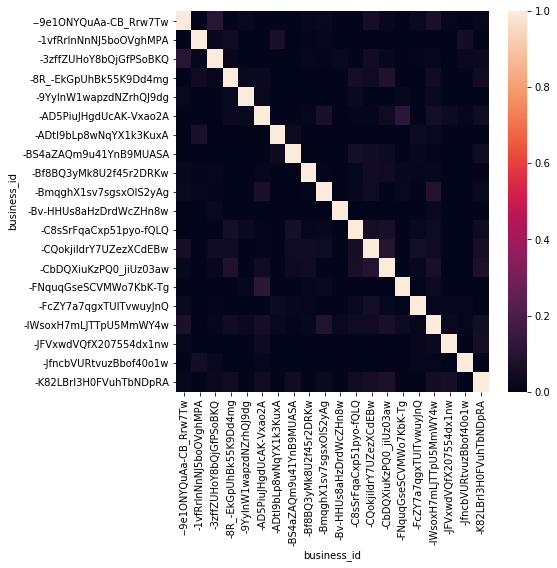

In [229]:
import seaborn as sns
plt.figure(figsize=(7,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
# Create a placeholder items for closes neighbours to an item
data_neighbours = pd.DataFrame(index=df_items.columns,columns=range(1,11))
 
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(df_items.columns)):
    data_neighbours.ix[i,:10] = df_items.ix[0:,i].order(ascending=False)[:10].index

In [ ]:
data_neighbours.head(6).ix[:6,1:4]

In [232]:
df[df['business_id'] == '-8R_-EkGpUhBk55K9Dd4mg']['name'].unique()

array(['Sin City Thai Restaurant'], dtype=object)

In [233]:
df[df['business_id'] == 'Y9kXVlU4xPfSZvkZH6C_2Q']['name'].unique()

array(['Naked City Tavern'], dtype=object)

In [234]:
df_users.head()

user_id,---1lKK3aKOuomHnwAkAow,--RlSfc-QmcHFGHyX6aVjA,--WLHsm-AC4jcol2gOkmCQ,--ZNfWKj1VyVElRx6-g1fg,-05XqtNjcBq19vh2CVJN8g,-0HhZbPBlB1YZx3BhAfaEA,-0MXmdIs75oSWmp8XlQKIw,-1ksPJf0Eppmxj9ZNCkMRw,-21ooEUDqBkCF0hr94Pvgg,-267Yx8RmdP6io2-qI4UcQ,-2UOdDlzg7XLuUuyOrldhA,-2gOxVWcnBr5DclrrsWXCA,-3s52C4zL_DHRK0ULG6qtg,-4JDJeFS0YAYSiSvIshGLQ,-50XWnmQGqBgEI-9ANvLlg,-594af_E7Z9VVjQc9pJK3g,-5McD_r7-sbeZeuIAvnOJg,-5ye1ya0wRQhNRF9NfQ1fA,-6sK3CL1g1OP1FMawX2hxA,-7IMRsmV-Gt7KAK3yivZGQ,-7bM_DeL2Kj2CuYuVDsLNg,-8BrIcsVPbGhv6EAEqbBfA,-8EnCioUmDygAbsYZmTeRQ,-8FDlhUsu5_lVONV_aOnGA,-8MEYFYRHzGEgqBsDV6m2A,-8bfKCvDClxD3iKX9o7J5w,-8eWVKFS0XaktfEaSxMWSw,-8syaSLDbMXW2F2FApVgig,-95gDpECFDSjWEL1AIrkAA,-9B3OS9cH8jIwIjYdqn8xQ,-9I98YbNQnLdAmcYfb324Q,-9da1xk7zgnnfO1uTVYGkA,-9tvXZauwIIpyy9J-moV6A,-AGXyI_K8StzQ7CGehQ2tQ,-AXCpsIGp5Wq1e6wVX4YlA,-Ak9LVDH8GYyWtIMnNo5Ug,-ApvB2uyNYkLCvSfwgLF7g,-B731Wh1510uXX9eC1orQQ,-BevLRnJhh9JeIT2g5I3mQ,-C-l8EHSLXtZZVfUAUhsPA,-C9TzyciiJwct30Mwm_o9Q,-CXdtsZGsM2FBvju5eTAlA,-Cr_udl8Bf-35w5E_5NoHA,-CxzWyvRj3b3tvFdelf38w,-DlNrkkd5iUXwdfmSGx5ew,-E4Smvof6DdBHCnZNyxNMw,-EJorVxe7h2GSxdiRyMmDA,-ELBgtqnuDHoARN3g1n8hQ,-FFqZupwGHf-vrsUHMr_vw,-FjLaUdIRV3I0Pv8i-ICfQ,-Fy91nyOFqPv9M_MaZ4W2g,-HAHTQeOzHX5TCDb7qs9Yw,-HLWgeG3dM_SlcS-vvjEqA,-HcirMcpUDd3GvexCOCCzg,-HdbkVr80PlnsNSLbgW-7g,-IM1qwYck6nqKizjCzR_ww,-Ia1lWvBNdgGySyB2VSgNQ,-IcuwptriARnTWf_EaqgrA,-JvZ2KzL8VCkQI1ZHVrCow,-K3I3SCFvPS_Aw8B4gBtVQ,-KeEr7ZLjbOskY6GGE54hQ,-LEJFq5RC0rQAG831uYRKg,-LUmRqjZdJGLB45pDaqdWA,-Lcp9BDlDDo7j3aIGJWjYg,-LhU9PZZKaP_xFa_rjo9jQ,-Lq86w0tSzzm-SPG8UORsA,-M9PGXdiElWSm4Edm0lEqg,-MqEeaw31xIn1U8mSPWG-Q,-N0xFiL7wxv07F11bfLOvQ,-NHgxN7b9H4g9IIDA1XTVg,-NIopdD4X-FX7V0ucTg2Vg,-NbeVN5tnwdyYAvdNkKMjw,-Ng6kNjzZee-hT-RZYg_Eg,-Ox7QPz0G56GOzT0ex-f5Q,-PAOMIe7lqq1x5GB1pcKMg,-PHC1ulwHkY4LEmMqmFwPg,-PP2PBPpbrYdITLHJzNb4A,-PUQqO7rbjmdQ0KwYcbGAg,-PXJEs_9T0lRKpssxf3otg,-PbPi3wYwpLHs6bM7pwFrA,-PfcLYFMW9ZXc1DEWSqw-g,-Q4HGzcXSCeiqvmY2mg-aQ,-Q4e76IjAqixOEKXkWYxlQ,-Q4lgMSfhoSiVj62dvzUPw,-QViqz6QGfMLUYLY73lysg,-QX-SOFGJHCeSH2CMxr0BQ,-QeO_KlWX19xZUmuv0eXjw,-QmmHtp57b3zT79APvRONA,-R-Z97qJK3E1S8lQSda8Gg,-RA9NLalwmRTOX_8UMHnVQ,-RApyq06DMBii7ovXtQnfw,-R_hd3xKlnUIi_m-IZsY9Q,-Rdc_Yz1WL16lBv7S3PUMg,-SISdpV3Q202NW50EISxWQ,-SWRw9-1ARVKLAWE0Sxw1Q,-SjQXQd-IRfOdUdYYwWGOQ,-TMDrC66dvClx5Z7Hdzrfw,-Tj4e-zW67MXj9Z7-Zkzpw,-U81P8KvkEbl0-aJBGwetQ,-URAJU5BQAM2F1_SNna81g,-UtSFRnsdUgC_R1OzGZVhA,-VNv58eLhbQpz787rcD8VA,-VOylYXNq7sG6As966yTxA,-Vrb0dmE3AxJuJ0dyVY4NA,-WCWlsVGhxaLQMfpKuuKhw,-WYbVngIGDQ81MY12UtwnA,-Wd_SCRLmBeRH8c-TmJ55A,-X8saOIinN36j-Z5_s767Q,-XN6b7pqV2lghQgrIgu3vQ,-XPUcrd6F2wHVUITFAlOYA,-XouWRfq24qMx37oJcXXmg,-XvB5TvlGahyamqIsJO-fg,-YLiMJ0xeWxqny9O9YKzoA,-YV1yESQXqR3vpIgBjKDsw,-Z0uXJn_uP3U0h-e31sTKw,-ZCGdGLtETgNEaOtqHQmSQ,-ZEKvTTWmSCdRJam9YfB1Q,-ZQknHztP6Kpf2DKtCF51w,-_lw9mjGf-92eC90JPW2_w,-aV7azrzW2rlAm6G4DA-cw,-b4O2A-ntjSla1bPnfxU1Q,-bg2NzPGRxVbyftAzaTLiQ,-bh9TmtLO6w7-o07Zr7GiA,-bj4evSejxRDuvYnmcGNrg,-brNcfzn5EaIYORDy4Xj8g,-bt7uzN1JCGauBR64cNupg,-c9G-JHNqrPY0_UU9j7BJA,-d1-LUHXVOw2t3bdJHg26Q,-dD3Oo1tDZYUSecu8Gxq9Q,-dDBNkNgZYyHagrYW60wxg,-dxDfwn30JSChQmO1Bmpeg,-e372MSRHw6vvxliWcxBOA,-eVBjD2-3MJzIyJwwtcGsg,-edOrcdWGnNLodyAEadUKA,-f--l4tZ2F7S0SmoO6wyaA,-fUARDNuXAfrOn4WLSZLgA,-fVKgpmSu0tDnf_xBPqU4A,-fzk0slIjoFQD1eWjx1uWw,-fzqv_NhAkmh4Wu0F9qxDw,-gN7r8iOBKGeh4LJkn2QeQ,-gQZ1BfxbXEN8XuoYBJd2g,-gQm-IoK2_BMEMx9OgtQnw,-gSz76_bKNJsKM2adr12yw,-gTz-C55z7gObvo-R5zzZg,-gc1y2tmDyOJXnMbV_wKpA,-gfC7auUsRN2KqTBzHMBZg,-gi3QTLxpER5LqqPXYEsMw,-go-R_jzvYLYngQbfKN4_A,-guyVbrMJxVeBcfdRQc6xw,-gzqF2ucnXwHf64_k2Hoxg,-h3OxE2YbWzFXVkBhYtJTw,-hFSXulXh22Es29Y4F4cgQ,-hYYjAXSAa657rY0ANtTGQ,-hxUwfo3cMnLTv-CAaP69A,-iBUZFbX7m2IrnraAhhQHg,-j-8EX-ebLXybLAdDQOGzw,-j3PQicmtfQz6RyaK0S1-w,-jL7hLAAwOnCAWKQlL9Wew,-jpu5KX95HLWJdztLq53uQ,-k5yFUChotBMGQgHdFZvLQ,-kO6984fXByyZm3_6z2JYg,-kRQLEDxrEBVNXImyAt_ug,-khrbWmeaZDZ6hzTgJ4HpQ,-ki-qIZHP4zZ2D49-b8ZzA,-lCMo6oeRPQVOBu-27qsQQ,-lLEwwXKARlLhAd05tfmVA,-lORwg9gjWI6q3-2-J7dLw,-lWYDxgOF99Hpxc0hrAuFQ,-lh59ko3dxChBSZ9U7LfUw,-mGJPKC0owz3HTrrZfgFUg,-mXobpJ3z3X6nMriCklbog,-mzS8ZrsN5vIhAM22gcS3Q,-ne-7caCLAk2j3kD7tzBGw,-nuKSqlNyZv7A

In [235]:
df_users[0:10][df_users.columns[0:10]]

user_id,---1lKK3aKOuomHnwAkAow,--RlSfc-QmcHFGHyX6aVjA,--WLHsm-AC4jcol2gOkmCQ,--ZNfWKj1VyVElRx6-g1fg,-05XqtNjcBq19vh2CVJN8g,-0HhZbPBlB1YZx3BhAfaEA,-0MXmdIs75oSWmp8XlQKIw,-1ksPJf0Eppmxj9ZNCkMRw,-21ooEUDqBkCF0hr94Pvgg,-267Yx8RmdP6io2-qI4UcQ
user_id,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,1.000000,0.000000,0.000000,0.000000,0.000000,0.057295,0.091958,0.058649,0.000000,0.073985
--RlSfc-QmcHFGHyX6aVjA,0.000000,1.000000,0.000000,0.082318,0.000000,0.046397,0.000000,0.000000,0.051188,0.052424
--WLHsm-AC4jcol2gOkmCQ,0.000000,0.000000,1.000000,0.038680,0.000000,0.000000,0.029159,0.000000,0.144315,0.000000
--ZNfWKj1VyVElRx6-g1fg,0.000000,0.082318,0.038680,1.000000,0.000000,0.000000,0.000000,0.012560,0.152286,0.030945
-05XqtNjcBq19vh2CVJN8g,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.074954,0.000000,0.018548,0.033922
-0HhZbPBlB1YZx3BhAfaEA,0.057295,0.046397,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010046
-0MXmdIs75oSWmp8XlQKIw,0.091958,0.000000,0.029159,0.000000,0.074954,0.000000,1.000000,0.000000,0.000000,0.000000
-1ksPJf0Eppmxj9ZNCkMRw,0.058649,0.000000,0.000000,0.012560,0.000000,0.000000,0.000000,1.000000,0.000000,0.020568
-21ooEUDqBkCF0hr94Pvgg,0.000000,0.051188,0.144315,0.152286,0.018548,0.000000,0.000000,0.000000,1.000000,0.083128


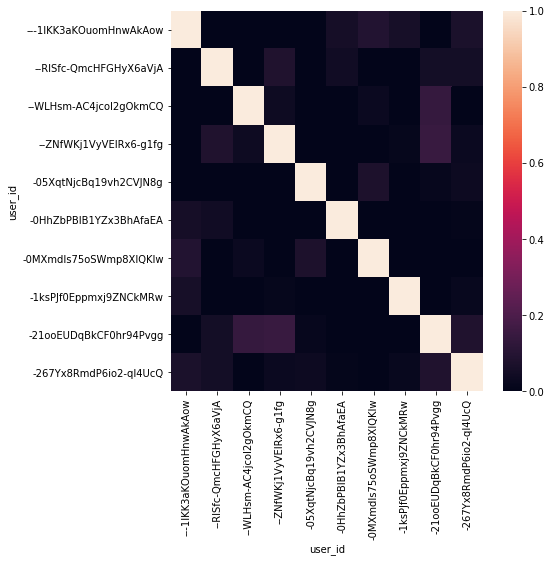

In [236]:
import seaborn as sns
corr = df_users[0:10][df_users.columns[0:10]]
plt.figure(figsize=(7,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [104]:
users=df1['user_id'].values


In [105]:
df_user_recs=df_users.apply(lambda row : users[np.argsort(row)[::-1]],axis=1)

In [106]:
df_nearest_neighbors_all=df_user_recs[df_user_recs.columns[0:]]

In [107]:
df_nearest_neighbors_5 = df_nearest_neighbors_all[df_nearest_neighbors_all.columns[0:5]]


In [108]:
df_nearest_neighbors_5.head()


user_id,---1lKK3aKOuomHnwAkAow,--RlSfc-QmcHFGHyX6aVjA,--ZNfWKj1VyVElRx6-g1fg,-267Yx8RmdP6io2-qI4UcQ,-2gOxVWcnBr5DclrrsWXCA
user_id,,,,,
---1lKK3aKOuomHnwAkAow,---1lKK3aKOuomHnwAkAow,4Zqh0-Db39qpGEHCIll9hw,Ii1PkdRpONUNwKC3lmhl1A,r_-YhOstIUFhl_KZWZxflA,G4pBy0nzqqkKgJEHrDNcWQ
--RlSfc-QmcHFGHyX6aVjA,--RlSfc-QmcHFGHyX6aVjA,tH0uKD-vNwMoEc3Xk3Cbdg,ZyGrNTbnab8N3kmesYaQBQ,zHzvPBcXuzyGSAPzc0k2Bg,ldqh2aWLTW6D2RHDCj_2TA
--ZNfWKj1VyVElRx6-g1fg,--ZNfWKj1VyVElRx6-g1fg,11k3A-_Ifz_86LHvkGRgoQ,8HyODWHxD1Vmq5O7HeJe-A,pnfVIB7UhvCQ7X2K0Q2XIw,VvYC7DUlWds5H2fs8nyeUQ
-267Yx8RmdP6io2-qI4UcQ,-267Yx8RmdP6io2-qI4UcQ,eZZyuJDouIg4p-GYB3PV_A,N3oNEwh0qgPqPP3Em6wJXw,kwIhn1_cnQeUaLN0CuWWHw,n86B7IkbU20AkxlFX_5aew
-2gOxVWcnBr5DclrrsWXCA,-2gOxVWcnBr5DclrrsWXCA,jVsWBaVdvVYT9mMYvM0Zjg,RJVpaFHx3MwynTM8TNjz0A,3Kn4WUjRW4mktpYa0El3IQ,gt5NfNrG8e_4TNBZeyBbfw


In [109]:
df1.head()


business_id,--9e1ONYQuAa-CB_Rrw7Tw,-3zffZUHoY8bQjGfPSoBKQ,-8R_-EkGpUhBk55K9Dd4mg,-9YyInW1wapzdNZrhQJ9dg,-AD5PiuJHgdUcAK-Vxao2A,-ADtl9bLp8wNqYX1k3KuxA,-Bf8BQ3yMk8U2f45r2DRKw,-BmqghX1sv7sgsxOIS2yAg,-C8sSrFqaCxp51pyo-fQLQ,-FNquqGseSCVMWo7KbK-Tg,-FcZY7a7qgxTUlTvwuyJnQ,-IWsoxH7mLJTTpU5MmWY4w,-JFVxwdVQfX207554dx1nw,-JfncbVURtvuzBbof40o1w,-K82LBrI3H0FVuhTbNDpRA,-Le6cwbZL4tDZwNHwipfKg,-LzUYsR54hd8cCiYXTquRA,-OEIW0dO96-492qa_luxaw,-P8dGzSVhJi-5oZ-8U2y0w,-PGsEXB6DFTVKa1eDOlzWA,-Qkx7W0itbAApcG5lJuMFQ,-RJ216TTIghZshCkUlD1WQ,-U7tvCtaraTQ9b0zBhpBMA,-WLrZPzjKfrftLWaCi1QZQ,-YWr1wm_NaAlgEf9TZzsMQ,-Ylpy3VyRWwubf9dysuwjQ,-_TSaVr53qiEGqMkwyEMaQ,-_yEVC3_3M6YOsamYfNFEw,-a857YYdjzgOdOjFFRsRXQ,-ed0Yc9on37RoIoG2ZgxBA,-iFvYhgysvjkxckCr42NRw,-ilCufjKjeswCLyIrCtuqQ,-mN7z9oY01Mh_-dwTyzpqg,-oUM2uISux96lMGeawHIOA,-sN_og_84rLW22CaE3cjVw,-wCtRhzWJ40Z4F8mmg7kWg,-wDNRL4lm1UgeFLG9KcrjQ,-xbQQR_ydEJGqYzHSF4DnQ,01Ov9eDxKRY5k6ImMdiWLQ,01SiPgdiOskMC5bUJoyy_g,01VPJkcU0m8WzlA7dCEpVQ,02pL_Xj3sTO_lHcWqUcwKA,03icrim6SfEQJlejDMbzsA,065c76tt1dXBNmoGBymUgQ,07AZL5XenCQ_-op_onKLdw,07gh-AImcEcWQ2bew-jprg,0AQnRQw34IQW9-1gJkYnMA,0CB7YB1qRSWLQvMbHw3Fmw,0EgYXYjt2XJL4hlsKnzrcw,0FHfkDxKSeDuyAEeaY6X-Q,0G1y7uV7w1D2uziS4Lt_Dw,0Hcks5q-DgJbDlmEWolx4A,0InA3Ffj8MxyQV9hgsyYcQ,0LGnU7V3nepi8NUNzyQOXw,0NmTwqYEQiKErDv4a55obg,0OdZXIKQypu6vplpxFilsA,0QHMAUi6NdOUZ1ckXq0-sA,0QSnurP5Ibor2zepJmEIlw,0S4WFZJZhVeM3aAqKjLz1w,0VjHFdczi6Nln_nn8bucJQ,0WPXDs4ini3D7jpiy1Daqw,0WoQQlMXVIDEgI0xNdENKA,0XEqyl_lVaJNHRKxNcjJZg,0YG_kM5caZhtwd6nbnei6A,0_VT3sTwi7gorIlU36ASmg,0_aeYE2-VbsZts_UpILgDw,0_mJttUgHIzC-NO18gcgBA,0aw3HbxkZ4G7pkPYt10fhA,0bWLkWeIcT-EnrE7SiGEBA,0c6PQILCLwRZ8FIB4AEsGw,0d0i0FaJq1GIeW1rS2D-5w,0dr1FgqQSEMbaTu9SDqiIg,0gTTGuA6uEmMhLhfJi0hqA,0gWg-kqRLEQbhui8b_v2Xw,0jtRI7hVMpQHpUVtUy4ITw,0nlocywsFHQmEt8_xbHNiw,0p27EjcNwTI7Ey4K_MNPww,0qPNeqLuKE88rKbIbSZDpg,0q_BHpxbikVtPRRLRu-U0g,0uR48n5SYcLE_DLcjONZPg,0ueq5zB3NqLbh93KYYNIHQ,0w3BdEOxvwKTpypwbN5kiQ,0xdpv5CPpbUUch7JKBG98Q,0xtBEP5zCu1153SoqqemLw,0xvdC8F0HmFpAFkJk6nXLg,0xzmIBsJQc5eUNLucFrZ0Q,0zoXYHq82haayMaV952jEQ,16Fplxu-OwVmTEFxQAUP4g,16tWXenJ1wTqugXJU7yiZg,19S0gFtg5GTX6CkiApJiAQ,19umlhmVB9O3njIBfRAe8g,1CP8aJa8ILlfM5deroar0Q,1CR2ddUcjYYwRd5JLtiRrw,1CTapYK3FHvpiJaQhOaaIw,1CWMNSTRMejdSyXBG2chNg,1DP5vHxJzCDbgawv0WC3yA,1Df5WnLX3DqN6ymlhqznaQ,1FAvxOUOGGyZoYNlAXACag,1JgaRBX0oiRsvEhHF3ZMjw,1KhBzrqmU164bss64jR5uA,1MrSwj8i2VEBHdp3IsWCpQ,1SCETxRnwaYo2aBC3fi4SA,1SE9f6TEV5XhnTuuK01xwA,1SqLPgnZEVeVYDM-AuoFhg,1Tak6Q-IlkDrdmLwrEZeSg,1UdRVfBlE3unETOu7BDCvw,1UvrUFk3BXAmueL1KQaKPQ,1V-mRUpVnIRq6GYymT_uyw,1Vvxx-9AoINg8TJXOZgEHg,1WBVqmo7tgF0z0eGf4fPhQ,1Z5S_Lkcl6vA3ZvrAG91TA,1ZJz840L496LAmQdeDv0WA,1ZnVfS-qP19upP_fwOhZsA,1aj4TG0eFq6NaPBKk6bK7Q,1bALsE6aZE23mGV2WPxN_g,1g29d62cEojB-7mX7p8AzQ,1jpYP-JNOEYCMIzP4OlGuQ,217u7Wad7y90x4el26-TIw,21sGRVR7HEs_t6PdB9tGMw,25wTaO0_Rk-GLb4k2uMs0Q,296PZdxSrtH08EUwCsOKMw,2B46bRpDh49eDyjXGhL_ZQ,2HxaDXZmAOH6LiuzGgNdPA,2I_qSTehoUFsDNjaqCVxlA,2IvrdAb6zdxr3ZqplqJHbg,2LL-pWxdM_rvnaIpNxezsQ,2LNnIARy-lGmrlEMZSxZ1w,2Mp53KxlGeZJkodTuqpVow,2RFe9vDTzyBkF4mvsFDDow,2SfSzEd3B7WimeZac23zhg,2Wl4o7l54I-EtxtaDpOTzA,2XkVexeY_8zyc9nriSElQg,2Y0-nrSZNsLRStyupZgM7g,2YBO1LEKIgyle0uX50u15Q,2bK1ng2mnRdtTh_BDNGmIg,2dCnTMv3Hh-fM8bOjYS4Xw,2g_auUWw7c3c2CUTgVqI8Q,2hSIeCX2cV-chFcBBXrZZA,2hyciWHsqnbqdEkUvO3KuQ,2iTsRqUsPGRH1li1WVRvKQ,2lPLbTenaBH3SGHgpwM54A,2m4092MsMzEHkuxodaj6-g,2rvBPUBtQU0WfcOAHLQWRQ,2sdU3Fq3Wv2XQycJoJQArg,2sx52lDoiEtef7xgPCaoBw,2weQS-RnoOBhb1KsHKyoSQ,310Eyru1zsZ9K7BA-bgPQw,31cOttU_tML5b6eLLXZfsQ,32JWhoH-Kiu1wRFTvHvW9Q,33Tr0eRki1Yamzleu4GMdw,34PMhyoSQHVd4Lr7slzUcA,364hhL5st0LV16UcBHRJ3A,3BCsAgo_1i4xMuTyLKMLRQ,3FlWR_osNPb8dcqLgHebHw,3GEEy7RP6e4bT4LAiWFMFQ,3GfdCuI0YCc5U3rLLLPHUw,3Gt3xskppi9jZuTrwrhLNg,3IwCop28R1_L5jMv6AkL8Q,3Jq5LfJ5fmJ5KmuA6VHmzw,3LWsVfsSmb_Nzbi2YQ-NIA,3QcTqsdxQBlSndBdMJBRhQ,3Qe4M3JNs7yIRXP13g-NYA,3WRvQJS9GIBubGxbHMzX2g,3XE-poXz9CeDao-Q7pqkTw,3ZHyw0d8mk0HOEP7v4fW1A,3ajqOW9A7VhResA08I7RTg,3cHL1r5w2oLYH-veijtweA,3cg4pKBL8DTFXCtZ5y9V4g,3fPIRTnBhd81MixgS9YoMQ,3fT1kcQ-MVEImGHa3hll5w,3h5jLa-kbHg0cL7v9En0Lg,3kdSl5mo9dWC4clrQjEDGg,3m2XZFVraCiqjgLxHi5MdA,3nf-a84p8

In [110]:
X.shape

(3609, 2188)

In [64]:
item_item = 1-pairwise_distances(X[0:8000].T, metric="cosine")
df_items = pd.DataFrame(item_item,columns=X.columns,index=X.columns)

In [70]:
df_items.shape

(2637, 2637)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if sys.path[0] == '':


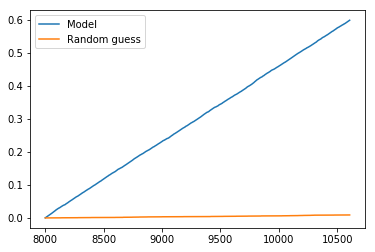

In [76]:
recall=[]
guesses = 3
recall_total = 0
recall_guess = 0

recall_guesses = []

for n in range(8000,X.shape[0]):
    user = np.append(X[n:n+1].values[0][0:2000],np.zeros(X.shape[1]-2000))
    user_prefs = df_items.dot(user/np.sum(user))
    
    user_prefs.sort()
    already_liked=df_items[df_items.columns[np.where(X[n:n+1].values[0]>0)][0:5]].columns.values

    test_data=df_items[df_items.columns[np.where(X[n:n+1].values[0]>0)][5:]].columns.values
    
    user_suggestions =[s for s in user_prefs.index[::-1][0:guesses] if s not in already_liked]
    
    correct = [c for c in user_suggestions if c in test_data]
    gue=random.sample(range(len(user_prefs.index)), min(guesses,len(user_prefs)))
    guess_list = [g for g in user_prefs.index[gue]  if g in test_data]

    recall_total = recall_total + float(len(correct))
    recall_guess = recall_guess + float(len(guess_list))
   
    recall.append(recall_total)
    recall_guesses.append(recall_guess)
plt.plot(range(8000,X.shape[0]),recall/(np.array(guesses)*(X.shape[0]-8000)),label='Model')
plt.plot(range(8000,X.shape[0]),recall_guesses/(np.array(guesses)*(X.shape[0]-8000)),label='Random guess')
plt.legend()

range(8000, 10607)

In [26]:
item_item.shape

(3043, 3043)